## Dependancy Management

In [1]:
import os
os.environ["KMP_DUPLICATE_LIB_OK"] = "TRUE"

In [2]:
!pip install pytorch-metric-learning


[notice] A new release of pip is available: 24.3.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [3]:
import scipy.io as sio
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch.utils.data import random_split, TensorDataset, DataLoader, Dataset
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import itertools
import random
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report
import nbformat
from torchmetrics.image import PeakSignalNoiseRatio
from torch.amp import autocast, GradScaler
from pytorch_metric_learning.samplers import MPerClassSampler
import glob
from sklearn.model_selection import train_test_split
import pandas as pd
from sklearn.metrics import confusion_matrix
import seaborn as sns

In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


## Data Processing Pipeline

Labels shape: (1476, 256)
Hypercube shape: (1476, 256, 145)


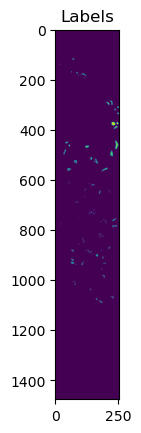

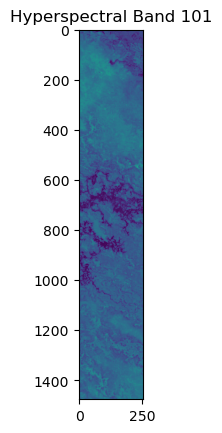

In [5]:
dataset_dir = r"C:\Users\vella\Documents\GitHub\FYP2425_LOCAL\FYP_DATASET"

gt_files = 'Botswana_gt.mat'
data_files = 'Botswana.mat'
label_files = 'Botswana_gt'
hypercube_files = 'Botswana'

def extract_Features():
    gt_file = os.path.join(dataset_dir, gt_files)
    data_file = os.path.join(dataset_dir, data_files)

    gt = sio.loadmat(gt_file)
    labels = gt[label_files]

    data = sio.loadmat(data_file)
    hypercube = data[hypercube_files]
    #scaling the data in place and setting to float32 to reduce memory usage
    max_value = np.max(hypercube)
    hypercube = (hypercube / max_value).astype(np.float32)


    #shapes of loaded data
    print(f"Labels shape: {labels.shape}")
    print(f"Hypercube shape: {hypercube.shape}")

    #visualisation of label map and a given band of hyperspectral data
    plt.figure()
    plt.imshow(labels)
    plt.title('Labels')

    band = 101
    plt.figure()
    plt.imshow(hypercube[:,:,band])
    plt.title(f'Hyperspectral Band {band}')
    plt.show()

    return hypercube, labels

hypercube, labels = extract_Features()

In [6]:
def extract_windows(data, labels, window_size):
    extract_windows_save_dir = 'extracted_windows_labels'
    if not os.path.exists(extract_windows_save_dir):
        os.makedirs(extract_windows_save_dir)
        print(f"Created directory: {extract_windows_save_dir}")

    margin = window_size // 2
    padded_data = np.pad(data, ((margin, margin), (margin, margin), (0, 0)), mode='constant')
    padded_labels = np.pad(labels, ((margin, margin), (margin, margin)), mode='constant')

    X_windows = []  #extracted windows
    y_labels = []   #corresponding labels

    print("Starting window extraction...")
    for i in range(margin, padded_data.shape[0] - margin):
        for j in range(margin, padded_data.shape[1] - margin):
            window = padded_data[i-margin:i+margin+1, j-margin:j+margin+1, :]
            label = padded_labels[i, j]

            if label != 0:
                #print('ignoring label 0 (background)')
                X_windows.append(window)
                y_labels.append(label)

    #convertying to numpy arrays
    X_windows = np.array(X_windows)
    y_labels = np.array(y_labels)

    #saving extracted windows and labels
    windows_file = os.path.join(extract_windows_save_dir, 'extracted_windows.npy')
    labels_file = os.path.join(extract_windows_save_dir, 'extracted_labels.npy')

    np.save(windows_file, X_windows)
    np.save(labels_file, y_labels)

    print(f"Saved extracted windows to: {windows_file}")
    print(f"Saved corresponding labels to: {labels_file}")
    print(f"\nTotal windows extracted: {len(X_windows)}")
    print(f"Extracted windows shape: {X_windows.shape}")
    print(f"Corresponding labels shape: {y_labels.shape}")

    return X_windows, y_labels

In [7]:
window_size = 5

X_windows, y_labels = extract_windows(hypercube, labels, window_size)

Created directory: extracted_windows_labels
Starting window extraction...


Saved extracted windows to: extracted_windows_labels\extracted_windows.npy
Saved corresponding labels to: extracted_windows_labels\extracted_labels.npy

Total windows extracted: 3248
Extracted windows shape: (3248, 5, 5, 145)
Corresponding labels shape: (3248,)


In [8]:
def get_samples(X_windows, y_labels, samples_per_class):
    
    indices_save_dir = 'indices'
    if not os.path.exists(indices_save_dir):
        os.makedirs(indices_save_dir)
        print(f"Created directory: {indices_save_dir}")
    
    #get unique classes
    classes = np.unique(y_labels)
    print(f"Unique classes found as: {classes}")

    #init lists
    X_sampled = [] #to store training samples
    y_sampled = [] #to store training labels

    X_val = [] # to store validation samples
    y_val = [] # to store validation labels

    selected_indices_total = [] #to store indices of selected training and validation samples
    validation_selected = [] #temp storage for validation indices
    validation_total = [] #to store all validation indices

    print("\n == STARTING SAMPLING PROCESS ==")
    for cls in classes:
        if cls == 0:
            print(f"!! SKIPPING CLASS 0 !!")
            continue

        #getting the indices for the current class:
        class_indices = np.where(y_labels == cls)[0]
        print(f"Class: {cls}: Found {len(class_indices)} samples")

        # shuffle class-specific indices to ensure randomness
        np.random.shuffle(class_indices)
        print(f"Shuffled class indices for class '{cls}'")

        #select 'samples_per_class' samples for training
        selected_indices = class_indices[:samples_per_class]
        #selecting 5 samples for validation
        validation_selected = class_indices[samples_per_class:samples_per_class+5]

        print(f"Selected {len(selected_indices)} training samples and {len(validation_selected)} validation samples for class '{cls}'\n")

        #store selected indices for training and validation
        selected_indices_total.extend(selected_indices)
        validation_total.extend(validation_selected)

        # appending the selected samples and their labels to the lists
        X_sampled.append(X_windows[selected_indices])
        y_sampled.append(y_labels[selected_indices])

        X_val.append(X_windows[validation_selected])
        y_val.append(y_labels[validation_selected])

    #concat the sampled arrays for training
    X_train = np.vstack(X_sampled)
    y_train = np.hstack(y_sampled)

    # shift labels to start from 0
    y_train = y_train - 1

    print(f"\n -- Training set created with: \n\t{X_train.shape[0]} samples\n\tshape {X_train.shape} --")

    #concat the sampled arrays for validation
    X_val = np.vstack(X_val)
    y_val = np.hstack(y_val)
    y_val = y_val - 1

    print(f"\n -- Validation set created with: \n\t{X_val.shape[0]} samples\n\tshape {X_val.shape} --")

    #create the test set from the remaining data (i.e. that which is not selected for training or validation)
    selected_indices_total.extend(validation_total)

    #getting indices not in the training or val sets
    test_indices = np.setdiff1d(np.arange(X_windows.shape[0]), selected_indices_total)
    X_test = X_windows[test_indices]
    y_test = y_labels[test_indices]
    y_test = y_test - 1

    print(f"\n -- Test set created with: \n\t{X_test.shape[0]} samples\n\tshape {X_test.shape} --\n")

    # Save the datasets to the 'datasets' folder
    np.save(os.path.join(indices_save_dir, 'X_train.npy'), X_train)
    np.save(os.path.join(indices_save_dir, 'y_train.npy'), y_train)
    np.save(os.path.join(indices_save_dir, 'X_val.npy'), X_val)
    np.save(os.path.join(indices_save_dir, 'y_val.npy'), y_val)
    np.save(os.path.join(indices_save_dir, 'X_test.npy'), X_test)
    np.save(os.path.join(indices_save_dir, 'y_test.npy'), y_test)

    print(f"\nAll datasets saved to the '{indices_save_dir}' folder.")

    #return the training, val, test sets + selected indices
    return X_train, X_test, y_train, y_test, X_val, y_val, selected_indices_total

In [9]:
X_train, X_test, y_train, y_test, X_val, y_val, selected_indices_total = get_samples(X_windows, y_labels, 20)
print(X_train.shape)
print(X_val.shape)
print(X_test.shape)

Created directory: indices
Unique classes found as: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14]

 == STARTING SAMPLING PROCESS ==
Class: 1: Found 270 samples
Shuffled class indices for class '1'
Selected 20 training samples and 5 validation samples for class '1'

Class: 2: Found 101 samples
Shuffled class indices for class '2'
Selected 20 training samples and 5 validation samples for class '2'

Class: 3: Found 251 samples
Shuffled class indices for class '3'
Selected 20 training samples and 5 validation samples for class '3'

Class: 4: Found 215 samples
Shuffled class indices for class '4'
Selected 20 training samples and 5 validation samples for class '4'

Class: 5: Found 269 samples
Shuffled class indices for class '5'
Selected 20 training samples and 5 validation samples for class '5'

Class: 6: Found 269 samples
Shuffled class indices for class '6'
Selected 20 training samples and 5 validation samples for class '6'

Class: 7: Found 259 samples
Shuffled class indices for class '7'
S


All datasets saved to the 'indices' folder.
(280, 5, 5, 145)
(70, 5, 5, 145)
(2898, 5, 5, 145)


In [10]:
class HyperspectralDataset(Dataset):
    def __init__(self, X, y):
        """
        Args:
            X (numpy.ndarray): Hyperspectral data of shape (num_samples, height, width, num_bands).
            y (numpy.ndarray): Labels of shape (num_samples,).
        """
        #converting to pytorch tensor
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.long)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

In [11]:
#loading the saved datasets
X_train = np.load('indices/X_train.npy')
y_train = np.load('indices/y_train.npy')
X_val = np.load('indices/X_val.npy')
y_val = np.load('indices/y_val.npy')
X_test = np.load('indices/X_test.npy')
y_test = np.load('indices/y_test.npy')


#creating pytorch datasets
train_dataset = HyperspectralDataset(X_train, y_train)
val_dataset = HyperspectralDataset(X_val, y_val)
test_dataset = HyperspectralDataset(X_test, y_test)

m = 20
num_classes = len(np.unique(y_train))

#theoretical batch size calc
required_batch_size = m * num_classes  # 10 * 9 = 90

#ensuring batch size doesn't exceed training set size
if required_batch_size > len(train_dataset):
    #case 1: not enough samples - reduce m proportionally
    print("Case 1 applied")
    max_possible_m = len(train_dataset) // num_classes
    m = max(1, max_possible_m)
    batch_size_train = m * num_classes
else:
    #case 2: use full batch size
    print("Case 2 applied")
    batch_size_train = required_batch_size

sampler = MPerClassSampler(labels = y_train, m=m, batch_size = batch_size_train, length_before_new_iter = len(train_dataset))

#dataloaders
train_loader = DataLoader(train_dataset, batch_size = batch_size_train, sampler=sampler)

batch_size = 256
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

print("DataLoaders created successfully!")

#class dist in first batch
for X_batch, y_batch in train_loader:
    unique, counts = np.unique(y_batch.numpy(), return_counts=True)
    print(f"Training batch size: {batch_size_train}")
    print("Class distribution in batch:", dict(zip(unique, counts)))
    break



Case 2 applied
DataLoaders created successfully!
Training batch size: 280
Class distribution in batch: {0: 20, 1: 20, 2: 20, 3: 20, 4: 20, 5: 20, 6: 20, 7: 20, 8: 20, 9: 20, 10: 20, 11: 20, 12: 20, 13: 20}


## Creating directory for saving model predictions

In [12]:
predictions_dir = 'model_predictions'
os.makedirs(predictions_dir, exist_ok=True)
print(f"Created dir: {predictions_dir}")

Created dir: model_predictions


## Creating the Dataset splits and Dataloaders for unsupervised tasks

In [13]:
X_train, X_val = train_test_split(X_windows, test_size=0.2, random_state=42)

print(f"Training data shape: {X_train.shape}")
print(f"Validation data shape: {X_val.shape}")

Training data shape: (2598, 5, 5, 145)
Validation data shape: (650, 5, 5, 145)


In [14]:
class UnsupervisedDataset(Dataset):
    def __init__(self, data):
        self.data = torch.tensor(data, dtype=torch.float32)  #converting to pytorch tensor

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return self.data[idx]

In [15]:
#creating datasets for unsupervised task
unsup_train_dataset = UnsupervisedDataset(X_train)
unsup_val_dataset = UnsupervisedDataset(X_val)

#dataloaders for unsupervised task
batch_size = 64
train_loader_cae = DataLoader(unsup_train_dataset, batch_size=batch_size, shuffle=True)
val_loader_cae = DataLoader(unsup_val_dataset, batch_size=batch_size, shuffle=False)

print("DataLoaders created successfully!")

DataLoaders created successfully!


In [16]:
window_num_channels = X_windows.shape[3]
print(window_num_channels)

145


## Convolutional Autoencoder

In [17]:
class ConvAutoEncode(nn.Module):
    def __init__(self, dropout_prob=0.1):
        super(ConvAutoEncode, self).__init__()

        #encoder
        self.encoder = nn.Sequential(
            #Block 1
            nn.Conv2d(window_num_channels, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Dropout(dropout_prob),

            nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),  # 5x5 -> 2x2

            #Block 2
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Dropout(dropout_prob),

            #Bottleneck
            nn.Conv2d(128, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),

            nn.MaxPool2d(2, 2)  # 2x2 -> 1x1
        )

        #decoder
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(64, 128, kernel_size=2, stride=2),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Dropout(dropout_prob),

            nn.ConvTranspose2d(128, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),

            nn.ConvTranspose2d(64, 64, kernel_size=2, stride=2, output_padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Dropout(dropout_prob),

            nn.ConvTranspose2d(64, window_num_channels, kernel_size=3, stride=1, padding=1),
            nn.Sigmoid()
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return encoded, decoded


LOG: Epoch [1/50]


	 Training Batch [1/41], Loss: 0.2201, PSNR: -8.0472


Epoch [1/50] Training Loss: 0.2103, PSNR: -8.6582
	[Val]   Batch [1/11] Loss: 0.2049, PSNR: -6.1532
	[Val]   Batch [10/11] Loss: 0.2051, PSNR: -8.3920
Epoch [1/50] Validation Loss: 0.2049, PSNR: -8.0841

LOG: Epoch [2/50]
	 Training Batch [1/41], Loss: 0.1942, PSNR: -7.5039


Epoch [2/50] Training Loss: 0.1879, PSNR: -8.3105
	[Val]   Batch [1/11] Loss: 0.1764, PSNR: -5.5014
	[Val]   Batch [10/11] Loss: 0.1767, PSNR: -7.7444
Epoch [2/50] Validation Loss: 0.1764, PSNR: -7.4338

LOG: Epoch [3/50]
	 Training Batch [1/41], Loss: 0.1742, PSNR: -7.0308


Epoch [3/50] Training Loss: 0.1665, PSNR: -7.7164
	[Val]   Batch [1/11] Loss: 0.1534, PSNR: -4.8940
	[Val]   Batch [10/11] Loss: 0.1532, PSNR: -7.1258
Epoch [3/50] Validation Loss: 0.1532, PSNR: -6.8208

LOG: Epoch [4/50]
	 Training Batch [1/41], Loss: 0.1539, PSNR: -8.4965


Epoch [4/50] Training Loss: 0.1461, PSNR: -7.0568
	[Val]   Batch [1/11] Loss: 0.1292, PSNR: -4.1483
	[Val]   Batch [10/11] Loss: 0.1293, PSNR: -6.3889
Epoch [4/50] Validation Loss: 0.1293, PSNR: -6.0830

LOG: Epoch [5/50]
	 Training Batch [1/41], Loss: 0.1332, PSNR: -5.5984


Epoch [5/50] Training Loss: 0.1268, PSNR: -6.6234
	[Val]   Batch [1/11] Loss: 0.1128, PSNR: -3.5594
	[Val]   Batch [10/11] Loss: 0.1129, PSNR: -5.7999
Epoch [5/50] Validation Loss: 0.1129, PSNR: -5.4938

LOG: Epoch [6/50]
	 Training Batch [1/41], Loss: 0.1145, PSNR: -7.0459


Epoch [6/50] Training Loss: 0.1096, PSNR: -5.9577
	[Val]   Batch [1/11] Loss: 0.0963, PSNR: -2.8724
	[Val]   Batch [10/11] Loss: 0.0963, PSNR: -5.1112
Epoch [6/50] Validation Loss: 0.0963, PSNR: -4.8051

LOG: Epoch [7/50]
	 Training Batch [1/41], Loss: 0.0996, PSNR: -5.8699


Epoch [7/50] Training Loss: 0.0943, PSNR: -5.3235
	[Val]   Batch [1/11] Loss: 0.0838, PSNR: -2.2715
	[Val]   Batch [10/11] Loss: 0.0839, PSNR: -4.5093
Epoch [7/50] Validation Loss: 0.0839, PSNR: -4.2035

LOG: Epoch [8/50]
	 Training Batch [1/41], Loss: 0.0845, PSNR: -6.0427


Epoch [8/50] Training Loss: 0.0811, PSNR: -4.5629
	[Val]   Batch [1/11] Loss: 0.0722, PSNR: -1.6233
	[Val]   Batch [10/11] Loss: 0.0722, PSNR: -3.8611
Epoch [8/50] Validation Loss: 0.0722, PSNR: -3.5554

LOG: Epoch [9/50]
	 Training Batch [1/41], Loss: 0.0741, PSNR: -5.6699


Epoch [9/50] Training Loss: 0.0700, PSNR: -4.0259
	[Val]   Batch [1/11] Loss: 0.0632, PSNR: -1.0435
	[Val]   Batch [10/11] Loss: 0.0632, PSNR: -3.2813
Epoch [9/50] Validation Loss: 0.0632, PSNR: -2.9756

LOG: Epoch [10/50]
	 Training Batch [1/41], Loss: 0.0641, PSNR: -5.3280


Epoch [10/50] Training Loss: 0.0606, PSNR: -3.3588
	[Val]   Batch [1/11] Loss: 0.0556, PSNR: -0.4898
	[Val]   Batch [10/11] Loss: 0.0557, PSNR: -2.7290
Epoch [10/50] Validation Loss: 0.0556, PSNR: -2.4218

LOG: Epoch [11/50]
	 Training Batch [1/41], Loss: 0.0557, PSNR: -1.8139


Epoch [11/50] Training Loss: 0.0528, PSNR: -2.7160
	[Val]   Batch [1/11] Loss: 0.0487, PSNR: 0.0835
	[Val]   Batch [10/11] Loss: 0.0488, PSNR: -2.1562
Epoch [11/50] Validation Loss: 0.0487, PSNR: -1.8476

LOG: Epoch [12/50]
	 Training Batch [1/41], Loss: 0.0484, PSNR: -2.6877


Epoch [12/50] Training Loss: 0.0463, PSNR: -2.3506
	[Val]   Batch [1/11] Loss: 0.0432, PSNR: 0.6124
	[Val]   Batch [10/11] Loss: 0.0432, PSNR: -1.6258
Epoch [12/50] Validation Loss: 0.0432, PSNR: -1.3189

LOG: Epoch [13/50]
	 Training Batch [1/41], Loss: 0.0420, PSNR: -2.2136


Epoch [13/50] Training Loss: 0.0409, PSNR: -1.6465
	[Val]   Batch [1/11] Loss: 0.0386, PSNR: 1.1007
	[Val]   Batch [10/11] Loss: 0.0386, PSNR: -1.1373
Epoch [13/50] Validation Loss: 0.0386, PSNR: -0.8307

LOG: Epoch [14/50]
	 Training Batch [1/41], Loss: 0.0378, PSNR: 1.1853


Epoch [14/50] Training Loss: 0.0364, PSNR: -1.0343
	[Val]   Batch [1/11] Loss: 0.0345, PSNR: 1.5910
	[Val]   Batch [10/11] Loss: 0.0345, PSNR: -0.6472
Epoch [14/50] Validation Loss: 0.0344, PSNR: -0.3396

LOG: Epoch [15/50]
	 Training Batch [1/41], Loss: 0.0343, PSNR: -1.8177


Epoch [15/50] Training Loss: 0.0325, PSNR: -0.8027
	[Val]   Batch [1/11] Loss: 0.0313, PSNR: 2.0123
	[Val]   Batch [10/11] Loss: 0.0313, PSNR: -0.2265
Epoch [15/50] Validation Loss: 0.0313, PSNR: 0.0807

LOG: Epoch [16/50]
	 Training Batch [1/41], Loss: 0.0298, PSNR: 2.2271


Epoch [16/50] Training Loss: 0.0293, PSNR: 0.0391
	[Val]   Batch [1/11] Loss: 0.0280, PSNR: 2.4949
	[Val]   Batch [10/11] Loss: 0.0280, PSNR: 0.2553
Epoch [16/50] Validation Loss: 0.0280, PSNR: 0.5630

LOG: Epoch [17/50]
	 Training Batch [1/41], Loss: 0.0274, PSNR: 0.3521


Epoch [17/50] Training Loss: 0.0266, PSNR: 0.4037
	[Val]   Batch [1/11] Loss: 0.0255, PSNR: 2.9013
	[Val]   Batch [10/11] Loss: 0.0255, PSNR: 0.6594
Epoch [17/50] Validation Loss: 0.0255, PSNR: 0.9690

LOG: Epoch [18/50]
	 Training Batch [1/41], Loss: 0.0254, PSNR: -1.5647


Epoch [18/50] Training Loss: 0.0242, PSNR: 0.5871
	[Val]   Batch [1/11] Loss: 0.0236, PSNR: 3.2413
	[Val]   Batch [10/11] Loss: 0.0236, PSNR: 0.9987
Epoch [18/50] Validation Loss: 0.0236, PSNR: 1.3083

LOG: Epoch [19/50]
	 Training Batch [1/41], Loss: 0.0225, PSNR: 0.5926


Epoch [19/50] Training Loss: 0.0221, PSNR: 0.9211
	[Val]   Batch [1/11] Loss: 0.0214, PSNR: 3.6564
	[Val]   Batch [10/11] Loss: 0.0214, PSNR: 1.4150
Epoch [19/50] Validation Loss: 0.0214, PSNR: 1.7243

LOG: Epoch [20/50]
	 Training Batch [1/41], Loss: 0.0207, PSNR: 2.2290


Epoch [20/50] Training Loss: 0.0203, PSNR: 1.4266
	[Val]   Batch [1/11] Loss: 0.0198, PSNR: 3.9980
	[Val]   Batch [10/11] Loss: 0.0198, PSNR: 1.7577
Epoch [20/50] Validation Loss: 0.0198, PSNR: 2.0670

LOG: Epoch [21/50]
	 Training Batch [1/41], Loss: 0.0193, PSNR: 0.1773


Epoch [21/50] Training Loss: 0.0187, PSNR: 1.7228
	[Val]   Batch [1/11] Loss: 0.0184, PSNR: 4.3046
	[Val]   Batch [10/11] Loss: 0.0185, PSNR: 2.0639
Epoch [21/50] Validation Loss: 0.0184, PSNR: 2.3726

LOG: Epoch [22/50]
	 Training Batch [1/41], Loss: 0.0174, PSNR: 0.1063


Epoch [22/50] Training Loss: 0.0173, PSNR: 2.1186
	[Val]   Batch [1/11] Loss: 0.0170, PSNR: 4.6565
	[Val]   Batch [10/11] Loss: 0.0170, PSNR: 2.4154
Epoch [22/50] Validation Loss: 0.0170, PSNR: 2.7249

LOG: Epoch [23/50]
	 Training Batch [1/41], Loss: 0.0168, PSNR: 2.4812


Epoch [23/50] Training Loss: 0.0160, PSNR: 2.4227
	[Val]   Batch [1/11] Loss: 0.0158, PSNR: 4.9769
	[Val]   Batch [10/11] Loss: 0.0158, PSNR: 2.7349
Epoch [23/50] Validation Loss: 0.0158, PSNR: 3.0463

LOG: Epoch [24/50]
	 Training Batch [1/41], Loss: 0.0157, PSNR: 0.2233


Epoch [24/50] Training Loss: 0.0150, PSNR: 2.6323
	[Val]   Batch [1/11] Loss: 0.0148, PSNR: 5.2649
	[Val]   Batch [10/11] Loss: 0.0148, PSNR: 3.0235
Epoch [24/50] Validation Loss: 0.0148, PSNR: 3.3343

LOG: Epoch [25/50]
	 Training Batch [1/41], Loss: 0.0140, PSNR: 2.0922


Epoch [25/50] Training Loss: 0.0139, PSNR: 2.9413
	[Val]   Batch [1/11] Loss: 0.0137, PSNR: 5.6046
	[Val]   Batch [10/11] Loss: 0.0137, PSNR: 3.3638
Epoch [25/50] Validation Loss: 0.0137, PSNR: 3.6740

LOG: Epoch [26/50]
	 Training Batch [1/41], Loss: 0.0129, PSNR: 3.0579


Epoch [26/50] Training Loss: 0.0130, PSNR: 3.4192
	[Val]   Batch [1/11] Loss: 0.0128, PSNR: 5.8774
	[Val]   Batch [10/11] Loss: 0.0129, PSNR: 3.6357
Epoch [26/50] Validation Loss: 0.0128, PSNR: 3.9467

LOG: Epoch [27/50]
	 Training Batch [1/41], Loss: 0.0119, PSNR: 3.2519


Epoch [27/50] Training Loss: 0.0122, PSNR: 3.6150
	[Val]   Batch [1/11] Loss: 0.0121, PSNR: 6.1403
	[Val]   Batch [10/11] Loss: 0.0121, PSNR: 3.8998
Epoch [27/50] Validation Loss: 0.0121, PSNR: 4.2094

LOG: Epoch [28/50]
	 Training Batch [1/41], Loss: 0.0120, PSNR: 1.9373


Epoch [28/50] Training Loss: 0.0114, PSNR: 3.6190
	[Val]   Batch [1/11] Loss: 0.0113, PSNR: 6.4170
	[Val]   Batch [10/11] Loss: 0.0114, PSNR: 4.1766
Epoch [28/50] Validation Loss: 0.0113, PSNR: 4.4867

LOG: Epoch [29/50]
	 Training Batch [1/41], Loss: 0.0109, PSNR: 6.5952


Epoch [29/50] Training Loss: 0.0107, PSNR: 3.9804
	[Val]   Batch [1/11] Loss: 0.0106, PSNR: 6.6895
	[Val]   Batch [10/11] Loss: 0.0107, PSNR: 4.4489
Epoch [29/50] Validation Loss: 0.0106, PSNR: 4.7594

LOG: Epoch [30/50]
	 Training Batch [1/41], Loss: 0.0101, PSNR: 4.9964


Epoch [30/50] Training Loss: 0.0101, PSNR: 4.3849
	[Val]   Batch [1/11] Loss: 0.0101, PSNR: 6.9391
	[Val]   Batch [10/11] Loss: 0.0101, PSNR: 4.6989
Epoch [30/50] Validation Loss: 0.0101, PSNR: 5.0096

LOG: Epoch [31/50]
	 Training Batch [1/41], Loss: 0.0097, PSNR: 3.6579


Epoch [31/50] Training Loss: 0.0095, PSNR: 4.6827
	[Val]   Batch [1/11] Loss: 0.0095, PSNR: 7.2005
	[Val]   Batch [10/11] Loss: 0.0095, PSNR: 4.9610
Epoch [31/50] Validation Loss: 0.0095, PSNR: 5.2718

LOG: Epoch [32/50]
	 Training Batch [1/41], Loss: 0.0093, PSNR: 3.0606


Epoch [32/50] Training Loss: 0.0090, PSNR: 5.0399
	[Val]   Batch [1/11] Loss: 0.0090, PSNR: 7.4172
	[Val]   Batch [10/11] Loss: 0.0090, PSNR: 5.1771
Epoch [32/50] Validation Loss: 0.0090, PSNR: 5.4883

LOG: Epoch [33/50]
	 Training Batch [1/41], Loss: 0.0085, PSNR: 6.0074


Epoch [33/50] Training Loss: 0.0085, PSNR: 5.0189
	[Val]   Batch [1/11] Loss: 0.0085, PSNR: 7.6632
	[Val]   Batch [10/11] Loss: 0.0085, PSNR: 5.4218
Epoch [33/50] Validation Loss: 0.0085, PSNR: 5.7340

LOG: Epoch [34/50]
	 Training Batch [1/41], Loss: 0.0081, PSNR: 4.9293


Epoch [34/50] Training Loss: 0.0080, PSNR: 5.5188
	[Val]   Batch [1/11] Loss: 0.0080, PSNR: 7.9105
	[Val]   Batch [10/11] Loss: 0.0080, PSNR: 5.6693
Epoch [34/50] Validation Loss: 0.0080, PSNR: 5.9825

LOG: Epoch [35/50]
	 Training Batch [1/41], Loss: 0.0078, PSNR: 6.1076


Epoch [35/50] Training Loss: 0.0076, PSNR: 5.7336
	[Val]   Batch [1/11] Loss: 0.0077, PSNR: 8.1120
	[Val]   Batch [10/11] Loss: 0.0077, PSNR: 5.8721
Epoch [35/50] Validation Loss: 0.0077, PSNR: 6.1827

LOG: Epoch [36/50]
	 Training Batch [1/41], Loss: 0.0072, PSNR: 4.1399


Epoch [36/50] Training Loss: 0.0072, PSNR: 5.9327
	[Val]   Batch [1/11] Loss: 0.0073, PSNR: 8.3592
	[Val]   Batch [10/11] Loss: 0.0073, PSNR: 6.1201
Epoch [36/50] Validation Loss: 0.0072, PSNR: 6.4319

LOG: Epoch [37/50]
	 Training Batch [1/41], Loss: 0.0073, PSNR: 4.7612


Epoch [37/50] Training Loss: 0.0069, PSNR: 6.0397
	[Val]   Batch [1/11] Loss: 0.0069, PSNR: 8.5663
	[Val]   Batch [10/11] Loss: 0.0069, PSNR: 6.3272
Epoch [37/50] Validation Loss: 0.0069, PSNR: 6.6385

LOG: Epoch [38/50]
	 Training Batch [1/41], Loss: 0.0069, PSNR: 4.3760


Epoch [38/50] Training Loss: 0.0066, PSNR: 6.2608
	[Val]   Batch [1/11] Loss: 0.0066, PSNR: 8.7978
	[Val]   Batch [10/11] Loss: 0.0066, PSNR: 6.5595
Epoch [38/50] Validation Loss: 0.0065, PSNR: 6.8705

LOG: Epoch [39/50]
	 Training Batch [1/41], Loss: 0.0063, PSNR: 6.5219


Epoch [39/50] Training Loss: 0.0062, PSNR: 6.7366
	[Val]   Batch [1/11] Loss: 0.0063, PSNR: 8.9975
	[Val]   Batch [10/11] Loss: 0.0063, PSNR: 6.7600
Epoch [39/50] Validation Loss: 0.0063, PSNR: 7.0714

LOG: Epoch [40/50]
	 Training Batch [1/41], Loss: 0.0060, PSNR: 7.8385


Epoch [40/50] Training Loss: 0.0060, PSNR: 6.7871
	[Val]   Batch [1/11] Loss: 0.0060, PSNR: 9.1790
	[Val]   Batch [10/11] Loss: 0.0060, PSNR: 6.9416
Epoch [40/50] Validation Loss: 0.0060, PSNR: 7.2518

LOG: Epoch [41/50]
	 Training Batch [1/41], Loss: 0.0056, PSNR: 8.1610


Epoch [41/50] Training Loss: 0.0057, PSNR: 6.9757
	[Val]   Batch [1/11] Loss: 0.0057, PSNR: 9.3702
	[Val]   Batch [10/11] Loss: 0.0057, PSNR: 7.1324
Epoch [41/50] Validation Loss: 0.0057, PSNR: 7.4429

LOG: Epoch [42/50]
	 Training Batch [1/41], Loss: 0.0054, PSNR: 6.6774


Epoch [42/50] Training Loss: 0.0055, PSNR: 7.0373
	[Val]   Batch [1/11] Loss: 0.0055, PSNR: 9.5434
	[Val]   Batch [10/11] Loss: 0.0055, PSNR: 7.3062
Epoch [42/50] Validation Loss: 0.0055, PSNR: 7.6159

LOG: Epoch [43/50]
	 Training Batch [1/41], Loss: 0.0053, PSNR: 7.4615


Epoch [43/50] Training Loss: 0.0052, PSNR: 7.2300
	[Val]   Batch [1/11] Loss: 0.0052, PSNR: 9.7731
	[Val]   Batch [10/11] Loss: 0.0052, PSNR: 7.5347
Epoch [43/50] Validation Loss: 0.0052, PSNR: 7.8468

LOG: Epoch [44/50]
	 Training Batch [1/41], Loss: 0.0049, PSNR: 6.7649


Epoch [44/50] Training Loss: 0.0050, PSNR: 7.4572
	[Val]   Batch [1/11] Loss: 0.0050, PSNR: 9.9607
	[Val]   Batch [10/11] Loss: 0.0050, PSNR: 7.7213
Epoch [44/50] Validation Loss: 0.0050, PSNR: 8.0341

LOG: Epoch [45/50]
	 Training Batch [1/41], Loss: 0.0047, PSNR: 7.3052


Epoch [45/50] Training Loss: 0.0048, PSNR: 7.8116
	[Val]   Batch [1/11] Loss: 0.0048, PSNR: 10.1345
	[Val]   Batch [10/11] Loss: 0.0048, PSNR: 7.8953
Epoch [45/50] Validation Loss: 0.0048, PSNR: 8.2069

LOG: Epoch [46/50]
	 Training Batch [1/41], Loss: 0.0049, PSNR: 5.6319


Epoch [46/50] Training Loss: 0.0046, PSNR: 7.7643
	[Val]   Batch [1/11] Loss: 0.0046, PSNR: 10.3100
	[Val]   Batch [10/11] Loss: 0.0046, PSNR: 8.0719
Epoch [46/50] Validation Loss: 0.0046, PSNR: 8.3826

LOG: Epoch [47/50]
	 Training Batch [1/41], Loss: 0.0045, PSNR: 6.8432


Epoch [47/50] Training Loss: 0.0044, PSNR: 8.1570
	[Val]   Batch [1/11] Loss: 0.0045, PSNR: 10.4687
	[Val]   Batch [10/11] Loss: 0.0045, PSNR: 8.2300
Epoch [47/50] Validation Loss: 0.0045, PSNR: 8.5414

LOG: Epoch [48/50]
	 Training Batch [1/41], Loss: 0.0041, PSNR: 8.4146


Epoch [48/50] Training Loss: 0.0042, PSNR: 8.1045
	[Val]   Batch [1/11] Loss: 0.0043, PSNR: 10.6754
	[Val]   Batch [10/11] Loss: 0.0043, PSNR: 8.4366
Epoch [48/50] Validation Loss: 0.0042, PSNR: 8.7493

LOG: Epoch [49/50]
	 Training Batch [1/41], Loss: 0.0042, PSNR: 7.8858


Epoch [49/50] Training Loss: 0.0041, PSNR: 8.3739
	[Val]   Batch [1/11] Loss: 0.0041, PSNR: 10.8189
	[Val]   Batch [10/11] Loss: 0.0041, PSNR: 8.5814
Epoch [49/50] Validation Loss: 0.0041, PSNR: 8.8922

LOG: Epoch [50/50]
	 Training Batch [1/41], Loss: 0.0040, PSNR: 9.0194


Epoch [50/50] Training Loss: 0.0039, PSNR: 8.6274
	[Val]   Batch [1/11] Loss: 0.0039, PSNR: 11.0156
	[Val]   Batch [10/11] Loss: 0.0039, PSNR: 8.7795
Epoch [50/50] Validation Loss: 0.0039, PSNR: 9.0891


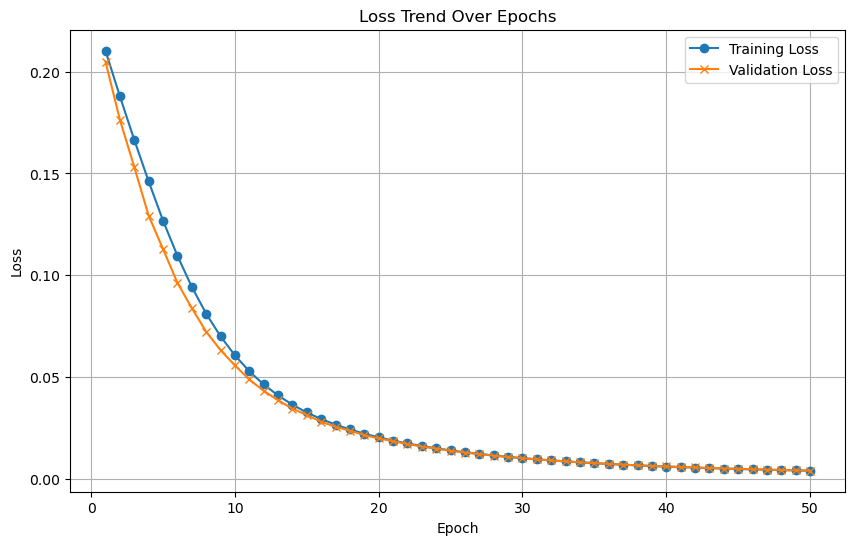

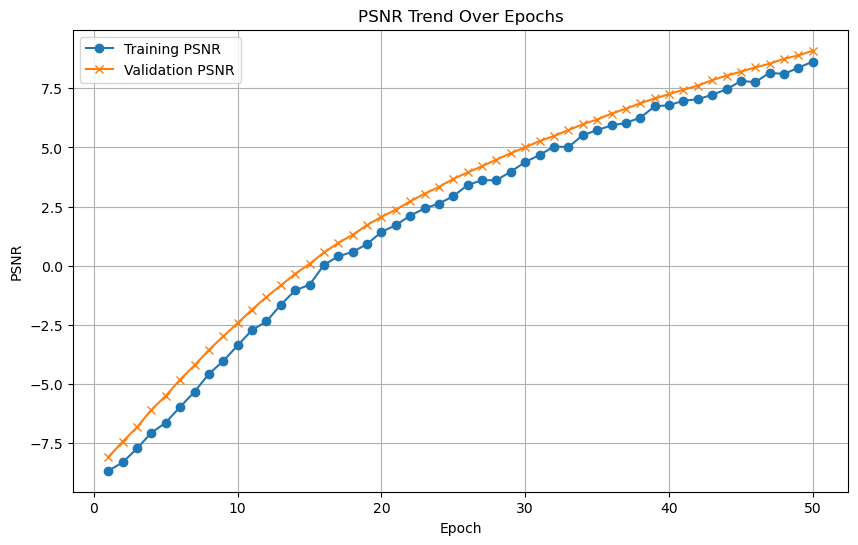

In [18]:
model_cae = ConvAutoEncode()
criterion_cae = nn.MSELoss()
optimizer_cae = optim.Adam(model_cae.parameters(), lr=0.0001)

#parameters for CAE
num_epochs_cae = 50
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model_cae = model_cae.to(device)

#early stopping parameters
patience = 3  # number of epochs to wait for improvement
tolerance = 1e-4
best_val_loss = float('inf')
epochs_without_improvement = 0

#grad accumulation parameters
accumulation_steps = 8 

# for loss and metrics tracking
autoencoder_epoch_losses_cae = []
validation_epoch_losses_cae = []
train_psnr = []
val_psnr = []

psnr = PeakSignalNoiseRatio().to(device)

# mixed precision training
scaler = GradScaler()  # Gradient scaler for mixed precision

for epoch in range(num_epochs_cae):
    # training
    model_cae.train()
    running_loss = 0.0
    running_psnr = 0.0

    print(f"\nLOG: Epoch [{epoch + 1}/{num_epochs_cae}]")

    optimizer_cae.zero_grad()

    for batch_idx, data in enumerate(train_loader_cae):
        data = data.to(device).permute(0, 3, 1, 2)

        # mixed precision forward pass
        with autocast(device_type='cuda', dtype=torch.float16):
            _, decoded = model_cae(data)
            loss = criterion_cae(decoded, data) / accumulation_steps

            with torch.no_grad():
                nan_in_out = torch.isnan(decoded).any().item()
                inf_in_out = torch.isinf(decoded).any().item()

        #backward pass with gradient scaling
        scaler.scale(loss).backward()

        loss_value = loss.item() * accumulation_steps
        running_loss += loss_value

        psnr_value = psnr(decoded, data).item()
        running_psnr += psnr_value


        # performing optimizer step and reset gradients after `accumulation_steps` batches
        if (batch_idx + 1) % accumulation_steps == 0 or (batch_idx + 1) == len(train_loader_cae):
            scaler.step(optimizer_cae)
            scaler.update()
            optimizer_cae.zero_grad()

        if batch_idx == 0 or (batch_idx + 1) % 200 == 0:
            print(
    f"\t Training Batch [{batch_idx + 1}/{len(train_loader_cae)}], "
    f"Loss: {loss_value:.4f}, PSNR: {psnr_value:.4f}"
)


        #delete intermediate variables and clear GPU cache
        del data, decoded, loss
        torch.cuda.empty_cache()

    #compute average metrics for the epoch
    avg_train_loss = running_loss / len(train_loader_cae)
    avg_train_psnr = running_psnr / len(train_loader_cae)

    autoencoder_epoch_losses_cae.append(avg_train_loss)
    train_psnr.append(avg_train_psnr)

    print(f"Epoch [{epoch + 1}/{num_epochs_cae}] Training Loss: {avg_train_loss:.4f}, PSNR: {avg_train_psnr:.4f}")

    #clear GPU cache after training
    torch.cuda.empty_cache()

    #validation
    model_cae.eval()
    validation_loss = 0.0
    val_psnr_epoch = 0.0

    with torch.no_grad():
        for batch_idx, data in enumerate(val_loader_cae):
            data = data.to(device).permute(0, 3, 1, 2)

            # Mixed precision forward pass for validation
            with autocast(device_type='cuda', dtype=torch.float16):
                _, decoded = model_cae(data)
                loss = criterion_cae(decoded, data)

            validation_loss += loss.item()
            val_psnr_epoch += psnr(decoded, data).item()

            if batch_idx == 0 or (batch_idx + 1) % 10 == 0:
                loss_val = loss.item()
                psnr_val = psnr(decoded, data).item()
                print(
                    f"\t[Val]   Batch [{batch_idx + 1}/{len(val_loader_cae)}] "
                    f"Loss: {loss_val:.4f}, PSNR: {psnr_val:.4f}"
                )

            del data, decoded, loss
            torch.cuda.empty_cache()

    # average validation metrics for the epoch
    avg_val_loss = validation_loss / len(val_loader_cae)
    avg_val_psnr = val_psnr_epoch / len(val_loader_cae)

    validation_epoch_losses_cae.append(avg_val_loss)
    val_psnr.append(avg_val_psnr)

    print(f"Epoch [{epoch + 1}/{num_epochs_cae}] Validation Loss: {avg_val_loss:.4f}, PSNR: {avg_val_psnr:.4f}")

    # early stopping logic
    if avg_val_loss < best_val_loss - tolerance:
        best_val_loss = avg_val_loss
        epochs_without_improvement = 0  # Reset counter
        #best model checkpoint
        #torch.save(model_cae.state_dict(), 'best_model_cae.pth')
    else:
        epochs_without_improvement += 1

    if epochs_without_improvement >= patience:
        print(f"Early stopping triggered at epoch {epoch + 1}. No improvement for {patience} epochs.")
        break

#plot for training and validation loss trends
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(autoencoder_epoch_losses_cae) + 1), autoencoder_epoch_losses_cae, marker='o', label="Training Loss")
plt.plot(range(1, len(validation_epoch_losses_cae) + 1), validation_epoch_losses_cae, marker='x', label="Validation Loss")
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss Trend Over Epochs')
plt.legend()
plt.grid()
plt.show()

#plot for PSNR trends
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(train_psnr) + 1), train_psnr, marker='o', label="Training PSNR")
plt.plot(range(1, len(val_psnr) + 1), val_psnr, marker='x', label="Validation PSNR")
plt.xlabel('Epoch')
plt.ylabel('PSNR')
plt.title('PSNR Trend Over Epochs')
plt.legend()
plt.grid()
plt.show()

## Using the encoder section of CAE as feature extractor to generate compact representations

In [19]:
#dir to save encoded representations
encoded_dir = 'encoded_representations'
os.makedirs(encoded_dir, exist_ok=True)

loaders = {
    'train': train_loader,
    'val': val_loader,
    'test': test_loader
}

model_cae.eval()

# Feature extraction
with torch.no_grad():
    for subset_name, loader in loaders.items():
        print(f"\nExtracting representations for the {subset_name} dataset...")

        # dir for the given subset's encoded features
        subset_encoded_dir = os.path.join(encoded_dir, subset_name)
        os.makedirs(subset_encoded_dir, exist_ok=True)

        for batch_idx, (data, labels) in enumerate(loader):
            data = data.to(device).permute(0, 3, 1, 2)

            # passing data through the encoder to obtain representations
            encoded_features, _ = model_cae(data)  # latent representation

            # moving to CPU and convert to NumPy
            encoded_features = encoded_features.cpu().numpy()  
            labels = labels.cpu().numpy() 

            #saving the encoded features and labels
            np.save(os.path.join(subset_encoded_dir, f'encoded_batch_{batch_idx}.npy'), encoded_features)
            np.save(os.path.join(subset_encoded_dir, f'labels_batch_{batch_idx}.npy'), labels)

            if batch_idx % 1 == 0 and subset_name != 'test':
                print(f"    Processed batch {batch_idx + 1}/{len(loader)} for {subset_name} dataset.")
            elif subset_name == 'test' and batch_idx % 100 == 0:  # Log less frequently for the test set
                print(f"    Processed batch {batch_idx + 1}/{len(loader)} for {subset_name} dataset.")

        print(f"Completed encoding for the {subset_name} dataset.")

print("Feature extraction completed for all subsets.")


Extracting representations for the train dataset...
    Processed batch 1/1 for train dataset.
Completed encoding for the train dataset.

Extracting representations for the val dataset...
    Processed batch 1/1 for val dataset.
Completed encoding for the val dataset.

Extracting representations for the test dataset...
    Processed batch 1/12 for test dataset.
Completed encoding for the test dataset.
Feature extraction completed for all subsets.


## End-To-End CNN

In [20]:
class hyperspectralCNN(nn.Module):
    def __init__(self, input_channels, num_classes):
        super(hyperspectralCNN, self).__init__()

        self.cnn_layers = nn.Sequential(
            # Block 1
            nn.Conv2d(input_channels, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),

            nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),  # 5x5 -> 2x2

            # Block 2
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),

            # Bottleneck
            nn.Conv2d(128, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),

            nn.MaxPool2d(2, 2)  # 2x2 -> 1x1
        )

        #fully connected layers for classification
        self.fc_layers = nn.Sequential(
            nn.Flatten(),  #3D to 1D vector for input to FC layers
            nn.Linear(16 * 2 * 2, 64),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, num_classes)
        )

    def forward(self, x):
        x = self.cnn_layers(x)
        x = self.fc_layers(x)
        return x


LOG: Epoch [1/1000] - Training


Epoch [1/1000] completed, Average Training Loss: 2.6464
    Validation Batch [1/1], Loss: 2.6432
Validation Loss: 2.6432, Validation Accuracy: 7.14%
Validation loss improved from inf to 2.6432. Saving model...

LOG: Epoch [2/1000] - Training
Epoch [2/1000] completed, Average Training Loss: 2.6023
    Validation Batch [1/1], Loss: 2.6432
Validation Loss: 2.6432, Validation Accuracy: 7.14%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [3/1000] - Training
Epoch [3/1000] completed, Average Training Loss: 2.5779
    Validation Batch [1/1], Loss: 2.6432
Validation Loss: 2.6432, Validation Accuracy: 7.14%
Validation loss improved from 2.6432 to 2.6432. Saving model...

LOG: Epoch [4/1000] - Training
Epoch [4/1000] completed, Average Training Loss: 2.5596
    Validation Batch [1/1], Loss: 2.6432
Validation Loss: 2.6432, Validation Accuracy: 7.14%
Validation loss improved from 2.6432 to 2.6432. Saving model...

LOG: Epoch [5/1000] - Training
Epoch [5/1000] completed, Average Trai

Epoch [16/1000] completed, Average Training Loss: 2.3790
    Validation Batch [1/1], Loss: 2.6418
Validation Loss: 2.6418, Validation Accuracy: 7.14%
Validation loss improved from 2.6419 to 2.6418. Saving model...

LOG: Epoch [17/1000] - Training
Epoch [17/1000] completed, Average Training Loss: 2.3693
    Validation Batch [1/1], Loss: 2.6416
Validation Loss: 2.6416, Validation Accuracy: 7.14%
Validation loss improved from 2.6418 to 2.6416. Saving model...

LOG: Epoch [18/1000] - Training
Epoch [18/1000] completed, Average Training Loss: 2.3460
    Validation Batch [1/1], Loss: 2.6415
Validation Loss: 2.6415, Validation Accuracy: 7.14%
Validation loss improved from 2.6416 to 2.6415. Saving model...

LOG: Epoch [19/1000] - Training
Epoch [19/1000] completed, Average Training Loss: 2.3363
    Validation Batch [1/1], Loss: 2.6414
Validation Loss: 2.6414, Validation Accuracy: 7.14%
Validation loss improved from 2.6415 to 2.6414. Saving model...

LOG: Epoch [20/1000] - Training
Epoch [20/10

Epoch [24/1000] completed, Average Training Loss: 2.2761
    Validation Batch [1/1], Loss: 2.6404
Validation Loss: 2.6404, Validation Accuracy: 7.14%
Validation loss improved from 2.6406 to 2.6404. Saving model...

LOG: Epoch [25/1000] - Training
Epoch [25/1000] completed, Average Training Loss: 2.2492
    Validation Batch [1/1], Loss: 2.6402
Validation Loss: 2.6402, Validation Accuracy: 7.14%
Validation loss improved from 2.6404 to 2.6402. Saving model...

LOG: Epoch [26/1000] - Training
Epoch [26/1000] completed, Average Training Loss: 2.2433
    Validation Batch [1/1], Loss: 2.6399
Validation Loss: 2.6399, Validation Accuracy: 7.14%
Validation loss improved from 2.6402 to 2.6399. Saving model...

LOG: Epoch [27/1000] - Training
Epoch [27/1000] completed, Average Training Loss: 2.2203
    Validation Batch [1/1], Loss: 2.6398
Validation Loss: 2.6398, Validation Accuracy: 7.14%
Validation loss improved from 2.6399 to 2.6398. Saving model...

LOG: Epoch [28/1000] - Training
Epoch [28/10

Epoch [39/1000] completed, Average Training Loss: 2.0824
    Validation Batch [1/1], Loss: 2.6348
Validation Loss: 2.6348, Validation Accuracy: 7.14%
Validation loss improved from 2.6352 to 2.6348. Saving model...

LOG: Epoch [40/1000] - Training
Epoch [40/1000] completed, Average Training Loss: 2.0698
    Validation Batch [1/1], Loss: 2.6341
Validation Loss: 2.6341, Validation Accuracy: 7.14%
Validation loss improved from 2.6348 to 2.6341. Saving model...

LOG: Epoch [41/1000] - Training
Epoch [41/1000] completed, Average Training Loss: 2.0572
    Validation Batch [1/1], Loss: 2.6333
Validation Loss: 2.6333, Validation Accuracy: 7.14%
Validation loss improved from 2.6341 to 2.6333. Saving model...

LOG: Epoch [42/1000] - Training
Epoch [42/1000] completed, Average Training Loss: 2.0449
    Validation Batch [1/1], Loss: 2.6320
Validation Loss: 2.6320, Validation Accuracy: 7.14%
Validation loss improved from 2.6333 to 2.6320. Saving model...

LOG: Epoch [43/1000] - Training
Epoch [43/10

    Validation Batch [1/1], Loss: 2.6237
Validation Loss: 2.6237, Validation Accuracy: 7.14%
Validation loss improved from 2.6255 to 2.6237. Saving model...

LOG: Epoch [48/1000] - Training
Epoch [48/1000] completed, Average Training Loss: 1.9843
    Validation Batch [1/1], Loss: 2.6214
Validation Loss: 2.6214, Validation Accuracy: 7.14%
Validation loss improved from 2.6237 to 2.6214. Saving model...

LOG: Epoch [49/1000] - Training
Epoch [49/1000] completed, Average Training Loss: 1.9891
    Validation Batch [1/1], Loss: 2.6186
Validation Loss: 2.6186, Validation Accuracy: 7.14%
Validation loss improved from 2.6214 to 2.6186. Saving model...

LOG: Epoch [50/1000] - Training
Epoch [50/1000] completed, Average Training Loss: 1.9627
    Validation Batch [1/1], Loss: 2.6156
Validation Loss: 2.6156, Validation Accuracy: 7.14%
Validation loss improved from 2.6186 to 2.6156. Saving model...

LOG: Epoch [51/1000] - Training
Epoch [51/1000] completed, Average Training Loss: 1.9378
    Validati

Epoch [62/1000] completed, Average Training Loss: 1.8366
    Validation Batch [1/1], Loss: 2.5040
Validation Loss: 2.5040, Validation Accuracy: 14.29%
Validation loss improved from 2.5195 to 2.5040. Saving model...

LOG: Epoch [63/1000] - Training
Epoch [63/1000] completed, Average Training Loss: 1.8151
    Validation Batch [1/1], Loss: 2.4887
Validation Loss: 2.4887, Validation Accuracy: 14.29%
Validation loss improved from 2.5040 to 2.4887. Saving model...

LOG: Epoch [64/1000] - Training
Epoch [64/1000] completed, Average Training Loss: 1.8299
    Validation Batch [1/1], Loss: 2.4714
Validation Loss: 2.4714, Validation Accuracy: 14.29%
Validation loss improved from 2.4887 to 2.4714. Saving model...

LOG: Epoch [65/1000] - Training
Epoch [65/1000] completed, Average Training Loss: 1.8187
    Validation Batch [1/1], Loss: 2.4572
Validation Loss: 2.4572, Validation Accuracy: 17.14%
Validation loss improved from 2.4714 to 2.4572. Saving model...

LOG: Epoch [66/1000] - Training
Epoch [6

Epoch [69/1000] completed, Average Training Loss: 1.7669
    Validation Batch [1/1], Loss: 2.3666
Validation Loss: 2.3666, Validation Accuracy: 34.29%
Validation loss improved from 2.3920 to 2.3666. Saving model...

LOG: Epoch [70/1000] - Training
Epoch [70/1000] completed, Average Training Loss: 1.7813
    Validation Batch [1/1], Loss: 2.3465
Validation Loss: 2.3465, Validation Accuracy: 38.57%
Validation loss improved from 2.3666 to 2.3465. Saving model...

LOG: Epoch [71/1000] - Training
Epoch [71/1000] completed, Average Training Loss: 1.7584
    Validation Batch [1/1], Loss: 2.3303
Validation Loss: 2.3303, Validation Accuracy: 44.29%
Validation loss improved from 2.3465 to 2.3303. Saving model...

LOG: Epoch [72/1000] - Training
Epoch [72/1000] completed, Average Training Loss: 1.7519
    Validation Batch [1/1], Loss: 2.3032
Validation Loss: 2.3032, Validation Accuracy: 44.29%
Validation loss improved from 2.3303 to 2.3032. Saving model...

LOG: Epoch [73/1000] - Training
Epoch [7

Epoch [86/1000] completed, Average Training Loss: 1.6102
    Validation Batch [1/1], Loss: 1.8682
Validation Loss: 1.8682, Validation Accuracy: 58.57%
Validation loss improved from 1.8859 to 1.8682. Saving model...

LOG: Epoch [87/1000] - Training
Epoch [87/1000] completed, Average Training Loss: 1.6090
    Validation Batch [1/1], Loss: 1.8507
Validation Loss: 1.8507, Validation Accuracy: 60.00%
Validation loss improved from 1.8682 to 1.8507. Saving model...

LOG: Epoch [88/1000] - Training
Epoch [88/1000] completed, Average Training Loss: 1.6267
    Validation Batch [1/1], Loss: 1.8180
Validation Loss: 1.8180, Validation Accuracy: 61.43%
Validation loss improved from 1.8507 to 1.8180. Saving model...

LOG: Epoch [89/1000] - Training
Epoch [89/1000] completed, Average Training Loss: 1.5670
    Validation Batch [1/1], Loss: 1.7818
Validation Loss: 1.7818, Validation Accuracy: 62.86%
Validation loss improved from 1.8180 to 1.7818. Saving model...

LOG: Epoch [90/1000] - Training
Epoch [9

Epoch [92/1000] completed, Average Training Loss: 1.5793
    Validation Batch [1/1], Loss: 1.7236
Validation Loss: 1.7236, Validation Accuracy: 61.43%
Validation loss improved from 1.7520 to 1.7236. Saving model...

LOG: Epoch [93/1000] - Training
Epoch [93/1000] completed, Average Training Loss: 1.5506
    Validation Batch [1/1], Loss: 1.6885
Validation Loss: 1.6885, Validation Accuracy: 68.57%
Validation loss improved from 1.7236 to 1.6885. Saving model...

LOG: Epoch [94/1000] - Training
Epoch [94/1000] completed, Average Training Loss: 1.5757
    Validation Batch [1/1], Loss: 1.6620
Validation Loss: 1.6620, Validation Accuracy: 70.00%
Validation loss improved from 1.6885 to 1.6620. Saving model...

LOG: Epoch [95/1000] - Training
Epoch [95/1000] completed, Average Training Loss: 1.5543
    Validation Batch [1/1], Loss: 1.6488
Validation Loss: 1.6488, Validation Accuracy: 71.43%
Validation loss improved from 1.6620 to 1.6488. Saving model...

LOG: Epoch [96/1000] - Training
Epoch [9

Epoch [108/1000] completed, Average Training Loss: 1.4332
    Validation Batch [1/1], Loss: 1.4829
Validation Loss: 1.4829, Validation Accuracy: 74.29%
Validation loss improved from 1.4967 to 1.4829. Saving model...

LOG: Epoch [109/1000] - Training
Epoch [109/1000] completed, Average Training Loss: 1.4389
    Validation Batch [1/1], Loss: 1.4803
Validation Loss: 1.4803, Validation Accuracy: 71.43%
Validation loss improved from 1.4829 to 1.4803. Saving model...

LOG: Epoch [110/1000] - Training
Epoch [110/1000] completed, Average Training Loss: 1.4218
    Validation Batch [1/1], Loss: 1.4651
Validation Loss: 1.4651, Validation Accuracy: 74.29%
Validation loss improved from 1.4803 to 1.4651. Saving model...

LOG: Epoch [111/1000] - Training
Epoch [111/1000] completed, Average Training Loss: 1.4068
    Validation Batch [1/1], Loss: 1.4459
Validation Loss: 1.4459, Validation Accuracy: 75.71%
Validation loss improved from 1.4651 to 1.4459. Saving model...

LOG: Epoch [112/1000] - Training


Epoch [116/1000] completed, Average Training Loss: 1.3710
    Validation Batch [1/1], Loss: 1.3837
Validation Loss: 1.3837, Validation Accuracy: 78.57%
Validation loss improved from 1.3981 to 1.3837. Saving model...

LOG: Epoch [117/1000] - Training
Epoch [117/1000] completed, Average Training Loss: 1.3697
    Validation Batch [1/1], Loss: 1.3817
Validation Loss: 1.3817, Validation Accuracy: 80.00%
Validation loss improved from 1.3837 to 1.3817. Saving model...

LOG: Epoch [118/1000] - Training
Epoch [118/1000] completed, Average Training Loss: 1.3450
    Validation Batch [1/1], Loss: 1.3860
Validation Loss: 1.3860, Validation Accuracy: 80.00%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [119/1000] - Training
Epoch [119/1000] completed, Average Training Loss: 1.3578
    Validation Batch [1/1], Loss: 1.3795
Validation Loss: 1.3795, Validation Accuracy: 77.14%
Validation loss improved from 1.3817 to 1.3795. Saving model...

LOG: Epoch [120/1000] - Training
Epoch [120/1000

Epoch [130/1000] completed, Average Training Loss: 1.2565
    Validation Batch [1/1], Loss: 1.2828
Validation Loss: 1.2828, Validation Accuracy: 84.29%
Validation loss improved from 1.2987 to 1.2828. Saving model...

LOG: Epoch [131/1000] - Training
Epoch [131/1000] completed, Average Training Loss: 1.2405
    Validation Batch [1/1], Loss: 1.2712
Validation Loss: 1.2712, Validation Accuracy: 81.43%
Validation loss improved from 1.2828 to 1.2712. Saving model...

LOG: Epoch [132/1000] - Training
Epoch [132/1000] completed, Average Training Loss: 1.2367
    Validation Batch [1/1], Loss: 1.2676
Validation Loss: 1.2676, Validation Accuracy: 82.86%
Validation loss improved from 1.2712 to 1.2676. Saving model...

LOG: Epoch [133/1000] - Training
Epoch [133/1000] completed, Average Training Loss: 1.2389
    Validation Batch [1/1], Loss: 1.2720
Validation Loss: 1.2720, Validation Accuracy: 87.14%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [134/1000] - Training
Epoch [134/1000

    Validation Batch [1/1], Loss: 1.2254
Validation Loss: 1.2254, Validation Accuracy: 87.14%
Validation loss improved from 1.2287 to 1.2254. Saving model...

LOG: Epoch [138/1000] - Training
Epoch [138/1000] completed, Average Training Loss: 1.1913
    Validation Batch [1/1], Loss: 1.2250
Validation Loss: 1.2250, Validation Accuracy: 85.71%
Validation loss improved from 1.2254 to 1.2250. Saving model...

LOG: Epoch [139/1000] - Training
Epoch [139/1000] completed, Average Training Loss: 1.2137
    Validation Batch [1/1], Loss: 1.2366
Validation Loss: 1.2366, Validation Accuracy: 81.43%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [140/1000] - Training
Epoch [140/1000] completed, Average Training Loss: 1.1986
    Validation Batch [1/1], Loss: 1.2221
Validation Loss: 1.2221, Validation Accuracy: 82.86%
Validation loss improved from 1.2250 to 1.2221. Saving model...

LOG: Epoch [141/1000] - Training
Epoch [141/1000] completed, Average Training Loss: 1.1624
    Validation 

Epoch [151/1000] completed, Average Training Loss: 1.1012
    Validation Batch [1/1], Loss: 1.1331
Validation Loss: 1.1331, Validation Accuracy: 88.57%
Validation loss improved from 1.1364 to 1.1331. Saving model...

LOG: Epoch [152/1000] - Training
Epoch [152/1000] completed, Average Training Loss: 1.0875
    Validation Batch [1/1], Loss: 1.1385
Validation Loss: 1.1385, Validation Accuracy: 84.29%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [153/1000] - Training
Epoch [153/1000] completed, Average Training Loss: 1.0756
    Validation Batch [1/1], Loss: 1.1199
Validation Loss: 1.1199, Validation Accuracy: 87.14%
Validation loss improved from 1.1331 to 1.1199. Saving model...

LOG: Epoch [154/1000] - Training
Epoch [154/1000] completed, Average Training Loss: 1.0699
    Validation Batch [1/1], Loss: 1.1050
Validation Loss: 1.1050, Validation Accuracy: 87.14%
Validation loss improved from 1.1199 to 1.1050. Saving model...

LOG: Epoch [155/1000] - Training
Epoch [155/1000

    Validation Batch [1/1], Loss: 1.0680
Validation Loss: 1.0680, Validation Accuracy: 87.14%
Validation loss improved from 1.0783 to 1.0680. Saving model...

LOG: Epoch [161/1000] - Training
Epoch [161/1000] completed, Average Training Loss: 1.0443
    Validation Batch [1/1], Loss: 1.0651
Validation Loss: 1.0651, Validation Accuracy: 88.57%
Validation loss improved from 1.0680 to 1.0651. Saving model...

LOG: Epoch [162/1000] - Training
Epoch [162/1000] completed, Average Training Loss: 1.0109
    Validation Batch [1/1], Loss: 1.0569
Validation Loss: 1.0569, Validation Accuracy: 88.57%
Validation loss improved from 1.0651 to 1.0569. Saving model...

LOG: Epoch [163/1000] - Training
Epoch [163/1000] completed, Average Training Loss: 1.0054
    Validation Batch [1/1], Loss: 1.0362
Validation Loss: 1.0362, Validation Accuracy: 90.00%
Validation loss improved from 1.0569 to 1.0362. Saving model...

LOG: Epoch [164/1000] - Training
Epoch [164/1000] completed, Average Training Loss: 1.0032


Epoch [173/1000] completed, Average Training Loss: 0.9403
    Validation Batch [1/1], Loss: 0.9672
Validation Loss: 0.9672, Validation Accuracy: 92.86%
Validation loss improved from 0.9769 to 0.9672. Saving model...

LOG: Epoch [174/1000] - Training
Epoch [174/1000] completed, Average Training Loss: 0.9424
    Validation Batch [1/1], Loss: 0.9668
Validation Loss: 0.9668, Validation Accuracy: 92.86%
Validation loss improved from 0.9672 to 0.9668. Saving model...

LOG: Epoch [175/1000] - Training
Epoch [175/1000] completed, Average Training Loss: 0.9234
    Validation Batch [1/1], Loss: 0.9677
Validation Loss: 0.9677, Validation Accuracy: 92.86%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [176/1000] - Training
Epoch [176/1000] completed, Average Training Loss: 0.8971
    Validation Batch [1/1], Loss: 0.9531
Validation Loss: 0.9531, Validation Accuracy: 94.29%
Validation loss improved from 0.9668 to 0.9531. Saving model...

LOG: Epoch [177/1000] - Training
Epoch [177/1000

Epoch [183/1000] completed, Average Training Loss: 0.8801
    Validation Batch [1/1], Loss: 0.9068
Validation Loss: 0.9068, Validation Accuracy: 97.14%
Validation loss improved from 0.9125 to 0.9068. Saving model...

LOG: Epoch [184/1000] - Training
Epoch [184/1000] completed, Average Training Loss: 0.8649
    Validation Batch [1/1], Loss: 0.8852
Validation Loss: 0.8852, Validation Accuracy: 98.57%
Validation loss improved from 0.9068 to 0.8852. Saving model...

LOG: Epoch [185/1000] - Training
Epoch [185/1000] completed, Average Training Loss: 0.8726
    Validation Batch [1/1], Loss: 0.8809
Validation Loss: 0.8809, Validation Accuracy: 98.57%
Validation loss improved from 0.8852 to 0.8809. Saving model...

LOG: Epoch [186/1000] - Training
Epoch [186/1000] completed, Average Training Loss: 0.8485
    Validation Batch [1/1], Loss: 0.8707
Validation Loss: 0.8707, Validation Accuracy: 98.57%
Validation loss improved from 0.8809 to 0.8707. Saving model...

LOG: Epoch [187/1000] - Training


Epoch [196/1000] completed, Average Training Loss: 0.7821
    Validation Batch [1/1], Loss: 0.8116
Validation Loss: 0.8116, Validation Accuracy: 98.57%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [197/1000] - Training
Epoch [197/1000] completed, Average Training Loss: 0.7616
    Validation Batch [1/1], Loss: 0.8115
Validation Loss: 0.8115, Validation Accuracy: 97.14%
Validation loss did not improve. Patience: 2/100

LOG: Epoch [198/1000] - Training
Epoch [198/1000] completed, Average Training Loss: 0.7570
    Validation Batch [1/1], Loss: 0.7995
Validation Loss: 0.7995, Validation Accuracy: 97.14%
Validation loss improved from 0.8091 to 0.7995. Saving model...

LOG: Epoch [199/1000] - Training
Epoch [199/1000] completed, Average Training Loss: 0.7531
    Validation Batch [1/1], Loss: 0.7873
Validation Loss: 0.7873, Validation Accuracy: 97.14%
Validation loss improved from 0.7995 to 0.7873. Saving model...

LOG: Epoch [200/1000] - Training
Epoch [200/1000] completed, Av

    Validation Batch [1/1], Loss: 0.7521
Validation Loss: 0.7521, Validation Accuracy: 98.57%
Validation loss improved from 0.7670 to 0.7521. Saving model...

LOG: Epoch [206/1000] - Training
Epoch [206/1000] completed, Average Training Loss: 0.7085
    Validation Batch [1/1], Loss: 0.7438
Validation Loss: 0.7438, Validation Accuracy: 98.57%
Validation loss improved from 0.7521 to 0.7438. Saving model...

LOG: Epoch [207/1000] - Training
Epoch [207/1000] completed, Average Training Loss: 0.7219
    Validation Batch [1/1], Loss: 0.7399
Validation Loss: 0.7399, Validation Accuracy: 98.57%
Validation loss improved from 0.7438 to 0.7399. Saving model...

LOG: Epoch [208/1000] - Training
Epoch [208/1000] completed, Average Training Loss: 0.6911
    Validation Batch [1/1], Loss: 0.7318
Validation Loss: 0.7318, Validation Accuracy: 97.14%
Validation loss improved from 0.7399 to 0.7318. Saving model...

LOG: Epoch [209/1000] - Training
Epoch [209/1000] completed, Average Training Loss: 0.7063


Epoch [219/1000] completed, Average Training Loss: 0.6276
    Validation Batch [1/1], Loss: 0.6605
Validation Loss: 0.6605, Validation Accuracy: 98.57%
Validation loss improved from 0.6717 to 0.6605. Saving model...

LOG: Epoch [220/1000] - Training
Epoch [220/1000] completed, Average Training Loss: 0.6343
    Validation Batch [1/1], Loss: 0.6582
Validation Loss: 0.6582, Validation Accuracy: 97.14%
Validation loss improved from 0.6605 to 0.6582. Saving model...

LOG: Epoch [221/1000] - Training
Epoch [221/1000] completed, Average Training Loss: 0.6171
    Validation Batch [1/1], Loss: 0.6522
Validation Loss: 0.6522, Validation Accuracy: 97.14%
Validation loss improved from 0.6582 to 0.6522. Saving model...

LOG: Epoch [222/1000] - Training
Epoch [222/1000] completed, Average Training Loss: 0.6112
    Validation Batch [1/1], Loss: 0.6478
Validation Loss: 0.6478, Validation Accuracy: 98.57%
Validation loss improved from 0.6522 to 0.6478. Saving model...

LOG: Epoch [223/1000] - Training


Epoch [229/1000] completed, Average Training Loss: 0.5697
    Validation Batch [1/1], Loss: 0.6060
Validation Loss: 0.6060, Validation Accuracy: 97.14%
Validation loss improved from 0.6086 to 0.6060. Saving model...

LOG: Epoch [230/1000] - Training
Epoch [230/1000] completed, Average Training Loss: 0.5656
    Validation Batch [1/1], Loss: 0.6033
Validation Loss: 0.6033, Validation Accuracy: 98.57%
Validation loss improved from 0.6060 to 0.6033. Saving model...

LOG: Epoch [231/1000] - Training
Epoch [231/1000] completed, Average Training Loss: 0.5812
    Validation Batch [1/1], Loss: 0.6021
Validation Loss: 0.6021, Validation Accuracy: 98.57%
Validation loss improved from 0.6033 to 0.6021. Saving model...

LOG: Epoch [232/1000] - Training
Epoch [232/1000] completed, Average Training Loss: 0.5868
    Validation Batch [1/1], Loss: 0.5960
Validation Loss: 0.5960, Validation Accuracy: 98.57%
Validation loss improved from 0.6021 to 0.5960. Saving model...

LOG: Epoch [233/1000] - Training


Epoch [241/1000] completed, Average Training Loss: 0.5479
    Validation Batch [1/1], Loss: 0.5407
Validation Loss: 0.5407, Validation Accuracy: 98.57%
Validation loss improved from 0.5479 to 0.5407. Saving model...

LOG: Epoch [242/1000] - Training
Epoch [242/1000] completed, Average Training Loss: 0.5235
    Validation Batch [1/1], Loss: 0.5345
Validation Loss: 0.5345, Validation Accuracy: 98.57%
Validation loss improved from 0.5407 to 0.5345. Saving model...

LOG: Epoch [243/1000] - Training
Epoch [243/1000] completed, Average Training Loss: 0.5134
    Validation Batch [1/1], Loss: 0.5349
Validation Loss: 0.5349, Validation Accuracy: 98.57%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [244/1000] - Training
Epoch [244/1000] completed, Average Training Loss: 0.5162
    Validation Batch [1/1], Loss: 0.5315
Validation Loss: 0.5315, Validation Accuracy: 98.57%
Validation loss improved from 0.5345 to 0.5315. Saving model...

LOG: Epoch [245/1000] - Training
Epoch [245/1000

Epoch [253/1000] completed, Average Training Loss: 0.4862
    Validation Batch [1/1], Loss: 0.4897
Validation Loss: 0.4897, Validation Accuracy: 98.57%
Validation loss improved from 0.4999 to 0.4897. Saving model...

LOG: Epoch [254/1000] - Training
Epoch [254/1000] completed, Average Training Loss: 0.4699
    Validation Batch [1/1], Loss: 0.4811
Validation Loss: 0.4811, Validation Accuracy: 98.57%
Validation loss improved from 0.4897 to 0.4811. Saving model...

LOG: Epoch [255/1000] - Training
Epoch [255/1000] completed, Average Training Loss: 0.4461
    Validation Batch [1/1], Loss: 0.4766
Validation Loss: 0.4766, Validation Accuracy: 98.57%
Validation loss improved from 0.4811 to 0.4766. Saving model...

LOG: Epoch [256/1000] - Training
Epoch [256/1000] completed, Average Training Loss: 0.4623
    Validation Batch [1/1], Loss: 0.4795
Validation Loss: 0.4795, Validation Accuracy: 98.57%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [257/1000] - Training
Epoch [257/1000

Epoch [265/1000] completed, Average Training Loss: 0.4093
    Validation Batch [1/1], Loss: 0.4423
Validation Loss: 0.4423, Validation Accuracy: 98.57%
Validation loss improved from 0.4553 to 0.4423. Saving model...

LOG: Epoch [266/1000] - Training
Epoch [266/1000] completed, Average Training Loss: 0.4270
    Validation Batch [1/1], Loss: 0.4461
Validation Loss: 0.4461, Validation Accuracy: 98.57%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [267/1000] - Training
Epoch [267/1000] completed, Average Training Loss: 0.3911
    Validation Batch [1/1], Loss: 0.4435
Validation Loss: 0.4435, Validation Accuracy: 98.57%
Validation loss did not improve. Patience: 2/100

LOG: Epoch [268/1000] - Training
Epoch [268/1000] completed, Average Training Loss: 0.4104
    Validation Batch [1/1], Loss: 0.4303
Validation Loss: 0.4303, Validation Accuracy: 98.57%
Validation loss improved from 0.4423 to 0.4303. Saving model...

LOG: Epoch [269/1000] - Training
Epoch [269/1000] completed, Av

Epoch [277/1000] completed, Average Training Loss: 0.3759
    Validation Batch [1/1], Loss: 0.3998
Validation Loss: 0.3998, Validation Accuracy: 98.57%
Validation loss improved from 0.4013 to 0.3998. Saving model...

LOG: Epoch [278/1000] - Training
Epoch [278/1000] completed, Average Training Loss: 0.3689
    Validation Batch [1/1], Loss: 0.3948
Validation Loss: 0.3948, Validation Accuracy: 98.57%
Validation loss improved from 0.3998 to 0.3948. Saving model...

LOG: Epoch [279/1000] - Training
Epoch [279/1000] completed, Average Training Loss: 0.3822
    Validation Batch [1/1], Loss: 0.3973
Validation Loss: 0.3973, Validation Accuracy: 98.57%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [280/1000] - Training
Epoch [280/1000] completed, Average Training Loss: 0.3707
    Validation Batch [1/1], Loss: 0.4025
Validation Loss: 0.4025, Validation Accuracy: 98.57%
Validation loss did not improve. Patience: 2/100

LOG: Epoch [281/1000] - Training
Epoch [281/1000] completed, Av

Epoch [287/1000] completed, Average Training Loss: 0.3649
    Validation Batch [1/1], Loss: 0.3733
Validation Loss: 0.3733, Validation Accuracy: 98.57%
Validation loss improved from 0.3755 to 0.3733. Saving model...

LOG: Epoch [288/1000] - Training
Epoch [288/1000] completed, Average Training Loss: 0.3582
    Validation Batch [1/1], Loss: 0.3746
Validation Loss: 0.3746, Validation Accuracy: 98.57%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [289/1000] - Training
Epoch [289/1000] completed, Average Training Loss: 0.3337
    Validation Batch [1/1], Loss: 0.3651
Validation Loss: 0.3651, Validation Accuracy: 98.57%
Validation loss improved from 0.3733 to 0.3651. Saving model...

LOG: Epoch [290/1000] - Training
Epoch [290/1000] completed, Average Training Loss: 0.3475
    Validation Batch [1/1], Loss: 0.3592
Validation Loss: 0.3592, Validation Accuracy: 97.14%
Validation loss improved from 0.3651 to 0.3592. Saving model...

LOG: Epoch [291/1000] - Training
Epoch [291/1000

    Validation Batch [1/1], Loss: 0.3422
Validation Loss: 0.3422, Validation Accuracy: 98.57%
Validation loss did not improve. Patience: 2/100

LOG: Epoch [299/1000] - Training
Epoch [299/1000] completed, Average Training Loss: 0.3171
    Validation Batch [1/1], Loss: 0.3480
Validation Loss: 0.3480, Validation Accuracy: 98.57%
Validation loss did not improve. Patience: 3/100

LOG: Epoch [300/1000] - Training
Epoch [300/1000] completed, Average Training Loss: 0.3204
    Validation Batch [1/1], Loss: 0.3598
Validation Loss: 0.3598, Validation Accuracy: 95.71%
Validation loss did not improve. Patience: 4/100

LOG: Epoch [301/1000] - Training
Epoch [301/1000] completed, Average Training Loss: 0.3136
    Validation Batch [1/1], Loss: 0.3411
Validation Loss: 0.3411, Validation Accuracy: 97.14%
Validation loss did not improve. Patience: 5/100

LOG: Epoch [302/1000] - Training
Epoch [302/1000] completed, Average Training Loss: 0.3310
    Validation Batch [1/1], Loss: 0.3288
Validation Loss: 0.

Epoch [308/1000] completed, Average Training Loss: 0.2820
    Validation Batch [1/1], Loss: 0.3191
Validation Loss: 0.3191, Validation Accuracy: 98.57%
Validation loss improved from 0.3201 to 0.3191. Saving model...

LOG: Epoch [309/1000] - Training
Epoch [309/1000] completed, Average Training Loss: 0.2764
    Validation Batch [1/1], Loss: 0.3135
Validation Loss: 0.3135, Validation Accuracy: 98.57%
Validation loss improved from 0.3191 to 0.3135. Saving model...

LOG: Epoch [310/1000] - Training
Epoch [310/1000] completed, Average Training Loss: 0.2967
    Validation Batch [1/1], Loss: 0.3091
Validation Loss: 0.3091, Validation Accuracy: 98.57%
Validation loss improved from 0.3135 to 0.3091. Saving model...

LOG: Epoch [311/1000] - Training
Epoch [311/1000] completed, Average Training Loss: 0.2964
    Validation Batch [1/1], Loss: 0.3203
Validation Loss: 0.3203, Validation Accuracy: 98.57%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [312/1000] - Training
Epoch [312/1000

Epoch [321/1000] completed, Average Training Loss: 0.2709
    Validation Batch [1/1], Loss: 0.2844
Validation Loss: 0.2844, Validation Accuracy: 98.57%
Validation loss improved from 0.2890 to 0.2844. Saving model...

LOG: Epoch [322/1000] - Training
Epoch [322/1000] completed, Average Training Loss: 0.2637
    Validation Batch [1/1], Loss: 0.2852
Validation Loss: 0.2852, Validation Accuracy: 98.57%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [323/1000] - Training
Epoch [323/1000] completed, Average Training Loss: 0.2566
    Validation Batch [1/1], Loss: 0.2889
Validation Loss: 0.2889, Validation Accuracy: 97.14%
Validation loss did not improve. Patience: 2/100

LOG: Epoch [324/1000] - Training
Epoch [324/1000] completed, Average Training Loss: 0.2712
    Validation Batch [1/1], Loss: 0.2763
Validation Loss: 0.2763, Validation Accuracy: 98.57%
Validation loss improved from 0.2844 to 0.2763. Saving model...

LOG: Epoch [325/1000] - Training
Epoch [325/1000] completed, Av

Epoch [330/1000] completed, Average Training Loss: 0.2281
    Validation Batch [1/1], Loss: 0.2797
Validation Loss: 0.2797, Validation Accuracy: 97.14%
Validation loss did not improve. Patience: 5/100

LOG: Epoch [331/1000] - Training
Epoch [331/1000] completed, Average Training Loss: 0.2298
    Validation Batch [1/1], Loss: 0.2742
Validation Loss: 0.2742, Validation Accuracy: 98.57%
Validation loss did not improve. Patience: 6/100

LOG: Epoch [332/1000] - Training
Epoch [332/1000] completed, Average Training Loss: 0.2462
    Validation Batch [1/1], Loss: 0.2659
Validation Loss: 0.2659, Validation Accuracy: 98.57%
Validation loss improved from 0.2722 to 0.2659. Saving model...

LOG: Epoch [333/1000] - Training
Epoch [333/1000] completed, Average Training Loss: 0.2627
    Validation Batch [1/1], Loss: 0.2622
Validation Loss: 0.2622, Validation Accuracy: 98.57%
Validation loss improved from 0.2659 to 0.2622. Saving model...

LOG: Epoch [334/1000] - Training
Epoch [334/1000] completed, Av

Epoch [343/1000] completed, Average Training Loss: 0.2269
    Validation Batch [1/1], Loss: 0.2508
Validation Loss: 0.2508, Validation Accuracy: 98.57%
Validation loss improved from 0.2569 to 0.2508. Saving model...

LOG: Epoch [344/1000] - Training
Epoch [344/1000] completed, Average Training Loss: 0.2242
    Validation Batch [1/1], Loss: 0.2485
Validation Loss: 0.2485, Validation Accuracy: 98.57%
Validation loss improved from 0.2508 to 0.2485. Saving model...

LOG: Epoch [345/1000] - Training
Epoch [345/1000] completed, Average Training Loss: 0.2285
    Validation Batch [1/1], Loss: 0.2511
Validation Loss: 0.2511, Validation Accuracy: 98.57%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [346/1000] - Training
Epoch [346/1000] completed, Average Training Loss: 0.2038
    Validation Batch [1/1], Loss: 0.2500
Validation Loss: 0.2500, Validation Accuracy: 97.14%
Validation loss did not improve. Patience: 2/100

LOG: Epoch [347/1000] - Training
Epoch [347/1000] completed, Av

    Validation Batch [1/1], Loss: 0.2362
Validation Loss: 0.2362, Validation Accuracy: 98.57%
Validation loss improved from 0.2383 to 0.2362. Saving model...

LOG: Epoch [354/1000] - Training
Epoch [354/1000] completed, Average Training Loss: 0.2187
    Validation Batch [1/1], Loss: 0.2358
Validation Loss: 0.2358, Validation Accuracy: 98.57%
Validation loss improved from 0.2362 to 0.2358. Saving model...

LOG: Epoch [355/1000] - Training
Epoch [355/1000] completed, Average Training Loss: 0.2076
    Validation Batch [1/1], Loss: 0.2336
Validation Loss: 0.2336, Validation Accuracy: 98.57%
Validation loss improved from 0.2358 to 0.2336. Saving model...

LOG: Epoch [356/1000] - Training
Epoch [356/1000] completed, Average Training Loss: 0.2020
    Validation Batch [1/1], Loss: 0.2340
Validation Loss: 0.2340, Validation Accuracy: 98.57%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [357/1000] - Training
Epoch [357/1000] completed, Average Training Loss: 0.2021
    Validation 

Epoch [365/1000] completed, Average Training Loss: 0.1892
    Validation Batch [1/1], Loss: 0.2461
Validation Loss: 0.2461, Validation Accuracy: 98.57%
Validation loss did not improve. Patience: 2/100

LOG: Epoch [366/1000] - Training
Epoch [366/1000] completed, Average Training Loss: 0.1817
    Validation Batch [1/1], Loss: 0.2474
Validation Loss: 0.2474, Validation Accuracy: 98.57%
Validation loss did not improve. Patience: 3/100

LOG: Epoch [367/1000] - Training
Epoch [367/1000] completed, Average Training Loss: 0.1871
    Validation Batch [1/1], Loss: 0.2324
Validation Loss: 0.2324, Validation Accuracy: 98.57%
Validation loss did not improve. Patience: 4/100

LOG: Epoch [368/1000] - Training
Epoch [368/1000] completed, Average Training Loss: 0.1974
    Validation Batch [1/1], Loss: 0.2143
Validation Loss: 0.2143, Validation Accuracy: 98.57%
Validation loss improved from 0.2285 to 0.2143. Saving model...

LOG: Epoch [369/1000] - Training
Epoch [369/1000] completed, Average Training 

    Validation Batch [1/1], Loss: 0.2206
Validation Loss: 0.2206, Validation Accuracy: 97.14%
Validation loss did not improve. Patience: 5/100

LOG: Epoch [376/1000] - Training
Epoch [376/1000] completed, Average Training Loss: 0.1902
    Validation Batch [1/1], Loss: 0.2072
Validation Loss: 0.2072, Validation Accuracy: 97.14%
Validation loss did not improve. Patience: 6/100

LOG: Epoch [377/1000] - Training
Epoch [377/1000] completed, Average Training Loss: 0.1640
    Validation Batch [1/1], Loss: 0.2016
Validation Loss: 0.2016, Validation Accuracy: 98.57%
Validation loss improved from 0.2044 to 0.2016. Saving model...

LOG: Epoch [378/1000] - Training
Epoch [378/1000] completed, Average Training Loss: 0.1684
    Validation Batch [1/1], Loss: 0.2061
Validation Loss: 0.2061, Validation Accuracy: 98.57%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [379/1000] - Training
Epoch [379/1000] completed, Average Training Loss: 0.1808
    Validation Batch [1/1], Loss: 0.2125
Vali

Epoch [389/1000] completed, Average Training Loss: 0.1620
    Validation Batch [1/1], Loss: 0.2093
Validation Loss: 0.2093, Validation Accuracy: 97.14%
Validation loss did not improve. Patience: 6/100

LOG: Epoch [390/1000] - Training
Epoch [390/1000] completed, Average Training Loss: 0.1480
    Validation Batch [1/1], Loss: 0.2021
Validation Loss: 0.2021, Validation Accuracy: 98.57%
Validation loss did not improve. Patience: 7/100

LOG: Epoch [391/1000] - Training
Epoch [391/1000] completed, Average Training Loss: 0.1467
    Validation Batch [1/1], Loss: 0.1895
Validation Loss: 0.1895, Validation Accuracy: 98.57%
Validation loss improved from 0.2011 to 0.1895. Saving model...

LOG: Epoch [392/1000] - Training
Epoch [392/1000] completed, Average Training Loss: 0.1555
    Validation Batch [1/1], Loss: 0.1902
Validation Loss: 0.1902, Validation Accuracy: 97.14%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [393/1000] - Training
Epoch [393/1000] completed, Average Training 

Epoch [400/1000] completed, Average Training Loss: 0.1474
    Validation Batch [1/1], Loss: 0.1972
Validation Loss: 0.1972, Validation Accuracy: 98.57%
Validation loss did not improve. Patience: 2/100

LOG: Epoch [401/1000] - Training
Epoch [401/1000] completed, Average Training Loss: 0.1481
    Validation Batch [1/1], Loss: 0.1891
Validation Loss: 0.1891, Validation Accuracy: 98.57%
Validation loss did not improve. Patience: 3/100

LOG: Epoch [402/1000] - Training
Epoch [402/1000] completed, Average Training Loss: 0.1627
    Validation Batch [1/1], Loss: 0.1929
Validation Loss: 0.1929, Validation Accuracy: 98.57%
Validation loss did not improve. Patience: 4/100

LOG: Epoch [403/1000] - Training
Epoch [403/1000] completed, Average Training Loss: 0.1391
    Validation Batch [1/1], Loss: 0.2085
Validation Loss: 0.2085, Validation Accuracy: 97.14%
Validation loss did not improve. Patience: 5/100

LOG: Epoch [404/1000] - Training
Epoch [404/1000] completed, Average Training Loss: 0.1486
  

    Validation Batch [1/1], Loss: 0.1722
Validation Loss: 0.1722, Validation Accuracy: 98.57%
Validation loss improved from 0.1746 to 0.1722. Saving model...

LOG: Epoch [414/1000] - Training
Epoch [414/1000] completed, Average Training Loss: 0.1314
    Validation Batch [1/1], Loss: 0.1766
Validation Loss: 0.1766, Validation Accuracy: 98.57%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [415/1000] - Training
Epoch [415/1000] completed, Average Training Loss: 0.1320
    Validation Batch [1/1], Loss: 0.1855
Validation Loss: 0.1855, Validation Accuracy: 98.57%
Validation loss did not improve. Patience: 2/100

LOG: Epoch [416/1000] - Training
Epoch [416/1000] completed, Average Training Loss: 0.1296
    Validation Batch [1/1], Loss: 0.1889
Validation Loss: 0.1889, Validation Accuracy: 98.57%
Validation loss did not improve. Patience: 3/100

LOG: Epoch [417/1000] - Training
Epoch [417/1000] completed, Average Training Loss: 0.1338
    Validation Batch [1/1], Loss: 0.1787
Vali

Epoch [423/1000] completed, Average Training Loss: 0.1300


    Validation Batch [1/1], Loss: 0.1909
Validation Loss: 0.1909, Validation Accuracy: 97.14%
Validation loss did not improve. Patience: 4/100

LOG: Epoch [424/1000] - Training
Epoch [424/1000] completed, Average Training Loss: 0.1325
    Validation Batch [1/1], Loss: 0.1652
Validation Loss: 0.1652, Validation Accuracy: 98.57%
Validation loss improved from 0.1654 to 0.1652. Saving model...

LOG: Epoch [425/1000] - Training
Epoch [425/1000] completed, Average Training Loss: 0.1273
    Validation Batch [1/1], Loss: 0.1594
Validation Loss: 0.1594, Validation Accuracy: 98.57%
Validation loss improved from 0.1652 to 0.1594. Saving model...

LOG: Epoch [426/1000] - Training
Epoch [426/1000] completed, Average Training Loss: 0.1236
    Validation Batch [1/1], Loss: 0.1671
Validation Loss: 0.1671, Validation Accuracy: 98.57%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [427/1000] - Training
Epoch [427/1000] completed, Average Training Loss: 0.1248
    Validation Batch [1/1], Lo

Epoch [446/1000] completed, Average Training Loss: 0.1085
    Validation Batch [1/1], Loss: 0.1484
Validation Loss: 0.1484, Validation Accuracy: 98.57%
Validation loss did not improve. Patience: 13/100

LOG: Epoch [447/1000] - Training
Epoch [447/1000] completed, Average Training Loss: 0.1192
    Validation Batch [1/1], Loss: 0.1522
Validation Loss: 0.1522, Validation Accuracy: 98.57%
Validation loss did not improve. Patience: 14/100

LOG: Epoch [448/1000] - Training
Epoch [448/1000] completed, Average Training Loss: 0.1150
    Validation Batch [1/1], Loss: 0.1580
Validation Loss: 0.1580, Validation Accuracy: 97.14%
Validation loss did not improve. Patience: 15/100

LOG: Epoch [449/1000] - Training
Epoch [449/1000] completed, Average Training Loss: 0.0995
    Validation Batch [1/1], Loss: 0.1671
Validation Loss: 0.1671, Validation Accuracy: 98.57%
Validation loss did not improve. Patience: 16/100

LOG: Epoch [450/1000] - Training
Epoch [450/1000] completed, Average Training Loss: 0.108

Epoch [470/1000] completed, Average Training Loss: 0.1057
    Validation Batch [1/1], Loss: 0.1443
Validation Loss: 0.1443, Validation Accuracy: 98.57%
Validation loss did not improve. Patience: 15/100

LOG: Epoch [471/1000] - Training
Epoch [471/1000] completed, Average Training Loss: 0.1012
    Validation Batch [1/1], Loss: 0.1341
Validation Loss: 0.1341, Validation Accuracy: 98.57%
Validation loss improved from 0.1376 to 0.1341. Saving model...

LOG: Epoch [472/1000] - Training
Epoch [472/1000] completed, Average Training Loss: 0.1056
    Validation Batch [1/1], Loss: 0.1288
Validation Loss: 0.1288, Validation Accuracy: 98.57%
Validation loss improved from 0.1341 to 0.1288. Saving model...

LOG: Epoch [473/1000] - Training
Epoch [473/1000] completed, Average Training Loss: 0.0952
    Validation Batch [1/1], Loss: 0.1340
Validation Loss: 0.1340, Validation Accuracy: 98.57%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [474/1000] - Training
Epoch [474/1000] completed, A

    Validation Batch [1/1], Loss: 0.1383
Validation Loss: 0.1383, Validation Accuracy: 98.57%
Validation loss did not improve. Patience: 4/100

LOG: Epoch [493/1000] - Training
Epoch [493/1000] completed, Average Training Loss: 0.0814
    Validation Batch [1/1], Loss: 0.1426
Validation Loss: 0.1426, Validation Accuracy: 98.57%
Validation loss did not improve. Patience: 5/100

LOG: Epoch [494/1000] - Training
Epoch [494/1000] completed, Average Training Loss: 0.0790
    Validation Batch [1/1], Loss: 0.1407
Validation Loss: 0.1407, Validation Accuracy: 98.57%
Validation loss did not improve. Patience: 6/100

LOG: Epoch [495/1000] - Training
Epoch [495/1000] completed, Average Training Loss: 0.0989
    Validation Batch [1/1], Loss: 0.1269
Validation Loss: 0.1269, Validation Accuracy: 98.57%
Validation loss did not improve. Patience: 7/100

LOG: Epoch [496/1000] - Training
Epoch [496/1000] completed, Average Training Loss: 0.0846
    Validation Batch [1/1], Loss: 0.1152
Validation Loss: 0.

Epoch [516/1000] completed, Average Training Loss: 0.0736
    Validation Batch [1/1], Loss: 0.1121
Validation Loss: 0.1121, Validation Accuracy: 98.57%
Validation loss did not improve. Patience: 2/100

LOG: Epoch [517/1000] - Training
Epoch [517/1000] completed, Average Training Loss: 0.0862
    Validation Batch [1/1], Loss: 0.1193
Validation Loss: 0.1193, Validation Accuracy: 98.57%
Validation loss did not improve. Patience: 3/100

LOG: Epoch [518/1000] - Training
Epoch [518/1000] completed, Average Training Loss: 0.0652
    Validation Batch [1/1], Loss: 0.1314
Validation Loss: 0.1314, Validation Accuracy: 97.14%
Validation loss did not improve. Patience: 4/100

LOG: Epoch [519/1000] - Training
Epoch [519/1000] completed, Average Training Loss: 0.0722
    Validation Batch [1/1], Loss: 0.1380
Validation Loss: 0.1380, Validation Accuracy: 97.14%
Validation loss did not improve. Patience: 5/100

LOG: Epoch [520/1000] - Training
Epoch [520/1000] completed, Average Training Loss: 0.0761
  

Epoch [539/1000] completed, Average Training Loss: 0.0750
    Validation Batch [1/1], Loss: 0.1221
Validation Loss: 0.1221, Validation Accuracy: 97.14%
Validation loss did not improve. Patience: 8/100

LOG: Epoch [540/1000] - Training
Epoch [540/1000] completed, Average Training Loss: 0.0716
    Validation Batch [1/1], Loss: 0.1101
Validation Loss: 0.1101, Validation Accuracy: 97.14%
Validation loss did not improve. Patience: 9/100

LOG: Epoch [541/1000] - Training
Epoch [541/1000] completed, Average Training Loss: 0.0688
    Validation Batch [1/1], Loss: 0.1004
Validation Loss: 0.1004, Validation Accuracy: 98.57%
Validation loss did not improve. Patience: 10/100

LOG: Epoch [542/1000] - Training
Epoch [542/1000] completed, Average Training Loss: 0.0675
    Validation Batch [1/1], Loss: 0.0970
Validation Loss: 0.0970, Validation Accuracy: 98.57%
Validation loss improved from 0.0976 to 0.0970. Saving model...

LOG: Epoch [543/1000] - Training
Epoch [543/1000] completed, Average Training

Epoch [561/1000] completed, Average Training Loss: 0.0621
    Validation Batch [1/1], Loss: 0.1015
Validation Loss: 0.1015, Validation Accuracy: 98.57%
Validation loss did not improve. Patience: 19/100

LOG: Epoch [562/1000] - Training
Epoch [562/1000] completed, Average Training Loss: 0.0659
    Validation Batch [1/1], Loss: 0.1105
Validation Loss: 0.1105, Validation Accuracy: 98.57%
Validation loss did not improve. Patience: 20/100

LOG: Epoch [563/1000] - Training
Epoch [563/1000] completed, Average Training Loss: 0.0627
    Validation Batch [1/1], Loss: 0.1107
Validation Loss: 0.1107, Validation Accuracy: 98.57%
Validation loss did not improve. Patience: 21/100

LOG: Epoch [564/1000] - Training
Epoch [564/1000] completed, Average Training Loss: 0.0666
    Validation Batch [1/1], Loss: 0.1123
Validation Loss: 0.1123, Validation Accuracy: 98.57%
Validation loss did not improve. Patience: 22/100

LOG: Epoch [565/1000] - Training
Epoch [565/1000] completed, Average Training Loss: 0.060

    Validation Batch [1/1], Loss: 0.1022
Validation Loss: 0.1022, Validation Accuracy: 98.57%
Validation loss did not improve. Patience: 13/100

LOG: Epoch [585/1000] - Training
Epoch [585/1000] completed, Average Training Loss: 0.0570
    Validation Batch [1/1], Loss: 0.1007
Validation Loss: 0.1007, Validation Accuracy: 98.57%
Validation loss did not improve. Patience: 14/100

LOG: Epoch [586/1000] - Training
Epoch [586/1000] completed, Average Training Loss: 0.0727
    Validation Batch [1/1], Loss: 0.0989
Validation Loss: 0.0989, Validation Accuracy: 98.57%
Validation loss did not improve. Patience: 15/100

LOG: Epoch [587/1000] - Training
Epoch [587/1000] completed, Average Training Loss: 0.0622
    Validation Batch [1/1], Loss: 0.1020
Validation Loss: 0.1020, Validation Accuracy: 98.57%
Validation loss did not improve. Patience: 16/100

LOG: Epoch [588/1000] - Training
Epoch [588/1000] completed, Average Training Loss: 0.0662
    Validation Batch [1/1], Loss: 0.1023
Validation Loss

Epoch [608/1000] completed, Average Training Loss: 0.0564
    Validation Batch [1/1], Loss: 0.0876
Validation Loss: 0.0876, Validation Accuracy: 98.57%
Validation loss did not improve. Patience: 17/100

LOG: Epoch [609/1000] - Training
Epoch [609/1000] completed, Average Training Loss: 0.0495
    Validation Batch [1/1], Loss: 0.0864
Validation Loss: 0.0864, Validation Accuracy: 98.57%
Validation loss did not improve. Patience: 18/100

LOG: Epoch [610/1000] - Training
Epoch [610/1000] completed, Average Training Loss: 0.0485
    Validation Batch [1/1], Loss: 0.0857
Validation Loss: 0.0857, Validation Accuracy: 98.57%
Validation loss did not improve. Patience: 19/100

LOG: Epoch [611/1000] - Training
Epoch [611/1000] completed, Average Training Loss: 0.0443
    Validation Batch [1/1], Loss: 0.0856
Validation Loss: 0.0856, Validation Accuracy: 98.57%
Validation loss did not improve. Patience: 20/100

LOG: Epoch [612/1000] - Training
Epoch [612/1000] completed, Average Training Loss: 0.045

Epoch [631/1000] completed, Average Training Loss: 0.0462
    Validation Batch [1/1], Loss: 0.1017
Validation Loss: 0.1017, Validation Accuracy: 98.57%
Validation loss did not improve. Patience: 2/100

LOG: Epoch [632/1000] - Training
Epoch [632/1000] completed, Average Training Loss: 0.0387
    Validation Batch [1/1], Loss: 0.1074
Validation Loss: 0.1074, Validation Accuracy: 98.57%
Validation loss did not improve. Patience: 3/100

LOG: Epoch [633/1000] - Training
Epoch [633/1000] completed, Average Training Loss: 0.0426
    Validation Batch [1/1], Loss: 0.1078
Validation Loss: 0.1078, Validation Accuracy: 98.57%
Validation loss did not improve. Patience: 4/100

LOG: Epoch [634/1000] - Training
Epoch [634/1000] completed, Average Training Loss: 0.0524
    Validation Batch [1/1], Loss: 0.1093
Validation Loss: 0.1093, Validation Accuracy: 98.57%
Validation loss did not improve. Patience: 5/100

LOG: Epoch [635/1000] - Training
Epoch [635/1000] completed, Average Training Loss: 0.0411
  

Epoch [654/1000] completed, Average Training Loss: 0.0394
    Validation Batch [1/1], Loss: 0.1648
Validation Loss: 0.1648, Validation Accuracy: 95.71%
Validation loss did not improve. Patience: 15/100

LOG: Epoch [655/1000] - Training
Epoch [655/1000] completed, Average Training Loss: 0.0452
    Validation Batch [1/1], Loss: 0.1809
Validation Loss: 0.1809, Validation Accuracy: 95.71%
Validation loss did not improve. Patience: 16/100

LOG: Epoch [656/1000] - Training
Epoch [656/1000] completed, Average Training Loss: 0.0408
    Validation Batch [1/1], Loss: 0.1782
Validation Loss: 0.1782, Validation Accuracy: 95.71%
Validation loss did not improve. Patience: 17/100

LOG: Epoch [657/1000] - Training
Epoch [657/1000] completed, Average Training Loss: 0.0465
    Validation Batch [1/1], Loss: 0.1562
Validation Loss: 0.1562, Validation Accuracy: 95.71%
Validation loss did not improve. Patience: 18/100

LOG: Epoch [658/1000] - Training
Epoch [658/1000] completed, Average Training Loss: 0.051

Epoch [677/1000] completed, Average Training Loss: 0.0455
    Validation Batch [1/1], Loss: 0.1473
Validation Loss: 0.1473, Validation Accuracy: 95.71%
Validation loss did not improve. Patience: 15/100

LOG: Epoch [678/1000] - Training
Epoch [678/1000] completed, Average Training Loss: 0.0448
    Validation Batch [1/1], Loss: 0.1236
Validation Loss: 0.1236, Validation Accuracy: 95.71%
Validation loss did not improve. Patience: 16/100

LOG: Epoch [679/1000] - Training
Epoch [679/1000] completed, Average Training Loss: 0.0435
    Validation Batch [1/1], Loss: 0.0931
Validation Loss: 0.0931, Validation Accuracy: 98.57%
Validation loss did not improve. Patience: 17/100

LOG: Epoch [680/1000] - Training
Epoch [680/1000] completed, Average Training Loss: 0.0359
    Validation Batch [1/1], Loss: 0.0800
Validation Loss: 0.0800, Validation Accuracy: 98.57%
Validation loss did not improve. Patience: 18/100

LOG: Epoch [681/1000] - Training
Epoch [681/1000] completed, Average Training Loss: 0.039

Epoch [700/1000] completed, Average Training Loss: 0.0350
    Validation Batch [1/1], Loss: 0.0962
Validation Loss: 0.0962, Validation Accuracy: 97.14%
Validation loss did not improve. Patience: 38/100

LOG: Epoch [701/1000] - Training
Epoch [701/1000] completed, Average Training Loss: 0.0380
    Validation Batch [1/1], Loss: 0.1248
Validation Loss: 0.1248, Validation Accuracy: 97.14%
Validation loss did not improve. Patience: 39/100

LOG: Epoch [702/1000] - Training
Epoch [702/1000] completed, Average Training Loss: 0.0366
    Validation Batch [1/1], Loss: 0.1413
Validation Loss: 0.1413, Validation Accuracy: 95.71%
Validation loss did not improve. Patience: 40/100

LOG: Epoch [703/1000] - Training
Epoch [703/1000] completed, Average Training Loss: 0.0372
    Validation Batch [1/1], Loss: 0.1303
Validation Loss: 0.1303, Validation Accuracy: 97.14%
Validation loss did not improve. Patience: 41/100

LOG: Epoch [704/1000] - Training
Epoch [704/1000] completed, Average Training Loss: 0.045

Epoch [723/1000] completed, Average Training Loss: 0.0373
    Validation Batch [1/1], Loss: 0.0782
Validation Loss: 0.0782, Validation Accuracy: 98.57%
Validation loss did not improve. Patience: 61/100

LOG: Epoch [724/1000] - Training
Epoch [724/1000] completed, Average Training Loss: 0.0314
    Validation Batch [1/1], Loss: 0.0904
Validation Loss: 0.0904, Validation Accuracy: 97.14%
Validation loss did not improve. Patience: 62/100

LOG: Epoch [725/1000] - Training
Epoch [725/1000] completed, Average Training Loss: 0.0278
    Validation Batch [1/1], Loss: 0.1178
Validation Loss: 0.1178, Validation Accuracy: 95.71%
Validation loss did not improve. Patience: 63/100

LOG: Epoch [726/1000] - Training
Epoch [726/1000] completed, Average Training Loss: 0.0280
    Validation Batch [1/1], Loss: 0.1447
Validation Loss: 0.1447, Validation Accuracy: 97.14%
Validation loss did not improve. Patience: 64/100

LOG: Epoch [727/1000] - Training
Epoch [727/1000] completed, Average Training Loss: 0.031

Epoch [746/1000] completed, Average Training Loss: 0.0359
    Validation Batch [1/1], Loss: 0.0966
Validation Loss: 0.0966, Validation Accuracy: 97.14%
Validation loss did not improve. Patience: 84/100

LOG: Epoch [747/1000] - Training
Epoch [747/1000] completed, Average Training Loss: 0.0286
    Validation Batch [1/1], Loss: 0.1141
Validation Loss: 0.1141, Validation Accuracy: 95.71%
Validation loss did not improve. Patience: 85/100

LOG: Epoch [748/1000] - Training
Epoch [748/1000] completed, Average Training Loss: 0.0336
    Validation Batch [1/1], Loss: 0.1222
Validation Loss: 0.1222, Validation Accuracy: 95.71%
Validation loss did not improve. Patience: 86/100

LOG: Epoch [749/1000] - Training
Epoch [749/1000] completed, Average Training Loss: 0.0284
    Validation Batch [1/1], Loss: 0.1195
Validation Loss: 0.1195, Validation Accuracy: 95.71%
Validation loss did not improve. Patience: 87/100

LOG: Epoch [750/1000] - Training
Epoch [750/1000] completed, Average Training Loss: 0.032

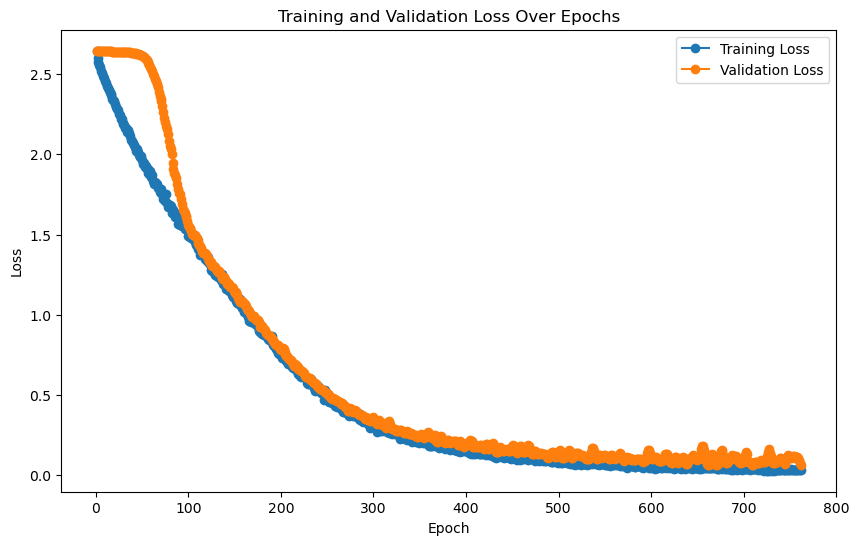

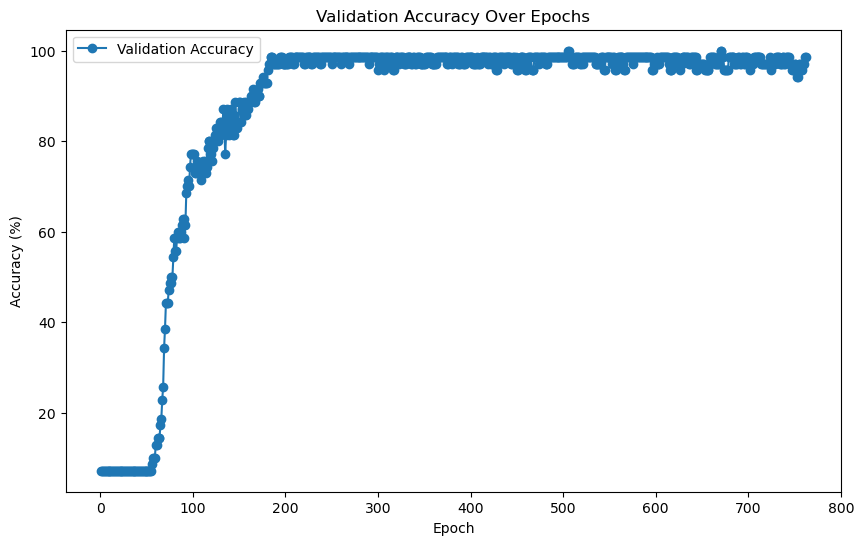


Evaluating on the test set...
    Test Batch [1/12], Loss: 0.0209

Final Test Loss: 0.1051, Test Accuracy: 97.03%
Saved E2E CNN predictions and true labels to model_predictions


In [21]:
#hyperparameters
num_epochs = 1000
learning_rate = 0.0001

#init the model, CrossEntropy loss function, and optimizer
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

#getting unique labels from entire dataset (train, validation, test)
all_labels = []
for loader in [train_loader, val_loader, test_loader]:
    for _, labels in loader:
        all_labels.extend(labels.tolist())
all_labels = np.unique(all_labels)

# init model with correct number of classes
num_classes = len(all_labels)
model = hyperspectralCNN(input_channels=window_num_channels, num_classes=num_classes).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
#lists to store losses and accuracies
classification_epoch_losses = []
validation_epoch_losses = []
val_accuracies = []

#early stopping parameters
patience = 100
best_val_loss = float('inf')
epochs_without_improvement = 0
best_model_weights = None

#training loop + validation with early stopping
for epoch in range(num_epochs):
    # TRAINING
    model.train()
    running_loss = 0.0
    print(f"\nLOG: Epoch [{epoch + 1}/{num_epochs}] - Training")

    for batch_idx, (data, target) in enumerate(train_loader):
        data = data.to(device).permute(0, 3, 1, 2) 
        target = target.to(device)

        # forward pass
        outputs = model(data)
        loss = criterion(outputs, target)

        # backward pass + optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # accum loss
        running_loss += loss.item()

        if (batch_idx + 1) % 10 == 0:
            print(f"    Training Batch [{batch_idx + 1}/{len(train_loader)}], Loss: {loss.item():.4f}")

    # calc + store average training loss per epoch
    avg_train_loss = running_loss / len(train_loader)
    classification_epoch_losses.append(avg_train_loss)
    print(f"Epoch [{epoch + 1}/{num_epochs}] completed, Average Training Loss: {avg_train_loss:.4f}")

    # VALIDATION
    model.eval()
    val_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for batch_idx, (data, target) in enumerate(val_loader):
            data = data.to(device).permute(0, 3, 1, 2)
            target = target.to(device)
            outputs = model(data)
            loss = criterion(outputs, target)
            val_loss += loss.item()

            # accu calculation
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == target).sum().item()
            total += target.size(0)

            if batch_idx == 0 or (batch_idx + 1) % 10 == 0:
                print(f"    Validation Batch [{batch_idx + 1}/{len(val_loader)}], Loss: {loss.item():.4f}")

    # calc + store validation metrics
    avg_val_loss = val_loss / len(val_loader)
    validation_epoch_losses.append(avg_val_loss)
    val_accuracy = 100 * correct / total
    val_accuracies.append(val_accuracy)
    print(f"Validation Loss: {avg_val_loss:.4f}, Validation Accuracy: {val_accuracy:.2f}%")

    # early stopping logic
    if avg_val_loss <= best_val_loss:
        print(f"Validation loss improved from {best_val_loss:.4f} to {avg_val_loss:.4f}. Saving model...")
        best_val_loss = avg_val_loss
        epochs_without_improvement = 0
        best_model_weights = model.state_dict()
    else:
        epochs_without_improvement += 1
        print(f"Validation loss did not improve. Patience: {epochs_without_improvement}/{patience}")

    if epochs_without_improvement >= patience:
        print(f"Early stopping triggered at epoch {epoch + 1}. No improvement for {patience} epochs.")
        break

# loading the best model weights
if best_model_weights is not None:
    print("Loading the best model weights...")
    model.load_state_dict(best_model_weights)

completed_epochs = len(classification_epoch_losses)

# plot for loss and accuracy trends over epochs
plt.figure(figsize=(10,6))
plt.plot(range(1, completed_epochs + 1), classification_epoch_losses, label="Training Loss", marker='o')
plt.plot(range(1, completed_epochs + 1), validation_epoch_losses, label="Validation Loss", marker='o')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Over Epochs')
plt.legend()
plt.show()

plt.figure(figsize=(10,6))
plt.plot(range(1, completed_epochs + 1), val_accuracies, label="Validation Accuracy", marker='o')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Validation Accuracy Over Epochs')
plt.legend()
plt.show()

#test Set Evaluation
print("\nEvaluating on the test set...")
model.eval()
test_loss = 0.0
correct = 0
total = 0
e2ecnn_test_predictions = []
e2ecnn_test_true_labels = []

with torch.no_grad():
    for batch_idx, (data, target) in enumerate(test_loader):
        data = data.to(device).permute(0, 3, 1, 2)
        target = target.to(device)
        outputs = model(data)
        loss = criterion(outputs, target)
        test_loss += loss.item()

        #accuracy calc
        _, predicted = torch.max(outputs, 1)
        correct += (predicted == target).sum().item()
        total += target.size(0)

        e2ecnn_test_predictions.extend(predicted.cpu().numpy())
        e2ecnn_test_true_labels.extend(target.cpu().numpy())

        if batch_idx == 0 or (batch_idx + 1) % 1000 == 0:
            print(f"    Test Batch [{batch_idx + 1}/{len(test_loader)}], Loss: {loss.item():.4f}")

#calc + print test metrics
avg_test_loss = test_loss / len(test_loader)
test_accuracy = 100 * correct / total
print(f"\nFinal Test Loss: {avg_test_loss:.4f}, Test Accuracy: {test_accuracy:.2f}%")

# Convert to numpy arrays and save
e2e_test_predictions = np.array(e2ecnn_test_predictions)
e2e_test_true_labels = np.array(e2ecnn_test_true_labels)

np.save(os.path.join(predictions_dir, 'e2e_cnn_predictions.npy'), e2e_test_predictions)
np.save(os.path.join(predictions_dir, 'e2e_cnn_true_labels.npy'), e2e_test_true_labels)
print(f"Saved E2E CNN predictions and true labels to {predictions_dir}")

In [22]:
# dir to save the cnn representations
e2ecnn_rep_dir = "e2ecnn_representations"
os.makedirs(e2ecnn_rep_dir, exist_ok=True)

e2ecnn_loaders = {
    'train': train_loader,
    'val': val_loader,
    'test': test_loader
}


model.eval()

with torch.no_grad():
    for e2ecnn_split_name, e2ecnn_loader in e2ecnn_loaders.items():
        print(f"\nExtracting SCL representations for the {e2ecnn_split_name} dataset...")
        # creating subfolder for the split
        e2ecnn_split_dir = os.path.join(e2ecnn_rep_dir, e2ecnn_split_name)
        os.makedirs(e2ecnn_split_dir, exist_ok=True)

        # processing the data batch-wise
        for e2ecnn_batch_idx, (e2ecnn_vectors, e2ecnn_labels) in enumerate(e2ecnn_loader):
            e2ecnn_vectors = e2ecnn_vectors.permute(0, 3, 1, 2) 
            e2ecnn_vectors = e2ecnn_vectors.to(device).float()
            # computing projections using the trained SCL model
            e2ecnn_projections = model(e2ecnn_vectors)

            # converting projections and labels to np arrays
            e2ecnn_projections_np = e2ecnn_projections.cpu().numpy()
            e2ecnn_labels_np = e2ecnn_labels.cpu().numpy()

            # saving the batch projections and labels
            np.save(os.path.join(e2ecnn_split_dir, f"cnn_encoded_batch_{e2ecnn_batch_idx}.npy"), e2ecnn_projections_np)
            np.save(os.path.join(e2ecnn_split_dir, f"cnn_labels_batch_{e2ecnn_batch_idx}.npy"), e2ecnn_labels_np)

            if (e2ecnn_batch_idx + 1) % 10 == 0:
                print(f"  Processed batch {e2ecnn_batch_idx + 1}/{len(e2ecnn_loader)} for {e2ecnn_split_name} dataset.")

        print(f"Completed extraction for the {e2ecnn_split_name} dataset. Representations saved in '{e2ecnn_split_dir}'.")

print("E2E CNN representations extraction complete.")


Extracting SCL representations for the train dataset...
Completed extraction for the train dataset. Representations saved in 'e2ecnn_representations\train'.

Extracting SCL representations for the val dataset...
Completed extraction for the val dataset. Representations saved in 'e2ecnn_representations\val'.

Extracting SCL representations for the test dataset...
  Processed batch 10/12 for test dataset.
Completed extraction for the test dataset. Representations saved in 'e2ecnn_representations\test'.
E2E CNN representations extraction complete.


In [23]:
def load_cnn_reps_and_labels(split_dir):
    #gather all the cnn_encoded_batch npy files in sorted order
    cnn_rep_files = sorted(glob.glob(os.path.join(split_dir, "cnn_encoded_batch_*.npy")))

    cnn_all_reps = []
    cnn_all_labels = []

    for cnn_rep_file in cnn_rep_files:
        #deriving label filenames
        cnn_label_file = cnn_rep_file.replace("cnn_encoded_batch_", "cnn_labels_batch_")

        cnn_reps = np.load(cnn_rep_file)
        cnn_labels = np.load(cnn_label_file)

        cnn_all_reps.append(cnn_reps)
        cnn_all_labels.append(cnn_labels)

    #concat along first dim
    cnn_all_reps = np.concatenate(cnn_all_reps, axis = 0)
    cnn_all_labels = np.concatenate(cnn_all_labels, axis = 0)

    return cnn_all_reps, cnn_all_labels

In [24]:
cnn_train_dir = os.path.join("e2ecnn_representations", "train")
cnn_val_dir   = os.path.join("e2ecnn_representations", "val")
cnn_test_dir  = os.path.join("e2ecnn_representations", "test")

cnn_train_reps, cnn_train_labels = load_cnn_reps_and_labels(cnn_train_dir)
cnn_val_reps, cnn_val_labels = load_cnn_reps_and_labels(cnn_val_dir)
cnn_test_reps, cnn_test_labels = load_cnn_reps_and_labels(cnn_test_dir)

## Logistic Regression Model

In [25]:
def load_encoded_data(encoded_dir):
    print(f"LOG: Loading encoded data (representations) from {encoded_dir}...")
    features_list = []
    labels_list = []

    #iter through batches
    for filename in sorted(os.listdir(encoded_dir)):
        if filename.startswith('encoded_batch_') and filename.endswith('.npy'):

            #load the features
            features = np.load(os.path.join(encoded_dir, filename))
            features_flat = features.reshape(features.shape[0], -1) #flatten features for LRM
            features_list.append(features_flat)
        
        elif filename.startswith('labels_batch_') and filename.endswith('.npy'):

            #load labels
            labels = np.load(os.path.join(encoded_dir, filename))
            labels_list.append(labels)

    #concat all batches into a single array
    encoded_features = np.vstack(features_list)
    encoded_labels = np.hstack(labels_list)

    print(f"LOG: Loaded {encoded_features.shape[0]} samples with {encoded_features.shape[1]} features each")
    print(f"LOG: Labels shape: {encoded_labels.shape}")

    return encoded_features, encoded_labels

In [26]:
lrm_encoded_train_dir = os.path.join(encoded_dir, 'train')
lrm_encoded_val_dir = os.path.join(encoded_dir, 'val')
lrm_encoded_test_dir = os.path.join(encoded_dir, 'test')

print("\nLoading training data for LRM...")
lrm_train_features, lrm_train_labels = load_encoded_data(lrm_encoded_train_dir)

print("\nLoading validation data for LRM...")
lrm_val_features, lrm_val_labels = load_encoded_data(lrm_encoded_val_dir)

print("\nLoading test data for LRM...")
lrm_test_features, lrm_test_labels = load_encoded_data(lrm_encoded_test_dir)

#verify shapes
print(f"\nLOG: Training features shape: {lrm_train_features.shape}, Training labels shape: {lrm_train_labels.shape}")
print(f"LOG: Validation features shape: {lrm_val_features.shape}, Validation labels shape: {lrm_val_labels.shape}")
print(f"LOG: Test features shape: {lrm_test_features.shape}, Test labels shape: {lrm_test_labels.shape}")

print("\nLOG: Training Logistic Regression model...")
logistic_clf = LogisticRegression(max_iter=5000, random_state=42, class_weight = 'balanced')
logistic_clf.fit(lrm_train_features, lrm_train_labels)
print("LOG: Logistic Regression training complete.")

#eval on Validation Set
print("\nLOG: Evaluating on the validation set...")
lrm_val_predictions = logistic_clf.predict(lrm_val_features)
lrm_val_accuracy = accuracy_score(lrm_val_labels, lrm_val_predictions)
print(f"Validation Accuracy: {lrm_val_accuracy * 100:.2f}%")
print("\nValidation Classification Report:\n", classification_report(lrm_val_labels, lrm_val_predictions))

#eval on Test Set
print("\nLOG: Evaluating on the test set...")
lrm_test_predictions = logistic_clf.predict(lrm_test_features)
lrm_test_accuracy = accuracy_score(lrm_test_labels, lrm_test_predictions)
print(f"Test Accuracy: {lrm_test_accuracy * 100:.2f}%")
print("\nTest Classification Report:\n", classification_report(lrm_test_labels, lrm_test_predictions))

np.save(os.path.join(predictions_dir, 'cae_lrm_predictions.npy'), lrm_test_predictions)
np.save(os.path.join(predictions_dir, 'cae_lrm_true_labels.npy'), lrm_test_labels)
print(f"Saved CAE+LRM predictions and true labels to {predictions_dir}")



Loading training data for LRM...
LOG: Loading encoded data (representations) from encoded_representations\train...
LOG: Loaded 280 samples with 64 features each
LOG: Labels shape: (280,)

Loading validation data for LRM...
LOG: Loading encoded data (representations) from encoded_representations\val...
LOG: Loaded 70 samples with 64 features each
LOG: Labels shape: (70,)

Loading test data for LRM...
LOG: Loading encoded data (representations) from encoded_representations\test...
LOG: Loaded 2898 samples with 64 features each
LOG: Labels shape: (2898,)

LOG: Training features shape: (280, 64), Training labels shape: (280,)
LOG: Validation features shape: (70, 64), Validation labels shape: (70,)
LOG: Test features shape: (2898, 64), Test labels shape: (2898,)

LOG: Training Logistic Regression model...
LOG: Logistic Regression training complete.

LOG: Evaluating on the validation set...
Validation Accuracy: 80.00%

Validation Classification Report:
               precision    recall  f1

### Classifying CAE Embeddings with MLP

In [27]:
class MLPClassifier(nn.Module):
    def __init__(self, input_dim, num_classes):
        super(MLPClassifier, self).__init__()
        self.fc1 = nn.Linear(input_dim, 64)
        self.fc2 = nn.Linear(64, 64)
        self.fc3 = nn.Linear(64, 32)
        self.fc4 = nn.Linear(32, num_classes)
        
        self._init_weights()
    
    def _init_weights(self):
        for m in self.modules(): 
            if isinstance(m, nn.Linear):
                nn.init.xavier_uniform_(m.weight)
                nn.init.constant_(m.bias, 0)
    
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        return self.fc4(x)

In [28]:
cae_mlp_train_dir = os.path.join("encoded_representations", "train")
cae_mlp_val_dir   = os.path.join("encoded_representations", "val")
cae_mlp_test_dir  = os.path.join("encoded_representations", "test")

cae_mlp_train_reps, cae_mlp_train_labels = load_encoded_data(cae_mlp_train_dir)
cae_mlp_val_reps, cae_mlp_val_labels = load_encoded_data(cae_mlp_val_dir)
cae_mlp_test_reps, cae_mlp_test_labels = load_encoded_data(cae_mlp_test_dir)

print("Train reps shape:",cae_mlp_train_reps.shape)
print("Train labels shape:", cae_mlp_train_labels.shape)

print("Val reps shape:", cae_mlp_val_reps.shape)
print("Val labels shape:", cae_mlp_val_labels.shape)

print("Test reps shape:", cae_mlp_test_reps.shape)
print("Test labels shape:", cae_mlp_test_labels.shape)

LOG: Loading encoded data (representations) from encoded_representations\train...
LOG: Loaded 280 samples with 64 features each
LOG: Labels shape: (280,)
LOG: Loading encoded data (representations) from encoded_representations\val...
LOG: Loaded 70 samples with 64 features each
LOG: Labels shape: (70,)
LOG: Loading encoded data (representations) from encoded_representations\test...
LOG: Loaded 2898 samples with 64 features each
LOG: Labels shape: (2898,)
Train reps shape: (280, 64)
Train labels shape: (280,)
Val reps shape: (70, 64)
Val labels shape: (70,)
Test reps shape: (2898, 64)
Test labels shape: (2898,)


In [29]:
#converting arrays to torch tensors
cae_mlp_train_embeddings_torch = torch.tensor(cae_mlp_train_reps, dtype=torch.float32)
cae_mlp_train_labels_torch = torch.tensor(cae_mlp_train_labels, dtype=torch.long)

cae_mlp_val_embeddings_torch = torch.tensor(cae_mlp_val_reps, dtype=torch.float32)
cae_mlp_val_labels_torch = torch.tensor(cae_mlp_val_labels, dtype=torch.long)

cae_mlp_test_embeddings_torch = torch.tensor(cae_mlp_test_reps, dtype=torch.float32)
cae_mlp_test_labels_torch = torch.tensor(cae_mlp_test_labels, dtype=torch.long)

#building datasets for mlp
cae_mlp_train_dataset = TensorDataset(cae_mlp_train_embeddings_torch, cae_mlp_train_labels_torch)
cae_mlp_val_dataset = TensorDataset(cae_mlp_val_embeddings_torch, cae_mlp_val_labels_torch)
cae_mlp_test_dataset = TensorDataset(cae_mlp_test_embeddings_torch, cae_mlp_test_labels_torch)

cae_mlp_batch_size = 64
cae_mlp_train_loader = DataLoader(cae_mlp_train_dataset, batch_size=cae_mlp_batch_size, shuffle=True)
cae_mlp_val_loader = DataLoader(cae_mlp_val_dataset, batch_size=cae_mlp_batch_size, shuffle=False)
cae_mlp_test_loader = DataLoader(cae_mlp_test_dataset, batch_size=cae_mlp_batch_size, shuffle=False)


[Epoch 1/1000] Train Loss: 2.7112  |  Val Loss: 2.6455
Validation loss improved from inf to 2.6455.
[Epoch 2/1000] Train Loss: 2.6415  |  Val Loss: 2.6244
Validation loss improved from 2.6455 to 2.6244.
[Epoch 3/1000] Train Loss: 2.6220  |  Val Loss: 2.6109
Validation loss improved from 2.6244 to 2.6109.
[Epoch 4/1000] Train Loss: 2.6101  |  Val Loss: 2.6004
Validation loss improved from 2.6109 to 2.6004.
[Epoch 5/1000] Train Loss: 2.5981  |  Val Loss: 2.5918
Validation loss improved from 2.6004 to 2.5918.
[Epoch 6/1000] Train Loss: 2.5906  |  Val Loss: 2.5827
Validation loss improved from 2.5918 to 2.5827.
[Epoch 7/1000] Train Loss: 2.5830  |  Val Loss: 2.5729
Validation loss improved from 2.5827 to 2.5729.
[Epoch 8/1000] Train Loss: 2.5689  |  Val Loss: 2.5641
Validation loss improved from 2.5729 to 2.5641.
[Epoch 9/1000] Train Loss: 2.5602  |  Val Loss: 2.5506
Validation loss improved from 2.5641 to 2.5506.
[Epoch 10/1000] Train Loss: 2.5475  |  Val Loss: 2.5359
Validation loss impr

[Epoch 14/1000] Train Loss: 2.4841  |  Val Loss: 2.4683
Validation loss improved from 2.4907 to 2.4683.
[Epoch 15/1000] Train Loss: 2.4606  |  Val Loss: 2.4457
Validation loss improved from 2.4683 to 2.4457.
[Epoch 16/1000] Train Loss: 2.4348  |  Val Loss: 2.4235
Validation loss improved from 2.4457 to 2.4235.
[Epoch 17/1000] Train Loss: 2.4178  |  Val Loss: 2.4010
Validation loss improved from 2.4235 to 2.4010.


[Epoch 18/1000] Train Loss: 2.3878  |  Val Loss: 2.3745
Validation loss improved from 2.4010 to 2.3745.
[Epoch 19/1000] Train Loss: 2.3637  |  Val Loss: 2.3665
Validation loss improved from 2.3745 to 2.3665.
[Epoch 20/1000] Train Loss: 2.3522  |  Val Loss: 2.3414
Validation loss improved from 2.3665 to 2.3414.
[Epoch 21/1000] Train Loss: 2.3237  |  Val Loss: 2.2962
Validation loss improved from 2.3414 to 2.2962.
[Epoch 22/1000] Train Loss: 2.2923  |  Val Loss: 2.2752
Validation loss improved from 2.2962 to 2.2752.
[Epoch 23/1000] Train Loss: 2.2713  |  Val Loss: 2.2626
Validation loss improved from 2.2752 to 2.2626.
[Epoch 24/1000] Train Loss: 2.2493  |  Val Loss: 2.2518
Validation loss improved from 2.2626 to 2.2518.
[Epoch 25/1000] Train Loss: 2.2349  |  Val Loss: 2.2007
Validation loss improved from 2.2518 to 2.2007.
[Epoch 26/1000] Train Loss: 2.1785  |  Val Loss: 2.1656
Validation loss improved from 2.2007 to 2.1656.
[Epoch 27/1000] Train Loss: 2.1520  |  Val Loss: 2.1317
Validati

[Epoch 32/1000] Train Loss: 1.9919  |  Val Loss: 1.9597
Validation loss improved from 2.0143 to 1.9597.
[Epoch 33/1000] Train Loss: 1.9533  |  Val Loss: 1.9426
Validation loss improved from 1.9597 to 1.9426.
[Epoch 34/1000] Train Loss: 1.9194  |  Val Loss: 1.9448
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 35/1000] Train Loss: 1.9010  |  Val Loss: 1.8699
Validation loss improved from 1.9426 to 1.8699.


[Epoch 36/1000] Train Loss: 1.8636  |  Val Loss: 1.8276
Validation loss improved from 1.8699 to 1.8276.
[Epoch 37/1000] Train Loss: 1.8191  |  Val Loss: 1.8018
Validation loss improved from 1.8276 to 1.8018.
[Epoch 38/1000] Train Loss: 1.7944  |  Val Loss: 1.7819
Validation loss improved from 1.8018 to 1.7819.
[Epoch 39/1000] Train Loss: 1.7665  |  Val Loss: 1.7479
Validation loss improved from 1.7819 to 1.7479.
[Epoch 40/1000] Train Loss: 1.7374  |  Val Loss: 1.7306
Validation loss improved from 1.7479 to 1.7306.
[Epoch 41/1000] Train Loss: 1.7097  |  Val Loss: 1.7010
Validation loss improved from 1.7306 to 1.7010.
[Epoch 42/1000] Train Loss: 1.6869  |  Val Loss: 1.6776
Validation loss improved from 1.7010 to 1.6776.
[Epoch 43/1000] Train Loss: 1.6614  |  Val Loss: 1.6557
Validation loss improved from 1.6776 to 1.6557.
[Epoch 44/1000] Train Loss: 1.6403  |  Val Loss: 1.6316
Validation loss improved from 1.6557 to 1.6316.
[Epoch 45/1000] Train Loss: 1.6156  |  Val Loss: 1.6130
Validati

[Epoch 51/1000] Train Loss: 1.5177  |  Val Loss: 1.5272
Validation loss improved from 1.5314 to 1.5272.
[Epoch 52/1000] Train Loss: 1.5089  |  Val Loss: 1.5291
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 53/1000] Train Loss: 1.5022  |  Val Loss: 1.4930
Validation loss improved from 1.5272 to 1.4930.
[Epoch 54/1000] Train Loss: 1.5015  |  Val Loss: 1.5468
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 55/1000] Train Loss: 1.5142  |  Val Loss: 1.4839
Validation loss improved from 1.4930 to 1.4839.


[Epoch 56/1000] Train Loss: 1.4675  |  Val Loss: 1.5128
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 57/1000] Train Loss: 1.4800  |  Val Loss: 1.5337
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 58/1000] Train Loss: 1.5025  |  Val Loss: 1.4452
Validation loss improved from 1.4839 to 1.4452.
[Epoch 59/1000] Train Loss: 1.4573  |  Val Loss: 1.4913
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 60/1000] Train Loss: 1.4593  |  Val Loss: 1.4441
Validation loss improved from 1.4452 to 1.4441.
[Epoch 61/1000] Train Loss: 1.4289  |  Val Loss: 1.4290
Validation loss improved from 1.4441 to 1.4290.
[Epoch 62/1000] Train Loss: 1.3986  |  Val Loss: 1.4097
Validation loss improved from 1.4290 to 1.4097.
[Epoch 63/1000] Train Loss: 1.3891  |  Val Loss: 1.4146
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 64/1000] Train Loss: 1.3985  |  Val Loss: 1.4080
Validation loss improved from 1.4097 to 1.4080.
[Epoch 65/1000] Train Loss: 1.3769  |  V

[Epoch 70/1000] Train Loss: 1.3423  |  Val Loss: 1.3669
Validation loss improved from 1.3757 to 1.3669.
[Epoch 71/1000] Train Loss: 1.3432  |  Val Loss: 1.3658
Validation loss improved from 1.3669 to 1.3658.
[Epoch 72/1000] Train Loss: 1.3368  |  Val Loss: 1.3564
Validation loss improved from 1.3658 to 1.3564.
[Epoch 73/1000] Train Loss: 1.3244  |  Val Loss: 1.3500
Validation loss improved from 1.3564 to 1.3500.
[Epoch 74/1000] Train Loss: 1.3150  |  Val Loss: 1.3478
Validation loss improved from 1.3500 to 1.3478.


[Epoch 75/1000] Train Loss: 1.3078  |  Val Loss: 1.3663
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 76/1000] Train Loss: 1.3219  |  Val Loss: 1.3452
Validation loss improved from 1.3478 to 1.3452.
[Epoch 77/1000] Train Loss: 1.3246  |  Val Loss: 1.4060
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 78/1000] Train Loss: 1.3518  |  Val Loss: 1.3472
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 79/1000] Train Loss: 1.2966  |  Val Loss: 1.3243
Validation loss improved from 1.3452 to 1.3243.
[Epoch 80/1000] Train Loss: 1.3036  |  Val Loss: 1.3177
Validation loss improved from 1.3243 to 1.3177.
[Epoch 81/1000] Train Loss: 1.3035  |  Val Loss: 1.3442
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 82/1000] Train Loss: 1.2937  |  Val Loss: 1.3187
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 83/1000] Train Loss: 1.2983  |  Val Loss: 1.3097
Validation loss improved from 1.3177 to 1.3097.
[Epoch 84/1000] Train Loss: 1.2688

[Epoch 89/1000] Train Loss: 1.2749  |  Val Loss: 1.2873
Validation loss improved from 1.2950 to 1.2873.
[Epoch 90/1000] Train Loss: 1.2477  |  Val Loss: 1.3172
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 91/1000] Train Loss: 1.2529  |  Val Loss: 1.2865
Validation loss improved from 1.2873 to 1.2865.
[Epoch 92/1000] Train Loss: 1.2530  |  Val Loss: 1.2788
Validation loss improved from 1.2865 to 1.2788.


[Epoch 93/1000] Train Loss: 1.2581  |  Val Loss: 1.2833
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 94/1000] Train Loss: 1.2452  |  Val Loss: 1.2788
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 95/1000] Train Loss: 1.2411  |  Val Loss: 1.2771
Validation loss improved from 1.2788 to 1.2771.
[Epoch 96/1000] Train Loss: 1.2320  |  Val Loss: 1.2702
Validation loss improved from 1.2771 to 1.2702.
[Epoch 97/1000] Train Loss: 1.2418  |  Val Loss: 1.2753
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 98/1000] Train Loss: 1.2282  |  Val Loss: 1.2983
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 99/1000] Train Loss: 1.2507  |  Val Loss: 1.2703
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 100/1000] Train Loss: 1.2286  |  Val Loss: 1.3808
!! Validation loss did NOT improve !! Patience: 4/100
[Epoch 101/1000] Train Loss: 1.2905  |  Val Loss: 1.2567
Validation loss improved from 1.2702 to 1.2567.
[Epoch 102/1000] Train Los

[Epoch 108/1000] Train Loss: 1.1958  |  Val Loss: 1.2737
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 109/1000] Train Loss: 1.2149  |  Val Loss: 1.2566
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 110/1000] Train Loss: 1.2061  |  Val Loss: 1.2394
Validation loss improved from 1.2437 to 1.2394.
[Epoch 111/1000] Train Loss: 1.2005  |  Val Loss: 1.2481
!! Validation loss did NOT improve !! Patience: 1/100


[Epoch 112/1000] Train Loss: 1.1992  |  Val Loss: 1.2419
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 113/1000] Train Loss: 1.1964  |  Val Loss: 1.2711
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 114/1000] Train Loss: 1.2009  |  Val Loss: 1.2328
Validation loss improved from 1.2394 to 1.2328.
[Epoch 115/1000] Train Loss: 1.2099  |  Val Loss: 1.2909
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 116/1000] Train Loss: 1.2230  |  Val Loss: 1.2310
Validation loss improved from 1.2328 to 1.2310.
[Epoch 117/1000] Train Loss: 1.2110  |  Val Loss: 1.2536
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 118/1000] Train Loss: 1.1995  |  Val Loss: 1.2644
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 119/1000] Train Loss: 1.2027  |  Val Loss: 1.3004
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 120/1000] Train Loss: 1.2399  |  Val Loss: 1.2606
!! Validation loss did NOT improve !! Patience: 4/100
[Epoch 121/10

[Epoch 127/1000] Train Loss: 1.1859  |  Val Loss: 1.2101
Validation loss improved from 1.2171 to 1.2101.
[Epoch 128/1000] Train Loss: 1.1666  |  Val Loss: 1.2199
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 129/1000] Train Loss: 1.1727  |  Val Loss: 1.2718
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 130/1000] Train Loss: 1.1966  |  Val Loss: 1.2147
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 131/1000] Train Loss: 1.1929  |  Val Loss: 1.2697
!! Validation loss did NOT improve !! Patience: 4/100


[Epoch 132/1000] Train Loss: 1.2066  |  Val Loss: 1.2046
Validation loss improved from 1.2101 to 1.2046.
[Epoch 133/1000] Train Loss: 1.1553  |  Val Loss: 1.2134
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 134/1000] Train Loss: 1.1573  |  Val Loss: 1.2101
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 135/1000] Train Loss: 1.1583  |  Val Loss: 1.2353
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 136/1000] Train Loss: 1.1733  |  Val Loss: 1.2151
!! Validation loss did NOT improve !! Patience: 4/100
[Epoch 137/1000] Train Loss: 1.1673  |  Val Loss: 1.2026
Validation loss improved from 1.2046 to 1.2026.
[Epoch 138/1000] Train Loss: 1.1567  |  Val Loss: 1.2030
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 139/1000] Train Loss: 1.1573  |  Val Loss: 1.2365
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 140/1000] Train Loss: 1.1678  |  Val Loss: 1.2050
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 141/10

[Epoch 146/1000] Train Loss: 1.1579  |  Val Loss: 1.2116
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 147/1000] Train Loss: 1.1626  |  Val Loss: 1.2183
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 148/1000] Train Loss: 1.1546  |  Val Loss: 1.2150
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 149/1000] Train Loss: 1.1652  |  Val Loss: 1.2524
!! Validation loss did NOT improve !! Patience: 4/100


[Epoch 150/1000] Train Loss: 1.1969  |  Val Loss: 1.1927
Validation loss improved from 1.1956 to 1.1927.
[Epoch 151/1000] Train Loss: 1.1929  |  Val Loss: 1.2931
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 152/1000] Train Loss: 1.2099  |  Val Loss: 1.1998
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 153/1000] Train Loss: 1.1624  |  Val Loss: 1.2385
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 154/1000] Train Loss: 1.1783  |  Val Loss: 1.2090
!! Validation loss did NOT improve !! Patience: 4/100
[Epoch 155/1000] Train Loss: 1.1874  |  Val Loss: 1.2647
!! Validation loss did NOT improve !! Patience: 5/100
[Epoch 156/1000] Train Loss: 1.1865  |  Val Loss: 1.1827
Validation loss improved from 1.1927 to 1.1827.
[Epoch 157/1000] Train Loss: 1.1356  |  Val Loss: 1.1942
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 158/1000] Train Loss: 1.1882  |  Val Loss: 1.2075
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 159/10

[Epoch 166/1000] Train Loss: 1.1959  |  Val Loss: 1.2898
!! Validation loss did NOT improve !! Patience: 5/100
[Epoch 167/1000] Train Loss: 1.1952  |  Val Loss: 1.2115
!! Validation loss did NOT improve !! Patience: 6/100
[Epoch 168/1000] Train Loss: 1.1564  |  Val Loss: 1.1982
!! Validation loss did NOT improve !! Patience: 7/100
[Epoch 169/1000] Train Loss: 1.1351  |  Val Loss: 1.2289
!! Validation loss did NOT improve !! Patience: 8/100
[Epoch 170/1000] Train Loss: 1.1624  |  Val Loss: 1.1970
!! Validation loss did NOT improve !! Patience: 9/100
[Epoch 171/1000] Train Loss: 1.1425  |  Val Loss: 1.1803
!! Validation loss did NOT improve !! Patience: 10/100
[Epoch 172/1000] Train Loss: 1.1285  |  Val Loss: 1.1772
Validation loss improved from 1.1791 to 1.1772.
[Epoch 173/1000] Train Loss: 1.1276  |  Val Loss: 1.1824
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 174/1000] Train Loss: 1.1237  |  Val Loss: 1.1836
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch

[Epoch 184/1000] Train Loss: 1.2137  |  Val Loss: 1.1676
Validation loss improved from 1.1723 to 1.1676.
[Epoch 185/1000] Train Loss: 1.1246  |  Val Loss: 1.1743
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 186/1000] Train Loss: 1.1389  |  Val Loss: 1.1668
Validation loss improved from 1.1676 to 1.1668.
[Epoch 187/1000] Train Loss: 1.1445  |  Val Loss: 1.2415
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 188/1000] Train Loss: 1.1445  |  Val Loss: 1.1719
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 189/1000] Train Loss: 1.1418  |  Val Loss: 1.2118
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 190/1000] Train Loss: 1.1505  |  Val Loss: 1.2341
!! Validation loss did NOT improve !! Patience: 4/100
[Epoch 191/1000] Train Loss: 1.1461  |  Val Loss: 1.1748
!! Validation loss did NOT improve !! Patience: 5/100
[Epoch 192/1000] Train Loss: 1.1114  |  Val Loss: 1.1894
!! Validation loss did NOT improve !! Patience: 6/100
[Epoch 193/10

[Epoch 202/1000] Train Loss: 1.1093  |  Val Loss: 1.2206
!! Validation loss did NOT improve !! Patience: 6/100
[Epoch 203/1000] Train Loss: 1.1396  |  Val Loss: 1.1734
!! Validation loss did NOT improve !! Patience: 7/100
[Epoch 204/1000] Train Loss: 1.1074  |  Val Loss: 1.1545
Validation loss improved from 1.1621 to 1.1545.
[Epoch 205/1000] Train Loss: 1.1092  |  Val Loss: 1.1566
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 206/1000] Train Loss: 1.1211  |  Val Loss: 1.1753
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 207/1000] Train Loss: 1.1171  |  Val Loss: 1.1616
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 208/1000] Train Loss: 1.1210  |  Val Loss: 1.1999
!! Validation loss did NOT improve !! Patience: 4/100
[Epoch 209/1000] Train Loss: 1.1319  |  Val Loss: 1.1752
!! Validation loss did NOT improve !! Patience: 5/100
[Epoch 210/1000] Train Loss: 1.1148  |  Val Loss: 1.1556
!! Validation loss did NOT improve !! Patience: 6/100
[Epoch 

[Epoch 220/1000] Train Loss: 1.1132  |  Val Loss: 1.2060
!! Validation loss did NOT improve !! Patience: 9/100
[Epoch 221/1000] Train Loss: 1.1215  |  Val Loss: 1.2464
!! Validation loss did NOT improve !! Patience: 10/100
[Epoch 222/1000] Train Loss: 1.1701  |  Val Loss: 1.1539
!! Validation loss did NOT improve !! Patience: 11/100
[Epoch 223/1000] Train Loss: 1.1219  |  Val Loss: 1.1748
!! Validation loss did NOT improve !! Patience: 12/100
[Epoch 224/1000] Train Loss: 1.1445  |  Val Loss: 1.1604
!! Validation loss did NOT improve !! Patience: 13/100
[Epoch 225/1000] Train Loss: 1.1180  |  Val Loss: 1.1755
!! Validation loss did NOT improve !! Patience: 14/100
[Epoch 226/1000] Train Loss: 1.1188  |  Val Loss: 1.1680
!! Validation loss did NOT improve !! Patience: 15/100
[Epoch 227/1000] Train Loss: 1.1230  |  Val Loss: 1.2023
!! Validation loss did NOT improve !! Patience: 16/100
[Epoch 228/1000] Train Loss: 1.1117  |  Val Loss: 1.1578
!! Validation loss did NOT improve !! Patience: 

[Epoch 240/1000] Train Loss: 1.1059  |  Val Loss: 1.1843
!! Validation loss did NOT improve !! Patience: 29/100
[Epoch 241/1000] Train Loss: 1.1238  |  Val Loss: 1.1802
!! Validation loss did NOT improve !! Patience: 30/100
[Epoch 242/1000] Train Loss: 1.1240  |  Val Loss: 1.1527
!! Validation loss did NOT improve !! Patience: 31/100
[Epoch 243/1000] Train Loss: 1.1123  |  Val Loss: 1.1649
!! Validation loss did NOT improve !! Patience: 32/100
[Epoch 244/1000] Train Loss: 1.1050  |  Val Loss: 1.1679
!! Validation loss did NOT improve !! Patience: 33/100
[Epoch 245/1000] Train Loss: 1.1201  |  Val Loss: 1.2216
!! Validation loss did NOT improve !! Patience: 34/100
[Epoch 246/1000] Train Loss: 1.1243  |  Val Loss: 1.1520
!! Validation loss did NOT improve !! Patience: 35/100
[Epoch 247/1000] Train Loss: 1.0924  |  Val Loss: 1.1458
Validation loss improved from 1.1499 to 1.1458.
[Epoch 248/1000] Train Loss: 1.0993  |  Val Loss: 1.1444
Validation loss improved from 1.1458 to 1.1444.
[Epoch

[Epoch 259/1000] Train Loss: 1.0908  |  Val Loss: 1.1384
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 260/1000] Train Loss: 1.0843  |  Val Loss: 1.1415
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 261/1000] Train Loss: 1.0834  |  Val Loss: 1.1665
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 262/1000] Train Loss: 1.1093  |  Val Loss: 1.1454
!! Validation loss did NOT improve !! Patience: 4/100
[Epoch 263/1000] Train Loss: 1.0858  |  Val Loss: 1.1489
!! Validation loss did NOT improve !! Patience: 5/100
[Epoch 264/1000] Train Loss: 1.0972  |  Val Loss: 1.1529
!! Validation loss did NOT improve !! Patience: 6/100
[Epoch 265/1000] Train Loss: 1.0983  |  Val Loss: 1.1416
!! Validation loss did NOT improve !! Patience: 7/100
[Epoch 266/1000] Train Loss: 1.0948  |  Val Loss: 1.1792
!! Validation loss did NOT improve !! Patience: 8/100
[Epoch 267/1000] Train Loss: 1.0925  |  Val Loss: 1.1525
!! Validation loss did NOT improve !! Patience: 9/100
[

[Epoch 278/1000] Train Loss: 1.1003  |  Val Loss: 1.1469
!! Validation loss did NOT improve !! Patience: 20/100
[Epoch 279/1000] Train Loss: 1.0861  |  Val Loss: 1.1944
!! Validation loss did NOT improve !! Patience: 21/100
[Epoch 280/1000] Train Loss: 1.0940  |  Val Loss: 1.1507
!! Validation loss did NOT improve !! Patience: 22/100
[Epoch 281/1000] Train Loss: 1.1075  |  Val Loss: 1.1516
!! Validation loss did NOT improve !! Patience: 23/100
[Epoch 282/1000] Train Loss: 1.0999  |  Val Loss: 1.1511
!! Validation loss did NOT improve !! Patience: 24/100
[Epoch 283/1000] Train Loss: 1.0936  |  Val Loss: 1.1353
Validation loss improved from 1.1379 to 1.1353.
[Epoch 284/1000] Train Loss: 1.0664  |  Val Loss: 1.1391
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 285/1000] Train Loss: 1.0812  |  Val Loss: 1.1430
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 286/1000] Train Loss: 1.0834  |  Val Loss: 1.1721
!! Validation loss did NOT improve !! Patience: 3/100
[E

[Epoch 296/1000] Train Loss: 1.0747  |  Val Loss: 1.1492
!! Validation loss did NOT improve !! Patience: 13/100
[Epoch 297/1000] Train Loss: 1.0781  |  Val Loss: 1.1324
Validation loss improved from 1.1353 to 1.1324.
[Epoch 298/1000] Train Loss: 1.1125  |  Val Loss: 1.3075
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 299/1000] Train Loss: 1.1654  |  Val Loss: 1.2709
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 300/1000] Train Loss: 1.1492  |  Val Loss: 1.1596
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 301/1000] Train Loss: 1.1141  |  Val Loss: 1.1530
!! Validation loss did NOT improve !! Patience: 4/100
[Epoch 302/1000] Train Loss: 1.1115  |  Val Loss: 1.1925
!! Validation loss did NOT improve !! Patience: 5/100
[Epoch 303/1000] Train Loss: 1.1103  |  Val Loss: 1.1373
!! Validation loss did NOT improve !! Patience: 6/100
[Epoch 304/1000] Train Loss: 1.1060  |  Val Loss: 1.1670
!! Validation loss did NOT improve !! Patience: 7/100
[Epoch

[Epoch 313/1000] Train Loss: 1.1035  |  Val Loss: 1.1343
!! Validation loss did NOT improve !! Patience: 16/100
[Epoch 314/1000] Train Loss: 1.0745  |  Val Loss: 1.1417
!! Validation loss did NOT improve !! Patience: 17/100
[Epoch 315/1000] Train Loss: 1.0687  |  Val Loss: 1.1354
!! Validation loss did NOT improve !! Patience: 18/100
[Epoch 316/1000] Train Loss: 1.0685  |  Val Loss: 1.1267
Validation loss improved from 1.1324 to 1.1267.
[Epoch 317/1000] Train Loss: 1.0665  |  Val Loss: 1.1400
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 318/1000] Train Loss: 1.0902  |  Val Loss: 1.1307
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 319/1000] Train Loss: 1.0749  |  Val Loss: 1.1477
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 320/1000] Train Loss: 1.0782  |  Val Loss: 1.1553
!! Validation loss did NOT improve !! Patience: 4/100
[Epoch 321/1000] Train Loss: 1.0786  |  Val Loss: 1.1424
!! Validation loss did NOT improve !! Patience: 5/100
[Epo

[Epoch 333/1000] Train Loss: 1.1729  |  Val Loss: 1.1854
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 334/1000] Train Loss: 1.1231  |  Val Loss: 1.1325
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 335/1000] Train Loss: 1.0896  |  Val Loss: 1.1727
!! Validation loss did NOT improve !! Patience: 4/100
[Epoch 336/1000] Train Loss: 1.0950  |  Val Loss: 1.1249
!! Validation loss did NOT improve !! Patience: 5/100
[Epoch 337/1000] Train Loss: 1.0889  |  Val Loss: 1.1299
!! Validation loss did NOT improve !! Patience: 6/100
[Epoch 338/1000] Train Loss: 1.1006  |  Val Loss: 1.1470
!! Validation loss did NOT improve !! Patience: 7/100
[Epoch 339/1000] Train Loss: 1.0841  |  Val Loss: 1.1391
!! Validation loss did NOT improve !! Patience: 8/100
[Epoch 340/1000] Train Loss: 1.0671  |  Val Loss: 1.1421
!! Validation loss did NOT improve !! Patience: 9/100
[Epoch 341/1000] Train Loss: 1.0788  |  Val Loss: 1.1624
!! Validation loss did NOT improve !! Patience: 10/100


[Epoch 350/1000] Train Loss: 1.0620  |  Val Loss: 1.1264
!! Validation loss did NOT improve !! Patience: 19/100
[Epoch 351/1000] Train Loss: 1.0554  |  Val Loss: 1.1272
!! Validation loss did NOT improve !! Patience: 20/100
[Epoch 352/1000] Train Loss: 1.0524  |  Val Loss: 1.1259
!! Validation loss did NOT improve !! Patience: 21/100
[Epoch 353/1000] Train Loss: 1.0635  |  Val Loss: 1.1416
!! Validation loss did NOT improve !! Patience: 22/100
[Epoch 354/1000] Train Loss: 1.0672  |  Val Loss: 1.1215
Validation loss improved from 1.1248 to 1.1215.
[Epoch 355/1000] Train Loss: 1.0608  |  Val Loss: 1.1401
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 356/1000] Train Loss: 1.0580  |  Val Loss: 1.1412
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 357/1000] Train Loss: 1.0590  |  Val Loss: 1.1397
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 358/1000] Train Loss: 1.0593  |  Val Loss: 1.1286
!! Validation loss did NOT improve !! Patience: 4/100
[Ep

[Epoch 369/1000] Train Loss: 1.0844  |  Val Loss: 1.1314
!! Validation loss did NOT improve !! Patience: 15/100
[Epoch 370/1000] Train Loss: 1.0653  |  Val Loss: 1.1182
Validation loss improved from 1.1215 to 1.1182.
[Epoch 371/1000] Train Loss: 1.0694  |  Val Loss: 1.1234
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 372/1000] Train Loss: 1.0521  |  Val Loss: 1.1243
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 373/1000] Train Loss: 1.0563  |  Val Loss: 1.1264
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 374/1000] Train Loss: 1.0629  |  Val Loss: 1.1223
!! Validation loss did NOT improve !! Patience: 4/100
[Epoch 375/1000] Train Loss: 1.0638  |  Val Loss: 1.1319
!! Validation loss did NOT improve !! Patience: 5/100
[Epoch 376/1000] Train Loss: 1.0573  |  Val Loss: 1.1406
!! Validation loss did NOT improve !! Patience: 6/100
[Epoch 377/1000] Train Loss: 1.0661  |  Val Loss: 1.1424
!! Validation loss did NOT improve !! Patience: 7/100
[Epoch

[Epoch 386/1000] Train Loss: 1.0435  |  Val Loss: 1.1269
!! Validation loss did NOT improve !! Patience: 16/100
[Epoch 387/1000] Train Loss: 1.0620  |  Val Loss: 1.1338
!! Validation loss did NOT improve !! Patience: 17/100
[Epoch 388/1000] Train Loss: 1.0853  |  Val Loss: 1.1584
!! Validation loss did NOT improve !! Patience: 18/100
[Epoch 389/1000] Train Loss: 1.0722  |  Val Loss: 1.1239
!! Validation loss did NOT improve !! Patience: 19/100
[Epoch 390/1000] Train Loss: 1.0502  |  Val Loss: 1.1277
!! Validation loss did NOT improve !! Patience: 20/100
[Epoch 391/1000] Train Loss: 1.0470  |  Val Loss: 1.1347
!! Validation loss did NOT improve !! Patience: 21/100
[Epoch 392/1000] Train Loss: 1.0616  |  Val Loss: 1.2204
!! Validation loss did NOT improve !! Patience: 22/100
[Epoch 393/1000] Train Loss: 1.0701  |  Val Loss: 1.1562
!! Validation loss did NOT improve !! Patience: 23/100
[Epoch 394/1000] Train Loss: 1.0875  |  Val Loss: 1.1178
Validation loss improved from 1.1182 to 1.1178.

[Epoch 405/1000] Train Loss: 1.0405  |  Val Loss: 1.1061
Validation loss improved from 1.1063 to 1.1061.
[Epoch 406/1000] Train Loss: 1.0479  |  Val Loss: 1.1649
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 407/1000] Train Loss: 1.0946  |  Val Loss: 1.1421
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 408/1000] Train Loss: 1.0472  |  Val Loss: 1.1471
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 409/1000] Train Loss: 1.0725  |  Val Loss: 1.2819
!! Validation loss did NOT improve !! Patience: 4/100
[Epoch 410/1000] Train Loss: 1.1359  |  Val Loss: 1.1333
!! Validation loss did NOT improve !! Patience: 5/100
[Epoch 411/1000] Train Loss: 1.1002  |  Val Loss: 1.1724
!! Validation loss did NOT improve !! Patience: 6/100
[Epoch 412/1000] Train Loss: 1.0990  |  Val Loss: 1.1860
!! Validation loss did NOT improve !! Patience: 7/100
[Epoch 413/1000] Train Loss: 1.0858  |  Val Loss: 1.1344
!! Validation loss did NOT improve !! Patience: 8/100
[Epoch 

[Epoch 423/1000] Train Loss: 1.0652  |  Val Loss: 1.1354
!! Validation loss did NOT improve !! Patience: 18/100
[Epoch 424/1000] Train Loss: 1.0516  |  Val Loss: 1.1656
!! Validation loss did NOT improve !! Patience: 19/100
[Epoch 425/1000] Train Loss: 1.0490  |  Val Loss: 1.2162
!! Validation loss did NOT improve !! Patience: 20/100
[Epoch 426/1000] Train Loss: 1.0962  |  Val Loss: 1.2433
!! Validation loss did NOT improve !! Patience: 21/100
[Epoch 427/1000] Train Loss: 1.1277  |  Val Loss: 1.1102
!! Validation loss did NOT improve !! Patience: 22/100
[Epoch 428/1000] Train Loss: 1.0783  |  Val Loss: 1.1444
!! Validation loss did NOT improve !! Patience: 23/100
[Epoch 429/1000] Train Loss: 1.0647  |  Val Loss: 1.1506
!! Validation loss did NOT improve !! Patience: 24/100
[Epoch 430/1000] Train Loss: 1.0462  |  Val Loss: 1.1297
!! Validation loss did NOT improve !! Patience: 25/100
[Epoch 431/1000] Train Loss: 1.0402  |  Val Loss: 1.1351
!! Validation loss did NOT improve !! Patience:

[Epoch 443/1000] Train Loss: 1.0382  |  Val Loss: 1.1150
!! Validation loss did NOT improve !! Patience: 38/100
[Epoch 444/1000] Train Loss: 1.0560  |  Val Loss: 1.1154
!! Validation loss did NOT improve !! Patience: 39/100
[Epoch 445/1000] Train Loss: 1.0362  |  Val Loss: 1.1182
!! Validation loss did NOT improve !! Patience: 40/100
[Epoch 446/1000] Train Loss: 1.0470  |  Val Loss: 1.1383
!! Validation loss did NOT improve !! Patience: 41/100
[Epoch 447/1000] Train Loss: 1.0576  |  Val Loss: 1.1283
!! Validation loss did NOT improve !! Patience: 42/100
[Epoch 448/1000] Train Loss: 1.0362  |  Val Loss: 1.1232
!! Validation loss did NOT improve !! Patience: 43/100
[Epoch 449/1000] Train Loss: 1.0413  |  Val Loss: 1.1297
!! Validation loss did NOT improve !! Patience: 44/100
[Epoch 450/1000] Train Loss: 1.0503  |  Val Loss: 1.1872
!! Validation loss did NOT improve !! Patience: 45/100
[Epoch 451/1000] Train Loss: 1.1069  |  Val Loss: 1.1129
!! Validation loss did NOT improve !! Patience:

[Epoch 461/1000] Train Loss: 1.0450  |  Val Loss: 1.1206
!! Validation loss did NOT improve !! Patience: 56/100
[Epoch 462/1000] Train Loss: 1.0322  |  Val Loss: 1.1093
!! Validation loss did NOT improve !! Patience: 57/100
[Epoch 463/1000] Train Loss: 1.0463  |  Val Loss: 1.1063
!! Validation loss did NOT improve !! Patience: 58/100
[Epoch 464/1000] Train Loss: 1.0336  |  Val Loss: 1.1118
!! Validation loss did NOT improve !! Patience: 59/100
[Epoch 465/1000] Train Loss: 1.0534  |  Val Loss: 1.1836
!! Validation loss did NOT improve !! Patience: 60/100
[Epoch 466/1000] Train Loss: 1.0901  |  Val Loss: 1.1342
!! Validation loss did NOT improve !! Patience: 61/100
[Epoch 467/1000] Train Loss: 1.0473  |  Val Loss: 1.1150
!! Validation loss did NOT improve !! Patience: 62/100
[Epoch 468/1000] Train Loss: 1.0370  |  Val Loss: 1.1284
!! Validation loss did NOT improve !! Patience: 63/100
[Epoch 469/1000] Train Loss: 1.0595  |  Val Loss: 1.1179
!! Validation loss did NOT improve !! Patience:

[Epoch 481/1000] Train Loss: 1.0679  |  Val Loss: 1.1113
!! Validation loss did NOT improve !! Patience: 11/100
[Epoch 482/1000] Train Loss: 1.0346  |  Val Loss: 1.1006
!! Validation loss did NOT improve !! Patience: 12/100
[Epoch 483/1000] Train Loss: 1.0255  |  Val Loss: 1.1157
!! Validation loss did NOT improve !! Patience: 13/100
[Epoch 484/1000] Train Loss: 1.0289  |  Val Loss: 1.1133
!! Validation loss did NOT improve !! Patience: 14/100
[Epoch 485/1000] Train Loss: 1.0487  |  Val Loss: 1.1648
!! Validation loss did NOT improve !! Patience: 15/100
[Epoch 486/1000] Train Loss: 1.0697  |  Val Loss: 1.1382
!! Validation loss did NOT improve !! Patience: 16/100
[Epoch 487/1000] Train Loss: 1.0502  |  Val Loss: 1.1084
!! Validation loss did NOT improve !! Patience: 17/100
[Epoch 488/1000] Train Loss: 1.0450  |  Val Loss: 1.1749
!! Validation loss did NOT improve !! Patience: 18/100
[Epoch 489/1000] Train Loss: 1.0642  |  Val Loss: 1.1694
!! Validation loss did NOT improve !! Patience:

[Epoch 501/1000] Train Loss: 1.0318  |  Val Loss: 1.1066
!! Validation loss did NOT improve !! Patience: 31/100
[Epoch 502/1000] Train Loss: 1.0217  |  Val Loss: 1.1110
!! Validation loss did NOT improve !! Patience: 32/100
[Epoch 503/1000] Train Loss: 1.0227  |  Val Loss: 1.1349
!! Validation loss did NOT improve !! Patience: 33/100
[Epoch 504/1000] Train Loss: 1.0483  |  Val Loss: 1.1699
!! Validation loss did NOT improve !! Patience: 34/100
[Epoch 505/1000] Train Loss: 1.0429  |  Val Loss: 1.1688
!! Validation loss did NOT improve !! Patience: 35/100
[Epoch 506/1000] Train Loss: 1.0503  |  Val Loss: 1.1292
!! Validation loss did NOT improve !! Patience: 36/100
[Epoch 507/1000] Train Loss: 1.0246  |  Val Loss: 1.0979
!! Validation loss did NOT improve !! Patience: 37/100
[Epoch 508/1000] Train Loss: 1.0393  |  Val Loss: 1.1230
!! Validation loss did NOT improve !! Patience: 38/100
[Epoch 509/1000] Train Loss: 1.0407  |  Val Loss: 1.1266
!! Validation loss did NOT improve !! Patience:

[Epoch 520/1000] Train Loss: 1.0609  |  Val Loss: 1.1058
!! Validation loss did NOT improve !! Patience: 10/100
[Epoch 521/1000] Train Loss: 1.0482  |  Val Loss: 1.1993
!! Validation loss did NOT improve !! Patience: 11/100
[Epoch 522/1000] Train Loss: 1.0633  |  Val Loss: 1.1124
!! Validation loss did NOT improve !! Patience: 12/100
[Epoch 523/1000] Train Loss: 1.0552  |  Val Loss: 1.1034
!! Validation loss did NOT improve !! Patience: 13/100
[Epoch 524/1000] Train Loss: 1.0540  |  Val Loss: 1.1069
!! Validation loss did NOT improve !! Patience: 14/100
[Epoch 525/1000] Train Loss: 1.0216  |  Val Loss: 1.0790
Validation loss improved from 1.0954 to 1.0790.
[Epoch 526/1000] Train Loss: 1.0215  |  Val Loss: 1.0931
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 527/1000] Train Loss: 1.0146  |  Val Loss: 1.1255
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 528/1000] Train Loss: 1.0431  |  Val Loss: 1.1828
!! Validation loss did NOT improve !! Patience: 3/100
[E

[Epoch 540/1000] Train Loss: 1.0298  |  Val Loss: 1.1072
!! Validation loss did NOT improve !! Patience: 15/100
[Epoch 541/1000] Train Loss: 1.0240  |  Val Loss: 1.0935
!! Validation loss did NOT improve !! Patience: 16/100
[Epoch 542/1000] Train Loss: 1.0177  |  Val Loss: 1.1362
!! Validation loss did NOT improve !! Patience: 17/100
[Epoch 543/1000] Train Loss: 1.0177  |  Val Loss: 1.2218
!! Validation loss did NOT improve !! Patience: 18/100
[Epoch 544/1000] Train Loss: 1.0703  |  Val Loss: 1.1023
!! Validation loss did NOT improve !! Patience: 19/100
[Epoch 545/1000] Train Loss: 1.0281  |  Val Loss: 1.1046
!! Validation loss did NOT improve !! Patience: 20/100
[Epoch 546/1000] Train Loss: 1.0477  |  Val Loss: 1.1291
!! Validation loss did NOT improve !! Patience: 21/100
[Epoch 547/1000] Train Loss: 1.0422  |  Val Loss: 1.0910
!! Validation loss did NOT improve !! Patience: 22/100
[Epoch 548/1000] Train Loss: 1.0198  |  Val Loss: 1.1546
!! Validation loss did NOT improve !! Patience:

[Epoch 558/1000] Train Loss: 1.0134  |  Val Loss: 1.0788
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 559/1000] Train Loss: 1.0142  |  Val Loss: 1.1142
!! Validation loss did NOT improve !! Patience: 4/100
[Epoch 560/1000] Train Loss: 1.0174  |  Val Loss: 1.1231
!! Validation loss did NOT improve !! Patience: 5/100
[Epoch 561/1000] Train Loss: 1.0179  |  Val Loss: 1.1189
!! Validation loss did NOT improve !! Patience: 6/100
[Epoch 562/1000] Train Loss: 1.0566  |  Val Loss: 1.0906
!! Validation loss did NOT improve !! Patience: 7/100
[Epoch 563/1000] Train Loss: 1.0241  |  Val Loss: 1.1415
!! Validation loss did NOT improve !! Patience: 8/100
[Epoch 564/1000] Train Loss: 1.0164  |  Val Loss: 1.1320
!! Validation loss did NOT improve !! Patience: 9/100
[Epoch 565/1000] Train Loss: 1.0245  |  Val Loss: 1.0867
!! Validation loss did NOT improve !! Patience: 10/100
[Epoch 566/1000] Train Loss: 1.0488  |  Val Loss: 1.1058
!! Validation loss did NOT improve !! Patience: 11/100

[Epoch 577/1000] Train Loss: 1.0475  |  Val Loss: 1.1338
!! Validation loss did NOT improve !! Patience: 22/100
[Epoch 578/1000] Train Loss: 1.0342  |  Val Loss: 1.0776
!! Validation loss did NOT improve !! Patience: 23/100
[Epoch 579/1000] Train Loss: 1.0320  |  Val Loss: 1.1375
!! Validation loss did NOT improve !! Patience: 24/100
[Epoch 580/1000] Train Loss: 1.0595  |  Val Loss: 1.0947
!! Validation loss did NOT improve !! Patience: 25/100
[Epoch 581/1000] Train Loss: 1.1007  |  Val Loss: 1.1375
!! Validation loss did NOT improve !! Patience: 26/100
[Epoch 582/1000] Train Loss: 1.0756  |  Val Loss: 1.0909
!! Validation loss did NOT improve !! Patience: 27/100
[Epoch 583/1000] Train Loss: 1.0242  |  Val Loss: 1.0903
!! Validation loss did NOT improve !! Patience: 28/100
[Epoch 584/1000] Train Loss: 1.0115  |  Val Loss: 1.1107
!! Validation loss did NOT improve !! Patience: 29/100
[Epoch 585/1000] Train Loss: 1.0253  |  Val Loss: 1.0962
!! Validation loss did NOT improve !! Patience:

[Epoch 595/1000] Train Loss: 1.0756  |  Val Loss: 1.1506
!! Validation loss did NOT improve !! Patience: 40/100
[Epoch 596/1000] Train Loss: 1.0184  |  Val Loss: 1.1911
!! Validation loss did NOT improve !! Patience: 41/100
[Epoch 597/1000] Train Loss: 1.0331  |  Val Loss: 1.1085
!! Validation loss did NOT improve !! Patience: 42/100
[Epoch 598/1000] Train Loss: 1.0520  |  Val Loss: 1.0846
!! Validation loss did NOT improve !! Patience: 43/100
[Epoch 599/1000] Train Loss: 1.0202  |  Val Loss: 1.1082
!! Validation loss did NOT improve !! Patience: 44/100
[Epoch 600/1000] Train Loss: 1.0101  |  Val Loss: 1.0709
Validation loss improved from 1.0765 to 1.0709.
[Epoch 601/1000] Train Loss: 1.0026  |  Val Loss: 1.0850
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 602/1000] Train Loss: 1.0021  |  Val Loss: 1.0859
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 603/1000] Train Loss: 0.9996  |  Val Loss: 1.1335
!! Validation loss did NOT improve !! Patience: 3/100
[E

[Epoch 613/1000] Train Loss: 1.0051  |  Val Loss: 1.1319
!! Validation loss did NOT improve !! Patience: 5/100
[Epoch 614/1000] Train Loss: 0.9944  |  Val Loss: 1.1304
!! Validation loss did NOT improve !! Patience: 6/100
[Epoch 615/1000] Train Loss: 1.0217  |  Val Loss: 1.0602
Validation loss improved from 1.0679 to 1.0602.
[Epoch 616/1000] Train Loss: 1.0127  |  Val Loss: 1.1231
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 617/1000] Train Loss: 1.0261  |  Val Loss: 1.0738
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 618/1000] Train Loss: 1.0113  |  Val Loss: 1.0939
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 619/1000] Train Loss: 1.0246  |  Val Loss: 1.1248
!! Validation loss did NOT improve !! Patience: 4/100
[Epoch 620/1000] Train Loss: 1.0131  |  Val Loss: 1.0710
!! Validation loss did NOT improve !! Patience: 5/100
[Epoch 621/1000] Train Loss: 1.0154  |  Val Loss: 1.1358
!! Validation loss did NOT improve !! Patience: 6/100
[Epoch 

[Epoch 632/1000] Train Loss: 1.0485  |  Val Loss: 1.3584
!! Validation loss did NOT improve !! Patience: 7/100
[Epoch 633/1000] Train Loss: 1.1243  |  Val Loss: 1.1423
!! Validation loss did NOT improve !! Patience: 8/100
[Epoch 634/1000] Train Loss: 1.0704  |  Val Loss: 1.0891
!! Validation loss did NOT improve !! Patience: 9/100
[Epoch 635/1000] Train Loss: 1.0067  |  Val Loss: 1.0907
!! Validation loss did NOT improve !! Patience: 10/100
[Epoch 636/1000] Train Loss: 1.0077  |  Val Loss: 1.0918
!! Validation loss did NOT improve !! Patience: 11/100
[Epoch 637/1000] Train Loss: 0.9973  |  Val Loss: 1.0785
!! Validation loss did NOT improve !! Patience: 12/100
[Epoch 638/1000] Train Loss: 0.9954  |  Val Loss: 1.0749
!! Validation loss did NOT improve !! Patience: 13/100
[Epoch 639/1000] Train Loss: 1.0023  |  Val Loss: 1.0670
!! Validation loss did NOT improve !! Patience: 14/100
[Epoch 640/1000] Train Loss: 0.9846  |  Val Loss: 1.0629
!! Validation loss did NOT improve !! Patience: 15

[Epoch 650/1000] Train Loss: 0.9771  |  Val Loss: 1.1327
!! Validation loss did NOT improve !! Patience: 25/100
[Epoch 651/1000] Train Loss: 1.0167  |  Val Loss: 1.0711
!! Validation loss did NOT improve !! Patience: 26/100
[Epoch 652/1000] Train Loss: 0.9841  |  Val Loss: 1.0600
!! Validation loss did NOT improve !! Patience: 27/100
[Epoch 653/1000] Train Loss: 0.9741  |  Val Loss: 1.0801
!! Validation loss did NOT improve !! Patience: 28/100
[Epoch 654/1000] Train Loss: 0.9857  |  Val Loss: 1.0536
Validation loss improved from 1.0554 to 1.0536.
[Epoch 655/1000] Train Loss: 0.9769  |  Val Loss: 1.0694
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 656/1000] Train Loss: 0.9783  |  Val Loss: 1.0738
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 657/1000] Train Loss: 0.9717  |  Val Loss: 1.0654
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 658/1000] Train Loss: 0.9753  |  Val Loss: 1.1225
!! Validation loss did NOT improve !! Patience: 4/100
[Ep

[Epoch 669/1000] Train Loss: 1.0690  |  Val Loss: 1.2269
!! Validation loss did NOT improve !! Patience: 15/100
[Epoch 670/1000] Train Loss: 1.0648  |  Val Loss: 1.0631
!! Validation loss did NOT improve !! Patience: 16/100
[Epoch 671/1000] Train Loss: 1.0667  |  Val Loss: 1.0959
!! Validation loss did NOT improve !! Patience: 17/100
[Epoch 672/1000] Train Loss: 1.0055  |  Val Loss: 1.0906
!! Validation loss did NOT improve !! Patience: 18/100
[Epoch 673/1000] Train Loss: 0.9900  |  Val Loss: 1.0794
!! Validation loss did NOT improve !! Patience: 19/100
[Epoch 674/1000] Train Loss: 1.0117  |  Val Loss: 1.0732
!! Validation loss did NOT improve !! Patience: 20/100
[Epoch 675/1000] Train Loss: 0.9774  |  Val Loss: 1.0523
Validation loss improved from 1.0536 to 1.0523.
[Epoch 676/1000] Train Loss: 0.9893  |  Val Loss: 1.0429
Validation loss improved from 1.0523 to 1.0429.
[Epoch 677/1000] Train Loss: 0.9671  |  Val Loss: 1.0677
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 

[Epoch 688/1000] Train Loss: 0.9801  |  Val Loss: 1.0506
!! Validation loss did NOT improve !! Patience: 12/100
[Epoch 689/1000] Train Loss: 0.9567  |  Val Loss: 1.0737
!! Validation loss did NOT improve !! Patience: 13/100
[Epoch 690/1000] Train Loss: 0.9903  |  Val Loss: 1.0290
Validation loss improved from 1.0429 to 1.0290.
[Epoch 691/1000] Train Loss: 0.9859  |  Val Loss: 1.0705
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 692/1000] Train Loss: 0.9606  |  Val Loss: 1.0509
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 693/1000] Train Loss: 0.9698  |  Val Loss: 1.0577
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 694/1000] Train Loss: 0.9749  |  Val Loss: 1.0756
!! Validation loss did NOT improve !! Patience: 4/100
[Epoch 695/1000] Train Loss: 0.9795  |  Val Loss: 1.0645
!! Validation loss did NOT improve !! Patience: 5/100
[Epoch 696/1000] Train Loss: 0.9903  |  Val Loss: 1.0523
!! Validation loss did NOT improve !! Patience: 6/100
[Epoc

[Epoch 706/1000] Train Loss: 0.9929  |  Val Loss: 1.0403
!! Validation loss did NOT improve !! Patience: 16/100
[Epoch 707/1000] Train Loss: 0.9574  |  Val Loss: 1.0324
!! Validation loss did NOT improve !! Patience: 17/100
[Epoch 708/1000] Train Loss: 0.9573  |  Val Loss: 1.0808
!! Validation loss did NOT improve !! Patience: 18/100
[Epoch 709/1000] Train Loss: 0.9672  |  Val Loss: 1.0360
!! Validation loss did NOT improve !! Patience: 19/100
[Epoch 710/1000] Train Loss: 0.9783  |  Val Loss: 1.0779
!! Validation loss did NOT improve !! Patience: 20/100
[Epoch 711/1000] Train Loss: 0.9836  |  Val Loss: 1.0525
!! Validation loss did NOT improve !! Patience: 21/100
[Epoch 712/1000] Train Loss: 0.9669  |  Val Loss: 1.0308
!! Validation loss did NOT improve !! Patience: 22/100
[Epoch 713/1000] Train Loss: 0.9591  |  Val Loss: 1.0882
!! Validation loss did NOT improve !! Patience: 23/100
[Epoch 714/1000] Train Loss: 0.9692  |  Val Loss: 1.0267
Validation loss improved from 1.0290 to 1.0267.

[Epoch 725/1000] Train Loss: 0.9610  |  Val Loss: 1.0360
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 726/1000] Train Loss: 0.9808  |  Val Loss: 1.0853
!! Validation loss did NOT improve !! Patience: 4/100
[Epoch 727/1000] Train Loss: 0.9734  |  Val Loss: 1.0760
!! Validation loss did NOT improve !! Patience: 5/100
[Epoch 728/1000] Train Loss: 0.9886  |  Val Loss: 1.0689
!! Validation loss did NOT improve !! Patience: 6/100
[Epoch 729/1000] Train Loss: 1.0285  |  Val Loss: 1.0689
!! Validation loss did NOT improve !! Patience: 7/100
[Epoch 730/1000] Train Loss: 0.9778  |  Val Loss: 1.0558
!! Validation loss did NOT improve !! Patience: 8/100
[Epoch 731/1000] Train Loss: 0.9882  |  Val Loss: 1.2483
!! Validation loss did NOT improve !! Patience: 9/100
[Epoch 732/1000] Train Loss: 1.0476  |  Val Loss: 1.1897
!! Validation loss did NOT improve !! Patience: 10/100
[Epoch 733/1000] Train Loss: 1.0129  |  Val Loss: 1.1608
!! Validation loss did NOT improve !! Patience: 11/100

[Epoch 743/1000] Train Loss: 0.9435  |  Val Loss: 1.0367
!! Validation loss did NOT improve !! Patience: 21/100
[Epoch 744/1000] Train Loss: 0.9519  |  Val Loss: 1.0168
!! Validation loss did NOT improve !! Patience: 22/100
[Epoch 745/1000] Train Loss: 0.9446  |  Val Loss: 1.0534
!! Validation loss did NOT improve !! Patience: 23/100
[Epoch 746/1000] Train Loss: 0.9775  |  Val Loss: 1.0253
!! Validation loss did NOT improve !! Patience: 24/100
[Epoch 747/1000] Train Loss: 0.9451  |  Val Loss: 1.0178
!! Validation loss did NOT improve !! Patience: 25/100
[Epoch 748/1000] Train Loss: 0.9369  |  Val Loss: 1.0414
!! Validation loss did NOT improve !! Patience: 26/100
[Epoch 749/1000] Train Loss: 0.9566  |  Val Loss: 1.0343
!! Validation loss did NOT improve !! Patience: 27/100
[Epoch 750/1000] Train Loss: 0.9520  |  Val Loss: 1.0090
Validation loss improved from 1.0130 to 1.0090.
[Epoch 751/1000] Train Loss: 0.9422  |  Val Loss: 1.0176
!! Validation loss did NOT improve !! Patience: 1/100


[Epoch 762/1000] Train Loss: 0.9403  |  Val Loss: 1.0971
!! Validation loss did NOT improve !! Patience: 4/100
[Epoch 763/1000] Train Loss: 0.9800  |  Val Loss: 1.0166
!! Validation loss did NOT improve !! Patience: 5/100
[Epoch 764/1000] Train Loss: 0.9463  |  Val Loss: 1.0307
!! Validation loss did NOT improve !! Patience: 6/100
[Epoch 765/1000] Train Loss: 0.9289  |  Val Loss: 1.0229
!! Validation loss did NOT improve !! Patience: 7/100
[Epoch 766/1000] Train Loss: 0.9339  |  Val Loss: 1.0913
!! Validation loss did NOT improve !! Patience: 8/100
[Epoch 767/1000] Train Loss: 0.9693  |  Val Loss: 1.2106
!! Validation loss did NOT improve !! Patience: 9/100
[Epoch 768/1000] Train Loss: 1.0257  |  Val Loss: 1.0326
!! Validation loss did NOT improve !! Patience: 10/100
[Epoch 769/1000] Train Loss: 0.9401  |  Val Loss: 1.0089
!! Validation loss did NOT improve !! Patience: 11/100
[Epoch 770/1000] Train Loss: 0.9231  |  Val Loss: 0.9927
Validation loss improved from 1.0080 to 0.9927.
[Epoc

[Epoch 781/1000] Train Loss: 0.9172  |  Val Loss: 0.9979
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 782/1000] Train Loss: 0.9195  |  Val Loss: 1.0520
!! Validation loss did NOT improve !! Patience: 4/100
[Epoch 783/1000] Train Loss: 0.9397  |  Val Loss: 0.9903
!! Validation loss did NOT improve !! Patience: 5/100
[Epoch 784/1000] Train Loss: 0.9387  |  Val Loss: 1.0089
!! Validation loss did NOT improve !! Patience: 6/100
[Epoch 785/1000] Train Loss: 0.9255  |  Val Loss: 0.9977
!! Validation loss did NOT improve !! Patience: 7/100
[Epoch 786/1000] Train Loss: 0.9219  |  Val Loss: 1.0246
!! Validation loss did NOT improve !! Patience: 8/100
[Epoch 787/1000] Train Loss: 0.9224  |  Val Loss: 1.0367
!! Validation loss did NOT improve !! Patience: 9/100
[Epoch 788/1000] Train Loss: 0.9334  |  Val Loss: 1.0000
!! Validation loss did NOT improve !! Patience: 10/100
[Epoch 789/1000] Train Loss: 0.9137  |  Val Loss: 0.9902
!! Validation loss did NOT improve !! Patience: 11/100

[Epoch 800/1000] Train Loss: 0.9205  |  Val Loss: 0.9984
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 801/1000] Train Loss: 0.9133  |  Val Loss: 0.9981
!! Validation loss did NOT improve !! Patience: 4/100
[Epoch 802/1000] Train Loss: 0.9132  |  Val Loss: 0.9794
!! Validation loss did NOT improve !! Patience: 5/100
[Epoch 803/1000] Train Loss: 0.9166  |  Val Loss: 1.0424
!! Validation loss did NOT improve !! Patience: 6/100
[Epoch 804/1000] Train Loss: 0.9399  |  Val Loss: 1.0728
!! Validation loss did NOT improve !! Patience: 7/100
[Epoch 805/1000] Train Loss: 0.9568  |  Val Loss: 1.0227
!! Validation loss did NOT improve !! Patience: 8/100
[Epoch 806/1000] Train Loss: 0.9713  |  Val Loss: 1.0344
!! Validation loss did NOT improve !! Patience: 9/100
[Epoch 807/1000] Train Loss: 0.9495  |  Val Loss: 1.0491
!! Validation loss did NOT improve !! Patience: 10/100
[Epoch 808/1000] Train Loss: 0.9446  |  Val Loss: 0.9982
!! Validation loss did NOT improve !! Patience: 11/100

[Epoch 818/1000] Train Loss: 0.9388  |  Val Loss: 1.0231
!! Validation loss did NOT improve !! Patience: 4/100
[Epoch 819/1000] Train Loss: 0.9109  |  Val Loss: 1.0066
!! Validation loss did NOT improve !! Patience: 5/100
[Epoch 820/1000] Train Loss: 0.9491  |  Val Loss: 1.0726
!! Validation loss did NOT improve !! Patience: 6/100
[Epoch 821/1000] Train Loss: 0.9789  |  Val Loss: 1.0244
!! Validation loss did NOT improve !! Patience: 7/100
[Epoch 822/1000] Train Loss: 0.9519  |  Val Loss: 0.9770
!! Validation loss did NOT improve !! Patience: 8/100
[Epoch 823/1000] Train Loss: 0.9241  |  Val Loss: 0.9847
!! Validation loss did NOT improve !! Patience: 9/100
[Epoch 824/1000] Train Loss: 0.9197  |  Val Loss: 1.0110
!! Validation loss did NOT improve !! Patience: 10/100
[Epoch 825/1000] Train Loss: 0.9178  |  Val Loss: 0.9844
!! Validation loss did NOT improve !! Patience: 11/100
[Epoch 826/1000] Train Loss: 0.8988  |  Val Loss: 0.9618
Validation loss improved from 0.9635 to 0.9618.
[Epoc

[Epoch 837/1000] Train Loss: 0.8900  |  Val Loss: 0.9829
!! Validation loss did NOT improve !! Patience: 10/100
[Epoch 838/1000] Train Loss: 0.8906  |  Val Loss: 0.9613
!! Validation loss did NOT improve !! Patience: 11/100
[Epoch 839/1000] Train Loss: 0.9087  |  Val Loss: 1.0125
!! Validation loss did NOT improve !! Patience: 12/100
[Epoch 840/1000] Train Loss: 0.8965  |  Val Loss: 0.9702
!! Validation loss did NOT improve !! Patience: 13/100
[Epoch 841/1000] Train Loss: 0.9053  |  Val Loss: 0.9776
!! Validation loss did NOT improve !! Patience: 14/100
[Epoch 842/1000] Train Loss: 0.9012  |  Val Loss: 1.0062
!! Validation loss did NOT improve !! Patience: 15/100
[Epoch 843/1000] Train Loss: 0.9256  |  Val Loss: 0.9656
!! Validation loss did NOT improve !! Patience: 16/100
[Epoch 844/1000] Train Loss: 0.9125  |  Val Loss: 0.9903
!! Validation loss did NOT improve !! Patience: 17/100
[Epoch 845/1000] Train Loss: 0.9239  |  Val Loss: 0.9604
!! Validation loss did NOT improve !! Patience:

[Epoch 856/1000] Train Loss: 0.8873  |  Val Loss: 1.0245
!! Validation loss did NOT improve !! Patience: 29/100
[Epoch 857/1000] Train Loss: 0.9019  |  Val Loss: 0.9945
!! Validation loss did NOT improve !! Patience: 30/100
[Epoch 858/1000] Train Loss: 0.9143  |  Val Loss: 0.9730
!! Validation loss did NOT improve !! Patience: 31/100
[Epoch 859/1000] Train Loss: 0.9222  |  Val Loss: 1.0920
!! Validation loss did NOT improve !! Patience: 32/100
[Epoch 860/1000] Train Loss: 0.9797  |  Val Loss: 1.2177
!! Validation loss did NOT improve !! Patience: 33/100
[Epoch 861/1000] Train Loss: 0.9711  |  Val Loss: 1.0744
!! Validation loss did NOT improve !! Patience: 34/100
[Epoch 862/1000] Train Loss: 0.9806  |  Val Loss: 0.9486
!! Validation loss did NOT improve !! Patience: 35/100
[Epoch 863/1000] Train Loss: 0.9289  |  Val Loss: 1.0774
!! Validation loss did NOT improve !! Patience: 36/100
[Epoch 864/1000] Train Loss: 0.9616  |  Val Loss: 1.0880
!! Validation loss did NOT improve !! Patience:

[Epoch 874/1000] Train Loss: 0.8934  |  Val Loss: 1.0015
!! Validation loss did NOT improve !! Patience: 5/100
[Epoch 875/1000] Train Loss: 0.8979  |  Val Loss: 0.9341
!! Validation loss did NOT improve !! Patience: 6/100
[Epoch 876/1000] Train Loss: 0.8824  |  Val Loss: 0.9373
!! Validation loss did NOT improve !! Patience: 7/100
[Epoch 877/1000] Train Loss: 0.8769  |  Val Loss: 0.9502
!! Validation loss did NOT improve !! Patience: 8/100
[Epoch 878/1000] Train Loss: 0.8989  |  Val Loss: 1.0019
!! Validation loss did NOT improve !! Patience: 9/100
[Epoch 879/1000] Train Loss: 0.8833  |  Val Loss: 0.9649
!! Validation loss did NOT improve !! Patience: 10/100
[Epoch 880/1000] Train Loss: 0.8735  |  Val Loss: 0.9516
!! Validation loss did NOT improve !! Patience: 11/100
[Epoch 881/1000] Train Loss: 0.8766  |  Val Loss: 0.9814
!! Validation loss did NOT improve !! Patience: 12/100
[Epoch 882/1000] Train Loss: 0.8864  |  Val Loss: 0.9426
!! Validation loss did NOT improve !! Patience: 13/1

[Epoch 894/1000] Train Loss: 0.8859  |  Val Loss: 0.9650
!! Validation loss did NOT improve !! Patience: 25/100
[Epoch 895/1000] Train Loss: 0.8860  |  Val Loss: 0.9389
!! Validation loss did NOT improve !! Patience: 26/100
[Epoch 896/1000] Train Loss: 0.9017  |  Val Loss: 0.9589
!! Validation loss did NOT improve !! Patience: 27/100
[Epoch 897/1000] Train Loss: 0.8743  |  Val Loss: 0.9409
!! Validation loss did NOT improve !! Patience: 28/100
[Epoch 898/1000] Train Loss: 0.8674  |  Val Loss: 0.9610
!! Validation loss did NOT improve !! Patience: 29/100
[Epoch 899/1000] Train Loss: 0.8669  |  Val Loss: 0.9684
!! Validation loss did NOT improve !! Patience: 30/100
[Epoch 900/1000] Train Loss: 0.8864  |  Val Loss: 0.9332
!! Validation loss did NOT improve !! Patience: 31/100
[Epoch 901/1000] Train Loss: 0.8641  |  Val Loss: 0.9527
!! Validation loss did NOT improve !! Patience: 32/100
[Epoch 902/1000] Train Loss: 0.8757  |  Val Loss: 0.9686
!! Validation loss did NOT improve !! Patience:

[Epoch 913/1000] Train Loss: 0.8555  |  Val Loss: 0.9559
!! Validation loss did NOT improve !! Patience: 44/100
[Epoch 914/1000] Train Loss: 0.8781  |  Val Loss: 0.9774
!! Validation loss did NOT improve !! Patience: 45/100
[Epoch 915/1000] Train Loss: 0.9030  |  Val Loss: 0.9810
!! Validation loss did NOT improve !! Patience: 46/100
[Epoch 916/1000] Train Loss: 0.9529  |  Val Loss: 1.0084
!! Validation loss did NOT improve !! Patience: 47/100
[Epoch 917/1000] Train Loss: 0.9355  |  Val Loss: 1.0598
!! Validation loss did NOT improve !! Patience: 48/100
[Epoch 918/1000] Train Loss: 0.9909  |  Val Loss: 1.3403
!! Validation loss did NOT improve !! Patience: 49/100
[Epoch 919/1000] Train Loss: 1.0715  |  Val Loss: 1.1460
!! Validation loss did NOT improve !! Patience: 50/100
[Epoch 920/1000] Train Loss: 0.9837  |  Val Loss: 0.9864
!! Validation loss did NOT improve !! Patience: 51/100
[Epoch 921/1000] Train Loss: 0.9238  |  Val Loss: 0.9563
!! Validation loss did NOT improve !! Patience:

[Epoch 932/1000] Train Loss: 0.8767  |  Val Loss: 1.0492
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 933/1000] Train Loss: 0.8952  |  Val Loss: 0.9388
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 934/1000] Train Loss: 0.8649  |  Val Loss: 0.9522
!! Validation loss did NOT improve !! Patience: 4/100
[Epoch 935/1000] Train Loss: 0.8665  |  Val Loss: 0.9605
!! Validation loss did NOT improve !! Patience: 5/100
[Epoch 936/1000] Train Loss: 0.8636  |  Val Loss: 0.9124
Validation loss improved from 0.9192 to 0.9124.
[Epoch 937/1000] Train Loss: 0.8612  |  Val Loss: 0.9248
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 938/1000] Train Loss: 0.8700  |  Val Loss: 0.9298
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 939/1000] Train Loss: 0.8601  |  Val Loss: 1.0141
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 940/1000] Train Loss: 0.8955  |  Val Loss: 0.9293
!! Validation loss did NOT improve !! Patience: 4/100
[Epoch 

[Epoch 951/1000] Train Loss: 0.9000  |  Val Loss: 1.0939
!! Validation loss did NOT improve !! Patience: 15/100
[Epoch 952/1000] Train Loss: 0.9202  |  Val Loss: 1.0317
!! Validation loss did NOT improve !! Patience: 16/100
[Epoch 953/1000] Train Loss: 0.8991  |  Val Loss: 0.9217
!! Validation loss did NOT improve !! Patience: 17/100
[Epoch 954/1000] Train Loss: 0.8604  |  Val Loss: 0.9821
!! Validation loss did NOT improve !! Patience: 18/100
[Epoch 955/1000] Train Loss: 0.8852  |  Val Loss: 1.0232
!! Validation loss did NOT improve !! Patience: 19/100
[Epoch 956/1000] Train Loss: 0.9226  |  Val Loss: 0.9644
!! Validation loss did NOT improve !! Patience: 20/100
[Epoch 957/1000] Train Loss: 0.8871  |  Val Loss: 0.9060
Validation loss improved from 0.9124 to 0.9060.
[Epoch 958/1000] Train Loss: 0.9152  |  Val Loss: 1.0185
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 959/1000] Train Loss: 0.8701  |  Val Loss: 0.9384
!! Validation loss did NOT improve !! Patience: 2/100
[

[Epoch 970/1000] Train Loss: 0.8410  |  Val Loss: 0.9388
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 971/1000] Train Loss: 0.8357  |  Val Loss: 0.9720
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 972/1000] Train Loss: 0.8624  |  Val Loss: 0.9207
!! Validation loss did NOT improve !! Patience: 4/100
[Epoch 973/1000] Train Loss: 0.8447  |  Val Loss: 0.9052
!! Validation loss did NOT improve !! Patience: 5/100
[Epoch 974/1000] Train Loss: 0.8322  |  Val Loss: 0.9014
!! Validation loss did NOT improve !! Patience: 6/100
[Epoch 975/1000] Train Loss: 0.8233  |  Val Loss: 0.9094
!! Validation loss did NOT improve !! Patience: 7/100
[Epoch 976/1000] Train Loss: 0.8358  |  Val Loss: 0.8968
!! Validation loss did NOT improve !! Patience: 8/100
[Epoch 977/1000] Train Loss: 0.8310  |  Val Loss: 0.9243
!! Validation loss did NOT improve !! Patience: 9/100
[Epoch 978/1000] Train Loss: 0.8288  |  Val Loss: 0.9110
!! Validation loss did NOT improve !! Patience: 10/100


[Epoch 990/1000] Train Loss: 0.8258  |  Val Loss: 0.9070
!! Validation loss did NOT improve !! Patience: 22/100
[Epoch 991/1000] Train Loss: 0.8147  |  Val Loss: 0.9115
!! Validation loss did NOT improve !! Patience: 23/100
[Epoch 992/1000] Train Loss: 0.8352  |  Val Loss: 0.8912
Validation loss improved from 0.8923 to 0.8912.
[Epoch 993/1000] Train Loss: 0.8310  |  Val Loss: 0.9099
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 994/1000] Train Loss: 0.8251  |  Val Loss: 0.9034
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 995/1000] Train Loss: 0.8254  |  Val Loss: 0.8918
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 996/1000] Train Loss: 0.8172  |  Val Loss: 0.8885
Validation loss improved from 0.8912 to 0.8885.
[Epoch 997/1000] Train Loss: 0.8498  |  Val Loss: 0.9189
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 998/1000] Train Loss: 0.8294  |  Val Loss: 0.8882
Validation loss improved from 0.8885 to 0.8882.
[Epoch 999/1000] 

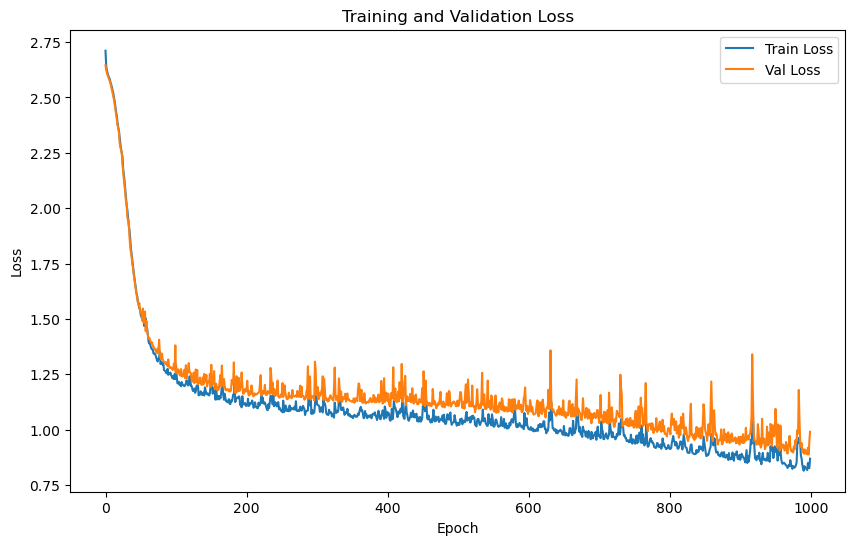

In [30]:
cae_mlp_input_dim = cae_mlp_train_reps.shape[1]
cae_mlp_num_classes = len(torch.unique(cae_mlp_train_labels_torch))
cae_mlp_model = MLPClassifier(cae_mlp_input_dim, cae_mlp_num_classes).to(device)

cae_mlp_criterion = nn.CrossEntropyLoss()
cae_mlp_optimizer = optim.Adam(cae_mlp_model.parameters(), lr=1e-3)

cae_mlp_num_epochs = 1000
cae_mlp_patience = 100

cae_mlp_train_losses = []
cae_mlp_val_losses = []

cae_mlp_best_val_loss = float('inf')
cae_mlp_epochs_without_improvement = 0

for cae_mlp_epoch in range(cae_mlp_num_epochs):
    # Training
    cae_mlp_model.train()
    cae_mlp_train_running_loss = 0.0
    
    for cae_mlp_embeddings_batch, cae_mlp_labels_batch in cae_mlp_train_loader:
        cae_mlp_embeddings_batch = cae_mlp_embeddings_batch.to(device)
        cae_mlp_labels_batch = cae_mlp_labels_batch.to(device)
        
        cae_mlp_optimizer.zero_grad()
        
        # Forward
        cae_mlp_outputs = cae_mlp_model(cae_mlp_embeddings_batch)
        cae_mlp_loss = cae_mlp_criterion(cae_mlp_outputs, cae_mlp_labels_batch)
        
        # Backward & Update
        cae_mlp_loss.backward()
        cae_mlp_optimizer.step()
        
        cae_mlp_train_running_loss += cae_mlp_loss.item() * cae_mlp_embeddings_batch.size(0)
    
    cae_mlp_epoch_train_loss = cae_mlp_train_running_loss / len(cae_mlp_train_loader.dataset)
    cae_mlp_train_losses.append(cae_mlp_epoch_train_loss)


    # Validation

    cae_mlp_model.eval()
    cae_mlp_val_running_loss = 0.0
    
    with torch.no_grad():
        for cae_mlp_val_embeddings_batch, cae_mlp_val_labels_batch in cae_mlp_val_loader:
            cae_mlp_val_embeddings_batch = cae_mlp_val_embeddings_batch.to(device)
            cae_mlp_val_labels_batch = cae_mlp_val_labels_batch.to(device)

            cae_mlp_val_outputs = cae_mlp_model(cae_mlp_val_embeddings_batch)
            cae_mlp_val_loss = cae_mlp_criterion(cae_mlp_val_outputs, cae_mlp_val_labels_batch)

            cae_mlp_val_running_loss += cae_mlp_val_loss.item() * cae_mlp_val_embeddings_batch.size(0)

    cae_mlp_epoch_val_loss = cae_mlp_val_running_loss / len(cae_mlp_val_loader.dataset)
    cae_mlp_val_losses.append(cae_mlp_epoch_val_loss)

    print(f"[Epoch {cae_mlp_epoch+1}/{cae_mlp_num_epochs}] "
          f"Train Loss: {cae_mlp_epoch_train_loss:.4f}  |  "
          f"Val Loss: {cae_mlp_epoch_val_loss:.4f}")

    # Early stopping

    if cae_mlp_epoch_val_loss < cae_mlp_best_val_loss:
        # improvement, reset patience
        print(f"Validation loss improved from {cae_mlp_best_val_loss:.4f} to {cae_mlp_epoch_val_loss:.4f}.")
        cae_mlp_best_val_loss = cae_mlp_epoch_val_loss
        cae_mlp_epochs_without_improvement = 0

    else:
        # no improvement
        cae_mlp_epochs_without_improvement += 1
        print(f"!! Validation loss did NOT improve !! "
              f"Patience: {cae_mlp_epochs_without_improvement}/{cae_mlp_patience}")
        
        if cae_mlp_epochs_without_improvement >= cae_mlp_patience:
            print(f"!! Early stopping triggered at epoch {cae_mlp_epoch+1} !!\n"
                  f"No improvement for {cae_mlp_patience} epochs.")
            break

plt.figure(figsize=(10,6))
plt.plot(cae_mlp_train_losses, label='Train Loss')
plt.plot(cae_mlp_val_losses,   label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()


Saved CAE+MLP predictions and true labels to model_predictions
Test Loss: 1.1621 | Test Accuracy: 52.24%


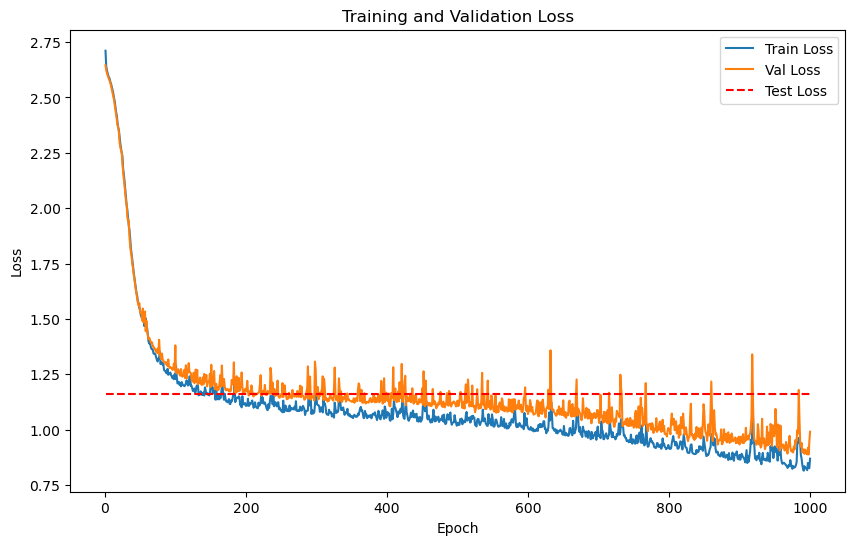

In [31]:
cae_mlp_model.eval()

cae_mlp_test_running_loss = 0.0
cae_mlp_test_correct = 0
cae_mlp_all_predictions = []
cae_mlp_all_true_labels = []

with torch.no_grad():
    for cae_mlp_test_embeddings_batch, cae_mlp_test_labels_batch in cae_mlp_test_loader:
        cae_mlp_test_embeddings_batch = cae_mlp_test_embeddings_batch.to(device)
        cae_mlp_test_labels_batch = cae_mlp_test_labels_batch.to(device)

        cae_mlp_test_outputs = cae_mlp_model(cae_mlp_test_embeddings_batch)
        
        cae_mlp_test_loss_batch = cae_mlp_criterion(cae_mlp_test_outputs, cae_mlp_test_labels_batch)
        cae_mlp_test_running_loss += cae_mlp_test_loss_batch.item() * cae_mlp_test_embeddings_batch.size(0)

        _, cae_mlp_test_predicted = torch.max(cae_mlp_test_outputs, dim=1)
        cae_mlp_test_correct += (cae_mlp_test_predicted == cae_mlp_test_labels_batch).sum().item()

        #saving predictions for conf matrix
        cae_mlp_all_predictions.extend(cae_mlp_test_predicted.cpu().numpy())
        cae_mlp_all_true_labels.extend(cae_mlp_test_labels_batch.cpu().numpy())

np.save(os.path.join(predictions_dir, 'cae_mlp_predictions.npy'), np.array(cae_mlp_all_predictions))
np.save(os.path.join(predictions_dir, 'cae_mlp_true_labels.npy'), np.array(cae_mlp_all_true_labels))
print(f"Saved CAE+MLP predictions and true labels to {predictions_dir}")

cae_mlp_epoch_test_loss = cae_mlp_test_running_loss / len(cae_mlp_test_loader.dataset)
cae_mlp_test_accuracy = cae_mlp_test_correct / len(cae_mlp_test_loader.dataset)

cae_mlp_test_accuracy_pct = cae_mlp_test_accuracy * 100.0

print(f"Test Loss: {cae_mlp_epoch_test_loss:.4f} | Test Accuracy: {cae_mlp_test_accuracy_pct:.2f}%")

cae_mlp_num_epochs_run = len(cae_mlp_train_losses)

plt.figure(figsize=(10,6))

plt.plot(range(1, cae_mlp_num_epochs_run + 1),
         cae_mlp_train_losses,
         label='Train Loss')
plt.plot(range(1, cae_mlp_num_epochs_run + 1),
         cae_mlp_val_losses,
         label='Val Loss')

plt.plot(range(1, cae_mlp_num_epochs_run + 1),
         [cae_mlp_epoch_test_loss]*cae_mlp_num_epochs_run,
         'r--',
         label='Test Loss')

plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

## Typical SCL with Cosine Similarity (Supervised Contrastive Loss)

In [32]:
tscl_encoded_train_dir = os.path.join(encoded_dir, 'train')
tscl_encoded_val_dir = os.path.join(encoded_dir, 'val')
tscl_encoded_test_dir = os.path.join(encoded_dir, 'test')

tscl_train_embeddings, tscl_train_labels = load_encoded_data(tscl_encoded_train_dir)
tscl_val_embeddings, tscl_val_labels = load_encoded_data(tscl_encoded_val_dir)
tscl_test_embeddings, tscl_test_labels = load_encoded_data(tscl_encoded_test_dir)

#shape verification
print(f"\n\nTrain embeddings shape: {tscl_train_embeddings.shape}, \nTrain labels shape: {tscl_train_labels.shape}")
print(f"\n\nVal embeddings shape: {tscl_val_embeddings.shape}, \nVal labels shape: {tscl_val_labels.shape}")
print(f"\n\nTest embeddings shape: {tscl_test_embeddings.shape}, \nTest labels shape: {tscl_test_labels.shape}")

LOG: Loading encoded data (representations) from encoded_representations\train...
LOG: Loaded 280 samples with 64 features each
LOG: Labels shape: (280,)
LOG: Loading encoded data (representations) from encoded_representations\val...
LOG: Loaded 70 samples with 64 features each
LOG: Labels shape: (70,)
LOG: Loading encoded data (representations) from encoded_representations\test...
LOG: Loaded 2898 samples with 64 features each
LOG: Labels shape: (2898,)


Train embeddings shape: (280, 64), 
Train labels shape: (280,)


Val embeddings shape: (70, 64), 
Val labels shape: (70,)


Test embeddings shape: (2898, 64), 
Test labels shape: (2898,)


In [33]:
#flattening embeddings to (num_samples, 64)
tscl_train_embeddings = tscl_train_embeddings.reshape(tscl_train_embeddings.shape[0], -1)
tscl_val_embeddings = tscl_val_embeddings.reshape(tscl_val_embeddings.shape[0], -1)
tscl_test_embeddings = tscl_test_embeddings.reshape(tscl_test_embeddings.shape[0], -1)

#compute mean and std from training set
tscl_train_mean = np.mean(tscl_train_embeddings, axis=0)
tscl_train_std = np.std(tscl_train_embeddings, axis=0)

#normalize all datasets from above training mean and std
tscl_train_embeddings = (tscl_train_embeddings - tscl_train_mean) / tscl_train_std
tscl_val_embeddings = (tscl_val_embeddings - tscl_train_mean) / tscl_train_std
tscl_test_embeddings = (tscl_test_embeddings - tscl_train_mean) / tscl_train_std

tscl_train_dataset = TensorDataset(torch.tensor(tscl_train_embeddings, dtype=torch.float32), torch.tensor(tscl_train_labels, dtype=torch.long))
tscl_val_dataset = TensorDataset(torch.tensor(tscl_val_embeddings, dtype=torch.float32), torch.tensor(tscl_val_labels, dtype=torch.long))
tscl_test_dataset = TensorDataset(torch.tensor(tscl_test_embeddings, dtype=torch.float32), torch.tensor(tscl_test_labels, dtype=torch.long))

tscl_m = 20
tscl_num_classes = len(np.unique(tscl_train_labels))

# Calculate theoretical required batch size
tscl_required_batch_size = tscl_m * tscl_num_classes

# Ensure batch size doesn't exceed training set size
if tscl_required_batch_size > len(tscl_train_dataset):
    #case 1: Not enough samples - reduce m proportionally
    tscl_max_possible_m = len(tscl_train_dataset) // tscl_num_classes
    tscl_m = max(1, tscl_max_possible_m)  # Ensure m >= 1
    tscl_batch_size_train = tscl_m * tscl_num_classes
else:
    #case 2: Use full batch size
    tscl_batch_size_train = tscl_required_batch_size

tscl_sampler = MPerClassSampler(labels = tscl_train_labels, m = tscl_m, batch_size = tscl_batch_size_train, length_before_new_iter=len(tscl_train_dataset))
tscl_train_loader = DataLoader(tscl_train_dataset, batch_size=tscl_batch_size_train, sampler=tscl_sampler)

#creating dataloaders for scl
tscl_dataloader_bs = 256
tscl_val_loader = DataLoader(tscl_val_dataset, batch_size=tscl_dataloader_bs, shuffle=False)
tscl_test_loader = DataLoader(tscl_test_dataset, batch_size=tscl_dataloader_bs, shuffle=False)

for tscl_X_batch, tscl_y_batch in tscl_train_loader:
    tscl_unique, tscl_counts = np.unique(y_batch.numpy(), return_counts=True)
    print("Class distribution in batch:", dict(zip(tscl_unique, tscl_counts)))
    print(f"Training batch size: {tscl_batch_size_train}")
    break

Class distribution in batch: {0: 20, 1: 20, 2: 20, 3: 20, 4: 20, 5: 20, 6: 20, 7: 20, 8: 20, 9: 20, 10: 20, 11: 20, 12: 20, 13: 20}
Training batch size: 280


In [34]:
class SupConLoss(nn.Module):
    def __init__(self, temperature = 0.07):
        super(SupConLoss, self).__init__()
        self.temperature = temperature

    def forward(self, features, labels):
        #normalize feat vectors
        features = F.normalize(features, p=2, dim = 1)

        #compute cosine simi matrix
        similarity_matrix = torch.matmul(features, features.T) / self.temperature

        #create a mask for +ve pairs - i.e. same class
        labels = labels.unsqueeze(1)
        mask = torch.eq(labels, labels.T).float().to(features.device)

        #loss computation
        exp_sim = torch.exp(similarity_matrix)
        log_prob = similarity_matrix - torch.log(exp_sim.sum(dim = 1, keepdim=True))

        #mask out diagonal - i.e. self similarity
        mask_self = torch.eye(mask.shape[0], dtype = torch.bool).to(features.device)
        mask = mask * (~mask_self)

        #handling edge cases when there is no +ve pair
        mask_pos_pairs = mask.sum(dim=1)
        mask_pos_pairs = torch.where(mask_pos_pairs < 1e-6, 1, mask_pos_pairs)

        loss = -(mask * log_prob).sum(dim=1) / mask_pos_pairs

        return loss.mean() 

In [35]:
class SupConNet(nn.Module):
    def __init__(self, feature_dim=128):
        super(SupConNet, self).__init__()

        self.projection_head = nn.Sequential(
            nn.Linear(64, 128), #expects input of shape (batch_size, 64)
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(128, feature_dim)
        )

    def forward(self, x):
        #flattening input tensor
        #x = x.view(x.size(0), -1)  #reshaping -> (batch_size, channels * height * width)
        projections = self.projection_head(x)
        return projections


LOG: Epoch [1/2000] - Training


    Batch [1/1], Train Loss: 8.5188
Epoch [1/2000], Avg Train Loss: 8.5188
Epoch [1/2000], Avg Val Loss: 3.4108
Validation loss improved from inf to 3.4108. Saving model...

LOG: Epoch [2/2000] - Training
    Batch [1/1], Train Loss: 8.3631
Epoch [2/2000], Avg Train Loss: 8.3631
Epoch [2/2000], Avg Val Loss: 3.3985
Validation loss improved from 3.4108 to 3.3985. Saving model...

LOG: Epoch [3/2000] - Training
    Batch [1/1], Train Loss: 8.3216
Epoch [3/2000], Avg Train Loss: 8.3216
Epoch [3/2000], Avg Val Loss: 3.3866
Validation loss improved from 3.3985 to 3.3866. Saving model...

LOG: Epoch [4/2000] - Training
    Batch [1/1], Train Loss: 8.2011
Epoch [4/2000], Avg Train Loss: 8.2011
Epoch [4/2000], Avg Val Loss: 3.3754
Validation loss improved from 3.3866 to 3.3754. Saving model...

LOG: Epoch [5/2000] - Training
    Batch [1/1], Train Loss: 8.2828
Epoch [5/2000], Avg Train Loss: 8.2828
Epoch [5/2000], Avg Val Loss: 3.3649
Validation loss improved from 3.3754 to 3.3649. Saving mode

    Batch [1/1], Train Loss: 7.3446
Epoch [16/2000], Avg Train Loss: 7.3446
Epoch [16/2000], Avg Val Loss: 3.2845
Validation loss improved from 3.2897 to 3.2845. Saving model...

LOG: Epoch [17/2000] - Training
    Batch [1/1], Train Loss: 7.2863
Epoch [17/2000], Avg Train Loss: 7.2863
Epoch [17/2000], Avg Val Loss: 3.2797
Validation loss improved from 3.2845 to 3.2797. Saving model...

LOG: Epoch [18/2000] - Training
    Batch [1/1], Train Loss: 7.2034
Epoch [18/2000], Avg Train Loss: 7.2034
Epoch [18/2000], Avg Val Loss: 3.2753
Validation loss improved from 3.2797 to 3.2753. Saving model...

LOG: Epoch [19/2000] - Training
    Batch [1/1], Train Loss: 7.2537
Epoch [19/2000], Avg Train Loss: 7.2537
Epoch [19/2000], Avg Val Loss: 3.2711
Validation loss improved from 3.2753 to 3.2711. Saving model...

LOG: Epoch [20/2000] - Training
    Batch [1/1], Train Loss: 7.1358
Epoch [20/2000], Avg Train Loss: 7.1358
Epoch [20/2000], Avg Val Loss: 3.2671
Validation loss improved from 3.2711 to 3.

    Batch [1/1], Train Loss: 6.9958
Epoch [24/2000], Avg Train Loss: 6.9958
Epoch [24/2000], Avg Val Loss: 3.2537
Validation loss improved from 3.2566 to 3.2537. Saving model...

LOG: Epoch [25/2000] - Training
    Batch [1/1], Train Loss: 6.7288
Epoch [25/2000], Avg Train Loss: 6.7288
Epoch [25/2000], Avg Val Loss: 3.2510
Validation loss improved from 3.2537 to 3.2510. Saving model...

LOG: Epoch [26/2000] - Training
    Batch [1/1], Train Loss: 6.7764
Epoch [26/2000], Avg Train Loss: 6.7764
Epoch [26/2000], Avg Val Loss: 3.2486
Validation loss improved from 3.2510 to 3.2486. Saving model...

LOG: Epoch [27/2000] - Training
    Batch [1/1], Train Loss: 6.7655
Epoch [27/2000], Avg Train Loss: 6.7655
Epoch [27/2000], Avg Val Loss: 3.2463
Validation loss improved from 3.2486 to 3.2463. Saving model...

LOG: Epoch [28/2000] - Training
    Batch [1/1], Train Loss: 6.7516
Epoch [28/2000], Avg Train Loss: 6.7516
Epoch [28/2000], Avg Val Loss: 3.2442
Validation loss improved from 3.2463 to 3.

    Batch [1/1], Train Loss: 6.2968
Epoch [37/2000], Avg Train Loss: 6.2968
Epoch [37/2000], Avg Val Loss: 3.2316
Validation loss improved from 3.2325 to 3.2316. Saving model...

LOG: Epoch [38/2000] - Training
    Batch [1/1], Train Loss: 6.2943
Epoch [38/2000], Avg Train Loss: 6.2943
Epoch [38/2000], Avg Val Loss: 3.2307
Validation loss improved from 3.2316 to 3.2307. Saving model...

LOG: Epoch [39/2000] - Training
    Batch [1/1], Train Loss: 6.1303
Epoch [39/2000], Avg Train Loss: 6.1303
Epoch [39/2000], Avg Val Loss: 3.2299
Validation loss improved from 3.2307 to 3.2299. Saving model...

LOG: Epoch [40/2000] - Training
    Batch [1/1], Train Loss: 6.2772
Epoch [40/2000], Avg Train Loss: 6.2772
Epoch [40/2000], Avg Val Loss: 3.2291
Validation loss improved from 3.2299 to 3.2291. Saving model...

LOG: Epoch [41/2000] - Training
    Batch [1/1], Train Loss: 6.1906
Epoch [41/2000], Avg Train Loss: 6.1906
Epoch [41/2000], Avg Val Loss: 3.2285
Validation loss improved from 3.2291 to 3.

    Batch [1/1], Train Loss: 5.6939
Epoch [54/2000], Avg Train Loss: 5.6939
Epoch [54/2000], Avg Val Loss: 3.2228
Validation loss improved from 3.2231 to 3.2228. Saving model...

LOG: Epoch [55/2000] - Training
    Batch [1/1], Train Loss: 5.7171
Epoch [55/2000], Avg Train Loss: 5.7171
Epoch [55/2000], Avg Val Loss: 3.2225
Validation loss improved from 3.2228 to 3.2225. Saving model...

LOG: Epoch [56/2000] - Training
    Batch [1/1], Train Loss: 5.7833
Epoch [56/2000], Avg Train Loss: 5.7833
Epoch [56/2000], Avg Val Loss: 3.2222
Validation loss improved from 3.2225 to 3.2222. Saving model...

LOG: Epoch [57/2000] - Training
    Batch [1/1], Train Loss: 5.6918
Epoch [57/2000], Avg Train Loss: 5.6918
Epoch [57/2000], Avg Val Loss: 3.2219
Validation loss improved from 3.2222 to 3.2219. Saving model...

LOG: Epoch [58/2000] - Training
    Batch [1/1], Train Loss: 5.7495
Epoch [58/2000], Avg Train Loss: 5.7495
Epoch [58/2000], Avg Val Loss: 3.2217
Validation loss improved from 3.2219 to 3.

Epoch [61/2000], Avg Val Loss: 3.2209
Validation loss improved from 3.2212 to 3.2209. Saving model...

LOG: Epoch [62/2000] - Training
    Batch [1/1], Train Loss: 5.6276
Epoch [62/2000], Avg Train Loss: 5.6276
Epoch [62/2000], Avg Val Loss: 3.2207
Validation loss improved from 3.2209 to 3.2207. Saving model...

LOG: Epoch [63/2000] - Training
    Batch [1/1], Train Loss: 5.6364
Epoch [63/2000], Avg Train Loss: 5.6364
Epoch [63/2000], Avg Val Loss: 3.2205
Validation loss improved from 3.2207 to 3.2205. Saving model...

LOG: Epoch [64/2000] - Training
    Batch [1/1], Train Loss: 5.6329
Epoch [64/2000], Avg Train Loss: 5.6329
Epoch [64/2000], Avg Val Loss: 3.2202
Validation loss improved from 3.2205 to 3.2202. Saving model...

LOG: Epoch [65/2000] - Training
    Batch [1/1], Train Loss: 5.6025
Epoch [65/2000], Avg Train Loss: 5.6025
Epoch [65/2000], Avg Val Loss: 3.2199
Validation loss improved from 3.2202 to 3.2199. Saving model...

LOG: Epoch [66/2000] - Training
    Batch [1/1], Trai

    Batch [1/1], Train Loss: 5.4543
Epoch [74/2000], Avg Train Loss: 5.4543
Epoch [74/2000], Avg Val Loss: 3.2167
Validation loss improved from 3.2171 to 3.2167. Saving model...

LOG: Epoch [75/2000] - Training
    Batch [1/1], Train Loss: 5.4874
Epoch [75/2000], Avg Train Loss: 5.4874
Epoch [75/2000], Avg Val Loss: 3.2164
Validation loss improved from 3.2167 to 3.2164. Saving model...

LOG: Epoch [76/2000] - Training
    Batch [1/1], Train Loss: 5.4418
Epoch [76/2000], Avg Train Loss: 5.4418
Epoch [76/2000], Avg Val Loss: 3.2160
Validation loss improved from 3.2164 to 3.2160. Saving model...

LOG: Epoch [77/2000] - Training
    Batch [1/1], Train Loss: 5.4379
Epoch [77/2000], Avg Train Loss: 5.4379
Epoch [77/2000], Avg Val Loss: 3.2156
Validation loss improved from 3.2160 to 3.2156. Saving model...

LOG: Epoch [78/2000] - Training
    Batch [1/1], Train Loss: 5.3468
Epoch [78/2000], Avg Train Loss: 5.3468
Epoch [78/2000], Avg Val Loss: 3.2153
Validation loss improved from 3.2156 to 3.

Epoch [87/2000], Avg Val Loss: 3.2114
Validation loss improved from 3.2118 to 3.2114. Saving model...

LOG: Epoch [88/2000] - Training
    Batch [1/1], Train Loss: 5.3530
Epoch [88/2000], Avg Train Loss: 5.3530
Epoch [88/2000], Avg Val Loss: 3.2109
Validation loss improved from 3.2114 to 3.2109. Saving model...

LOG: Epoch [89/2000] - Training
    Batch [1/1], Train Loss: 5.3286
Epoch [89/2000], Avg Train Loss: 5.3286
Epoch [89/2000], Avg Val Loss: 3.2105
Validation loss improved from 3.2109 to 3.2105. Saving model...

LOG: Epoch [90/2000] - Training
    Batch [1/1], Train Loss: 5.2957
Epoch [90/2000], Avg Train Loss: 5.2957
Epoch [90/2000], Avg Val Loss: 3.2101
Validation loss improved from 3.2105 to 3.2101. Saving model...

LOG: Epoch [91/2000] - Training
    Batch [1/1], Train Loss: 5.2618
Epoch [91/2000], Avg Train Loss: 5.2618
Epoch [91/2000], Avg Val Loss: 3.2097
Validation loss improved from 3.2101 to 3.2097. Saving model...

LOG: Epoch [92/2000] - Training
    Batch [1/1], Trai

Epoch [95/2000], Avg Val Loss: 3.2078
Validation loss improved from 3.2083 to 3.2078. Saving model...

LOG: Epoch [96/2000] - Training
    Batch [1/1], Train Loss: 5.2785
Epoch [96/2000], Avg Train Loss: 5.2785
Epoch [96/2000], Avg Val Loss: 3.2073
Validation loss improved from 3.2078 to 3.2073. Saving model...

LOG: Epoch [97/2000] - Training
    Batch [1/1], Train Loss: 5.2291
Epoch [97/2000], Avg Train Loss: 5.2291
Epoch [97/2000], Avg Val Loss: 3.2068
Validation loss improved from 3.2073 to 3.2068. Saving model...

LOG: Epoch [98/2000] - Training
    Batch [1/1], Train Loss: 5.1821
Epoch [98/2000], Avg Train Loss: 5.1821
Epoch [98/2000], Avg Val Loss: 3.2063
Validation loss improved from 3.2068 to 3.2063. Saving model...

LOG: Epoch [99/2000] - Training
    Batch [1/1], Train Loss: 5.2521
Epoch [99/2000], Avg Train Loss: 5.2521
Epoch [99/2000], Avg Val Loss: 3.2058
Validation loss improved from 3.2063 to 3.2058. Saving model...

LOG: Epoch [100/2000] - Training
    Batch [1/1], Tra

    Batch [1/1], Train Loss: 5.1526
Epoch [106/2000], Avg Train Loss: 5.1526
Epoch [106/2000], Avg Val Loss: 3.2016
Validation loss improved from 3.2022 to 3.2016. Saving model...

LOG: Epoch [107/2000] - Training
    Batch [1/1], Train Loss: 5.1719
Epoch [107/2000], Avg Train Loss: 5.1719
Epoch [107/2000], Avg Val Loss: 3.2009
Validation loss improved from 3.2016 to 3.2009. Saving model...

LOG: Epoch [108/2000] - Training
    Batch [1/1], Train Loss: 5.1173
Epoch [108/2000], Avg Train Loss: 5.1173
Epoch [108/2000], Avg Val Loss: 3.2002
Validation loss improved from 3.2009 to 3.2002. Saving model...

LOG: Epoch [109/2000] - Training
    Batch [1/1], Train Loss: 5.1761
Epoch [109/2000], Avg Train Loss: 5.1761
Epoch [109/2000], Avg Val Loss: 3.1995
Validation loss improved from 3.2002 to 3.1995. Saving model...

LOG: Epoch [110/2000] - Training
    Batch [1/1], Train Loss: 5.1546
Epoch [110/2000], Avg Train Loss: 5.1546
Epoch [110/2000], Avg Val Loss: 3.1988
Validation loss improved fro

    Batch [1/1], Train Loss: 5.1125
Epoch [123/2000], Avg Train Loss: 5.1125
Epoch [123/2000], Avg Val Loss: 3.1889
Validation loss improved from 3.1897 to 3.1889. Saving model...

LOG: Epoch [124/2000] - Training
    Batch [1/1], Train Loss: 5.0672
Epoch [124/2000], Avg Train Loss: 5.0672
Epoch [124/2000], Avg Val Loss: 3.1881
Validation loss improved from 3.1889 to 3.1881. Saving model...

LOG: Epoch [125/2000] - Training
    Batch [1/1], Train Loss: 5.0941
Epoch [125/2000], Avg Train Loss: 5.0941
Epoch [125/2000], Avg Val Loss: 3.1873
Validation loss improved from 3.1881 to 3.1873. Saving model...

LOG: Epoch [126/2000] - Training
    Batch [1/1], Train Loss: 5.0516
Epoch [126/2000], Avg Train Loss: 5.0516
Epoch [126/2000], Avg Val Loss: 3.1865
Validation loss improved from 3.1873 to 3.1865. Saving model...

LOG: Epoch [127/2000] - Training
    Batch [1/1], Train Loss: 5.0427
Epoch [127/2000], Avg Train Loss: 5.0427
Epoch [127/2000], Avg Val Loss: 3.1856
Validation loss improved fro

    Batch [1/1], Train Loss: 5.0285
Epoch [133/2000], Avg Train Loss: 5.0285
Epoch [133/2000], Avg Val Loss: 3.1804
Validation loss improved from 3.1813 to 3.1804. Saving model...

LOG: Epoch [134/2000] - Training
    Batch [1/1], Train Loss: 5.0142
Epoch [134/2000], Avg Train Loss: 5.0142
Epoch [134/2000], Avg Val Loss: 3.1795
Validation loss improved from 3.1804 to 3.1795. Saving model...

LOG: Epoch [135/2000] - Training
    Batch [1/1], Train Loss: 5.0732
Epoch [135/2000], Avg Train Loss: 5.0732
Epoch [135/2000], Avg Val Loss: 3.1786
Validation loss improved from 3.1795 to 3.1786. Saving model...

LOG: Epoch [136/2000] - Training
    Batch [1/1], Train Loss: 5.0365
Epoch [136/2000], Avg Train Loss: 5.0365
Epoch [136/2000], Avg Val Loss: 3.1777
Validation loss improved from 3.1786 to 3.1777. Saving model...

LOG: Epoch [137/2000] - Training
    Batch [1/1], Train Loss: 4.9818
Epoch [137/2000], Avg Train Loss: 4.9818
Epoch [137/2000], Avg Val Loss: 3.1767
Validation loss improved fro

    Batch [1/1], Train Loss: 5.0360
Epoch [143/2000], Avg Train Loss: 5.0360
Epoch [143/2000], Avg Val Loss: 3.1712
Validation loss improved from 3.1721 to 3.1712. Saving model...

LOG: Epoch [144/2000] - Training
    Batch [1/1], Train Loss: 4.9900
Epoch [144/2000], Avg Train Loss: 4.9900
Epoch [144/2000], Avg Val Loss: 3.1703
Validation loss improved from 3.1712 to 3.1703. Saving model...

LOG: Epoch [145/2000] - Training
    Batch [1/1], Train Loss: 5.0387
Epoch [145/2000], Avg Train Loss: 5.0387
Epoch [145/2000], Avg Val Loss: 3.1694
Validation loss improved from 3.1703 to 3.1694. Saving model...

LOG: Epoch [146/2000] - Training
    Batch [1/1], Train Loss: 4.9623
Epoch [146/2000], Avg Train Loss: 4.9623
Epoch [146/2000], Avg Val Loss: 3.1684
Validation loss improved from 3.1694 to 3.1684. Saving model...

LOG: Epoch [147/2000] - Training
    Batch [1/1], Train Loss: 4.9732
Epoch [147/2000], Avg Train Loss: 4.9732
Epoch [147/2000], Avg Val Loss: 3.1675
Validation loss improved fro

    Batch [1/1], Train Loss: 4.9592
Epoch [158/2000], Avg Train Loss: 4.9592
Epoch [158/2000], Avg Val Loss: 3.1573
Validation loss improved from 3.1583 to 3.1573. Saving model...

LOG: Epoch [159/2000] - Training
    Batch [1/1], Train Loss: 4.9659
Epoch [159/2000], Avg Train Loss: 4.9659
Epoch [159/2000], Avg Val Loss: 3.1564
Validation loss improved from 3.1573 to 3.1564. Saving model...

LOG: Epoch [160/2000] - Training
    Batch [1/1], Train Loss: 4.9358
Epoch [160/2000], Avg Train Loss: 4.9358
Epoch [160/2000], Avg Val Loss: 3.1554
Validation loss improved from 3.1564 to 3.1554. Saving model...

LOG: Epoch [161/2000] - Training
    Batch [1/1], Train Loss: 4.9063
Epoch [161/2000], Avg Train Loss: 4.9063
Epoch [161/2000], Avg Val Loss: 3.1545
Validation loss improved from 3.1554 to 3.1545. Saving model...

LOG: Epoch [162/2000] - Training
    Batch [1/1], Train Loss: 4.9527
Epoch [162/2000], Avg Train Loss: 4.9527
Epoch [162/2000], Avg Val Loss: 3.1536
Validation loss improved fro

    Batch [1/1], Train Loss: 4.8831
Epoch [168/2000], Avg Train Loss: 4.8831
Epoch [168/2000], Avg Val Loss: 3.1478
Validation loss improved from 3.1488 to 3.1478. Saving model...

LOG: Epoch [169/2000] - Training
    Batch [1/1], Train Loss: 4.9139
Epoch [169/2000], Avg Train Loss: 4.9139
Epoch [169/2000], Avg Val Loss: 3.1468
Validation loss improved from 3.1478 to 3.1468. Saving model...

LOG: Epoch [170/2000] - Training
    Batch [1/1], Train Loss: 4.8665
Epoch [170/2000], Avg Train Loss: 4.8665
Epoch [170/2000], Avg Val Loss: 3.1458
Validation loss improved from 3.1468 to 3.1458. Saving model...

LOG: Epoch [171/2000] - Training
    Batch [1/1], Train Loss: 4.9067
Epoch [171/2000], Avg Train Loss: 4.9067
Epoch [171/2000], Avg Val Loss: 3.1448
Validation loss improved from 3.1458 to 3.1448. Saving model...

LOG: Epoch [172/2000] - Training
    Batch [1/1], Train Loss: 4.9257
Epoch [172/2000], Avg Train Loss: 4.9257
Epoch [172/2000], Avg Val Loss: 3.1437
Validation loss improved fro

    Batch [1/1], Train Loss: 4.8962
Epoch [177/2000], Avg Train Loss: 4.8962
Epoch [177/2000], Avg Val Loss: 3.1387
Validation loss improved from 3.1397 to 3.1387. Saving model...

LOG: Epoch [178/2000] - Training
    Batch [1/1], Train Loss: 4.9316
Epoch [178/2000], Avg Train Loss: 4.9316
Epoch [178/2000], Avg Val Loss: 3.1377
Validation loss improved from 3.1387 to 3.1377. Saving model...

LOG: Epoch [179/2000] - Training
    Batch [1/1], Train Loss: 4.8820
Epoch [179/2000], Avg Train Loss: 4.8820
Epoch [179/2000], Avg Val Loss: 3.1366
Validation loss improved from 3.1377 to 3.1366. Saving model...

LOG: Epoch [180/2000] - Training
    Batch [1/1], Train Loss: 4.8926
Epoch [180/2000], Avg Train Loss: 4.8926
Epoch [180/2000], Avg Val Loss: 3.1356
Validation loss improved from 3.1366 to 3.1356. Saving model...

LOG: Epoch [181/2000] - Training
    Batch [1/1], Train Loss: 4.8378
Epoch [181/2000], Avg Train Loss: 4.8378
Epoch [181/2000], Avg Val Loss: 3.1346
Validation loss improved fro

    Batch [1/1], Train Loss: 4.8340
Epoch [190/2000], Avg Train Loss: 4.8340
Epoch [190/2000], Avg Val Loss: 3.1256
Validation loss improved from 3.1266 to 3.1256. Saving model...

LOG: Epoch [191/2000] - Training
    Batch [1/1], Train Loss: 4.8788
Epoch [191/2000], Avg Train Loss: 4.8788
Epoch [191/2000], Avg Val Loss: 3.1246
Validation loss improved from 3.1256 to 3.1246. Saving model...

LOG: Epoch [192/2000] - Training
    Batch [1/1], Train Loss: 4.8905
Epoch [192/2000], Avg Train Loss: 4.8905
Epoch [192/2000], Avg Val Loss: 3.1236
Validation loss improved from 3.1246 to 3.1236. Saving model...

LOG: Epoch [193/2000] - Training
    Batch [1/1], Train Loss: 4.8119
Epoch [193/2000], Avg Train Loss: 4.8119
Epoch [193/2000], Avg Val Loss: 3.1227
Validation loss improved from 3.1236 to 3.1227. Saving model...

LOG: Epoch [194/2000] - Training
    Batch [1/1], Train Loss: 4.8654
Epoch [194/2000], Avg Train Loss: 4.8654
Epoch [194/2000], Avg Val Loss: 3.1217
Validation loss improved fro

Epoch [200/2000], Avg Val Loss: 3.1156
Validation loss improved from 3.1166 to 3.1156. Saving model...

LOG: Epoch [201/2000] - Training
    Batch [1/1], Train Loss: 4.8205
Epoch [201/2000], Avg Train Loss: 4.8205
Epoch [201/2000], Avg Val Loss: 3.1145
Validation loss improved from 3.1156 to 3.1145. Saving model...

LOG: Epoch [202/2000] - Training
    Batch [1/1], Train Loss: 4.7977
Epoch [202/2000], Avg Train Loss: 4.7977
Epoch [202/2000], Avg Val Loss: 3.1135
Validation loss improved from 3.1145 to 3.1135. Saving model...

LOG: Epoch [203/2000] - Training
    Batch [1/1], Train Loss: 4.8203
Epoch [203/2000], Avg Train Loss: 4.8203
Epoch [203/2000], Avg Val Loss: 3.1125
Validation loss improved from 3.1135 to 3.1125. Saving model...

LOG: Epoch [204/2000] - Training
    Batch [1/1], Train Loss: 4.7953
Epoch [204/2000], Avg Train Loss: 4.7953
Epoch [204/2000], Avg Val Loss: 3.1115
Validation loss improved from 3.1125 to 3.1115. Saving model...

LOG: Epoch [205/2000] - Training
    Bat

Epoch [213/2000], Avg Val Loss: 3.1028
Validation loss improved from 3.1038 to 3.1028. Saving model...

LOG: Epoch [214/2000] - Training
    Batch [1/1], Train Loss: 4.7960
Epoch [214/2000], Avg Train Loss: 4.7960
Epoch [214/2000], Avg Val Loss: 3.1019
Validation loss improved from 3.1028 to 3.1019. Saving model...

LOG: Epoch [215/2000] - Training
    Batch [1/1], Train Loss: 4.7840
Epoch [215/2000], Avg Train Loss: 4.7840
Epoch [215/2000], Avg Val Loss: 3.1009
Validation loss improved from 3.1019 to 3.1009. Saving model...

LOG: Epoch [216/2000] - Training
    Batch [1/1], Train Loss: 4.7868
Epoch [216/2000], Avg Train Loss: 4.7868
Epoch [216/2000], Avg Val Loss: 3.1000
Validation loss improved from 3.1009 to 3.1000. Saving model...

LOG: Epoch [217/2000] - Training
    Batch [1/1], Train Loss: 4.7615
Epoch [217/2000], Avg Train Loss: 4.7615
Epoch [217/2000], Avg Val Loss: 3.0990
Validation loss improved from 3.1000 to 3.0990. Saving model...

LOG: Epoch [218/2000] - Training
    Bat

    Batch [1/1], Train Loss: 4.7976
Epoch [225/2000], Avg Train Loss: 4.7976
Epoch [225/2000], Avg Val Loss: 3.0915
Validation loss improved from 3.0924 to 3.0915. Saving model...

LOG: Epoch [226/2000] - Training
    Batch [1/1], Train Loss: 4.7636
Epoch [226/2000], Avg Train Loss: 4.7636
Epoch [226/2000], Avg Val Loss: 3.0906
Validation loss improved from 3.0915 to 3.0906. Saving model...

LOG: Epoch [227/2000] - Training
    Batch [1/1], Train Loss: 4.7725
Epoch [227/2000], Avg Train Loss: 4.7725
Epoch [227/2000], Avg Val Loss: 3.0897
Validation loss improved from 3.0906 to 3.0897. Saving model...

LOG: Epoch [228/2000] - Training
    Batch [1/1], Train Loss: 4.7685
Epoch [228/2000], Avg Train Loss: 4.7685
Epoch [228/2000], Avg Val Loss: 3.0888
Validation loss improved from 3.0897 to 3.0888. Saving model...

LOG: Epoch [229/2000] - Training
    Batch [1/1], Train Loss: 4.8366
Epoch [229/2000], Avg Train Loss: 4.8366
Epoch [229/2000], Avg Val Loss: 3.0880
Validation loss improved fro

Epoch [236/2000], Avg Val Loss: 3.0817
Validation loss improved from 3.0826 to 3.0817. Saving model...

LOG: Epoch [237/2000] - Training
    Batch [1/1], Train Loss: 4.7513
Epoch [237/2000], Avg Train Loss: 4.7513
Epoch [237/2000], Avg Val Loss: 3.0808
Validation loss improved from 3.0817 to 3.0808. Saving model...

LOG: Epoch [238/2000] - Training
    Batch [1/1], Train Loss: 4.7216
Epoch [238/2000], Avg Train Loss: 4.7216
Epoch [238/2000], Avg Val Loss: 3.0799
Validation loss improved from 3.0808 to 3.0799. Saving model...

LOG: Epoch [239/2000] - Training
    Batch [1/1], Train Loss: 4.7406
Epoch [239/2000], Avg Train Loss: 4.7406
Epoch [239/2000], Avg Val Loss: 3.0791
Validation loss improved from 3.0799 to 3.0791. Saving model...

LOG: Epoch [240/2000] - Training
    Batch [1/1], Train Loss: 4.7399
Epoch [240/2000], Avg Train Loss: 4.7399
Epoch [240/2000], Avg Val Loss: 3.0782
Validation loss improved from 3.0791 to 3.0782. Saving model...

LOG: Epoch [241/2000] - Training
    Bat

    Batch [1/1], Train Loss: 4.6918
Epoch [249/2000], Avg Train Loss: 4.6918
Epoch [249/2000], Avg Val Loss: 3.0705
Validation loss improved from 3.0713 to 3.0705. Saving model...

LOG: Epoch [250/2000] - Training
    Batch [1/1], Train Loss: 4.7367
Epoch [250/2000], Avg Train Loss: 4.7367
Epoch [250/2000], Avg Val Loss: 3.0696
Validation loss improved from 3.0705 to 3.0696. Saving model...

LOG: Epoch [251/2000] - Training
    Batch [1/1], Train Loss: 4.7513
Epoch [251/2000], Avg Train Loss: 4.7513
Epoch [251/2000], Avg Val Loss: 3.0688
Validation loss improved from 3.0696 to 3.0688. Saving model...

LOG: Epoch [252/2000] - Training
    Batch [1/1], Train Loss: 4.7157
Epoch [252/2000], Avg Train Loss: 4.7157
Epoch [252/2000], Avg Val Loss: 3.0680
Validation loss improved from 3.0688 to 3.0680. Saving model...

LOG: Epoch [253/2000] - Training
    Batch [1/1], Train Loss: 4.7434
Epoch [253/2000], Avg Train Loss: 4.7434
Epoch [253/2000], Avg Val Loss: 3.0672
Validation loss improved fro

Epoch [262/2000], Avg Val Loss: 3.0601
Validation loss improved from 3.0608 to 3.0601. Saving model...

LOG: Epoch [263/2000] - Training
    Batch [1/1], Train Loss: 4.6739
Epoch [263/2000], Avg Train Loss: 4.6739
Epoch [263/2000], Avg Val Loss: 3.0593
Validation loss improved from 3.0601 to 3.0593. Saving model...

LOG: Epoch [264/2000] - Training
    Batch [1/1], Train Loss: 4.6938
Epoch [264/2000], Avg Train Loss: 4.6938
Epoch [264/2000], Avg Val Loss: 3.0585
Validation loss improved from 3.0593 to 3.0585. Saving model...

LOG: Epoch [265/2000] - Training
    Batch [1/1], Train Loss: 4.6741
Epoch [265/2000], Avg Train Loss: 4.6741
Epoch [265/2000], Avg Val Loss: 3.0577
Validation loss improved from 3.0585 to 3.0577. Saving model...

LOG: Epoch [266/2000] - Training
    Batch [1/1], Train Loss: 4.6696
Epoch [266/2000], Avg Train Loss: 4.6696
Epoch [266/2000], Avg Val Loss: 3.0569
Validation loss improved from 3.0577 to 3.0569. Saving model...

LOG: Epoch [267/2000] - Training
    Bat

    Batch [1/1], Train Loss: 4.6690
Epoch [273/2000], Avg Train Loss: 4.6690
Epoch [273/2000], Avg Val Loss: 3.0512
Validation loss improved from 3.0520 to 3.0512. Saving model...

LOG: Epoch [274/2000] - Training
    Batch [1/1], Train Loss: 4.6865
Epoch [274/2000], Avg Train Loss: 4.6865
Epoch [274/2000], Avg Val Loss: 3.0504
Validation loss improved from 3.0512 to 3.0504. Saving model...

LOG: Epoch [275/2000] - Training
    Batch [1/1], Train Loss: 4.6561
Epoch [275/2000], Avg Train Loss: 4.6561
Epoch [275/2000], Avg Val Loss: 3.0496
Validation loss improved from 3.0504 to 3.0496. Saving model...

LOG: Epoch [276/2000] - Training
    Batch [1/1], Train Loss: 4.6442
Epoch [276/2000], Avg Train Loss: 4.6442
Epoch [276/2000], Avg Val Loss: 3.0488
Validation loss improved from 3.0496 to 3.0488. Saving model...

LOG: Epoch [277/2000] - Training
    Batch [1/1], Train Loss: 4.6685
Epoch [277/2000], Avg Train Loss: 4.6685
Epoch [277/2000], Avg Val Loss: 3.0480
Validation loss improved fro

    Batch [1/1], Train Loss: 4.6566
Epoch [283/2000], Avg Train Loss: 4.6566
Epoch [283/2000], Avg Val Loss: 3.0433
Validation loss improved from 3.0440 to 3.0433. Saving model...

LOG: Epoch [284/2000] - Training
    Batch [1/1], Train Loss: 4.6297
Epoch [284/2000], Avg Train Loss: 4.6297
Epoch [284/2000], Avg Val Loss: 3.0425
Validation loss improved from 3.0433 to 3.0425. Saving model...

LOG: Epoch [285/2000] - Training
    Batch [1/1], Train Loss: 4.6621
Epoch [285/2000], Avg Train Loss: 4.6621
Epoch [285/2000], Avg Val Loss: 3.0418
Validation loss improved from 3.0425 to 3.0418. Saving model...

LOG: Epoch [286/2000] - Training
    Batch [1/1], Train Loss: 4.6586
Epoch [286/2000], Avg Train Loss: 4.6586
Epoch [286/2000], Avg Val Loss: 3.0410
Validation loss improved from 3.0418 to 3.0410. Saving model...

LOG: Epoch [287/2000] - Training
    Batch [1/1], Train Loss: 4.6556
Epoch [287/2000], Avg Train Loss: 4.6556
Epoch [287/2000], Avg Val Loss: 3.0403
Validation loss improved fro

    Batch [1/1], Train Loss: 4.6192
Epoch [298/2000], Avg Train Loss: 4.6192
Epoch [298/2000], Avg Val Loss: 3.0316
Validation loss improved from 3.0325 to 3.0316. Saving model...

LOG: Epoch [299/2000] - Training
    Batch [1/1], Train Loss: 4.6199
Epoch [299/2000], Avg Train Loss: 4.6199
Epoch [299/2000], Avg Val Loss: 3.0308
Validation loss improved from 3.0316 to 3.0308. Saving model...

LOG: Epoch [300/2000] - Training
    Batch [1/1], Train Loss: 4.6654
Epoch [300/2000], Avg Train Loss: 4.6654
Epoch [300/2000], Avg Val Loss: 3.0301
Validation loss improved from 3.0308 to 3.0301. Saving model...

LOG: Epoch [301/2000] - Training
    Batch [1/1], Train Loss: 4.6402
Epoch [301/2000], Avg Train Loss: 4.6402
Epoch [301/2000], Avg Val Loss: 3.0293
Validation loss improved from 3.0301 to 3.0293. Saving model...

LOG: Epoch [302/2000] - Training
    Batch [1/1], Train Loss: 4.6556
Epoch [302/2000], Avg Train Loss: 4.6556
Epoch [302/2000], Avg Val Loss: 3.0285
Validation loss improved fro

    Batch [1/1], Train Loss: 4.6454
Epoch [309/2000], Avg Train Loss: 4.6454
Epoch [309/2000], Avg Val Loss: 3.0232
Validation loss improved from 3.0240 to 3.0232. Saving model...

LOG: Epoch [310/2000] - Training
    Batch [1/1], Train Loss: 4.6034
Epoch [310/2000], Avg Train Loss: 4.6034
Epoch [310/2000], Avg Val Loss: 3.0225
Validation loss improved from 3.0232 to 3.0225. Saving model...

LOG: Epoch [311/2000] - Training
    Batch [1/1], Train Loss: 4.6049
Epoch [311/2000], Avg Train Loss: 4.6049
Epoch [311/2000], Avg Val Loss: 3.0217
Validation loss improved from 3.0225 to 3.0217. Saving model...

LOG: Epoch [312/2000] - Training
    Batch [1/1], Train Loss: 4.6300
Epoch [312/2000], Avg Train Loss: 4.6300
Epoch [312/2000], Avg Val Loss: 3.0210
Validation loss improved from 3.0217 to 3.0210. Saving model...

LOG: Epoch [313/2000] - Training
    Batch [1/1], Train Loss: 4.6082
Epoch [313/2000], Avg Train Loss: 4.6082
Epoch [313/2000], Avg Val Loss: 3.0202
Validation loss improved fro

    Batch [1/1], Train Loss: 4.6131
Epoch [319/2000], Avg Train Loss: 4.6131
Epoch [319/2000], Avg Val Loss: 3.0156
Validation loss improved from 3.0164 to 3.0156. Saving model...

LOG: Epoch [320/2000] - Training
    Batch [1/1], Train Loss: 4.5998
Epoch [320/2000], Avg Train Loss: 4.5998
Epoch [320/2000], Avg Val Loss: 3.0149
Validation loss improved from 3.0156 to 3.0149. Saving model...

LOG: Epoch [321/2000] - Training
    Batch [1/1], Train Loss: 4.6002
Epoch [321/2000], Avg Train Loss: 4.6002
Epoch [321/2000], Avg Val Loss: 3.0141
Validation loss improved from 3.0149 to 3.0141. Saving model...

LOG: Epoch [322/2000] - Training
    Batch [1/1], Train Loss: 4.6157
Epoch [322/2000], Avg Train Loss: 4.6157
Epoch [322/2000], Avg Val Loss: 3.0134
Validation loss improved from 3.0141 to 3.0134. Saving model...

LOG: Epoch [323/2000] - Training
    Batch [1/1], Train Loss: 4.5781
Epoch [323/2000], Avg Train Loss: 4.5781
Epoch [323/2000], Avg Val Loss: 3.0127
Validation loss improved fro

    Batch [1/1], Train Loss: 4.5934
Epoch [333/2000], Avg Train Loss: 4.5934
Epoch [333/2000], Avg Val Loss: 3.0058
Validation loss improved from 3.0065 to 3.0058. Saving model...

LOG: Epoch [334/2000] - Training
    Batch [1/1], Train Loss: 4.5901
Epoch [334/2000], Avg Train Loss: 4.5901
Epoch [334/2000], Avg Val Loss: 3.0051
Validation loss improved from 3.0058 to 3.0051. Saving model...

LOG: Epoch [335/2000] - Training
    Batch [1/1], Train Loss: 4.5821
Epoch [335/2000], Avg Train Loss: 4.5821
Epoch [335/2000], Avg Val Loss: 3.0043
Validation loss improved from 3.0051 to 3.0043. Saving model...

LOG: Epoch [336/2000] - Training
    Batch [1/1], Train Loss: 4.5897
Epoch [336/2000], Avg Train Loss: 4.5897
Epoch [336/2000], Avg Val Loss: 3.0036
Validation loss improved from 3.0043 to 3.0036. Saving model...

LOG: Epoch [337/2000] - Training
    Batch [1/1], Train Loss: 4.5431
Epoch [337/2000], Avg Train Loss: 4.5431
Epoch [337/2000], Avg Val Loss: 3.0029
Validation loss improved fro

    Batch [1/1], Train Loss: 4.5717
Epoch [343/2000], Avg Train Loss: 4.5717
Epoch [343/2000], Avg Val Loss: 2.9986
Validation loss improved from 2.9993 to 2.9986. Saving model...

LOG: Epoch [344/2000] - Training
    Batch [1/1], Train Loss: 4.5396
Epoch [344/2000], Avg Train Loss: 4.5396
Epoch [344/2000], Avg Val Loss: 2.9979
Validation loss improved from 2.9986 to 2.9979. Saving model...

LOG: Epoch [345/2000] - Training
    Batch [1/1], Train Loss: 4.5517
Epoch [345/2000], Avg Train Loss: 4.5517
Epoch [345/2000], Avg Val Loss: 2.9972
Validation loss improved from 2.9979 to 2.9972. Saving model...

LOG: Epoch [346/2000] - Training
    Batch [1/1], Train Loss: 4.5818
Epoch [346/2000], Avg Train Loss: 4.5818
Epoch [346/2000], Avg Val Loss: 2.9965
Validation loss improved from 2.9972 to 2.9965. Saving model...

LOG: Epoch [347/2000] - Training
    Batch [1/1], Train Loss: 4.5818
Epoch [347/2000], Avg Train Loss: 4.5818
Epoch [347/2000], Avg Val Loss: 2.9958
Validation loss improved fro

    Batch [1/1], Train Loss: 4.5465
Epoch [352/2000], Avg Train Loss: 4.5465
Epoch [352/2000], Avg Val Loss: 2.9925
Validation loss improved from 2.9931 to 2.9925. Saving model...

LOG: Epoch [353/2000] - Training
    Batch [1/1], Train Loss: 4.5833
Epoch [353/2000], Avg Train Loss: 4.5833
Epoch [353/2000], Avg Val Loss: 2.9918
Validation loss improved from 2.9925 to 2.9918. Saving model...

LOG: Epoch [354/2000] - Training
    Batch [1/1], Train Loss: 4.5460
Epoch [354/2000], Avg Train Loss: 4.5460
Epoch [354/2000], Avg Val Loss: 2.9911
Validation loss improved from 2.9918 to 2.9911. Saving model...

LOG: Epoch [355/2000] - Training
    Batch [1/1], Train Loss: 4.5471
Epoch [355/2000], Avg Train Loss: 4.5471
Epoch [355/2000], Avg Val Loss: 2.9905
Validation loss improved from 2.9911 to 2.9905. Saving model...

LOG: Epoch [356/2000] - Training
    Batch [1/1], Train Loss: 4.5827
Epoch [356/2000], Avg Train Loss: 4.5827
Epoch [356/2000], Avg Val Loss: 2.9898
Validation loss improved fro

Epoch [366/2000], Avg Val Loss: 2.9829
Validation loss improved from 2.9836 to 2.9829. Saving model...

LOG: Epoch [367/2000] - Training
    Batch [1/1], Train Loss: 4.5305
Epoch [367/2000], Avg Train Loss: 4.5305
Epoch [367/2000], Avg Val Loss: 2.9822
Validation loss improved from 2.9829 to 2.9822. Saving model...

LOG: Epoch [368/2000] - Training
    Batch [1/1], Train Loss: 4.5533
Epoch [368/2000], Avg Train Loss: 4.5533
Epoch [368/2000], Avg Val Loss: 2.9814
Validation loss improved from 2.9822 to 2.9814. Saving model...

LOG: Epoch [369/2000] - Training
    Batch [1/1], Train Loss: 4.5003
Epoch [369/2000], Avg Train Loss: 4.5003
Epoch [369/2000], Avg Val Loss: 2.9807
Validation loss improved from 2.9814 to 2.9807. Saving model...

LOG: Epoch [370/2000] - Training
    Batch [1/1], Train Loss: 4.5336
Epoch [370/2000], Avg Train Loss: 4.5336
Epoch [370/2000], Avg Val Loss: 2.9799
Validation loss improved from 2.9807 to 2.9799. Saving model...

LOG: Epoch [371/2000] - Training
    Bat

    Batch [1/1], Train Loss: 4.5263
Epoch [376/2000], Avg Train Loss: 4.5263
Epoch [376/2000], Avg Val Loss: 2.9758
Validation loss improved from 2.9765 to 2.9758. Saving model...

LOG: Epoch [377/2000] - Training
    Batch [1/1], Train Loss: 4.5235
Epoch [377/2000], Avg Train Loss: 4.5235
Epoch [377/2000], Avg Val Loss: 2.9752
Validation loss improved from 2.9758 to 2.9752. Saving model...

LOG: Epoch [378/2000] - Training
    Batch [1/1], Train Loss: 4.5374
Epoch [378/2000], Avg Train Loss: 4.5374
Epoch [378/2000], Avg Val Loss: 2.9745
Validation loss improved from 2.9752 to 2.9745. Saving model...

LOG: Epoch [379/2000] - Training
    Batch [1/1], Train Loss: 4.5526
Epoch [379/2000], Avg Train Loss: 4.5526
Epoch [379/2000], Avg Val Loss: 2.9738
Validation loss improved from 2.9745 to 2.9738. Saving model...

LOG: Epoch [380/2000] - Training
    Batch [1/1], Train Loss: 4.5436
Epoch [380/2000], Avg Train Loss: 4.5436
Epoch [380/2000], Avg Val Loss: 2.9732
Validation loss improved fro

Epoch [384/2000], Avg Val Loss: 2.9706
Validation loss improved from 2.9713 to 2.9706. Saving model...

LOG: Epoch [385/2000] - Training
    Batch [1/1], Train Loss: 4.4997
Epoch [385/2000], Avg Train Loss: 4.4997
Epoch [385/2000], Avg Val Loss: 2.9699
Validation loss improved from 2.9706 to 2.9699. Saving model...

LOG: Epoch [386/2000] - Training
    Batch [1/1], Train Loss: 4.5280
Epoch [386/2000], Avg Train Loss: 4.5280
Epoch [386/2000], Avg Val Loss: 2.9692
Validation loss improved from 2.9699 to 2.9692. Saving model...

LOG: Epoch [387/2000] - Training
    Batch [1/1], Train Loss: 4.5271
Epoch [387/2000], Avg Train Loss: 4.5271
Epoch [387/2000], Avg Val Loss: 2.9685
Validation loss improved from 2.9692 to 2.9685. Saving model...

LOG: Epoch [388/2000] - Training
    Batch [1/1], Train Loss: 4.4638
Epoch [388/2000], Avg Train Loss: 4.4638
Epoch [388/2000], Avg Val Loss: 2.9678
Validation loss improved from 2.9685 to 2.9678. Saving model...

LOG: Epoch [389/2000] - Training
    Bat

Epoch [401/2000], Avg Val Loss: 2.9585
Validation loss improved from 2.9593 to 2.9585. Saving model...

LOG: Epoch [402/2000] - Training
    Batch [1/1], Train Loss: 4.4957
Epoch [402/2000], Avg Train Loss: 4.4957
Epoch [402/2000], Avg Val Loss: 2.9578
Validation loss improved from 2.9585 to 2.9578. Saving model...

LOG: Epoch [403/2000] - Training
    Batch [1/1], Train Loss: 4.5354
Epoch [403/2000], Avg Train Loss: 4.5354
Epoch [403/2000], Avg Val Loss: 2.9570
Validation loss improved from 2.9578 to 2.9570. Saving model...

LOG: Epoch [404/2000] - Training
    Batch [1/1], Train Loss: 4.4603
Epoch [404/2000], Avg Train Loss: 4.4603
Epoch [404/2000], Avg Val Loss: 2.9562
Validation loss improved from 2.9570 to 2.9562. Saving model...

LOG: Epoch [405/2000] - Training
    Batch [1/1], Train Loss: 4.4896
Epoch [405/2000], Avg Train Loss: 4.4896
Epoch [405/2000], Avg Val Loss: 2.9554
Validation loss improved from 2.9562 to 2.9554. Saving model...

LOG: Epoch [406/2000] - Training
    Bat

    Batch [1/1], Train Loss: 4.4672
Epoch [409/2000], Avg Train Loss: 4.4672
Epoch [409/2000], Avg Val Loss: 2.9523
Validation loss improved from 2.9531 to 2.9523. Saving model...

LOG: Epoch [410/2000] - Training
    Batch [1/1], Train Loss: 4.4583
Epoch [410/2000], Avg Train Loss: 4.4583
Epoch [410/2000], Avg Val Loss: 2.9515
Validation loss improved from 2.9523 to 2.9515. Saving model...

LOG: Epoch [411/2000] - Training
    Batch [1/1], Train Loss: 4.4760
Epoch [411/2000], Avg Train Loss: 4.4760
Epoch [411/2000], Avg Val Loss: 2.9508
Validation loss improved from 2.9515 to 2.9508. Saving model...

LOG: Epoch [412/2000] - Training
    Batch [1/1], Train Loss: 4.4738
Epoch [412/2000], Avg Train Loss: 4.4738
Epoch [412/2000], Avg Val Loss: 2.9501
Validation loss improved from 2.9508 to 2.9501. Saving model...

LOG: Epoch [413/2000] - Training
    Batch [1/1], Train Loss: 4.4451
Epoch [413/2000], Avg Train Loss: 4.4451
Epoch [413/2000], Avg Val Loss: 2.9493
Validation loss improved fro

    Batch [1/1], Train Loss: 4.4375
Epoch [419/2000], Avg Train Loss: 4.4375
Epoch [419/2000], Avg Val Loss: 2.9446
Validation loss improved from 2.9453 to 2.9446. Saving model...

LOG: Epoch [420/2000] - Training
    Batch [1/1], Train Loss: 4.4697
Epoch [420/2000], Avg Train Loss: 4.4697
Epoch [420/2000], Avg Val Loss: 2.9438
Validation loss improved from 2.9446 to 2.9438. Saving model...

LOG: Epoch [421/2000] - Training
    Batch [1/1], Train Loss: 4.4450
Epoch [421/2000], Avg Train Loss: 4.4450
Epoch [421/2000], Avg Val Loss: 2.9430
Validation loss improved from 2.9438 to 2.9430. Saving model...

LOG: Epoch [422/2000] - Training
    Batch [1/1], Train Loss: 4.4442
Epoch [422/2000], Avg Train Loss: 4.4442
Epoch [422/2000], Avg Val Loss: 2.9423
Validation loss improved from 2.9430 to 2.9423. Saving model...

LOG: Epoch [423/2000] - Training
    Batch [1/1], Train Loss: 4.4717
Epoch [423/2000], Avg Train Loss: 4.4717
Epoch [423/2000], Avg Val Loss: 2.9415
Validation loss improved fro

    Batch [1/1], Train Loss: 4.4471
Epoch [437/2000], Avg Train Loss: 4.4471
Epoch [437/2000], Avg Val Loss: 2.9308
Validation loss improved from 2.9316 to 2.9308. Saving model...

LOG: Epoch [438/2000] - Training
    Batch [1/1], Train Loss: 4.4288
Epoch [438/2000], Avg Train Loss: 4.4288
Epoch [438/2000], Avg Val Loss: 2.9300
Validation loss improved from 2.9308 to 2.9300. Saving model...

LOG: Epoch [439/2000] - Training
    Batch [1/1], Train Loss: 4.4280
Epoch [439/2000], Avg Train Loss: 4.4280
Epoch [439/2000], Avg Val Loss: 2.9292
Validation loss improved from 2.9300 to 2.9292. Saving model...

LOG: Epoch [440/2000] - Training
    Batch [1/1], Train Loss: 4.4390
Epoch [440/2000], Avg Train Loss: 4.4390
Epoch [440/2000], Avg Val Loss: 2.9284
Validation loss improved from 2.9292 to 2.9284. Saving model...

LOG: Epoch [441/2000] - Training
    Batch [1/1], Train Loss: 4.4286
Epoch [441/2000], Avg Train Loss: 4.4286
Epoch [441/2000], Avg Val Loss: 2.9276
Validation loss improved fro

Epoch [446/2000], Avg Val Loss: 2.9236
Validation loss improved from 2.9244 to 2.9236. Saving model...

LOG: Epoch [447/2000] - Training
    Batch [1/1], Train Loss: 4.4101
Epoch [447/2000], Avg Train Loss: 4.4101
Epoch [447/2000], Avg Val Loss: 2.9228
Validation loss improved from 2.9236 to 2.9228. Saving model...

LOG: Epoch [448/2000] - Training
    Batch [1/1], Train Loss: 4.3975
Epoch [448/2000], Avg Train Loss: 4.3975
Epoch [448/2000], Avg Val Loss: 2.9220
Validation loss improved from 2.9228 to 2.9220. Saving model...

LOG: Epoch [449/2000] - Training
    Batch [1/1], Train Loss: 4.4154
Epoch [449/2000], Avg Train Loss: 4.4154
Epoch [449/2000], Avg Val Loss: 2.9212
Validation loss improved from 2.9220 to 2.9212. Saving model...

LOG: Epoch [450/2000] - Training
    Batch [1/1], Train Loss: 4.4211
Epoch [450/2000], Avg Train Loss: 4.4211
Epoch [450/2000], Avg Val Loss: 2.9204
Validation loss improved from 2.9212 to 2.9204. Saving model...

LOG: Epoch [451/2000] - Training
    Bat

    Batch [1/1], Train Loss: 4.4001
Epoch [454/2000], Avg Train Loss: 4.4001
Epoch [454/2000], Avg Val Loss: 2.9171
Validation loss improved from 2.9179 to 2.9171. Saving model...

LOG: Epoch [455/2000] - Training
    Batch [1/1], Train Loss: 4.4299
Epoch [455/2000], Avg Train Loss: 4.4299
Epoch [455/2000], Avg Val Loss: 2.9163
Validation loss improved from 2.9171 to 2.9163. Saving model...

LOG: Epoch [456/2000] - Training
    Batch [1/1], Train Loss: 4.4255
Epoch [456/2000], Avg Train Loss: 4.4255
Epoch [456/2000], Avg Val Loss: 2.9155
Validation loss improved from 2.9163 to 2.9155. Saving model...

LOG: Epoch [457/2000] - Training
    Batch [1/1], Train Loss: 4.4086
Epoch [457/2000], Avg Train Loss: 4.4086
Epoch [457/2000], Avg Val Loss: 2.9147
Validation loss improved from 2.9155 to 2.9147. Saving model...

LOG: Epoch [458/2000] - Training
    Batch [1/1], Train Loss: 4.4395
Epoch [458/2000], Avg Train Loss: 4.4395
Epoch [458/2000], Avg Val Loss: 2.9139
Validation loss improved fro

    Batch [1/1], Train Loss: 4.3805
Epoch [470/2000], Avg Train Loss: 4.3805
Epoch [470/2000], Avg Val Loss: 2.9036
Validation loss improved from 2.9046 to 2.9036. Saving model...

LOG: Epoch [471/2000] - Training
    Batch [1/1], Train Loss: 4.4043
Epoch [471/2000], Avg Train Loss: 4.4043
Epoch [471/2000], Avg Val Loss: 2.9027
Validation loss improved from 2.9036 to 2.9027. Saving model...

LOG: Epoch [472/2000] - Training
    Batch [1/1], Train Loss: 4.4162
Epoch [472/2000], Avg Train Loss: 4.4162
Epoch [472/2000], Avg Val Loss: 2.9018
Validation loss improved from 2.9027 to 2.9018. Saving model...

LOG: Epoch [473/2000] - Training
    Batch [1/1], Train Loss: 4.3634
Epoch [473/2000], Avg Train Loss: 4.3634
Epoch [473/2000], Avg Val Loss: 2.9009
Validation loss improved from 2.9018 to 2.9009. Saving model...

LOG: Epoch [474/2000] - Training
    Batch [1/1], Train Loss: 4.4110
Epoch [474/2000], Avg Train Loss: 4.4110
Epoch [474/2000], Avg Val Loss: 2.8999
Validation loss improved fro

    Batch [1/1], Train Loss: 4.3860
Epoch [479/2000], Avg Train Loss: 4.3860
Epoch [479/2000], Avg Val Loss: 2.8952
Validation loss improved from 2.8962 to 2.8952. Saving model...

LOG: Epoch [480/2000] - Training
    Batch [1/1], Train Loss: 4.4268
Epoch [480/2000], Avg Train Loss: 4.4268
Epoch [480/2000], Avg Val Loss: 2.8943
Validation loss improved from 2.8952 to 2.8943. Saving model...

LOG: Epoch [481/2000] - Training
    Batch [1/1], Train Loss: 4.4028
Epoch [481/2000], Avg Train Loss: 4.4028
Epoch [481/2000], Avg Val Loss: 2.8934
Validation loss improved from 2.8943 to 2.8934. Saving model...

LOG: Epoch [482/2000] - Training
    Batch [1/1], Train Loss: 4.3790
Epoch [482/2000], Avg Train Loss: 4.3790
Epoch [482/2000], Avg Val Loss: 2.8924
Validation loss improved from 2.8934 to 2.8924. Saving model...

LOG: Epoch [483/2000] - Training
    Batch [1/1], Train Loss: 4.4028
Epoch [483/2000], Avg Train Loss: 4.4028
Epoch [483/2000], Avg Val Loss: 2.8914
Validation loss improved fro

    Batch [1/1], Train Loss: 4.3901
Epoch [486/2000], Avg Train Loss: 4.3901
Epoch [486/2000], Avg Val Loss: 2.8885
Validation loss improved from 2.8895 to 2.8885. Saving model...

LOG: Epoch [487/2000] - Training
    Batch [1/1], Train Loss: 4.3566
Epoch [487/2000], Avg Train Loss: 4.3566
Epoch [487/2000], Avg Val Loss: 2.8874
Validation loss improved from 2.8885 to 2.8874. Saving model...

LOG: Epoch [488/2000] - Training
    Batch [1/1], Train Loss: 4.3751
Epoch [488/2000], Avg Train Loss: 4.3751
Epoch [488/2000], Avg Val Loss: 2.8865
Validation loss improved from 2.8874 to 2.8865. Saving model...

LOG: Epoch [489/2000] - Training
    Batch [1/1], Train Loss: 4.3509
Epoch [489/2000], Avg Train Loss: 4.3509
Epoch [489/2000], Avg Val Loss: 2.8855
Validation loss improved from 2.8865 to 2.8855. Saving model...

LOG: Epoch [490/2000] - Training
    Batch [1/1], Train Loss: 4.3801
Epoch [490/2000], Avg Train Loss: 4.3801
Epoch [490/2000], Avg Val Loss: 2.8845
Validation loss improved fro

    Batch [1/1], Train Loss: 4.3505
Epoch [505/2000], Avg Train Loss: 4.3505
Epoch [505/2000], Avg Val Loss: 2.8697
Validation loss improved from 2.8707 to 2.8697. Saving model...

LOG: Epoch [506/2000] - Training
    Batch [1/1], Train Loss: 4.3123
Epoch [506/2000], Avg Train Loss: 4.3123
Epoch [506/2000], Avg Val Loss: 2.8687
Validation loss improved from 2.8697 to 2.8687. Saving model...

LOG: Epoch [507/2000] - Training
    Batch [1/1], Train Loss: 4.3579
Epoch [507/2000], Avg Train Loss: 4.3579
Epoch [507/2000], Avg Val Loss: 2.8677
Validation loss improved from 2.8687 to 2.8677. Saving model...

LOG: Epoch [508/2000] - Training
    Batch [1/1], Train Loss: 4.3597
Epoch [508/2000], Avg Train Loss: 4.3597
Epoch [508/2000], Avg Val Loss: 2.8667
Validation loss improved from 2.8677 to 2.8667. Saving model...

LOG: Epoch [509/2000] - Training
    Batch [1/1], Train Loss: 4.3441
Epoch [509/2000], Avg Train Loss: 4.3441
Epoch [509/2000], Avg Val Loss: 2.8657
Validation loss improved fro

    Batch [1/1], Train Loss: 4.3401
Epoch [513/2000], Avg Train Loss: 4.3401
Epoch [513/2000], Avg Val Loss: 2.8617
Validation loss improved from 2.8627 to 2.8617. Saving model...

LOG: Epoch [514/2000] - Training
    Batch [1/1], Train Loss: 4.3784
Epoch [514/2000], Avg Train Loss: 4.3784
Epoch [514/2000], Avg Val Loss: 2.8608
Validation loss improved from 2.8617 to 2.8608. Saving model...

LOG: Epoch [515/2000] - Training
    Batch [1/1], Train Loss: 4.3150
Epoch [515/2000], Avg Train Loss: 4.3150
Epoch [515/2000], Avg Val Loss: 2.8598
Validation loss improved from 2.8608 to 2.8598. Saving model...

LOG: Epoch [516/2000] - Training
    Batch [1/1], Train Loss: 4.3841
Epoch [516/2000], Avg Train Loss: 4.3841
Epoch [516/2000], Avg Val Loss: 2.8588
Validation loss improved from 2.8598 to 2.8588. Saving model...

LOG: Epoch [517/2000] - Training
    Batch [1/1], Train Loss: 4.3151
Epoch [517/2000], Avg Train Loss: 4.3151
Epoch [517/2000], Avg Val Loss: 2.8579
Validation loss improved fro

Epoch [523/2000], Avg Val Loss: 2.8520
Validation loss improved from 2.8529 to 2.8520. Saving model...

LOG: Epoch [524/2000] - Training
    Batch [1/1], Train Loss: 4.3470
Epoch [524/2000], Avg Train Loss: 4.3470
Epoch [524/2000], Avg Val Loss: 2.8510
Validation loss improved from 2.8520 to 2.8510. Saving model...

LOG: Epoch [525/2000] - Training
    Batch [1/1], Train Loss: 4.3067
Epoch [525/2000], Avg Train Loss: 4.3067
Epoch [525/2000], Avg Val Loss: 2.8501
Validation loss improved from 2.8510 to 2.8501. Saving model...

LOG: Epoch [526/2000] - Training
    Batch [1/1], Train Loss: 4.3279
Epoch [526/2000], Avg Train Loss: 4.3279
Epoch [526/2000], Avg Val Loss: 2.8490
Validation loss improved from 2.8501 to 2.8490. Saving model...

LOG: Epoch [527/2000] - Training
    Batch [1/1], Train Loss: 4.3218
Epoch [527/2000], Avg Train Loss: 4.3218
Epoch [527/2000], Avg Val Loss: 2.8480
Validation loss improved from 2.8490 to 2.8480. Saving model...

LOG: Epoch [528/2000] - Training
    Bat

    Batch [1/1], Train Loss: 4.2532
Epoch [542/2000], Avg Train Loss: 4.2532
Epoch [542/2000], Avg Val Loss: 2.8322
Validation loss improved from 2.8332 to 2.8322. Saving model...

LOG: Epoch [543/2000] - Training
    Batch [1/1], Train Loss: 4.2812
Epoch [543/2000], Avg Train Loss: 4.2812
Epoch [543/2000], Avg Val Loss: 2.8311
Validation loss improved from 2.8322 to 2.8311. Saving model...

LOG: Epoch [544/2000] - Training
    Batch [1/1], Train Loss: 4.2767
Epoch [544/2000], Avg Train Loss: 4.2767
Epoch [544/2000], Avg Val Loss: 2.8300
Validation loss improved from 2.8311 to 2.8300. Saving model...

LOG: Epoch [545/2000] - Training
    Batch [1/1], Train Loss: 4.2872
Epoch [545/2000], Avg Train Loss: 4.2872
Epoch [545/2000], Avg Val Loss: 2.8290
Validation loss improved from 2.8300 to 2.8290. Saving model...

LOG: Epoch [546/2000] - Training
    Batch [1/1], Train Loss: 4.2956
Epoch [546/2000], Avg Train Loss: 4.2956
Epoch [546/2000], Avg Val Loss: 2.8279
Validation loss improved fro

    Batch [1/1], Train Loss: 4.2829
Epoch [549/2000], Avg Train Loss: 4.2829
Epoch [549/2000], Avg Val Loss: 2.8243
Validation loss improved from 2.8255 to 2.8243. Saving model...

LOG: Epoch [550/2000] - Training
    Batch [1/1], Train Loss: 4.2669
Epoch [550/2000], Avg Train Loss: 4.2669
Epoch [550/2000], Avg Val Loss: 2.8231
Validation loss improved from 2.8243 to 2.8231. Saving model...

LOG: Epoch [551/2000] - Training
    Batch [1/1], Train Loss: 4.2728
Epoch [551/2000], Avg Train Loss: 4.2728
Epoch [551/2000], Avg Val Loss: 2.8220
Validation loss improved from 2.8231 to 2.8220. Saving model...

LOG: Epoch [552/2000] - Training
    Batch [1/1], Train Loss: 4.2706
Epoch [552/2000], Avg Train Loss: 4.2706
Epoch [552/2000], Avg Val Loss: 2.8208
Validation loss improved from 2.8220 to 2.8208. Saving model...

LOG: Epoch [553/2000] - Training
    Batch [1/1], Train Loss: 4.2901
Epoch [553/2000], Avg Train Loss: 4.2901
Epoch [553/2000], Avg Val Loss: 2.8197
Validation loss improved fro

Epoch [558/2000], Avg Val Loss: 2.8145
Validation loss improved from 2.8155 to 2.8145. Saving model...

LOG: Epoch [559/2000] - Training
    Batch [1/1], Train Loss: 4.2880
Epoch [559/2000], Avg Train Loss: 4.2880
Epoch [559/2000], Avg Val Loss: 2.8135
Validation loss improved from 2.8145 to 2.8135. Saving model...

LOG: Epoch [560/2000] - Training
    Batch [1/1], Train Loss: 4.2773
Epoch [560/2000], Avg Train Loss: 4.2773
Epoch [560/2000], Avg Val Loss: 2.8125
Validation loss improved from 2.8135 to 2.8125. Saving model...

LOG: Epoch [561/2000] - Training
    Batch [1/1], Train Loss: 4.3014
Epoch [561/2000], Avg Train Loss: 4.3014
Epoch [561/2000], Avg Val Loss: 2.8115
Validation loss improved from 2.8125 to 2.8115. Saving model...

LOG: Epoch [562/2000] - Training
    Batch [1/1], Train Loss: 4.2689
Epoch [562/2000], Avg Train Loss: 4.2689
Epoch [562/2000], Avg Val Loss: 2.8105
Validation loss improved from 2.8115 to 2.8105. Saving model...

LOG: Epoch [563/2000] - Training
    Bat

    Batch [1/1], Train Loss: 4.2694
Epoch [578/2000], Avg Train Loss: 4.2694
Epoch [578/2000], Avg Val Loss: 2.7938
Validation loss improved from 2.7948 to 2.7938. Saving model...

LOG: Epoch [579/2000] - Training
    Batch [1/1], Train Loss: 4.2723
Epoch [579/2000], Avg Train Loss: 4.2723
Epoch [579/2000], Avg Val Loss: 2.7927
Validation loss improved from 2.7938 to 2.7927. Saving model...

LOG: Epoch [580/2000] - Training
    Batch [1/1], Train Loss: 4.2454
Epoch [580/2000], Avg Train Loss: 4.2454
Epoch [580/2000], Avg Val Loss: 2.7917
Validation loss improved from 2.7927 to 2.7917. Saving model...

LOG: Epoch [581/2000] - Training
    Batch [1/1], Train Loss: 4.2296
Epoch [581/2000], Avg Train Loss: 4.2296
Epoch [581/2000], Avg Val Loss: 2.7906
Validation loss improved from 2.7917 to 2.7906. Saving model...

LOG: Epoch [582/2000] - Training
    Batch [1/1], Train Loss: 4.2249
Epoch [582/2000], Avg Train Loss: 4.2249
Epoch [582/2000], Avg Val Loss: 2.7895
Validation loss improved fro

    Batch [1/1], Train Loss: 4.2654
Epoch [584/2000], Avg Train Loss: 4.2654
Epoch [584/2000], Avg Val Loss: 2.7874
Validation loss improved from 2.7884 to 2.7874. Saving model...

LOG: Epoch [585/2000] - Training
    Batch [1/1], Train Loss: 4.2784
Epoch [585/2000], Avg Train Loss: 4.2784
Epoch [585/2000], Avg Val Loss: 2.7862
Validation loss improved from 2.7874 to 2.7862. Saving model...

LOG: Epoch [586/2000] - Training
    Batch [1/1], Train Loss: 4.2424
Epoch [586/2000], Avg Train Loss: 4.2424
Epoch [586/2000], Avg Val Loss: 2.7851
Validation loss improved from 2.7862 to 2.7851. Saving model...

LOG: Epoch [587/2000] - Training
    Batch [1/1], Train Loss: 4.2615
Epoch [587/2000], Avg Train Loss: 4.2615
Epoch [587/2000], Avg Val Loss: 2.7839
Validation loss improved from 2.7851 to 2.7839. Saving model...

LOG: Epoch [588/2000] - Training
    Batch [1/1], Train Loss: 4.2565
Epoch [588/2000], Avg Train Loss: 4.2565
Epoch [588/2000], Avg Val Loss: 2.7828
Validation loss improved fro

Epoch [594/2000], Avg Val Loss: 2.7759
Validation loss improved from 2.7771 to 2.7759. Saving model...

LOG: Epoch [595/2000] - Training
    Batch [1/1], Train Loss: 4.2528
Epoch [595/2000], Avg Train Loss: 4.2528
Epoch [595/2000], Avg Val Loss: 2.7748
Validation loss improved from 2.7759 to 2.7748. Saving model...

LOG: Epoch [596/2000] - Training
    Batch [1/1], Train Loss: 4.2280
Epoch [596/2000], Avg Train Loss: 4.2280
Epoch [596/2000], Avg Val Loss: 2.7735
Validation loss improved from 2.7748 to 2.7735. Saving model...

LOG: Epoch [597/2000] - Training
    Batch [1/1], Train Loss: 4.2181
Epoch [597/2000], Avg Train Loss: 4.2181
Epoch [597/2000], Avg Val Loss: 2.7723
Validation loss improved from 2.7735 to 2.7723. Saving model...

LOG: Epoch [598/2000] - Training
    Batch [1/1], Train Loss: 4.2404
Epoch [598/2000], Avg Train Loss: 4.2404
Epoch [598/2000], Avg Val Loss: 2.7710
Validation loss improved from 2.7723 to 2.7710. Saving model...

LOG: Epoch [599/2000] - Training
    Bat

    Batch [1/1], Train Loss: 4.2348
Epoch [616/2000], Avg Train Loss: 4.2348
Epoch [616/2000], Avg Val Loss: 2.7496
Validation loss improved from 2.7508 to 2.7496. Saving model...

LOG: Epoch [617/2000] - Training
    Batch [1/1], Train Loss: 4.1887
Epoch [617/2000], Avg Train Loss: 4.1887
Epoch [617/2000], Avg Val Loss: 2.7484
Validation loss improved from 2.7496 to 2.7484. Saving model...

LOG: Epoch [618/2000] - Training
    Batch [1/1], Train Loss: 4.1944
Epoch [618/2000], Avg Train Loss: 4.1944
Epoch [618/2000], Avg Val Loss: 2.7472
Validation loss improved from 2.7484 to 2.7472. Saving model...

LOG: Epoch [619/2000] - Training
    Batch [1/1], Train Loss: 4.1991
Epoch [619/2000], Avg Train Loss: 4.1991
Epoch [619/2000], Avg Val Loss: 2.7459
Validation loss improved from 2.7472 to 2.7459. Saving model...

LOG: Epoch [620/2000] - Training
    Batch [1/1], Train Loss: 4.2375
Epoch [620/2000], Avg Train Loss: 4.2375
Epoch [620/2000], Avg Val Loss: 2.7446
Validation loss improved fro

    Batch [1/1], Train Loss: 4.2095
Epoch [630/2000], Avg Train Loss: 4.2095
Epoch [630/2000], Avg Val Loss: 2.7298
Validation loss improved from 2.7313 to 2.7298. Saving model...

LOG: Epoch [631/2000] - Training
    Batch [1/1], Train Loss: 4.2258
Epoch [631/2000], Avg Train Loss: 4.2258
Epoch [631/2000], Avg Val Loss: 2.7283
Validation loss improved from 2.7298 to 2.7283. Saving model...

LOG: Epoch [632/2000] - Training
    Batch [1/1], Train Loss: 4.1895
Epoch [632/2000], Avg Train Loss: 4.1895
Epoch [632/2000], Avg Val Loss: 2.7269
Validation loss improved from 2.7283 to 2.7269. Saving model...

LOG: Epoch [633/2000] - Training
    Batch [1/1], Train Loss: 4.2057
Epoch [633/2000], Avg Train Loss: 4.2057
Epoch [633/2000], Avg Val Loss: 2.7255
Validation loss improved from 2.7269 to 2.7255. Saving model...

LOG: Epoch [634/2000] - Training
    Batch [1/1], Train Loss: 4.1686
Epoch [634/2000], Avg Train Loss: 4.1686
Epoch [634/2000], Avg Val Loss: 2.7241
Validation loss improved fro

    Batch [1/1], Train Loss: 4.1576
Epoch [649/2000], Avg Train Loss: 4.1576
Epoch [649/2000], Avg Val Loss: 2.7055
Validation loss improved from 2.7065 to 2.7055. Saving model...

LOG: Epoch [650/2000] - Training
    Batch [1/1], Train Loss: 4.1436
Epoch [650/2000], Avg Train Loss: 4.1436
Epoch [650/2000], Avg Val Loss: 2.7045
Validation loss improved from 2.7055 to 2.7045. Saving model...

LOG: Epoch [651/2000] - Training
    Batch [1/1], Train Loss: 4.2053
Epoch [651/2000], Avg Train Loss: 4.2053
Epoch [651/2000], Avg Val Loss: 2.7035
Validation loss improved from 2.7045 to 2.7035. Saving model...

LOG: Epoch [652/2000] - Training
    Batch [1/1], Train Loss: 4.1354
Epoch [652/2000], Avg Train Loss: 4.1354
Epoch [652/2000], Avg Val Loss: 2.7024
Validation loss improved from 2.7035 to 2.7024. Saving model...

LOG: Epoch [653/2000] - Training
    Batch [1/1], Train Loss: 4.1495
Epoch [653/2000], Avg Train Loss: 4.1495
Epoch [653/2000], Avg Val Loss: 2.7013
Validation loss improved fro

    Batch [1/1], Train Loss: 4.1201
Epoch [668/2000], Avg Train Loss: 4.1201
Epoch [668/2000], Avg Val Loss: 2.6847
Validation loss improved from 2.6857 to 2.6847. Saving model...

LOG: Epoch [669/2000] - Training
    Batch [1/1], Train Loss: 4.0839
Epoch [669/2000], Avg Train Loss: 4.0839
Epoch [669/2000], Avg Val Loss: 2.6835
Validation loss improved from 2.6847 to 2.6835. Saving model...

LOG: Epoch [670/2000] - Training
    Batch [1/1], Train Loss: 4.1002
Epoch [670/2000], Avg Train Loss: 4.1002
Epoch [670/2000], Avg Val Loss: 2.6824
Validation loss improved from 2.6835 to 2.6824. Saving model...

LOG: Epoch [671/2000] - Training
    Batch [1/1], Train Loss: 4.0740
Epoch [671/2000], Avg Train Loss: 4.0740
Epoch [671/2000], Avg Val Loss: 2.6812
Validation loss improved from 2.6824 to 2.6812. Saving model...

LOG: Epoch [672/2000] - Training
    Batch [1/1], Train Loss: 4.0962
Epoch [672/2000], Avg Train Loss: 4.0962
Epoch [672/2000], Avg Val Loss: 2.6800
Validation loss improved fro

Epoch [686/2000], Avg Val Loss: 2.6636
Validation loss improved from 2.6648 to 2.6636. Saving model...

LOG: Epoch [687/2000] - Training
    Batch [1/1], Train Loss: 4.1326
Epoch [687/2000], Avg Train Loss: 4.1326
Epoch [687/2000], Avg Val Loss: 2.6624
Validation loss improved from 2.6636 to 2.6624. Saving model...

LOG: Epoch [688/2000] - Training
    Batch [1/1], Train Loss: 4.1006
Epoch [688/2000], Avg Train Loss: 4.1006
Epoch [688/2000], Avg Val Loss: 2.6613
Validation loss improved from 2.6624 to 2.6613. Saving model...

LOG: Epoch [689/2000] - Training
    Batch [1/1], Train Loss: 4.0835
Epoch [689/2000], Avg Train Loss: 4.0835
Epoch [689/2000], Avg Val Loss: 2.6602
Validation loss improved from 2.6613 to 2.6602. Saving model...

LOG: Epoch [690/2000] - Training
    Batch [1/1], Train Loss: 4.1134
Epoch [690/2000], Avg Train Loss: 4.1134
Epoch [690/2000], Avg Val Loss: 2.6590
Validation loss improved from 2.6602 to 2.6590. Saving model...

LOG: Epoch [691/2000] - Training
    Bat

    Batch [1/1], Train Loss: 4.0817
Epoch [705/2000], Avg Train Loss: 4.0817
Epoch [705/2000], Avg Val Loss: 2.6417
Validation loss improved from 2.6428 to 2.6417. Saving model...

LOG: Epoch [706/2000] - Training
    Batch [1/1], Train Loss: 4.1191
Epoch [706/2000], Avg Train Loss: 4.1191
Epoch [706/2000], Avg Val Loss: 2.6405
Validation loss improved from 2.6417 to 2.6405. Saving model...

LOG: Epoch [707/2000] - Training
    Batch [1/1], Train Loss: 4.0589
Epoch [707/2000], Avg Train Loss: 4.0589
Epoch [707/2000], Avg Val Loss: 2.6394
Validation loss improved from 2.6405 to 2.6394. Saving model...

LOG: Epoch [708/2000] - Training
    Batch [1/1], Train Loss: 4.0380
Epoch [708/2000], Avg Train Loss: 4.0380
Epoch [708/2000], Avg Val Loss: 2.6381
Validation loss improved from 2.6394 to 2.6381. Saving model...

LOG: Epoch [709/2000] - Training
    Batch [1/1], Train Loss: 4.0879
Epoch [709/2000], Avg Train Loss: 4.0879
Epoch [709/2000], Avg Val Loss: 2.6368
Validation loss improved fro

    Batch [1/1], Train Loss: 4.0226
Epoch [722/2000], Avg Train Loss: 4.0226
Epoch [722/2000], Avg Val Loss: 2.6230
Validation loss improved from 2.6240 to 2.6230. Saving model...

LOG: Epoch [723/2000] - Training
    Batch [1/1], Train Loss: 4.0622
Epoch [723/2000], Avg Train Loss: 4.0622
Epoch [723/2000], Avg Val Loss: 2.6219
Validation loss improved from 2.6230 to 2.6219. Saving model...

LOG: Epoch [724/2000] - Training
    Batch [1/1], Train Loss: 4.0584
Epoch [724/2000], Avg Train Loss: 4.0584
Epoch [724/2000], Avg Val Loss: 2.6208
Validation loss improved from 2.6219 to 2.6208. Saving model...

LOG: Epoch [725/2000] - Training
    Batch [1/1], Train Loss: 4.0626
Epoch [725/2000], Avg Train Loss: 4.0626
Epoch [725/2000], Avg Val Loss: 2.6197
Validation loss improved from 2.6208 to 2.6197. Saving model...

LOG: Epoch [726/2000] - Training
    Batch [1/1], Train Loss: 4.0601
Epoch [726/2000], Avg Train Loss: 4.0601
Epoch [726/2000], Avg Val Loss: 2.6186
Validation loss improved fro

Epoch [739/2000], Avg Val Loss: 2.6037
Validation loss improved from 2.6046 to 2.6037. Saving model...

LOG: Epoch [740/2000] - Training
    Batch [1/1], Train Loss: 3.9943
Epoch [740/2000], Avg Train Loss: 3.9943
Epoch [740/2000], Avg Val Loss: 2.6027
Validation loss improved from 2.6037 to 2.6027. Saving model...

LOG: Epoch [741/2000] - Training
    Batch [1/1], Train Loss: 4.0426
Epoch [741/2000], Avg Train Loss: 4.0426
Epoch [741/2000], Avg Val Loss: 2.6018
Validation loss improved from 2.6027 to 2.6018. Saving model...

LOG: Epoch [742/2000] - Training
    Batch [1/1], Train Loss: 4.0182
Epoch [742/2000], Avg Train Loss: 4.0182
Epoch [742/2000], Avg Val Loss: 2.6010
Validation loss improved from 2.6018 to 2.6010. Saving model...

LOG: Epoch [743/2000] - Training
    Batch [1/1], Train Loss: 4.0346
Epoch [743/2000], Avg Train Loss: 4.0346
Epoch [743/2000], Avg Val Loss: 2.6000
Validation loss improved from 2.6010 to 2.6000. Saving model...

LOG: Epoch [744/2000] - Training
    Bat

    Batch [1/1], Train Loss: 4.0265
Epoch [756/2000], Avg Train Loss: 4.0265
Epoch [756/2000], Avg Val Loss: 2.5898
Validation loss improved from 2.5906 to 2.5898. Saving model...

LOG: Epoch [757/2000] - Training
    Batch [1/1], Train Loss: 4.0251
Epoch [757/2000], Avg Train Loss: 4.0251
Epoch [757/2000], Avg Val Loss: 2.5890
Validation loss improved from 2.5898 to 2.5890. Saving model...

LOG: Epoch [758/2000] - Training
    Batch [1/1], Train Loss: 4.0005
Epoch [758/2000], Avg Train Loss: 4.0005
Epoch [758/2000], Avg Val Loss: 2.5881
Validation loss improved from 2.5890 to 2.5881. Saving model...

LOG: Epoch [759/2000] - Training
    Batch [1/1], Train Loss: 4.0179
Epoch [759/2000], Avg Train Loss: 4.0179
Epoch [759/2000], Avg Val Loss: 2.5873
Validation loss improved from 2.5881 to 2.5873. Saving model...

LOG: Epoch [760/2000] - Training
    Batch [1/1], Train Loss: 4.0032
Epoch [760/2000], Avg Train Loss: 4.0032
Epoch [760/2000], Avg Val Loss: 2.5864
Validation loss improved fro

    Batch [1/1], Train Loss: 3.9561
Epoch [777/2000], Avg Train Loss: 3.9561
Epoch [777/2000], Avg Val Loss: 2.5694
Validation loss improved from 2.5703 to 2.5694. Saving model...

LOG: Epoch [778/2000] - Training
    Batch [1/1], Train Loss: 3.9983
Epoch [778/2000], Avg Train Loss: 3.9983
Epoch [778/2000], Avg Val Loss: 2.5685
Validation loss improved from 2.5694 to 2.5685. Saving model...

LOG: Epoch [779/2000] - Training
    Batch [1/1], Train Loss: 3.9469
Epoch [779/2000], Avg Train Loss: 3.9469
Epoch [779/2000], Avg Val Loss: 2.5676
Validation loss improved from 2.5685 to 2.5676. Saving model...

LOG: Epoch [780/2000] - Training
    Batch [1/1], Train Loss: 4.0199
Epoch [780/2000], Avg Train Loss: 4.0199
Epoch [780/2000], Avg Val Loss: 2.5666
Validation loss improved from 2.5676 to 2.5666. Saving model...

LOG: Epoch [781/2000] - Training
    Batch [1/1], Train Loss: 3.9624
Epoch [781/2000], Avg Train Loss: 3.9624
Epoch [781/2000], Avg Val Loss: 2.5658
Validation loss improved fro

    Batch [1/1], Train Loss: 3.9855
Epoch [793/2000], Avg Train Loss: 3.9855
Epoch [793/2000], Avg Val Loss: 2.5572
Validation loss improved from 2.5578 to 2.5572. Saving model...

LOG: Epoch [794/2000] - Training
    Batch [1/1], Train Loss: 3.9584
Epoch [794/2000], Avg Train Loss: 3.9584
Epoch [794/2000], Avg Val Loss: 2.5565
Validation loss improved from 2.5572 to 2.5565. Saving model...

LOG: Epoch [795/2000] - Training
    Batch [1/1], Train Loss: 3.9901
Epoch [795/2000], Avg Train Loss: 3.9901
Epoch [795/2000], Avg Val Loss: 2.5559
Validation loss improved from 2.5565 to 2.5559. Saving model...

LOG: Epoch [796/2000] - Training
    Batch [1/1], Train Loss: 3.9358
Epoch [796/2000], Avg Train Loss: 3.9358
Epoch [796/2000], Avg Val Loss: 2.5551
Validation loss improved from 2.5559 to 2.5551. Saving model...

LOG: Epoch [797/2000] - Training
    Batch [1/1], Train Loss: 3.9503
Epoch [797/2000], Avg Train Loss: 3.9503
Epoch [797/2000], Avg Val Loss: 2.5545
Validation loss improved fro

    Batch [1/1], Train Loss: 3.9334
Epoch [812/2000], Avg Train Loss: 3.9334
Epoch [812/2000], Avg Val Loss: 2.5426
Validation loss improved from 2.5435 to 2.5426. Saving model...

LOG: Epoch [813/2000] - Training
    Batch [1/1], Train Loss: 3.9499
Epoch [813/2000], Avg Train Loss: 3.9499
Epoch [813/2000], Avg Val Loss: 2.5418
Validation loss improved from 2.5426 to 2.5418. Saving model...

LOG: Epoch [814/2000] - Training
    Batch [1/1], Train Loss: 3.9557
Epoch [814/2000], Avg Train Loss: 3.9557
Epoch [814/2000], Avg Val Loss: 2.5410
Validation loss improved from 2.5418 to 2.5410. Saving model...

LOG: Epoch [815/2000] - Training
    Batch [1/1], Train Loss: 3.9804
Epoch [815/2000], Avg Train Loss: 3.9804
Epoch [815/2000], Avg Val Loss: 2.5403
Validation loss improved from 2.5410 to 2.5403. Saving model...

LOG: Epoch [816/2000] - Training
    Batch [1/1], Train Loss: 3.9460
Epoch [816/2000], Avg Train Loss: 3.9460
Epoch [816/2000], Avg Val Loss: 2.5396
Validation loss improved fro

    Batch [1/1], Train Loss: 3.9246
Epoch [828/2000], Avg Train Loss: 3.9246
Epoch [828/2000], Avg Val Loss: 2.5303
Validation loss improved from 2.5311 to 2.5303. Saving model...

LOG: Epoch [829/2000] - Training
    Batch [1/1], Train Loss: 3.9184
Epoch [829/2000], Avg Train Loss: 3.9184
Epoch [829/2000], Avg Val Loss: 2.5296
Validation loss improved from 2.5303 to 2.5296. Saving model...

LOG: Epoch [830/2000] - Training
    Batch [1/1], Train Loss: 3.9354
Epoch [830/2000], Avg Train Loss: 3.9354
Epoch [830/2000], Avg Val Loss: 2.5288
Validation loss improved from 2.5296 to 2.5288. Saving model...

LOG: Epoch [831/2000] - Training
    Batch [1/1], Train Loss: 3.9297
Epoch [831/2000], Avg Train Loss: 3.9297
Epoch [831/2000], Avg Val Loss: 2.5282
Validation loss improved from 2.5288 to 2.5282. Saving model...

LOG: Epoch [832/2000] - Training
    Batch [1/1], Train Loss: 3.8970
Epoch [832/2000], Avg Train Loss: 3.8970
Epoch [832/2000], Avg Val Loss: 2.5276
Validation loss improved fro

    Batch [1/1], Train Loss: 3.8923
Epoch [850/2000], Avg Train Loss: 3.8923
Epoch [850/2000], Avg Val Loss: 2.5162
Validation loss improved from 2.5170 to 2.5162. Saving model...

LOG: Epoch [851/2000] - Training
    Batch [1/1], Train Loss: 3.9462
Epoch [851/2000], Avg Train Loss: 3.9462
Epoch [851/2000], Avg Val Loss: 2.5154
Validation loss improved from 2.5162 to 2.5154. Saving model...

LOG: Epoch [852/2000] - Training
    Batch [1/1], Train Loss: 3.9076
Epoch [852/2000], Avg Train Loss: 3.9076
Epoch [852/2000], Avg Val Loss: 2.5146
Validation loss improved from 2.5154 to 2.5146. Saving model...

LOG: Epoch [853/2000] - Training
    Batch [1/1], Train Loss: 3.8927
Epoch [853/2000], Avg Train Loss: 3.8927
Epoch [853/2000], Avg Val Loss: 2.5138
Validation loss improved from 2.5146 to 2.5138. Saving model...

LOG: Epoch [854/2000] - Training
    Batch [1/1], Train Loss: 3.9264
Epoch [854/2000], Avg Train Loss: 3.9264
Epoch [854/2000], Avg Val Loss: 2.5130
Validation loss improved fro

    Batch [1/1], Train Loss: 3.8732
Epoch [857/2000], Avg Train Loss: 3.8732
Epoch [857/2000], Avg Val Loss: 2.5106
Validation loss improved from 2.5113 to 2.5106. Saving model...

LOG: Epoch [858/2000] - Training
    Batch [1/1], Train Loss: 3.8778
Epoch [858/2000], Avg Train Loss: 3.8778
Epoch [858/2000], Avg Val Loss: 2.5099
Validation loss improved from 2.5106 to 2.5099. Saving model...

LOG: Epoch [859/2000] - Training
    Batch [1/1], Train Loss: 3.9129
Epoch [859/2000], Avg Train Loss: 3.9129
Epoch [859/2000], Avg Val Loss: 2.5091
Validation loss improved from 2.5099 to 2.5091. Saving model...

LOG: Epoch [860/2000] - Training
    Batch [1/1], Train Loss: 3.9081
Epoch [860/2000], Avg Train Loss: 3.9081
Epoch [860/2000], Avg Val Loss: 2.5083
Validation loss improved from 2.5091 to 2.5083. Saving model...

LOG: Epoch [861/2000] - Training
    Batch [1/1], Train Loss: 3.8777
Epoch [861/2000], Avg Train Loss: 3.8777
Epoch [861/2000], Avg Val Loss: 2.5074
Validation loss improved fro

Epoch [867/2000], Avg Val Loss: 2.5022
Validation loss improved from 2.5029 to 2.5022. Saving model...

LOG: Epoch [868/2000] - Training
    Batch [1/1], Train Loss: 3.9061
Epoch [868/2000], Avg Train Loss: 3.9061
Epoch [868/2000], Avg Val Loss: 2.5015
Validation loss improved from 2.5022 to 2.5015. Saving model...

LOG: Epoch [869/2000] - Training
    Batch [1/1], Train Loss: 3.9162
Epoch [869/2000], Avg Train Loss: 3.9162
Epoch [869/2000], Avg Val Loss: 2.5009
Validation loss improved from 2.5015 to 2.5009. Saving model...

LOG: Epoch [870/2000] - Training
    Batch [1/1], Train Loss: 3.9000
Epoch [870/2000], Avg Train Loss: 3.9000
Epoch [870/2000], Avg Val Loss: 2.5003
Validation loss improved from 2.5009 to 2.5003. Saving model...

LOG: Epoch [871/2000] - Training
    Batch [1/1], Train Loss: 3.8635
Epoch [871/2000], Avg Train Loss: 3.8635
Epoch [871/2000], Avg Val Loss: 2.4997
Validation loss improved from 2.5003 to 2.4997. Saving model...

LOG: Epoch [872/2000] - Training
    Bat

    Batch [1/1], Train Loss: 3.8816
Epoch [894/2000], Avg Train Loss: 3.8816
Epoch [894/2000], Avg Val Loss: 2.4870
Validation loss improved from 2.4876 to 2.4870. Saving model...

LOG: Epoch [895/2000] - Training
    Batch [1/1], Train Loss: 3.8687
Epoch [895/2000], Avg Train Loss: 3.8687
Epoch [895/2000], Avg Val Loss: 2.4863
Validation loss improved from 2.4870 to 2.4863. Saving model...

LOG: Epoch [896/2000] - Training
    Batch [1/1], Train Loss: 3.8083
Epoch [896/2000], Avg Train Loss: 3.8083
Epoch [896/2000], Avg Val Loss: 2.4857
Validation loss improved from 2.4863 to 2.4857. Saving model...

LOG: Epoch [897/2000] - Training
    Batch [1/1], Train Loss: 3.8960
Epoch [897/2000], Avg Train Loss: 3.8960
Epoch [897/2000], Avg Val Loss: 2.4850
Validation loss improved from 2.4857 to 2.4850. Saving model...

LOG: Epoch [898/2000] - Training
    Batch [1/1], Train Loss: 3.8413
Epoch [898/2000], Avg Train Loss: 3.8413
Epoch [898/2000], Avg Val Loss: 2.4843
Validation loss improved fro

Epoch [902/2000], Avg Val Loss: 2.4816
Validation loss improved from 2.4822 to 2.4816. Saving model...

LOG: Epoch [903/2000] - Training
    Batch [1/1], Train Loss: 3.8700
Epoch [903/2000], Avg Train Loss: 3.8700
Epoch [903/2000], Avg Val Loss: 2.4810
Validation loss improved from 2.4816 to 2.4810. Saving model...

LOG: Epoch [904/2000] - Training
    Batch [1/1], Train Loss: 3.8484
Epoch [904/2000], Avg Train Loss: 3.8484
Epoch [904/2000], Avg Val Loss: 2.4805
Validation loss improved from 2.4810 to 2.4805. Saving model...

LOG: Epoch [905/2000] - Training
    Batch [1/1], Train Loss: 3.8498
Epoch [905/2000], Avg Train Loss: 3.8498
Epoch [905/2000], Avg Val Loss: 2.4800
Validation loss improved from 2.4805 to 2.4800. Saving model...

LOG: Epoch [906/2000] - Training
    Batch [1/1], Train Loss: 3.8597
Epoch [906/2000], Avg Train Loss: 3.8597
Epoch [906/2000], Avg Val Loss: 2.4795
Validation loss improved from 2.4800 to 2.4795. Saving model...

LOG: Epoch [907/2000] - Training
    Bat

Epoch [930/2000], Avg Val Loss: 2.4661
Validation loss improved from 2.4668 to 2.4661. Saving model...

LOG: Epoch [931/2000] - Training
    Batch [1/1], Train Loss: 3.8413
Epoch [931/2000], Avg Train Loss: 3.8413
Epoch [931/2000], Avg Val Loss: 2.4656
Validation loss improved from 2.4661 to 2.4656. Saving model...

LOG: Epoch [932/2000] - Training
    Batch [1/1], Train Loss: 3.8344
Epoch [932/2000], Avg Train Loss: 3.8344
Epoch [932/2000], Avg Val Loss: 2.4650
Validation loss improved from 2.4656 to 2.4650. Saving model...

LOG: Epoch [933/2000] - Training
    Batch [1/1], Train Loss: 3.8398
Epoch [933/2000], Avg Train Loss: 3.8398
Epoch [933/2000], Avg Val Loss: 2.4646
Validation loss improved from 2.4650 to 2.4646. Saving model...

LOG: Epoch [934/2000] - Training
    Batch [1/1], Train Loss: 3.8424
Epoch [934/2000], Avg Train Loss: 3.8424
Epoch [934/2000], Avg Val Loss: 2.4641
Validation loss improved from 2.4646 to 2.4641. Saving model...

LOG: Epoch [935/2000] - Training
    Bat

    Batch [1/1], Train Loss: 3.8020
Epoch [940/2000], Avg Train Loss: 3.8020
Epoch [940/2000], Avg Val Loss: 2.4617
Validation loss improved from 2.4621 to 2.4617. Saving model...

LOG: Epoch [941/2000] - Training
    Batch [1/1], Train Loss: 3.7875
Epoch [941/2000], Avg Train Loss: 3.7875
Epoch [941/2000], Avg Val Loss: 2.4612
Validation loss improved from 2.4617 to 2.4612. Saving model...

LOG: Epoch [942/2000] - Training
    Batch [1/1], Train Loss: 3.8029
Epoch [942/2000], Avg Train Loss: 3.8029
Epoch [942/2000], Avg Val Loss: 2.4606
Validation loss improved from 2.4612 to 2.4606. Saving model...

LOG: Epoch [943/2000] - Training
    Batch [1/1], Train Loss: 3.8327
Epoch [943/2000], Avg Train Loss: 3.8327
Epoch [943/2000], Avg Val Loss: 2.4601
Validation loss improved from 2.4606 to 2.4601. Saving model...

LOG: Epoch [944/2000] - Training
    Batch [1/1], Train Loss: 3.8159
Epoch [944/2000], Avg Train Loss: 3.8159
Epoch [944/2000], Avg Val Loss: 2.4597
Validation loss improved fro

    Batch [1/1], Train Loss: 3.7991
Epoch [966/2000], Avg Train Loss: 3.7991
Epoch [966/2000], Avg Val Loss: 2.4525
Validation loss improved from 2.4530 to 2.4525. Saving model...

LOG: Epoch [967/2000] - Training
    Batch [1/1], Train Loss: 3.8246
Epoch [967/2000], Avg Train Loss: 3.8246
Epoch [967/2000], Avg Val Loss: 2.4519
Validation loss improved from 2.4525 to 2.4519. Saving model...

LOG: Epoch [968/2000] - Training
    Batch [1/1], Train Loss: 3.8424
Epoch [968/2000], Avg Train Loss: 3.8424
Epoch [968/2000], Avg Val Loss: 2.4513
Validation loss improved from 2.4519 to 2.4513. Saving model...

LOG: Epoch [969/2000] - Training
    Batch [1/1], Train Loss: 3.8375
Epoch [969/2000], Avg Train Loss: 3.8375
Epoch [969/2000], Avg Val Loss: 2.4508
Validation loss improved from 2.4513 to 2.4508. Saving model...

LOG: Epoch [970/2000] - Training
    Batch [1/1], Train Loss: 3.7610
Epoch [970/2000], Avg Train Loss: 3.7610
Epoch [970/2000], Avg Val Loss: 2.4503
Validation loss improved fro

    Batch [1/1], Train Loss: 3.8342
Epoch [976/2000], Avg Train Loss: 3.8342
Epoch [976/2000], Avg Val Loss: 2.4466
Validation loss improved from 2.4472 to 2.4466. Saving model...

LOG: Epoch [977/2000] - Training
    Batch [1/1], Train Loss: 3.8147
Epoch [977/2000], Avg Train Loss: 3.8147
Epoch [977/2000], Avg Val Loss: 2.4459
Validation loss improved from 2.4466 to 2.4459. Saving model...

LOG: Epoch [978/2000] - Training
    Batch [1/1], Train Loss: 3.7754
Epoch [978/2000], Avg Train Loss: 3.7754
Epoch [978/2000], Avg Val Loss: 2.4452
Validation loss improved from 2.4459 to 2.4452. Saving model...

LOG: Epoch [979/2000] - Training
    Batch [1/1], Train Loss: 3.7674
Epoch [979/2000], Avg Train Loss: 3.7674
Epoch [979/2000], Avg Val Loss: 2.4446
Validation loss improved from 2.4452 to 2.4446. Saving model...

LOG: Epoch [980/2000] - Training
    Batch [1/1], Train Loss: 3.7948
Epoch [980/2000], Avg Train Loss: 3.7948
Epoch [980/2000], Avg Val Loss: 2.4439
Validation loss improved fro

Epoch [1001/2000], Avg Val Loss: 2.4329
Validation loss improved from 2.4336 to 2.4329. Saving model...

LOG: Epoch [1002/2000] - Training
    Batch [1/1], Train Loss: 3.7239
Epoch [1002/2000], Avg Train Loss: 3.7239
Epoch [1002/2000], Avg Val Loss: 2.4324
Validation loss improved from 2.4329 to 2.4324. Saving model...

LOG: Epoch [1003/2000] - Training
    Batch [1/1], Train Loss: 3.7713
Epoch [1003/2000], Avg Train Loss: 3.7713
Epoch [1003/2000], Avg Val Loss: 2.4318
Validation loss improved from 2.4324 to 2.4318. Saving model...

LOG: Epoch [1004/2000] - Training
    Batch [1/1], Train Loss: 3.7821
Epoch [1004/2000], Avg Train Loss: 3.7821
Epoch [1004/2000], Avg Val Loss: 2.4313
Validation loss improved from 2.4318 to 2.4313. Saving model...

LOG: Epoch [1005/2000] - Training
    Batch [1/1], Train Loss: 3.7443
Epoch [1005/2000], Avg Train Loss: 3.7443
Epoch [1005/2000], Avg Val Loss: 2.4309
Validation loss improved from 2.4313 to 2.4309. Saving model...

LOG: Epoch [1006/2000] - Tr

    Batch [1/1], Train Loss: 3.7406
Epoch [1011/2000], Avg Train Loss: 3.7406
Epoch [1011/2000], Avg Val Loss: 2.4274
Validation loss improved from 2.4279 to 2.4274. Saving model...

LOG: Epoch [1012/2000] - Training
    Batch [1/1], Train Loss: 3.7252
Epoch [1012/2000], Avg Train Loss: 3.7252
Epoch [1012/2000], Avg Val Loss: 2.4270
Validation loss improved from 2.4274 to 2.4270. Saving model...

LOG: Epoch [1013/2000] - Training
    Batch [1/1], Train Loss: 3.7577
Epoch [1013/2000], Avg Train Loss: 3.7577
Epoch [1013/2000], Avg Val Loss: 2.4268
Validation loss improved from 2.4270 to 2.4268. Saving model...

LOG: Epoch [1014/2000] - Training
    Batch [1/1], Train Loss: 3.7729
Epoch [1014/2000], Avg Train Loss: 3.7729
Epoch [1014/2000], Avg Val Loss: 2.4266
Validation loss improved from 2.4268 to 2.4266. Saving model...

LOG: Epoch [1015/2000] - Training
    Batch [1/1], Train Loss: 3.7757
Epoch [1015/2000], Avg Train Loss: 3.7757
Epoch [1015/2000], Avg Val Loss: 2.4264
Validation los

    Batch [1/1], Train Loss: 3.7261
Epoch [1037/2000], Avg Train Loss: 3.7261
Epoch [1037/2000], Avg Val Loss: 2.4201
Validation loss improved from 2.4208 to 2.4201. Saving model...

LOG: Epoch [1038/2000] - Training
    Batch [1/1], Train Loss: 3.7778
Epoch [1038/2000], Avg Train Loss: 3.7778
Epoch [1038/2000], Avg Val Loss: 2.4195
Validation loss improved from 2.4201 to 2.4195. Saving model...

LOG: Epoch [1039/2000] - Training
    Batch [1/1], Train Loss: 3.7593
Epoch [1039/2000], Avg Train Loss: 3.7593
Epoch [1039/2000], Avg Val Loss: 2.4189
Validation loss improved from 2.4195 to 2.4189. Saving model...

LOG: Epoch [1040/2000] - Training
    Batch [1/1], Train Loss: 3.7394
Epoch [1040/2000], Avg Train Loss: 3.7394
Epoch [1040/2000], Avg Val Loss: 2.4184
Validation loss improved from 2.4189 to 2.4184. Saving model...

LOG: Epoch [1041/2000] - Training
    Batch [1/1], Train Loss: 3.7404
Epoch [1041/2000], Avg Train Loss: 3.7404
Epoch [1041/2000], Avg Val Loss: 2.4180
Validation los

    Batch [1/1], Train Loss: 3.7243
Epoch [1046/2000], Avg Train Loss: 3.7243
Epoch [1046/2000], Avg Val Loss: 2.4157
Validation loss improved from 2.4162 to 2.4157. Saving model...

LOG: Epoch [1047/2000] - Training
    Batch [1/1], Train Loss: 3.7181
Epoch [1047/2000], Avg Train Loss: 3.7181
Epoch [1047/2000], Avg Val Loss: 2.4153
Validation loss improved from 2.4157 to 2.4153. Saving model...

LOG: Epoch [1048/2000] - Training
    Batch [1/1], Train Loss: 3.7625
Epoch [1048/2000], Avg Train Loss: 3.7625
Epoch [1048/2000], Avg Val Loss: 2.4149
Validation loss improved from 2.4153 to 2.4149. Saving model...

LOG: Epoch [1049/2000] - Training
    Batch [1/1], Train Loss: 3.7124
Epoch [1049/2000], Avg Train Loss: 3.7124
Epoch [1049/2000], Avg Val Loss: 2.4146
Validation loss improved from 2.4149 to 2.4146. Saving model...

LOG: Epoch [1050/2000] - Training
    Batch [1/1], Train Loss: 3.7340
Epoch [1050/2000], Avg Train Loss: 3.7340
Epoch [1050/2000], Avg Val Loss: 2.4142
Validation los

Epoch [1074/2000], Avg Val Loss: 2.4037
Validation loss improved from 2.4039 to 2.4037. Saving model...

LOG: Epoch [1075/2000] - Training
    Batch [1/1], Train Loss: 3.7494
Epoch [1075/2000], Avg Train Loss: 3.7494
Epoch [1075/2000], Avg Val Loss: 2.4036
Validation loss improved from 2.4037 to 2.4036. Saving model...

LOG: Epoch [1076/2000] - Training
    Batch [1/1], Train Loss: 3.7158
Epoch [1076/2000], Avg Train Loss: 3.7158
Epoch [1076/2000], Avg Val Loss: 2.4033
Validation loss improved from 2.4036 to 2.4033. Saving model...

LOG: Epoch [1077/2000] - Training
    Batch [1/1], Train Loss: 3.6649
Epoch [1077/2000], Avg Train Loss: 3.6649
Epoch [1077/2000], Avg Val Loss: 2.4028
Validation loss improved from 2.4033 to 2.4028. Saving model...

LOG: Epoch [1078/2000] - Training
    Batch [1/1], Train Loss: 3.7152
Epoch [1078/2000], Avg Train Loss: 3.7152
Epoch [1078/2000], Avg Val Loss: 2.4023
Validation loss improved from 2.4028 to 2.4023. Saving model...

LOG: Epoch [1079/2000] - Tr

    Batch [1/1], Train Loss: 3.7020
Epoch [1082/2000], Avg Train Loss: 3.7020
Epoch [1082/2000], Avg Val Loss: 2.3998
Validation loss improved from 2.4004 to 2.3998. Saving model...

LOG: Epoch [1083/2000] - Training
    Batch [1/1], Train Loss: 3.7162
Epoch [1083/2000], Avg Train Loss: 3.7162
Epoch [1083/2000], Avg Val Loss: 2.3992
Validation loss improved from 2.3998 to 2.3992. Saving model...

LOG: Epoch [1084/2000] - Training
    Batch [1/1], Train Loss: 3.6774
Epoch [1084/2000], Avg Train Loss: 3.6774
Epoch [1084/2000], Avg Val Loss: 2.3986
Validation loss improved from 2.3992 to 2.3986. Saving model...

LOG: Epoch [1085/2000] - Training
    Batch [1/1], Train Loss: 3.7346
Epoch [1085/2000], Avg Train Loss: 3.7346
Epoch [1085/2000], Avg Val Loss: 2.3980
Validation loss improved from 2.3986 to 2.3980. Saving model...

LOG: Epoch [1086/2000] - Training
    Batch [1/1], Train Loss: 3.6673
Epoch [1086/2000], Avg Train Loss: 3.6673
Epoch [1086/2000], Avg Val Loss: 2.3974
Validation los

    Batch [1/1], Train Loss: 3.6849
Epoch [1111/2000], Avg Train Loss: 3.6849
Epoch [1111/2000], Avg Val Loss: 2.3916
Validation loss improved from 2.3920 to 2.3916. Saving model...

LOG: Epoch [1112/2000] - Training
    Batch [1/1], Train Loss: 3.7388
Epoch [1112/2000], Avg Train Loss: 3.7388
Epoch [1112/2000], Avg Val Loss: 2.3912
Validation loss improved from 2.3916 to 2.3912. Saving model...

LOG: Epoch [1113/2000] - Training
    Batch [1/1], Train Loss: 3.7087
Epoch [1113/2000], Avg Train Loss: 3.7087
Epoch [1113/2000], Avg Val Loss: 2.3909
Validation loss improved from 2.3912 to 2.3909. Saving model...

LOG: Epoch [1114/2000] - Training
    Batch [1/1], Train Loss: 3.6874
Epoch [1114/2000], Avg Train Loss: 3.6874
Epoch [1114/2000], Avg Val Loss: 2.3905
Validation loss improved from 2.3909 to 2.3905. Saving model...

LOG: Epoch [1115/2000] - Training
    Batch [1/1], Train Loss: 3.6787
Epoch [1115/2000], Avg Train Loss: 3.6787
Epoch [1115/2000], Avg Val Loss: 2.3902
Validation los

Epoch [1121/2000], Avg Val Loss: 2.3885
Validation loss improved from 2.3888 to 2.3885. Saving model...

LOG: Epoch [1122/2000] - Training
    Batch [1/1], Train Loss: 3.6360
Epoch [1122/2000], Avg Train Loss: 3.6360
Epoch [1122/2000], Avg Val Loss: 2.3881
Validation loss improved from 2.3885 to 2.3881. Saving model...

LOG: Epoch [1123/2000] - Training
    Batch [1/1], Train Loss: 3.6392
Epoch [1123/2000], Avg Train Loss: 3.6392
Epoch [1123/2000], Avg Val Loss: 2.3877
Validation loss improved from 2.3881 to 2.3877. Saving model...

LOG: Epoch [1124/2000] - Training
    Batch [1/1], Train Loss: 3.6999
Epoch [1124/2000], Avg Train Loss: 3.6999
Epoch [1124/2000], Avg Val Loss: 2.3873
Validation loss improved from 2.3877 to 2.3873. Saving model...

LOG: Epoch [1125/2000] - Training
    Batch [1/1], Train Loss: 3.7503
Epoch [1125/2000], Avg Train Loss: 3.7503
Epoch [1125/2000], Avg Val Loss: 2.3869
Validation loss improved from 2.3873 to 2.3869. Saving model...

LOG: Epoch [1126/2000] - Tr

    Batch [1/1], Train Loss: 3.6547
Epoch [1150/2000], Avg Train Loss: 3.6547
Epoch [1150/2000], Avg Val Loss: 2.3789
Validation loss improved from 2.3793 to 2.3789. Saving model...

LOG: Epoch [1151/2000] - Training
    Batch [1/1], Train Loss: 3.6650
Epoch [1151/2000], Avg Train Loss: 3.6650
Epoch [1151/2000], Avg Val Loss: 2.3786
Validation loss improved from 2.3789 to 2.3786. Saving model...

LOG: Epoch [1152/2000] - Training
    Batch [1/1], Train Loss: 3.6658
Epoch [1152/2000], Avg Train Loss: 3.6658
Epoch [1152/2000], Avg Val Loss: 2.3783
Validation loss improved from 2.3786 to 2.3783. Saving model...

LOG: Epoch [1153/2000] - Training
    Batch [1/1], Train Loss: 3.6530
Epoch [1153/2000], Avg Train Loss: 3.6530
Epoch [1153/2000], Avg Val Loss: 2.3780
Validation loss improved from 2.3783 to 2.3780. Saving model...

LOG: Epoch [1154/2000] - Training
    Batch [1/1], Train Loss: 3.6439
Epoch [1154/2000], Avg Train Loss: 3.6439
Epoch [1154/2000], Avg Val Loss: 2.3777
Validation los

    Batch [1/1], Train Loss: 3.6790
Epoch [1157/2000], Avg Train Loss: 3.6790
Epoch [1157/2000], Avg Val Loss: 2.3769
Validation loss improved from 2.3771 to 2.3769. Saving model...

LOG: Epoch [1158/2000] - Training
    Batch [1/1], Train Loss: 3.6658
Epoch [1158/2000], Avg Train Loss: 3.6658
Epoch [1158/2000], Avg Val Loss: 2.3767
Validation loss improved from 2.3769 to 2.3767. Saving model...

LOG: Epoch [1159/2000] - Training
    Batch [1/1], Train Loss: 3.6343
Epoch [1159/2000], Avg Train Loss: 3.6343
Epoch [1159/2000], Avg Val Loss: 2.3763
Validation loss improved from 2.3767 to 2.3763. Saving model...

LOG: Epoch [1160/2000] - Training
    Batch [1/1], Train Loss: 3.7060
Epoch [1160/2000], Avg Train Loss: 3.7060
Epoch [1160/2000], Avg Val Loss: 2.3760
Validation loss improved from 2.3763 to 2.3760. Saving model...

LOG: Epoch [1161/2000] - Training
    Batch [1/1], Train Loss: 3.6810
Epoch [1161/2000], Avg Train Loss: 3.6810
Epoch [1161/2000], Avg Val Loss: 2.3757
Validation los

    Batch [1/1], Train Loss: 3.6421
Epoch [1186/2000], Avg Train Loss: 3.6421
Epoch [1186/2000], Avg Val Loss: 2.3693
Validation loss improved from 2.3695 to 2.3693. Saving model...

LOG: Epoch [1187/2000] - Training
    Batch [1/1], Train Loss: 3.6140
Epoch [1187/2000], Avg Train Loss: 3.6140
Epoch [1187/2000], Avg Val Loss: 2.3693
Validation loss improved from 2.3693 to 2.3693. Saving model...

LOG: Epoch [1188/2000] - Training
    Batch [1/1], Train Loss: 3.6495
Epoch [1188/2000], Avg Train Loss: 3.6495
Epoch [1188/2000], Avg Val Loss: 2.3690
Validation loss improved from 2.3693 to 2.3690. Saving model...

LOG: Epoch [1189/2000] - Training
    Batch [1/1], Train Loss: 3.6366
Epoch [1189/2000], Avg Train Loss: 3.6366
Epoch [1189/2000], Avg Val Loss: 2.3686
Validation loss improved from 2.3690 to 2.3686. Saving model...

LOG: Epoch [1190/2000] - Training
    Batch [1/1], Train Loss: 3.6476
Epoch [1190/2000], Avg Train Loss: 3.6476
Epoch [1190/2000], Avg Val Loss: 2.3682
Validation los

    Batch [1/1], Train Loss: 3.7007
Epoch [1194/2000], Avg Train Loss: 3.7007
Epoch [1194/2000], Avg Val Loss: 2.3670
Validation loss improved from 2.3672 to 2.3670. Saving model...

LOG: Epoch [1195/2000] - Training
    Batch [1/1], Train Loss: 3.6253
Epoch [1195/2000], Avg Train Loss: 3.6253
Epoch [1195/2000], Avg Val Loss: 2.3668
Validation loss improved from 2.3670 to 2.3668. Saving model...

LOG: Epoch [1196/2000] - Training
    Batch [1/1], Train Loss: 3.6431
Epoch [1196/2000], Avg Train Loss: 3.6431
Epoch [1196/2000], Avg Val Loss: 2.3665
Validation loss improved from 2.3668 to 2.3665. Saving model...

LOG: Epoch [1197/2000] - Training
    Batch [1/1], Train Loss: 3.6553
Epoch [1197/2000], Avg Train Loss: 3.6553
Epoch [1197/2000], Avg Val Loss: 2.3663
Validation loss improved from 2.3665 to 2.3663. Saving model...

LOG: Epoch [1198/2000] - Training
    Batch [1/1], Train Loss: 3.6814
Epoch [1198/2000], Avg Train Loss: 3.6814
Epoch [1198/2000], Avg Val Loss: 2.3660
Validation los

    Batch [1/1], Train Loss: 3.6221
Epoch [1222/2000], Avg Train Loss: 3.6221
Epoch [1222/2000], Avg Val Loss: 2.3599
Validation loss improved from 2.3600 to 2.3599. Saving model...

LOG: Epoch [1223/2000] - Training
    Batch [1/1], Train Loss: 3.5871
Epoch [1223/2000], Avg Train Loss: 3.5871
Epoch [1223/2000], Avg Val Loss: 2.3598
Validation loss improved from 2.3599 to 2.3598. Saving model...

LOG: Epoch [1224/2000] - Training
    Batch [1/1], Train Loss: 3.6427
Epoch [1224/2000], Avg Train Loss: 3.6427
Epoch [1224/2000], Avg Val Loss: 2.3598
Validation loss improved from 2.3598 to 2.3598. Saving model...

LOG: Epoch [1225/2000] - Training
    Batch [1/1], Train Loss: 3.6052
Epoch [1225/2000], Avg Train Loss: 3.6052
Epoch [1225/2000], Avg Val Loss: 2.3598
Validation loss improved from 2.3598 to 2.3598. Saving model...

LOG: Epoch [1226/2000] - Training
    Batch [1/1], Train Loss: 3.6144
Epoch [1226/2000], Avg Train Loss: 3.6144
Epoch [1226/2000], Avg Val Loss: 2.3597
Validation los

    Batch [1/1], Train Loss: 3.6220
Epoch [1230/2000], Avg Train Loss: 3.6220
Epoch [1230/2000], Avg Val Loss: 2.3597
Validation loss improved from 2.3597 to 2.3597. Saving model...

LOG: Epoch [1231/2000] - Training
    Batch [1/1], Train Loss: 3.6374
Epoch [1231/2000], Avg Train Loss: 3.6374
Epoch [1231/2000], Avg Val Loss: 2.3596
Validation loss improved from 2.3597 to 2.3596. Saving model...

LOG: Epoch [1232/2000] - Training
    Batch [1/1], Train Loss: 3.6262
Epoch [1232/2000], Avg Train Loss: 3.6262
Epoch [1232/2000], Avg Val Loss: 2.3594
Validation loss improved from 2.3596 to 2.3594. Saving model...

LOG: Epoch [1233/2000] - Training
    Batch [1/1], Train Loss: 3.6180
Epoch [1233/2000], Avg Train Loss: 3.6180
Epoch [1233/2000], Avg Val Loss: 2.3590
Validation loss improved from 2.3594 to 2.3590. Saving model...

LOG: Epoch [1234/2000] - Training
    Batch [1/1], Train Loss: 3.5821
Epoch [1234/2000], Avg Train Loss: 3.5821
Epoch [1234/2000], Avg Val Loss: 2.3587
Validation los

    Batch [1/1], Train Loss: 3.6345
Epoch [1259/2000], Avg Train Loss: 3.6345
Epoch [1259/2000], Avg Val Loss: 2.3530
Validation loss did not improve. Patience: 11/100

LOG: Epoch [1260/2000] - Training
    Batch [1/1], Train Loss: 3.6522
Epoch [1260/2000], Avg Train Loss: 3.6522
Epoch [1260/2000], Avg Val Loss: 2.3532
Validation loss did not improve. Patience: 12/100

LOG: Epoch [1261/2000] - Training
    Batch [1/1], Train Loss: 3.6103
Epoch [1261/2000], Avg Train Loss: 3.6103
Epoch [1261/2000], Avg Val Loss: 2.3535
Validation loss did not improve. Patience: 13/100

LOG: Epoch [1262/2000] - Training
    Batch [1/1], Train Loss: 3.6164
Epoch [1262/2000], Avg Train Loss: 3.6164
Epoch [1262/2000], Avg Val Loss: 2.3538
Validation loss did not improve. Patience: 14/100

LOG: Epoch [1263/2000] - Training
    Batch [1/1], Train Loss: 3.6262
Epoch [1263/2000], Avg Train Loss: 3.6262
Epoch [1263/2000], Avg Val Loss: 2.3542
Validation loss did not improve. Patience: 15/100

LOG: Epoch [1264/20

    Batch [1/1], Train Loss: 3.6100
Epoch [1267/2000], Avg Train Loss: 3.6100
Epoch [1267/2000], Avg Val Loss: 2.3554
Validation loss did not improve. Patience: 19/100

LOG: Epoch [1268/2000] - Training
    Batch [1/1], Train Loss: 3.6302
Epoch [1268/2000], Avg Train Loss: 3.6302
Epoch [1268/2000], Avg Val Loss: 2.3555
Validation loss did not improve. Patience: 20/100

LOG: Epoch [1269/2000] - Training
    Batch [1/1], Train Loss: 3.6134
Epoch [1269/2000], Avg Train Loss: 3.6134
Epoch [1269/2000], Avg Val Loss: 2.3554
Validation loss did not improve. Patience: 21/100

LOG: Epoch [1270/2000] - Training
    Batch [1/1], Train Loss: 3.5614
Epoch [1270/2000], Avg Train Loss: 3.5614
Epoch [1270/2000], Avg Val Loss: 2.3552
Validation loss did not improve. Patience: 22/100

LOG: Epoch [1271/2000] - Training
    Batch [1/1], Train Loss: 3.5940
Epoch [1271/2000], Avg Train Loss: 3.5940
Epoch [1271/2000], Avg Val Loss: 2.3551
Validation loss did not improve. Patience: 23/100

LOG: Epoch [1272/20

    Batch [1/1], Train Loss: 3.5762
Epoch [1292/2000], Avg Train Loss: 3.5762
Epoch [1292/2000], Avg Val Loss: 2.3474
Validation loss improved from 2.3475 to 2.3474. Saving model...

LOG: Epoch [1293/2000] - Training
    Batch [1/1], Train Loss: 3.5922
Epoch [1293/2000], Avg Train Loss: 3.5922
Epoch [1293/2000], Avg Val Loss: 2.3471
Validation loss improved from 2.3474 to 2.3471. Saving model...

LOG: Epoch [1294/2000] - Training
    Batch [1/1], Train Loss: 3.6383
Epoch [1294/2000], Avg Train Loss: 3.6383
Epoch [1294/2000], Avg Val Loss: 2.3467
Validation loss improved from 2.3471 to 2.3467. Saving model...

LOG: Epoch [1295/2000] - Training
    Batch [1/1], Train Loss: 3.5713
Epoch [1295/2000], Avg Train Loss: 3.5713
Epoch [1295/2000], Avg Val Loss: 2.3463
Validation loss improved from 2.3467 to 2.3463. Saving model...

LOG: Epoch [1296/2000] - Training
    Batch [1/1], Train Loss: 3.5813
Epoch [1296/2000], Avg Train Loss: 3.5813
Epoch [1296/2000], Avg Val Loss: 2.3460
Validation los

    Batch [1/1], Train Loss: 3.5989
Epoch [1302/2000], Avg Train Loss: 3.5989
Epoch [1302/2000], Avg Val Loss: 2.3452
Validation loss improved from 2.3452 to 2.3452. Saving model...

LOG: Epoch [1303/2000] - Training
    Batch [1/1], Train Loss: 3.6044
Epoch [1303/2000], Avg Train Loss: 3.6044
Epoch [1303/2000], Avg Val Loss: 2.3451
Validation loss improved from 2.3452 to 2.3451. Saving model...

LOG: Epoch [1304/2000] - Training
    Batch [1/1], Train Loss: 3.6015
Epoch [1304/2000], Avg Train Loss: 3.6015
Epoch [1304/2000], Avg Val Loss: 2.3449
Validation loss improved from 2.3451 to 2.3449. Saving model...

LOG: Epoch [1305/2000] - Training
    Batch [1/1], Train Loss: 3.5766
Epoch [1305/2000], Avg Train Loss: 3.5766
Epoch [1305/2000], Avg Val Loss: 2.3447
Validation loss improved from 2.3449 to 2.3447. Saving model...

LOG: Epoch [1306/2000] - Training
    Batch [1/1], Train Loss: 3.5493
Epoch [1306/2000], Avg Train Loss: 3.5493
Epoch [1306/2000], Avg Val Loss: 2.3446
Validation los

Epoch [1326/2000], Avg Val Loss: 2.3414
Validation loss improved from 2.3417 to 2.3414. Saving model...

LOG: Epoch [1327/2000] - Training
    Batch [1/1], Train Loss: 3.5826
Epoch [1327/2000], Avg Train Loss: 3.5826
Epoch [1327/2000], Avg Val Loss: 2.3411
Validation loss improved from 2.3414 to 2.3411. Saving model...

LOG: Epoch [1328/2000] - Training
    Batch [1/1], Train Loss: 3.5504
Epoch [1328/2000], Avg Train Loss: 3.5504
Epoch [1328/2000], Avg Val Loss: 2.3408
Validation loss improved from 2.3411 to 2.3408. Saving model...

LOG: Epoch [1329/2000] - Training
    Batch [1/1], Train Loss: 3.5662
Epoch [1329/2000], Avg Train Loss: 3.5662
Epoch [1329/2000], Avg Val Loss: 2.3405
Validation loss improved from 2.3408 to 2.3405. Saving model...

LOG: Epoch [1330/2000] - Training
    Batch [1/1], Train Loss: 3.5874
Epoch [1330/2000], Avg Train Loss: 3.5874
Epoch [1330/2000], Avg Val Loss: 2.3403
Validation loss improved from 2.3405 to 2.3403. Saving model...

LOG: Epoch [1331/2000] - Tr

    Batch [1/1], Train Loss: 3.5899
Epoch [1334/2000], Avg Train Loss: 3.5899
Epoch [1334/2000], Avg Val Loss: 2.3390
Validation loss improved from 2.3392 to 2.3390. Saving model...

LOG: Epoch [1335/2000] - Training
    Batch [1/1], Train Loss: 3.5662
Epoch [1335/2000], Avg Train Loss: 3.5662
Epoch [1335/2000], Avg Val Loss: 2.3387
Validation loss improved from 2.3390 to 2.3387. Saving model...

LOG: Epoch [1336/2000] - Training
    Batch [1/1], Train Loss: 3.5850
Epoch [1336/2000], Avg Train Loss: 3.5850
Epoch [1336/2000], Avg Val Loss: 2.3386
Validation loss improved from 2.3387 to 2.3386. Saving model...

LOG: Epoch [1337/2000] - Training
    Batch [1/1], Train Loss: 3.5626
Epoch [1337/2000], Avg Train Loss: 3.5626
Epoch [1337/2000], Avg Val Loss: 2.3385
Validation loss improved from 2.3386 to 2.3385. Saving model...

LOG: Epoch [1338/2000] - Training
    Batch [1/1], Train Loss: 3.5364
Epoch [1338/2000], Avg Train Loss: 3.5364
Epoch [1338/2000], Avg Val Loss: 2.3383
Validation los

    Batch [1/1], Train Loss: 3.5428
Epoch [1362/2000], Avg Train Loss: 3.5428
Epoch [1362/2000], Avg Val Loss: 2.3336
Validation loss improved from 2.3336 to 2.3336. Saving model...

LOG: Epoch [1363/2000] - Training
    Batch [1/1], Train Loss: 3.5570
Epoch [1363/2000], Avg Train Loss: 3.5570
Epoch [1363/2000], Avg Val Loss: 2.3336
Validation loss did not improve. Patience: 1/100

LOG: Epoch [1364/2000] - Training
    Batch [1/1], Train Loss: 3.5827
Epoch [1364/2000], Avg Train Loss: 3.5827
Epoch [1364/2000], Avg Val Loss: 2.3336
Validation loss did not improve. Patience: 2/100

LOG: Epoch [1365/2000] - Training
    Batch [1/1], Train Loss: 3.5673
Epoch [1365/2000], Avg Train Loss: 3.5673
Epoch [1365/2000], Avg Val Loss: 2.3336
Validation loss improved from 2.3336 to 2.3336. Saving model...

LOG: Epoch [1366/2000] - Training
    Batch [1/1], Train Loss: 3.5665
Epoch [1366/2000], Avg Train Loss: 3.5665
Epoch [1366/2000], Avg Val Loss: 2.3337
Validation loss did not improve. Patience: 1

    Batch [1/1], Train Loss: 3.5571
Epoch [1370/2000], Avg Train Loss: 3.5571
Epoch [1370/2000], Avg Val Loss: 2.3343
Validation loss did not improve. Patience: 5/100

LOG: Epoch [1371/2000] - Training
    Batch [1/1], Train Loss: 3.5181
Epoch [1371/2000], Avg Train Loss: 3.5181
Epoch [1371/2000], Avg Val Loss: 2.3344
Validation loss did not improve. Patience: 6/100

LOG: Epoch [1372/2000] - Training
    Batch [1/1], Train Loss: 3.5818
Epoch [1372/2000], Avg Train Loss: 3.5818
Epoch [1372/2000], Avg Val Loss: 2.3347
Validation loss did not improve. Patience: 7/100

LOG: Epoch [1373/2000] - Training
    Batch [1/1], Train Loss: 3.5175
Epoch [1373/2000], Avg Train Loss: 3.5175
Epoch [1373/2000], Avg Val Loss: 2.3350
Validation loss did not improve. Patience: 8/100

LOG: Epoch [1374/2000] - Training
    Batch [1/1], Train Loss: 3.5291
Epoch [1374/2000], Avg Train Loss: 3.5291
Epoch [1374/2000], Avg Val Loss: 2.3353
Validation loss did not improve. Patience: 9/100

LOG: Epoch [1375/2000] -

    Batch [1/1], Train Loss: 3.5440
Epoch [1398/2000], Avg Train Loss: 3.5440
Epoch [1398/2000], Avg Val Loss: 2.3355
Validation loss did not improve. Patience: 33/100

LOG: Epoch [1399/2000] - Training
    Batch [1/1], Train Loss: 3.5049
Epoch [1399/2000], Avg Train Loss: 3.5049
Epoch [1399/2000], Avg Val Loss: 2.3353
Validation loss did not improve. Patience: 34/100

LOG: Epoch [1400/2000] - Training
    Batch [1/1], Train Loss: 3.5321
Epoch [1400/2000], Avg Train Loss: 3.5321
Epoch [1400/2000], Avg Val Loss: 2.3351
Validation loss did not improve. Patience: 35/100

LOG: Epoch [1401/2000] - Training
    Batch [1/1], Train Loss: 3.5386
Epoch [1401/2000], Avg Train Loss: 3.5386
Epoch [1401/2000], Avg Val Loss: 2.3349
Validation loss did not improve. Patience: 36/100

LOG: Epoch [1402/2000] - Training
    Batch [1/1], Train Loss: 3.5040
Epoch [1402/2000], Avg Train Loss: 3.5040
Epoch [1402/2000], Avg Val Loss: 2.3347
Validation loss did not improve. Patience: 37/100

LOG: Epoch [1403/20

    Batch [1/1], Train Loss: 3.5356
Epoch [1405/2000], Avg Train Loss: 3.5356
Epoch [1405/2000], Avg Val Loss: 2.3338
Validation loss did not improve. Patience: 40/100

LOG: Epoch [1406/2000] - Training
    Batch [1/1], Train Loss: 3.5406
Epoch [1406/2000], Avg Train Loss: 3.5406
Epoch [1406/2000], Avg Val Loss: 2.3333
Validation loss improved from 2.3336 to 2.3333. Saving model...

LOG: Epoch [1407/2000] - Training
    Batch [1/1], Train Loss: 3.5259
Epoch [1407/2000], Avg Train Loss: 3.5259
Epoch [1407/2000], Avg Val Loss: 2.3330
Validation loss improved from 2.3333 to 2.3330. Saving model...

LOG: Epoch [1408/2000] - Training
    Batch [1/1], Train Loss: 3.5612
Epoch [1408/2000], Avg Train Loss: 3.5612
Epoch [1408/2000], Avg Val Loss: 2.3326
Validation loss improved from 2.3330 to 2.3326. Saving model...

LOG: Epoch [1409/2000] - Training
    Batch [1/1], Train Loss: 3.5194
Epoch [1409/2000], Avg Train Loss: 3.5194
Epoch [1409/2000], Avg Val Loss: 2.3323
Validation loss improved fro

Epoch [1433/2000], Avg Val Loss: 2.3281
Validation loss improved from 2.3284 to 2.3281. Saving model...

LOG: Epoch [1434/2000] - Training
    Batch [1/1], Train Loss: 3.5200
Epoch [1434/2000], Avg Train Loss: 3.5200
Epoch [1434/2000], Avg Val Loss: 2.3279
Validation loss improved from 2.3281 to 2.3279. Saving model...

LOG: Epoch [1435/2000] - Training
    Batch [1/1], Train Loss: 3.5084
Epoch [1435/2000], Avg Train Loss: 3.5084
Epoch [1435/2000], Avg Val Loss: 2.3277
Validation loss improved from 2.3279 to 2.3277. Saving model...

LOG: Epoch [1436/2000] - Training
    Batch [1/1], Train Loss: 3.5309
Epoch [1436/2000], Avg Train Loss: 3.5309
Epoch [1436/2000], Avg Val Loss: 2.3275
Validation loss improved from 2.3277 to 2.3275. Saving model...

LOG: Epoch [1437/2000] - Training
    Batch [1/1], Train Loss: 3.5422
Epoch [1437/2000], Avg Train Loss: 3.5422
Epoch [1437/2000], Avg Val Loss: 2.3272
Validation loss improved from 2.3275 to 2.3272. Saving model...

LOG: Epoch [1438/2000] - Tr

    Batch [1/1], Train Loss: 3.5200
Epoch [1443/2000], Avg Train Loss: 3.5200
Epoch [1443/2000], Avg Val Loss: 2.3266
Validation loss improved from 2.3267 to 2.3266. Saving model...

LOG: Epoch [1444/2000] - Training
    Batch [1/1], Train Loss: 3.5436
Epoch [1444/2000], Avg Train Loss: 3.5436
Epoch [1444/2000], Avg Val Loss: 2.3264
Validation loss improved from 2.3266 to 2.3264. Saving model...

LOG: Epoch [1445/2000] - Training
    Batch [1/1], Train Loss: 3.5590
Epoch [1445/2000], Avg Train Loss: 3.5590
Epoch [1445/2000], Avg Val Loss: 2.3262
Validation loss improved from 2.3264 to 2.3262. Saving model...

LOG: Epoch [1446/2000] - Training
    Batch [1/1], Train Loss: 3.5758
Epoch [1446/2000], Avg Train Loss: 3.5758
Epoch [1446/2000], Avg Val Loss: 2.3259
Validation loss improved from 2.3262 to 2.3259. Saving model...

LOG: Epoch [1447/2000] - Training
    Batch [1/1], Train Loss: 3.5314
Epoch [1447/2000], Avg Train Loss: 3.5314
Epoch [1447/2000], Avg Val Loss: 2.3256
Validation los

    Batch [1/1], Train Loss: 3.4772
Epoch [1467/2000], Avg Train Loss: 3.4772
Epoch [1467/2000], Avg Val Loss: 2.3270
Validation loss did not improve. Patience: 13/100

LOG: Epoch [1468/2000] - Training
    Batch [1/1], Train Loss: 3.5014
Epoch [1468/2000], Avg Train Loss: 3.5014
Epoch [1468/2000], Avg Val Loss: 2.3270
Validation loss did not improve. Patience: 14/100

LOG: Epoch [1469/2000] - Training
    Batch [1/1], Train Loss: 3.5147
Epoch [1469/2000], Avg Train Loss: 3.5147
Epoch [1469/2000], Avg Val Loss: 2.3270
Validation loss did not improve. Patience: 15/100

LOG: Epoch [1470/2000] - Training
    Batch [1/1], Train Loss: 3.4881
Epoch [1470/2000], Avg Train Loss: 3.4881
Epoch [1470/2000], Avg Val Loss: 2.3269
Validation loss did not improve. Patience: 16/100

LOG: Epoch [1471/2000] - Training
    Batch [1/1], Train Loss: 3.5456
Epoch [1471/2000], Avg Train Loss: 3.5456
Epoch [1471/2000], Avg Val Loss: 2.3268
Validation loss did not improve. Patience: 17/100

LOG: Epoch [1472/20

    Batch [1/1], Train Loss: 3.5281
Epoch [1475/2000], Avg Train Loss: 3.5281
Epoch [1475/2000], Avg Val Loss: 2.3266
Validation loss did not improve. Patience: 21/100

LOG: Epoch [1476/2000] - Training
    Batch [1/1], Train Loss: 3.5096
Epoch [1476/2000], Avg Train Loss: 3.5096
Epoch [1476/2000], Avg Val Loss: 2.3265
Validation loss did not improve. Patience: 22/100

LOG: Epoch [1477/2000] - Training
    Batch [1/1], Train Loss: 3.5290
Epoch [1477/2000], Avg Train Loss: 3.5290
Epoch [1477/2000], Avg Val Loss: 2.3264
Validation loss did not improve. Patience: 23/100

LOG: Epoch [1478/2000] - Training
    Batch [1/1], Train Loss: 3.5304
Epoch [1478/2000], Avg Train Loss: 3.5304
Epoch [1478/2000], Avg Val Loss: 2.3263
Validation loss did not improve. Patience: 24/100

LOG: Epoch [1479/2000] - Training
    Batch [1/1], Train Loss: 3.5075
Epoch [1479/2000], Avg Train Loss: 3.5075
Epoch [1479/2000], Avg Val Loss: 2.3261
Validation loss did not improve. Patience: 25/100

LOG: Epoch [1480/20

    Batch [1/1], Train Loss: 3.5024
Epoch [1502/2000], Avg Train Loss: 3.5024
Epoch [1502/2000], Avg Val Loss: 2.3241
Validation loss improved from 2.3241 to 2.3241. Saving model...

LOG: Epoch [1503/2000] - Training
    Batch [1/1], Train Loss: 3.5135
Epoch [1503/2000], Avg Train Loss: 3.5135
Epoch [1503/2000], Avg Val Loss: 2.3239
Validation loss improved from 2.3241 to 2.3239. Saving model...

LOG: Epoch [1504/2000] - Training
    Batch [1/1], Train Loss: 3.4978
Epoch [1504/2000], Avg Train Loss: 3.4978
Epoch [1504/2000], Avg Val Loss: 2.3237
Validation loss improved from 2.3239 to 2.3237. Saving model...

LOG: Epoch [1505/2000] - Training
    Batch [1/1], Train Loss: 3.5058
Epoch [1505/2000], Avg Train Loss: 3.5058
Epoch [1505/2000], Avg Val Loss: 2.3235
Validation loss improved from 2.3237 to 2.3235. Saving model...

LOG: Epoch [1506/2000] - Training
    Batch [1/1], Train Loss: 3.4732
Epoch [1506/2000], Avg Train Loss: 3.4732
Epoch [1506/2000], Avg Val Loss: 2.3233
Validation los

    Batch [1/1], Train Loss: 3.5448
Epoch [1509/2000], Avg Train Loss: 3.5448
Epoch [1509/2000], Avg Val Loss: 2.3228
Validation loss improved from 2.3229 to 2.3228. Saving model...

LOG: Epoch [1510/2000] - Training
    Batch [1/1], Train Loss: 3.4833
Epoch [1510/2000], Avg Train Loss: 3.4833
Epoch [1510/2000], Avg Val Loss: 2.3226
Validation loss improved from 2.3228 to 2.3226. Saving model...

LOG: Epoch [1511/2000] - Training
    Batch [1/1], Train Loss: 3.5212
Epoch [1511/2000], Avg Train Loss: 3.5212
Epoch [1511/2000], Avg Val Loss: 2.3225
Validation loss improved from 2.3226 to 2.3225. Saving model...

LOG: Epoch [1512/2000] - Training
    Batch [1/1], Train Loss: 3.4768
Epoch [1512/2000], Avg Train Loss: 3.4768
Epoch [1512/2000], Avg Val Loss: 2.3222
Validation loss improved from 2.3225 to 2.3222. Saving model...

LOG: Epoch [1513/2000] - Training
    Batch [1/1], Train Loss: 3.5141
Epoch [1513/2000], Avg Train Loss: 3.5141
Epoch [1513/2000], Avg Val Loss: 2.3220
Validation los

Epoch [1535/2000], Avg Val Loss: 2.3226
Validation loss did not improve. Patience: 17/100

LOG: Epoch [1536/2000] - Training
    Batch [1/1], Train Loss: 3.4578
Epoch [1536/2000], Avg Train Loss: 3.4578
Epoch [1536/2000], Avg Val Loss: 2.3226
Validation loss did not improve. Patience: 18/100

LOG: Epoch [1537/2000] - Training
    Batch [1/1], Train Loss: 3.5283
Epoch [1537/2000], Avg Train Loss: 3.5283
Epoch [1537/2000], Avg Val Loss: 2.3225
Validation loss did not improve. Patience: 19/100

LOG: Epoch [1538/2000] - Training
    Batch [1/1], Train Loss: 3.5073
Epoch [1538/2000], Avg Train Loss: 3.5073
Epoch [1538/2000], Avg Val Loss: 2.3224
Validation loss did not improve. Patience: 20/100

LOG: Epoch [1539/2000] - Training
    Batch [1/1], Train Loss: 3.4796
Epoch [1539/2000], Avg Train Loss: 3.4796
Epoch [1539/2000], Avg Val Loss: 2.3224
Validation loss did not improve. Patience: 21/100

LOG: Epoch [1540/2000] - Training
    Batch [1/1], Train Loss: 3.5092
Epoch [1540/2000], Avg Trai

    Batch [1/1], Train Loss: 3.4769
Epoch [1545/2000], Avg Train Loss: 3.4769
Epoch [1545/2000], Avg Val Loss: 2.3224
Validation loss did not improve. Patience: 27/100

LOG: Epoch [1546/2000] - Training
    Batch [1/1], Train Loss: 3.5311
Epoch [1546/2000], Avg Train Loss: 3.5311
Epoch [1546/2000], Avg Val Loss: 2.3222
Validation loss did not improve. Patience: 28/100

LOG: Epoch [1547/2000] - Training
    Batch [1/1], Train Loss: 3.4802
Epoch [1547/2000], Avg Train Loss: 3.4802
Epoch [1547/2000], Avg Val Loss: 2.3221
Validation loss did not improve. Patience: 29/100

LOG: Epoch [1548/2000] - Training
    Batch [1/1], Train Loss: 3.5030
Epoch [1548/2000], Avg Train Loss: 3.5030
Epoch [1548/2000], Avg Val Loss: 2.3220
Validation loss did not improve. Patience: 30/100

LOG: Epoch [1549/2000] - Training
    Batch [1/1], Train Loss: 3.4828
Epoch [1549/2000], Avg Train Loss: 3.4828
Epoch [1549/2000], Avg Val Loss: 2.3219
Validation loss did not improve. Patience: 31/100

LOG: Epoch [1550/20

Epoch [1569/2000], Avg Val Loss: 2.3194
Validation loss improved from 2.3195 to 2.3194. Saving model...

LOG: Epoch [1570/2000] - Training
    Batch [1/1], Train Loss: 3.4976
Epoch [1570/2000], Avg Train Loss: 3.4976
Epoch [1570/2000], Avg Val Loss: 2.3192
Validation loss improved from 2.3194 to 2.3192. Saving model...

LOG: Epoch [1571/2000] - Training
    Batch [1/1], Train Loss: 3.4666
Epoch [1571/2000], Avg Train Loss: 3.4666
Epoch [1571/2000], Avg Val Loss: 2.3190
Validation loss improved from 2.3192 to 2.3190. Saving model...

LOG: Epoch [1572/2000] - Training
    Batch [1/1], Train Loss: 3.4856
Epoch [1572/2000], Avg Train Loss: 3.4856
Epoch [1572/2000], Avg Val Loss: 2.3188
Validation loss improved from 2.3190 to 2.3188. Saving model...

LOG: Epoch [1573/2000] - Training
    Batch [1/1], Train Loss: 3.5210
Epoch [1573/2000], Avg Train Loss: 3.5210
Epoch [1573/2000], Avg Val Loss: 2.3187
Validation loss improved from 2.3188 to 2.3187. Saving model...

LOG: Epoch [1574/2000] - Tr

    Batch [1/1], Train Loss: 3.4642
Epoch [1579/2000], Avg Train Loss: 3.4642
Epoch [1579/2000], Avg Val Loss: 2.3199
Validation loss did not improve. Patience: 6/100

LOG: Epoch [1580/2000] - Training
    Batch [1/1], Train Loss: 3.4823
Epoch [1580/2000], Avg Train Loss: 3.4823
Epoch [1580/2000], Avg Val Loss: 2.3202
Validation loss did not improve. Patience: 7/100

LOG: Epoch [1581/2000] - Training
    Batch [1/1], Train Loss: 3.4888
Epoch [1581/2000], Avg Train Loss: 3.4888
Epoch [1581/2000], Avg Val Loss: 2.3205
Validation loss did not improve. Patience: 8/100

LOG: Epoch [1582/2000] - Training
    Batch [1/1], Train Loss: 3.4622
Epoch [1582/2000], Avg Train Loss: 3.4622
Epoch [1582/2000], Avg Val Loss: 2.3207
Validation loss did not improve. Patience: 9/100

LOG: Epoch [1583/2000] - Training
    Batch [1/1], Train Loss: 3.4963
Epoch [1583/2000], Avg Train Loss: 3.4963
Epoch [1583/2000], Avg Val Loss: 2.3206
Validation loss did not improve. Patience: 10/100

LOG: Epoch [1584/2000] 

    Batch [1/1], Train Loss: 3.4471
Epoch [1604/2000], Avg Train Loss: 3.4471
Epoch [1604/2000], Avg Val Loss: 2.3198
Validation loss did not improve. Patience: 31/100

LOG: Epoch [1605/2000] - Training
    Batch [1/1], Train Loss: 3.4787
Epoch [1605/2000], Avg Train Loss: 3.4787
Epoch [1605/2000], Avg Val Loss: 2.3200
Validation loss did not improve. Patience: 32/100

LOG: Epoch [1606/2000] - Training
    Batch [1/1], Train Loss: 3.5029
Epoch [1606/2000], Avg Train Loss: 3.5029
Epoch [1606/2000], Avg Val Loss: 2.3204
Validation loss did not improve. Patience: 33/100

LOG: Epoch [1607/2000] - Training
    Batch [1/1], Train Loss: 3.4491
Epoch [1607/2000], Avg Train Loss: 3.4491
Epoch [1607/2000], Avg Val Loss: 2.3207
Validation loss did not improve. Patience: 34/100

LOG: Epoch [1608/2000] - Training
    Batch [1/1], Train Loss: 3.4622
Epoch [1608/2000], Avg Train Loss: 3.4622
Epoch [1608/2000], Avg Val Loss: 2.3209
Validation loss did not improve. Patience: 35/100

LOG: Epoch [1609/20

    Batch [1/1], Train Loss: 3.4519
Epoch [1614/2000], Avg Train Loss: 3.4519
Epoch [1614/2000], Avg Val Loss: 2.3213
Validation loss did not improve. Patience: 41/100

LOG: Epoch [1615/2000] - Training
    Batch [1/1], Train Loss: 3.4272
Epoch [1615/2000], Avg Train Loss: 3.4272
Epoch [1615/2000], Avg Val Loss: 2.3210
Validation loss did not improve. Patience: 42/100

LOG: Epoch [1616/2000] - Training
    Batch [1/1], Train Loss: 3.4583
Epoch [1616/2000], Avg Train Loss: 3.4583
Epoch [1616/2000], Avg Val Loss: 2.3207
Validation loss did not improve. Patience: 43/100

LOG: Epoch [1617/2000] - Training
    Batch [1/1], Train Loss: 3.4393
Epoch [1617/2000], Avg Train Loss: 3.4393
Epoch [1617/2000], Avg Val Loss: 2.3203
Validation loss did not improve. Patience: 44/100

LOG: Epoch [1618/2000] - Training
    Batch [1/1], Train Loss: 3.4842
Epoch [1618/2000], Avg Train Loss: 3.4842
Epoch [1618/2000], Avg Val Loss: 2.3201
Validation loss did not improve. Patience: 45/100

LOG: Epoch [1619/20

    Batch [1/1], Train Loss: 3.4215
Epoch [1640/2000], Avg Train Loss: 3.4215
Epoch [1640/2000], Avg Val Loss: 2.3194
Validation loss did not improve. Patience: 67/100

LOG: Epoch [1641/2000] - Training
    Batch [1/1], Train Loss: 3.4823
Epoch [1641/2000], Avg Train Loss: 3.4823
Epoch [1641/2000], Avg Val Loss: 2.3193
Validation loss did not improve. Patience: 68/100

LOG: Epoch [1642/2000] - Training
    Batch [1/1], Train Loss: 3.4605
Epoch [1642/2000], Avg Train Loss: 3.4605
Epoch [1642/2000], Avg Val Loss: 2.3191
Validation loss did not improve. Patience: 69/100

LOG: Epoch [1643/2000] - Training
    Batch [1/1], Train Loss: 3.4279
Epoch [1643/2000], Avg Train Loss: 3.4279
Epoch [1643/2000], Avg Val Loss: 2.3189
Validation loss did not improve. Patience: 70/100

LOG: Epoch [1644/2000] - Training
    Batch [1/1], Train Loss: 3.4744
Epoch [1644/2000], Avg Train Loss: 3.4744
Epoch [1644/2000], Avg Val Loss: 2.3186
Validation loss improved from 2.3187 to 2.3186. Saving model...

LOG: 

    Batch [1/1], Train Loss: 3.4702
Epoch [1650/2000], Avg Train Loss: 3.4702
Epoch [1650/2000], Avg Val Loss: 2.3179
Validation loss improved from 2.3180 to 2.3179. Saving model...

LOG: Epoch [1651/2000] - Training
    Batch [1/1], Train Loss: 3.4594
Epoch [1651/2000], Avg Train Loss: 3.4594
Epoch [1651/2000], Avg Val Loss: 2.3179
Validation loss did not improve. Patience: 1/100

LOG: Epoch [1652/2000] - Training
    Batch [1/1], Train Loss: 3.4309
Epoch [1652/2000], Avg Train Loss: 3.4309
Epoch [1652/2000], Avg Val Loss: 2.3180
Validation loss did not improve. Patience: 2/100

LOG: Epoch [1653/2000] - Training
    Batch [1/1], Train Loss: 3.4456
Epoch [1653/2000], Avg Train Loss: 3.4456
Epoch [1653/2000], Avg Val Loss: 2.3183
Validation loss did not improve. Patience: 3/100

LOG: Epoch [1654/2000] - Training
    Batch [1/1], Train Loss: 3.4440
Epoch [1654/2000], Avg Train Loss: 3.4440
Epoch [1654/2000], Avg Val Loss: 2.3186
Validation loss did not improve. Patience: 4/100

LOG: Epoc

Epoch [1677/2000], Avg Val Loss: 2.3189
Validation loss did not improve. Patience: 8/100

LOG: Epoch [1678/2000] - Training
    Batch [1/1], Train Loss: 3.4234
Epoch [1678/2000], Avg Train Loss: 3.4234
Epoch [1678/2000], Avg Val Loss: 2.3192
Validation loss did not improve. Patience: 9/100

LOG: Epoch [1679/2000] - Training
    Batch [1/1], Train Loss: 3.4346
Epoch [1679/2000], Avg Train Loss: 3.4346
Epoch [1679/2000], Avg Val Loss: 2.3195
Validation loss did not improve. Patience: 10/100

LOG: Epoch [1680/2000] - Training
    Batch [1/1], Train Loss: 3.4162
Epoch [1680/2000], Avg Train Loss: 3.4162
Epoch [1680/2000], Avg Val Loss: 2.3197
Validation loss did not improve. Patience: 11/100

LOG: Epoch [1681/2000] - Training
    Batch [1/1], Train Loss: 3.4848
Epoch [1681/2000], Avg Train Loss: 3.4848
Epoch [1681/2000], Avg Val Loss: 2.3200
Validation loss did not improve. Patience: 12/100

LOG: Epoch [1682/2000] - Training
    Batch [1/1], Train Loss: 3.4209
Epoch [1682/2000], Avg Train 

    Batch [1/1], Train Loss: 3.4713
Epoch [1688/2000], Avg Train Loss: 3.4713
Epoch [1688/2000], Avg Val Loss: 2.3200
Validation loss did not improve. Patience: 19/100

LOG: Epoch [1689/2000] - Training
    Batch [1/1], Train Loss: 3.4075
Epoch [1689/2000], Avg Train Loss: 3.4075
Epoch [1689/2000], Avg Val Loss: 2.3198
Validation loss did not improve. Patience: 20/100

LOG: Epoch [1690/2000] - Training
    Batch [1/1], Train Loss: 3.4523
Epoch [1690/2000], Avg Train Loss: 3.4523
Epoch [1690/2000], Avg Val Loss: 2.3197
Validation loss did not improve. Patience: 21/100

LOG: Epoch [1691/2000] - Training
    Batch [1/1], Train Loss: 3.4479
Epoch [1691/2000], Avg Train Loss: 3.4479
Epoch [1691/2000], Avg Val Loss: 2.3197
Validation loss did not improve. Patience: 22/100

LOG: Epoch [1692/2000] - Training
    Batch [1/1], Train Loss: 3.4643
Epoch [1692/2000], Avg Train Loss: 3.4643
Epoch [1692/2000], Avg Val Loss: 2.3196
Validation loss did not improve. Patience: 23/100

LOG: Epoch [1693/20

Epoch [1714/2000], Avg Val Loss: 2.3174
Validation loss did not improve. Patience: 45/100

LOG: Epoch [1715/2000] - Training
    Batch [1/1], Train Loss: 3.4501
Epoch [1715/2000], Avg Train Loss: 3.4501
Epoch [1715/2000], Avg Val Loss: 2.3172
Validation loss improved from 2.3172 to 2.3172. Saving model...

LOG: Epoch [1716/2000] - Training
    Batch [1/1], Train Loss: 3.4217
Epoch [1716/2000], Avg Train Loss: 3.4217
Epoch [1716/2000], Avg Val Loss: 2.3169
Validation loss improved from 2.3172 to 2.3169. Saving model...

LOG: Epoch [1717/2000] - Training
    Batch [1/1], Train Loss: 3.4371
Epoch [1717/2000], Avg Train Loss: 3.4371
Epoch [1717/2000], Avg Val Loss: 2.3166
Validation loss improved from 2.3169 to 2.3166. Saving model...

LOG: Epoch [1718/2000] - Training
    Batch [1/1], Train Loss: 3.4144
Epoch [1718/2000], Avg Train Loss: 3.4144
Epoch [1718/2000], Avg Val Loss: 2.3164
Validation loss improved from 2.3166 to 2.3164. Saving model...

LOG: Epoch [1719/2000] - Training
    Bat

    Batch [1/1], Train Loss: 3.4313
Epoch [1725/2000], Avg Train Loss: 3.4313
Epoch [1725/2000], Avg Val Loss: 2.3167
Validation loss did not improve. Patience: 4/100

LOG: Epoch [1726/2000] - Training
    Batch [1/1], Train Loss: 3.4547
Epoch [1726/2000], Avg Train Loss: 3.4547
Epoch [1726/2000], Avg Val Loss: 2.3170
Validation loss did not improve. Patience: 5/100

LOG: Epoch [1727/2000] - Training
    Batch [1/1], Train Loss: 3.4690
Epoch [1727/2000], Avg Train Loss: 3.4690
Epoch [1727/2000], Avg Val Loss: 2.3173
Validation loss did not improve. Patience: 6/100

LOG: Epoch [1728/2000] - Training
    Batch [1/1], Train Loss: 3.3812
Epoch [1728/2000], Avg Train Loss: 3.3812
Epoch [1728/2000], Avg Val Loss: 2.3175
Validation loss did not improve. Patience: 7/100

LOG: Epoch [1729/2000] - Training
    Batch [1/1], Train Loss: 3.4102
Epoch [1729/2000], Avg Train Loss: 3.4102
Epoch [1729/2000], Avg Val Loss: 2.3178
Validation loss did not improve. Patience: 8/100

LOG: Epoch [1730/2000] -

Epoch [1748/2000], Avg Val Loss: 2.3171
Validation loss did not improve. Patience: 27/100

LOG: Epoch [1749/2000] - Training
    Batch [1/1], Train Loss: 3.4071
Epoch [1749/2000], Avg Train Loss: 3.4071
Epoch [1749/2000], Avg Val Loss: 2.3168
Validation loss did not improve. Patience: 28/100

LOG: Epoch [1750/2000] - Training
    Batch [1/1], Train Loss: 3.4201
Epoch [1750/2000], Avg Train Loss: 3.4201
Epoch [1750/2000], Avg Val Loss: 2.3164
Validation loss did not improve. Patience: 29/100

LOG: Epoch [1751/2000] - Training
    Batch [1/1], Train Loss: 3.4092
Epoch [1751/2000], Avg Train Loss: 3.4092
Epoch [1751/2000], Avg Val Loss: 2.3161
Validation loss did not improve. Patience: 30/100

LOG: Epoch [1752/2000] - Training
    Batch [1/1], Train Loss: 3.4317
Epoch [1752/2000], Avg Train Loss: 3.4317
Epoch [1752/2000], Avg Val Loss: 2.3158
Validation loss improved from 2.3159 to 2.3158. Saving model...

LOG: Epoch [1753/2000] - Training
    Batch [1/1], Train Loss: 3.3925
Epoch [1753/2

    Batch [1/1], Train Loss: 3.4083
Epoch [1759/2000], Avg Train Loss: 3.4083
Epoch [1759/2000], Avg Val Loss: 2.3145
Validation loss did not improve. Patience: 1/100

LOG: Epoch [1760/2000] - Training
    Batch [1/1], Train Loss: 3.4001
Epoch [1760/2000], Avg Train Loss: 3.4001
Epoch [1760/2000], Avg Val Loss: 2.3146
Validation loss did not improve. Patience: 2/100

LOG: Epoch [1761/2000] - Training
    Batch [1/1], Train Loss: 3.4274
Epoch [1761/2000], Avg Train Loss: 3.4274
Epoch [1761/2000], Avg Val Loss: 2.3145
Validation loss did not improve. Patience: 3/100

LOG: Epoch [1762/2000] - Training
    Batch [1/1], Train Loss: 3.3858
Epoch [1762/2000], Avg Train Loss: 3.3858
Epoch [1762/2000], Avg Val Loss: 2.3145
Validation loss did not improve. Patience: 4/100

LOG: Epoch [1763/2000] - Training
    Batch [1/1], Train Loss: 3.4032
Epoch [1763/2000], Avg Train Loss: 3.4032
Epoch [1763/2000], Avg Val Loss: 2.3145
Validation loss did not improve. Patience: 5/100

LOG: Epoch [1764/2000] -

    Batch [1/1], Train Loss: 3.3868
Epoch [1783/2000], Avg Train Loss: 3.3868
Epoch [1783/2000], Avg Val Loss: 2.3162
Validation loss did not improve. Patience: 19/100

LOG: Epoch [1784/2000] - Training
    Batch [1/1], Train Loss: 3.4044
Epoch [1784/2000], Avg Train Loss: 3.4044
Epoch [1784/2000], Avg Val Loss: 2.3162
Validation loss did not improve. Patience: 20/100

LOG: Epoch [1785/2000] - Training
    Batch [1/1], Train Loss: 3.3878
Epoch [1785/2000], Avg Train Loss: 3.3878
Epoch [1785/2000], Avg Val Loss: 2.3164
Validation loss did not improve. Patience: 21/100

LOG: Epoch [1786/2000] - Training
    Batch [1/1], Train Loss: 3.3929
Epoch [1786/2000], Avg Train Loss: 3.3929
Epoch [1786/2000], Avg Val Loss: 2.3165
Validation loss did not improve. Patience: 22/100

LOG: Epoch [1787/2000] - Training
    Batch [1/1], Train Loss: 3.3848
Epoch [1787/2000], Avg Train Loss: 3.3848
Epoch [1787/2000], Avg Val Loss: 2.3167
Validation loss did not improve. Patience: 23/100

LOG: Epoch [1788/20

    Batch [1/1], Train Loss: 3.4181
Epoch [1792/2000], Avg Train Loss: 3.4181
Epoch [1792/2000], Avg Val Loss: 2.3180
Validation loss did not improve. Patience: 28/100

LOG: Epoch [1793/2000] - Training
    Batch [1/1], Train Loss: 3.4086
Epoch [1793/2000], Avg Train Loss: 3.4086
Epoch [1793/2000], Avg Val Loss: 2.3184
Validation loss did not improve. Patience: 29/100

LOG: Epoch [1794/2000] - Training
    Batch [1/1], Train Loss: 3.4537
Epoch [1794/2000], Avg Train Loss: 3.4537
Epoch [1794/2000], Avg Val Loss: 2.3187
Validation loss did not improve. Patience: 30/100

LOG: Epoch [1795/2000] - Training
    Batch [1/1], Train Loss: 3.4379
Epoch [1795/2000], Avg Train Loss: 3.4379
Epoch [1795/2000], Avg Val Loss: 2.3188
Validation loss did not improve. Patience: 31/100

LOG: Epoch [1796/2000] - Training
    Batch [1/1], Train Loss: 3.3856
Epoch [1796/2000], Avg Train Loss: 3.3856
Epoch [1796/2000], Avg Val Loss: 2.3188
Validation loss did not improve. Patience: 32/100

LOG: Epoch [1797/20

    Batch [1/1], Train Loss: 3.3683
Epoch [1821/2000], Avg Train Loss: 3.3683
Epoch [1821/2000], Avg Val Loss: 2.3203
Validation loss did not improve. Patience: 57/100

LOG: Epoch [1822/2000] - Training
    Batch [1/1], Train Loss: 3.4304
Epoch [1822/2000], Avg Train Loss: 3.4304
Epoch [1822/2000], Avg Val Loss: 2.3203
Validation loss did not improve. Patience: 58/100

LOG: Epoch [1823/2000] - Training
    Batch [1/1], Train Loss: 3.3981
Epoch [1823/2000], Avg Train Loss: 3.3981
Epoch [1823/2000], Avg Val Loss: 2.3203
Validation loss did not improve. Patience: 59/100

LOG: Epoch [1824/2000] - Training
    Batch [1/1], Train Loss: 3.4029
Epoch [1824/2000], Avg Train Loss: 3.4029
Epoch [1824/2000], Avg Val Loss: 2.3204
Validation loss did not improve. Patience: 60/100

LOG: Epoch [1825/2000] - Training
    Batch [1/1], Train Loss: 3.3714
Epoch [1825/2000], Avg Train Loss: 3.3714
Epoch [1825/2000], Avg Val Loss: 2.3205
Validation loss did not improve. Patience: 61/100

LOG: Epoch [1826/20

    Batch [1/1], Train Loss: 3.4112
Epoch [1829/2000], Avg Train Loss: 3.4112
Epoch [1829/2000], Avg Val Loss: 2.3209
Validation loss did not improve. Patience: 65/100

LOG: Epoch [1830/2000] - Training
    Batch [1/1], Train Loss: 3.4175
Epoch [1830/2000], Avg Train Loss: 3.4175
Epoch [1830/2000], Avg Val Loss: 2.3209
Validation loss did not improve. Patience: 66/100

LOG: Epoch [1831/2000] - Training
    Batch [1/1], Train Loss: 3.3708
Epoch [1831/2000], Avg Train Loss: 3.3708
Epoch [1831/2000], Avg Val Loss: 2.3209
Validation loss did not improve. Patience: 67/100

LOG: Epoch [1832/2000] - Training
    Batch [1/1], Train Loss: 3.3853
Epoch [1832/2000], Avg Train Loss: 3.3853
Epoch [1832/2000], Avg Val Loss: 2.3209
Validation loss did not improve. Patience: 68/100

LOG: Epoch [1833/2000] - Training
    Batch [1/1], Train Loss: 3.3828
Epoch [1833/2000], Avg Train Loss: 3.3828
Epoch [1833/2000], Avg Val Loss: 2.3210
Validation loss did not improve. Patience: 69/100

LOG: Epoch [1834/20

    Batch [1/1], Train Loss: 3.4131
Epoch [1857/2000], Avg Train Loss: 3.4131
Epoch [1857/2000], Avg Val Loss: 2.3147
Validation loss did not improve. Patience: 93/100

LOG: Epoch [1858/2000] - Training
    Batch [1/1], Train Loss: 3.3944
Epoch [1858/2000], Avg Train Loss: 3.3944
Epoch [1858/2000], Avg Val Loss: 2.3143
Validation loss improved from 2.3144 to 2.3143. Saving model...

LOG: Epoch [1859/2000] - Training
    Batch [1/1], Train Loss: 3.3700
Epoch [1859/2000], Avg Train Loss: 3.3700
Epoch [1859/2000], Avg Val Loss: 2.3140
Validation loss improved from 2.3143 to 2.3140. Saving model...

LOG: Epoch [1860/2000] - Training
    Batch [1/1], Train Loss: 3.4050
Epoch [1860/2000], Avg Train Loss: 3.4050
Epoch [1860/2000], Avg Val Loss: 2.3138
Validation loss improved from 2.3140 to 2.3138. Saving model...

LOG: Epoch [1861/2000] - Training
    Batch [1/1], Train Loss: 3.3879
Epoch [1861/2000], Avg Train Loss: 3.3879
Epoch [1861/2000], Avg Val Loss: 2.3136
Validation loss improved fro

    Batch [1/1], Train Loss: 3.4060
Epoch [1865/2000], Avg Train Loss: 3.4060
Epoch [1865/2000], Avg Val Loss: 2.3132
Validation loss improved from 2.3133 to 2.3132. Saving model...

LOG: Epoch [1866/2000] - Training
    Batch [1/1], Train Loss: 3.4223
Epoch [1866/2000], Avg Train Loss: 3.4223
Epoch [1866/2000], Avg Val Loss: 2.3132
Validation loss did not improve. Patience: 1/100

LOG: Epoch [1867/2000] - Training
    Batch [1/1], Train Loss: 3.3624
Epoch [1867/2000], Avg Train Loss: 3.3624
Epoch [1867/2000], Avg Val Loss: 2.3132
Validation loss improved from 2.3132 to 2.3132. Saving model...

LOG: Epoch [1868/2000] - Training
    Batch [1/1], Train Loss: 3.4073
Epoch [1868/2000], Avg Train Loss: 3.4073
Epoch [1868/2000], Avg Val Loss: 2.3132
Validation loss improved from 2.3132 to 2.3132. Saving model...

LOG: Epoch [1869/2000] - Training
    Batch [1/1], Train Loss: 3.3935
Epoch [1869/2000], Avg Train Loss: 3.3935
Epoch [1869/2000], Avg Val Loss: 2.3132
Validation loss improved from

    Batch [1/1], Train Loss: 3.3581
Epoch [1894/2000], Avg Train Loss: 3.3581
Epoch [1894/2000], Avg Val Loss: 2.3145
Validation loss did not improve. Patience: 25/100

LOG: Epoch [1895/2000] - Training
    Batch [1/1], Train Loss: 3.4073
Epoch [1895/2000], Avg Train Loss: 3.4073
Epoch [1895/2000], Avg Val Loss: 2.3146
Validation loss did not improve. Patience: 26/100

LOG: Epoch [1896/2000] - Training
    Batch [1/1], Train Loss: 3.3797
Epoch [1896/2000], Avg Train Loss: 3.3797
Epoch [1896/2000], Avg Val Loss: 2.3145
Validation loss did not improve. Patience: 27/100

LOG: Epoch [1897/2000] - Training
    Batch [1/1], Train Loss: 3.3725
Epoch [1897/2000], Avg Train Loss: 3.3725
Epoch [1897/2000], Avg Val Loss: 2.3147
Validation loss did not improve. Patience: 28/100

LOG: Epoch [1898/2000] - Training
    Batch [1/1], Train Loss: 3.3821
Epoch [1898/2000], Avg Train Loss: 3.3821
Epoch [1898/2000], Avg Val Loss: 2.3148
Validation loss did not improve. Patience: 29/100

LOG: Epoch [1899/20

    Batch [1/1], Train Loss: 3.3538
Epoch [1901/2000], Avg Train Loss: 3.3538
Epoch [1901/2000], Avg Val Loss: 2.3153
Validation loss did not improve. Patience: 32/100

LOG: Epoch [1902/2000] - Training
    Batch [1/1], Train Loss: 3.4169
Epoch [1902/2000], Avg Train Loss: 3.4169
Epoch [1902/2000], Avg Val Loss: 2.3157
Validation loss did not improve. Patience: 33/100

LOG: Epoch [1903/2000] - Training
    Batch [1/1], Train Loss: 3.3819
Epoch [1903/2000], Avg Train Loss: 3.3819
Epoch [1903/2000], Avg Val Loss: 2.3159
Validation loss did not improve. Patience: 34/100

LOG: Epoch [1904/2000] - Training
    Batch [1/1], Train Loss: 3.3637
Epoch [1904/2000], Avg Train Loss: 3.3637
Epoch [1904/2000], Avg Val Loss: 2.3160
Validation loss did not improve. Patience: 35/100

LOG: Epoch [1905/2000] - Training
    Batch [1/1], Train Loss: 3.3825
Epoch [1905/2000], Avg Train Loss: 3.3825
Epoch [1905/2000], Avg Val Loss: 2.3159
Validation loss did not improve. Patience: 36/100

LOG: Epoch [1906/20

    Batch [1/1], Train Loss: 3.3458
Epoch [1933/2000], Avg Train Loss: 3.3458
Epoch [1933/2000], Avg Val Loss: 2.3182
Validation loss did not improve. Patience: 64/100

LOG: Epoch [1934/2000] - Training
    Batch [1/1], Train Loss: 3.3993
Epoch [1934/2000], Avg Train Loss: 3.3993
Epoch [1934/2000], Avg Val Loss: 2.3180
Validation loss did not improve. Patience: 65/100

LOG: Epoch [1935/2000] - Training
    Batch [1/1], Train Loss: 3.3394
Epoch [1935/2000], Avg Train Loss: 3.3394
Epoch [1935/2000], Avg Val Loss: 2.3178
Validation loss did not improve. Patience: 66/100

LOG: Epoch [1936/2000] - Training
    Batch [1/1], Train Loss: 3.3654
Epoch [1936/2000], Avg Train Loss: 3.3654
Epoch [1936/2000], Avg Val Loss: 2.3176
Validation loss did not improve. Patience: 67/100

LOG: Epoch [1937/2000] - Training
    Batch [1/1], Train Loss: 3.3707
Epoch [1937/2000], Avg Train Loss: 3.3707
Epoch [1937/2000], Avg Val Loss: 2.3175
Validation loss did not improve. Patience: 68/100

LOG: Epoch [1938/20

    Batch [1/1], Train Loss: 3.3560
Epoch [1970/2000], Avg Train Loss: 3.3560
Epoch [1970/2000], Avg Val Loss: 2.3090
Validation loss improved from 2.3093 to 2.3090. Saving model...

LOG: Epoch [1971/2000] - Training
    Batch [1/1], Train Loss: 3.3426
Epoch [1971/2000], Avg Train Loss: 3.3426
Epoch [1971/2000], Avg Val Loss: 2.3088
Validation loss improved from 2.3090 to 2.3088. Saving model...

LOG: Epoch [1972/2000] - Training
    Batch [1/1], Train Loss: 3.3704
Epoch [1972/2000], Avg Train Loss: 3.3704
Epoch [1972/2000], Avg Val Loss: 2.3084
Validation loss improved from 2.3088 to 2.3084. Saving model...

LOG: Epoch [1973/2000] - Training
    Batch [1/1], Train Loss: 3.3421
Epoch [1973/2000], Avg Train Loss: 3.3421
Epoch [1973/2000], Avg Val Loss: 2.3080
Validation loss improved from 2.3084 to 2.3080. Saving model...

LOG: Epoch [1974/2000] - Training
    Batch [1/1], Train Loss: 3.3415
Epoch [1974/2000], Avg Train Loss: 3.3415
Epoch [1974/2000], Avg Val Loss: 2.3075
Validation los

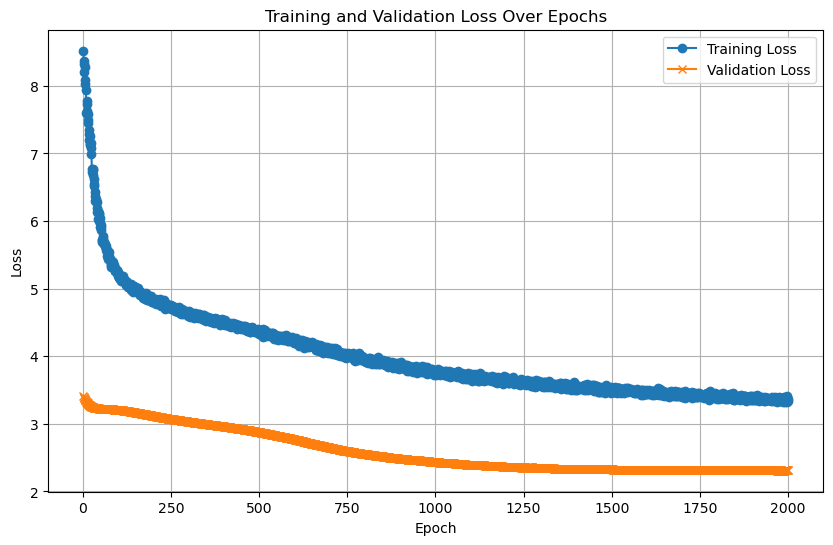

In [36]:
tscl_model = SupConNet().to(device)
tscl_criterion = SupConLoss(temperature=0.07).to(device)
tscl_optimizer = optim.Adam(tscl_model.parameters(), lr=1e-4, weight_decay=1e-5)  # Increased learning rate

tscl_patience = 100
tscl_best_val_loss = float('inf')
tscl_epochs_without_improvement = 0

tscl_num_epochs = 2000
tscl_train_losses = []
tscl_val_losses = []

# TRAINING
for tscl_epoch in range(tscl_num_epochs):
    print(f"\nLOG: Epoch [{tscl_epoch + 1}/{tscl_num_epochs}] - Training")
    tscl_model.train()
    tscl_total_loss = 0

    for batch_idx, (vectors, labels) in enumerate(tscl_train_loader):
        vectors = vectors.to(device).float()  # moving input tensors to GPU
        labels = labels.to(device)  # moving labels to GPU

        # forward pass to get projections
        projections = tscl_model(vectors)

        # calc contrastive loss
        loss = tscl_criterion(projections, labels)

        # backprop and optimization
        tscl_optimizer.zero_grad()
        loss.backward()
        tscl_optimizer.step()

        tscl_total_loss += loss.item()

        if (batch_idx + 1) % 1 == 0:
            print(f"    Batch [{batch_idx + 1}/{len(tscl_train_loader)}], "
                  f"Train Loss: {loss.item():.4f}")

    # calc avg training loss for the epoch
    tscl_avg_train_loss = tscl_total_loss / len(tscl_train_loader)
    tscl_train_losses.append(tscl_avg_train_loss)
    print(f"Epoch [{tscl_epoch + 1}/{tscl_num_epochs}], "
          f"Avg Train Loss: {tscl_avg_train_loss:.4f}")

    # VALIDATION
    tscl_model.eval()
    total_val_loss = 0.0

    with torch.no_grad():
        for batch_idx, (vectors, labels) in enumerate(tscl_val_loader):
            vectors = vectors.to(device).float()
            labels = labels.to(device)

            projections = tscl_model(vectors)

            loss = tscl_criterion(projections, labels)
            total_val_loss += loss.item()

            if (batch_idx + 1) % 10 == 0:
                print(f"    Batch [{batch_idx + 1}/{len(tscl_val_loader)}], "
                      f"Val Loss: {loss.item():.4f}")

    tscl_avg_val_loss = total_val_loss / len(tscl_val_loader)
    tscl_val_losses.append(tscl_avg_val_loss)
    print(f"Epoch [{tscl_epoch + 1}/{tscl_num_epochs}], "
          f"Avg Val Loss: {tscl_avg_val_loss:.4f}")

    # early stopping logic
    if tscl_avg_val_loss < tscl_best_val_loss:
        print(f"Validation loss improved from {tscl_best_val_loss:.4f} to {tscl_avg_val_loss:.4f}. Saving model...")
        tscl_best_val_loss = tscl_avg_val_loss
        tscl_epochs_without_improvement = 0
    else:
        tscl_epochs_without_improvement += 1
        print(f"Validation loss did not improve. Patience: {tscl_epochs_without_improvement}/{tscl_patience}")

    # stopping training if validation loss hasn't improved for patience amount of epochs
    if tscl_epochs_without_improvement >= tscl_patience:
        print(f"Early stopping triggered at epoch {tscl_epoch + 1}. No improvement for {tscl_patience} epochs.")
        break

plt.figure(figsize=(10, 6))
plt.plot(range(1, len(tscl_train_losses) + 1), tscl_train_losses, label="Training Loss", marker='o')
plt.plot(range(1, len(tscl_val_losses) + 1), tscl_val_losses, label="Validation Loss", marker='x')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Over Epochs')
plt.legend()
plt.grid()
plt.show()

Test Batch [10/12], Loss: 5.5426

Test Loss: 5.2879


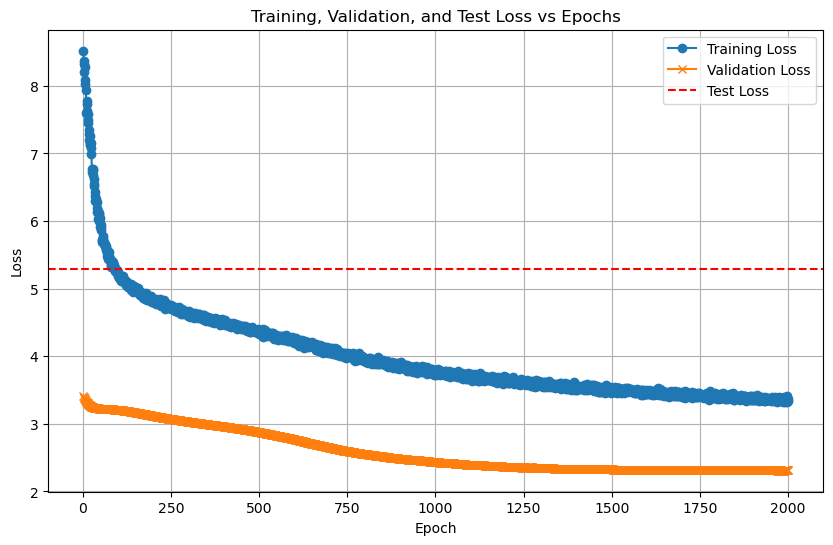

In [37]:
# Test Evaluation
tscl_model.eval()
total_test_loss = 0.0

with torch.no_grad():
    for batch_idx, (vectors, labels) in enumerate(tscl_test_loader):
        vectors = vectors.to(device).float()
        labels = labels.to(device)
        projections = tscl_model(vectors)
        loss = criterion(projections, labels)
        total_test_loss += loss.item()
        if (batch_idx + 1) % 10 == 0:
            print(f"Test Batch [{batch_idx + 1}/{len(tscl_test_loader)}], Loss: {loss.item():.4f}")

avg_test_loss = total_test_loss / len(tscl_test_loader)
print(f"\nTest Loss: {avg_test_loss:.4f}")


plt.figure(figsize=(10, 6))
epochs = range(1, len(tscl_train_losses) + 1)
plt.plot(epochs, tscl_train_losses, label="Training Loss", marker='o')
plt.plot(epochs, tscl_val_losses, label="Validation Loss", marker='x')
# test loss = horizontal dashed line
plt.axhline(y=avg_test_loss, color='r', linestyle='--', label="Test Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training, Validation, and Test Loss vs Epochs")
plt.legend()
plt.grid(True)
plt.show()

### Saving representations learnt by Typical SCL Model

In [38]:
# dir to save the SCL representations
tscl_rep_dir = "tscl_representations"
os.makedirs(tscl_rep_dir, exist_ok=True)

tscl_loaders = {
    'train': tscl_train_loader,
    'val': tscl_val_loader,
    'test': tscl_test_loader
}

tscl_model.eval()

with torch.no_grad():
    for tscl_split_name, tscl_loader in tscl_loaders.items():
        print(f"\nExtracting SCL representations for the {tscl_split_name} dataset...")
        # creating subfolder for the split
        tscl_split_dir = os.path.join(tscl_rep_dir, tscl_split_name)
        os.makedirs(tscl_split_dir, exist_ok=True)
        
        # processing the data batch-wise
        for tscl_batch_idx, (tscl_vectors, tscl_labels) in enumerate(tscl_loader):
            tscl_vectors = tscl_vectors.to(device).float()
            # computing projections using the trained SCL model
            tscl_projections = tscl_model(tscl_vectors)
            
            # converting projections and labels to np arrays
            tscl_projections_np = tscl_projections.cpu().numpy()
            tscl_labels_np = tscl_labels.cpu().numpy()
            
            # saving the batch projections and labels
            np.save(os.path.join(tscl_split_dir, f"scl_encoded_batch_{tscl_batch_idx}.npy"), tscl_projections_np)
            np.save(os.path.join(tscl_split_dir, f"scl_labels_batch_{tscl_batch_idx}.npy"), tscl_labels_np)
            
            if (tscl_batch_idx + 1) % 10 == 0:
                print(f"  Processed batch {tscl_batch_idx + 1}/{len(tscl_loader)} for {tscl_split_name} dataset.")

        print(f"Completed extraction for the {tscl_split_name} dataset. Representations saved in '{tscl_split_dir}'.")

print("SCL representations extraction complete.")


Extracting SCL representations for the train dataset...
Completed extraction for the train dataset. Representations saved in 'tscl_representations\train'.

Extracting SCL representations for the val dataset...
Completed extraction for the val dataset. Representations saved in 'tscl_representations\val'.

Extracting SCL representations for the test dataset...
  Processed batch 10/12 for test dataset.
Completed extraction for the test dataset. Representations saved in 'tscl_representations\test'.
SCL representations extraction complete.


### Classifying representations learnt by SCL Model with LRM

In [39]:
def load_tscl_reps_and_labels(split_dir):
    #gather all the scl_encoded_batch npy files in sorted order
    tscl_rep_files = sorted(glob.glob(os.path.join(split_dir, "scl_encoded_batch_*.npy")))

    tscl_all_reps = []
    tscl_all_labels = []

    for tscl_rep_file in tscl_rep_files:
        #deriving label filenames
        tscl_label_file = tscl_rep_file.replace("scl_encoded_batch_", "scl_labels_batch_")

        tscl_reps = np.load(tscl_rep_file)
        tscl_labels = np.load(tscl_label_file)

        tscl_all_reps.append(tscl_reps)
        tscl_all_labels.append(tscl_labels)

    #concat along first dim
    tscl_all_reps = np.concatenate(tscl_all_reps, axis = 0)
    tscl_all_labels = np.concatenate(tscl_all_labels, axis = 0)

    return tscl_all_reps, tscl_all_labels

In [40]:
tscl_lrm_train_dir = os.path.join("tscl_representations", "train")
tscl_lrm_val_dir   = os.path.join("tscl_representations", "val")
tscl_lrm_test_dir  = os.path.join("tscl_representations", "test")

tscl_lrm_train_reps, tscl_lrm_train_labels = load_tscl_reps_and_labels(tscl_lrm_train_dir)
tscl_lrm_val_reps, tscl_lrm_val_labels = load_tscl_reps_and_labels(tscl_lrm_val_dir)
tscl_lrm_test_reps, tscl_lrm_test_labels = load_tscl_reps_and_labels(tscl_lrm_test_dir)

print("Train reps shape:", tscl_lrm_train_reps.shape)
print("Train labels shape:", tscl_lrm_train_labels.shape)

print("Val reps shape:", tscl_lrm_val_reps.shape)
print("Val labels shape:", tscl_lrm_val_labels.shape)

print("Test reps shape:", tscl_lrm_test_reps.shape)
print("Test labels shape:", tscl_lrm_test_labels.shape)

Train reps shape: (280, 128)
Train labels shape: (280,)
Val reps shape: (70, 128)
Val labels shape: (70,)
Test reps shape: (2898, 128)
Test labels shape: (2898,)


In [41]:
# training LRM on the tscl representations
print("\nLOG: Training Logistic Regression model on SCL SDL representations...")
tscl_logistic_clf = LogisticRegression(max_iter=5000, random_state=42, class_weight='balanced')
tscl_logistic_clf.fit(tscl_lrm_train_reps, tscl_lrm_train_labels)
print("LOG: Logistic Regression training complete.")

# eval on val set
print("\nLOG: Evaluating on the validation set...")
tscl_lrm_val_predictions = tscl_logistic_clf.predict(tscl_lrm_val_reps)
tscl_lrm_val_accuracy = accuracy_score(tscl_lrm_val_labels, tscl_lrm_val_predictions)
print(f"Validation Accuracy: {tscl_lrm_val_accuracy * 100:.2f}%")
print("\nValidation Classification Report:\n", classification_report(tscl_lrm_val_labels, tscl_lrm_val_predictions))

# eval on test
print("\nLOG: Evaluating on the test set...")
tscl_lrm_test_predictions = tscl_logistic_clf.predict(tscl_lrm_test_reps)
tscl_lrm_test_accuracy = accuracy_score(tscl_lrm_test_labels, tscl_lrm_test_predictions)
print(f"Test Accuracy: {tscl_lrm_test_accuracy * 100:.2f}%")
print("\nTest Classification Report:\n", classification_report(tscl_lrm_test_labels, tscl_lrm_test_predictions))

np.save(os.path.join(predictions_dir, 'tscl_lrm_predictions.npy'), tscl_lrm_test_predictions)
np.save(os.path.join(predictions_dir, 'tscl_lrm_true_labels.npy'), tscl_lrm_test_labels)
print(f"Saved CAE+LRM predictions and true labels to {predictions_dir}")


LOG: Training Logistic Regression model on SCL SDL representations...
LOG: Logistic Regression training complete.

LOG: Evaluating on the validation set...
Validation Accuracy: 84.29%

Validation Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         5
           1       0.83      1.00      0.91         5
           2       0.71      1.00      0.83         5
           3       1.00      0.80      0.89         5
           4       1.00      0.20      0.33         5
           5       0.33      0.40      0.36         5
           6       1.00      1.00      1.00         5
           7       1.00      1.00      1.00         5
           8       0.50      0.60      0.55         5
           9       0.83      1.00      0.91         5
          10       1.00      1.00      1.00         5
          11       1.00      1.00      1.00         5
          12       1.00      0.80      0.89         5
          13       1.0

### Classifying the representations learnt by Typical SCL Model with MLP Classifier

In [42]:
class MLPClassifier(nn.Module):
    def __init__(self, input_dim, num_classes):
        super(MLPClassifier, self).__init__()
        self.fc1 = nn.Linear(input_dim, 64)
        self.fc2 = nn.Linear(64, 64)
        self.fc3 = nn.Linear(64, 32)
        self.fc4 = nn.Linear(32, num_classes)
        
        self._init_weights()
    
    def _init_weights(self):
        for m in self.modules(): 
            if isinstance(m, nn.Linear):
                nn.init.xavier_uniform_(m.weight)
                nn.init.constant_(m.bias, 0)
    
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        return self.fc4(x)

In [43]:
tscl_mlp_train_dir = os.path.join("tscl_representations", "train")
tscl_mlp_val_dir   = os.path.join("tscl_representations", "val")
tscl_mlp_test_dir  = os.path.join("tscl_representations", "test")

tscl_mlp_train_reps, tscl_mlp_train_labels = load_tscl_reps_and_labels(tscl_mlp_train_dir)
tscl_mlp_val_reps, tscl_mlp_val_labels = load_tscl_reps_and_labels(tscl_mlp_val_dir)
tscl_mlp_test_reps, tscl_mlp_test_labels = load_tscl_reps_and_labels(tscl_mlp_test_dir)

print("Train reps shape:",tscl_mlp_train_reps.shape)
print("Train labels shape:", tscl_mlp_train_labels.shape)

print("Val reps shape:", tscl_mlp_val_reps.shape)
print("Val labels shape:", tscl_mlp_val_labels.shape)

print("Test reps shape:", tscl_mlp_test_reps.shape)
print("Test labels shape:", tscl_mlp_test_labels.shape)

Train reps shape: (280, 128)
Train labels shape: (280,)
Val reps shape: (70, 128)
Val labels shape: (70,)
Test reps shape: (2898, 128)
Test labels shape: (2898,)


In [44]:
#converting arrays to torch tensors
tscl_mlp_train_embeddings_torch = torch.tensor(tscl_mlp_train_reps, dtype=torch.float32)
tscl_mlp_train_labels_torch = torch.tensor(tscl_mlp_train_labels, dtype=torch.long)

tscl_mlp_val_embeddings_torch = torch.tensor(tscl_mlp_val_reps, dtype=torch.float32)
tscl_mlp_val_labels_torch = torch.tensor(tscl_mlp_val_labels, dtype=torch.long)

tscl_mlp_test_embeddings_torch = torch.tensor(tscl_mlp_test_reps, dtype=torch.float32)
tscl_mlp_test_labels_torch = torch.tensor(tscl_mlp_test_labels, dtype=torch.long)

#building datasets for mlp
tscl_mlp_train_dataset = TensorDataset(tscl_mlp_train_embeddings_torch, tscl_mlp_train_labels_torch)
tscl_mlp_val_dataset = TensorDataset(tscl_mlp_val_embeddings_torch, tscl_mlp_val_labels_torch)
tscl_mlp_test_dataset = TensorDataset(tscl_mlp_test_embeddings_torch, tscl_mlp_test_labels_torch)

tscl_mlp_batch_size = 64
tscl_mlp_train_loader = DataLoader(tscl_mlp_train_dataset, batch_size=tscl_mlp_batch_size, shuffle=True)
tscl_mlp_val_loader = DataLoader(tscl_mlp_val_dataset, batch_size=tscl_mlp_batch_size, shuffle=False)
tscl_mlp_test_loader = DataLoader(tscl_mlp_test_dataset, batch_size=tscl_mlp_batch_size, shuffle=False)


[Epoch 1/1000] Train Loss: 2.7026  |  Val Loss: 2.6603
Validation loss improved from inf to 2.6603.
[Epoch 2/1000] Train Loss: 2.6624  |  Val Loss: 2.6244
Validation loss improved from 2.6603 to 2.6244.
[Epoch 3/1000] Train Loss: 2.6221  |  Val Loss: 2.5926
Validation loss improved from 2.6244 to 2.5926.
[Epoch 4/1000] Train Loss: 2.5895  |  Val Loss: 2.5668
Validation loss improved from 2.5926 to 2.5668.
[Epoch 5/1000] Train Loss: 2.5613  |  Val Loss: 2.5434
Validation loss improved from 2.5668 to 2.5434.
[Epoch 6/1000] Train Loss: 2.5363  |  Val Loss: 2.5219
Validation loss improved from 2.5434 to 2.5219.
[Epoch 7/1000] Train Loss: 2.5125  |  Val Loss: 2.5020
Validation loss improved from 2.5219 to 2.5020.
[Epoch 8/1000] Train Loss: 2.4904  |  Val Loss: 2.4815
Validation loss improved from 2.5020 to 2.4815.
[Epoch 9/1000] Train Loss: 2.4677  |  Val Loss: 2.4614
Validation loss improved from 2.4815 to 2.4614.
[Epoch 10/1000] Train Loss: 2.4447  |  Val Loss: 2.4412
Validation loss impr

[Epoch 11/1000] Train Loss: 2.4220  |  Val Loss: 2.4216
Validation loss improved from 2.4412 to 2.4216.
[Epoch 12/1000] Train Loss: 2.4012  |  Val Loss: 2.4023
Validation loss improved from 2.4216 to 2.4023.
[Epoch 13/1000] Train Loss: 2.3794  |  Val Loss: 2.3831
Validation loss improved from 2.4023 to 2.3831.
[Epoch 14/1000] Train Loss: 2.3591  |  Val Loss: 2.3637
Validation loss improved from 2.3831 to 2.3637.
[Epoch 15/1000] Train Loss: 2.3388  |  Val Loss: 2.3441
Validation loss improved from 2.3637 to 2.3441.
[Epoch 16/1000] Train Loss: 2.3178  |  Val Loss: 2.3253
Validation loss improved from 2.3441 to 2.3253.
[Epoch 17/1000] Train Loss: 2.2978  |  Val Loss: 2.3065
Validation loss improved from 2.3253 to 2.3065.
[Epoch 18/1000] Train Loss: 2.2777  |  Val Loss: 2.2875
Validation loss improved from 2.3065 to 2.2875.


[Epoch 19/1000] Train Loss: 2.2571  |  Val Loss: 2.2692
Validation loss improved from 2.2875 to 2.2692.
[Epoch 20/1000] Train Loss: 2.2366  |  Val Loss: 2.2511
Validation loss improved from 2.2692 to 2.2511.
[Epoch 21/1000] Train Loss: 2.2163  |  Val Loss: 2.2329
Validation loss improved from 2.2511 to 2.2329.
[Epoch 22/1000] Train Loss: 2.1965  |  Val Loss: 2.2145
Validation loss improved from 2.2329 to 2.2145.
[Epoch 23/1000] Train Loss: 2.1761  |  Val Loss: 2.1961
Validation loss improved from 2.2145 to 2.1961.
[Epoch 24/1000] Train Loss: 2.1559  |  Val Loss: 2.1769
Validation loss improved from 2.1961 to 2.1769.
[Epoch 25/1000] Train Loss: 2.1353  |  Val Loss: 2.1578
Validation loss improved from 2.1769 to 2.1578.
[Epoch 26/1000] Train Loss: 2.1141  |  Val Loss: 2.1389
Validation loss improved from 2.1578 to 2.1389.
[Epoch 27/1000] Train Loss: 2.0934  |  Val Loss: 2.1199
Validation loss improved from 2.1389 to 2.1199.
[Epoch 28/1000] Train Loss: 2.0720  |  Val Loss: 2.1008
Validati

[Epoch 29/1000] Train Loss: 2.0517  |  Val Loss: 2.0815
Validation loss improved from 2.1008 to 2.0815.
[Epoch 30/1000] Train Loss: 2.0299  |  Val Loss: 2.0628
Validation loss improved from 2.0815 to 2.0628.
[Epoch 31/1000] Train Loss: 2.0093  |  Val Loss: 2.0434
Validation loss improved from 2.0628 to 2.0434.
[Epoch 32/1000] Train Loss: 1.9880  |  Val Loss: 2.0241
Validation loss improved from 2.0434 to 2.0241.
[Epoch 33/1000] Train Loss: 1.9671  |  Val Loss: 2.0049
Validation loss improved from 2.0241 to 2.0049.
[Epoch 34/1000] Train Loss: 1.9457  |  Val Loss: 1.9863
Validation loss improved from 2.0049 to 1.9863.
[Epoch 35/1000] Train Loss: 1.9242  |  Val Loss: 1.9676
Validation loss improved from 1.9863 to 1.9676.


[Epoch 36/1000] Train Loss: 1.9033  |  Val Loss: 1.9484
Validation loss improved from 1.9676 to 1.9484.
[Epoch 37/1000] Train Loss: 1.8819  |  Val Loss: 1.9291
Validation loss improved from 1.9484 to 1.9291.
[Epoch 38/1000] Train Loss: 1.8612  |  Val Loss: 1.9094
Validation loss improved from 1.9291 to 1.9094.
[Epoch 39/1000] Train Loss: 1.8400  |  Val Loss: 1.8897
Validation loss improved from 1.9094 to 1.8897.
[Epoch 40/1000] Train Loss: 1.8188  |  Val Loss: 1.8703
Validation loss improved from 1.8897 to 1.8703.
[Epoch 41/1000] Train Loss: 1.7976  |  Val Loss: 1.8511
Validation loss improved from 1.8703 to 1.8511.
[Epoch 42/1000] Train Loss: 1.7761  |  Val Loss: 1.8317
Validation loss improved from 1.8511 to 1.8317.
[Epoch 43/1000] Train Loss: 1.7547  |  Val Loss: 1.8121
Validation loss improved from 1.8317 to 1.8121.
[Epoch 44/1000] Train Loss: 1.7340  |  Val Loss: 1.7927
Validation loss improved from 1.8121 to 1.7927.
[Epoch 45/1000] Train Loss: 1.7126  |  Val Loss: 1.7731
Validati

[Epoch 49/1000] Train Loss: 1.6268  |  Val Loss: 1.6946
Validation loss improved from 1.7145 to 1.6946.
[Epoch 50/1000] Train Loss: 1.6052  |  Val Loss: 1.6746
Validation loss improved from 1.6946 to 1.6746.
[Epoch 51/1000] Train Loss: 1.5832  |  Val Loss: 1.6546
Validation loss improved from 1.6746 to 1.6546.
[Epoch 52/1000] Train Loss: 1.5607  |  Val Loss: 1.6347
Validation loss improved from 1.6546 to 1.6347.
[Epoch 53/1000] Train Loss: 1.5392  |  Val Loss: 1.6146
Validation loss improved from 1.6347 to 1.6146.
[Epoch 54/1000] Train Loss: 1.5177  |  Val Loss: 1.5946
Validation loss improved from 1.6146 to 1.5946.
[Epoch 55/1000] Train Loss: 1.4961  |  Val Loss: 1.5749
Validation loss improved from 1.5946 to 1.5749.


[Epoch 56/1000] Train Loss: 1.4749  |  Val Loss: 1.5553
Validation loss improved from 1.5749 to 1.5553.
[Epoch 57/1000] Train Loss: 1.4536  |  Val Loss: 1.5358
Validation loss improved from 1.5553 to 1.5358.
[Epoch 58/1000] Train Loss: 1.4328  |  Val Loss: 1.5164
Validation loss improved from 1.5358 to 1.5164.
[Epoch 59/1000] Train Loss: 1.4120  |  Val Loss: 1.4971
Validation loss improved from 1.5164 to 1.4971.
[Epoch 60/1000] Train Loss: 1.3916  |  Val Loss: 1.4777
Validation loss improved from 1.4971 to 1.4777.
[Epoch 61/1000] Train Loss: 1.3709  |  Val Loss: 1.4588
Validation loss improved from 1.4777 to 1.4588.
[Epoch 62/1000] Train Loss: 1.3504  |  Val Loss: 1.4396
Validation loss improved from 1.4588 to 1.4396.
[Epoch 63/1000] Train Loss: 1.3299  |  Val Loss: 1.4204
Validation loss improved from 1.4396 to 1.4204.
[Epoch 64/1000] Train Loss: 1.3092  |  Val Loss: 1.4020
Validation loss improved from 1.4204 to 1.4020.
[Epoch 65/1000] Train Loss: 1.2888  |  Val Loss: 1.3836
Validati

[Epoch 69/1000] Train Loss: 1.2099  |  Val Loss: 1.3116
Validation loss improved from 1.3294 to 1.3116.
[Epoch 70/1000] Train Loss: 1.1900  |  Val Loss: 1.2942
Validation loss improved from 1.3116 to 1.2942.
[Epoch 71/1000] Train Loss: 1.1705  |  Val Loss: 1.2771
Validation loss improved from 1.2942 to 1.2771.
[Epoch 72/1000] Train Loss: 1.1512  |  Val Loss: 1.2604
Validation loss improved from 1.2771 to 1.2604.
[Epoch 73/1000] Train Loss: 1.1329  |  Val Loss: 1.2436
Validation loss improved from 1.2604 to 1.2436.
[Epoch 74/1000] Train Loss: 1.1136  |  Val Loss: 1.2272
Validation loss improved from 1.2436 to 1.2272.


[Epoch 75/1000] Train Loss: 1.0949  |  Val Loss: 1.2109
Validation loss improved from 1.2272 to 1.2109.
[Epoch 76/1000] Train Loss: 1.0763  |  Val Loss: 1.1949
Validation loss improved from 1.2109 to 1.1949.
[Epoch 77/1000] Train Loss: 1.0579  |  Val Loss: 1.1792
Validation loss improved from 1.1949 to 1.1792.
[Epoch 78/1000] Train Loss: 1.0399  |  Val Loss: 1.1633
Validation loss improved from 1.1792 to 1.1633.
[Epoch 79/1000] Train Loss: 1.0220  |  Val Loss: 1.1475
Validation loss improved from 1.1633 to 1.1475.
[Epoch 80/1000] Train Loss: 1.0044  |  Val Loss: 1.1319
Validation loss improved from 1.1475 to 1.1319.
[Epoch 81/1000] Train Loss: 0.9871  |  Val Loss: 1.1169
Validation loss improved from 1.1319 to 1.1169.
[Epoch 82/1000] Train Loss: 0.9700  |  Val Loss: 1.1023
Validation loss improved from 1.1169 to 1.1023.
[Epoch 83/1000] Train Loss: 0.9528  |  Val Loss: 1.0879
Validation loss improved from 1.1023 to 1.0879.
[Epoch 84/1000] Train Loss: 0.9362  |  Val Loss: 1.0738
Validati

[Epoch 88/1000] Train Loss: 0.8714  |  Val Loss: 1.0182
Validation loss improved from 1.0317 to 1.0182.
[Epoch 89/1000] Train Loss: 0.8557  |  Val Loss: 1.0055
Validation loss improved from 1.0182 to 1.0055.
[Epoch 90/1000] Train Loss: 0.8404  |  Val Loss: 0.9927
Validation loss improved from 1.0055 to 0.9927.
[Epoch 91/1000] Train Loss: 0.8254  |  Val Loss: 0.9800
Validation loss improved from 0.9927 to 0.9800.
[Epoch 92/1000] Train Loss: 0.8102  |  Val Loss: 0.9677
Validation loss improved from 0.9800 to 0.9677.
[Epoch 93/1000] Train Loss: 0.7952  |  Val Loss: 0.9556
Validation loss improved from 0.9677 to 0.9556.
[Epoch 94/1000] Train Loss: 0.7808  |  Val Loss: 0.9433
Validation loss improved from 0.9556 to 0.9433.


[Epoch 95/1000] Train Loss: 0.7664  |  Val Loss: 0.9313
Validation loss improved from 0.9433 to 0.9313.
[Epoch 96/1000] Train Loss: 0.7525  |  Val Loss: 0.9195
Validation loss improved from 0.9313 to 0.9195.
[Epoch 97/1000] Train Loss: 0.7389  |  Val Loss: 0.9071
Validation loss improved from 0.9195 to 0.9071.
[Epoch 98/1000] Train Loss: 0.7249  |  Val Loss: 0.8943
Validation loss improved from 0.9071 to 0.8943.
[Epoch 99/1000] Train Loss: 0.7114  |  Val Loss: 0.8823
Validation loss improved from 0.8943 to 0.8823.
[Epoch 100/1000] Train Loss: 0.6981  |  Val Loss: 0.8717
Validation loss improved from 0.8823 to 0.8717.
[Epoch 101/1000] Train Loss: 0.6852  |  Val Loss: 0.8611
Validation loss improved from 0.8717 to 0.8611.
[Epoch 102/1000] Train Loss: 0.6724  |  Val Loss: 0.8512
Validation loss improved from 0.8611 to 0.8512.
[Epoch 103/1000] Train Loss: 0.6597  |  Val Loss: 0.8406
Validation loss improved from 0.8512 to 0.8406.
[Epoch 104/1000] Train Loss: 0.6469  |  Val Loss: 0.8305
Val

[Epoch 107/1000] Train Loss: 0.6103  |  Val Loss: 0.7991
Validation loss improved from 0.8094 to 0.7991.
[Epoch 108/1000] Train Loss: 0.5983  |  Val Loss: 0.7888
Validation loss improved from 0.7991 to 0.7888.
[Epoch 109/1000] Train Loss: 0.5866  |  Val Loss: 0.7799
Validation loss improved from 0.7888 to 0.7799.
[Epoch 110/1000] Train Loss: 0.5748  |  Val Loss: 0.7704
Validation loss improved from 0.7799 to 0.7704.
[Epoch 111/1000] Train Loss: 0.5634  |  Val Loss: 0.7611
Validation loss improved from 0.7704 to 0.7611.
[Epoch 112/1000] Train Loss: 0.5522  |  Val Loss: 0.7517
Validation loss improved from 0.7611 to 0.7517.
[Epoch 113/1000] Train Loss: 0.5413  |  Val Loss: 0.7424
Validation loss improved from 0.7517 to 0.7424.


[Epoch 114/1000] Train Loss: 0.5305  |  Val Loss: 0.7326
Validation loss improved from 0.7424 to 0.7326.
[Epoch 115/1000] Train Loss: 0.5194  |  Val Loss: 0.7240
Validation loss improved from 0.7326 to 0.7240.
[Epoch 116/1000] Train Loss: 0.5090  |  Val Loss: 0.7149
Validation loss improved from 0.7240 to 0.7149.
[Epoch 117/1000] Train Loss: 0.4988  |  Val Loss: 0.7061
Validation loss improved from 0.7149 to 0.7061.
[Epoch 118/1000] Train Loss: 0.4883  |  Val Loss: 0.6982
Validation loss improved from 0.7061 to 0.6982.
[Epoch 119/1000] Train Loss: 0.4781  |  Val Loss: 0.6911
Validation loss improved from 0.6982 to 0.6911.
[Epoch 120/1000] Train Loss: 0.4684  |  Val Loss: 0.6848
Validation loss improved from 0.6911 to 0.6848.
[Epoch 121/1000] Train Loss: 0.4588  |  Val Loss: 0.6775
Validation loss improved from 0.6848 to 0.6775.
[Epoch 122/1000] Train Loss: 0.4493  |  Val Loss: 0.6702
Validation loss improved from 0.6775 to 0.6702.
[Epoch 123/1000] Train Loss: 0.4401  |  Val Loss: 0.662

[Epoch 127/1000] Train Loss: 0.4041  |  Val Loss: 0.6328
Validation loss improved from 0.6404 to 0.6328.
[Epoch 128/1000] Train Loss: 0.3953  |  Val Loss: 0.6251
Validation loss improved from 0.6328 to 0.6251.
[Epoch 129/1000] Train Loss: 0.3866  |  Val Loss: 0.6177
Validation loss improved from 0.6251 to 0.6177.
[Epoch 130/1000] Train Loss: 0.3783  |  Val Loss: 0.6107
Validation loss improved from 0.6177 to 0.6107.
[Epoch 131/1000] Train Loss: 0.3700  |  Val Loss: 0.6032
Validation loss improved from 0.6107 to 0.6032.
[Epoch 132/1000] Train Loss: 0.3625  |  Val Loss: 0.5959
Validation loss improved from 0.6032 to 0.5959.
[Epoch 133/1000] Train Loss: 0.3548  |  Val Loss: 0.5896
Validation loss improved from 0.5959 to 0.5896.
[Epoch 134/1000] Train Loss: 0.3472  |  Val Loss: 0.5830
Validation loss improved from 0.5896 to 0.5830.


[Epoch 135/1000] Train Loss: 0.3401  |  Val Loss: 0.5781
Validation loss improved from 0.5830 to 0.5781.
[Epoch 136/1000] Train Loss: 0.3328  |  Val Loss: 0.5729
Validation loss improved from 0.5781 to 0.5729.
[Epoch 137/1000] Train Loss: 0.3260  |  Val Loss: 0.5681
Validation loss improved from 0.5729 to 0.5681.
[Epoch 138/1000] Train Loss: 0.3189  |  Val Loss: 0.5627
Validation loss improved from 0.5681 to 0.5627.
[Epoch 139/1000] Train Loss: 0.3123  |  Val Loss: 0.5576
Validation loss improved from 0.5627 to 0.5576.
[Epoch 140/1000] Train Loss: 0.3058  |  Val Loss: 0.5523
Validation loss improved from 0.5576 to 0.5523.
[Epoch 141/1000] Train Loss: 0.2995  |  Val Loss: 0.5482
Validation loss improved from 0.5523 to 0.5482.
[Epoch 142/1000] Train Loss: 0.2932  |  Val Loss: 0.5443
Validation loss improved from 0.5482 to 0.5443.
[Epoch 143/1000] Train Loss: 0.2871  |  Val Loss: 0.5403
Validation loss improved from 0.5443 to 0.5403.


[Epoch 144/1000] Train Loss: 0.2811  |  Val Loss: 0.5358
Validation loss improved from 0.5403 to 0.5358.
[Epoch 145/1000] Train Loss: 0.2753  |  Val Loss: 0.5303
Validation loss improved from 0.5358 to 0.5303.
[Epoch 146/1000] Train Loss: 0.2695  |  Val Loss: 0.5247
Validation loss improved from 0.5303 to 0.5247.
[Epoch 147/1000] Train Loss: 0.2637  |  Val Loss: 0.5205
Validation loss improved from 0.5247 to 0.5205.
[Epoch 148/1000] Train Loss: 0.2581  |  Val Loss: 0.5161
Validation loss improved from 0.5205 to 0.5161.
[Epoch 149/1000] Train Loss: 0.2527  |  Val Loss: 0.5120
Validation loss improved from 0.5161 to 0.5120.
[Epoch 150/1000] Train Loss: 0.2474  |  Val Loss: 0.5076
Validation loss improved from 0.5120 to 0.5076.
[Epoch 151/1000] Train Loss: 0.2421  |  Val Loss: 0.5033
Validation loss improved from 0.5076 to 0.5033.
[Epoch 152/1000] Train Loss: 0.2370  |  Val Loss: 0.4985
Validation loss improved from 0.5033 to 0.4985.
[Epoch 153/1000] Train Loss: 0.2318  |  Val Loss: 0.494

[Epoch 156/1000] Train Loss: 0.2173  |  Val Loss: 0.4823
Validation loss improved from 0.4865 to 0.4823.
[Epoch 157/1000] Train Loss: 0.2126  |  Val Loss: 0.4792
Validation loss improved from 0.4823 to 0.4792.
[Epoch 158/1000] Train Loss: 0.2081  |  Val Loss: 0.4761
Validation loss improved from 0.4792 to 0.4761.
[Epoch 159/1000] Train Loss: 0.2037  |  Val Loss: 0.4738
Validation loss improved from 0.4761 to 0.4738.
[Epoch 160/1000] Train Loss: 0.1995  |  Val Loss: 0.4705
Validation loss improved from 0.4738 to 0.4705.
[Epoch 161/1000] Train Loss: 0.1953  |  Val Loss: 0.4677
Validation loss improved from 0.4705 to 0.4677.
[Epoch 162/1000] Train Loss: 0.1912  |  Val Loss: 0.4649
Validation loss improved from 0.4677 to 0.4649.
[Epoch 163/1000] Train Loss: 0.1874  |  Val Loss: 0.4620
Validation loss improved from 0.4649 to 0.4620.


[Epoch 164/1000] Train Loss: 0.1836  |  Val Loss: 0.4581
Validation loss improved from 0.4620 to 0.4581.
[Epoch 165/1000] Train Loss: 0.1798  |  Val Loss: 0.4551
Validation loss improved from 0.4581 to 0.4551.
[Epoch 166/1000] Train Loss: 0.1763  |  Val Loss: 0.4522
Validation loss improved from 0.4551 to 0.4522.
[Epoch 167/1000] Train Loss: 0.1727  |  Val Loss: 0.4504
Validation loss improved from 0.4522 to 0.4504.
[Epoch 168/1000] Train Loss: 0.1691  |  Val Loss: 0.4479
Validation loss improved from 0.4504 to 0.4479.
[Epoch 169/1000] Train Loss: 0.1658  |  Val Loss: 0.4461
Validation loss improved from 0.4479 to 0.4461.
[Epoch 170/1000] Train Loss: 0.1625  |  Val Loss: 0.4437
Validation loss improved from 0.4461 to 0.4437.
[Epoch 171/1000] Train Loss: 0.1592  |  Val Loss: 0.4418
Validation loss improved from 0.4437 to 0.4418.
[Epoch 172/1000] Train Loss: 0.1562  |  Val Loss: 0.4398
Validation loss improved from 0.4418 to 0.4398.
[Epoch 173/1000] Train Loss: 0.1532  |  Val Loss: 0.436

[Epoch 175/1000] Train Loss: 0.1474  |  Val Loss: 0.4313
Validation loss improved from 0.4338 to 0.4313.
[Epoch 176/1000] Train Loss: 0.1446  |  Val Loss: 0.4290
Validation loss improved from 0.4313 to 0.4290.
[Epoch 177/1000] Train Loss: 0.1419  |  Val Loss: 0.4267
Validation loss improved from 0.4290 to 0.4267.
[Epoch 178/1000] Train Loss: 0.1393  |  Val Loss: 0.4250
Validation loss improved from 0.4267 to 0.4250.
[Epoch 179/1000] Train Loss: 0.1367  |  Val Loss: 0.4234
Validation loss improved from 0.4250 to 0.4234.
[Epoch 180/1000] Train Loss: 0.1341  |  Val Loss: 0.4221
Validation loss improved from 0.4234 to 0.4221.
[Epoch 181/1000] Train Loss: 0.1317  |  Val Loss: 0.4211
Validation loss improved from 0.4221 to 0.4211.
[Epoch 182/1000] Train Loss: 0.1292  |  Val Loss: 0.4204
Validation loss improved from 0.4211 to 0.4204.
[Epoch 183/1000] Train Loss: 0.1270  |  Val Loss: 0.4201
Validation loss improved from 0.4204 to 0.4201.


[Epoch 184/1000] Train Loss: 0.1245  |  Val Loss: 0.4187
Validation loss improved from 0.4201 to 0.4187.
[Epoch 185/1000] Train Loss: 0.1223  |  Val Loss: 0.4175
Validation loss improved from 0.4187 to 0.4175.
[Epoch 186/1000] Train Loss: 0.1202  |  Val Loss: 0.4153
Validation loss improved from 0.4175 to 0.4153.
[Epoch 187/1000] Train Loss: 0.1181  |  Val Loss: 0.4126
Validation loss improved from 0.4153 to 0.4126.
[Epoch 188/1000] Train Loss: 0.1161  |  Val Loss: 0.4110
Validation loss improved from 0.4126 to 0.4110.
[Epoch 189/1000] Train Loss: 0.1139  |  Val Loss: 0.4095
Validation loss improved from 0.4110 to 0.4095.
[Epoch 190/1000] Train Loss: 0.1120  |  Val Loss: 0.4087
Validation loss improved from 0.4095 to 0.4087.
[Epoch 191/1000] Train Loss: 0.1100  |  Val Loss: 0.4070
Validation loss improved from 0.4087 to 0.4070.
[Epoch 192/1000] Train Loss: 0.1082  |  Val Loss: 0.4060
Validation loss improved from 0.4070 to 0.4060.
[Epoch 193/1000] Train Loss: 0.1064  |  Val Loss: 0.404

[Epoch 195/1000] Train Loss: 0.1029  |  Val Loss: 0.4042
Validation loss improved from 0.4046 to 0.4042.
[Epoch 196/1000] Train Loss: 0.1013  |  Val Loss: 0.4032
Validation loss improved from 0.4042 to 0.4032.
[Epoch 197/1000] Train Loss: 0.0996  |  Val Loss: 0.4027
Validation loss improved from 0.4032 to 0.4027.
[Epoch 198/1000] Train Loss: 0.0980  |  Val Loss: 0.4013
Validation loss improved from 0.4027 to 0.4013.
[Epoch 199/1000] Train Loss: 0.0965  |  Val Loss: 0.3998
Validation loss improved from 0.4013 to 0.3998.
[Epoch 200/1000] Train Loss: 0.0950  |  Val Loss: 0.3992
Validation loss improved from 0.3998 to 0.3992.
[Epoch 201/1000] Train Loss: 0.0934  |  Val Loss: 0.3980
Validation loss improved from 0.3992 to 0.3980.
[Epoch 202/1000] Train Loss: 0.0919  |  Val Loss: 0.3972
Validation loss improved from 0.3980 to 0.3972.


[Epoch 203/1000] Train Loss: 0.0904  |  Val Loss: 0.3949
Validation loss improved from 0.3972 to 0.3949.
[Epoch 204/1000] Train Loss: 0.0890  |  Val Loss: 0.3939
Validation loss improved from 0.3949 to 0.3939.
[Epoch 205/1000] Train Loss: 0.0876  |  Val Loss: 0.3926
Validation loss improved from 0.3939 to 0.3926.
[Epoch 206/1000] Train Loss: 0.0864  |  Val Loss: 0.3917
Validation loss improved from 0.3926 to 0.3917.
[Epoch 207/1000] Train Loss: 0.0850  |  Val Loss: 0.3901
Validation loss improved from 0.3917 to 0.3901.
[Epoch 208/1000] Train Loss: 0.0837  |  Val Loss: 0.3890
Validation loss improved from 0.3901 to 0.3890.
[Epoch 209/1000] Train Loss: 0.0825  |  Val Loss: 0.3884
Validation loss improved from 0.3890 to 0.3884.
[Epoch 210/1000] Train Loss: 0.0812  |  Val Loss: 0.3881
Validation loss improved from 0.3884 to 0.3881.
[Epoch 211/1000] Train Loss: 0.0800  |  Val Loss: 0.3872
Validation loss improved from 0.3881 to 0.3872.
[Epoch 212/1000] Train Loss: 0.0788  |  Val Loss: 0.386

[Epoch 213/1000] Train Loss: 0.0777  |  Val Loss: 0.3862
Validation loss improved from 0.3868 to 0.3862.
[Epoch 214/1000] Train Loss: 0.0766  |  Val Loss: 0.3862
Validation loss improved from 0.3862 to 0.3862.
[Epoch 215/1000] Train Loss: 0.0754  |  Val Loss: 0.3853
Validation loss improved from 0.3862 to 0.3853.
[Epoch 216/1000] Train Loss: 0.0743  |  Val Loss: 0.3847
Validation loss improved from 0.3853 to 0.3847.
[Epoch 217/1000] Train Loss: 0.0733  |  Val Loss: 0.3835
Validation loss improved from 0.3847 to 0.3835.
[Epoch 218/1000] Train Loss: 0.0722  |  Val Loss: 0.3816
Validation loss improved from 0.3835 to 0.3816.
[Epoch 219/1000] Train Loss: 0.0712  |  Val Loss: 0.3803
Validation loss improved from 0.3816 to 0.3803.
[Epoch 220/1000] Train Loss: 0.0702  |  Val Loss: 0.3802
Validation loss improved from 0.3803 to 0.3802.
[Epoch 221/1000] Train Loss: 0.0692  |  Val Loss: 0.3803
!! Validation loss did NOT improve !! Patience: 1/100


[Epoch 222/1000] Train Loss: 0.0683  |  Val Loss: 0.3805
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 223/1000] Train Loss: 0.0674  |  Val Loss: 0.3806
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 224/1000] Train Loss: 0.0664  |  Val Loss: 0.3807
!! Validation loss did NOT improve !! Patience: 4/100
[Epoch 225/1000] Train Loss: 0.0655  |  Val Loss: 0.3801
Validation loss improved from 0.3802 to 0.3801.
[Epoch 226/1000] Train Loss: 0.0647  |  Val Loss: 0.3805
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 227/1000] Train Loss: 0.0638  |  Val Loss: 0.3802
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 228/1000] Train Loss: 0.0629  |  Val Loss: 0.3804
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 229/1000] Train Loss: 0.0621  |  Val Loss: 0.3787
Validation loss improved from 0.3801 to 0.3787.
[Epoch 230/1000] Train Loss: 0.0612  |  Val Loss: 0.3786
Validation loss improved from 0.3787 to 0.3786.
[Epoch 231/1000] Tr

[Epoch 232/1000] Train Loss: 0.0597  |  Val Loss: 0.3755
Validation loss improved from 0.3769 to 0.3755.
[Epoch 233/1000] Train Loss: 0.0589  |  Val Loss: 0.3753
Validation loss improved from 0.3755 to 0.3753.
[Epoch 234/1000] Train Loss: 0.0582  |  Val Loss: 0.3742
Validation loss improved from 0.3753 to 0.3742.
[Epoch 235/1000] Train Loss: 0.0575  |  Val Loss: 0.3732
Validation loss improved from 0.3742 to 0.3732.
[Epoch 236/1000] Train Loss: 0.0567  |  Val Loss: 0.3728
Validation loss improved from 0.3732 to 0.3728.
[Epoch 237/1000] Train Loss: 0.0560  |  Val Loss: 0.3727
Validation loss improved from 0.3728 to 0.3727.
[Epoch 238/1000] Train Loss: 0.0553  |  Val Loss: 0.3729
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 239/1000] Train Loss: 0.0546  |  Val Loss: 0.3715
Validation loss improved from 0.3727 to 0.3715.
[Epoch 240/1000] Train Loss: 0.0539  |  Val Loss: 0.3712
Validation loss improved from 0.3715 to 0.3712.


[Epoch 241/1000] Train Loss: 0.0533  |  Val Loss: 0.3714
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 242/1000] Train Loss: 0.0526  |  Val Loss: 0.3712
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 243/1000] Train Loss: 0.0520  |  Val Loss: 0.3717
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 244/1000] Train Loss: 0.0513  |  Val Loss: 0.3714
!! Validation loss did NOT improve !! Patience: 4/100
[Epoch 245/1000] Train Loss: 0.0507  |  Val Loss: 0.3710
Validation loss improved from 0.3712 to 0.3710.
[Epoch 246/1000] Train Loss: 0.0501  |  Val Loss: 0.3709
Validation loss improved from 0.3710 to 0.3709.
[Epoch 247/1000] Train Loss: 0.0495  |  Val Loss: 0.3713
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 248/1000] Train Loss: 0.0489  |  Val Loss: 0.3718
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 249/1000] Train Loss: 0.0484  |  Val Loss: 0.3722
!! Validation loss did NOT improve !! Patience: 3/100


[Epoch 250/1000] Train Loss: 0.0478  |  Val Loss: 0.3732
!! Validation loss did NOT improve !! Patience: 4/100
[Epoch 251/1000] Train Loss: 0.0472  |  Val Loss: 0.3725
!! Validation loss did NOT improve !! Patience: 5/100
[Epoch 252/1000] Train Loss: 0.0467  |  Val Loss: 0.3707
Validation loss improved from 0.3709 to 0.3707.
[Epoch 253/1000] Train Loss: 0.0461  |  Val Loss: 0.3692
Validation loss improved from 0.3707 to 0.3692.
[Epoch 254/1000] Train Loss: 0.0456  |  Val Loss: 0.3694
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 255/1000] Train Loss: 0.0452  |  Val Loss: 0.3698
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 256/1000] Train Loss: 0.0446  |  Val Loss: 0.3703
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 257/1000] Train Loss: 0.0442  |  Val Loss: 0.3699
!! Validation loss did NOT improve !! Patience: 4/100
[Epoch 258/1000] Train Loss: 0.0436  |  Val Loss: 0.3690
Validation loss improved from 0.3692 to 0.3690.
[Epoch 259/1000] Tr

[Epoch 261/1000] Train Loss: 0.0423  |  Val Loss: 0.3682
Validation loss improved from 0.3685 to 0.3682.
[Epoch 262/1000] Train Loss: 0.0418  |  Val Loss: 0.3680
Validation loss improved from 0.3682 to 0.3680.
[Epoch 263/1000] Train Loss: 0.0414  |  Val Loss: 0.3687
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 264/1000] Train Loss: 0.0409  |  Val Loss: 0.3679
Validation loss improved from 0.3680 to 0.3679.
[Epoch 265/1000] Train Loss: 0.0404  |  Val Loss: 0.3679
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 266/1000] Train Loss: 0.0400  |  Val Loss: 0.3672
Validation loss improved from 0.3679 to 0.3672.
[Epoch 267/1000] Train Loss: 0.0396  |  Val Loss: 0.3673
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 268/1000] Train Loss: 0.0392  |  Val Loss: 0.3672
Validation loss improved from 0.3672 to 0.3672.


[Epoch 269/1000] Train Loss: 0.0388  |  Val Loss: 0.3669
Validation loss improved from 0.3672 to 0.3669.
[Epoch 270/1000] Train Loss: 0.0384  |  Val Loss: 0.3674
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 271/1000] Train Loss: 0.0380  |  Val Loss: 0.3682
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 272/1000] Train Loss: 0.0376  |  Val Loss: 0.3697
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 273/1000] Train Loss: 0.0373  |  Val Loss: 0.3705
!! Validation loss did NOT improve !! Patience: 4/100
[Epoch 274/1000] Train Loss: 0.0369  |  Val Loss: 0.3719
!! Validation loss did NOT improve !! Patience: 5/100
[Epoch 275/1000] Train Loss: 0.0365  |  Val Loss: 0.3716
!! Validation loss did NOT improve !! Patience: 6/100
[Epoch 276/1000] Train Loss: 0.0361  |  Val Loss: 0.3714
!! Validation loss did NOT improve !! Patience: 7/100
[Epoch 277/1000] Train Loss: 0.0357  |  Val Loss: 0.3706
!! Validation loss did NOT improve !! Patience: 8/100
[Epoch 

[Epoch 280/1000] Train Loss: 0.0347  |  Val Loss: 0.3711
!! Validation loss did NOT improve !! Patience: 11/100
[Epoch 281/1000] Train Loss: 0.0343  |  Val Loss: 0.3709
!! Validation loss did NOT improve !! Patience: 12/100
[Epoch 282/1000] Train Loss: 0.0340  |  Val Loss: 0.3719
!! Validation loss did NOT improve !! Patience: 13/100
[Epoch 283/1000] Train Loss: 0.0337  |  Val Loss: 0.3719
!! Validation loss did NOT improve !! Patience: 14/100
[Epoch 284/1000] Train Loss: 0.0333  |  Val Loss: 0.3720
!! Validation loss did NOT improve !! Patience: 15/100
[Epoch 285/1000] Train Loss: 0.0330  |  Val Loss: 0.3721
!! Validation loss did NOT improve !! Patience: 16/100
[Epoch 286/1000] Train Loss: 0.0327  |  Val Loss: 0.3723
!! Validation loss did NOT improve !! Patience: 17/100
[Epoch 287/1000] Train Loss: 0.0324  |  Val Loss: 0.3723
!! Validation loss did NOT improve !! Patience: 18/100


[Epoch 288/1000] Train Loss: 0.0320  |  Val Loss: 0.3719
!! Validation loss did NOT improve !! Patience: 19/100
[Epoch 289/1000] Train Loss: 0.0318  |  Val Loss: 0.3708
!! Validation loss did NOT improve !! Patience: 20/100
[Epoch 290/1000] Train Loss: 0.0315  |  Val Loss: 0.3708
!! Validation loss did NOT improve !! Patience: 21/100
[Epoch 291/1000] Train Loss: 0.0312  |  Val Loss: 0.3701
!! Validation loss did NOT improve !! Patience: 22/100
[Epoch 292/1000] Train Loss: 0.0309  |  Val Loss: 0.3700
!! Validation loss did NOT improve !! Patience: 23/100
[Epoch 293/1000] Train Loss: 0.0306  |  Val Loss: 0.3701
!! Validation loss did NOT improve !! Patience: 24/100
[Epoch 294/1000] Train Loss: 0.0303  |  Val Loss: 0.3690
!! Validation loss did NOT improve !! Patience: 25/100
[Epoch 295/1000] Train Loss: 0.0300  |  Val Loss: 0.3691
!! Validation loss did NOT improve !! Patience: 26/100
[Epoch 296/1000] Train Loss: 0.0298  |  Val Loss: 0.3686
!! Validation loss did NOT improve !! Patience:

[Epoch 299/1000] Train Loss: 0.0289  |  Val Loss: 0.3700
!! Validation loss did NOT improve !! Patience: 30/100
[Epoch 300/1000] Train Loss: 0.0287  |  Val Loss: 0.3691
!! Validation loss did NOT improve !! Patience: 31/100
[Epoch 301/1000] Train Loss: 0.0284  |  Val Loss: 0.3685
!! Validation loss did NOT improve !! Patience: 32/100
[Epoch 302/1000] Train Loss: 0.0282  |  Val Loss: 0.3685
!! Validation loss did NOT improve !! Patience: 33/100
[Epoch 303/1000] Train Loss: 0.0279  |  Val Loss: 0.3687
!! Validation loss did NOT improve !! Patience: 34/100
[Epoch 304/1000] Train Loss: 0.0276  |  Val Loss: 0.3695
!! Validation loss did NOT improve !! Patience: 35/100
[Epoch 305/1000] Train Loss: 0.0274  |  Val Loss: 0.3707
!! Validation loss did NOT improve !! Patience: 36/100
[Epoch 306/1000] Train Loss: 0.0272  |  Val Loss: 0.3719
!! Validation loss did NOT improve !! Patience: 37/100


[Epoch 307/1000] Train Loss: 0.0270  |  Val Loss: 0.3722
!! Validation loss did NOT improve !! Patience: 38/100
[Epoch 308/1000] Train Loss: 0.0267  |  Val Loss: 0.3726
!! Validation loss did NOT improve !! Patience: 39/100
[Epoch 309/1000] Train Loss: 0.0265  |  Val Loss: 0.3731
!! Validation loss did NOT improve !! Patience: 40/100
[Epoch 310/1000] Train Loss: 0.0263  |  Val Loss: 0.3734
!! Validation loss did NOT improve !! Patience: 41/100
[Epoch 311/1000] Train Loss: 0.0260  |  Val Loss: 0.3737
!! Validation loss did NOT improve !! Patience: 42/100
[Epoch 312/1000] Train Loss: 0.0258  |  Val Loss: 0.3733
!! Validation loss did NOT improve !! Patience: 43/100
[Epoch 313/1000] Train Loss: 0.0256  |  Val Loss: 0.3721
!! Validation loss did NOT improve !! Patience: 44/100
[Epoch 314/1000] Train Loss: 0.0254  |  Val Loss: 0.3724
!! Validation loss did NOT improve !! Patience: 45/100
[Epoch 315/1000] Train Loss: 0.0252  |  Val Loss: 0.3734
!! Validation loss did NOT improve !! Patience:

[Epoch 317/1000] Train Loss: 0.0247  |  Val Loss: 0.3734
!! Validation loss did NOT improve !! Patience: 48/100
[Epoch 318/1000] Train Loss: 0.0246  |  Val Loss: 0.3730
!! Validation loss did NOT improve !! Patience: 49/100
[Epoch 319/1000] Train Loss: 0.0243  |  Val Loss: 0.3733
!! Validation loss did NOT improve !! Patience: 50/100
[Epoch 320/1000] Train Loss: 0.0241  |  Val Loss: 0.3740
!! Validation loss did NOT improve !! Patience: 51/100
[Epoch 321/1000] Train Loss: 0.0239  |  Val Loss: 0.3744
!! Validation loss did NOT improve !! Patience: 52/100
[Epoch 322/1000] Train Loss: 0.0237  |  Val Loss: 0.3742
!! Validation loss did NOT improve !! Patience: 53/100
[Epoch 323/1000] Train Loss: 0.0235  |  Val Loss: 0.3743
!! Validation loss did NOT improve !! Patience: 54/100
[Epoch 324/1000] Train Loss: 0.0234  |  Val Loss: 0.3747
!! Validation loss did NOT improve !! Patience: 55/100
[Epoch 325/1000] Train Loss: 0.0232  |  Val Loss: 0.3753
!! Validation loss did NOT improve !! Patience:

[Epoch 326/1000] Train Loss: 0.0230  |  Val Loss: 0.3758
!! Validation loss did NOT improve !! Patience: 57/100
[Epoch 327/1000] Train Loss: 0.0228  |  Val Loss: 0.3761
!! Validation loss did NOT improve !! Patience: 58/100
[Epoch 328/1000] Train Loss: 0.0226  |  Val Loss: 0.3763
!! Validation loss did NOT improve !! Patience: 59/100
[Epoch 329/1000] Train Loss: 0.0224  |  Val Loss: 0.3755
!! Validation loss did NOT improve !! Patience: 60/100
[Epoch 330/1000] Train Loss: 0.0222  |  Val Loss: 0.3757
!! Validation loss did NOT improve !! Patience: 61/100
[Epoch 331/1000] Train Loss: 0.0221  |  Val Loss: 0.3753
!! Validation loss did NOT improve !! Patience: 62/100
[Epoch 332/1000] Train Loss: 0.0219  |  Val Loss: 0.3758
!! Validation loss did NOT improve !! Patience: 63/100
[Epoch 333/1000] Train Loss: 0.0217  |  Val Loss: 0.3761
!! Validation loss did NOT improve !! Patience: 64/100
[Epoch 334/1000] Train Loss: 0.0215  |  Val Loss: 0.3767
!! Validation loss did NOT improve !! Patience:

[Epoch 335/1000] Train Loss: 0.0214  |  Val Loss: 0.3769
!! Validation loss did NOT improve !! Patience: 66/100
[Epoch 336/1000] Train Loss: 0.0213  |  Val Loss: 0.3770
!! Validation loss did NOT improve !! Patience: 67/100
[Epoch 337/1000] Train Loss: 0.0211  |  Val Loss: 0.3773
!! Validation loss did NOT improve !! Patience: 68/100
[Epoch 338/1000] Train Loss: 0.0209  |  Val Loss: 0.3774
!! Validation loss did NOT improve !! Patience: 69/100
[Epoch 339/1000] Train Loss: 0.0208  |  Val Loss: 0.3777
!! Validation loss did NOT improve !! Patience: 70/100
[Epoch 340/1000] Train Loss: 0.0206  |  Val Loss: 0.3778
!! Validation loss did NOT improve !! Patience: 71/100
[Epoch 341/1000] Train Loss: 0.0204  |  Val Loss: 0.3782
!! Validation loss did NOT improve !! Patience: 72/100
[Epoch 342/1000] Train Loss: 0.0203  |  Val Loss: 0.3786
!! Validation loss did NOT improve !! Patience: 73/100
[Epoch 343/1000] Train Loss: 0.0201  |  Val Loss: 0.3776
!! Validation loss did NOT improve !! Patience:

[Epoch 344/1000] Train Loss: 0.0200  |  Val Loss: 0.3769
!! Validation loss did NOT improve !! Patience: 75/100
[Epoch 345/1000] Train Loss: 0.0198  |  Val Loss: 0.3766
!! Validation loss did NOT improve !! Patience: 76/100
[Epoch 346/1000] Train Loss: 0.0197  |  Val Loss: 0.3769
!! Validation loss did NOT improve !! Patience: 77/100
[Epoch 347/1000] Train Loss: 0.0195  |  Val Loss: 0.3775
!! Validation loss did NOT improve !! Patience: 78/100
[Epoch 348/1000] Train Loss: 0.0194  |  Val Loss: 0.3782
!! Validation loss did NOT improve !! Patience: 79/100
[Epoch 349/1000] Train Loss: 0.0193  |  Val Loss: 0.3789
!! Validation loss did NOT improve !! Patience: 80/100
[Epoch 350/1000] Train Loss: 0.0191  |  Val Loss: 0.3786
!! Validation loss did NOT improve !! Patience: 81/100
[Epoch 351/1000] Train Loss: 0.0190  |  Val Loss: 0.3780
!! Validation loss did NOT improve !! Patience: 82/100
[Epoch 352/1000] Train Loss: 0.0189  |  Val Loss: 0.3776
!! Validation loss did NOT improve !! Patience:

[Epoch 353/1000] Train Loss: 0.0187  |  Val Loss: 0.3777
!! Validation loss did NOT improve !! Patience: 84/100
[Epoch 354/1000] Train Loss: 0.0186  |  Val Loss: 0.3782
!! Validation loss did NOT improve !! Patience: 85/100
[Epoch 355/1000] Train Loss: 0.0184  |  Val Loss: 0.3783
!! Validation loss did NOT improve !! Patience: 86/100
[Epoch 356/1000] Train Loss: 0.0182  |  Val Loss: 0.3779
!! Validation loss did NOT improve !! Patience: 87/100
[Epoch 357/1000] Train Loss: 0.0181  |  Val Loss: 0.3779
!! Validation loss did NOT improve !! Patience: 88/100
[Epoch 358/1000] Train Loss: 0.0180  |  Val Loss: 0.3785
!! Validation loss did NOT improve !! Patience: 89/100
[Epoch 359/1000] Train Loss: 0.0179  |  Val Loss: 0.3782
!! Validation loss did NOT improve !! Patience: 90/100
[Epoch 360/1000] Train Loss: 0.0178  |  Val Loss: 0.3782
!! Validation loss did NOT improve !! Patience: 91/100
[Epoch 361/1000] Train Loss: 0.0176  |  Val Loss: 0.3787
!! Validation loss did NOT improve !! Patience:

[Epoch 363/1000] Train Loss: 0.0174  |  Val Loss: 0.3789
!! Validation loss did NOT improve !! Patience: 94/100
[Epoch 364/1000] Train Loss: 0.0172  |  Val Loss: 0.3782
!! Validation loss did NOT improve !! Patience: 95/100
[Epoch 365/1000] Train Loss: 0.0171  |  Val Loss: 0.3772
!! Validation loss did NOT improve !! Patience: 96/100
[Epoch 366/1000] Train Loss: 0.0170  |  Val Loss: 0.3770
!! Validation loss did NOT improve !! Patience: 97/100
[Epoch 367/1000] Train Loss: 0.0169  |  Val Loss: 0.3770
!! Validation loss did NOT improve !! Patience: 98/100
[Epoch 368/1000] Train Loss: 0.0168  |  Val Loss: 0.3781
!! Validation loss did NOT improve !! Patience: 99/100
[Epoch 369/1000] Train Loss: 0.0166  |  Val Loss: 0.3788
!! Validation loss did NOT improve !! Patience: 100/100
!! Early stopping triggered at epoch 369 !!
No improvement for 100 epochs.


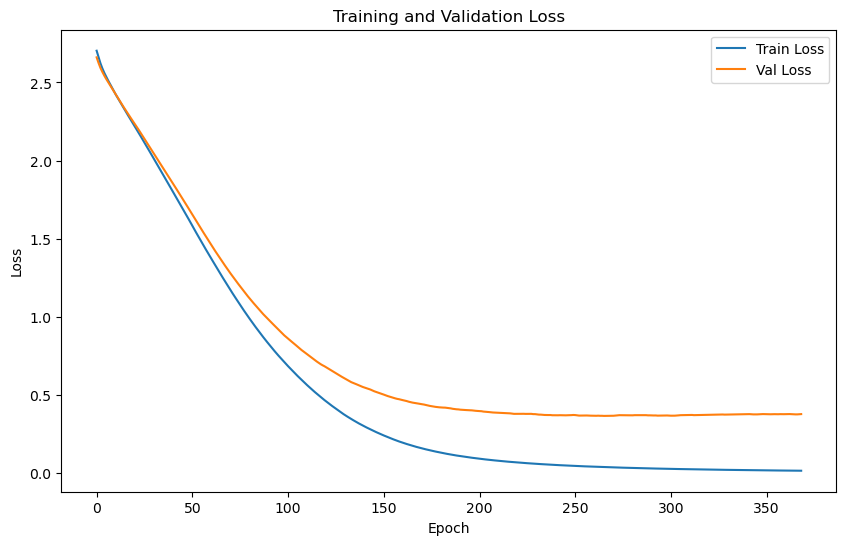

In [45]:
tscl_mlp_input_dim = tscl_mlp_train_reps.shape[1]
tscl_mlp_num_classes = len(torch.unique(tscl_mlp_train_labels_torch))
tscl_mlp_model = MLPClassifier(tscl_mlp_input_dim, tscl_mlp_num_classes).to(device)

tscl_mlp_criterion = nn.CrossEntropyLoss()
tscl_mlp_optimizer = optim.Adam(tscl_mlp_model.parameters(), lr=1e-4)

tscl_mlp_num_epochs = 1000
tscl_mlp_patience = 100

tscl_mlp_train_losses = []
tscl_mlp_val_losses = []

tscl_mlp_best_val_loss = float('inf')
tscl_mlp_epochs_without_improvement = 0

for tscl_mlp_epoch in range(tscl_mlp_num_epochs):
    # Training
    tscl_mlp_model.train()
    tscl_mlp_train_running_loss = 0.0
    
    for tscl_mlp_embeddings_batch, tscl_mlp_labels_batch in tscl_mlp_train_loader:
        tscl_mlp_embeddings_batch = tscl_mlp_embeddings_batch.to(device)
        tscl_mlp_labels_batch = tscl_mlp_labels_batch.to(device)
        
        tscl_mlp_optimizer.zero_grad()
        
        # Forward
        tscl_mlp_outputs = tscl_mlp_model(tscl_mlp_embeddings_batch)
        tscl_mlp_loss = tscl_mlp_criterion(tscl_mlp_outputs, tscl_mlp_labels_batch)
        
        # Backward & Update
        tscl_mlp_loss.backward()
        tscl_mlp_optimizer.step()
        
        tscl_mlp_train_running_loss += tscl_mlp_loss.item() * tscl_mlp_embeddings_batch.size(0)
    
    tscl_mlp_epoch_train_loss = tscl_mlp_train_running_loss / len(tscl_mlp_train_loader.dataset)
    tscl_mlp_train_losses.append(tscl_mlp_epoch_train_loss)

    # Validation
    tscl_mlp_model.eval()
    tscl_mlp_val_running_loss = 0.0
    
    with torch.no_grad():
        for tscl_mlp_val_embeddings_batch, tscl_mlp_val_labels_batch in tscl_mlp_val_loader:
            tscl_mlp_val_embeddings_batch = tscl_mlp_val_embeddings_batch.to(device)
            tscl_mlp_val_labels_batch = tscl_mlp_val_labels_batch.to(device)

            tscl_mlp_val_outputs = tscl_mlp_model(tscl_mlp_val_embeddings_batch)
            tscl_mlp_val_loss = tscl_mlp_criterion(tscl_mlp_val_outputs, tscl_mlp_val_labels_batch)

            tscl_mlp_val_running_loss += tscl_mlp_val_loss.item() * tscl_mlp_val_embeddings_batch.size(0)

    tscl_mlp_epoch_val_loss = tscl_mlp_val_running_loss / len(tscl_mlp_val_loader.dataset)
    tscl_mlp_val_losses.append(tscl_mlp_epoch_val_loss)

    print(f"[Epoch {tscl_mlp_epoch+1}/{tscl_mlp_num_epochs}] "
          f"Train Loss: {tscl_mlp_epoch_train_loss:.4f}  |  "
          f"Val Loss: {tscl_mlp_epoch_val_loss:.4f}")

    # Early stopping
    if tscl_mlp_epoch_val_loss < tscl_mlp_best_val_loss:
        print(f"Validation loss improved from {tscl_mlp_best_val_loss:.4f} to {tscl_mlp_epoch_val_loss:.4f}.")
        tscl_mlp_best_val_loss = tscl_mlp_epoch_val_loss
        tscl_mlp_epochs_without_improvement = 0

    else:
        # no improvement
        tscl_mlp_epochs_without_improvement += 1
        print(f"!! Validation loss did NOT improve !! "
              f"Patience: {tscl_mlp_epochs_without_improvement}/{tscl_mlp_patience}")
        
        if tscl_mlp_epochs_without_improvement >= tscl_mlp_patience:
            print(f"!! Early stopping triggered at epoch {tscl_mlp_epoch+1} !!\n"
                  f"No improvement for {tscl_mlp_patience} epochs.")
            break

plt.figure(figsize=(10,6))
plt.plot(tscl_mlp_train_losses, label='Train Loss')
plt.plot(tscl_mlp_val_losses,   label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()


Saved TSCL+MLP predictions and true labels to model_predictions
Test Loss: 0.4733 | Test Accuracy: 86.68%


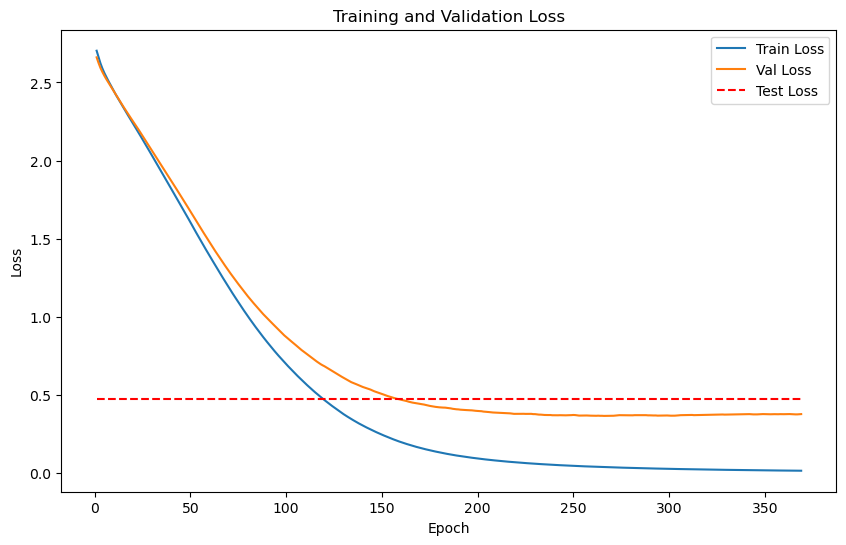

In [46]:
tscl_mlp_model.eval()

tscl_mlp_test_running_loss = 0.0
tscl_mlp_test_correct = 0
tscl_mlp_all_predictions = []
tscl_mlp_all_true_labels = []

with torch.no_grad():
    for tscl_mlp_test_embeddings_batch, tscl_mlp_test_labels_batch in tscl_mlp_test_loader:
        tscl_mlp_test_embeddings_batch = tscl_mlp_test_embeddings_batch.to(device)
        tscl_mlp_test_labels_batch = tscl_mlp_test_labels_batch.to(device)

        tscl_mlp_test_outputs = tscl_mlp_model(tscl_mlp_test_embeddings_batch)
        
        tscl_mlp_test_loss_batch = tscl_mlp_criterion(tscl_mlp_test_outputs, tscl_mlp_test_labels_batch)
        tscl_mlp_test_running_loss += tscl_mlp_test_loss_batch.item() * tscl_mlp_test_embeddings_batch.size(0)

        _, tscl_mlp_test_predicted = torch.max(tscl_mlp_test_outputs, dim=1)
        tscl_mlp_test_correct += (tscl_mlp_test_predicted == tscl_mlp_test_labels_batch).sum().item()

        tscl_mlp_all_predictions.extend(tscl_mlp_test_predicted.cpu().numpy())
        tscl_mlp_all_true_labels.extend(tscl_mlp_test_labels_batch.cpu().numpy())

np.save(os.path.join(predictions_dir, 'tscl_mlp_predictions.npy'), np.array(tscl_mlp_all_predictions))
np.save(os.path.join(predictions_dir, 'tscl_mlp_true_labels.npy'), np.array(tscl_mlp_all_true_labels))
print(f"Saved TSCL+MLP predictions and true labels to {predictions_dir}")

tscl_mlp_epoch_test_loss = tscl_mlp_test_running_loss / len(tscl_mlp_test_loader.dataset)
tscl_mlp_test_accuracy = tscl_mlp_test_correct / len(tscl_mlp_test_loader.dataset)

tscl_mlp_test_accuracy_pct = tscl_mlp_test_accuracy * 100.0

print(f"Test Loss: {tscl_mlp_epoch_test_loss:.4f} | Test Accuracy: {tscl_mlp_test_accuracy_pct:.2f}%")

tscl_mlp_num_epochs_run = len(tscl_mlp_train_losses)

plt.figure(figsize=(10,6))

plt.plot(range(1, tscl_mlp_num_epochs_run + 1),
         tscl_mlp_train_losses,
         label='Train Loss')
plt.plot(range(1, tscl_mlp_num_epochs_run + 1),
         tscl_mlp_val_losses,
         label='Val Loss')

plt.plot(range(1, tscl_mlp_num_epochs_run + 1),
         [tscl_mlp_epoch_test_loss]*tscl_mlp_num_epochs_run,
         'r--',
         label='Test Loss')

plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()


## Model - Supervised Contrastive Learning with Silhouette Distance Loss

In [47]:
sclsdl_encoded_train_dir = os.path.join(encoded_dir, 'train')
sclsdl_encoded_val_dir = os.path.join(encoded_dir, 'val')
sclsdl_encoded_test_dir = os.path.join(encoded_dir, 'test')

sclsdl_train_embeddings, sclsdl_train_labels = load_encoded_data(sclsdl_encoded_train_dir)
sclsdl_val_embeddings, sclsdl_val_labels = load_encoded_data(sclsdl_encoded_val_dir)
sclsdl_test_embeddings, sclsdl_test_labels = load_encoded_data(sclsdl_encoded_test_dir)

#shape verification
print(f"\n\nTrain embeddings shape: {sclsdl_train_embeddings.shape}, \nTrain labels shape: {sclsdl_train_labels.shape}")
print(f"\n\nVal embeddings shape: {sclsdl_val_embeddings.shape}, \nVal labels shape: {sclsdl_val_labels.shape}")
print(f"\n\nTest embeddings shape: {sclsdl_test_embeddings.shape}, \nTest labels shape: {sclsdl_test_labels.shape}")

LOG: Loading encoded data (representations) from encoded_representations\train...
LOG: Loaded 280 samples with 64 features each
LOG: Labels shape: (280,)
LOG: Loading encoded data (representations) from encoded_representations\val...
LOG: Loaded 70 samples with 64 features each
LOG: Labels shape: (70,)
LOG: Loading encoded data (representations) from encoded_representations\test...
LOG: Loaded 2898 samples with 64 features each
LOG: Labels shape: (2898,)


Train embeddings shape: (280, 64), 
Train labels shape: (280,)


Val embeddings shape: (70, 64), 
Val labels shape: (70,)


Test embeddings shape: (2898, 64), 
Test labels shape: (2898,)


In [48]:
#flattening embeddings to (num_samples, 64)
sclsdl_train_embeddings = sclsdl_train_embeddings.reshape(sclsdl_train_embeddings.shape[0], -1)
sclsdl_val_embeddings = sclsdl_val_embeddings.reshape(sclsdl_val_embeddings.shape[0], -1)
sclsdl_test_embeddings = sclsdl_test_embeddings.reshape(sclsdl_test_embeddings.shape[0], -1)

#compute mean and std from training set
sclsdl_train_mean = np.mean(sclsdl_train_embeddings, axis=0)
sclsdl_train_std = np.std(sclsdl_train_embeddings, axis=0)

#normalize all datasets from above training mean and std
#sclsdl_train_embeddings = (sclsdl_train_embeddings - sclsdl_train_mean) / sclsdl_train_std
#sclsdl_val_embeddings = (sclsdl_val_embeddings - sclsdl_train_mean) / sclsdl_train_std
#sclsdl_test_embeddings = (sclsdl_test_embeddings - sclsdl_train_mean) / sclsdl_train_std

sclsdl_train_dataset = TensorDataset(torch.tensor(sclsdl_train_embeddings, dtype=torch.float32), torch.tensor(sclsdl_train_labels, dtype=torch.long))
sclsdl_val_dataset = TensorDataset(torch.tensor(sclsdl_val_embeddings, dtype=torch.float32), torch.tensor(sclsdl_val_labels, dtype=torch.long))
sclsdl_test_dataset = TensorDataset(torch.tensor(sclsdl_test_embeddings, dtype=torch.float32), torch.tensor(sclsdl_test_labels, dtype=torch.long))


sclsdl_m = 20
sclsdl_num_classes = len(np.unique(sclsdl_train_labels))

# calc theoretical required batch size
sclsdl_required_batch_size = sclsdl_m * sclsdl_num_classes

if sclsdl_required_batch_size > len(sclsdl_train_dataset):
    sclsdl_max_possible_m = len(sclsdl_train_dataset) // sclsdl_num_classes
    sclsdl_m = max(1, sclsdl_max_possible_m)
    sclsdl_batch_size_train = sclsdl_m * sclsdl_num_classes
else:
    sclsdl_batch_size_train = sclsdl_required_batch_size

sclsdl_sampler = MPerClassSampler(labels = sclsdl_train_labels, m = sclsdl_m, batch_size = sclsdl_batch_size_train, length_before_new_iter=len(sclsdl_train_dataset))
sclsdl_train_loader = DataLoader(sclsdl_train_dataset, batch_size=sclsdl_batch_size_train, sampler=sclsdl_sampler)

#creating dataloaders for scl
sclsdl_dataloader_bs = 64
sclsdl_val_loader = DataLoader(sclsdl_val_dataset, batch_size=sclsdl_dataloader_bs, shuffle=False)
sclsdl_test_loader = DataLoader(sclsdl_test_dataset, batch_size=sclsdl_dataloader_bs, shuffle=False)

for sclsdl_X_batch, sclsdl_y_batch in sclsdl_train_loader:
    sclsdl_unique, sclsdl_counts = np.unique(y_batch.numpy(), return_counts=True)
    print("Class distribution in batch:", dict(zip(sclsdl_unique, sclsdl_counts)))
    print(f"Training batch size: {sclsdl_batch_size_train}")
    break


Class distribution in batch: {0: 20, 1: 20, 2: 20, 3: 20, 4: 20, 5: 20, 6: 20, 7: 20, 8: 20, 9: 20, 10: 20, 11: 20, 12: 20, 13: 20}
Training batch size: 280


In [49]:
class SupConNet(nn.Module):
    def __init__(self, feature_dim=128):
        super(SupConNet, self).__init__()
        self.projection_head = nn.Sequential(
            nn.Linear(64, 128),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(128, feature_dim)
        )

    def forward(self, x):
        return self.projection_head(x)

In [50]:
class SilhouetteDistanceLoss(nn.Module):
    def __init__(self):
        super(SilhouetteDistanceLoss, self).__init__()

    def forward(self, features, labels):
        return self.score(features, labels, True,True)

    def score(self,X, labels,feature_norm=True, loss=False):
        unique_labels = torch.unique(labels)
        if feature_norm:
            X= F.normalize(X, p=2, dim=1)


        A, B = self._compute_distances(X, labels, unique_labels)

        # A= scale*A
        # B = (1-scale)*B
        sil_samples = (B - A) / torch.clamp(torch.maximum(A, B), min=0.0001)

        # nan values are for clusters of size 1, and should be 0
        mean_sil_score = torch.mean(torch.nan_to_num(sil_samples))
        if loss:
            return (1 - mean_sil_score) / 2
        else:
            return mean_sil_score.item()


    def _compute_distances(self,X, labels, unique_labels):
        intra_dist = torch.zeros_like(labels, dtype=torch.float32)
        inter_dist = torch.full_like(labels, torch.inf, dtype=torch.float32)

        for i, label_a in enumerate(unique_labels):
            cluster_indices_a = (labels == label_a)
            subX_a = X[cluster_indices_a]


            intra_distances_a = torch.cdist(subX_a, subX_a)
            div = (subX_a.size(0) - 1) if subX_a.shape[0]>1 else 1
            intra_dist[cluster_indices_a] = intra_distances_a.sum(dim=1) / div

            for label_b in unique_labels[i + 1:]:
                cluster_indices_b = (labels == label_b)
                subX_b = X[cluster_indices_b]
                inter_distances_ab = torch.cdist(subX_a, subX_b)
                inter_distances_ba = torch.cdist(subX_b, subX_a)

                inter_dist[cluster_indices_a] = torch.minimum(inter_distances_ab.mean(dim=1), inter_dist[cluster_indices_a])
                inter_dist[cluster_indices_b] = torch.minimum(inter_distances_ba.mean(dim=1), inter_dist[cluster_indices_b])

        return intra_dist, inter_dist

LOG: Epoch [1/2000] - Training


    Batch [1/1], Train Loss: 0.4876
LOG: Epoch [1/2000] - Validation
    Batch [1/2], Val Loss: 0.4792
    Batch [2/2], Val Loss: 0.2834
Epoch [1/2000], Avg Train Loss: 0.4876, Avg Val Loss: 0.3813

Validation loss improved from inf to 0.3813. Saving model...
LOG: Epoch [2/2000] - Training


    Batch [1/1], Train Loss: 0.4841
LOG: Epoch [2/2000] - Validation
    Batch [1/2], Val Loss: 0.4792
    Batch [2/2], Val Loss: 0.2828
Epoch [2/2000], Avg Train Loss: 0.4841, Avg Val Loss: 0.3810

Validation loss improved from 0.3813 to 0.3810. Saving model...
LOG: Epoch [3/2000] - Training


    Batch [1/1], Train Loss: 0.4820
LOG: Epoch [3/2000] - Validation
    Batch [1/2], Val Loss: 0.4795
    Batch [2/2], Val Loss: 0.2811
Epoch [3/2000], Avg Train Loss: 0.4820, Avg Val Loss: 0.3803

Validation loss improved from 0.3810 to 0.3803. Saving model...
LOG: Epoch [4/2000] - Training


    Batch [1/1], Train Loss: 0.4835
LOG: Epoch [4/2000] - Validation
    Batch [1/2], Val Loss: 0.4797
    Batch [2/2], Val Loss: 0.2791
Epoch [4/2000], Avg Train Loss: 0.4835, Avg Val Loss: 0.3794

Validation loss improved from 0.3803 to 0.3794. Saving model...
LOG: Epoch [5/2000] - Training


    Batch [1/1], Train Loss: 0.4814
LOG: Epoch [5/2000] - Validation
    Batch [1/2], Val Loss: 0.4797
    Batch [2/2], Val Loss: 0.2795
Epoch [5/2000], Avg Train Loss: 0.4814, Avg Val Loss: 0.3796

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [6/2000] - Training


    Batch [1/1], Train Loss: 0.4779
LOG: Epoch [6/2000] - Validation
    Batch [1/2], Val Loss: 0.4795
    Batch [2/2], Val Loss: 0.2807
Epoch [6/2000], Avg Train Loss: 0.4779, Avg Val Loss: 0.3801

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [7/2000] - Training


    Batch [1/1], Train Loss: 0.4787
LOG: Epoch [7/2000] - Validation
    Batch [1/2], Val Loss: 0.4796
    Batch [2/2], Val Loss: 0.2816
Epoch [7/2000], Avg Train Loss: 0.4787, Avg Val Loss: 0.3806

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [8/2000] - Training


    Batch [1/1], Train Loss: 0.4778
LOG: Epoch [8/2000] - Validation
    Batch [1/2], Val Loss: 0.4795
    Batch [2/2], Val Loss: 0.2811
Epoch [8/2000], Avg Train Loss: 0.4778, Avg Val Loss: 0.3803

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [9/2000] - Training


    Batch [1/1], Train Loss: 0.4771
LOG: Epoch [9/2000] - Validation
    Batch [1/2], Val Loss: 0.4793
    Batch [2/2], Val Loss: 0.2788
Epoch [9/2000], Avg Train Loss: 0.4771, Avg Val Loss: 0.3791

Validation loss improved from 0.3794 to 0.3791. Saving model...
LOG: Epoch [10/2000] - Training


    Batch [1/1], Train Loss: 0.4743
LOG: Epoch [10/2000] - Validation
    Batch [1/2], Val Loss: 0.4795
    Batch [2/2], Val Loss: 0.2759
Epoch [10/2000], Avg Train Loss: 0.4743, Avg Val Loss: 0.3777

Validation loss improved from 0.3791 to 0.3777. Saving model...
LOG: Epoch [11/2000] - Training


    Batch [1/1], Train Loss: 0.4731
LOG: Epoch [11/2000] - Validation
    Batch [1/2], Val Loss: 0.4795
    Batch [2/2], Val Loss: 0.2725
Epoch [11/2000], Avg Train Loss: 0.4731, Avg Val Loss: 0.3760

Validation loss improved from 0.3777 to 0.3760. Saving model...
LOG: Epoch [12/2000] - Training


    Batch [1/1], Train Loss: 0.4731
LOG: Epoch [12/2000] - Validation
    Batch [1/2], Val Loss: 0.4796
    Batch [2/2], Val Loss: 0.2666
Epoch [12/2000], Avg Train Loss: 0.4731, Avg Val Loss: 0.3731

Validation loss improved from 0.3760 to 0.3731. Saving model...
LOG: Epoch [13/2000] - Training


    Batch [1/1], Train Loss: 0.4737
LOG: Epoch [13/2000] - Validation
    Batch [1/2], Val Loss: 0.4790
    Batch [2/2], Val Loss: 0.2602
Epoch [13/2000], Avg Train Loss: 0.4737, Avg Val Loss: 0.3696

Validation loss improved from 0.3731 to 0.3696. Saving model...
LOG: Epoch [14/2000] - Training


    Batch [1/1], Train Loss: 0.4678
LOG: Epoch [14/2000] - Validation
    Batch [1/2], Val Loss: 0.4783
    Batch [2/2], Val Loss: 0.2553
Epoch [14/2000], Avg Train Loss: 0.4678, Avg Val Loss: 0.3668

Validation loss improved from 0.3696 to 0.3668. Saving model...
LOG: Epoch [15/2000] - Training


    Batch [1/1], Train Loss: 0.4702
LOG: Epoch [15/2000] - Validation
    Batch [1/2], Val Loss: 0.4771
    Batch [2/2], Val Loss: 0.2512
Epoch [15/2000], Avg Train Loss: 0.4702, Avg Val Loss: 0.3642

Validation loss improved from 0.3668 to 0.3642. Saving model...
LOG: Epoch [16/2000] - Training


    Batch [1/1], Train Loss: 0.4694
LOG: Epoch [16/2000] - Validation
    Batch [1/2], Val Loss: 0.4760
    Batch [2/2], Val Loss: 0.2470
Epoch [16/2000], Avg Train Loss: 0.4694, Avg Val Loss: 0.3615

Validation loss improved from 0.3642 to 0.3615. Saving model...
LOG: Epoch [17/2000] - Training


    Batch [1/1], Train Loss: 0.4723
LOG: Epoch [17/2000] - Validation
    Batch [1/2], Val Loss: 0.4749
    Batch [2/2], Val Loss: 0.2421
Epoch [17/2000], Avg Train Loss: 0.4723, Avg Val Loss: 0.3585

Validation loss improved from 0.3615 to 0.3585. Saving model...
LOG: Epoch [18/2000] - Training


    Batch [1/1], Train Loss: 0.4674
LOG: Epoch [18/2000] - Validation
    Batch [1/2], Val Loss: 0.4743
    Batch [2/2], Val Loss: 0.2365
Epoch [18/2000], Avg Train Loss: 0.4674, Avg Val Loss: 0.3554

Validation loss improved from 0.3585 to 0.3554. Saving model...
LOG: Epoch [19/2000] - Training


    Batch [1/1], Train Loss: 0.4667
LOG: Epoch [19/2000] - Validation
    Batch [1/2], Val Loss: 0.4733
    Batch [2/2], Val Loss: 0.2324
Epoch [19/2000], Avg Train Loss: 0.4667, Avg Val Loss: 0.3528

Validation loss improved from 0.3554 to 0.3528. Saving model...
LOG: Epoch [20/2000] - Training


    Batch [1/1], Train Loss: 0.4631
LOG: Epoch [20/2000] - Validation
    Batch [1/2], Val Loss: 0.4724
    Batch [2/2], Val Loss: 0.2306
Epoch [20/2000], Avg Train Loss: 0.4631, Avg Val Loss: 0.3515

Validation loss improved from 0.3528 to 0.3515. Saving model...
LOG: Epoch [21/2000] - Training


    Batch [1/1], Train Loss: 0.4639
LOG: Epoch [21/2000] - Validation
    Batch [1/2], Val Loss: 0.4710
    Batch [2/2], Val Loss: 0.2244
Epoch [21/2000], Avg Train Loss: 0.4639, Avg Val Loss: 0.3477

Validation loss improved from 0.3515 to 0.3477. Saving model...
LOG: Epoch [22/2000] - Training


    Batch [1/1], Train Loss: 0.4637
LOG: Epoch [22/2000] - Validation
    Batch [1/2], Val Loss: 0.4689
    Batch [2/2], Val Loss: 0.2162
Epoch [22/2000], Avg Train Loss: 0.4637, Avg Val Loss: 0.3425

Validation loss improved from 0.3477 to 0.3425. Saving model...
LOG: Epoch [23/2000] - Training


    Batch [1/1], Train Loss: 0.4643
LOG: Epoch [23/2000] - Validation
    Batch [1/2], Val Loss: 0.4672
    Batch [2/2], Val Loss: 0.2082
Epoch [23/2000], Avg Train Loss: 0.4643, Avg Val Loss: 0.3377

Validation loss improved from 0.3425 to 0.3377. Saving model...
LOG: Epoch [24/2000] - Training


    Batch [1/1], Train Loss: 0.4586
LOG: Epoch [24/2000] - Validation
    Batch [1/2], Val Loss: 0.4667
    Batch [2/2], Val Loss: 0.2018
Epoch [24/2000], Avg Train Loss: 0.4586, Avg Val Loss: 0.3343

Validation loss improved from 0.3377 to 0.3343. Saving model...
LOG: Epoch [25/2000] - Training


    Batch [1/1], Train Loss: 0.4588
LOG: Epoch [25/2000] - Validation
    Batch [1/2], Val Loss: 0.4668
    Batch [2/2], Val Loss: 0.1970
Epoch [25/2000], Avg Train Loss: 0.4588, Avg Val Loss: 0.3319

Validation loss improved from 0.3343 to 0.3319. Saving model...
LOG: Epoch [26/2000] - Training


    Batch [1/1], Train Loss: 0.4603
LOG: Epoch [26/2000] - Validation
    Batch [1/2], Val Loss: 0.4666
    Batch [2/2], Val Loss: 0.1936
Epoch [26/2000], Avg Train Loss: 0.4603, Avg Val Loss: 0.3301

Validation loss improved from 0.3319 to 0.3301. Saving model...
LOG: Epoch [27/2000] - Training


    Batch [1/1], Train Loss: 0.4599
LOG: Epoch [27/2000] - Validation
    Batch [1/2], Val Loss: 0.4666
    Batch [2/2], Val Loss: 0.1906
Epoch [27/2000], Avg Train Loss: 0.4599, Avg Val Loss: 0.3286

Validation loss improved from 0.3301 to 0.3286. Saving model...
LOG: Epoch [28/2000] - Training


    Batch [1/1], Train Loss: 0.4569
LOG: Epoch [28/2000] - Validation
    Batch [1/2], Val Loss: 0.4669
    Batch [2/2], Val Loss: 0.1880
Epoch [28/2000], Avg Train Loss: 0.4569, Avg Val Loss: 0.3274

Validation loss improved from 0.3286 to 0.3274. Saving model...
LOG: Epoch [29/2000] - Training


    Batch [1/1], Train Loss: 0.4574
LOG: Epoch [29/2000] - Validation
    Batch [1/2], Val Loss: 0.4666
    Batch [2/2], Val Loss: 0.1851
Epoch [29/2000], Avg Train Loss: 0.4574, Avg Val Loss: 0.3259

Validation loss improved from 0.3274 to 0.3259. Saving model...
LOG: Epoch [30/2000] - Training


    Batch [1/1], Train Loss: 0.4551
LOG: Epoch [30/2000] - Validation
    Batch [1/2], Val Loss: 0.4663
    Batch [2/2], Val Loss: 0.1829
Epoch [30/2000], Avg Train Loss: 0.4551, Avg Val Loss: 0.3246

Validation loss improved from 0.3259 to 0.3246. Saving model...
LOG: Epoch [31/2000] - Training


    Batch [1/1], Train Loss: 0.4578
LOG: Epoch [31/2000] - Validation
    Batch [1/2], Val Loss: 0.4660
    Batch [2/2], Val Loss: 0.1817
Epoch [31/2000], Avg Train Loss: 0.4578, Avg Val Loss: 0.3238

Validation loss improved from 0.3246 to 0.3238. Saving model...
LOG: Epoch [32/2000] - Training


    Batch [1/1], Train Loss: 0.4537
LOG: Epoch [32/2000] - Validation
    Batch [1/2], Val Loss: 0.4656
    Batch [2/2], Val Loss: 0.1812
Epoch [32/2000], Avg Train Loss: 0.4537, Avg Val Loss: 0.3234

Validation loss improved from 0.3238 to 0.3234. Saving model...
LOG: Epoch [33/2000] - Training


    Batch [1/1], Train Loss: 0.4561
LOG: Epoch [33/2000] - Validation
    Batch [1/2], Val Loss: 0.4649
    Batch [2/2], Val Loss: 0.1826
Epoch [33/2000], Avg Train Loss: 0.4561, Avg Val Loss: 0.3237

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [34/2000] - Training


    Batch [1/1], Train Loss: 0.4543
LOG: Epoch [34/2000] - Validation
    Batch [1/2], Val Loss: 0.4640
    Batch [2/2], Val Loss: 0.1842
Epoch [34/2000], Avg Train Loss: 0.4543, Avg Val Loss: 0.3241

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [35/2000] - Training


    Batch [1/1], Train Loss: 0.4522
LOG: Epoch [35/2000] - Validation
    Batch [1/2], Val Loss: 0.4630
    Batch [2/2], Val Loss: 0.1859
Epoch [35/2000], Avg Train Loss: 0.4522, Avg Val Loss: 0.3245

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [36/2000] - Training


    Batch [1/1], Train Loss: 0.4508
LOG: Epoch [36/2000] - Validation
    Batch [1/2], Val Loss: 0.4616
    Batch [2/2], Val Loss: 0.1875
Epoch [36/2000], Avg Train Loss: 0.4508, Avg Val Loss: 0.3245

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [37/2000] - Training


    Batch [1/1], Train Loss: 0.4492
LOG: Epoch [37/2000] - Validation
    Batch [1/2], Val Loss: 0.4602
    Batch [2/2], Val Loss: 0.1887
Epoch [37/2000], Avg Train Loss: 0.4492, Avg Val Loss: 0.3245

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [38/2000] - Training


    Batch [1/1], Train Loss: 0.4502
LOG: Epoch [38/2000] - Validation
    Batch [1/2], Val Loss: 0.4589
    Batch [2/2], Val Loss: 0.1902
Epoch [38/2000], Avg Train Loss: 0.4502, Avg Val Loss: 0.3246

!! Validation loss did NOT improve !! Patience: 6/100
LOG: Epoch [39/2000] - Training


    Batch [1/1], Train Loss: 0.4501
LOG: Epoch [39/2000] - Validation
    Batch [1/2], Val Loss: 0.4575
    Batch [2/2], Val Loss: 0.1916
Epoch [39/2000], Avg Train Loss: 0.4501, Avg Val Loss: 0.3245

!! Validation loss did NOT improve !! Patience: 7/100
LOG: Epoch [40/2000] - Training


    Batch [1/1], Train Loss: 0.4508
LOG: Epoch [40/2000] - Validation
    Batch [1/2], Val Loss: 0.4559
    Batch [2/2], Val Loss: 0.1927
Epoch [40/2000], Avg Train Loss: 0.4508, Avg Val Loss: 0.3243

!! Validation loss did NOT improve !! Patience: 8/100
LOG: Epoch [41/2000] - Training


    Batch [1/1], Train Loss: 0.4497
LOG: Epoch [41/2000] - Validation
    Batch [1/2], Val Loss: 0.4545
    Batch [2/2], Val Loss: 0.1938
Epoch [41/2000], Avg Train Loss: 0.4497, Avg Val Loss: 0.3241

!! Validation loss did NOT improve !! Patience: 9/100
LOG: Epoch [42/2000] - Training


    Batch [1/1], Train Loss: 0.4459
LOG: Epoch [42/2000] - Validation
    Batch [1/2], Val Loss: 0.4531
    Batch [2/2], Val Loss: 0.1948
Epoch [42/2000], Avg Train Loss: 0.4459, Avg Val Loss: 0.3239

!! Validation loss did NOT improve !! Patience: 10/100
LOG: Epoch [43/2000] - Training


    Batch [1/1], Train Loss: 0.4464
LOG: Epoch [43/2000] - Validation
    Batch [1/2], Val Loss: 0.4516
    Batch [2/2], Val Loss: 0.1961
Epoch [43/2000], Avg Train Loss: 0.4464, Avg Val Loss: 0.3239

!! Validation loss did NOT improve !! Patience: 11/100
LOG: Epoch [44/2000] - Training


    Batch [1/1], Train Loss: 0.4484
LOG: Epoch [44/2000] - Validation
    Batch [1/2], Val Loss: 0.4503
    Batch [2/2], Val Loss: 0.1972
Epoch [44/2000], Avg Train Loss: 0.4484, Avg Val Loss: 0.3237

!! Validation loss did NOT improve !! Patience: 12/100
LOG: Epoch [45/2000] - Training


    Batch [1/1], Train Loss: 0.4460
LOG: Epoch [45/2000] - Validation
    Batch [1/2], Val Loss: 0.4488
    Batch [2/2], Val Loss: 0.1982
Epoch [45/2000], Avg Train Loss: 0.4460, Avg Val Loss: 0.3235

!! Validation loss did NOT improve !! Patience: 13/100
LOG: Epoch [46/2000] - Training


    Batch [1/1], Train Loss: 0.4440
LOG: Epoch [46/2000] - Validation
    Batch [1/2], Val Loss: 0.4474
    Batch [2/2], Val Loss: 0.1993
Epoch [46/2000], Avg Train Loss: 0.4440, Avg Val Loss: 0.3233

Validation loss improved from 0.3234 to 0.3233. Saving model...
LOG: Epoch [47/2000] - Training


    Batch [1/1], Train Loss: 0.4465
LOG: Epoch [47/2000] - Validation
    Batch [1/2], Val Loss: 0.4463
    Batch [2/2], Val Loss: 0.2004
Epoch [47/2000], Avg Train Loss: 0.4465, Avg Val Loss: 0.3233

Validation loss improved from 0.3233 to 0.3233. Saving model...
LOG: Epoch [48/2000] - Training


    Batch [1/1], Train Loss: 0.4450
LOG: Epoch [48/2000] - Validation
    Batch [1/2], Val Loss: 0.4450
    Batch [2/2], Val Loss: 0.2016
Epoch [48/2000], Avg Train Loss: 0.4450, Avg Val Loss: 0.3233

Validation loss improved from 0.3233 to 0.3233. Saving model...
LOG: Epoch [49/2000] - Training


    Batch [1/1], Train Loss: 0.4402
LOG: Epoch [49/2000] - Validation
    Batch [1/2], Val Loss: 0.4437
    Batch [2/2], Val Loss: 0.2029
Epoch [49/2000], Avg Train Loss: 0.4402, Avg Val Loss: 0.3233

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [50/2000] - Training


    Batch [1/1], Train Loss: 0.4399
LOG: Epoch [50/2000] - Validation
    Batch [1/2], Val Loss: 0.4424
    Batch [2/2], Val Loss: 0.2041
Epoch [50/2000], Avg Train Loss: 0.4399, Avg Val Loss: 0.3233

Validation loss improved from 0.3233 to 0.3233. Saving model...
LOG: Epoch [51/2000] - Training


    Batch [1/1], Train Loss: 0.4435
LOG: Epoch [51/2000] - Validation
    Batch [1/2], Val Loss: 0.4412
    Batch [2/2], Val Loss: 0.2049
Epoch [51/2000], Avg Train Loss: 0.4435, Avg Val Loss: 0.3230

Validation loss improved from 0.3233 to 0.3230. Saving model...
LOG: Epoch [52/2000] - Training


    Batch [1/1], Train Loss: 0.4381
LOG: Epoch [52/2000] - Validation
    Batch [1/2], Val Loss: 0.4401
    Batch [2/2], Val Loss: 0.2056
Epoch [52/2000], Avg Train Loss: 0.4381, Avg Val Loss: 0.3228

Validation loss improved from 0.3230 to 0.3228. Saving model...
LOG: Epoch [53/2000] - Training


    Batch [1/1], Train Loss: 0.4378
LOG: Epoch [53/2000] - Validation
    Batch [1/2], Val Loss: 0.4389
    Batch [2/2], Val Loss: 0.2061
Epoch [53/2000], Avg Train Loss: 0.4378, Avg Val Loss: 0.3225

Validation loss improved from 0.3228 to 0.3225. Saving model...
LOG: Epoch [54/2000] - Training


    Batch [1/1], Train Loss: 0.4423
LOG: Epoch [54/2000] - Validation
    Batch [1/2], Val Loss: 0.4380
    Batch [2/2], Val Loss: 0.2066
Epoch [54/2000], Avg Train Loss: 0.4423, Avg Val Loss: 0.3223

Validation loss improved from 0.3225 to 0.3223. Saving model...
LOG: Epoch [55/2000] - Training


    Batch [1/1], Train Loss: 0.4404
LOG: Epoch [55/2000] - Validation
    Batch [1/2], Val Loss: 0.4373
    Batch [2/2], Val Loss: 0.2070
Epoch [55/2000], Avg Train Loss: 0.4404, Avg Val Loss: 0.3221

Validation loss improved from 0.3223 to 0.3221. Saving model...
LOG: Epoch [56/2000] - Training


    Batch [1/1], Train Loss: 0.4360
LOG: Epoch [56/2000] - Validation
    Batch [1/2], Val Loss: 0.4363
    Batch [2/2], Val Loss: 0.2077
Epoch [56/2000], Avg Train Loss: 0.4360, Avg Val Loss: 0.3220

Validation loss improved from 0.3221 to 0.3220. Saving model...
LOG: Epoch [57/2000] - Training


    Batch [1/1], Train Loss: 0.4359
LOG: Epoch [57/2000] - Validation
    Batch [1/2], Val Loss: 0.4354
    Batch [2/2], Val Loss: 0.2085
Epoch [57/2000], Avg Train Loss: 0.4359, Avg Val Loss: 0.3220

Validation loss improved from 0.3220 to 0.3220. Saving model...
LOG: Epoch [58/2000] - Training


    Batch [1/1], Train Loss: 0.4354
LOG: Epoch [58/2000] - Validation
    Batch [1/2], Val Loss: 0.4345
    Batch [2/2], Val Loss: 0.2093
Epoch [58/2000], Avg Train Loss: 0.4354, Avg Val Loss: 0.3219

Validation loss improved from 0.3220 to 0.3219. Saving model...
LOG: Epoch [59/2000] - Training


    Batch [1/1], Train Loss: 0.4370
LOG: Epoch [59/2000] - Validation
    Batch [1/2], Val Loss: 0.4337
    Batch [2/2], Val Loss: 0.2096
Epoch [59/2000], Avg Train Loss: 0.4370, Avg Val Loss: 0.3216

Validation loss improved from 0.3219 to 0.3216. Saving model...
LOG: Epoch [60/2000] - Training


    Batch [1/1], Train Loss: 0.4391
LOG: Epoch [60/2000] - Validation
    Batch [1/2], Val Loss: 0.4329
    Batch [2/2], Val Loss: 0.2096
Epoch [60/2000], Avg Train Loss: 0.4391, Avg Val Loss: 0.3213

Validation loss improved from 0.3216 to 0.3213. Saving model...
LOG: Epoch [61/2000] - Training


    Batch [1/1], Train Loss: 0.4360
LOG: Epoch [61/2000] - Validation
    Batch [1/2], Val Loss: 0.4318
    Batch [2/2], Val Loss: 0.2096
Epoch [61/2000], Avg Train Loss: 0.4360, Avg Val Loss: 0.3207

Validation loss improved from 0.3213 to 0.3207. Saving model...
LOG: Epoch [62/2000] - Training


    Batch [1/1], Train Loss: 0.4380
LOG: Epoch [62/2000] - Validation
    Batch [1/2], Val Loss: 0.4308
    Batch [2/2], Val Loss: 0.2091
Epoch [62/2000], Avg Train Loss: 0.4380, Avg Val Loss: 0.3200

Validation loss improved from 0.3207 to 0.3200. Saving model...
LOG: Epoch [63/2000] - Training


    Batch [1/1], Train Loss: 0.4340
LOG: Epoch [63/2000] - Validation
    Batch [1/2], Val Loss: 0.4298
    Batch [2/2], Val Loss: 0.2088
Epoch [63/2000], Avg Train Loss: 0.4340, Avg Val Loss: 0.3193

Validation loss improved from 0.3200 to 0.3193. Saving model...
LOG: Epoch [64/2000] - Training


    Batch [1/1], Train Loss: 0.4346
LOG: Epoch [64/2000] - Validation
    Batch [1/2], Val Loss: 0.4285
    Batch [2/2], Val Loss: 0.2084
Epoch [64/2000], Avg Train Loss: 0.4346, Avg Val Loss: 0.3185

Validation loss improved from 0.3193 to 0.3185. Saving model...
LOG: Epoch [65/2000] - Training


    Batch [1/1], Train Loss: 0.4313
LOG: Epoch [65/2000] - Validation
    Batch [1/2], Val Loss: 0.4273
    Batch [2/2], Val Loss: 0.2086
Epoch [65/2000], Avg Train Loss: 0.4313, Avg Val Loss: 0.3180

Validation loss improved from 0.3185 to 0.3180. Saving model...
LOG: Epoch [66/2000] - Training


    Batch [1/1], Train Loss: 0.4277
LOG: Epoch [66/2000] - Validation
    Batch [1/2], Val Loss: 0.4262
    Batch [2/2], Val Loss: 0.2087
Epoch [66/2000], Avg Train Loss: 0.4277, Avg Val Loss: 0.3175

Validation loss improved from 0.3180 to 0.3175. Saving model...
LOG: Epoch [67/2000] - Training


    Batch [1/1], Train Loss: 0.4322
LOG: Epoch [67/2000] - Validation
    Batch [1/2], Val Loss: 0.4251
    Batch [2/2], Val Loss: 0.2089
Epoch [67/2000], Avg Train Loss: 0.4322, Avg Val Loss: 0.3170

Validation loss improved from 0.3175 to 0.3170. Saving model...
LOG: Epoch [68/2000] - Training


    Batch [1/1], Train Loss: 0.4337
LOG: Epoch [68/2000] - Validation
    Batch [1/2], Val Loss: 0.4240
    Batch [2/2], Val Loss: 0.2089
Epoch [68/2000], Avg Train Loss: 0.4337, Avg Val Loss: 0.3165

Validation loss improved from 0.3170 to 0.3165. Saving model...
LOG: Epoch [69/2000] - Training


    Batch [1/1], Train Loss: 0.4278
LOG: Epoch [69/2000] - Validation
    Batch [1/2], Val Loss: 0.4228
    Batch [2/2], Val Loss: 0.2090
Epoch [69/2000], Avg Train Loss: 0.4278, Avg Val Loss: 0.3159

Validation loss improved from 0.3165 to 0.3159. Saving model...
LOG: Epoch [70/2000] - Training


    Batch [1/1], Train Loss: 0.4277
LOG: Epoch [70/2000] - Validation
    Batch [1/2], Val Loss: 0.4218
    Batch [2/2], Val Loss: 0.2085
Epoch [70/2000], Avg Train Loss: 0.4277, Avg Val Loss: 0.3151

Validation loss improved from 0.3159 to 0.3151. Saving model...
LOG: Epoch [71/2000] - Training


    Batch [1/1], Train Loss: 0.4265
LOG: Epoch [71/2000] - Validation
    Batch [1/2], Val Loss: 0.4208
    Batch [2/2], Val Loss: 0.2079
Epoch [71/2000], Avg Train Loss: 0.4265, Avg Val Loss: 0.3144

Validation loss improved from 0.3151 to 0.3144. Saving model...
LOG: Epoch [72/2000] - Training


    Batch [1/1], Train Loss: 0.4292
LOG: Epoch [72/2000] - Validation
    Batch [1/2], Val Loss: 0.4200
    Batch [2/2], Val Loss: 0.2073
Epoch [72/2000], Avg Train Loss: 0.4292, Avg Val Loss: 0.3136

Validation loss improved from 0.3144 to 0.3136. Saving model...
LOG: Epoch [73/2000] - Training


    Batch [1/1], Train Loss: 0.4275
LOG: Epoch [73/2000] - Validation
    Batch [1/2], Val Loss: 0.4191
    Batch [2/2], Val Loss: 0.2071
Epoch [73/2000], Avg Train Loss: 0.4275, Avg Val Loss: 0.3131

Validation loss improved from 0.3136 to 0.3131. Saving model...
LOG: Epoch [74/2000] - Training


    Batch [1/1], Train Loss: 0.4244
LOG: Epoch [74/2000] - Validation
    Batch [1/2], Val Loss: 0.4186
    Batch [2/2], Val Loss: 0.2071
Epoch [74/2000], Avg Train Loss: 0.4244, Avg Val Loss: 0.3128

Validation loss improved from 0.3131 to 0.3128. Saving model...
LOG: Epoch [75/2000] - Training


    Batch [1/1], Train Loss: 0.4241
LOG: Epoch [75/2000] - Validation
    Batch [1/2], Val Loss: 0.4181
    Batch [2/2], Val Loss: 0.2074
Epoch [75/2000], Avg Train Loss: 0.4241, Avg Val Loss: 0.3127

Validation loss improved from 0.3128 to 0.3127. Saving model...
LOG: Epoch [76/2000] - Training


    Batch [1/1], Train Loss: 0.4230
LOG: Epoch [76/2000] - Validation
    Batch [1/2], Val Loss: 0.4177
    Batch [2/2], Val Loss: 0.2079
Epoch [76/2000], Avg Train Loss: 0.4230, Avg Val Loss: 0.3128

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [77/2000] - Training


    Batch [1/1], Train Loss: 0.4248
LOG: Epoch [77/2000] - Validation
    Batch [1/2], Val Loss: 0.4171
    Batch [2/2], Val Loss: 0.2081
Epoch [77/2000], Avg Train Loss: 0.4248, Avg Val Loss: 0.3126

Validation loss improved from 0.3127 to 0.3126. Saving model...
LOG: Epoch [78/2000] - Training


    Batch [1/1], Train Loss: 0.4255
LOG: Epoch [78/2000] - Validation
    Batch [1/2], Val Loss: 0.4168
    Batch [2/2], Val Loss: 0.2078
Epoch [78/2000], Avg Train Loss: 0.4255, Avg Val Loss: 0.3123

Validation loss improved from 0.3126 to 0.3123. Saving model...
LOG: Epoch [79/2000] - Training


    Batch [1/1], Train Loss: 0.4222
LOG: Epoch [79/2000] - Validation
    Batch [1/2], Val Loss: 0.4163
    Batch [2/2], Val Loss: 0.2078
Epoch [79/2000], Avg Train Loss: 0.4222, Avg Val Loss: 0.3121

Validation loss improved from 0.3123 to 0.3121. Saving model...
LOG: Epoch [80/2000] - Training


    Batch [1/1], Train Loss: 0.4223
LOG: Epoch [80/2000] - Validation
    Batch [1/2], Val Loss: 0.4160
    Batch [2/2], Val Loss: 0.2076
Epoch [80/2000], Avg Train Loss: 0.4223, Avg Val Loss: 0.3118

Validation loss improved from 0.3121 to 0.3118. Saving model...
LOG: Epoch [81/2000] - Training


    Batch [1/1], Train Loss: 0.4247
LOG: Epoch [81/2000] - Validation
    Batch [1/2], Val Loss: 0.4157
    Batch [2/2], Val Loss: 0.2071
Epoch [81/2000], Avg Train Loss: 0.4247, Avg Val Loss: 0.3114

Validation loss improved from 0.3118 to 0.3114. Saving model...
LOG: Epoch [82/2000] - Training


    Batch [1/1], Train Loss: 0.4207
LOG: Epoch [82/2000] - Validation
    Batch [1/2], Val Loss: 0.4153
    Batch [2/2], Val Loss: 0.2064
Epoch [82/2000], Avg Train Loss: 0.4207, Avg Val Loss: 0.3109

Validation loss improved from 0.3114 to 0.3109. Saving model...
LOG: Epoch [83/2000] - Training


    Batch [1/1], Train Loss: 0.4212
LOG: Epoch [83/2000] - Validation
    Batch [1/2], Val Loss: 0.4149
    Batch [2/2], Val Loss: 0.2058
Epoch [83/2000], Avg Train Loss: 0.4212, Avg Val Loss: 0.3103

Validation loss improved from 0.3109 to 0.3103. Saving model...
LOG: Epoch [84/2000] - Training


    Batch [1/1], Train Loss: 0.4197
LOG: Epoch [84/2000] - Validation
    Batch [1/2], Val Loss: 0.4145
    Batch [2/2], Val Loss: 0.2050
Epoch [84/2000], Avg Train Loss: 0.4197, Avg Val Loss: 0.3098

Validation loss improved from 0.3103 to 0.3098. Saving model...
LOG: Epoch [85/2000] - Training


    Batch [1/1], Train Loss: 0.4230
LOG: Epoch [85/2000] - Validation
    Batch [1/2], Val Loss: 0.4140
    Batch [2/2], Val Loss: 0.2036
Epoch [85/2000], Avg Train Loss: 0.4230, Avg Val Loss: 0.3088

Validation loss improved from 0.3098 to 0.3088. Saving model...
LOG: Epoch [86/2000] - Training


    Batch [1/1], Train Loss: 0.4185
LOG: Epoch [86/2000] - Validation
    Batch [1/2], Val Loss: 0.4141
    Batch [2/2], Val Loss: 0.2023
Epoch [86/2000], Avg Train Loss: 0.4185, Avg Val Loss: 0.3082

Validation loss improved from 0.3088 to 0.3082. Saving model...
LOG: Epoch [87/2000] - Training


    Batch [1/1], Train Loss: 0.4189
LOG: Epoch [87/2000] - Validation
    Batch [1/2], Val Loss: 0.4139
    Batch [2/2], Val Loss: 0.2016
Epoch [87/2000], Avg Train Loss: 0.4189, Avg Val Loss: 0.3077

Validation loss improved from 0.3082 to 0.3077. Saving model...
LOG: Epoch [88/2000] - Training


    Batch [1/1], Train Loss: 0.4178
LOG: Epoch [88/2000] - Validation
    Batch [1/2], Val Loss: 0.4137
    Batch [2/2], Val Loss: 0.2009
Epoch [88/2000], Avg Train Loss: 0.4178, Avg Val Loss: 0.3073

Validation loss improved from 0.3077 to 0.3073. Saving model...
LOG: Epoch [89/2000] - Training


    Batch [1/1], Train Loss: 0.4195
LOG: Epoch [89/2000] - Validation
    Batch [1/2], Val Loss: 0.4137
    Batch [2/2], Val Loss: 0.2000
Epoch [89/2000], Avg Train Loss: 0.4195, Avg Val Loss: 0.3068

Validation loss improved from 0.3073 to 0.3068. Saving model...
LOG: Epoch [90/2000] - Training


    Batch [1/1], Train Loss: 0.4199
LOG: Epoch [90/2000] - Validation
    Batch [1/2], Val Loss: 0.4134
    Batch [2/2], Val Loss: 0.1985
Epoch [90/2000], Avg Train Loss: 0.4199, Avg Val Loss: 0.3060

Validation loss improved from 0.3068 to 0.3060. Saving model...
LOG: Epoch [91/2000] - Training


    Batch [1/1], Train Loss: 0.4170
LOG: Epoch [91/2000] - Validation
    Batch [1/2], Val Loss: 0.4129
    Batch [2/2], Val Loss: 0.1976
Epoch [91/2000], Avg Train Loss: 0.4170, Avg Val Loss: 0.3052

Validation loss improved from 0.3060 to 0.3052. Saving model...
LOG: Epoch [92/2000] - Training


    Batch [1/1], Train Loss: 0.4182
LOG: Epoch [92/2000] - Validation
    Batch [1/2], Val Loss: 0.4121
    Batch [2/2], Val Loss: 0.1973
Epoch [92/2000], Avg Train Loss: 0.4182, Avg Val Loss: 0.3047

Validation loss improved from 0.3052 to 0.3047. Saving model...
LOG: Epoch [93/2000] - Training


    Batch [1/1], Train Loss: 0.4155
LOG: Epoch [93/2000] - Validation
    Batch [1/2], Val Loss: 0.4115
    Batch [2/2], Val Loss: 0.1972
Epoch [93/2000], Avg Train Loss: 0.4155, Avg Val Loss: 0.3043

Validation loss improved from 0.3047 to 0.3043. Saving model...
LOG: Epoch [94/2000] - Training


    Batch [1/1], Train Loss: 0.4145
LOG: Epoch [94/2000] - Validation
    Batch [1/2], Val Loss: 0.4107
    Batch [2/2], Val Loss: 0.1970
Epoch [94/2000], Avg Train Loss: 0.4145, Avg Val Loss: 0.3039

Validation loss improved from 0.3043 to 0.3039. Saving model...
LOG: Epoch [95/2000] - Training


    Batch [1/1], Train Loss: 0.4147
LOG: Epoch [95/2000] - Validation
    Batch [1/2], Val Loss: 0.4100
    Batch [2/2], Val Loss: 0.1967
Epoch [95/2000], Avg Train Loss: 0.4147, Avg Val Loss: 0.3033

Validation loss improved from 0.3039 to 0.3033. Saving model...
LOG: Epoch [96/2000] - Training


    Batch [1/1], Train Loss: 0.4171
LOG: Epoch [96/2000] - Validation
    Batch [1/2], Val Loss: 0.4096
    Batch [2/2], Val Loss: 0.1960
Epoch [96/2000], Avg Train Loss: 0.4171, Avg Val Loss: 0.3028

Validation loss improved from 0.3033 to 0.3028. Saving model...
LOG: Epoch [97/2000] - Training


    Batch [1/1], Train Loss: 0.4130
LOG: Epoch [97/2000] - Validation
    Batch [1/2], Val Loss: 0.4096
    Batch [2/2], Val Loss: 0.1949
Epoch [97/2000], Avg Train Loss: 0.4130, Avg Val Loss: 0.3022

Validation loss improved from 0.3028 to 0.3022. Saving model...
LOG: Epoch [98/2000] - Training


    Batch [1/1], Train Loss: 0.4121
LOG: Epoch [98/2000] - Validation
    Batch [1/2], Val Loss: 0.4094
    Batch [2/2], Val Loss: 0.1938
Epoch [98/2000], Avg Train Loss: 0.4121, Avg Val Loss: 0.3016

Validation loss improved from 0.3022 to 0.3016. Saving model...
LOG: Epoch [99/2000] - Training


    Batch [1/1], Train Loss: 0.4126
LOG: Epoch [99/2000] - Validation
    Batch [1/2], Val Loss: 0.4089
    Batch [2/2], Val Loss: 0.1924
Epoch [99/2000], Avg Train Loss: 0.4126, Avg Val Loss: 0.3007

Validation loss improved from 0.3016 to 0.3007. Saving model...
LOG: Epoch [100/2000] - Training


    Batch [1/1], Train Loss: 0.4132
LOG: Epoch [100/2000] - Validation
    Batch [1/2], Val Loss: 0.4086
    Batch [2/2], Val Loss: 0.1914
Epoch [100/2000], Avg Train Loss: 0.4132, Avg Val Loss: 0.3000

Validation loss improved from 0.3007 to 0.3000. Saving model...
LOG: Epoch [101/2000] - Training


    Batch [1/1], Train Loss: 0.4102
LOG: Epoch [101/2000] - Validation
    Batch [1/2], Val Loss: 0.4084
    Batch [2/2], Val Loss: 0.1903
Epoch [101/2000], Avg Train Loss: 0.4102, Avg Val Loss: 0.2993

Validation loss improved from 0.3000 to 0.2993. Saving model...
LOG: Epoch [102/2000] - Training


    Batch [1/1], Train Loss: 0.4151
LOG: Epoch [102/2000] - Validation
    Batch [1/2], Val Loss: 0.4079
    Batch [2/2], Val Loss: 0.1891
Epoch [102/2000], Avg Train Loss: 0.4151, Avg Val Loss: 0.2985

Validation loss improved from 0.2993 to 0.2985. Saving model...
LOG: Epoch [103/2000] - Training


    Batch [1/1], Train Loss: 0.4093
LOG: Epoch [103/2000] - Validation
    Batch [1/2], Val Loss: 0.4078
    Batch [2/2], Val Loss: 0.1880
Epoch [103/2000], Avg Train Loss: 0.4093, Avg Val Loss: 0.2979

Validation loss improved from 0.2985 to 0.2979. Saving model...
LOG: Epoch [104/2000] - Training


    Batch [1/1], Train Loss: 0.4117
LOG: Epoch [104/2000] - Validation
    Batch [1/2], Val Loss: 0.4075
    Batch [2/2], Val Loss: 0.1872
Epoch [104/2000], Avg Train Loss: 0.4117, Avg Val Loss: 0.2974

Validation loss improved from 0.2979 to 0.2974. Saving model...
LOG: Epoch [105/2000] - Training


    Batch [1/1], Train Loss: 0.4106
LOG: Epoch [105/2000] - Validation
    Batch [1/2], Val Loss: 0.4075
    Batch [2/2], Val Loss: 0.1857
Epoch [105/2000], Avg Train Loss: 0.4106, Avg Val Loss: 0.2966

Validation loss improved from 0.2974 to 0.2966. Saving model...
LOG: Epoch [106/2000] - Training


    Batch [1/1], Train Loss: 0.4064
LOG: Epoch [106/2000] - Validation
    Batch [1/2], Val Loss: 0.4075
    Batch [2/2], Val Loss: 0.1847
Epoch [106/2000], Avg Train Loss: 0.4064, Avg Val Loss: 0.2961

Validation loss improved from 0.2966 to 0.2961. Saving model...
LOG: Epoch [107/2000] - Training


    Batch [1/1], Train Loss: 0.4043
LOG: Epoch [107/2000] - Validation
    Batch [1/2], Val Loss: 0.4081
    Batch [2/2], Val Loss: 0.1836
Epoch [107/2000], Avg Train Loss: 0.4043, Avg Val Loss: 0.2958

Validation loss improved from 0.2961 to 0.2958. Saving model...
LOG: Epoch [108/2000] - Training


    Batch [1/1], Train Loss: 0.4105
LOG: Epoch [108/2000] - Validation
    Batch [1/2], Val Loss: 0.4084
    Batch [2/2], Val Loss: 0.1826
Epoch [108/2000], Avg Train Loss: 0.4105, Avg Val Loss: 0.2955

Validation loss improved from 0.2958 to 0.2955. Saving model...
LOG: Epoch [109/2000] - Training


    Batch [1/1], Train Loss: 0.4042
LOG: Epoch [109/2000] - Validation
    Batch [1/2], Val Loss: 0.4083
    Batch [2/2], Val Loss: 0.1819
Epoch [109/2000], Avg Train Loss: 0.4042, Avg Val Loss: 0.2951

Validation loss improved from 0.2955 to 0.2951. Saving model...
LOG: Epoch [110/2000] - Training


    Batch [1/1], Train Loss: 0.4103
LOG: Epoch [110/2000] - Validation
    Batch [1/2], Val Loss: 0.4088
    Batch [2/2], Val Loss: 0.1813
Epoch [110/2000], Avg Train Loss: 0.4103, Avg Val Loss: 0.2950

Validation loss improved from 0.2951 to 0.2950. Saving model...
LOG: Epoch [111/2000] - Training


    Batch [1/1], Train Loss: 0.4035
LOG: Epoch [111/2000] - Validation
    Batch [1/2], Val Loss: 0.4086
    Batch [2/2], Val Loss: 0.1808
Epoch [111/2000], Avg Train Loss: 0.4035, Avg Val Loss: 0.2947

Validation loss improved from 0.2950 to 0.2947. Saving model...
LOG: Epoch [112/2000] - Training


    Batch [1/1], Train Loss: 0.4031
LOG: Epoch [112/2000] - Validation
    Batch [1/2], Val Loss: 0.4081
    Batch [2/2], Val Loss: 0.1801
Epoch [112/2000], Avg Train Loss: 0.4031, Avg Val Loss: 0.2941

Validation loss improved from 0.2947 to 0.2941. Saving model...
LOG: Epoch [113/2000] - Training


    Batch [1/1], Train Loss: 0.4060
LOG: Epoch [113/2000] - Validation
    Batch [1/2], Val Loss: 0.4069
    Batch [2/2], Val Loss: 0.1796
Epoch [113/2000], Avg Train Loss: 0.4060, Avg Val Loss: 0.2933

Validation loss improved from 0.2941 to 0.2933. Saving model...
LOG: Epoch [114/2000] - Training


    Batch [1/1], Train Loss: 0.4055
LOG: Epoch [114/2000] - Validation
    Batch [1/2], Val Loss: 0.4057
    Batch [2/2], Val Loss: 0.1790
Epoch [114/2000], Avg Train Loss: 0.4055, Avg Val Loss: 0.2924

Validation loss improved from 0.2933 to 0.2924. Saving model...
LOG: Epoch [115/2000] - Training


    Batch [1/1], Train Loss: 0.4055
LOG: Epoch [115/2000] - Validation
    Batch [1/2], Val Loss: 0.4047
    Batch [2/2], Val Loss: 0.1786
Epoch [115/2000], Avg Train Loss: 0.4055, Avg Val Loss: 0.2917

Validation loss improved from 0.2924 to 0.2917. Saving model...
LOG: Epoch [116/2000] - Training


    Batch [1/1], Train Loss: 0.4065
LOG: Epoch [116/2000] - Validation
    Batch [1/2], Val Loss: 0.4033
    Batch [2/2], Val Loss: 0.1783
Epoch [116/2000], Avg Train Loss: 0.4065, Avg Val Loss: 0.2908

Validation loss improved from 0.2917 to 0.2908. Saving model...
LOG: Epoch [117/2000] - Training


    Batch [1/1], Train Loss: 0.4040
LOG: Epoch [117/2000] - Validation
    Batch [1/2], Val Loss: 0.4022
    Batch [2/2], Val Loss: 0.1778
Epoch [117/2000], Avg Train Loss: 0.4040, Avg Val Loss: 0.2900

Validation loss improved from 0.2908 to 0.2900. Saving model...
LOG: Epoch [118/2000] - Training


    Batch [1/1], Train Loss: 0.4009
LOG: Epoch [118/2000] - Validation
    Batch [1/2], Val Loss: 0.4013
    Batch [2/2], Val Loss: 0.1771
Epoch [118/2000], Avg Train Loss: 0.4009, Avg Val Loss: 0.2892

Validation loss improved from 0.2900 to 0.2892. Saving model...
LOG: Epoch [119/2000] - Training


    Batch [1/1], Train Loss: 0.3997
LOG: Epoch [119/2000] - Validation
    Batch [1/2], Val Loss: 0.4008
    Batch [2/2], Val Loss: 0.1765
Epoch [119/2000], Avg Train Loss: 0.3997, Avg Val Loss: 0.2886

Validation loss improved from 0.2892 to 0.2886. Saving model...
LOG: Epoch [120/2000] - Training


    Batch [1/1], Train Loss: 0.4016
LOG: Epoch [120/2000] - Validation
    Batch [1/2], Val Loss: 0.4005
    Batch [2/2], Val Loss: 0.1758
Epoch [120/2000], Avg Train Loss: 0.4016, Avg Val Loss: 0.2881

Validation loss improved from 0.2886 to 0.2881. Saving model...
LOG: Epoch [121/2000] - Training


    Batch [1/1], Train Loss: 0.3981
LOG: Epoch [121/2000] - Validation
    Batch [1/2], Val Loss: 0.4004
    Batch [2/2], Val Loss: 0.1753
Epoch [121/2000], Avg Train Loss: 0.3981, Avg Val Loss: 0.2878

Validation loss improved from 0.2881 to 0.2878. Saving model...
LOG: Epoch [122/2000] - Training


    Batch [1/1], Train Loss: 0.4003
LOG: Epoch [122/2000] - Validation
    Batch [1/2], Val Loss: 0.4010
    Batch [2/2], Val Loss: 0.1743
Epoch [122/2000], Avg Train Loss: 0.4003, Avg Val Loss: 0.2876

Validation loss improved from 0.2878 to 0.2876. Saving model...
LOG: Epoch [123/2000] - Training


    Batch [1/1], Train Loss: 0.4004
LOG: Epoch [123/2000] - Validation
    Batch [1/2], Val Loss: 0.4020
    Batch [2/2], Val Loss: 0.1736
Epoch [123/2000], Avg Train Loss: 0.4004, Avg Val Loss: 0.2878

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [124/2000] - Training


    Batch [1/1], Train Loss: 0.3953
LOG: Epoch [124/2000] - Validation
    Batch [1/2], Val Loss: 0.4031
    Batch [2/2], Val Loss: 0.1736
Epoch [124/2000], Avg Train Loss: 0.3953, Avg Val Loss: 0.2884

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [125/2000] - Training


    Batch [1/1], Train Loss: 0.4029
LOG: Epoch [125/2000] - Validation
    Batch [1/2], Val Loss: 0.4044
    Batch [2/2], Val Loss: 0.1733
Epoch [125/2000], Avg Train Loss: 0.4029, Avg Val Loss: 0.2888

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [126/2000] - Training


    Batch [1/1], Train Loss: 0.4005
LOG: Epoch [126/2000] - Validation
    Batch [1/2], Val Loss: 0.4048
    Batch [2/2], Val Loss: 0.1728
Epoch [126/2000], Avg Train Loss: 0.4005, Avg Val Loss: 0.2888

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [127/2000] - Training


    Batch [1/1], Train Loss: 0.4011
LOG: Epoch [127/2000] - Validation
    Batch [1/2], Val Loss: 0.4048
    Batch [2/2], Val Loss: 0.1721
Epoch [127/2000], Avg Train Loss: 0.4011, Avg Val Loss: 0.2884

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [128/2000] - Training


    Batch [1/1], Train Loss: 0.4043
LOG: Epoch [128/2000] - Validation
    Batch [1/2], Val Loss: 0.4043
    Batch [2/2], Val Loss: 0.1718
Epoch [128/2000], Avg Train Loss: 0.4043, Avg Val Loss: 0.2881

!! Validation loss did NOT improve !! Patience: 6/100
LOG: Epoch [129/2000] - Training


    Batch [1/1], Train Loss: 0.4017
LOG: Epoch [129/2000] - Validation
    Batch [1/2], Val Loss: 0.4032
    Batch [2/2], Val Loss: 0.1710
Epoch [129/2000], Avg Train Loss: 0.4017, Avg Val Loss: 0.2871

Validation loss improved from 0.2876 to 0.2871. Saving model...
LOG: Epoch [130/2000] - Training


    Batch [1/1], Train Loss: 0.3980
LOG: Epoch [130/2000] - Validation
    Batch [1/2], Val Loss: 0.4019
    Batch [2/2], Val Loss: 0.1703
Epoch [130/2000], Avg Train Loss: 0.3980, Avg Val Loss: 0.2861

Validation loss improved from 0.2871 to 0.2861. Saving model...
LOG: Epoch [131/2000] - Training


    Batch [1/1], Train Loss: 0.3910
LOG: Epoch [131/2000] - Validation
    Batch [1/2], Val Loss: 0.4007
    Batch [2/2], Val Loss: 0.1695
Epoch [131/2000], Avg Train Loss: 0.3910, Avg Val Loss: 0.2851

Validation loss improved from 0.2861 to 0.2851. Saving model...
LOG: Epoch [132/2000] - Training


    Batch [1/1], Train Loss: 0.3912
LOG: Epoch [132/2000] - Validation
    Batch [1/2], Val Loss: 0.3992
    Batch [2/2], Val Loss: 0.1691
Epoch [132/2000], Avg Train Loss: 0.3912, Avg Val Loss: 0.2842

Validation loss improved from 0.2851 to 0.2842. Saving model...
LOG: Epoch [133/2000] - Training


    Batch [1/1], Train Loss: 0.3949
LOG: Epoch [133/2000] - Validation
    Batch [1/2], Val Loss: 0.3979
    Batch [2/2], Val Loss: 0.1690
Epoch [133/2000], Avg Train Loss: 0.3949, Avg Val Loss: 0.2835

Validation loss improved from 0.2842 to 0.2835. Saving model...
LOG: Epoch [134/2000] - Training


    Batch [1/1], Train Loss: 0.3922
LOG: Epoch [134/2000] - Validation
    Batch [1/2], Val Loss: 0.3963
    Batch [2/2], Val Loss: 0.1685
Epoch [134/2000], Avg Train Loss: 0.3922, Avg Val Loss: 0.2824

Validation loss improved from 0.2835 to 0.2824. Saving model...
LOG: Epoch [135/2000] - Training


    Batch [1/1], Train Loss: 0.3980
LOG: Epoch [135/2000] - Validation
    Batch [1/2], Val Loss: 0.3949
    Batch [2/2], Val Loss: 0.1680
Epoch [135/2000], Avg Train Loss: 0.3980, Avg Val Loss: 0.2814

Validation loss improved from 0.2824 to 0.2814. Saving model...
LOG: Epoch [136/2000] - Training


    Batch [1/1], Train Loss: 0.3894
LOG: Epoch [136/2000] - Validation
    Batch [1/2], Val Loss: 0.3939
    Batch [2/2], Val Loss: 0.1675
Epoch [136/2000], Avg Train Loss: 0.3894, Avg Val Loss: 0.2807

Validation loss improved from 0.2814 to 0.2807. Saving model...
LOG: Epoch [137/2000] - Training


    Batch [1/1], Train Loss: 0.3910
LOG: Epoch [137/2000] - Validation
    Batch [1/2], Val Loss: 0.3929
    Batch [2/2], Val Loss: 0.1670
Epoch [137/2000], Avg Train Loss: 0.3910, Avg Val Loss: 0.2799

Validation loss improved from 0.2807 to 0.2799. Saving model...
LOG: Epoch [138/2000] - Training


    Batch [1/1], Train Loss: 0.3966
LOG: Epoch [138/2000] - Validation
    Batch [1/2], Val Loss: 0.3924
    Batch [2/2], Val Loss: 0.1665
Epoch [138/2000], Avg Train Loss: 0.3966, Avg Val Loss: 0.2794

Validation loss improved from 0.2799 to 0.2794. Saving model...
LOG: Epoch [139/2000] - Training


    Batch [1/1], Train Loss: 0.3933
LOG: Epoch [139/2000] - Validation
    Batch [1/2], Val Loss: 0.3922
    Batch [2/2], Val Loss: 0.1658
Epoch [139/2000], Avg Train Loss: 0.3933, Avg Val Loss: 0.2790

Validation loss improved from 0.2794 to 0.2790. Saving model...
LOG: Epoch [140/2000] - Training


    Batch [1/1], Train Loss: 0.3937
LOG: Epoch [140/2000] - Validation
    Batch [1/2], Val Loss: 0.3923
    Batch [2/2], Val Loss: 0.1651
Epoch [140/2000], Avg Train Loss: 0.3937, Avg Val Loss: 0.2787

Validation loss improved from 0.2790 to 0.2787. Saving model...
LOG: Epoch [141/2000] - Training


    Batch [1/1], Train Loss: 0.3930
LOG: Epoch [141/2000] - Validation
    Batch [1/2], Val Loss: 0.3921
    Batch [2/2], Val Loss: 0.1644
Epoch [141/2000], Avg Train Loss: 0.3930, Avg Val Loss: 0.2783

Validation loss improved from 0.2787 to 0.2783. Saving model...
LOG: Epoch [142/2000] - Training


    Batch [1/1], Train Loss: 0.3887
LOG: Epoch [142/2000] - Validation
    Batch [1/2], Val Loss: 0.3920
    Batch [2/2], Val Loss: 0.1643
Epoch [142/2000], Avg Train Loss: 0.3887, Avg Val Loss: 0.2781

Validation loss improved from 0.2783 to 0.2781. Saving model...
LOG: Epoch [143/2000] - Training


    Batch [1/1], Train Loss: 0.3841
LOG: Epoch [143/2000] - Validation
    Batch [1/2], Val Loss: 0.3921
    Batch [2/2], Val Loss: 0.1646
Epoch [143/2000], Avg Train Loss: 0.3841, Avg Val Loss: 0.2783

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [144/2000] - Training


    Batch [1/1], Train Loss: 0.3904
LOG: Epoch [144/2000] - Validation
    Batch [1/2], Val Loss: 0.3920
    Batch [2/2], Val Loss: 0.1649
Epoch [144/2000], Avg Train Loss: 0.3904, Avg Val Loss: 0.2784

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [145/2000] - Training


    Batch [1/1], Train Loss: 0.3892
LOG: Epoch [145/2000] - Validation
    Batch [1/2], Val Loss: 0.3913
    Batch [2/2], Val Loss: 0.1651
Epoch [145/2000], Avg Train Loss: 0.3892, Avg Val Loss: 0.2782

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [146/2000] - Training


    Batch [1/1], Train Loss: 0.3875
LOG: Epoch [146/2000] - Validation
    Batch [1/2], Val Loss: 0.3910
    Batch [2/2], Val Loss: 0.1647
Epoch [146/2000], Avg Train Loss: 0.3875, Avg Val Loss: 0.2779

Validation loss improved from 0.2781 to 0.2779. Saving model...
LOG: Epoch [147/2000] - Training


    Batch [1/1], Train Loss: 0.3824
LOG: Epoch [147/2000] - Validation
    Batch [1/2], Val Loss: 0.3912
    Batch [2/2], Val Loss: 0.1637
Epoch [147/2000], Avg Train Loss: 0.3824, Avg Val Loss: 0.2774

Validation loss improved from 0.2779 to 0.2774. Saving model...
LOG: Epoch [148/2000] - Training


    Batch [1/1], Train Loss: 0.3806
LOG: Epoch [148/2000] - Validation
    Batch [1/2], Val Loss: 0.3916
    Batch [2/2], Val Loss: 0.1630
Epoch [148/2000], Avg Train Loss: 0.3806, Avg Val Loss: 0.2773

Validation loss improved from 0.2774 to 0.2773. Saving model...
LOG: Epoch [149/2000] - Training


    Batch [1/1], Train Loss: 0.3853
LOG: Epoch [149/2000] - Validation
    Batch [1/2], Val Loss: 0.3915
    Batch [2/2], Val Loss: 0.1623
Epoch [149/2000], Avg Train Loss: 0.3853, Avg Val Loss: 0.2769

Validation loss improved from 0.2773 to 0.2769. Saving model...
LOG: Epoch [150/2000] - Training


    Batch [1/1], Train Loss: 0.3844
LOG: Epoch [150/2000] - Validation
    Batch [1/2], Val Loss: 0.3908
    Batch [2/2], Val Loss: 0.1617
Epoch [150/2000], Avg Train Loss: 0.3844, Avg Val Loss: 0.2762

Validation loss improved from 0.2769 to 0.2762. Saving model...
LOG: Epoch [151/2000] - Training


    Batch [1/1], Train Loss: 0.3893
LOG: Epoch [151/2000] - Validation
    Batch [1/2], Val Loss: 0.3902
    Batch [2/2], Val Loss: 0.1612
Epoch [151/2000], Avg Train Loss: 0.3893, Avg Val Loss: 0.2757

Validation loss improved from 0.2762 to 0.2757. Saving model...
LOG: Epoch [152/2000] - Training


    Batch [1/1], Train Loss: 0.3798
LOG: Epoch [152/2000] - Validation
    Batch [1/2], Val Loss: 0.3904
    Batch [2/2], Val Loss: 0.1604
Epoch [152/2000], Avg Train Loss: 0.3798, Avg Val Loss: 0.2754

Validation loss improved from 0.2757 to 0.2754. Saving model...
LOG: Epoch [153/2000] - Training


    Batch [1/1], Train Loss: 0.3813
LOG: Epoch [153/2000] - Validation
    Batch [1/2], Val Loss: 0.3906
    Batch [2/2], Val Loss: 0.1598
Epoch [153/2000], Avg Train Loss: 0.3813, Avg Val Loss: 0.2752

Validation loss improved from 0.2754 to 0.2752. Saving model...
LOG: Epoch [154/2000] - Training


    Batch [1/1], Train Loss: 0.3794
LOG: Epoch [154/2000] - Validation
    Batch [1/2], Val Loss: 0.3911
    Batch [2/2], Val Loss: 0.1598
Epoch [154/2000], Avg Train Loss: 0.3794, Avg Val Loss: 0.2755

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [155/2000] - Training


    Batch [1/1], Train Loss: 0.3769
LOG: Epoch [155/2000] - Validation
    Batch [1/2], Val Loss: 0.3913
    Batch [2/2], Val Loss: 0.1604
Epoch [155/2000], Avg Train Loss: 0.3769, Avg Val Loss: 0.2759

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [156/2000] - Training


    Batch [1/1], Train Loss: 0.3801
LOG: Epoch [156/2000] - Validation
    Batch [1/2], Val Loss: 0.3910
    Batch [2/2], Val Loss: 0.1608
Epoch [156/2000], Avg Train Loss: 0.3801, Avg Val Loss: 0.2759

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [157/2000] - Training


    Batch [1/1], Train Loss: 0.3820
LOG: Epoch [157/2000] - Validation
    Batch [1/2], Val Loss: 0.3908
    Batch [2/2], Val Loss: 0.1611
Epoch [157/2000], Avg Train Loss: 0.3820, Avg Val Loss: 0.2759

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [158/2000] - Training


    Batch [1/1], Train Loss: 0.3854
LOG: Epoch [158/2000] - Validation
    Batch [1/2], Val Loss: 0.3905
    Batch [2/2], Val Loss: 0.1612
Epoch [158/2000], Avg Train Loss: 0.3854, Avg Val Loss: 0.2758

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [159/2000] - Training


    Batch [1/1], Train Loss: 0.3870
LOG: Epoch [159/2000] - Validation
    Batch [1/2], Val Loss: 0.3898
    Batch [2/2], Val Loss: 0.1608
Epoch [159/2000], Avg Train Loss: 0.3870, Avg Val Loss: 0.2753

!! Validation loss did NOT improve !! Patience: 6/100
LOG: Epoch [160/2000] - Training


    Batch [1/1], Train Loss: 0.3738
LOG: Epoch [160/2000] - Validation
    Batch [1/2], Val Loss: 0.3889
    Batch [2/2], Val Loss: 0.1600
Epoch [160/2000], Avg Train Loss: 0.3738, Avg Val Loss: 0.2745

Validation loss improved from 0.2752 to 0.2745. Saving model...
LOG: Epoch [161/2000] - Training


    Batch [1/1], Train Loss: 0.3804
LOG: Epoch [161/2000] - Validation
    Batch [1/2], Val Loss: 0.3881
    Batch [2/2], Val Loss: 0.1596
Epoch [161/2000], Avg Train Loss: 0.3804, Avg Val Loss: 0.2738

Validation loss improved from 0.2745 to 0.2738. Saving model...
LOG: Epoch [162/2000] - Training


    Batch [1/1], Train Loss: 0.3786
LOG: Epoch [162/2000] - Validation
    Batch [1/2], Val Loss: 0.3879
    Batch [2/2], Val Loss: 0.1590
Epoch [162/2000], Avg Train Loss: 0.3786, Avg Val Loss: 0.2734

Validation loss improved from 0.2738 to 0.2734. Saving model...
LOG: Epoch [163/2000] - Training


    Batch [1/1], Train Loss: 0.3749
LOG: Epoch [163/2000] - Validation
    Batch [1/2], Val Loss: 0.3874
    Batch [2/2], Val Loss: 0.1583
Epoch [163/2000], Avg Train Loss: 0.3749, Avg Val Loss: 0.2728

Validation loss improved from 0.2734 to 0.2728. Saving model...
LOG: Epoch [164/2000] - Training


    Batch [1/1], Train Loss: 0.3778
LOG: Epoch [164/2000] - Validation
    Batch [1/2], Val Loss: 0.3869
    Batch [2/2], Val Loss: 0.1575
Epoch [164/2000], Avg Train Loss: 0.3778, Avg Val Loss: 0.2722

Validation loss improved from 0.2728 to 0.2722. Saving model...
LOG: Epoch [165/2000] - Training


    Batch [1/1], Train Loss: 0.3756
LOG: Epoch [165/2000] - Validation
    Batch [1/2], Val Loss: 0.3872
    Batch [2/2], Val Loss: 0.1569
Epoch [165/2000], Avg Train Loss: 0.3756, Avg Val Loss: 0.2720

Validation loss improved from 0.2722 to 0.2720. Saving model...
LOG: Epoch [166/2000] - Training


    Batch [1/1], Train Loss: 0.3746
LOG: Epoch [166/2000] - Validation
    Batch [1/2], Val Loss: 0.3876
    Batch [2/2], Val Loss: 0.1560
Epoch [166/2000], Avg Train Loss: 0.3746, Avg Val Loss: 0.2718

Validation loss improved from 0.2720 to 0.2718. Saving model...
LOG: Epoch [167/2000] - Training


    Batch [1/1], Train Loss: 0.3807
LOG: Epoch [167/2000] - Validation
    Batch [1/2], Val Loss: 0.3880
    Batch [2/2], Val Loss: 0.1551
Epoch [167/2000], Avg Train Loss: 0.3807, Avg Val Loss: 0.2715

Validation loss improved from 0.2718 to 0.2715. Saving model...
LOG: Epoch [168/2000] - Training


    Batch [1/1], Train Loss: 0.3783
LOG: Epoch [168/2000] - Validation
    Batch [1/2], Val Loss: 0.3890
    Batch [2/2], Val Loss: 0.1546
Epoch [168/2000], Avg Train Loss: 0.3783, Avg Val Loss: 0.2718

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [169/2000] - Training


    Batch [1/1], Train Loss: 0.3747
LOG: Epoch [169/2000] - Validation
    Batch [1/2], Val Loss: 0.3897
    Batch [2/2], Val Loss: 0.1545
Epoch [169/2000], Avg Train Loss: 0.3747, Avg Val Loss: 0.2721

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [170/2000] - Training


    Batch [1/1], Train Loss: 0.3746
LOG: Epoch [170/2000] - Validation
    Batch [1/2], Val Loss: 0.3900
    Batch [2/2], Val Loss: 0.1543
Epoch [170/2000], Avg Train Loss: 0.3746, Avg Val Loss: 0.2721

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [171/2000] - Training


    Batch [1/1], Train Loss: 0.3748
LOG: Epoch [171/2000] - Validation
    Batch [1/2], Val Loss: 0.3906
    Batch [2/2], Val Loss: 0.1538
Epoch [171/2000], Avg Train Loss: 0.3748, Avg Val Loss: 0.2722

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [172/2000] - Training


    Batch [1/1], Train Loss: 0.3700
LOG: Epoch [172/2000] - Validation
    Batch [1/2], Val Loss: 0.3907
    Batch [2/2], Val Loss: 0.1533
Epoch [172/2000], Avg Train Loss: 0.3700, Avg Val Loss: 0.2720

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [173/2000] - Training


    Batch [1/1], Train Loss: 0.3714
LOG: Epoch [173/2000] - Validation
    Batch [1/2], Val Loss: 0.3910
    Batch [2/2], Val Loss: 0.1530
Epoch [173/2000], Avg Train Loss: 0.3714, Avg Val Loss: 0.2720

!! Validation loss did NOT improve !! Patience: 6/100
LOG: Epoch [174/2000] - Training


    Batch [1/1], Train Loss: 0.3727
LOG: Epoch [174/2000] - Validation
    Batch [1/2], Val Loss: 0.3906
    Batch [2/2], Val Loss: 0.1525
Epoch [174/2000], Avg Train Loss: 0.3727, Avg Val Loss: 0.2715

Validation loss improved from 0.2715 to 0.2715. Saving model...
LOG: Epoch [175/2000] - Training


    Batch [1/1], Train Loss: 0.3703
LOG: Epoch [175/2000] - Validation
    Batch [1/2], Val Loss: 0.3903
    Batch [2/2], Val Loss: 0.1526
Epoch [175/2000], Avg Train Loss: 0.3703, Avg Val Loss: 0.2714

Validation loss improved from 0.2715 to 0.2714. Saving model...
LOG: Epoch [176/2000] - Training


    Batch [1/1], Train Loss: 0.3688
LOG: Epoch [176/2000] - Validation
    Batch [1/2], Val Loss: 0.3900
    Batch [2/2], Val Loss: 0.1524
Epoch [176/2000], Avg Train Loss: 0.3688, Avg Val Loss: 0.2712

Validation loss improved from 0.2714 to 0.2712. Saving model...
LOG: Epoch [177/2000] - Training


    Batch [1/1], Train Loss: 0.3705
LOG: Epoch [177/2000] - Validation
    Batch [1/2], Val Loss: 0.3898
    Batch [2/2], Val Loss: 0.1524
Epoch [177/2000], Avg Train Loss: 0.3705, Avg Val Loss: 0.2711

Validation loss improved from 0.2712 to 0.2711. Saving model...
LOG: Epoch [178/2000] - Training


    Batch [1/1], Train Loss: 0.3715
LOG: Epoch [178/2000] - Validation
    Batch [1/2], Val Loss: 0.3898
    Batch [2/2], Val Loss: 0.1522
Epoch [178/2000], Avg Train Loss: 0.3715, Avg Val Loss: 0.2710

Validation loss improved from 0.2711 to 0.2710. Saving model...
LOG: Epoch [179/2000] - Training


    Batch [1/1], Train Loss: 0.3719
LOG: Epoch [179/2000] - Validation
    Batch [1/2], Val Loss: 0.3893
    Batch [2/2], Val Loss: 0.1517
Epoch [179/2000], Avg Train Loss: 0.3719, Avg Val Loss: 0.2705

Validation loss improved from 0.2710 to 0.2705. Saving model...
LOG: Epoch [180/2000] - Training


    Batch [1/1], Train Loss: 0.3693
LOG: Epoch [180/2000] - Validation
    Batch [1/2], Val Loss: 0.3885
    Batch [2/2], Val Loss: 0.1510
Epoch [180/2000], Avg Train Loss: 0.3693, Avg Val Loss: 0.2698

Validation loss improved from 0.2705 to 0.2698. Saving model...
LOG: Epoch [181/2000] - Training


    Batch [1/1], Train Loss: 0.3689
LOG: Epoch [181/2000] - Validation
    Batch [1/2], Val Loss: 0.3879
    Batch [2/2], Val Loss: 0.1503
Epoch [181/2000], Avg Train Loss: 0.3689, Avg Val Loss: 0.2691

Validation loss improved from 0.2698 to 0.2691. Saving model...
LOG: Epoch [182/2000] - Training


    Batch [1/1], Train Loss: 0.3675
LOG: Epoch [182/2000] - Validation
    Batch [1/2], Val Loss: 0.3873
    Batch [2/2], Val Loss: 0.1499
Epoch [182/2000], Avg Train Loss: 0.3675, Avg Val Loss: 0.2686

Validation loss improved from 0.2691 to 0.2686. Saving model...
LOG: Epoch [183/2000] - Training


    Batch [1/1], Train Loss: 0.3737
LOG: Epoch [183/2000] - Validation
    Batch [1/2], Val Loss: 0.3869
    Batch [2/2], Val Loss: 0.1498
Epoch [183/2000], Avg Train Loss: 0.3737, Avg Val Loss: 0.2684

Validation loss improved from 0.2686 to 0.2684. Saving model...
LOG: Epoch [184/2000] - Training


    Batch [1/1], Train Loss: 0.3678
LOG: Epoch [184/2000] - Validation
    Batch [1/2], Val Loss: 0.3867
    Batch [2/2], Val Loss: 0.1494
Epoch [184/2000], Avg Train Loss: 0.3678, Avg Val Loss: 0.2681

Validation loss improved from 0.2684 to 0.2681. Saving model...
LOG: Epoch [185/2000] - Training


    Batch [1/1], Train Loss: 0.3701
LOG: Epoch [185/2000] - Validation
    Batch [1/2], Val Loss: 0.3859
    Batch [2/2], Val Loss: 0.1492
Epoch [185/2000], Avg Train Loss: 0.3701, Avg Val Loss: 0.2675

Validation loss improved from 0.2681 to 0.2675. Saving model...
LOG: Epoch [186/2000] - Training


    Batch [1/1], Train Loss: 0.3621
LOG: Epoch [186/2000] - Validation
    Batch [1/2], Val Loss: 0.3847
    Batch [2/2], Val Loss: 0.1484
Epoch [186/2000], Avg Train Loss: 0.3621, Avg Val Loss: 0.2665

Validation loss improved from 0.2675 to 0.2665. Saving model...
LOG: Epoch [187/2000] - Training


    Batch [1/1], Train Loss: 0.3606
LOG: Epoch [187/2000] - Validation
    Batch [1/2], Val Loss: 0.3830
    Batch [2/2], Val Loss: 0.1475
Epoch [187/2000], Avg Train Loss: 0.3606, Avg Val Loss: 0.2652

Validation loss improved from 0.2665 to 0.2652. Saving model...
LOG: Epoch [188/2000] - Training


    Batch [1/1], Train Loss: 0.3678
LOG: Epoch [188/2000] - Validation
    Batch [1/2], Val Loss: 0.3814
    Batch [2/2], Val Loss: 0.1472
Epoch [188/2000], Avg Train Loss: 0.3678, Avg Val Loss: 0.2643

Validation loss improved from 0.2652 to 0.2643. Saving model...
LOG: Epoch [189/2000] - Training


    Batch [1/1], Train Loss: 0.3646
LOG: Epoch [189/2000] - Validation
    Batch [1/2], Val Loss: 0.3800
    Batch [2/2], Val Loss: 0.1464
Epoch [189/2000], Avg Train Loss: 0.3646, Avg Val Loss: 0.2632

Validation loss improved from 0.2643 to 0.2632. Saving model...
LOG: Epoch [190/2000] - Training


    Batch [1/1], Train Loss: 0.3644
LOG: Epoch [190/2000] - Validation
    Batch [1/2], Val Loss: 0.3786
    Batch [2/2], Val Loss: 0.1455
Epoch [190/2000], Avg Train Loss: 0.3644, Avg Val Loss: 0.2620

Validation loss improved from 0.2632 to 0.2620. Saving model...
LOG: Epoch [191/2000] - Training


    Batch [1/1], Train Loss: 0.3626
LOG: Epoch [191/2000] - Validation
    Batch [1/2], Val Loss: 0.3775
    Batch [2/2], Val Loss: 0.1446
Epoch [191/2000], Avg Train Loss: 0.3626, Avg Val Loss: 0.2611

Validation loss improved from 0.2620 to 0.2611. Saving model...
LOG: Epoch [192/2000] - Training


    Batch [1/1], Train Loss: 0.3681
LOG: Epoch [192/2000] - Validation
    Batch [1/2], Val Loss: 0.3771
    Batch [2/2], Val Loss: 0.1439
Epoch [192/2000], Avg Train Loss: 0.3681, Avg Val Loss: 0.2605

Validation loss improved from 0.2611 to 0.2605. Saving model...
LOG: Epoch [193/2000] - Training


    Batch [1/1], Train Loss: 0.3627
LOG: Epoch [193/2000] - Validation
    Batch [1/2], Val Loss: 0.3762
    Batch [2/2], Val Loss: 0.1428
Epoch [193/2000], Avg Train Loss: 0.3627, Avg Val Loss: 0.2595

Validation loss improved from 0.2605 to 0.2595. Saving model...
LOG: Epoch [194/2000] - Training


    Batch [1/1], Train Loss: 0.3639
LOG: Epoch [194/2000] - Validation
    Batch [1/2], Val Loss: 0.3760
    Batch [2/2], Val Loss: 0.1417
Epoch [194/2000], Avg Train Loss: 0.3639, Avg Val Loss: 0.2589

Validation loss improved from 0.2595 to 0.2589. Saving model...
LOG: Epoch [195/2000] - Training


    Batch [1/1], Train Loss: 0.3627
LOG: Epoch [195/2000] - Validation
    Batch [1/2], Val Loss: 0.3761
    Batch [2/2], Val Loss: 0.1407
Epoch [195/2000], Avg Train Loss: 0.3627, Avg Val Loss: 0.2584

Validation loss improved from 0.2589 to 0.2584. Saving model...
LOG: Epoch [196/2000] - Training


    Batch [1/1], Train Loss: 0.3624
LOG: Epoch [196/2000] - Validation
    Batch [1/2], Val Loss: 0.3763
    Batch [2/2], Val Loss: 0.1401
Epoch [196/2000], Avg Train Loss: 0.3624, Avg Val Loss: 0.2582

Validation loss improved from 0.2584 to 0.2582. Saving model...
LOG: Epoch [197/2000] - Training


    Batch [1/1], Train Loss: 0.3604
LOG: Epoch [197/2000] - Validation
    Batch [1/2], Val Loss: 0.3764
    Batch [2/2], Val Loss: 0.1395
Epoch [197/2000], Avg Train Loss: 0.3604, Avg Val Loss: 0.2579

Validation loss improved from 0.2582 to 0.2579. Saving model...
LOG: Epoch [198/2000] - Training


    Batch [1/1], Train Loss: 0.3610
LOG: Epoch [198/2000] - Validation
    Batch [1/2], Val Loss: 0.3761
    Batch [2/2], Val Loss: 0.1392
Epoch [198/2000], Avg Train Loss: 0.3610, Avg Val Loss: 0.2576

Validation loss improved from 0.2579 to 0.2576. Saving model...
LOG: Epoch [199/2000] - Training


    Batch [1/1], Train Loss: 0.3612
LOG: Epoch [199/2000] - Validation
    Batch [1/2], Val Loss: 0.3760
    Batch [2/2], Val Loss: 0.1388
Epoch [199/2000], Avg Train Loss: 0.3612, Avg Val Loss: 0.2574

Validation loss improved from 0.2576 to 0.2574. Saving model...
LOG: Epoch [200/2000] - Training


    Batch [1/1], Train Loss: 0.3573
LOG: Epoch [200/2000] - Validation
    Batch [1/2], Val Loss: 0.3757
    Batch [2/2], Val Loss: 0.1385
Epoch [200/2000], Avg Train Loss: 0.3573, Avg Val Loss: 0.2571

Validation loss improved from 0.2574 to 0.2571. Saving model...
LOG: Epoch [201/2000] - Training


    Batch [1/1], Train Loss: 0.3591
LOG: Epoch [201/2000] - Validation
    Batch [1/2], Val Loss: 0.3756
    Batch [2/2], Val Loss: 0.1384
Epoch [201/2000], Avg Train Loss: 0.3591, Avg Val Loss: 0.2570

Validation loss improved from 0.2571 to 0.2570. Saving model...
LOG: Epoch [202/2000] - Training


    Batch [1/1], Train Loss: 0.3565
LOG: Epoch [202/2000] - Validation
    Batch [1/2], Val Loss: 0.3760
    Batch [2/2], Val Loss: 0.1388
Epoch [202/2000], Avg Train Loss: 0.3565, Avg Val Loss: 0.2574

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [203/2000] - Training


    Batch [1/1], Train Loss: 0.3564
LOG: Epoch [203/2000] - Validation
    Batch [1/2], Val Loss: 0.3764
    Batch [2/2], Val Loss: 0.1393
Epoch [203/2000], Avg Train Loss: 0.3564, Avg Val Loss: 0.2579

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [204/2000] - Training


    Batch [1/1], Train Loss: 0.3581
LOG: Epoch [204/2000] - Validation
    Batch [1/2], Val Loss: 0.3769
    Batch [2/2], Val Loss: 0.1399
Epoch [204/2000], Avg Train Loss: 0.3581, Avg Val Loss: 0.2584

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [205/2000] - Training


    Batch [1/1], Train Loss: 0.3539
LOG: Epoch [205/2000] - Validation
    Batch [1/2], Val Loss: 0.3773
    Batch [2/2], Val Loss: 0.1402
Epoch [205/2000], Avg Train Loss: 0.3539, Avg Val Loss: 0.2587

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [206/2000] - Training


    Batch [1/1], Train Loss: 0.3532
LOG: Epoch [206/2000] - Validation
    Batch [1/2], Val Loss: 0.3770
    Batch [2/2], Val Loss: 0.1400
Epoch [206/2000], Avg Train Loss: 0.3532, Avg Val Loss: 0.2585

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [207/2000] - Training


    Batch [1/1], Train Loss: 0.3529
LOG: Epoch [207/2000] - Validation
    Batch [1/2], Val Loss: 0.3767
    Batch [2/2], Val Loss: 0.1394
Epoch [207/2000], Avg Train Loss: 0.3529, Avg Val Loss: 0.2580

!! Validation loss did NOT improve !! Patience: 6/100
LOG: Epoch [208/2000] - Training


    Batch [1/1], Train Loss: 0.3559
LOG: Epoch [208/2000] - Validation
    Batch [1/2], Val Loss: 0.3765
    Batch [2/2], Val Loss: 0.1384
Epoch [208/2000], Avg Train Loss: 0.3559, Avg Val Loss: 0.2575

!! Validation loss did NOT improve !! Patience: 7/100
LOG: Epoch [209/2000] - Training


    Batch [1/1], Train Loss: 0.3581
LOG: Epoch [209/2000] - Validation
    Batch [1/2], Val Loss: 0.3763
    Batch [2/2], Val Loss: 0.1374
Epoch [209/2000], Avg Train Loss: 0.3581, Avg Val Loss: 0.2568

Validation loss improved from 0.2570 to 0.2568. Saving model...
LOG: Epoch [210/2000] - Training


    Batch [1/1], Train Loss: 0.3538
LOG: Epoch [210/2000] - Validation
    Batch [1/2], Val Loss: 0.3761
    Batch [2/2], Val Loss: 0.1371
Epoch [210/2000], Avg Train Loss: 0.3538, Avg Val Loss: 0.2566

Validation loss improved from 0.2568 to 0.2566. Saving model...
LOG: Epoch [211/2000] - Training


    Batch [1/1], Train Loss: 0.3541
LOG: Epoch [211/2000] - Validation
    Batch [1/2], Val Loss: 0.3750
    Batch [2/2], Val Loss: 0.1367
Epoch [211/2000], Avg Train Loss: 0.3541, Avg Val Loss: 0.2558

Validation loss improved from 0.2566 to 0.2558. Saving model...
LOG: Epoch [212/2000] - Training


    Batch [1/1], Train Loss: 0.3523
LOG: Epoch [212/2000] - Validation
    Batch [1/2], Val Loss: 0.3744
    Batch [2/2], Val Loss: 0.1364
Epoch [212/2000], Avg Train Loss: 0.3523, Avg Val Loss: 0.2554

Validation loss improved from 0.2558 to 0.2554. Saving model...
LOG: Epoch [213/2000] - Training


    Batch [1/1], Train Loss: 0.3552
LOG: Epoch [213/2000] - Validation
    Batch [1/2], Val Loss: 0.3742
    Batch [2/2], Val Loss: 0.1361
Epoch [213/2000], Avg Train Loss: 0.3552, Avg Val Loss: 0.2551

Validation loss improved from 0.2554 to 0.2551. Saving model...
LOG: Epoch [214/2000] - Training


    Batch [1/1], Train Loss: 0.3547
LOG: Epoch [214/2000] - Validation
    Batch [1/2], Val Loss: 0.3744
    Batch [2/2], Val Loss: 0.1360
Epoch [214/2000], Avg Train Loss: 0.3547, Avg Val Loss: 0.2552

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [215/2000] - Training


    Batch [1/1], Train Loss: 0.3517
LOG: Epoch [215/2000] - Validation
    Batch [1/2], Val Loss: 0.3743
    Batch [2/2], Val Loss: 0.1360
Epoch [215/2000], Avg Train Loss: 0.3517, Avg Val Loss: 0.2551

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [216/2000] - Training


    Batch [1/1], Train Loss: 0.3523
LOG: Epoch [216/2000] - Validation
    Batch [1/2], Val Loss: 0.3741
    Batch [2/2], Val Loss: 0.1355
Epoch [216/2000], Avg Train Loss: 0.3523, Avg Val Loss: 0.2548

Validation loss improved from 0.2551 to 0.2548. Saving model...
LOG: Epoch [217/2000] - Training


    Batch [1/1], Train Loss: 0.3507
LOG: Epoch [217/2000] - Validation
    Batch [1/2], Val Loss: 0.3742
    Batch [2/2], Val Loss: 0.1347
Epoch [217/2000], Avg Train Loss: 0.3507, Avg Val Loss: 0.2544

Validation loss improved from 0.2548 to 0.2544. Saving model...
LOG: Epoch [218/2000] - Training


    Batch [1/1], Train Loss: 0.3493
LOG: Epoch [218/2000] - Validation
    Batch [1/2], Val Loss: 0.3741
    Batch [2/2], Val Loss: 0.1339
Epoch [218/2000], Avg Train Loss: 0.3493, Avg Val Loss: 0.2540

Validation loss improved from 0.2544 to 0.2540. Saving model...
LOG: Epoch [219/2000] - Training


    Batch [1/1], Train Loss: 0.3513
LOG: Epoch [219/2000] - Validation
    Batch [1/2], Val Loss: 0.3744
    Batch [2/2], Val Loss: 0.1335
Epoch [219/2000], Avg Train Loss: 0.3513, Avg Val Loss: 0.2540

Validation loss improved from 0.2540 to 0.2540. Saving model...
LOG: Epoch [220/2000] - Training


    Batch [1/1], Train Loss: 0.3513
LOG: Epoch [220/2000] - Validation
    Batch [1/2], Val Loss: 0.3749
    Batch [2/2], Val Loss: 0.1334
Epoch [220/2000], Avg Train Loss: 0.3513, Avg Val Loss: 0.2542

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [221/2000] - Training


    Batch [1/1], Train Loss: 0.3536
LOG: Epoch [221/2000] - Validation
    Batch [1/2], Val Loss: 0.3751
    Batch [2/2], Val Loss: 0.1336
Epoch [221/2000], Avg Train Loss: 0.3536, Avg Val Loss: 0.2544

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [222/2000] - Training


    Batch [1/1], Train Loss: 0.3494
LOG: Epoch [222/2000] - Validation
    Batch [1/2], Val Loss: 0.3750
    Batch [2/2], Val Loss: 0.1330
Epoch [222/2000], Avg Train Loss: 0.3494, Avg Val Loss: 0.2540

Validation loss improved from 0.2540 to 0.2540. Saving model...
LOG: Epoch [223/2000] - Training


    Batch [1/1], Train Loss: 0.3496
LOG: Epoch [223/2000] - Validation
    Batch [1/2], Val Loss: 0.3752
    Batch [2/2], Val Loss: 0.1330
Epoch [223/2000], Avg Train Loss: 0.3496, Avg Val Loss: 0.2541

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [224/2000] - Training


    Batch [1/1], Train Loss: 0.3498
LOG: Epoch [224/2000] - Validation
    Batch [1/2], Val Loss: 0.3748
    Batch [2/2], Val Loss: 0.1327
Epoch [224/2000], Avg Train Loss: 0.3498, Avg Val Loss: 0.2537

Validation loss improved from 0.2540 to 0.2537. Saving model...
LOG: Epoch [225/2000] - Training


    Batch [1/1], Train Loss: 0.3476
LOG: Epoch [225/2000] - Validation
    Batch [1/2], Val Loss: 0.3749
    Batch [2/2], Val Loss: 0.1318
Epoch [225/2000], Avg Train Loss: 0.3476, Avg Val Loss: 0.2534

Validation loss improved from 0.2537 to 0.2534. Saving model...
LOG: Epoch [226/2000] - Training


    Batch [1/1], Train Loss: 0.3462
LOG: Epoch [226/2000] - Validation
    Batch [1/2], Val Loss: 0.3751
    Batch [2/2], Val Loss: 0.1309
Epoch [226/2000], Avg Train Loss: 0.3462, Avg Val Loss: 0.2530

Validation loss improved from 0.2534 to 0.2530. Saving model...
LOG: Epoch [227/2000] - Training


    Batch [1/1], Train Loss: 0.3445
LOG: Epoch [227/2000] - Validation
    Batch [1/2], Val Loss: 0.3753
    Batch [2/2], Val Loss: 0.1294
Epoch [227/2000], Avg Train Loss: 0.3445, Avg Val Loss: 0.2524

Validation loss improved from 0.2530 to 0.2524. Saving model...
LOG: Epoch [228/2000] - Training


    Batch [1/1], Train Loss: 0.3561
LOG: Epoch [228/2000] - Validation
    Batch [1/2], Val Loss: 0.3753
    Batch [2/2], Val Loss: 0.1286
Epoch [228/2000], Avg Train Loss: 0.3561, Avg Val Loss: 0.2520

Validation loss improved from 0.2524 to 0.2520. Saving model...
LOG: Epoch [229/2000] - Training


    Batch [1/1], Train Loss: 0.3469
LOG: Epoch [229/2000] - Validation
    Batch [1/2], Val Loss: 0.3749
    Batch [2/2], Val Loss: 0.1284
Epoch [229/2000], Avg Train Loss: 0.3469, Avg Val Loss: 0.2516

Validation loss improved from 0.2520 to 0.2516. Saving model...
LOG: Epoch [230/2000] - Training


    Batch [1/1], Train Loss: 0.3482
LOG: Epoch [230/2000] - Validation
    Batch [1/2], Val Loss: 0.3741
    Batch [2/2], Val Loss: 0.1278
Epoch [230/2000], Avg Train Loss: 0.3482, Avg Val Loss: 0.2510

Validation loss improved from 0.2516 to 0.2510. Saving model...
LOG: Epoch [231/2000] - Training


    Batch [1/1], Train Loss: 0.3478
LOG: Epoch [231/2000] - Validation
    Batch [1/2], Val Loss: 0.3730
    Batch [2/2], Val Loss: 0.1269
Epoch [231/2000], Avg Train Loss: 0.3478, Avg Val Loss: 0.2500

Validation loss improved from 0.2510 to 0.2500. Saving model...
LOG: Epoch [232/2000] - Training


    Batch [1/1], Train Loss: 0.3429
LOG: Epoch [232/2000] - Validation
    Batch [1/2], Val Loss: 0.3711
    Batch [2/2], Val Loss: 0.1258
Epoch [232/2000], Avg Train Loss: 0.3429, Avg Val Loss: 0.2485

Validation loss improved from 0.2500 to 0.2485. Saving model...
LOG: Epoch [233/2000] - Training


    Batch [1/1], Train Loss: 0.3444
LOG: Epoch [233/2000] - Validation
    Batch [1/2], Val Loss: 0.3697
    Batch [2/2], Val Loss: 0.1250
Epoch [233/2000], Avg Train Loss: 0.3444, Avg Val Loss: 0.2473

Validation loss improved from 0.2485 to 0.2473. Saving model...
LOG: Epoch [234/2000] - Training


    Batch [1/1], Train Loss: 0.3480
LOG: Epoch [234/2000] - Validation
    Batch [1/2], Val Loss: 0.3687
    Batch [2/2], Val Loss: 0.1245
Epoch [234/2000], Avg Train Loss: 0.3480, Avg Val Loss: 0.2466

Validation loss improved from 0.2473 to 0.2466. Saving model...
LOG: Epoch [235/2000] - Training


    Batch [1/1], Train Loss: 0.3386
LOG: Epoch [235/2000] - Validation
    Batch [1/2], Val Loss: 0.3679
    Batch [2/2], Val Loss: 0.1244
Epoch [235/2000], Avg Train Loss: 0.3386, Avg Val Loss: 0.2461

Validation loss improved from 0.2466 to 0.2461. Saving model...
LOG: Epoch [236/2000] - Training


    Batch [1/1], Train Loss: 0.3479
LOG: Epoch [236/2000] - Validation
    Batch [1/2], Val Loss: 0.3672
    Batch [2/2], Val Loss: 0.1242
Epoch [236/2000], Avg Train Loss: 0.3479, Avg Val Loss: 0.2457

Validation loss improved from 0.2461 to 0.2457. Saving model...
LOG: Epoch [237/2000] - Training


    Batch [1/1], Train Loss: 0.3456
LOG: Epoch [237/2000] - Validation
    Batch [1/2], Val Loss: 0.3669
    Batch [2/2], Val Loss: 0.1238
Epoch [237/2000], Avg Train Loss: 0.3456, Avg Val Loss: 0.2454

Validation loss improved from 0.2457 to 0.2454. Saving model...
LOG: Epoch [238/2000] - Training


    Batch [1/1], Train Loss: 0.3440
LOG: Epoch [238/2000] - Validation
    Batch [1/2], Val Loss: 0.3666
    Batch [2/2], Val Loss: 0.1238
Epoch [238/2000], Avg Train Loss: 0.3440, Avg Val Loss: 0.2452

Validation loss improved from 0.2454 to 0.2452. Saving model...
LOG: Epoch [239/2000] - Training


    Batch [1/1], Train Loss: 0.3474
LOG: Epoch [239/2000] - Validation
    Batch [1/2], Val Loss: 0.3664
    Batch [2/2], Val Loss: 0.1239
Epoch [239/2000], Avg Train Loss: 0.3474, Avg Val Loss: 0.2451

Validation loss improved from 0.2452 to 0.2451. Saving model...
LOG: Epoch [240/2000] - Training


    Batch [1/1], Train Loss: 0.3447
LOG: Epoch [240/2000] - Validation
    Batch [1/2], Val Loss: 0.3661
    Batch [2/2], Val Loss: 0.1241
Epoch [240/2000], Avg Train Loss: 0.3447, Avg Val Loss: 0.2451

Validation loss improved from 0.2451 to 0.2451. Saving model...
LOG: Epoch [241/2000] - Training


    Batch [1/1], Train Loss: 0.3430
LOG: Epoch [241/2000] - Validation
    Batch [1/2], Val Loss: 0.3661
    Batch [2/2], Val Loss: 0.1242
Epoch [241/2000], Avg Train Loss: 0.3430, Avg Val Loss: 0.2451

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [242/2000] - Training


    Batch [1/1], Train Loss: 0.3377
LOG: Epoch [242/2000] - Validation
    Batch [1/2], Val Loss: 0.3663
    Batch [2/2], Val Loss: 0.1237
Epoch [242/2000], Avg Train Loss: 0.3377, Avg Val Loss: 0.2450

Validation loss improved from 0.2451 to 0.2450. Saving model...
LOG: Epoch [243/2000] - Training


    Batch [1/1], Train Loss: 0.3377
LOG: Epoch [243/2000] - Validation
    Batch [1/2], Val Loss: 0.3656
    Batch [2/2], Val Loss: 0.1233
Epoch [243/2000], Avg Train Loss: 0.3377, Avg Val Loss: 0.2444

Validation loss improved from 0.2450 to 0.2444. Saving model...
LOG: Epoch [244/2000] - Training


    Batch [1/1], Train Loss: 0.3383
LOG: Epoch [244/2000] - Validation
    Batch [1/2], Val Loss: 0.3648
    Batch [2/2], Val Loss: 0.1229
Epoch [244/2000], Avg Train Loss: 0.3383, Avg Val Loss: 0.2439

Validation loss improved from 0.2444 to 0.2439. Saving model...
LOG: Epoch [245/2000] - Training


    Batch [1/1], Train Loss: 0.3368
LOG: Epoch [245/2000] - Validation
    Batch [1/2], Val Loss: 0.3638
    Batch [2/2], Val Loss: 0.1225
Epoch [245/2000], Avg Train Loss: 0.3368, Avg Val Loss: 0.2432

Validation loss improved from 0.2439 to 0.2432. Saving model...
LOG: Epoch [246/2000] - Training


    Batch [1/1], Train Loss: 0.3423
LOG: Epoch [246/2000] - Validation
    Batch [1/2], Val Loss: 0.3637
    Batch [2/2], Val Loss: 0.1227
Epoch [246/2000], Avg Train Loss: 0.3423, Avg Val Loss: 0.2432

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [247/2000] - Training


    Batch [1/1], Train Loss: 0.3385
LOG: Epoch [247/2000] - Validation
    Batch [1/2], Val Loss: 0.3643
    Batch [2/2], Val Loss: 0.1233
Epoch [247/2000], Avg Train Loss: 0.3385, Avg Val Loss: 0.2438

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [248/2000] - Training


    Batch [1/1], Train Loss: 0.3362
LOG: Epoch [248/2000] - Validation
    Batch [1/2], Val Loss: 0.3645
    Batch [2/2], Val Loss: 0.1238
Epoch [248/2000], Avg Train Loss: 0.3362, Avg Val Loss: 0.2441

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [249/2000] - Training


    Batch [1/1], Train Loss: 0.3385
LOG: Epoch [249/2000] - Validation
    Batch [1/2], Val Loss: 0.3647
    Batch [2/2], Val Loss: 0.1248
Epoch [249/2000], Avg Train Loss: 0.3385, Avg Val Loss: 0.2448

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [250/2000] - Training


    Batch [1/1], Train Loss: 0.3385
LOG: Epoch [250/2000] - Validation
    Batch [1/2], Val Loss: 0.3649
    Batch [2/2], Val Loss: 0.1255
Epoch [250/2000], Avg Train Loss: 0.3385, Avg Val Loss: 0.2452

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [251/2000] - Training


    Batch [1/1], Train Loss: 0.3363
LOG: Epoch [251/2000] - Validation
    Batch [1/2], Val Loss: 0.3643
    Batch [2/2], Val Loss: 0.1259
Epoch [251/2000], Avg Train Loss: 0.3363, Avg Val Loss: 0.2451

!! Validation loss did NOT improve !! Patience: 6/100
LOG: Epoch [252/2000] - Training


    Batch [1/1], Train Loss: 0.3390
LOG: Epoch [252/2000] - Validation
    Batch [1/2], Val Loss: 0.3639
    Batch [2/2], Val Loss: 0.1260
Epoch [252/2000], Avg Train Loss: 0.3390, Avg Val Loss: 0.2450

!! Validation loss did NOT improve !! Patience: 7/100
LOG: Epoch [253/2000] - Training


    Batch [1/1], Train Loss: 0.3348
LOG: Epoch [253/2000] - Validation
    Batch [1/2], Val Loss: 0.3636
    Batch [2/2], Val Loss: 0.1260
Epoch [253/2000], Avg Train Loss: 0.3348, Avg Val Loss: 0.2448

!! Validation loss did NOT improve !! Patience: 8/100
LOG: Epoch [254/2000] - Training


    Batch [1/1], Train Loss: 0.3334
LOG: Epoch [254/2000] - Validation
    Batch [1/2], Val Loss: 0.3634
    Batch [2/2], Val Loss: 0.1260
Epoch [254/2000], Avg Train Loss: 0.3334, Avg Val Loss: 0.2447

!! Validation loss did NOT improve !! Patience: 9/100
LOG: Epoch [255/2000] - Training


    Batch [1/1], Train Loss: 0.3303
LOG: Epoch [255/2000] - Validation
    Batch [1/2], Val Loss: 0.3635
    Batch [2/2], Val Loss: 0.1255
Epoch [255/2000], Avg Train Loss: 0.3303, Avg Val Loss: 0.2445

!! Validation loss did NOT improve !! Patience: 10/100
LOG: Epoch [256/2000] - Training


    Batch [1/1], Train Loss: 0.3333
LOG: Epoch [256/2000] - Validation
    Batch [1/2], Val Loss: 0.3639
    Batch [2/2], Val Loss: 0.1251
Epoch [256/2000], Avg Train Loss: 0.3333, Avg Val Loss: 0.2445

!! Validation loss did NOT improve !! Patience: 11/100
LOG: Epoch [257/2000] - Training


    Batch [1/1], Train Loss: 0.3351
LOG: Epoch [257/2000] - Validation
    Batch [1/2], Val Loss: 0.3648
    Batch [2/2], Val Loss: 0.1248
Epoch [257/2000], Avg Train Loss: 0.3351, Avg Val Loss: 0.2448

!! Validation loss did NOT improve !! Patience: 12/100
LOG: Epoch [258/2000] - Training


    Batch [1/1], Train Loss: 0.3357
LOG: Epoch [258/2000] - Validation
    Batch [1/2], Val Loss: 0.3652
    Batch [2/2], Val Loss: 0.1238
Epoch [258/2000], Avg Train Loss: 0.3357, Avg Val Loss: 0.2445

!! Validation loss did NOT improve !! Patience: 13/100
LOG: Epoch [259/2000] - Training


    Batch [1/1], Train Loss: 0.3375
LOG: Epoch [259/2000] - Validation
    Batch [1/2], Val Loss: 0.3657
    Batch [2/2], Val Loss: 0.1230
Epoch [259/2000], Avg Train Loss: 0.3375, Avg Val Loss: 0.2443

!! Validation loss did NOT improve !! Patience: 14/100
LOG: Epoch [260/2000] - Training


    Batch [1/1], Train Loss: 0.3333
LOG: Epoch [260/2000] - Validation
    Batch [1/2], Val Loss: 0.3664
    Batch [2/2], Val Loss: 0.1217
Epoch [260/2000], Avg Train Loss: 0.3333, Avg Val Loss: 0.2441

!! Validation loss did NOT improve !! Patience: 15/100
LOG: Epoch [261/2000] - Training


    Batch [1/1], Train Loss: 0.3331
LOG: Epoch [261/2000] - Validation
    Batch [1/2], Val Loss: 0.3675
    Batch [2/2], Val Loss: 0.1209
Epoch [261/2000], Avg Train Loss: 0.3331, Avg Val Loss: 0.2442

!! Validation loss did NOT improve !! Patience: 16/100
LOG: Epoch [262/2000] - Training


    Batch [1/1], Train Loss: 0.3288
LOG: Epoch [262/2000] - Validation
    Batch [1/2], Val Loss: 0.3681
    Batch [2/2], Val Loss: 0.1199
Epoch [262/2000], Avg Train Loss: 0.3288, Avg Val Loss: 0.2440

!! Validation loss did NOT improve !! Patience: 17/100
LOG: Epoch [263/2000] - Training


    Batch [1/1], Train Loss: 0.3296
LOG: Epoch [263/2000] - Validation
    Batch [1/2], Val Loss: 0.3682
    Batch [2/2], Val Loss: 0.1193
Epoch [263/2000], Avg Train Loss: 0.3296, Avg Val Loss: 0.2438

!! Validation loss did NOT improve !! Patience: 18/100
LOG: Epoch [264/2000] - Training


    Batch [1/1], Train Loss: 0.3337
LOG: Epoch [264/2000] - Validation
    Batch [1/2], Val Loss: 0.3688
    Batch [2/2], Val Loss: 0.1189
Epoch [264/2000], Avg Train Loss: 0.3337, Avg Val Loss: 0.2438

!! Validation loss did NOT improve !! Patience: 19/100
LOG: Epoch [265/2000] - Training


    Batch [1/1], Train Loss: 0.3320
LOG: Epoch [265/2000] - Validation
    Batch [1/2], Val Loss: 0.3686
    Batch [2/2], Val Loss: 0.1185
Epoch [265/2000], Avg Train Loss: 0.3320, Avg Val Loss: 0.2436

!! Validation loss did NOT improve !! Patience: 20/100
LOG: Epoch [266/2000] - Training


    Batch [1/1], Train Loss: 0.3275
LOG: Epoch [266/2000] - Validation
    Batch [1/2], Val Loss: 0.3685
    Batch [2/2], Val Loss: 0.1186
Epoch [266/2000], Avg Train Loss: 0.3275, Avg Val Loss: 0.2436

!! Validation loss did NOT improve !! Patience: 21/100
LOG: Epoch [267/2000] - Training


    Batch [1/1], Train Loss: 0.3339
LOG: Epoch [267/2000] - Validation
    Batch [1/2], Val Loss: 0.3687
    Batch [2/2], Val Loss: 0.1185
Epoch [267/2000], Avg Train Loss: 0.3339, Avg Val Loss: 0.2436

!! Validation loss did NOT improve !! Patience: 22/100
LOG: Epoch [268/2000] - Training


    Batch [1/1], Train Loss: 0.3272
LOG: Epoch [268/2000] - Validation
    Batch [1/2], Val Loss: 0.3690
    Batch [2/2], Val Loss: 0.1184
Epoch [268/2000], Avg Train Loss: 0.3272, Avg Val Loss: 0.2437

!! Validation loss did NOT improve !! Patience: 23/100
LOG: Epoch [269/2000] - Training


    Batch [1/1], Train Loss: 0.3314
LOG: Epoch [269/2000] - Validation
    Batch [1/2], Val Loss: 0.3688
    Batch [2/2], Val Loss: 0.1182
Epoch [269/2000], Avg Train Loss: 0.3314, Avg Val Loss: 0.2435

!! Validation loss did NOT improve !! Patience: 24/100
LOG: Epoch [270/2000] - Training


    Batch [1/1], Train Loss: 0.3313
LOG: Epoch [270/2000] - Validation
    Batch [1/2], Val Loss: 0.3678
    Batch [2/2], Val Loss: 0.1176
Epoch [270/2000], Avg Train Loss: 0.3313, Avg Val Loss: 0.2427

Validation loss improved from 0.2432 to 0.2427. Saving model...
LOG: Epoch [271/2000] - Training


    Batch [1/1], Train Loss: 0.3302
LOG: Epoch [271/2000] - Validation
    Batch [1/2], Val Loss: 0.3671
    Batch [2/2], Val Loss: 0.1177
Epoch [271/2000], Avg Train Loss: 0.3302, Avg Val Loss: 0.2424

Validation loss improved from 0.2427 to 0.2424. Saving model...
LOG: Epoch [272/2000] - Training


    Batch [1/1], Train Loss: 0.3296
LOG: Epoch [272/2000] - Validation
    Batch [1/2], Val Loss: 0.3660
    Batch [2/2], Val Loss: 0.1182
Epoch [272/2000], Avg Train Loss: 0.3296, Avg Val Loss: 0.2421

Validation loss improved from 0.2424 to 0.2421. Saving model...
LOG: Epoch [273/2000] - Training


    Batch [1/1], Train Loss: 0.3253
LOG: Epoch [273/2000] - Validation
    Batch [1/2], Val Loss: 0.3652
    Batch [2/2], Val Loss: 0.1186
Epoch [273/2000], Avg Train Loss: 0.3253, Avg Val Loss: 0.2419

Validation loss improved from 0.2421 to 0.2419. Saving model...
LOG: Epoch [274/2000] - Training


    Batch [1/1], Train Loss: 0.3267
LOG: Epoch [274/2000] - Validation
    Batch [1/2], Val Loss: 0.3640
    Batch [2/2], Val Loss: 0.1189
Epoch [274/2000], Avg Train Loss: 0.3267, Avg Val Loss: 0.2414

Validation loss improved from 0.2419 to 0.2414. Saving model...
LOG: Epoch [275/2000] - Training


    Batch [1/1], Train Loss: 0.3322
LOG: Epoch [275/2000] - Validation
    Batch [1/2], Val Loss: 0.3622
    Batch [2/2], Val Loss: 0.1185
Epoch [275/2000], Avg Train Loss: 0.3322, Avg Val Loss: 0.2404

Validation loss improved from 0.2414 to 0.2404. Saving model...
LOG: Epoch [276/2000] - Training


    Batch [1/1], Train Loss: 0.3239
LOG: Epoch [276/2000] - Validation
    Batch [1/2], Val Loss: 0.3605
    Batch [2/2], Val Loss: 0.1177
Epoch [276/2000], Avg Train Loss: 0.3239, Avg Val Loss: 0.2391

Validation loss improved from 0.2404 to 0.2391. Saving model...
LOG: Epoch [277/2000] - Training


    Batch [1/1], Train Loss: 0.3220
LOG: Epoch [277/2000] - Validation
    Batch [1/2], Val Loss: 0.3580
    Batch [2/2], Val Loss: 0.1170
Epoch [277/2000], Avg Train Loss: 0.3220, Avg Val Loss: 0.2375

Validation loss improved from 0.2391 to 0.2375. Saving model...
LOG: Epoch [278/2000] - Training


    Batch [1/1], Train Loss: 0.3266
LOG: Epoch [278/2000] - Validation
    Batch [1/2], Val Loss: 0.3558
    Batch [2/2], Val Loss: 0.1164
Epoch [278/2000], Avg Train Loss: 0.3266, Avg Val Loss: 0.2361

Validation loss improved from 0.2375 to 0.2361. Saving model...
LOG: Epoch [279/2000] - Training


    Batch [1/1], Train Loss: 0.3255
LOG: Epoch [279/2000] - Validation
    Batch [1/2], Val Loss: 0.3541
    Batch [2/2], Val Loss: 0.1149
Epoch [279/2000], Avg Train Loss: 0.3255, Avg Val Loss: 0.2345

Validation loss improved from 0.2361 to 0.2345. Saving model...
LOG: Epoch [280/2000] - Training


    Batch [1/1], Train Loss: 0.3254
LOG: Epoch [280/2000] - Validation
    Batch [1/2], Val Loss: 0.3527
    Batch [2/2], Val Loss: 0.1139
Epoch [280/2000], Avg Train Loss: 0.3254, Avg Val Loss: 0.2333

Validation loss improved from 0.2345 to 0.2333. Saving model...
LOG: Epoch [281/2000] - Training


    Batch [1/1], Train Loss: 0.3238
LOG: Epoch [281/2000] - Validation
    Batch [1/2], Val Loss: 0.3519
    Batch [2/2], Val Loss: 0.1131
Epoch [281/2000], Avg Train Loss: 0.3238, Avg Val Loss: 0.2325

Validation loss improved from 0.2333 to 0.2325. Saving model...
LOG: Epoch [282/2000] - Training


    Batch [1/1], Train Loss: 0.3259
LOG: Epoch [282/2000] - Validation
    Batch [1/2], Val Loss: 0.3514
    Batch [2/2], Val Loss: 0.1125
Epoch [282/2000], Avg Train Loss: 0.3259, Avg Val Loss: 0.2320

Validation loss improved from 0.2325 to 0.2320. Saving model...
LOG: Epoch [283/2000] - Training


    Batch [1/1], Train Loss: 0.3213
LOG: Epoch [283/2000] - Validation
    Batch [1/2], Val Loss: 0.3519
    Batch [2/2], Val Loss: 0.1123
Epoch [283/2000], Avg Train Loss: 0.3213, Avg Val Loss: 0.2321

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [284/2000] - Training


    Batch [1/1], Train Loss: 0.3228
LOG: Epoch [284/2000] - Validation
    Batch [1/2], Val Loss: 0.3522
    Batch [2/2], Val Loss: 0.1120
Epoch [284/2000], Avg Train Loss: 0.3228, Avg Val Loss: 0.2321

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [285/2000] - Training


    Batch [1/1], Train Loss: 0.3251
LOG: Epoch [285/2000] - Validation
    Batch [1/2], Val Loss: 0.3531
    Batch [2/2], Val Loss: 0.1123
Epoch [285/2000], Avg Train Loss: 0.3251, Avg Val Loss: 0.2327

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [286/2000] - Training


    Batch [1/1], Train Loss: 0.3213
LOG: Epoch [286/2000] - Validation
    Batch [1/2], Val Loss: 0.3549
    Batch [2/2], Val Loss: 0.1128
Epoch [286/2000], Avg Train Loss: 0.3213, Avg Val Loss: 0.2338

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [287/2000] - Training


    Batch [1/1], Train Loss: 0.3213
LOG: Epoch [287/2000] - Validation
    Batch [1/2], Val Loss: 0.3567
    Batch [2/2], Val Loss: 0.1129
Epoch [287/2000], Avg Train Loss: 0.3213, Avg Val Loss: 0.2348

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [288/2000] - Training


    Batch [1/1], Train Loss: 0.3207
LOG: Epoch [288/2000] - Validation
    Batch [1/2], Val Loss: 0.3582
    Batch [2/2], Val Loss: 0.1133
Epoch [288/2000], Avg Train Loss: 0.3207, Avg Val Loss: 0.2358

!! Validation loss did NOT improve !! Patience: 6/100
LOG: Epoch [289/2000] - Training


    Batch [1/1], Train Loss: 0.3163
LOG: Epoch [289/2000] - Validation
    Batch [1/2], Val Loss: 0.3592
    Batch [2/2], Val Loss: 0.1134
Epoch [289/2000], Avg Train Loss: 0.3163, Avg Val Loss: 0.2363

!! Validation loss did NOT improve !! Patience: 7/100
LOG: Epoch [290/2000] - Training


    Batch [1/1], Train Loss: 0.3165
LOG: Epoch [290/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.1138
Epoch [290/2000], Avg Train Loss: 0.3165, Avg Val Loss: 0.2370

!! Validation loss did NOT improve !! Patience: 8/100
LOG: Epoch [291/2000] - Training


    Batch [1/1], Train Loss: 0.3173
LOG: Epoch [291/2000] - Validation
    Batch [1/2], Val Loss: 0.3612
    Batch [2/2], Val Loss: 0.1139
Epoch [291/2000], Avg Train Loss: 0.3173, Avg Val Loss: 0.2375

!! Validation loss did NOT improve !! Patience: 9/100
LOG: Epoch [292/2000] - Training


    Batch [1/1], Train Loss: 0.3189
LOG: Epoch [292/2000] - Validation
    Batch [1/2], Val Loss: 0.3620
    Batch [2/2], Val Loss: 0.1140
Epoch [292/2000], Avg Train Loss: 0.3189, Avg Val Loss: 0.2380

!! Validation loss did NOT improve !! Patience: 10/100
LOG: Epoch [293/2000] - Training


    Batch [1/1], Train Loss: 0.3200
LOG: Epoch [293/2000] - Validation
    Batch [1/2], Val Loss: 0.3638
    Batch [2/2], Val Loss: 0.1139
Epoch [293/2000], Avg Train Loss: 0.3200, Avg Val Loss: 0.2389

!! Validation loss did NOT improve !! Patience: 11/100
LOG: Epoch [294/2000] - Training


    Batch [1/1], Train Loss: 0.3222
LOG: Epoch [294/2000] - Validation
    Batch [1/2], Val Loss: 0.3642
    Batch [2/2], Val Loss: 0.1139
Epoch [294/2000], Avg Train Loss: 0.3222, Avg Val Loss: 0.2391

!! Validation loss did NOT improve !! Patience: 12/100
LOG: Epoch [295/2000] - Training


    Batch [1/1], Train Loss: 0.3212
LOG: Epoch [295/2000] - Validation
    Batch [1/2], Val Loss: 0.3639
    Batch [2/2], Val Loss: 0.1138
Epoch [295/2000], Avg Train Loss: 0.3212, Avg Val Loss: 0.2389

!! Validation loss did NOT improve !! Patience: 13/100
LOG: Epoch [296/2000] - Training


    Batch [1/1], Train Loss: 0.3217
LOG: Epoch [296/2000] - Validation
    Batch [1/2], Val Loss: 0.3628
    Batch [2/2], Val Loss: 0.1135
Epoch [296/2000], Avg Train Loss: 0.3217, Avg Val Loss: 0.2381

!! Validation loss did NOT improve !! Patience: 14/100
LOG: Epoch [297/2000] - Training


    Batch [1/1], Train Loss: 0.3184
LOG: Epoch [297/2000] - Validation
    Batch [1/2], Val Loss: 0.3608
    Batch [2/2], Val Loss: 0.1135
Epoch [297/2000], Avg Train Loss: 0.3184, Avg Val Loss: 0.2371

!! Validation loss did NOT improve !! Patience: 15/100
LOG: Epoch [298/2000] - Training


    Batch [1/1], Train Loss: 0.3202
LOG: Epoch [298/2000] - Validation
    Batch [1/2], Val Loss: 0.3581
    Batch [2/2], Val Loss: 0.1132
Epoch [298/2000], Avg Train Loss: 0.3202, Avg Val Loss: 0.2356

!! Validation loss did NOT improve !! Patience: 16/100
LOG: Epoch [299/2000] - Training


    Batch [1/1], Train Loss: 0.3179
LOG: Epoch [299/2000] - Validation
    Batch [1/2], Val Loss: 0.3556
    Batch [2/2], Val Loss: 0.1128
Epoch [299/2000], Avg Train Loss: 0.3179, Avg Val Loss: 0.2342

!! Validation loss did NOT improve !! Patience: 17/100
LOG: Epoch [300/2000] - Training


    Batch [1/1], Train Loss: 0.3140
LOG: Epoch [300/2000] - Validation
    Batch [1/2], Val Loss: 0.3538
    Batch [2/2], Val Loss: 0.1132
Epoch [300/2000], Avg Train Loss: 0.3140, Avg Val Loss: 0.2335

!! Validation loss did NOT improve !! Patience: 18/100
LOG: Epoch [301/2000] - Training


    Batch [1/1], Train Loss: 0.3152
LOG: Epoch [301/2000] - Validation
    Batch [1/2], Val Loss: 0.3524
    Batch [2/2], Val Loss: 0.1134
Epoch [301/2000], Avg Train Loss: 0.3152, Avg Val Loss: 0.2329

!! Validation loss did NOT improve !! Patience: 19/100
LOG: Epoch [302/2000] - Training


    Batch [1/1], Train Loss: 0.3166
LOG: Epoch [302/2000] - Validation
    Batch [1/2], Val Loss: 0.3509
    Batch [2/2], Val Loss: 0.1134
Epoch [302/2000], Avg Train Loss: 0.3166, Avg Val Loss: 0.2321

!! Validation loss did NOT improve !! Patience: 20/100
LOG: Epoch [303/2000] - Training


    Batch [1/1], Train Loss: 0.3169
LOG: Epoch [303/2000] - Validation
    Batch [1/2], Val Loss: 0.3501
    Batch [2/2], Val Loss: 0.1135
Epoch [303/2000], Avg Train Loss: 0.3169, Avg Val Loss: 0.2318

Validation loss improved from 0.2320 to 0.2318. Saving model...
LOG: Epoch [304/2000] - Training


    Batch [1/1], Train Loss: 0.3191
LOG: Epoch [304/2000] - Validation
    Batch [1/2], Val Loss: 0.3495
    Batch [2/2], Val Loss: 0.1133
Epoch [304/2000], Avg Train Loss: 0.3191, Avg Val Loss: 0.2314

Validation loss improved from 0.2318 to 0.2314. Saving model...
LOG: Epoch [305/2000] - Training


    Batch [1/1], Train Loss: 0.3169
LOG: Epoch [305/2000] - Validation
    Batch [1/2], Val Loss: 0.3499
    Batch [2/2], Val Loss: 0.1133
Epoch [305/2000], Avg Train Loss: 0.3169, Avg Val Loss: 0.2316

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [306/2000] - Training


    Batch [1/1], Train Loss: 0.3123
LOG: Epoch [306/2000] - Validation
    Batch [1/2], Val Loss: 0.3504
    Batch [2/2], Val Loss: 0.1137
Epoch [306/2000], Avg Train Loss: 0.3123, Avg Val Loss: 0.2321

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [307/2000] - Training


    Batch [1/1], Train Loss: 0.3128
LOG: Epoch [307/2000] - Validation
    Batch [1/2], Val Loss: 0.3505
    Batch [2/2], Val Loss: 0.1140
Epoch [307/2000], Avg Train Loss: 0.3128, Avg Val Loss: 0.2323

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [308/2000] - Training


    Batch [1/1], Train Loss: 0.3126
LOG: Epoch [308/2000] - Validation
    Batch [1/2], Val Loss: 0.3505
    Batch [2/2], Val Loss: 0.1141
Epoch [308/2000], Avg Train Loss: 0.3126, Avg Val Loss: 0.2323

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [309/2000] - Training


    Batch [1/1], Train Loss: 0.3149
LOG: Epoch [309/2000] - Validation
    Batch [1/2], Val Loss: 0.3501
    Batch [2/2], Val Loss: 0.1141
Epoch [309/2000], Avg Train Loss: 0.3149, Avg Val Loss: 0.2321

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [310/2000] - Training


    Batch [1/1], Train Loss: 0.3119
LOG: Epoch [310/2000] - Validation
    Batch [1/2], Val Loss: 0.3496
    Batch [2/2], Val Loss: 0.1138
Epoch [310/2000], Avg Train Loss: 0.3119, Avg Val Loss: 0.2317

!! Validation loss did NOT improve !! Patience: 6/100
LOG: Epoch [311/2000] - Training


    Batch [1/1], Train Loss: 0.3169
LOG: Epoch [311/2000] - Validation
    Batch [1/2], Val Loss: 0.3487
    Batch [2/2], Val Loss: 0.1134
Epoch [311/2000], Avg Train Loss: 0.3169, Avg Val Loss: 0.2310

Validation loss improved from 0.2314 to 0.2310. Saving model...
LOG: Epoch [312/2000] - Training


    Batch [1/1], Train Loss: 0.3113
LOG: Epoch [312/2000] - Validation
    Batch [1/2], Val Loss: 0.3479
    Batch [2/2], Val Loss: 0.1132
Epoch [312/2000], Avg Train Loss: 0.3113, Avg Val Loss: 0.2306

Validation loss improved from 0.2310 to 0.2306. Saving model...
LOG: Epoch [313/2000] - Training


    Batch [1/1], Train Loss: 0.3115
LOG: Epoch [313/2000] - Validation
    Batch [1/2], Val Loss: 0.3466
    Batch [2/2], Val Loss: 0.1133
Epoch [313/2000], Avg Train Loss: 0.3115, Avg Val Loss: 0.2299

Validation loss improved from 0.2306 to 0.2299. Saving model...
LOG: Epoch [314/2000] - Training


    Batch [1/1], Train Loss: 0.3106
LOG: Epoch [314/2000] - Validation
    Batch [1/2], Val Loss: 0.3442
    Batch [2/2], Val Loss: 0.1134
Epoch [314/2000], Avg Train Loss: 0.3106, Avg Val Loss: 0.2288

Validation loss improved from 0.2299 to 0.2288. Saving model...
LOG: Epoch [315/2000] - Training


    Batch [1/1], Train Loss: 0.3101
LOG: Epoch [315/2000] - Validation
    Batch [1/2], Val Loss: 0.3412
    Batch [2/2], Val Loss: 0.1131
Epoch [315/2000], Avg Train Loss: 0.3101, Avg Val Loss: 0.2271

Validation loss improved from 0.2288 to 0.2271. Saving model...
LOG: Epoch [316/2000] - Training


    Batch [1/1], Train Loss: 0.3087
LOG: Epoch [316/2000] - Validation
    Batch [1/2], Val Loss: 0.3397
    Batch [2/2], Val Loss: 0.1128
Epoch [316/2000], Avg Train Loss: 0.3087, Avg Val Loss: 0.2263

Validation loss improved from 0.2271 to 0.2263. Saving model...
LOG: Epoch [317/2000] - Training


    Batch [1/1], Train Loss: 0.3093
LOG: Epoch [317/2000] - Validation
    Batch [1/2], Val Loss: 0.3388
    Batch [2/2], Val Loss: 0.1125
Epoch [317/2000], Avg Train Loss: 0.3093, Avg Val Loss: 0.2256

Validation loss improved from 0.2263 to 0.2256. Saving model...
LOG: Epoch [318/2000] - Training


    Batch [1/1], Train Loss: 0.3074
LOG: Epoch [318/2000] - Validation
    Batch [1/2], Val Loss: 0.3392
    Batch [2/2], Val Loss: 0.1126
Epoch [318/2000], Avg Train Loss: 0.3074, Avg Val Loss: 0.2259

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [319/2000] - Training


    Batch [1/1], Train Loss: 0.3072
LOG: Epoch [319/2000] - Validation
    Batch [1/2], Val Loss: 0.3396
    Batch [2/2], Val Loss: 0.1125
Epoch [319/2000], Avg Train Loss: 0.3072, Avg Val Loss: 0.2260

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [320/2000] - Training


    Batch [1/1], Train Loss: 0.3081
LOG: Epoch [320/2000] - Validation
    Batch [1/2], Val Loss: 0.3395
    Batch [2/2], Val Loss: 0.1123
Epoch [320/2000], Avg Train Loss: 0.3081, Avg Val Loss: 0.2259

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [321/2000] - Training


    Batch [1/1], Train Loss: 0.3032
LOG: Epoch [321/2000] - Validation
    Batch [1/2], Val Loss: 0.3398
    Batch [2/2], Val Loss: 0.1119
Epoch [321/2000], Avg Train Loss: 0.3032, Avg Val Loss: 0.2259

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [322/2000] - Training


    Batch [1/1], Train Loss: 0.3128
LOG: Epoch [322/2000] - Validation
    Batch [1/2], Val Loss: 0.3405
    Batch [2/2], Val Loss: 0.1113
Epoch [322/2000], Avg Train Loss: 0.3128, Avg Val Loss: 0.2259

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [323/2000] - Training


    Batch [1/1], Train Loss: 0.3061
LOG: Epoch [323/2000] - Validation
    Batch [1/2], Val Loss: 0.3403
    Batch [2/2], Val Loss: 0.1104
Epoch [323/2000], Avg Train Loss: 0.3061, Avg Val Loss: 0.2254

Validation loss improved from 0.2256 to 0.2254. Saving model...
LOG: Epoch [324/2000] - Training


    Batch [1/1], Train Loss: 0.3088
LOG: Epoch [324/2000] - Validation
    Batch [1/2], Val Loss: 0.3400
    Batch [2/2], Val Loss: 0.1093
Epoch [324/2000], Avg Train Loss: 0.3088, Avg Val Loss: 0.2246

Validation loss improved from 0.2254 to 0.2246. Saving model...
LOG: Epoch [325/2000] - Training


    Batch [1/1], Train Loss: 0.3062
LOG: Epoch [325/2000] - Validation
    Batch [1/2], Val Loss: 0.3394
    Batch [2/2], Val Loss: 0.1080
Epoch [325/2000], Avg Train Loss: 0.3062, Avg Val Loss: 0.2237

Validation loss improved from 0.2246 to 0.2237. Saving model...
LOG: Epoch [326/2000] - Training


    Batch [1/1], Train Loss: 0.3046
LOG: Epoch [326/2000] - Validation
    Batch [1/2], Val Loss: 0.3392
    Batch [2/2], Val Loss: 0.1071
Epoch [326/2000], Avg Train Loss: 0.3046, Avg Val Loss: 0.2231

Validation loss improved from 0.2237 to 0.2231. Saving model...
LOG: Epoch [327/2000] - Training


    Batch [1/1], Train Loss: 0.3043
LOG: Epoch [327/2000] - Validation
    Batch [1/2], Val Loss: 0.3397
    Batch [2/2], Val Loss: 0.1066
Epoch [327/2000], Avg Train Loss: 0.3043, Avg Val Loss: 0.2232

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [328/2000] - Training


    Batch [1/1], Train Loss: 0.3066
LOG: Epoch [328/2000] - Validation
    Batch [1/2], Val Loss: 0.3400
    Batch [2/2], Val Loss: 0.1063
Epoch [328/2000], Avg Train Loss: 0.3066, Avg Val Loss: 0.2231

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [329/2000] - Training


    Batch [1/1], Train Loss: 0.3017
LOG: Epoch [329/2000] - Validation
    Batch [1/2], Val Loss: 0.3401
    Batch [2/2], Val Loss: 0.1058
Epoch [329/2000], Avg Train Loss: 0.3017, Avg Val Loss: 0.2230

Validation loss improved from 0.2231 to 0.2230. Saving model...
LOG: Epoch [330/2000] - Training


    Batch [1/1], Train Loss: 0.3060
LOG: Epoch [330/2000] - Validation
    Batch [1/2], Val Loss: 0.3407
    Batch [2/2], Val Loss: 0.1051
Epoch [330/2000], Avg Train Loss: 0.3060, Avg Val Loss: 0.2229

Validation loss improved from 0.2230 to 0.2229. Saving model...
LOG: Epoch [331/2000] - Training


    Batch [1/1], Train Loss: 0.3021
LOG: Epoch [331/2000] - Validation
    Batch [1/2], Val Loss: 0.3414
    Batch [2/2], Val Loss: 0.1049
Epoch [331/2000], Avg Train Loss: 0.3021, Avg Val Loss: 0.2232

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [332/2000] - Training


    Batch [1/1], Train Loss: 0.3109
LOG: Epoch [332/2000] - Validation
    Batch [1/2], Val Loss: 0.3419
    Batch [2/2], Val Loss: 0.1048
Epoch [332/2000], Avg Train Loss: 0.3109, Avg Val Loss: 0.2234

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [333/2000] - Training


    Batch [1/1], Train Loss: 0.3021
LOG: Epoch [333/2000] - Validation
    Batch [1/2], Val Loss: 0.3415
    Batch [2/2], Val Loss: 0.1042
Epoch [333/2000], Avg Train Loss: 0.3021, Avg Val Loss: 0.2229

Validation loss improved from 0.2229 to 0.2229. Saving model...
LOG: Epoch [334/2000] - Training


    Batch [1/1], Train Loss: 0.3020
LOG: Epoch [334/2000] - Validation
    Batch [1/2], Val Loss: 0.3414
    Batch [2/2], Val Loss: 0.1041
Epoch [334/2000], Avg Train Loss: 0.3020, Avg Val Loss: 0.2228

Validation loss improved from 0.2229 to 0.2228. Saving model...
LOG: Epoch [335/2000] - Training


    Batch [1/1], Train Loss: 0.3038
LOG: Epoch [335/2000] - Validation
    Batch [1/2], Val Loss: 0.3424
    Batch [2/2], Val Loss: 0.1044
Epoch [335/2000], Avg Train Loss: 0.3038, Avg Val Loss: 0.2234

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [336/2000] - Training


    Batch [1/1], Train Loss: 0.3036
LOG: Epoch [336/2000] - Validation
    Batch [1/2], Val Loss: 0.3428
    Batch [2/2], Val Loss: 0.1048
Epoch [336/2000], Avg Train Loss: 0.3036, Avg Val Loss: 0.2238

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [337/2000] - Training


    Batch [1/1], Train Loss: 0.2983
LOG: Epoch [337/2000] - Validation
    Batch [1/2], Val Loss: 0.3430
    Batch [2/2], Val Loss: 0.1050
Epoch [337/2000], Avg Train Loss: 0.2983, Avg Val Loss: 0.2240

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [338/2000] - Training


    Batch [1/1], Train Loss: 0.3028
LOG: Epoch [338/2000] - Validation
    Batch [1/2], Val Loss: 0.3438
    Batch [2/2], Val Loss: 0.1055
Epoch [338/2000], Avg Train Loss: 0.3028, Avg Val Loss: 0.2246

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [339/2000] - Training


    Batch [1/1], Train Loss: 0.2996
LOG: Epoch [339/2000] - Validation
    Batch [1/2], Val Loss: 0.3449
    Batch [2/2], Val Loss: 0.1057
Epoch [339/2000], Avg Train Loss: 0.2996, Avg Val Loss: 0.2253

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [340/2000] - Training


    Batch [1/1], Train Loss: 0.2943
LOG: Epoch [340/2000] - Validation
    Batch [1/2], Val Loss: 0.3449
    Batch [2/2], Val Loss: 0.1061
Epoch [340/2000], Avg Train Loss: 0.2943, Avg Val Loss: 0.2255

!! Validation loss did NOT improve !! Patience: 6/100
LOG: Epoch [341/2000] - Training


    Batch [1/1], Train Loss: 0.3017
LOG: Epoch [341/2000] - Validation
    Batch [1/2], Val Loss: 0.3441
    Batch [2/2], Val Loss: 0.1064
Epoch [341/2000], Avg Train Loss: 0.3017, Avg Val Loss: 0.2253

!! Validation loss did NOT improve !! Patience: 7/100
LOG: Epoch [342/2000] - Training


    Batch [1/1], Train Loss: 0.3027
LOG: Epoch [342/2000] - Validation
    Batch [1/2], Val Loss: 0.3440
    Batch [2/2], Val Loss: 0.1070
Epoch [342/2000], Avg Train Loss: 0.3027, Avg Val Loss: 0.2255

!! Validation loss did NOT improve !! Patience: 8/100
LOG: Epoch [343/2000] - Training


    Batch [1/1], Train Loss: 0.3048
LOG: Epoch [343/2000] - Validation
    Batch [1/2], Val Loss: 0.3432
    Batch [2/2], Val Loss: 0.1072
Epoch [343/2000], Avg Train Loss: 0.3048, Avg Val Loss: 0.2252

!! Validation loss did NOT improve !! Patience: 9/100
LOG: Epoch [344/2000] - Training


    Batch [1/1], Train Loss: 0.2997
LOG: Epoch [344/2000] - Validation
    Batch [1/2], Val Loss: 0.3426
    Batch [2/2], Val Loss: 0.1074
Epoch [344/2000], Avg Train Loss: 0.2997, Avg Val Loss: 0.2250

!! Validation loss did NOT improve !! Patience: 10/100
LOG: Epoch [345/2000] - Training


    Batch [1/1], Train Loss: 0.3026
LOG: Epoch [345/2000] - Validation
    Batch [1/2], Val Loss: 0.3421
    Batch [2/2], Val Loss: 0.1072
Epoch [345/2000], Avg Train Loss: 0.3026, Avg Val Loss: 0.2247

!! Validation loss did NOT improve !! Patience: 11/100
LOG: Epoch [346/2000] - Training


    Batch [1/1], Train Loss: 0.3028
LOG: Epoch [346/2000] - Validation
    Batch [1/2], Val Loss: 0.3414
    Batch [2/2], Val Loss: 0.1068
Epoch [346/2000], Avg Train Loss: 0.3028, Avg Val Loss: 0.2241

!! Validation loss did NOT improve !! Patience: 12/100
LOG: Epoch [347/2000] - Training


    Batch [1/1], Train Loss: 0.2987
LOG: Epoch [347/2000] - Validation
    Batch [1/2], Val Loss: 0.3409
    Batch [2/2], Val Loss: 0.1064
Epoch [347/2000], Avg Train Loss: 0.2987, Avg Val Loss: 0.2237

!! Validation loss did NOT improve !! Patience: 13/100
LOG: Epoch [348/2000] - Training


    Batch [1/1], Train Loss: 0.3040
LOG: Epoch [348/2000] - Validation
    Batch [1/2], Val Loss: 0.3397
    Batch [2/2], Val Loss: 0.1057
Epoch [348/2000], Avg Train Loss: 0.3040, Avg Val Loss: 0.2227

Validation loss improved from 0.2228 to 0.2227. Saving model...
LOG: Epoch [349/2000] - Training


    Batch [1/1], Train Loss: 0.2983
LOG: Epoch [349/2000] - Validation
    Batch [1/2], Val Loss: 0.3384
    Batch [2/2], Val Loss: 0.1050
Epoch [349/2000], Avg Train Loss: 0.2983, Avg Val Loss: 0.2217

Validation loss improved from 0.2227 to 0.2217. Saving model...
LOG: Epoch [350/2000] - Training


    Batch [1/1], Train Loss: 0.3003
LOG: Epoch [350/2000] - Validation
    Batch [1/2], Val Loss: 0.3365
    Batch [2/2], Val Loss: 0.1041
Epoch [350/2000], Avg Train Loss: 0.3003, Avg Val Loss: 0.2203

Validation loss improved from 0.2217 to 0.2203. Saving model...
LOG: Epoch [351/2000] - Training


    Batch [1/1], Train Loss: 0.3022
LOG: Epoch [351/2000] - Validation
    Batch [1/2], Val Loss: 0.3340
    Batch [2/2], Val Loss: 0.1028
Epoch [351/2000], Avg Train Loss: 0.3022, Avg Val Loss: 0.2184

Validation loss improved from 0.2203 to 0.2184. Saving model...
LOG: Epoch [352/2000] - Training


    Batch [1/1], Train Loss: 0.2978
LOG: Epoch [352/2000] - Validation
    Batch [1/2], Val Loss: 0.3324
    Batch [2/2], Val Loss: 0.1017
Epoch [352/2000], Avg Train Loss: 0.2978, Avg Val Loss: 0.2171

Validation loss improved from 0.2184 to 0.2171. Saving model...
LOG: Epoch [353/2000] - Training


    Batch [1/1], Train Loss: 0.2966
LOG: Epoch [353/2000] - Validation
    Batch [1/2], Val Loss: 0.3306
    Batch [2/2], Val Loss: 0.1010
Epoch [353/2000], Avg Train Loss: 0.2966, Avg Val Loss: 0.2158

Validation loss improved from 0.2171 to 0.2158. Saving model...
LOG: Epoch [354/2000] - Training


    Batch [1/1], Train Loss: 0.2964
LOG: Epoch [354/2000] - Validation
    Batch [1/2], Val Loss: 0.3288
    Batch [2/2], Val Loss: 0.0998
Epoch [354/2000], Avg Train Loss: 0.2964, Avg Val Loss: 0.2143

Validation loss improved from 0.2158 to 0.2143. Saving model...
LOG: Epoch [355/2000] - Training


    Batch [1/1], Train Loss: 0.3015
LOG: Epoch [355/2000] - Validation
    Batch [1/2], Val Loss: 0.3283
    Batch [2/2], Val Loss: 0.0992
Epoch [355/2000], Avg Train Loss: 0.3015, Avg Val Loss: 0.2137

Validation loss improved from 0.2143 to 0.2137. Saving model...
LOG: Epoch [356/2000] - Training


    Batch [1/1], Train Loss: 0.2959
LOG: Epoch [356/2000] - Validation
    Batch [1/2], Val Loss: 0.3280
    Batch [2/2], Val Loss: 0.0988
Epoch [356/2000], Avg Train Loss: 0.2959, Avg Val Loss: 0.2134

Validation loss improved from 0.2137 to 0.2134. Saving model...
LOG: Epoch [357/2000] - Training


    Batch [1/1], Train Loss: 0.2945
LOG: Epoch [357/2000] - Validation
    Batch [1/2], Val Loss: 0.3279
    Batch [2/2], Val Loss: 0.0980
Epoch [357/2000], Avg Train Loss: 0.2945, Avg Val Loss: 0.2130

Validation loss improved from 0.2134 to 0.2130. Saving model...
LOG: Epoch [358/2000] - Training


    Batch [1/1], Train Loss: 0.2951
LOG: Epoch [358/2000] - Validation
    Batch [1/2], Val Loss: 0.3286
    Batch [2/2], Val Loss: 0.0974
Epoch [358/2000], Avg Train Loss: 0.2951, Avg Val Loss: 0.2130

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [359/2000] - Training


    Batch [1/1], Train Loss: 0.2927
LOG: Epoch [359/2000] - Validation
    Batch [1/2], Val Loss: 0.3280
    Batch [2/2], Val Loss: 0.0964
Epoch [359/2000], Avg Train Loss: 0.2927, Avg Val Loss: 0.2122

Validation loss improved from 0.2130 to 0.2122. Saving model...
LOG: Epoch [360/2000] - Training


    Batch [1/1], Train Loss: 0.2966
LOG: Epoch [360/2000] - Validation
    Batch [1/2], Val Loss: 0.3284
    Batch [2/2], Val Loss: 0.0963
Epoch [360/2000], Avg Train Loss: 0.2966, Avg Val Loss: 0.2124

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [361/2000] - Training


    Batch [1/1], Train Loss: 0.2942
LOG: Epoch [361/2000] - Validation
    Batch [1/2], Val Loss: 0.3276
    Batch [2/2], Val Loss: 0.0961
Epoch [361/2000], Avg Train Loss: 0.2942, Avg Val Loss: 0.2119

Validation loss improved from 0.2122 to 0.2119. Saving model...
LOG: Epoch [362/2000] - Training


    Batch [1/1], Train Loss: 0.2958
LOG: Epoch [362/2000] - Validation
    Batch [1/2], Val Loss: 0.3279
    Batch [2/2], Val Loss: 0.0963
Epoch [362/2000], Avg Train Loss: 0.2958, Avg Val Loss: 0.2121

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [363/2000] - Training


    Batch [1/1], Train Loss: 0.2889
LOG: Epoch [363/2000] - Validation
    Batch [1/2], Val Loss: 0.3280
    Batch [2/2], Val Loss: 0.0965
Epoch [363/2000], Avg Train Loss: 0.2889, Avg Val Loss: 0.2123

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [364/2000] - Training


    Batch [1/1], Train Loss: 0.2934
LOG: Epoch [364/2000] - Validation
    Batch [1/2], Val Loss: 0.3276
    Batch [2/2], Val Loss: 0.0968
Epoch [364/2000], Avg Train Loss: 0.2934, Avg Val Loss: 0.2122

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [365/2000] - Training


    Batch [1/1], Train Loss: 0.2914
LOG: Epoch [365/2000] - Validation
    Batch [1/2], Val Loss: 0.3282
    Batch [2/2], Val Loss: 0.0972
Epoch [365/2000], Avg Train Loss: 0.2914, Avg Val Loss: 0.2127

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [366/2000] - Training


    Batch [1/1], Train Loss: 0.2922
LOG: Epoch [366/2000] - Validation
    Batch [1/2], Val Loss: 0.3294
    Batch [2/2], Val Loss: 0.0984
Epoch [366/2000], Avg Train Loss: 0.2922, Avg Val Loss: 0.2139

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [367/2000] - Training


    Batch [1/1], Train Loss: 0.2916
LOG: Epoch [367/2000] - Validation
    Batch [1/2], Val Loss: 0.3304
    Batch [2/2], Val Loss: 0.0993
Epoch [367/2000], Avg Train Loss: 0.2916, Avg Val Loss: 0.2149

!! Validation loss did NOT improve !! Patience: 6/100
LOG: Epoch [368/2000] - Training


    Batch [1/1], Train Loss: 0.2936
LOG: Epoch [368/2000] - Validation
    Batch [1/2], Val Loss: 0.3309
    Batch [2/2], Val Loss: 0.1001
Epoch [368/2000], Avg Train Loss: 0.2936, Avg Val Loss: 0.2155

!! Validation loss did NOT improve !! Patience: 7/100
LOG: Epoch [369/2000] - Training


    Batch [1/1], Train Loss: 0.2911
LOG: Epoch [369/2000] - Validation
    Batch [1/2], Val Loss: 0.3309
    Batch [2/2], Val Loss: 0.1004
Epoch [369/2000], Avg Train Loss: 0.2911, Avg Val Loss: 0.2157

!! Validation loss did NOT improve !! Patience: 8/100
LOG: Epoch [370/2000] - Training


    Batch [1/1], Train Loss: 0.2876
LOG: Epoch [370/2000] - Validation
    Batch [1/2], Val Loss: 0.3304
    Batch [2/2], Val Loss: 0.1008
Epoch [370/2000], Avg Train Loss: 0.2876, Avg Val Loss: 0.2156

!! Validation loss did NOT improve !! Patience: 9/100
LOG: Epoch [371/2000] - Training


    Batch [1/1], Train Loss: 0.2915
LOG: Epoch [371/2000] - Validation
    Batch [1/2], Val Loss: 0.3302
    Batch [2/2], Val Loss: 0.1011
Epoch [371/2000], Avg Train Loss: 0.2915, Avg Val Loss: 0.2156

!! Validation loss did NOT improve !! Patience: 10/100
LOG: Epoch [372/2000] - Training


    Batch [1/1], Train Loss: 0.2892
LOG: Epoch [372/2000] - Validation
    Batch [1/2], Val Loss: 0.3298
    Batch [2/2], Val Loss: 0.1011
Epoch [372/2000], Avg Train Loss: 0.2892, Avg Val Loss: 0.2155

!! Validation loss did NOT improve !! Patience: 11/100
LOG: Epoch [373/2000] - Training


    Batch [1/1], Train Loss: 0.2925
LOG: Epoch [373/2000] - Validation
    Batch [1/2], Val Loss: 0.3297
    Batch [2/2], Val Loss: 0.1011
Epoch [373/2000], Avg Train Loss: 0.2925, Avg Val Loss: 0.2154

!! Validation loss did NOT improve !! Patience: 12/100
LOG: Epoch [374/2000] - Training


    Batch [1/1], Train Loss: 0.2845
LOG: Epoch [374/2000] - Validation
    Batch [1/2], Val Loss: 0.3295
    Batch [2/2], Val Loss: 0.1011
Epoch [374/2000], Avg Train Loss: 0.2845, Avg Val Loss: 0.2153

!! Validation loss did NOT improve !! Patience: 13/100
LOG: Epoch [375/2000] - Training


    Batch [1/1], Train Loss: 0.2911
LOG: Epoch [375/2000] - Validation
    Batch [1/2], Val Loss: 0.3296
    Batch [2/2], Val Loss: 0.1008
Epoch [375/2000], Avg Train Loss: 0.2911, Avg Val Loss: 0.2152

!! Validation loss did NOT improve !! Patience: 14/100
LOG: Epoch [376/2000] - Training


    Batch [1/1], Train Loss: 0.2891
LOG: Epoch [376/2000] - Validation
    Batch [1/2], Val Loss: 0.3296
    Batch [2/2], Val Loss: 0.1007
Epoch [376/2000], Avg Train Loss: 0.2891, Avg Val Loss: 0.2152

!! Validation loss did NOT improve !! Patience: 15/100
LOG: Epoch [377/2000] - Training


    Batch [1/1], Train Loss: 0.2897
LOG: Epoch [377/2000] - Validation
    Batch [1/2], Val Loss: 0.3299
    Batch [2/2], Val Loss: 0.1005
Epoch [377/2000], Avg Train Loss: 0.2897, Avg Val Loss: 0.2152

!! Validation loss did NOT improve !! Patience: 16/100
LOG: Epoch [378/2000] - Training


    Batch [1/1], Train Loss: 0.2867
LOG: Epoch [378/2000] - Validation
    Batch [1/2], Val Loss: 0.3313
    Batch [2/2], Val Loss: 0.1000
Epoch [378/2000], Avg Train Loss: 0.2867, Avg Val Loss: 0.2156

!! Validation loss did NOT improve !! Patience: 17/100
LOG: Epoch [379/2000] - Training


    Batch [1/1], Train Loss: 0.2915
LOG: Epoch [379/2000] - Validation
    Batch [1/2], Val Loss: 0.3326
    Batch [2/2], Val Loss: 0.0998
Epoch [379/2000], Avg Train Loss: 0.2915, Avg Val Loss: 0.2162

!! Validation loss did NOT improve !! Patience: 18/100
LOG: Epoch [380/2000] - Training


    Batch [1/1], Train Loss: 0.2897
LOG: Epoch [380/2000] - Validation
    Batch [1/2], Val Loss: 0.3348
    Batch [2/2], Val Loss: 0.0995
Epoch [380/2000], Avg Train Loss: 0.2897, Avg Val Loss: 0.2172

!! Validation loss did NOT improve !! Patience: 19/100
LOG: Epoch [381/2000] - Training


    Batch [1/1], Train Loss: 0.2885
LOG: Epoch [381/2000] - Validation
    Batch [1/2], Val Loss: 0.3377
    Batch [2/2], Val Loss: 0.0996
Epoch [381/2000], Avg Train Loss: 0.2885, Avg Val Loss: 0.2187

!! Validation loss did NOT improve !! Patience: 20/100
LOG: Epoch [382/2000] - Training


    Batch [1/1], Train Loss: 0.2833
LOG: Epoch [382/2000] - Validation
    Batch [1/2], Val Loss: 0.3406
    Batch [2/2], Val Loss: 0.1006
Epoch [382/2000], Avg Train Loss: 0.2833, Avg Val Loss: 0.2206

!! Validation loss did NOT improve !! Patience: 21/100
LOG: Epoch [383/2000] - Training


    Batch [1/1], Train Loss: 0.2863
LOG: Epoch [383/2000] - Validation
    Batch [1/2], Val Loss: 0.3423
    Batch [2/2], Val Loss: 0.1022
Epoch [383/2000], Avg Train Loss: 0.2863, Avg Val Loss: 0.2222

!! Validation loss did NOT improve !! Patience: 22/100
LOG: Epoch [384/2000] - Training


    Batch [1/1], Train Loss: 0.2814
LOG: Epoch [384/2000] - Validation
    Batch [1/2], Val Loss: 0.3430
    Batch [2/2], Val Loss: 0.1037
Epoch [384/2000], Avg Train Loss: 0.2814, Avg Val Loss: 0.2233

!! Validation loss did NOT improve !! Patience: 23/100
LOG: Epoch [385/2000] - Training


    Batch [1/1], Train Loss: 0.2882
LOG: Epoch [385/2000] - Validation
    Batch [1/2], Val Loss: 0.3443
    Batch [2/2], Val Loss: 0.1045
Epoch [385/2000], Avg Train Loss: 0.2882, Avg Val Loss: 0.2244

!! Validation loss did NOT improve !! Patience: 24/100
LOG: Epoch [386/2000] - Training


    Batch [1/1], Train Loss: 0.2866
LOG: Epoch [386/2000] - Validation
    Batch [1/2], Val Loss: 0.3443
    Batch [2/2], Val Loss: 0.1046
Epoch [386/2000], Avg Train Loss: 0.2866, Avg Val Loss: 0.2245

!! Validation loss did NOT improve !! Patience: 25/100
LOG: Epoch [387/2000] - Training


    Batch [1/1], Train Loss: 0.2842
LOG: Epoch [387/2000] - Validation
    Batch [1/2], Val Loss: 0.3440
    Batch [2/2], Val Loss: 0.1041
Epoch [387/2000], Avg Train Loss: 0.2842, Avg Val Loss: 0.2240

!! Validation loss did NOT improve !! Patience: 26/100
LOG: Epoch [388/2000] - Training


    Batch [1/1], Train Loss: 0.2839
LOG: Epoch [388/2000] - Validation
    Batch [1/2], Val Loss: 0.3402
    Batch [2/2], Val Loss: 0.1027
Epoch [388/2000], Avg Train Loss: 0.2839, Avg Val Loss: 0.2215

!! Validation loss did NOT improve !! Patience: 27/100
LOG: Epoch [389/2000] - Training


    Batch [1/1], Train Loss: 0.2845
LOG: Epoch [389/2000] - Validation
    Batch [1/2], Val Loss: 0.3369
    Batch [2/2], Val Loss: 0.1014
Epoch [389/2000], Avg Train Loss: 0.2845, Avg Val Loss: 0.2192

!! Validation loss did NOT improve !! Patience: 28/100
LOG: Epoch [390/2000] - Training


    Batch [1/1], Train Loss: 0.2810
LOG: Epoch [390/2000] - Validation
    Batch [1/2], Val Loss: 0.3338
    Batch [2/2], Val Loss: 0.1004
Epoch [390/2000], Avg Train Loss: 0.2810, Avg Val Loss: 0.2171

!! Validation loss did NOT improve !! Patience: 29/100
LOG: Epoch [391/2000] - Training


    Batch [1/1], Train Loss: 0.2851
LOG: Epoch [391/2000] - Validation
    Batch [1/2], Val Loss: 0.3310
    Batch [2/2], Val Loss: 0.0995
Epoch [391/2000], Avg Train Loss: 0.2851, Avg Val Loss: 0.2153

!! Validation loss did NOT improve !! Patience: 30/100
LOG: Epoch [392/2000] - Training


    Batch [1/1], Train Loss: 0.2880
LOG: Epoch [392/2000] - Validation
    Batch [1/2], Val Loss: 0.3286
    Batch [2/2], Val Loss: 0.0988
Epoch [392/2000], Avg Train Loss: 0.2880, Avg Val Loss: 0.2137

!! Validation loss did NOT improve !! Patience: 31/100
LOG: Epoch [393/2000] - Training


    Batch [1/1], Train Loss: 0.2884
LOG: Epoch [393/2000] - Validation
    Batch [1/2], Val Loss: 0.3266
    Batch [2/2], Val Loss: 0.0982
Epoch [393/2000], Avg Train Loss: 0.2884, Avg Val Loss: 0.2124

!! Validation loss did NOT improve !! Patience: 32/100
LOG: Epoch [394/2000] - Training


    Batch [1/1], Train Loss: 0.2906
LOG: Epoch [394/2000] - Validation
    Batch [1/2], Val Loss: 0.3247
    Batch [2/2], Val Loss: 0.0977
Epoch [394/2000], Avg Train Loss: 0.2906, Avg Val Loss: 0.2112

Validation loss improved from 0.2119 to 0.2112. Saving model...
LOG: Epoch [395/2000] - Training


    Batch [1/1], Train Loss: 0.2861
LOG: Epoch [395/2000] - Validation
    Batch [1/2], Val Loss: 0.3231
    Batch [2/2], Val Loss: 0.0972
Epoch [395/2000], Avg Train Loss: 0.2861, Avg Val Loss: 0.2102

Validation loss improved from 0.2112 to 0.2102. Saving model...
LOG: Epoch [396/2000] - Training


    Batch [1/1], Train Loss: 0.2857
LOG: Epoch [396/2000] - Validation
    Batch [1/2], Val Loss: 0.3218
    Batch [2/2], Val Loss: 0.0968
Epoch [396/2000], Avg Train Loss: 0.2857, Avg Val Loss: 0.2093

Validation loss improved from 0.2102 to 0.2093. Saving model...
LOG: Epoch [397/2000] - Training


    Batch [1/1], Train Loss: 0.2835
LOG: Epoch [397/2000] - Validation
    Batch [1/2], Val Loss: 0.3208
    Batch [2/2], Val Loss: 0.0965
Epoch [397/2000], Avg Train Loss: 0.2835, Avg Val Loss: 0.2086

Validation loss improved from 0.2093 to 0.2086. Saving model...
LOG: Epoch [398/2000] - Training


    Batch [1/1], Train Loss: 0.2822
LOG: Epoch [398/2000] - Validation
    Batch [1/2], Val Loss: 0.3200
    Batch [2/2], Val Loss: 0.0962
Epoch [398/2000], Avg Train Loss: 0.2822, Avg Val Loss: 0.2081

Validation loss improved from 0.2086 to 0.2081. Saving model...
LOG: Epoch [399/2000] - Training


    Batch [1/1], Train Loss: 0.2806
LOG: Epoch [399/2000] - Validation
    Batch [1/2], Val Loss: 0.3195
    Batch [2/2], Val Loss: 0.0958
Epoch [399/2000], Avg Train Loss: 0.2806, Avg Val Loss: 0.2077

Validation loss improved from 0.2081 to 0.2077. Saving model...
LOG: Epoch [400/2000] - Training


    Batch [1/1], Train Loss: 0.2860
LOG: Epoch [400/2000] - Validation
    Batch [1/2], Val Loss: 0.3191
    Batch [2/2], Val Loss: 0.0957
Epoch [400/2000], Avg Train Loss: 0.2860, Avg Val Loss: 0.2074

Validation loss improved from 0.2077 to 0.2074. Saving model...
LOG: Epoch [401/2000] - Training


    Batch [1/1], Train Loss: 0.2847
LOG: Epoch [401/2000] - Validation
    Batch [1/2], Val Loss: 0.3188
    Batch [2/2], Val Loss: 0.0957
Epoch [401/2000], Avg Train Loss: 0.2847, Avg Val Loss: 0.2072

Validation loss improved from 0.2074 to 0.2072. Saving model...
LOG: Epoch [402/2000] - Training


    Batch [1/1], Train Loss: 0.2848
LOG: Epoch [402/2000] - Validation
    Batch [1/2], Val Loss: 0.3185
    Batch [2/2], Val Loss: 0.0956
Epoch [402/2000], Avg Train Loss: 0.2848, Avg Val Loss: 0.2070

Validation loss improved from 0.2072 to 0.2070. Saving model...
LOG: Epoch [403/2000] - Training


    Batch [1/1], Train Loss: 0.2774
LOG: Epoch [403/2000] - Validation
    Batch [1/2], Val Loss: 0.3183
    Batch [2/2], Val Loss: 0.0955
Epoch [403/2000], Avg Train Loss: 0.2774, Avg Val Loss: 0.2069

Validation loss improved from 0.2070 to 0.2069. Saving model...
LOG: Epoch [404/2000] - Training


    Batch [1/1], Train Loss: 0.2818
LOG: Epoch [404/2000] - Validation
    Batch [1/2], Val Loss: 0.3180
    Batch [2/2], Val Loss: 0.0955
Epoch [404/2000], Avg Train Loss: 0.2818, Avg Val Loss: 0.2068

Validation loss improved from 0.2069 to 0.2068. Saving model...
LOG: Epoch [405/2000] - Training


    Batch [1/1], Train Loss: 0.2816
LOG: Epoch [405/2000] - Validation
    Batch [1/2], Val Loss: 0.3178
    Batch [2/2], Val Loss: 0.0954
Epoch [405/2000], Avg Train Loss: 0.2816, Avg Val Loss: 0.2066

Validation loss improved from 0.2068 to 0.2066. Saving model...
LOG: Epoch [406/2000] - Training


    Batch [1/1], Train Loss: 0.2821
LOG: Epoch [406/2000] - Validation
    Batch [1/2], Val Loss: 0.3175
    Batch [2/2], Val Loss: 0.0954
Epoch [406/2000], Avg Train Loss: 0.2821, Avg Val Loss: 0.2065

Validation loss improved from 0.2066 to 0.2065. Saving model...
LOG: Epoch [407/2000] - Training


    Batch [1/1], Train Loss: 0.2825
LOG: Epoch [407/2000] - Validation
    Batch [1/2], Val Loss: 0.3174
    Batch [2/2], Val Loss: 0.0953
Epoch [407/2000], Avg Train Loss: 0.2825, Avg Val Loss: 0.2064

Validation loss improved from 0.2065 to 0.2064. Saving model...
LOG: Epoch [408/2000] - Training


    Batch [1/1], Train Loss: 0.2785
LOG: Epoch [408/2000] - Validation
    Batch [1/2], Val Loss: 0.3173
    Batch [2/2], Val Loss: 0.0953
Epoch [408/2000], Avg Train Loss: 0.2785, Avg Val Loss: 0.2063

Validation loss improved from 0.2064 to 0.2063. Saving model...
LOG: Epoch [409/2000] - Training


    Batch [1/1], Train Loss: 0.2861
LOG: Epoch [409/2000] - Validation
    Batch [1/2], Val Loss: 0.3171
    Batch [2/2], Val Loss: 0.0952
Epoch [409/2000], Avg Train Loss: 0.2861, Avg Val Loss: 0.2062

Validation loss improved from 0.2063 to 0.2062. Saving model...
LOG: Epoch [410/2000] - Training


    Batch [1/1], Train Loss: 0.2827
LOG: Epoch [410/2000] - Validation
    Batch [1/2], Val Loss: 0.3170
    Batch [2/2], Val Loss: 0.0953
Epoch [410/2000], Avg Train Loss: 0.2827, Avg Val Loss: 0.2061

Validation loss improved from 0.2062 to 0.2061. Saving model...
LOG: Epoch [411/2000] - Training


    Batch [1/1], Train Loss: 0.2798
LOG: Epoch [411/2000] - Validation
    Batch [1/2], Val Loss: 0.3168
    Batch [2/2], Val Loss: 0.0953
Epoch [411/2000], Avg Train Loss: 0.2798, Avg Val Loss: 0.2060

Validation loss improved from 0.2061 to 0.2060. Saving model...
LOG: Epoch [412/2000] - Training


    Batch [1/1], Train Loss: 0.2841
LOG: Epoch [412/2000] - Validation
    Batch [1/2], Val Loss: 0.3166
    Batch [2/2], Val Loss: 0.0953
Epoch [412/2000], Avg Train Loss: 0.2841, Avg Val Loss: 0.2060

Validation loss improved from 0.2060 to 0.2060. Saving model...
LOG: Epoch [413/2000] - Training


    Batch [1/1], Train Loss: 0.2868
LOG: Epoch [413/2000] - Validation
    Batch [1/2], Val Loss: 0.3165
    Batch [2/2], Val Loss: 0.0953
Epoch [413/2000], Avg Train Loss: 0.2868, Avg Val Loss: 0.2059

Validation loss improved from 0.2060 to 0.2059. Saving model...
LOG: Epoch [414/2000] - Training


    Batch [1/1], Train Loss: 0.2863
LOG: Epoch [414/2000] - Validation
    Batch [1/2], Val Loss: 0.3165
    Batch [2/2], Val Loss: 0.0953
Epoch [414/2000], Avg Train Loss: 0.2863, Avg Val Loss: 0.2059

Validation loss improved from 0.2059 to 0.2059. Saving model...
LOG: Epoch [415/2000] - Training


    Batch [1/1], Train Loss: 0.2832
LOG: Epoch [415/2000] - Validation
    Batch [1/2], Val Loss: 0.3163
    Batch [2/2], Val Loss: 0.0952
Epoch [415/2000], Avg Train Loss: 0.2832, Avg Val Loss: 0.2058

Validation loss improved from 0.2059 to 0.2058. Saving model...
LOG: Epoch [416/2000] - Training


    Batch [1/1], Train Loss: 0.2870
LOG: Epoch [416/2000] - Validation
    Batch [1/2], Val Loss: 0.3162
    Batch [2/2], Val Loss: 0.0952
Epoch [416/2000], Avg Train Loss: 0.2870, Avg Val Loss: 0.2057

Validation loss improved from 0.2058 to 0.2057. Saving model...
LOG: Epoch [417/2000] - Training


    Batch [1/1], Train Loss: 0.2844
LOG: Epoch [417/2000] - Validation
    Batch [1/2], Val Loss: 0.3162
    Batch [2/2], Val Loss: 0.0952
Epoch [417/2000], Avg Train Loss: 0.2844, Avg Val Loss: 0.2057

Validation loss improved from 0.2057 to 0.2057. Saving model...
LOG: Epoch [418/2000] - Training


    Batch [1/1], Train Loss: 0.2850
LOG: Epoch [418/2000] - Validation
    Batch [1/2], Val Loss: 0.3161
    Batch [2/2], Val Loss: 0.0952
Epoch [418/2000], Avg Train Loss: 0.2850, Avg Val Loss: 0.2056

Validation loss improved from 0.2057 to 0.2056. Saving model...
LOG: Epoch [419/2000] - Training


    Batch [1/1], Train Loss: 0.2841
LOG: Epoch [419/2000] - Validation
    Batch [1/2], Val Loss: 0.3160
    Batch [2/2], Val Loss: 0.0951
Epoch [419/2000], Avg Train Loss: 0.2841, Avg Val Loss: 0.2056

Validation loss improved from 0.2056 to 0.2056. Saving model...
LOG: Epoch [420/2000] - Training


    Batch [1/1], Train Loss: 0.2812
LOG: Epoch [420/2000] - Validation
    Batch [1/2], Val Loss: 0.3159
    Batch [2/2], Val Loss: 0.0951
Epoch [420/2000], Avg Train Loss: 0.2812, Avg Val Loss: 0.2055

Validation loss improved from 0.2056 to 0.2055. Saving model...
LOG: Epoch [421/2000] - Training


    Batch [1/1], Train Loss: 0.2820
LOG: Epoch [421/2000] - Validation
    Batch [1/2], Val Loss: 0.3158
    Batch [2/2], Val Loss: 0.0951
Epoch [421/2000], Avg Train Loss: 0.2820, Avg Val Loss: 0.2054

Validation loss improved from 0.2055 to 0.2054. Saving model...
LOG: Epoch [422/2000] - Training


    Batch [1/1], Train Loss: 0.2818
LOG: Epoch [422/2000] - Validation
    Batch [1/2], Val Loss: 0.3158
    Batch [2/2], Val Loss: 0.0950
Epoch [422/2000], Avg Train Loss: 0.2818, Avg Val Loss: 0.2054

Validation loss improved from 0.2054 to 0.2054. Saving model...
LOG: Epoch [423/2000] - Training


    Batch [1/1], Train Loss: 0.2846
LOG: Epoch [423/2000] - Validation
    Batch [1/2], Val Loss: 0.3158
    Batch [2/2], Val Loss: 0.0950
Epoch [423/2000], Avg Train Loss: 0.2846, Avg Val Loss: 0.2054

Validation loss improved from 0.2054 to 0.2054. Saving model...
LOG: Epoch [424/2000] - Training


    Batch [1/1], Train Loss: 0.2828
LOG: Epoch [424/2000] - Validation
    Batch [1/2], Val Loss: 0.3158
    Batch [2/2], Val Loss: 0.0950
Epoch [424/2000], Avg Train Loss: 0.2828, Avg Val Loss: 0.2054

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [425/2000] - Training


    Batch [1/1], Train Loss: 0.2806
LOG: Epoch [425/2000] - Validation
    Batch [1/2], Val Loss: 0.3159
    Batch [2/2], Val Loss: 0.0950
Epoch [425/2000], Avg Train Loss: 0.2806, Avg Val Loss: 0.2054

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [426/2000] - Training


    Batch [1/1], Train Loss: 0.2793
LOG: Epoch [426/2000] - Validation
    Batch [1/2], Val Loss: 0.3159
    Batch [2/2], Val Loss: 0.0951
Epoch [426/2000], Avg Train Loss: 0.2793, Avg Val Loss: 0.2055

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [427/2000] - Training


    Batch [1/1], Train Loss: 0.2795
LOG: Epoch [427/2000] - Validation
    Batch [1/2], Val Loss: 0.3158
    Batch [2/2], Val Loss: 0.0952
Epoch [427/2000], Avg Train Loss: 0.2795, Avg Val Loss: 0.2055

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [428/2000] - Training


    Batch [1/1], Train Loss: 0.2811
LOG: Epoch [428/2000] - Validation
    Batch [1/2], Val Loss: 0.3158
    Batch [2/2], Val Loss: 0.0952
Epoch [428/2000], Avg Train Loss: 0.2811, Avg Val Loss: 0.2055

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [429/2000] - Training


    Batch [1/1], Train Loss: 0.2876
LOG: Epoch [429/2000] - Validation
    Batch [1/2], Val Loss: 0.3157
    Batch [2/2], Val Loss: 0.0953
Epoch [429/2000], Avg Train Loss: 0.2876, Avg Val Loss: 0.2055

!! Validation loss did NOT improve !! Patience: 6/100
LOG: Epoch [430/2000] - Training


    Batch [1/1], Train Loss: 0.2842
LOG: Epoch [430/2000] - Validation
    Batch [1/2], Val Loss: 0.3156
    Batch [2/2], Val Loss: 0.0953
Epoch [430/2000], Avg Train Loss: 0.2842, Avg Val Loss: 0.2055

!! Validation loss did NOT improve !! Patience: 7/100
LOG: Epoch [431/2000] - Training


    Batch [1/1], Train Loss: 0.2840
LOG: Epoch [431/2000] - Validation
    Batch [1/2], Val Loss: 0.3155
    Batch [2/2], Val Loss: 0.0954
Epoch [431/2000], Avg Train Loss: 0.2840, Avg Val Loss: 0.2055

!! Validation loss did NOT improve !! Patience: 8/100
LOG: Epoch [432/2000] - Training


    Batch [1/1], Train Loss: 0.2890
LOG: Epoch [432/2000] - Validation
    Batch [1/2], Val Loss: 0.3154
    Batch [2/2], Val Loss: 0.0955
Epoch [432/2000], Avg Train Loss: 0.2890, Avg Val Loss: 0.2054

!! Validation loss did NOT improve !! Patience: 9/100
LOG: Epoch [433/2000] - Training


    Batch [1/1], Train Loss: 0.2805
LOG: Epoch [433/2000] - Validation
    Batch [1/2], Val Loss: 0.3153
    Batch [2/2], Val Loss: 0.0955
Epoch [433/2000], Avg Train Loss: 0.2805, Avg Val Loss: 0.2054

Validation loss improved from 0.2054 to 0.2054. Saving model...
LOG: Epoch [434/2000] - Training


    Batch [1/1], Train Loss: 0.2805
LOG: Epoch [434/2000] - Validation
    Batch [1/2], Val Loss: 0.3152
    Batch [2/2], Val Loss: 0.0956
Epoch [434/2000], Avg Train Loss: 0.2805, Avg Val Loss: 0.2054

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [435/2000] - Training


    Batch [1/1], Train Loss: 0.2848
LOG: Epoch [435/2000] - Validation
    Batch [1/2], Val Loss: 0.3152
    Batch [2/2], Val Loss: 0.0956
Epoch [435/2000], Avg Train Loss: 0.2848, Avg Val Loss: 0.2054

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [436/2000] - Training


    Batch [1/1], Train Loss: 0.2827
LOG: Epoch [436/2000] - Validation
    Batch [1/2], Val Loss: 0.3151
    Batch [2/2], Val Loss: 0.0956
Epoch [436/2000], Avg Train Loss: 0.2827, Avg Val Loss: 0.2054

Validation loss improved from 0.2054 to 0.2054. Saving model...
LOG: Epoch [437/2000] - Training


    Batch [1/1], Train Loss: 0.2835
LOG: Epoch [437/2000] - Validation
    Batch [1/2], Val Loss: 0.3151
    Batch [2/2], Val Loss: 0.0956
Epoch [437/2000], Avg Train Loss: 0.2835, Avg Val Loss: 0.2054

Validation loss improved from 0.2054 to 0.2054. Saving model...
LOG: Epoch [438/2000] - Training


    Batch [1/1], Train Loss: 0.2816
LOG: Epoch [438/2000] - Validation
    Batch [1/2], Val Loss: 0.3150
    Batch [2/2], Val Loss: 0.0956
Epoch [438/2000], Avg Train Loss: 0.2816, Avg Val Loss: 0.2053

Validation loss improved from 0.2054 to 0.2053. Saving model...
LOG: Epoch [439/2000] - Training


    Batch [1/1], Train Loss: 0.2793
LOG: Epoch [439/2000] - Validation
    Batch [1/2], Val Loss: 0.3150
    Batch [2/2], Val Loss: 0.0956
Epoch [439/2000], Avg Train Loss: 0.2793, Avg Val Loss: 0.2053

Validation loss improved from 0.2053 to 0.2053. Saving model...
LOG: Epoch [440/2000] - Training


    Batch [1/1], Train Loss: 0.2848
LOG: Epoch [440/2000] - Validation
    Batch [1/2], Val Loss: 0.3150
    Batch [2/2], Val Loss: 0.0955
Epoch [440/2000], Avg Train Loss: 0.2848, Avg Val Loss: 0.2053

Validation loss improved from 0.2053 to 0.2053. Saving model...
LOG: Epoch [441/2000] - Training


    Batch [1/1], Train Loss: 0.2815
LOG: Epoch [441/2000] - Validation
    Batch [1/2], Val Loss: 0.3149
    Batch [2/2], Val Loss: 0.0955
Epoch [441/2000], Avg Train Loss: 0.2815, Avg Val Loss: 0.2052

Validation loss improved from 0.2053 to 0.2052. Saving model...
LOG: Epoch [442/2000] - Training


    Batch [1/1], Train Loss: 0.2878
LOG: Epoch [442/2000] - Validation
    Batch [1/2], Val Loss: 0.3149
    Batch [2/2], Val Loss: 0.0954
Epoch [442/2000], Avg Train Loss: 0.2878, Avg Val Loss: 0.2052

Validation loss improved from 0.2052 to 0.2052. Saving model...
LOG: Epoch [443/2000] - Training


    Batch [1/1], Train Loss: 0.2843
LOG: Epoch [443/2000] - Validation
    Batch [1/2], Val Loss: 0.3149
    Batch [2/2], Val Loss: 0.0953
Epoch [443/2000], Avg Train Loss: 0.2843, Avg Val Loss: 0.2051

Validation loss improved from 0.2052 to 0.2051. Saving model...
LOG: Epoch [444/2000] - Training


    Batch [1/1], Train Loss: 0.2803
LOG: Epoch [444/2000] - Validation
    Batch [1/2], Val Loss: 0.3149
    Batch [2/2], Val Loss: 0.0952
Epoch [444/2000], Avg Train Loss: 0.2803, Avg Val Loss: 0.2051

Validation loss improved from 0.2051 to 0.2051. Saving model...
LOG: Epoch [445/2000] - Training


    Batch [1/1], Train Loss: 0.2804
LOG: Epoch [445/2000] - Validation
    Batch [1/2], Val Loss: 0.3149
    Batch [2/2], Val Loss: 0.0951
Epoch [445/2000], Avg Train Loss: 0.2804, Avg Val Loss: 0.2050

Validation loss improved from 0.2051 to 0.2050. Saving model...
LOG: Epoch [446/2000] - Training


    Batch [1/1], Train Loss: 0.2782
LOG: Epoch [446/2000] - Validation
    Batch [1/2], Val Loss: 0.3149
    Batch [2/2], Val Loss: 0.0950
Epoch [446/2000], Avg Train Loss: 0.2782, Avg Val Loss: 0.2050

Validation loss improved from 0.2050 to 0.2050. Saving model...
LOG: Epoch [447/2000] - Training


    Batch [1/1], Train Loss: 0.2816
LOG: Epoch [447/2000] - Validation
    Batch [1/2], Val Loss: 0.3149
    Batch [2/2], Val Loss: 0.0950
Epoch [447/2000], Avg Train Loss: 0.2816, Avg Val Loss: 0.2050

Validation loss improved from 0.2050 to 0.2050. Saving model...
LOG: Epoch [448/2000] - Training


    Batch [1/1], Train Loss: 0.2807
LOG: Epoch [448/2000] - Validation
    Batch [1/2], Val Loss: 0.3150
    Batch [2/2], Val Loss: 0.0949
Epoch [448/2000], Avg Train Loss: 0.2807, Avg Val Loss: 0.2050

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [449/2000] - Training


    Batch [1/1], Train Loss: 0.2789
LOG: Epoch [449/2000] - Validation
    Batch [1/2], Val Loss: 0.3151
    Batch [2/2], Val Loss: 0.0949
Epoch [449/2000], Avg Train Loss: 0.2789, Avg Val Loss: 0.2050

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [450/2000] - Training


    Batch [1/1], Train Loss: 0.2851
LOG: Epoch [450/2000] - Validation
    Batch [1/2], Val Loss: 0.3151
    Batch [2/2], Val Loss: 0.0949
Epoch [450/2000], Avg Train Loss: 0.2851, Avg Val Loss: 0.2050

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [451/2000] - Training


    Batch [1/1], Train Loss: 0.2774
LOG: Epoch [451/2000] - Validation
    Batch [1/2], Val Loss: 0.3151
    Batch [2/2], Val Loss: 0.0949
Epoch [451/2000], Avg Train Loss: 0.2774, Avg Val Loss: 0.2050

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [452/2000] - Training


    Batch [1/1], Train Loss: 0.2861
LOG: Epoch [452/2000] - Validation
    Batch [1/2], Val Loss: 0.3151
    Batch [2/2], Val Loss: 0.0949
Epoch [452/2000], Avg Train Loss: 0.2861, Avg Val Loss: 0.2050

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [453/2000] - Training


    Batch [1/1], Train Loss: 0.2848
LOG: Epoch [453/2000] - Validation
    Batch [1/2], Val Loss: 0.3151
    Batch [2/2], Val Loss: 0.0950
Epoch [453/2000], Avg Train Loss: 0.2848, Avg Val Loss: 0.2051

!! Validation loss did NOT improve !! Patience: 6/100
LOG: Epoch [454/2000] - Training


    Batch [1/1], Train Loss: 0.2834
LOG: Epoch [454/2000] - Validation
    Batch [1/2], Val Loss: 0.3152
    Batch [2/2], Val Loss: 0.0950
Epoch [454/2000], Avg Train Loss: 0.2834, Avg Val Loss: 0.2051

!! Validation loss did NOT improve !! Patience: 7/100
LOG: Epoch [455/2000] - Training


    Batch [1/1], Train Loss: 0.2871
LOG: Epoch [455/2000] - Validation
    Batch [1/2], Val Loss: 0.3152
    Batch [2/2], Val Loss: 0.0951
Epoch [455/2000], Avg Train Loss: 0.2871, Avg Val Loss: 0.2051

!! Validation loss did NOT improve !! Patience: 8/100
LOG: Epoch [456/2000] - Training


    Batch [1/1], Train Loss: 0.2861
LOG: Epoch [456/2000] - Validation
    Batch [1/2], Val Loss: 0.3152
    Batch [2/2], Val Loss: 0.0951
Epoch [456/2000], Avg Train Loss: 0.2861, Avg Val Loss: 0.2052

!! Validation loss did NOT improve !! Patience: 9/100
LOG: Epoch [457/2000] - Training


    Batch [1/1], Train Loss: 0.2796
LOG: Epoch [457/2000] - Validation
    Batch [1/2], Val Loss: 0.3153
    Batch [2/2], Val Loss: 0.0951
Epoch [457/2000], Avg Train Loss: 0.2796, Avg Val Loss: 0.2052

!! Validation loss did NOT improve !! Patience: 10/100
LOG: Epoch [458/2000] - Training


    Batch [1/1], Train Loss: 0.2767
LOG: Epoch [458/2000] - Validation
    Batch [1/2], Val Loss: 0.3153
    Batch [2/2], Val Loss: 0.0952
Epoch [458/2000], Avg Train Loss: 0.2767, Avg Val Loss: 0.2052

!! Validation loss did NOT improve !! Patience: 11/100
LOG: Epoch [459/2000] - Training


    Batch [1/1], Train Loss: 0.2790
LOG: Epoch [459/2000] - Validation
    Batch [1/2], Val Loss: 0.3153
    Batch [2/2], Val Loss: 0.0952
Epoch [459/2000], Avg Train Loss: 0.2790, Avg Val Loss: 0.2052

!! Validation loss did NOT improve !! Patience: 12/100
LOG: Epoch [460/2000] - Training


    Batch [1/1], Train Loss: 0.2792
LOG: Epoch [460/2000] - Validation
    Batch [1/2], Val Loss: 0.3153
    Batch [2/2], Val Loss: 0.0951
Epoch [460/2000], Avg Train Loss: 0.2792, Avg Val Loss: 0.2052

!! Validation loss did NOT improve !! Patience: 13/100
LOG: Epoch [461/2000] - Training


    Batch [1/1], Train Loss: 0.2835
LOG: Epoch [461/2000] - Validation
    Batch [1/2], Val Loss: 0.3153
    Batch [2/2], Val Loss: 0.0951
Epoch [461/2000], Avg Train Loss: 0.2835, Avg Val Loss: 0.2052

!! Validation loss did NOT improve !! Patience: 14/100
LOG: Epoch [462/2000] - Training


    Batch [1/1], Train Loss: 0.2799
LOG: Epoch [462/2000] - Validation
    Batch [1/2], Val Loss: 0.3153
    Batch [2/2], Val Loss: 0.0951
Epoch [462/2000], Avg Train Loss: 0.2799, Avg Val Loss: 0.2052

!! Validation loss did NOT improve !! Patience: 15/100
LOG: Epoch [463/2000] - Training


    Batch [1/1], Train Loss: 0.2835
LOG: Epoch [463/2000] - Validation
    Batch [1/2], Val Loss: 0.3152
    Batch [2/2], Val Loss: 0.0951
Epoch [463/2000], Avg Train Loss: 0.2835, Avg Val Loss: 0.2052

!! Validation loss did NOT improve !! Patience: 16/100
LOG: Epoch [464/2000] - Training


    Batch [1/1], Train Loss: 0.2862
LOG: Epoch [464/2000] - Validation
    Batch [1/2], Val Loss: 0.3153
    Batch [2/2], Val Loss: 0.0950
Epoch [464/2000], Avg Train Loss: 0.2862, Avg Val Loss: 0.2051

!! Validation loss did NOT improve !! Patience: 17/100
LOG: Epoch [465/2000] - Training


    Batch [1/1], Train Loss: 0.2850
LOG: Epoch [465/2000] - Validation
    Batch [1/2], Val Loss: 0.3153
    Batch [2/2], Val Loss: 0.0949
Epoch [465/2000], Avg Train Loss: 0.2850, Avg Val Loss: 0.2051

!! Validation loss did NOT improve !! Patience: 18/100
LOG: Epoch [466/2000] - Training


    Batch [1/1], Train Loss: 0.2829
LOG: Epoch [466/2000] - Validation
    Batch [1/2], Val Loss: 0.3153
    Batch [2/2], Val Loss: 0.0948
Epoch [466/2000], Avg Train Loss: 0.2829, Avg Val Loss: 0.2051

!! Validation loss did NOT improve !! Patience: 19/100
LOG: Epoch [467/2000] - Training


    Batch [1/1], Train Loss: 0.2762
LOG: Epoch [467/2000] - Validation
    Batch [1/2], Val Loss: 0.3153
    Batch [2/2], Val Loss: 0.0948
Epoch [467/2000], Avg Train Loss: 0.2762, Avg Val Loss: 0.2050

!! Validation loss did NOT improve !! Patience: 20/100
LOG: Epoch [468/2000] - Training


    Batch [1/1], Train Loss: 0.2794
LOG: Epoch [468/2000] - Validation
    Batch [1/2], Val Loss: 0.3153
    Batch [2/2], Val Loss: 0.0947
Epoch [468/2000], Avg Train Loss: 0.2794, Avg Val Loss: 0.2050

!! Validation loss did NOT improve !! Patience: 21/100
LOG: Epoch [469/2000] - Training


    Batch [1/1], Train Loss: 0.2863
LOG: Epoch [469/2000] - Validation
    Batch [1/2], Val Loss: 0.3152
    Batch [2/2], Val Loss: 0.0947
Epoch [469/2000], Avg Train Loss: 0.2863, Avg Val Loss: 0.2050

Validation loss improved from 0.2050 to 0.2050. Saving model...
LOG: Epoch [470/2000] - Training


    Batch [1/1], Train Loss: 0.2834
LOG: Epoch [470/2000] - Validation
    Batch [1/2], Val Loss: 0.3152
    Batch [2/2], Val Loss: 0.0946
Epoch [470/2000], Avg Train Loss: 0.2834, Avg Val Loss: 0.2049

Validation loss improved from 0.2050 to 0.2049. Saving model...
LOG: Epoch [471/2000] - Training


    Batch [1/1], Train Loss: 0.2802
LOG: Epoch [471/2000] - Validation
    Batch [1/2], Val Loss: 0.3152
    Batch [2/2], Val Loss: 0.0945
Epoch [471/2000], Avg Train Loss: 0.2802, Avg Val Loss: 0.2049

Validation loss improved from 0.2049 to 0.2049. Saving model...
LOG: Epoch [472/2000] - Training


    Batch [1/1], Train Loss: 0.2867
LOG: Epoch [472/2000] - Validation
    Batch [1/2], Val Loss: 0.3152
    Batch [2/2], Val Loss: 0.0945
Epoch [472/2000], Avg Train Loss: 0.2867, Avg Val Loss: 0.2048

Validation loss improved from 0.2049 to 0.2048. Saving model...
LOG: Epoch [473/2000] - Training


    Batch [1/1], Train Loss: 0.2796
LOG: Epoch [473/2000] - Validation
    Batch [1/2], Val Loss: 0.3152
    Batch [2/2], Val Loss: 0.0945
Epoch [473/2000], Avg Train Loss: 0.2796, Avg Val Loss: 0.2048

Validation loss improved from 0.2048 to 0.2048. Saving model...
LOG: Epoch [474/2000] - Training


    Batch [1/1], Train Loss: 0.2750
LOG: Epoch [474/2000] - Validation
    Batch [1/2], Val Loss: 0.3152
    Batch [2/2], Val Loss: 0.0945
Epoch [474/2000], Avg Train Loss: 0.2750, Avg Val Loss: 0.2048

Validation loss improved from 0.2048 to 0.2048. Saving model...
LOG: Epoch [475/2000] - Training


    Batch [1/1], Train Loss: 0.2836
LOG: Epoch [475/2000] - Validation
    Batch [1/2], Val Loss: 0.3152
    Batch [2/2], Val Loss: 0.0945
Epoch [475/2000], Avg Train Loss: 0.2836, Avg Val Loss: 0.2049

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [476/2000] - Training


    Batch [1/1], Train Loss: 0.2811
LOG: Epoch [476/2000] - Validation
    Batch [1/2], Val Loss: 0.3153
    Batch [2/2], Val Loss: 0.0945
Epoch [476/2000], Avg Train Loss: 0.2811, Avg Val Loss: 0.2049

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [477/2000] - Training


    Batch [1/1], Train Loss: 0.2783
LOG: Epoch [477/2000] - Validation
    Batch [1/2], Val Loss: 0.3153
    Batch [2/2], Val Loss: 0.0945
Epoch [477/2000], Avg Train Loss: 0.2783, Avg Val Loss: 0.2049

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [478/2000] - Training


    Batch [1/1], Train Loss: 0.2809
LOG: Epoch [478/2000] - Validation
    Batch [1/2], Val Loss: 0.3154
    Batch [2/2], Val Loss: 0.0945
Epoch [478/2000], Avg Train Loss: 0.2809, Avg Val Loss: 0.2049

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [479/2000] - Training


    Batch [1/1], Train Loss: 0.2858
LOG: Epoch [479/2000] - Validation
    Batch [1/2], Val Loss: 0.3154
    Batch [2/2], Val Loss: 0.0945
Epoch [479/2000], Avg Train Loss: 0.2858, Avg Val Loss: 0.2049

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [480/2000] - Training


    Batch [1/1], Train Loss: 0.2783
LOG: Epoch [480/2000] - Validation
    Batch [1/2], Val Loss: 0.3153
    Batch [2/2], Val Loss: 0.0945
Epoch [480/2000], Avg Train Loss: 0.2783, Avg Val Loss: 0.2049

!! Validation loss did NOT improve !! Patience: 6/100
LOG: Epoch [481/2000] - Training


    Batch [1/1], Train Loss: 0.2821
LOG: Epoch [481/2000] - Validation
    Batch [1/2], Val Loss: 0.3152
    Batch [2/2], Val Loss: 0.0946
Epoch [481/2000], Avg Train Loss: 0.2821, Avg Val Loss: 0.2049

!! Validation loss did NOT improve !! Patience: 7/100
LOG: Epoch [482/2000] - Training


    Batch [1/1], Train Loss: 0.2806
LOG: Epoch [482/2000] - Validation
    Batch [1/2], Val Loss: 0.3151
    Batch [2/2], Val Loss: 0.0946
Epoch [482/2000], Avg Train Loss: 0.2806, Avg Val Loss: 0.2049

!! Validation loss did NOT improve !! Patience: 8/100
LOG: Epoch [483/2000] - Training


    Batch [1/1], Train Loss: 0.2792
LOG: Epoch [483/2000] - Validation
    Batch [1/2], Val Loss: 0.3151
    Batch [2/2], Val Loss: 0.0947
Epoch [483/2000], Avg Train Loss: 0.2792, Avg Val Loss: 0.2049

!! Validation loss did NOT improve !! Patience: 9/100
LOG: Epoch [484/2000] - Training


    Batch [1/1], Train Loss: 0.2803
LOG: Epoch [484/2000] - Validation
    Batch [1/2], Val Loss: 0.3150
    Batch [2/2], Val Loss: 0.0947
Epoch [484/2000], Avg Train Loss: 0.2803, Avg Val Loss: 0.2048

Validation loss improved from 0.2048 to 0.2048. Saving model...
LOG: Epoch [485/2000] - Training


    Batch [1/1], Train Loss: 0.2832
LOG: Epoch [485/2000] - Validation
    Batch [1/2], Val Loss: 0.3149
    Batch [2/2], Val Loss: 0.0947
Epoch [485/2000], Avg Train Loss: 0.2832, Avg Val Loss: 0.2048

Validation loss improved from 0.2048 to 0.2048. Saving model...
LOG: Epoch [486/2000] - Training


    Batch [1/1], Train Loss: 0.2794
LOG: Epoch [486/2000] - Validation
    Batch [1/2], Val Loss: 0.3148
    Batch [2/2], Val Loss: 0.0948
Epoch [486/2000], Avg Train Loss: 0.2794, Avg Val Loss: 0.2048

Validation loss improved from 0.2048 to 0.2048. Saving model...
LOG: Epoch [487/2000] - Training


    Batch [1/1], Train Loss: 0.2811
LOG: Epoch [487/2000] - Validation
    Batch [1/2], Val Loss: 0.3147
    Batch [2/2], Val Loss: 0.0948
Epoch [487/2000], Avg Train Loss: 0.2811, Avg Val Loss: 0.2047

Validation loss improved from 0.2048 to 0.2047. Saving model...
LOG: Epoch [488/2000] - Training


    Batch [1/1], Train Loss: 0.2868
LOG: Epoch [488/2000] - Validation
    Batch [1/2], Val Loss: 0.3146
    Batch [2/2], Val Loss: 0.0948
Epoch [488/2000], Avg Train Loss: 0.2868, Avg Val Loss: 0.2047

Validation loss improved from 0.2047 to 0.2047. Saving model...
LOG: Epoch [489/2000] - Training


    Batch [1/1], Train Loss: 0.2862
LOG: Epoch [489/2000] - Validation
    Batch [1/2], Val Loss: 0.3146
    Batch [2/2], Val Loss: 0.0948
Epoch [489/2000], Avg Train Loss: 0.2862, Avg Val Loss: 0.2047

Validation loss improved from 0.2047 to 0.2047. Saving model...
LOG: Epoch [490/2000] - Training


    Batch [1/1], Train Loss: 0.2858
LOG: Epoch [490/2000] - Validation
    Batch [1/2], Val Loss: 0.3146
    Batch [2/2], Val Loss: 0.0948
Epoch [490/2000], Avg Train Loss: 0.2858, Avg Val Loss: 0.2047

Validation loss improved from 0.2047 to 0.2047. Saving model...
LOG: Epoch [491/2000] - Training


    Batch [1/1], Train Loss: 0.2842
LOG: Epoch [491/2000] - Validation
    Batch [1/2], Val Loss: 0.3146
    Batch [2/2], Val Loss: 0.0948
Epoch [491/2000], Avg Train Loss: 0.2842, Avg Val Loss: 0.2047

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [492/2000] - Training


    Batch [1/1], Train Loss: 0.2821
LOG: Epoch [492/2000] - Validation
    Batch [1/2], Val Loss: 0.3146
    Batch [2/2], Val Loss: 0.0948
Epoch [492/2000], Avg Train Loss: 0.2821, Avg Val Loss: 0.2047

Validation loss improved from 0.2047 to 0.2047. Saving model...
LOG: Epoch [493/2000] - Training


    Batch [1/1], Train Loss: 0.2820
LOG: Epoch [493/2000] - Validation
    Batch [1/2], Val Loss: 0.3146
    Batch [2/2], Val Loss: 0.0947
Epoch [493/2000], Avg Train Loss: 0.2820, Avg Val Loss: 0.2047

Validation loss improved from 0.2047 to 0.2047. Saving model...
LOG: Epoch [494/2000] - Training


    Batch [1/1], Train Loss: 0.2771
LOG: Epoch [494/2000] - Validation
    Batch [1/2], Val Loss: 0.3146
    Batch [2/2], Val Loss: 0.0947
Epoch [494/2000], Avg Train Loss: 0.2771, Avg Val Loss: 0.2047

Validation loss improved from 0.2047 to 0.2047. Saving model...
LOG: Epoch [495/2000] - Training


    Batch [1/1], Train Loss: 0.2736
LOG: Epoch [495/2000] - Validation
    Batch [1/2], Val Loss: 0.3146
    Batch [2/2], Val Loss: 0.0947
Epoch [495/2000], Avg Train Loss: 0.2736, Avg Val Loss: 0.2047

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [496/2000] - Training


    Batch [1/1], Train Loss: 0.2852
LOG: Epoch [496/2000] - Validation
    Batch [1/2], Val Loss: 0.3146
    Batch [2/2], Val Loss: 0.0947
Epoch [496/2000], Avg Train Loss: 0.2852, Avg Val Loss: 0.2047

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [497/2000] - Training


    Batch [1/1], Train Loss: 0.2768
LOG: Epoch [497/2000] - Validation
    Batch [1/2], Val Loss: 0.3146
    Batch [2/2], Val Loss: 0.0947
Epoch [497/2000], Avg Train Loss: 0.2768, Avg Val Loss: 0.2047

Validation loss improved from 0.2047 to 0.2047. Saving model...
LOG: Epoch [498/2000] - Training


    Batch [1/1], Train Loss: 0.2776
LOG: Epoch [498/2000] - Validation
    Batch [1/2], Val Loss: 0.3145
    Batch [2/2], Val Loss: 0.0947
Epoch [498/2000], Avg Train Loss: 0.2776, Avg Val Loss: 0.2046

Validation loss improved from 0.2047 to 0.2046. Saving model...
LOG: Epoch [499/2000] - Training


    Batch [1/1], Train Loss: 0.2783
LOG: Epoch [499/2000] - Validation
    Batch [1/2], Val Loss: 0.3145
    Batch [2/2], Val Loss: 0.0947
Epoch [499/2000], Avg Train Loss: 0.2783, Avg Val Loss: 0.2046

Validation loss improved from 0.2046 to 0.2046. Saving model...
LOG: Epoch [500/2000] - Training


    Batch [1/1], Train Loss: 0.2865
LOG: Epoch [500/2000] - Validation
    Batch [1/2], Val Loss: 0.3145
    Batch [2/2], Val Loss: 0.0947
Epoch [500/2000], Avg Train Loss: 0.2865, Avg Val Loss: 0.2046

Validation loss improved from 0.2046 to 0.2046. Saving model...
LOG: Epoch [501/2000] - Training


    Batch [1/1], Train Loss: 0.2816
LOG: Epoch [501/2000] - Validation
    Batch [1/2], Val Loss: 0.3145
    Batch [2/2], Val Loss: 0.0947
Epoch [501/2000], Avg Train Loss: 0.2816, Avg Val Loss: 0.2046

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [502/2000] - Training


    Batch [1/1], Train Loss: 0.2802
LOG: Epoch [502/2000] - Validation
    Batch [1/2], Val Loss: 0.3146
    Batch [2/2], Val Loss: 0.0947
Epoch [502/2000], Avg Train Loss: 0.2802, Avg Val Loss: 0.2047

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [503/2000] - Training


    Batch [1/1], Train Loss: 0.2775
LOG: Epoch [503/2000] - Validation
    Batch [1/2], Val Loss: 0.3146
    Batch [2/2], Val Loss: 0.0948
Epoch [503/2000], Avg Train Loss: 0.2775, Avg Val Loss: 0.2047

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [504/2000] - Training


    Batch [1/1], Train Loss: 0.2809
LOG: Epoch [504/2000] - Validation
    Batch [1/2], Val Loss: 0.3145
    Batch [2/2], Val Loss: 0.0948
Epoch [504/2000], Avg Train Loss: 0.2809, Avg Val Loss: 0.2047

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [505/2000] - Training


    Batch [1/1], Train Loss: 0.2788
LOG: Epoch [505/2000] - Validation
    Batch [1/2], Val Loss: 0.3145
    Batch [2/2], Val Loss: 0.0949
Epoch [505/2000], Avg Train Loss: 0.2788, Avg Val Loss: 0.2047

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [506/2000] - Training


    Batch [1/1], Train Loss: 0.2799
LOG: Epoch [506/2000] - Validation
    Batch [1/2], Val Loss: 0.3145
    Batch [2/2], Val Loss: 0.0948
Epoch [506/2000], Avg Train Loss: 0.2799, Avg Val Loss: 0.2047

!! Validation loss did NOT improve !! Patience: 6/100
LOG: Epoch [507/2000] - Training


    Batch [1/1], Train Loss: 0.2812
LOG: Epoch [507/2000] - Validation
    Batch [1/2], Val Loss: 0.3145
    Batch [2/2], Val Loss: 0.0948
Epoch [507/2000], Avg Train Loss: 0.2812, Avg Val Loss: 0.2047

!! Validation loss did NOT improve !! Patience: 7/100
LOG: Epoch [508/2000] - Training


    Batch [1/1], Train Loss: 0.2766
LOG: Epoch [508/2000] - Validation
    Batch [1/2], Val Loss: 0.3145
    Batch [2/2], Val Loss: 0.0949
Epoch [508/2000], Avg Train Loss: 0.2766, Avg Val Loss: 0.2047

!! Validation loss did NOT improve !! Patience: 8/100
LOG: Epoch [509/2000] - Training


    Batch [1/1], Train Loss: 0.2786
LOG: Epoch [509/2000] - Validation
    Batch [1/2], Val Loss: 0.3145
    Batch [2/2], Val Loss: 0.0949
Epoch [509/2000], Avg Train Loss: 0.2786, Avg Val Loss: 0.2047

!! Validation loss did NOT improve !! Patience: 9/100
LOG: Epoch [510/2000] - Training


    Batch [1/1], Train Loss: 0.2786
LOG: Epoch [510/2000] - Validation
    Batch [1/2], Val Loss: 0.3145
    Batch [2/2], Val Loss: 0.0948
Epoch [510/2000], Avg Train Loss: 0.2786, Avg Val Loss: 0.2047

!! Validation loss did NOT improve !! Patience: 10/100
LOG: Epoch [511/2000] - Training


    Batch [1/1], Train Loss: 0.2813
LOG: Epoch [511/2000] - Validation
    Batch [1/2], Val Loss: 0.3145
    Batch [2/2], Val Loss: 0.0948
Epoch [511/2000], Avg Train Loss: 0.2813, Avg Val Loss: 0.2047

!! Validation loss did NOT improve !! Patience: 11/100
LOG: Epoch [512/2000] - Training


    Batch [1/1], Train Loss: 0.2731
LOG: Epoch [512/2000] - Validation
    Batch [1/2], Val Loss: 0.3145
    Batch [2/2], Val Loss: 0.0948
Epoch [512/2000], Avg Train Loss: 0.2731, Avg Val Loss: 0.2047

!! Validation loss did NOT improve !! Patience: 12/100
LOG: Epoch [513/2000] - Training


    Batch [1/1], Train Loss: 0.2839
LOG: Epoch [513/2000] - Validation
    Batch [1/2], Val Loss: 0.3145
    Batch [2/2], Val Loss: 0.0948
Epoch [513/2000], Avg Train Loss: 0.2839, Avg Val Loss: 0.2046

!! Validation loss did NOT improve !! Patience: 13/100
LOG: Epoch [514/2000] - Training


    Batch [1/1], Train Loss: 0.2788
LOG: Epoch [514/2000] - Validation
    Batch [1/2], Val Loss: 0.3145
    Batch [2/2], Val Loss: 0.0948
Epoch [514/2000], Avg Train Loss: 0.2788, Avg Val Loss: 0.2046

!! Validation loss did NOT improve !! Patience: 14/100
LOG: Epoch [515/2000] - Training


    Batch [1/1], Train Loss: 0.2831
LOG: Epoch [515/2000] - Validation
    Batch [1/2], Val Loss: 0.3145
    Batch [2/2], Val Loss: 0.0948
Epoch [515/2000], Avg Train Loss: 0.2831, Avg Val Loss: 0.2046

!! Validation loss did NOT improve !! Patience: 15/100
LOG: Epoch [516/2000] - Training


    Batch [1/1], Train Loss: 0.2797
LOG: Epoch [516/2000] - Validation
    Batch [1/2], Val Loss: 0.3145
    Batch [2/2], Val Loss: 0.0948
Epoch [516/2000], Avg Train Loss: 0.2797, Avg Val Loss: 0.2047

!! Validation loss did NOT improve !! Patience: 16/100
LOG: Epoch [517/2000] - Training


    Batch [1/1], Train Loss: 0.2793
LOG: Epoch [517/2000] - Validation
    Batch [1/2], Val Loss: 0.3145
    Batch [2/2], Val Loss: 0.0949
Epoch [517/2000], Avg Train Loss: 0.2793, Avg Val Loss: 0.2047

!! Validation loss did NOT improve !! Patience: 17/100
LOG: Epoch [518/2000] - Training


    Batch [1/1], Train Loss: 0.2823
LOG: Epoch [518/2000] - Validation
    Batch [1/2], Val Loss: 0.3146
    Batch [2/2], Val Loss: 0.0949
Epoch [518/2000], Avg Train Loss: 0.2823, Avg Val Loss: 0.2047

!! Validation loss did NOT improve !! Patience: 18/100
LOG: Epoch [519/2000] - Training


    Batch [1/1], Train Loss: 0.2814
LOG: Epoch [519/2000] - Validation
    Batch [1/2], Val Loss: 0.3146
    Batch [2/2], Val Loss: 0.0949
Epoch [519/2000], Avg Train Loss: 0.2814, Avg Val Loss: 0.2048

!! Validation loss did NOT improve !! Patience: 19/100
LOG: Epoch [520/2000] - Training


    Batch [1/1], Train Loss: 0.2778
LOG: Epoch [520/2000] - Validation
    Batch [1/2], Val Loss: 0.3146
    Batch [2/2], Val Loss: 0.0950
Epoch [520/2000], Avg Train Loss: 0.2778, Avg Val Loss: 0.2048

!! Validation loss did NOT improve !! Patience: 20/100
LOG: Epoch [521/2000] - Training


    Batch [1/1], Train Loss: 0.2811
LOG: Epoch [521/2000] - Validation
    Batch [1/2], Val Loss: 0.3146
    Batch [2/2], Val Loss: 0.0950
Epoch [521/2000], Avg Train Loss: 0.2811, Avg Val Loss: 0.2048

!! Validation loss did NOT improve !! Patience: 21/100
LOG: Epoch [522/2000] - Training


    Batch [1/1], Train Loss: 0.2792
LOG: Epoch [522/2000] - Validation
    Batch [1/2], Val Loss: 0.3147
    Batch [2/2], Val Loss: 0.0950
Epoch [522/2000], Avg Train Loss: 0.2792, Avg Val Loss: 0.2048

!! Validation loss did NOT improve !! Patience: 22/100
LOG: Epoch [523/2000] - Training


    Batch [1/1], Train Loss: 0.2791
LOG: Epoch [523/2000] - Validation
    Batch [1/2], Val Loss: 0.3147
    Batch [2/2], Val Loss: 0.0950
Epoch [523/2000], Avg Train Loss: 0.2791, Avg Val Loss: 0.2048

!! Validation loss did NOT improve !! Patience: 23/100
LOG: Epoch [524/2000] - Training


    Batch [1/1], Train Loss: 0.2782
LOG: Epoch [524/2000] - Validation
    Batch [1/2], Val Loss: 0.3147
    Batch [2/2], Val Loss: 0.0951
Epoch [524/2000], Avg Train Loss: 0.2782, Avg Val Loss: 0.2049

!! Validation loss did NOT improve !! Patience: 24/100
LOG: Epoch [525/2000] - Training


    Batch [1/1], Train Loss: 0.2799
LOG: Epoch [525/2000] - Validation
    Batch [1/2], Val Loss: 0.3146
    Batch [2/2], Val Loss: 0.0951
Epoch [525/2000], Avg Train Loss: 0.2799, Avg Val Loss: 0.2049

!! Validation loss did NOT improve !! Patience: 25/100
LOG: Epoch [526/2000] - Training


    Batch [1/1], Train Loss: 0.2742
LOG: Epoch [526/2000] - Validation
    Batch [1/2], Val Loss: 0.3146
    Batch [2/2], Val Loss: 0.0951
Epoch [526/2000], Avg Train Loss: 0.2742, Avg Val Loss: 0.2048

!! Validation loss did NOT improve !! Patience: 26/100
LOG: Epoch [527/2000] - Training


    Batch [1/1], Train Loss: 0.2771
LOG: Epoch [527/2000] - Validation
    Batch [1/2], Val Loss: 0.3145
    Batch [2/2], Val Loss: 0.0951
Epoch [527/2000], Avg Train Loss: 0.2771, Avg Val Loss: 0.2048

!! Validation loss did NOT improve !! Patience: 27/100
LOG: Epoch [528/2000] - Training


    Batch [1/1], Train Loss: 0.2792
LOG: Epoch [528/2000] - Validation
    Batch [1/2], Val Loss: 0.3145
    Batch [2/2], Val Loss: 0.0950
Epoch [528/2000], Avg Train Loss: 0.2792, Avg Val Loss: 0.2048

!! Validation loss did NOT improve !! Patience: 28/100
LOG: Epoch [529/2000] - Training


    Batch [1/1], Train Loss: 0.2800
LOG: Epoch [529/2000] - Validation
    Batch [1/2], Val Loss: 0.3145
    Batch [2/2], Val Loss: 0.0950
Epoch [529/2000], Avg Train Loss: 0.2800, Avg Val Loss: 0.2047

!! Validation loss did NOT improve !! Patience: 29/100
LOG: Epoch [530/2000] - Training


    Batch [1/1], Train Loss: 0.2799
LOG: Epoch [530/2000] - Validation
    Batch [1/2], Val Loss: 0.3145
    Batch [2/2], Val Loss: 0.0950
Epoch [530/2000], Avg Train Loss: 0.2799, Avg Val Loss: 0.2047

!! Validation loss did NOT improve !! Patience: 30/100
LOG: Epoch [531/2000] - Training


    Batch [1/1], Train Loss: 0.2789
LOG: Epoch [531/2000] - Validation
    Batch [1/2], Val Loss: 0.3144
    Batch [2/2], Val Loss: 0.0950
Epoch [531/2000], Avg Train Loss: 0.2789, Avg Val Loss: 0.2047

!! Validation loss did NOT improve !! Patience: 31/100
LOG: Epoch [532/2000] - Training


    Batch [1/1], Train Loss: 0.2817
LOG: Epoch [532/2000] - Validation
    Batch [1/2], Val Loss: 0.3144
    Batch [2/2], Val Loss: 0.0949
Epoch [532/2000], Avg Train Loss: 0.2817, Avg Val Loss: 0.2047

!! Validation loss did NOT improve !! Patience: 32/100
LOG: Epoch [533/2000] - Training


    Batch [1/1], Train Loss: 0.2738
LOG: Epoch [533/2000] - Validation
    Batch [1/2], Val Loss: 0.3144
    Batch [2/2], Val Loss: 0.0949
Epoch [533/2000], Avg Train Loss: 0.2738, Avg Val Loss: 0.2046

!! Validation loss did NOT improve !! Patience: 33/100
LOG: Epoch [534/2000] - Training


    Batch [1/1], Train Loss: 0.2835
LOG: Epoch [534/2000] - Validation
    Batch [1/2], Val Loss: 0.3143
    Batch [2/2], Val Loss: 0.0949
Epoch [534/2000], Avg Train Loss: 0.2835, Avg Val Loss: 0.2046

!! Validation loss did NOT improve !! Patience: 34/100
LOG: Epoch [535/2000] - Training


    Batch [1/1], Train Loss: 0.2759
LOG: Epoch [535/2000] - Validation
    Batch [1/2], Val Loss: 0.3143
    Batch [2/2], Val Loss: 0.0949
Epoch [535/2000], Avg Train Loss: 0.2759, Avg Val Loss: 0.2046

Validation loss improved from 0.2046 to 0.2046. Saving model...
LOG: Epoch [536/2000] - Training


    Batch [1/1], Train Loss: 0.2797
LOG: Epoch [536/2000] - Validation
    Batch [1/2], Val Loss: 0.3143
    Batch [2/2], Val Loss: 0.0949
Epoch [536/2000], Avg Train Loss: 0.2797, Avg Val Loss: 0.2046

Validation loss improved from 0.2046 to 0.2046. Saving model...
LOG: Epoch [537/2000] - Training


    Batch [1/1], Train Loss: 0.2831
LOG: Epoch [537/2000] - Validation
    Batch [1/2], Val Loss: 0.3143
    Batch [2/2], Val Loss: 0.0949
Epoch [537/2000], Avg Train Loss: 0.2831, Avg Val Loss: 0.2046

Validation loss improved from 0.2046 to 0.2046. Saving model...
LOG: Epoch [538/2000] - Training


    Batch [1/1], Train Loss: 0.2768
LOG: Epoch [538/2000] - Validation
    Batch [1/2], Val Loss: 0.3143
    Batch [2/2], Val Loss: 0.0948
Epoch [538/2000], Avg Train Loss: 0.2768, Avg Val Loss: 0.2046

Validation loss improved from 0.2046 to 0.2046. Saving model...
LOG: Epoch [539/2000] - Training


    Batch [1/1], Train Loss: 0.2801
LOG: Epoch [539/2000] - Validation
    Batch [1/2], Val Loss: 0.3143
    Batch [2/2], Val Loss: 0.0948
Epoch [539/2000], Avg Train Loss: 0.2801, Avg Val Loss: 0.2046

Validation loss improved from 0.2046 to 0.2046. Saving model...
LOG: Epoch [540/2000] - Training


    Batch [1/1], Train Loss: 0.2804
LOG: Epoch [540/2000] - Validation
    Batch [1/2], Val Loss: 0.3143
    Batch [2/2], Val Loss: 0.0948
Epoch [540/2000], Avg Train Loss: 0.2804, Avg Val Loss: 0.2046

Validation loss improved from 0.2046 to 0.2046. Saving model...
LOG: Epoch [541/2000] - Training


    Batch [1/1], Train Loss: 0.2819
LOG: Epoch [541/2000] - Validation
    Batch [1/2], Val Loss: 0.3143
    Batch [2/2], Val Loss: 0.0948
Epoch [541/2000], Avg Train Loss: 0.2819, Avg Val Loss: 0.2045

Validation loss improved from 0.2046 to 0.2045. Saving model...
LOG: Epoch [542/2000] - Training


    Batch [1/1], Train Loss: 0.2797
LOG: Epoch [542/2000] - Validation
    Batch [1/2], Val Loss: 0.3143
    Batch [2/2], Val Loss: 0.0948
Epoch [542/2000], Avg Train Loss: 0.2797, Avg Val Loss: 0.2045

Validation loss improved from 0.2045 to 0.2045. Saving model...
LOG: Epoch [543/2000] - Training


    Batch [1/1], Train Loss: 0.2741
LOG: Epoch [543/2000] - Validation
    Batch [1/2], Val Loss: 0.3143
    Batch [2/2], Val Loss: 0.0948
Epoch [543/2000], Avg Train Loss: 0.2741, Avg Val Loss: 0.2045

Validation loss improved from 0.2045 to 0.2045. Saving model...
LOG: Epoch [544/2000] - Training


    Batch [1/1], Train Loss: 0.2851
LOG: Epoch [544/2000] - Validation
    Batch [1/2], Val Loss: 0.3143
    Batch [2/2], Val Loss: 0.0947
Epoch [544/2000], Avg Train Loss: 0.2851, Avg Val Loss: 0.2045

Validation loss improved from 0.2045 to 0.2045. Saving model...
LOG: Epoch [545/2000] - Training


    Batch [1/1], Train Loss: 0.2853
LOG: Epoch [545/2000] - Validation
    Batch [1/2], Val Loss: 0.3143
    Batch [2/2], Val Loss: 0.0947
Epoch [545/2000], Avg Train Loss: 0.2853, Avg Val Loss: 0.2045

Validation loss improved from 0.2045 to 0.2045. Saving model...
LOG: Epoch [546/2000] - Training


    Batch [1/1], Train Loss: 0.2791
LOG: Epoch [546/2000] - Validation
    Batch [1/2], Val Loss: 0.3143
    Batch [2/2], Val Loss: 0.0947
Epoch [546/2000], Avg Train Loss: 0.2791, Avg Val Loss: 0.2045

Validation loss improved from 0.2045 to 0.2045. Saving model...
LOG: Epoch [547/2000] - Training


    Batch [1/1], Train Loss: 0.2763
LOG: Epoch [547/2000] - Validation
    Batch [1/2], Val Loss: 0.3143
    Batch [2/2], Val Loss: 0.0947
Epoch [547/2000], Avg Train Loss: 0.2763, Avg Val Loss: 0.2045

Validation loss improved from 0.2045 to 0.2045. Saving model...
LOG: Epoch [548/2000] - Training


    Batch [1/1], Train Loss: 0.2859
LOG: Epoch [548/2000] - Validation
    Batch [1/2], Val Loss: 0.3143
    Batch [2/2], Val Loss: 0.0947
Epoch [548/2000], Avg Train Loss: 0.2859, Avg Val Loss: 0.2045

Validation loss improved from 0.2045 to 0.2045. Saving model...
LOG: Epoch [549/2000] - Training


    Batch [1/1], Train Loss: 0.2803
LOG: Epoch [549/2000] - Validation
    Batch [1/2], Val Loss: 0.3143
    Batch [2/2], Val Loss: 0.0947
Epoch [549/2000], Avg Train Loss: 0.2803, Avg Val Loss: 0.2045

Validation loss improved from 0.2045 to 0.2045. Saving model...
LOG: Epoch [550/2000] - Training


    Batch [1/1], Train Loss: 0.2766
LOG: Epoch [550/2000] - Validation
    Batch [1/2], Val Loss: 0.3143
    Batch [2/2], Val Loss: 0.0947
Epoch [550/2000], Avg Train Loss: 0.2766, Avg Val Loss: 0.2045

Validation loss improved from 0.2045 to 0.2045. Saving model...
LOG: Epoch [551/2000] - Training


    Batch [1/1], Train Loss: 0.2783
LOG: Epoch [551/2000] - Validation
    Batch [1/2], Val Loss: 0.3143
    Batch [2/2], Val Loss: 0.0947
Epoch [551/2000], Avg Train Loss: 0.2783, Avg Val Loss: 0.2045

Validation loss improved from 0.2045 to 0.2045. Saving model...
LOG: Epoch [552/2000] - Training


    Batch [1/1], Train Loss: 0.2805
LOG: Epoch [552/2000] - Validation
    Batch [1/2], Val Loss: 0.3143
    Batch [2/2], Val Loss: 0.0947
Epoch [552/2000], Avg Train Loss: 0.2805, Avg Val Loss: 0.2045

Validation loss improved from 0.2045 to 0.2045. Saving model...
LOG: Epoch [553/2000] - Training


    Batch [1/1], Train Loss: 0.2810
LOG: Epoch [553/2000] - Validation
    Batch [1/2], Val Loss: 0.3143
    Batch [2/2], Val Loss: 0.0947
Epoch [553/2000], Avg Train Loss: 0.2810, Avg Val Loss: 0.2045

Validation loss improved from 0.2045 to 0.2045. Saving model...
LOG: Epoch [554/2000] - Training


    Batch [1/1], Train Loss: 0.2792
LOG: Epoch [554/2000] - Validation
    Batch [1/2], Val Loss: 0.3143
    Batch [2/2], Val Loss: 0.0947
Epoch [554/2000], Avg Train Loss: 0.2792, Avg Val Loss: 0.2045

Validation loss improved from 0.2045 to 0.2045. Saving model...
LOG: Epoch [555/2000] - Training


    Batch [1/1], Train Loss: 0.2788
LOG: Epoch [555/2000] - Validation
    Batch [1/2], Val Loss: 0.3143
    Batch [2/2], Val Loss: 0.0947
Epoch [555/2000], Avg Train Loss: 0.2788, Avg Val Loss: 0.2045

Validation loss improved from 0.2045 to 0.2045. Saving model...
LOG: Epoch [556/2000] - Training


    Batch [1/1], Train Loss: 0.2783
LOG: Epoch [556/2000] - Validation
    Batch [1/2], Val Loss: 0.3143
    Batch [2/2], Val Loss: 0.0947
Epoch [556/2000], Avg Train Loss: 0.2783, Avg Val Loss: 0.2045

Validation loss improved from 0.2045 to 0.2045. Saving model...
LOG: Epoch [557/2000] - Training


    Batch [1/1], Train Loss: 0.2783
LOG: Epoch [557/2000] - Validation
    Batch [1/2], Val Loss: 0.3143
    Batch [2/2], Val Loss: 0.0947
Epoch [557/2000], Avg Train Loss: 0.2783, Avg Val Loss: 0.2045

Validation loss improved from 0.2045 to 0.2045. Saving model...
LOG: Epoch [558/2000] - Training


    Batch [1/1], Train Loss: 0.2737
LOG: Epoch [558/2000] - Validation
    Batch [1/2], Val Loss: 0.3142
    Batch [2/2], Val Loss: 0.0947
Epoch [558/2000], Avg Train Loss: 0.2737, Avg Val Loss: 0.2045

Validation loss improved from 0.2045 to 0.2045. Saving model...
LOG: Epoch [559/2000] - Training


    Batch [1/1], Train Loss: 0.2787
LOG: Epoch [559/2000] - Validation
    Batch [1/2], Val Loss: 0.3142
    Batch [2/2], Val Loss: 0.0947
Epoch [559/2000], Avg Train Loss: 0.2787, Avg Val Loss: 0.2045

Validation loss improved from 0.2045 to 0.2045. Saving model...
LOG: Epoch [560/2000] - Training


    Batch [1/1], Train Loss: 0.2793
LOG: Epoch [560/2000] - Validation
    Batch [1/2], Val Loss: 0.3142
    Batch [2/2], Val Loss: 0.0947
Epoch [560/2000], Avg Train Loss: 0.2793, Avg Val Loss: 0.2045

Validation loss improved from 0.2045 to 0.2045. Saving model...
LOG: Epoch [561/2000] - Training


    Batch [1/1], Train Loss: 0.2762
LOG: Epoch [561/2000] - Validation
    Batch [1/2], Val Loss: 0.3142
    Batch [2/2], Val Loss: 0.0947
Epoch [561/2000], Avg Train Loss: 0.2762, Avg Val Loss: 0.2044

Validation loss improved from 0.2045 to 0.2044. Saving model...
LOG: Epoch [562/2000] - Training


    Batch [1/1], Train Loss: 0.2820
LOG: Epoch [562/2000] - Validation
    Batch [1/2], Val Loss: 0.3142
    Batch [2/2], Val Loss: 0.0947
Epoch [562/2000], Avg Train Loss: 0.2820, Avg Val Loss: 0.2044

Validation loss improved from 0.2044 to 0.2044. Saving model...
LOG: Epoch [563/2000] - Training


    Batch [1/1], Train Loss: 0.2806
LOG: Epoch [563/2000] - Validation
    Batch [1/2], Val Loss: 0.3142
    Batch [2/2], Val Loss: 0.0947
Epoch [563/2000], Avg Train Loss: 0.2806, Avg Val Loss: 0.2044

Validation loss improved from 0.2044 to 0.2044. Saving model...
LOG: Epoch [564/2000] - Training


    Batch [1/1], Train Loss: 0.2777
LOG: Epoch [564/2000] - Validation
    Batch [1/2], Val Loss: 0.3142
    Batch [2/2], Val Loss: 0.0947
Epoch [564/2000], Avg Train Loss: 0.2777, Avg Val Loss: 0.2044

Validation loss improved from 0.2044 to 0.2044. Saving model...
LOG: Epoch [565/2000] - Training


    Batch [1/1], Train Loss: 0.2764
LOG: Epoch [565/2000] - Validation
    Batch [1/2], Val Loss: 0.3142
    Batch [2/2], Val Loss: 0.0947
Epoch [565/2000], Avg Train Loss: 0.2764, Avg Val Loss: 0.2044

Validation loss improved from 0.2044 to 0.2044. Saving model...
LOG: Epoch [566/2000] - Training


    Batch [1/1], Train Loss: 0.2765
LOG: Epoch [566/2000] - Validation
    Batch [1/2], Val Loss: 0.3142
    Batch [2/2], Val Loss: 0.0947
Epoch [566/2000], Avg Train Loss: 0.2765, Avg Val Loss: 0.2044

Validation loss improved from 0.2044 to 0.2044. Saving model...
LOG: Epoch [567/2000] - Training


    Batch [1/1], Train Loss: 0.2708
LOG: Epoch [567/2000] - Validation
    Batch [1/2], Val Loss: 0.3142
    Batch [2/2], Val Loss: 0.0947
Epoch [567/2000], Avg Train Loss: 0.2708, Avg Val Loss: 0.2044

Validation loss improved from 0.2044 to 0.2044. Saving model...
LOG: Epoch [568/2000] - Training


    Batch [1/1], Train Loss: 0.2810
LOG: Epoch [568/2000] - Validation
    Batch [1/2], Val Loss: 0.3142
    Batch [2/2], Val Loss: 0.0947
Epoch [568/2000], Avg Train Loss: 0.2810, Avg Val Loss: 0.2044

Validation loss improved from 0.2044 to 0.2044. Saving model...
LOG: Epoch [569/2000] - Training


    Batch [1/1], Train Loss: 0.2790
LOG: Epoch [569/2000] - Validation
    Batch [1/2], Val Loss: 0.3142
    Batch [2/2], Val Loss: 0.0947
Epoch [569/2000], Avg Train Loss: 0.2790, Avg Val Loss: 0.2044

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [570/2000] - Training


    Batch [1/1], Train Loss: 0.2763
LOG: Epoch [570/2000] - Validation
    Batch [1/2], Val Loss: 0.3142
    Batch [2/2], Val Loss: 0.0947
Epoch [570/2000], Avg Train Loss: 0.2763, Avg Val Loss: 0.2044

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [571/2000] - Training


    Batch [1/1], Train Loss: 0.2816
LOG: Epoch [571/2000] - Validation
    Batch [1/2], Val Loss: 0.3142
    Batch [2/2], Val Loss: 0.0947
Epoch [571/2000], Avg Train Loss: 0.2816, Avg Val Loss: 0.2044

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [572/2000] - Training


    Batch [1/1], Train Loss: 0.2798
LOG: Epoch [572/2000] - Validation
    Batch [1/2], Val Loss: 0.3142
    Batch [2/2], Val Loss: 0.0947
Epoch [572/2000], Avg Train Loss: 0.2798, Avg Val Loss: 0.2044

Validation loss improved from 0.2044 to 0.2044. Saving model...
LOG: Epoch [573/2000] - Training


    Batch [1/1], Train Loss: 0.2754
LOG: Epoch [573/2000] - Validation
    Batch [1/2], Val Loss: 0.3142
    Batch [2/2], Val Loss: 0.0947
Epoch [573/2000], Avg Train Loss: 0.2754, Avg Val Loss: 0.2044

Validation loss improved from 0.2044 to 0.2044. Saving model...
LOG: Epoch [574/2000] - Training


    Batch [1/1], Train Loss: 0.2779
LOG: Epoch [574/2000] - Validation
    Batch [1/2], Val Loss: 0.3142
    Batch [2/2], Val Loss: 0.0947
Epoch [574/2000], Avg Train Loss: 0.2779, Avg Val Loss: 0.2044

Validation loss improved from 0.2044 to 0.2044. Saving model...
LOG: Epoch [575/2000] - Training


    Batch [1/1], Train Loss: 0.2762
LOG: Epoch [575/2000] - Validation
    Batch [1/2], Val Loss: 0.3142
    Batch [2/2], Val Loss: 0.0947
Epoch [575/2000], Avg Train Loss: 0.2762, Avg Val Loss: 0.2044

Validation loss improved from 0.2044 to 0.2044. Saving model...
LOG: Epoch [576/2000] - Training


    Batch [1/1], Train Loss: 0.2822
LOG: Epoch [576/2000] - Validation
    Batch [1/2], Val Loss: 0.3142
    Batch [2/2], Val Loss: 0.0947
Epoch [576/2000], Avg Train Loss: 0.2822, Avg Val Loss: 0.2044

Validation loss improved from 0.2044 to 0.2044. Saving model...
LOG: Epoch [577/2000] - Training


    Batch [1/1], Train Loss: 0.2831
LOG: Epoch [577/2000] - Validation
    Batch [1/2], Val Loss: 0.3142
    Batch [2/2], Val Loss: 0.0947
Epoch [577/2000], Avg Train Loss: 0.2831, Avg Val Loss: 0.2044

Validation loss improved from 0.2044 to 0.2044. Saving model...
LOG: Epoch [578/2000] - Training


    Batch [1/1], Train Loss: 0.2790
LOG: Epoch [578/2000] - Validation
    Batch [1/2], Val Loss: 0.3142
    Batch [2/2], Val Loss: 0.0947
Epoch [578/2000], Avg Train Loss: 0.2790, Avg Val Loss: 0.2044

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [579/2000] - Training


    Batch [1/1], Train Loss: 0.2846
LOG: Epoch [579/2000] - Validation
    Batch [1/2], Val Loss: 0.3142
    Batch [2/2], Val Loss: 0.0947
Epoch [579/2000], Avg Train Loss: 0.2846, Avg Val Loss: 0.2044

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [580/2000] - Training


    Batch [1/1], Train Loss: 0.2786
LOG: Epoch [580/2000] - Validation
    Batch [1/2], Val Loss: 0.3142
    Batch [2/2], Val Loss: 0.0947
Epoch [580/2000], Avg Train Loss: 0.2786, Avg Val Loss: 0.2044

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [581/2000] - Training


    Batch [1/1], Train Loss: 0.2764
LOG: Epoch [581/2000] - Validation
    Batch [1/2], Val Loss: 0.3141
    Batch [2/2], Val Loss: 0.0947
Epoch [581/2000], Avg Train Loss: 0.2764, Avg Val Loss: 0.2044

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [582/2000] - Training


    Batch [1/1], Train Loss: 0.2764
LOG: Epoch [582/2000] - Validation
    Batch [1/2], Val Loss: 0.3141
    Batch [2/2], Val Loss: 0.0947
Epoch [582/2000], Avg Train Loss: 0.2764, Avg Val Loss: 0.2044

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [583/2000] - Training


    Batch [1/1], Train Loss: 0.2776
LOG: Epoch [583/2000] - Validation
    Batch [1/2], Val Loss: 0.3141
    Batch [2/2], Val Loss: 0.0947
Epoch [583/2000], Avg Train Loss: 0.2776, Avg Val Loss: 0.2044

Validation loss improved from 0.2044 to 0.2044. Saving model...
LOG: Epoch [584/2000] - Training


    Batch [1/1], Train Loss: 0.2793
LOG: Epoch [584/2000] - Validation
    Batch [1/2], Val Loss: 0.3141
    Batch [2/2], Val Loss: 0.0947
Epoch [584/2000], Avg Train Loss: 0.2793, Avg Val Loss: 0.2044

Validation loss improved from 0.2044 to 0.2044. Saving model...
LOG: Epoch [585/2000] - Training


    Batch [1/1], Train Loss: 0.2826
LOG: Epoch [585/2000] - Validation
    Batch [1/2], Val Loss: 0.3141
    Batch [2/2], Val Loss: 0.0947
Epoch [585/2000], Avg Train Loss: 0.2826, Avg Val Loss: 0.2044

Validation loss improved from 0.2044 to 0.2044. Saving model...
LOG: Epoch [586/2000] - Training


    Batch [1/1], Train Loss: 0.2751
LOG: Epoch [586/2000] - Validation
    Batch [1/2], Val Loss: 0.3141
    Batch [2/2], Val Loss: 0.0947
Epoch [586/2000], Avg Train Loss: 0.2751, Avg Val Loss: 0.2044

Validation loss improved from 0.2044 to 0.2044. Saving model...
LOG: Epoch [587/2000] - Training


    Batch [1/1], Train Loss: 0.2781
LOG: Epoch [587/2000] - Validation
    Batch [1/2], Val Loss: 0.3141
    Batch [2/2], Val Loss: 0.0947
Epoch [587/2000], Avg Train Loss: 0.2781, Avg Val Loss: 0.2044

Validation loss improved from 0.2044 to 0.2044. Saving model...
LOG: Epoch [588/2000] - Training


    Batch [1/1], Train Loss: 0.2788
LOG: Epoch [588/2000] - Validation
    Batch [1/2], Val Loss: 0.3141
    Batch [2/2], Val Loss: 0.0947
Epoch [588/2000], Avg Train Loss: 0.2788, Avg Val Loss: 0.2044

Validation loss improved from 0.2044 to 0.2044. Saving model...
LOG: Epoch [589/2000] - Training


    Batch [1/1], Train Loss: 0.2772
LOG: Epoch [589/2000] - Validation
    Batch [1/2], Val Loss: 0.3141
    Batch [2/2], Val Loss: 0.0947
Epoch [589/2000], Avg Train Loss: 0.2772, Avg Val Loss: 0.2044

Validation loss improved from 0.2044 to 0.2044. Saving model...
LOG: Epoch [590/2000] - Training


    Batch [1/1], Train Loss: 0.2770
LOG: Epoch [590/2000] - Validation
    Batch [1/2], Val Loss: 0.3141
    Batch [2/2], Val Loss: 0.0947
Epoch [590/2000], Avg Train Loss: 0.2770, Avg Val Loss: 0.2044

Validation loss improved from 0.2044 to 0.2044. Saving model...
LOG: Epoch [591/2000] - Training


    Batch [1/1], Train Loss: 0.2799
LOG: Epoch [591/2000] - Validation
    Batch [1/2], Val Loss: 0.3141
    Batch [2/2], Val Loss: 0.0947
Epoch [591/2000], Avg Train Loss: 0.2799, Avg Val Loss: 0.2044

Validation loss improved from 0.2044 to 0.2044. Saving model...
LOG: Epoch [592/2000] - Training


    Batch [1/1], Train Loss: 0.2798
LOG: Epoch [592/2000] - Validation
    Batch [1/2], Val Loss: 0.3141
    Batch [2/2], Val Loss: 0.0947
Epoch [592/2000], Avg Train Loss: 0.2798, Avg Val Loss: 0.2044

Validation loss improved from 0.2044 to 0.2044. Saving model...
LOG: Epoch [593/2000] - Training


    Batch [1/1], Train Loss: 0.2802
LOG: Epoch [593/2000] - Validation
    Batch [1/2], Val Loss: 0.3141
    Batch [2/2], Val Loss: 0.0947
Epoch [593/2000], Avg Train Loss: 0.2802, Avg Val Loss: 0.2044

Validation loss improved from 0.2044 to 0.2044. Saving model...
LOG: Epoch [594/2000] - Training


    Batch [1/1], Train Loss: 0.2801
LOG: Epoch [594/2000] - Validation
    Batch [1/2], Val Loss: 0.3141
    Batch [2/2], Val Loss: 0.0947
Epoch [594/2000], Avg Train Loss: 0.2801, Avg Val Loss: 0.2044

Validation loss improved from 0.2044 to 0.2044. Saving model...
LOG: Epoch [595/2000] - Training


    Batch [1/1], Train Loss: 0.2821
LOG: Epoch [595/2000] - Validation
    Batch [1/2], Val Loss: 0.3140
    Batch [2/2], Val Loss: 0.0947
Epoch [595/2000], Avg Train Loss: 0.2821, Avg Val Loss: 0.2044

Validation loss improved from 0.2044 to 0.2044. Saving model...
LOG: Epoch [596/2000] - Training


    Batch [1/1], Train Loss: 0.2760
LOG: Epoch [596/2000] - Validation
    Batch [1/2], Val Loss: 0.3140
    Batch [2/2], Val Loss: 0.0947
Epoch [596/2000], Avg Train Loss: 0.2760, Avg Val Loss: 0.2044

Validation loss improved from 0.2044 to 0.2044. Saving model...
LOG: Epoch [597/2000] - Training


    Batch [1/1], Train Loss: 0.2829
LOG: Epoch [597/2000] - Validation
    Batch [1/2], Val Loss: 0.3140
    Batch [2/2], Val Loss: 0.0947
Epoch [597/2000], Avg Train Loss: 0.2829, Avg Val Loss: 0.2044

Validation loss improved from 0.2044 to 0.2044. Saving model...
LOG: Epoch [598/2000] - Training


    Batch [1/1], Train Loss: 0.2838
LOG: Epoch [598/2000] - Validation
    Batch [1/2], Val Loss: 0.3140
    Batch [2/2], Val Loss: 0.0947
Epoch [598/2000], Avg Train Loss: 0.2838, Avg Val Loss: 0.2044

Validation loss improved from 0.2044 to 0.2044. Saving model...
LOG: Epoch [599/2000] - Training


    Batch [1/1], Train Loss: 0.2816
LOG: Epoch [599/2000] - Validation
    Batch [1/2], Val Loss: 0.3140
    Batch [2/2], Val Loss: 0.0947
Epoch [599/2000], Avg Train Loss: 0.2816, Avg Val Loss: 0.2044

Validation loss improved from 0.2044 to 0.2044. Saving model...
LOG: Epoch [600/2000] - Training


    Batch [1/1], Train Loss: 0.2824
LOG: Epoch [600/2000] - Validation
    Batch [1/2], Val Loss: 0.3140
    Batch [2/2], Val Loss: 0.0947
Epoch [600/2000], Avg Train Loss: 0.2824, Avg Val Loss: 0.2043

Validation loss improved from 0.2044 to 0.2043. Saving model...
LOG: Epoch [601/2000] - Training


    Batch [1/1], Train Loss: 0.2793
LOG: Epoch [601/2000] - Validation
    Batch [1/2], Val Loss: 0.3140
    Batch [2/2], Val Loss: 0.0947
Epoch [601/2000], Avg Train Loss: 0.2793, Avg Val Loss: 0.2043

Validation loss improved from 0.2043 to 0.2043. Saving model...
LOG: Epoch [602/2000] - Training


    Batch [1/1], Train Loss: 0.2790
LOG: Epoch [602/2000] - Validation
    Batch [1/2], Val Loss: 0.3140
    Batch [2/2], Val Loss: 0.0947
Epoch [602/2000], Avg Train Loss: 0.2790, Avg Val Loss: 0.2043

Validation loss improved from 0.2043 to 0.2043. Saving model...
LOG: Epoch [603/2000] - Training


    Batch [1/1], Train Loss: 0.2812
LOG: Epoch [603/2000] - Validation
    Batch [1/2], Val Loss: 0.3140
    Batch [2/2], Val Loss: 0.0947
Epoch [603/2000], Avg Train Loss: 0.2812, Avg Val Loss: 0.2043

Validation loss improved from 0.2043 to 0.2043. Saving model...
LOG: Epoch [604/2000] - Training


    Batch [1/1], Train Loss: 0.2827
LOG: Epoch [604/2000] - Validation
    Batch [1/2], Val Loss: 0.3140
    Batch [2/2], Val Loss: 0.0947
Epoch [604/2000], Avg Train Loss: 0.2827, Avg Val Loss: 0.2043

Validation loss improved from 0.2043 to 0.2043. Saving model...
LOG: Epoch [605/2000] - Training


    Batch [1/1], Train Loss: 0.2805
LOG: Epoch [605/2000] - Validation
    Batch [1/2], Val Loss: 0.3140
    Batch [2/2], Val Loss: 0.0947
Epoch [605/2000], Avg Train Loss: 0.2805, Avg Val Loss: 0.2043

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [606/2000] - Training


    Batch [1/1], Train Loss: 0.2785
LOG: Epoch [606/2000] - Validation
    Batch [1/2], Val Loss: 0.3140
    Batch [2/2], Val Loss: 0.0947
Epoch [606/2000], Avg Train Loss: 0.2785, Avg Val Loss: 0.2043

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [607/2000] - Training


    Batch [1/1], Train Loss: 0.2816
LOG: Epoch [607/2000] - Validation
    Batch [1/2], Val Loss: 0.3140
    Batch [2/2], Val Loss: 0.0947
Epoch [607/2000], Avg Train Loss: 0.2816, Avg Val Loss: 0.2043

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [608/2000] - Training


    Batch [1/1], Train Loss: 0.2798
LOG: Epoch [608/2000] - Validation
    Batch [1/2], Val Loss: 0.3140
    Batch [2/2], Val Loss: 0.0947
Epoch [608/2000], Avg Train Loss: 0.2798, Avg Val Loss: 0.2043

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [609/2000] - Training


    Batch [1/1], Train Loss: 0.2797
LOG: Epoch [609/2000] - Validation
    Batch [1/2], Val Loss: 0.3140
    Batch [2/2], Val Loss: 0.0947
Epoch [609/2000], Avg Train Loss: 0.2797, Avg Val Loss: 0.2043

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [610/2000] - Training


    Batch [1/1], Train Loss: 0.2781
LOG: Epoch [610/2000] - Validation
    Batch [1/2], Val Loss: 0.3140
    Batch [2/2], Val Loss: 0.0947
Epoch [610/2000], Avg Train Loss: 0.2781, Avg Val Loss: 0.2043

!! Validation loss did NOT improve !! Patience: 6/100
LOG: Epoch [611/2000] - Training


    Batch [1/1], Train Loss: 0.2752
LOG: Epoch [611/2000] - Validation
    Batch [1/2], Val Loss: 0.3140
    Batch [2/2], Val Loss: 0.0947
Epoch [611/2000], Avg Train Loss: 0.2752, Avg Val Loss: 0.2043

!! Validation loss did NOT improve !! Patience: 7/100
LOG: Epoch [612/2000] - Training


    Batch [1/1], Train Loss: 0.2809
LOG: Epoch [612/2000] - Validation
    Batch [1/2], Val Loss: 0.3140
    Batch [2/2], Val Loss: 0.0947
Epoch [612/2000], Avg Train Loss: 0.2809, Avg Val Loss: 0.2043

!! Validation loss did NOT improve !! Patience: 8/100
LOG: Epoch [613/2000] - Training


    Batch [1/1], Train Loss: 0.2808
LOG: Epoch [613/2000] - Validation
    Batch [1/2], Val Loss: 0.3140
    Batch [2/2], Val Loss: 0.0947
Epoch [613/2000], Avg Train Loss: 0.2808, Avg Val Loss: 0.2043

!! Validation loss did NOT improve !! Patience: 9/100
LOG: Epoch [614/2000] - Training


    Batch [1/1], Train Loss: 0.2822
LOG: Epoch [614/2000] - Validation
    Batch [1/2], Val Loss: 0.3140
    Batch [2/2], Val Loss: 0.0947
Epoch [614/2000], Avg Train Loss: 0.2822, Avg Val Loss: 0.2043

!! Validation loss did NOT improve !! Patience: 10/100
LOG: Epoch [615/2000] - Training


    Batch [1/1], Train Loss: 0.2809
LOG: Epoch [615/2000] - Validation
    Batch [1/2], Val Loss: 0.3140
    Batch [2/2], Val Loss: 0.0947
Epoch [615/2000], Avg Train Loss: 0.2809, Avg Val Loss: 0.2043

!! Validation loss did NOT improve !! Patience: 11/100
LOG: Epoch [616/2000] - Training


    Batch [1/1], Train Loss: 0.2755
LOG: Epoch [616/2000] - Validation
    Batch [1/2], Val Loss: 0.3140
    Batch [2/2], Val Loss: 0.0947
Epoch [616/2000], Avg Train Loss: 0.2755, Avg Val Loss: 0.2043

!! Validation loss did NOT improve !! Patience: 12/100
LOG: Epoch [617/2000] - Training


    Batch [1/1], Train Loss: 0.2841
LOG: Epoch [617/2000] - Validation
    Batch [1/2], Val Loss: 0.3140
    Batch [2/2], Val Loss: 0.0947
Epoch [617/2000], Avg Train Loss: 0.2841, Avg Val Loss: 0.2043

Validation loss improved from 0.2043 to 0.2043. Saving model...
LOG: Epoch [618/2000] - Training


    Batch [1/1], Train Loss: 0.2847
LOG: Epoch [618/2000] - Validation
    Batch [1/2], Val Loss: 0.3140
    Batch [2/2], Val Loss: 0.0947
Epoch [618/2000], Avg Train Loss: 0.2847, Avg Val Loss: 0.2043

Validation loss improved from 0.2043 to 0.2043. Saving model...
LOG: Epoch [619/2000] - Training


    Batch [1/1], Train Loss: 0.2767
LOG: Epoch [619/2000] - Validation
    Batch [1/2], Val Loss: 0.3140
    Batch [2/2], Val Loss: 0.0947
Epoch [619/2000], Avg Train Loss: 0.2767, Avg Val Loss: 0.2043

Validation loss improved from 0.2043 to 0.2043. Saving model...
LOG: Epoch [620/2000] - Training


    Batch [1/1], Train Loss: 0.2747
LOG: Epoch [620/2000] - Validation
    Batch [1/2], Val Loss: 0.3140
    Batch [2/2], Val Loss: 0.0947
Epoch [620/2000], Avg Train Loss: 0.2747, Avg Val Loss: 0.2043

Validation loss improved from 0.2043 to 0.2043. Saving model...
LOG: Epoch [621/2000] - Training


    Batch [1/1], Train Loss: 0.2836
LOG: Epoch [621/2000] - Validation
    Batch [1/2], Val Loss: 0.3140
    Batch [2/2], Val Loss: 0.0947
Epoch [621/2000], Avg Train Loss: 0.2836, Avg Val Loss: 0.2043

Validation loss improved from 0.2043 to 0.2043. Saving model...
LOG: Epoch [622/2000] - Training


    Batch [1/1], Train Loss: 0.2769
LOG: Epoch [622/2000] - Validation
    Batch [1/2], Val Loss: 0.3140
    Batch [2/2], Val Loss: 0.0947
Epoch [622/2000], Avg Train Loss: 0.2769, Avg Val Loss: 0.2043

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [623/2000] - Training


    Batch [1/1], Train Loss: 0.2814
LOG: Epoch [623/2000] - Validation
    Batch [1/2], Val Loss: 0.3140
    Batch [2/2], Val Loss: 0.0947
Epoch [623/2000], Avg Train Loss: 0.2814, Avg Val Loss: 0.2043

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [624/2000] - Training


    Batch [1/1], Train Loss: 0.2808
LOG: Epoch [624/2000] - Validation
    Batch [1/2], Val Loss: 0.3140
    Batch [2/2], Val Loss: 0.0947
Epoch [624/2000], Avg Train Loss: 0.2808, Avg Val Loss: 0.2043

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [625/2000] - Training


    Batch [1/1], Train Loss: 0.2779
LOG: Epoch [625/2000] - Validation
    Batch [1/2], Val Loss: 0.3140
    Batch [2/2], Val Loss: 0.0947
Epoch [625/2000], Avg Train Loss: 0.2779, Avg Val Loss: 0.2043

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [626/2000] - Training


    Batch [1/1], Train Loss: 0.2763
LOG: Epoch [626/2000] - Validation
    Batch [1/2], Val Loss: 0.3140
    Batch [2/2], Val Loss: 0.0947
Epoch [626/2000], Avg Train Loss: 0.2763, Avg Val Loss: 0.2043

Validation loss improved from 0.2043 to 0.2043. Saving model...
LOG: Epoch [627/2000] - Training


    Batch [1/1], Train Loss: 0.2782
LOG: Epoch [627/2000] - Validation
    Batch [1/2], Val Loss: 0.3140
    Batch [2/2], Val Loss: 0.0947
Epoch [627/2000], Avg Train Loss: 0.2782, Avg Val Loss: 0.2043

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [628/2000] - Training


    Batch [1/1], Train Loss: 0.2794
LOG: Epoch [628/2000] - Validation
    Batch [1/2], Val Loss: 0.3140
    Batch [2/2], Val Loss: 0.0947
Epoch [628/2000], Avg Train Loss: 0.2794, Avg Val Loss: 0.2043

Validation loss improved from 0.2043 to 0.2043. Saving model...
LOG: Epoch [629/2000] - Training


    Batch [1/1], Train Loss: 0.2810
LOG: Epoch [629/2000] - Validation
    Batch [1/2], Val Loss: 0.3140
    Batch [2/2], Val Loss: 0.0947
Epoch [629/2000], Avg Train Loss: 0.2810, Avg Val Loss: 0.2043

Validation loss improved from 0.2043 to 0.2043. Saving model...
LOG: Epoch [630/2000] - Training


    Batch [1/1], Train Loss: 0.2807
LOG: Epoch [630/2000] - Validation
    Batch [1/2], Val Loss: 0.3140
    Batch [2/2], Val Loss: 0.0947
Epoch [630/2000], Avg Train Loss: 0.2807, Avg Val Loss: 0.2043

Validation loss improved from 0.2043 to 0.2043. Saving model...
LOG: Epoch [631/2000] - Training


    Batch [1/1], Train Loss: 0.2815
LOG: Epoch [631/2000] - Validation
    Batch [1/2], Val Loss: 0.3140
    Batch [2/2], Val Loss: 0.0947
Epoch [631/2000], Avg Train Loss: 0.2815, Avg Val Loss: 0.2043

Validation loss improved from 0.2043 to 0.2043. Saving model...
LOG: Epoch [632/2000] - Training


    Batch [1/1], Train Loss: 0.2782
LOG: Epoch [632/2000] - Validation
    Batch [1/2], Val Loss: 0.3140
    Batch [2/2], Val Loss: 0.0947
Epoch [632/2000], Avg Train Loss: 0.2782, Avg Val Loss: 0.2043

Validation loss improved from 0.2043 to 0.2043. Saving model...
LOG: Epoch [633/2000] - Training


    Batch [1/1], Train Loss: 0.2795
LOG: Epoch [633/2000] - Validation
    Batch [1/2], Val Loss: 0.3140
    Batch [2/2], Val Loss: 0.0947
Epoch [633/2000], Avg Train Loss: 0.2795, Avg Val Loss: 0.2043

Validation loss improved from 0.2043 to 0.2043. Saving model...
LOG: Epoch [634/2000] - Training


    Batch [1/1], Train Loss: 0.2767
LOG: Epoch [634/2000] - Validation
    Batch [1/2], Val Loss: 0.3140
    Batch [2/2], Val Loss: 0.0947
Epoch [634/2000], Avg Train Loss: 0.2767, Avg Val Loss: 0.2043

Validation loss improved from 0.2043 to 0.2043. Saving model...
LOG: Epoch [635/2000] - Training


    Batch [1/1], Train Loss: 0.2833
LOG: Epoch [635/2000] - Validation
    Batch [1/2], Val Loss: 0.3140
    Batch [2/2], Val Loss: 0.0947
Epoch [635/2000], Avg Train Loss: 0.2833, Avg Val Loss: 0.2043

Validation loss improved from 0.2043 to 0.2043. Saving model...
LOG: Epoch [636/2000] - Training


    Batch [1/1], Train Loss: 0.2772
LOG: Epoch [636/2000] - Validation
    Batch [1/2], Val Loss: 0.3140
    Batch [2/2], Val Loss: 0.0947
Epoch [636/2000], Avg Train Loss: 0.2772, Avg Val Loss: 0.2043

Validation loss improved from 0.2043 to 0.2043. Saving model...
LOG: Epoch [637/2000] - Training


    Batch [1/1], Train Loss: 0.2813
LOG: Epoch [637/2000] - Validation
    Batch [1/2], Val Loss: 0.3140
    Batch [2/2], Val Loss: 0.0947
Epoch [637/2000], Avg Train Loss: 0.2813, Avg Val Loss: 0.2043

Validation loss improved from 0.2043 to 0.2043. Saving model...
LOG: Epoch [638/2000] - Training


    Batch [1/1], Train Loss: 0.2788
LOG: Epoch [638/2000] - Validation
    Batch [1/2], Val Loss: 0.3140
    Batch [2/2], Val Loss: 0.0947
Epoch [638/2000], Avg Train Loss: 0.2788, Avg Val Loss: 0.2043

Validation loss improved from 0.2043 to 0.2043. Saving model...
LOG: Epoch [639/2000] - Training


    Batch [1/1], Train Loss: 0.2777
LOG: Epoch [639/2000] - Validation
    Batch [1/2], Val Loss: 0.3140
    Batch [2/2], Val Loss: 0.0947
Epoch [639/2000], Avg Train Loss: 0.2777, Avg Val Loss: 0.2043

Validation loss improved from 0.2043 to 0.2043. Saving model...
LOG: Epoch [640/2000] - Training


    Batch [1/1], Train Loss: 0.2793
LOG: Epoch [640/2000] - Validation
    Batch [1/2], Val Loss: 0.3140
    Batch [2/2], Val Loss: 0.0947
Epoch [640/2000], Avg Train Loss: 0.2793, Avg Val Loss: 0.2043

Validation loss improved from 0.2043 to 0.2043. Saving model...
LOG: Epoch [641/2000] - Training


    Batch [1/1], Train Loss: 0.2760
LOG: Epoch [641/2000] - Validation
    Batch [1/2], Val Loss: 0.3140
    Batch [2/2], Val Loss: 0.0947
Epoch [641/2000], Avg Train Loss: 0.2760, Avg Val Loss: 0.2043

Validation loss improved from 0.2043 to 0.2043. Saving model...
LOG: Epoch [642/2000] - Training


    Batch [1/1], Train Loss: 0.2776
LOG: Epoch [642/2000] - Validation
    Batch [1/2], Val Loss: 0.3140
    Batch [2/2], Val Loss: 0.0947
Epoch [642/2000], Avg Train Loss: 0.2776, Avg Val Loss: 0.2043

Validation loss improved from 0.2043 to 0.2043. Saving model...
LOG: Epoch [643/2000] - Training


    Batch [1/1], Train Loss: 0.2804
LOG: Epoch [643/2000] - Validation
    Batch [1/2], Val Loss: 0.3140
    Batch [2/2], Val Loss: 0.0947
Epoch [643/2000], Avg Train Loss: 0.2804, Avg Val Loss: 0.2043

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [644/2000] - Training


    Batch [1/1], Train Loss: 0.2759
LOG: Epoch [644/2000] - Validation
    Batch [1/2], Val Loss: 0.3140
    Batch [2/2], Val Loss: 0.0947
Epoch [644/2000], Avg Train Loss: 0.2759, Avg Val Loss: 0.2043

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [645/2000] - Training


    Batch [1/1], Train Loss: 0.2805
LOG: Epoch [645/2000] - Validation
    Batch [1/2], Val Loss: 0.3140
    Batch [2/2], Val Loss: 0.0947
Epoch [645/2000], Avg Train Loss: 0.2805, Avg Val Loss: 0.2043

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [646/2000] - Training


    Batch [1/1], Train Loss: 0.2799
LOG: Epoch [646/2000] - Validation
    Batch [1/2], Val Loss: 0.3140
    Batch [2/2], Val Loss: 0.0947
Epoch [646/2000], Avg Train Loss: 0.2799, Avg Val Loss: 0.2043

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [647/2000] - Training


    Batch [1/1], Train Loss: 0.2833
LOG: Epoch [647/2000] - Validation
    Batch [1/2], Val Loss: 0.3140
    Batch [2/2], Val Loss: 0.0947
Epoch [647/2000], Avg Train Loss: 0.2833, Avg Val Loss: 0.2043

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [648/2000] - Training


    Batch [1/1], Train Loss: 0.2818
LOG: Epoch [648/2000] - Validation
    Batch [1/2], Val Loss: 0.3140
    Batch [2/2], Val Loss: 0.0947
Epoch [648/2000], Avg Train Loss: 0.2818, Avg Val Loss: 0.2043

Validation loss improved from 0.2043 to 0.2043. Saving model...
LOG: Epoch [649/2000] - Training


    Batch [1/1], Train Loss: 0.2802
LOG: Epoch [649/2000] - Validation
    Batch [1/2], Val Loss: 0.3140
    Batch [2/2], Val Loss: 0.0947
Epoch [649/2000], Avg Train Loss: 0.2802, Avg Val Loss: 0.2043

Validation loss improved from 0.2043 to 0.2043. Saving model...
LOG: Epoch [650/2000] - Training


    Batch [1/1], Train Loss: 0.2814
LOG: Epoch [650/2000] - Validation
    Batch [1/2], Val Loss: 0.3140
    Batch [2/2], Val Loss: 0.0947
Epoch [650/2000], Avg Train Loss: 0.2814, Avg Val Loss: 0.2043

Validation loss improved from 0.2043 to 0.2043. Saving model...
LOG: Epoch [651/2000] - Training


    Batch [1/1], Train Loss: 0.2816
LOG: Epoch [651/2000] - Validation
    Batch [1/2], Val Loss: 0.3140
    Batch [2/2], Val Loss: 0.0947
Epoch [651/2000], Avg Train Loss: 0.2816, Avg Val Loss: 0.2043

Validation loss improved from 0.2043 to 0.2043. Saving model...
LOG: Epoch [652/2000] - Training


    Batch [1/1], Train Loss: 0.2806
LOG: Epoch [652/2000] - Validation
    Batch [1/2], Val Loss: 0.3140
    Batch [2/2], Val Loss: 0.0947
Epoch [652/2000], Avg Train Loss: 0.2806, Avg Val Loss: 0.2043

Validation loss improved from 0.2043 to 0.2043. Saving model...
LOG: Epoch [653/2000] - Training


    Batch [1/1], Train Loss: 0.2755
LOG: Epoch [653/2000] - Validation
    Batch [1/2], Val Loss: 0.3140
    Batch [2/2], Val Loss: 0.0947
Epoch [653/2000], Avg Train Loss: 0.2755, Avg Val Loss: 0.2043

Validation loss improved from 0.2043 to 0.2043. Saving model...
LOG: Epoch [654/2000] - Training


    Batch [1/1], Train Loss: 0.2793
LOG: Epoch [654/2000] - Validation
    Batch [1/2], Val Loss: 0.3140
    Batch [2/2], Val Loss: 0.0947
Epoch [654/2000], Avg Train Loss: 0.2793, Avg Val Loss: 0.2043

Validation loss improved from 0.2043 to 0.2043. Saving model...
LOG: Epoch [655/2000] - Training


    Batch [1/1], Train Loss: 0.2803
LOG: Epoch [655/2000] - Validation
    Batch [1/2], Val Loss: 0.3140
    Batch [2/2], Val Loss: 0.0947
Epoch [655/2000], Avg Train Loss: 0.2803, Avg Val Loss: 0.2043

Validation loss improved from 0.2043 to 0.2043. Saving model...
LOG: Epoch [656/2000] - Training


    Batch [1/1], Train Loss: 0.2801
LOG: Epoch [656/2000] - Validation
    Batch [1/2], Val Loss: 0.3140
    Batch [2/2], Val Loss: 0.0947
Epoch [656/2000], Avg Train Loss: 0.2801, Avg Val Loss: 0.2043

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [657/2000] - Training


    Batch [1/1], Train Loss: 0.2758
LOG: Epoch [657/2000] - Validation
    Batch [1/2], Val Loss: 0.3140
    Batch [2/2], Val Loss: 0.0947
Epoch [657/2000], Avg Train Loss: 0.2758, Avg Val Loss: 0.2043

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [658/2000] - Training


    Batch [1/1], Train Loss: 0.2798
LOG: Epoch [658/2000] - Validation
    Batch [1/2], Val Loss: 0.3140
    Batch [2/2], Val Loss: 0.0947
Epoch [658/2000], Avg Train Loss: 0.2798, Avg Val Loss: 0.2043

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [659/2000] - Training


    Batch [1/1], Train Loss: 0.2794
LOG: Epoch [659/2000] - Validation
    Batch [1/2], Val Loss: 0.3140
    Batch [2/2], Val Loss: 0.0947
Epoch [659/2000], Avg Train Loss: 0.2794, Avg Val Loss: 0.2043

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [660/2000] - Training


    Batch [1/1], Train Loss: 0.2798
LOG: Epoch [660/2000] - Validation
    Batch [1/2], Val Loss: 0.3140
    Batch [2/2], Val Loss: 0.0947
Epoch [660/2000], Avg Train Loss: 0.2798, Avg Val Loss: 0.2043

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [661/2000] - Training


    Batch [1/1], Train Loss: 0.2793
LOG: Epoch [661/2000] - Validation
    Batch [1/2], Val Loss: 0.3140
    Batch [2/2], Val Loss: 0.0947
Epoch [661/2000], Avg Train Loss: 0.2793, Avg Val Loss: 0.2043

!! Validation loss did NOT improve !! Patience: 6/100
LOG: Epoch [662/2000] - Training


    Batch [1/1], Train Loss: 0.2769
LOG: Epoch [662/2000] - Validation
    Batch [1/2], Val Loss: 0.3140
    Batch [2/2], Val Loss: 0.0947
Epoch [662/2000], Avg Train Loss: 0.2769, Avg Val Loss: 0.2043

!! Validation loss did NOT improve !! Patience: 7/100
LOG: Epoch [663/2000] - Training


    Batch [1/1], Train Loss: 0.2836
LOG: Epoch [663/2000] - Validation
    Batch [1/2], Val Loss: 0.3140
    Batch [2/2], Val Loss: 0.0947
Epoch [663/2000], Avg Train Loss: 0.2836, Avg Val Loss: 0.2043

!! Validation loss did NOT improve !! Patience: 8/100
LOG: Epoch [664/2000] - Training


    Batch [1/1], Train Loss: 0.2823
LOG: Epoch [664/2000] - Validation
    Batch [1/2], Val Loss: 0.3140
    Batch [2/2], Val Loss: 0.0947
Epoch [664/2000], Avg Train Loss: 0.2823, Avg Val Loss: 0.2043

!! Validation loss did NOT improve !! Patience: 9/100
LOG: Epoch [665/2000] - Training


    Batch [1/1], Train Loss: 0.2842
LOG: Epoch [665/2000] - Validation
    Batch [1/2], Val Loss: 0.3140
    Batch [2/2], Val Loss: 0.0947
Epoch [665/2000], Avg Train Loss: 0.2842, Avg Val Loss: 0.2043

!! Validation loss did NOT improve !! Patience: 10/100
LOG: Epoch [666/2000] - Training


    Batch [1/1], Train Loss: 0.2805
LOG: Epoch [666/2000] - Validation
    Batch [1/2], Val Loss: 0.3140
    Batch [2/2], Val Loss: 0.0947
Epoch [666/2000], Avg Train Loss: 0.2805, Avg Val Loss: 0.2043

!! Validation loss did NOT improve !! Patience: 11/100
LOG: Epoch [667/2000] - Training


    Batch [1/1], Train Loss: 0.2752
LOG: Epoch [667/2000] - Validation
    Batch [1/2], Val Loss: 0.3140
    Batch [2/2], Val Loss: 0.0947
Epoch [667/2000], Avg Train Loss: 0.2752, Avg Val Loss: 0.2043

!! Validation loss did NOT improve !! Patience: 12/100
LOG: Epoch [668/2000] - Training


    Batch [1/1], Train Loss: 0.2787
LOG: Epoch [668/2000] - Validation
    Batch [1/2], Val Loss: 0.3140
    Batch [2/2], Val Loss: 0.0947
Epoch [668/2000], Avg Train Loss: 0.2787, Avg Val Loss: 0.2043

!! Validation loss did NOT improve !! Patience: 13/100
LOG: Epoch [669/2000] - Training


    Batch [1/1], Train Loss: 0.2811
LOG: Epoch [669/2000] - Validation
    Batch [1/2], Val Loss: 0.3140
    Batch [2/2], Val Loss: 0.0947
Epoch [669/2000], Avg Train Loss: 0.2811, Avg Val Loss: 0.2043

!! Validation loss did NOT improve !! Patience: 14/100
LOG: Epoch [670/2000] - Training


    Batch [1/1], Train Loss: 0.2758
LOG: Epoch [670/2000] - Validation
    Batch [1/2], Val Loss: 0.3140
    Batch [2/2], Val Loss: 0.0947
Epoch [670/2000], Avg Train Loss: 0.2758, Avg Val Loss: 0.2043

!! Validation loss did NOT improve !! Patience: 15/100
LOG: Epoch [671/2000] - Training


    Batch [1/1], Train Loss: 0.2809
LOG: Epoch [671/2000] - Validation
    Batch [1/2], Val Loss: 0.3140
    Batch [2/2], Val Loss: 0.0947
Epoch [671/2000], Avg Train Loss: 0.2809, Avg Val Loss: 0.2043

!! Validation loss did NOT improve !! Patience: 16/100
LOG: Epoch [672/2000] - Training


    Batch [1/1], Train Loss: 0.2777
LOG: Epoch [672/2000] - Validation
    Batch [1/2], Val Loss: 0.3140
    Batch [2/2], Val Loss: 0.0947
Epoch [672/2000], Avg Train Loss: 0.2777, Avg Val Loss: 0.2043

!! Validation loss did NOT improve !! Patience: 17/100
LOG: Epoch [673/2000] - Training


    Batch [1/1], Train Loss: 0.2837
LOG: Epoch [673/2000] - Validation
    Batch [1/2], Val Loss: 0.3140
    Batch [2/2], Val Loss: 0.0947
Epoch [673/2000], Avg Train Loss: 0.2837, Avg Val Loss: 0.2043

!! Validation loss did NOT improve !! Patience: 18/100
LOG: Epoch [674/2000] - Training


    Batch [1/1], Train Loss: 0.2802
LOG: Epoch [674/2000] - Validation
    Batch [1/2], Val Loss: 0.3140
    Batch [2/2], Val Loss: 0.0947
Epoch [674/2000], Avg Train Loss: 0.2802, Avg Val Loss: 0.2043

!! Validation loss did NOT improve !! Patience: 19/100
LOG: Epoch [675/2000] - Training


    Batch [1/1], Train Loss: 0.2812
LOG: Epoch [675/2000] - Validation
    Batch [1/2], Val Loss: 0.3140
    Batch [2/2], Val Loss: 0.0947
Epoch [675/2000], Avg Train Loss: 0.2812, Avg Val Loss: 0.2043

!! Validation loss did NOT improve !! Patience: 20/100
LOG: Epoch [676/2000] - Training


    Batch [1/1], Train Loss: 0.2828
LOG: Epoch [676/2000] - Validation
    Batch [1/2], Val Loss: 0.3140
    Batch [2/2], Val Loss: 0.0947
Epoch [676/2000], Avg Train Loss: 0.2828, Avg Val Loss: 0.2043

!! Validation loss did NOT improve !! Patience: 21/100
LOG: Epoch [677/2000] - Training


    Batch [1/1], Train Loss: 0.2786
LOG: Epoch [677/2000] - Validation
    Batch [1/2], Val Loss: 0.3140
    Batch [2/2], Val Loss: 0.0947
Epoch [677/2000], Avg Train Loss: 0.2786, Avg Val Loss: 0.2043

!! Validation loss did NOT improve !! Patience: 22/100
LOG: Epoch [678/2000] - Training


    Batch [1/1], Train Loss: 0.2761
LOG: Epoch [678/2000] - Validation
    Batch [1/2], Val Loss: 0.3140
    Batch [2/2], Val Loss: 0.0947
Epoch [678/2000], Avg Train Loss: 0.2761, Avg Val Loss: 0.2043

!! Validation loss did NOT improve !! Patience: 23/100
LOG: Epoch [679/2000] - Training


    Batch [1/1], Train Loss: 0.2811
LOG: Epoch [679/2000] - Validation
    Batch [1/2], Val Loss: 0.3140
    Batch [2/2], Val Loss: 0.0947
Epoch [679/2000], Avg Train Loss: 0.2811, Avg Val Loss: 0.2043

!! Validation loss did NOT improve !! Patience: 24/100
LOG: Epoch [680/2000] - Training


    Batch [1/1], Train Loss: 0.2788
LOG: Epoch [680/2000] - Validation
    Batch [1/2], Val Loss: 0.3140
    Batch [2/2], Val Loss: 0.0947
Epoch [680/2000], Avg Train Loss: 0.2788, Avg Val Loss: 0.2043

!! Validation loss did NOT improve !! Patience: 25/100
LOG: Epoch [681/2000] - Training


    Batch [1/1], Train Loss: 0.2759
LOG: Epoch [681/2000] - Validation
    Batch [1/2], Val Loss: 0.3140
    Batch [2/2], Val Loss: 0.0947
Epoch [681/2000], Avg Train Loss: 0.2759, Avg Val Loss: 0.2043

!! Validation loss did NOT improve !! Patience: 26/100
LOG: Epoch [682/2000] - Training


    Batch [1/1], Train Loss: 0.2790
LOG: Epoch [682/2000] - Validation
    Batch [1/2], Val Loss: 0.3140
    Batch [2/2], Val Loss: 0.0947
Epoch [682/2000], Avg Train Loss: 0.2790, Avg Val Loss: 0.2043

!! Validation loss did NOT improve !! Patience: 27/100
LOG: Epoch [683/2000] - Training


    Batch [1/1], Train Loss: 0.2789
LOG: Epoch [683/2000] - Validation
    Batch [1/2], Val Loss: 0.3140
    Batch [2/2], Val Loss: 0.0947
Epoch [683/2000], Avg Train Loss: 0.2789, Avg Val Loss: 0.2043

!! Validation loss did NOT improve !! Patience: 28/100
LOG: Epoch [684/2000] - Training


    Batch [1/1], Train Loss: 0.2749
LOG: Epoch [684/2000] - Validation
    Batch [1/2], Val Loss: 0.3140
    Batch [2/2], Val Loss: 0.0947
Epoch [684/2000], Avg Train Loss: 0.2749, Avg Val Loss: 0.2043

!! Validation loss did NOT improve !! Patience: 29/100
LOG: Epoch [685/2000] - Training


    Batch [1/1], Train Loss: 0.2814
LOG: Epoch [685/2000] - Validation
    Batch [1/2], Val Loss: 0.3140
    Batch [2/2], Val Loss: 0.0947
Epoch [685/2000], Avg Train Loss: 0.2814, Avg Val Loss: 0.2043

!! Validation loss did NOT improve !! Patience: 30/100
LOG: Epoch [686/2000] - Training


    Batch [1/1], Train Loss: 0.2774
LOG: Epoch [686/2000] - Validation
    Batch [1/2], Val Loss: 0.3140
    Batch [2/2], Val Loss: 0.0947
Epoch [686/2000], Avg Train Loss: 0.2774, Avg Val Loss: 0.2043

!! Validation loss did NOT improve !! Patience: 31/100
LOG: Epoch [687/2000] - Training


    Batch [1/1], Train Loss: 0.2841
LOG: Epoch [687/2000] - Validation
    Batch [1/2], Val Loss: 0.3140
    Batch [2/2], Val Loss: 0.0947
Epoch [687/2000], Avg Train Loss: 0.2841, Avg Val Loss: 0.2043

!! Validation loss did NOT improve !! Patience: 32/100
LOG: Epoch [688/2000] - Training


    Batch [1/1], Train Loss: 0.2781
LOG: Epoch [688/2000] - Validation
    Batch [1/2], Val Loss: 0.3140
    Batch [2/2], Val Loss: 0.0947
Epoch [688/2000], Avg Train Loss: 0.2781, Avg Val Loss: 0.2043

!! Validation loss did NOT improve !! Patience: 33/100
LOG: Epoch [689/2000] - Training


    Batch [1/1], Train Loss: 0.2849
LOG: Epoch [689/2000] - Validation
    Batch [1/2], Val Loss: 0.3140
    Batch [2/2], Val Loss: 0.0947
Epoch [689/2000], Avg Train Loss: 0.2849, Avg Val Loss: 0.2043

!! Validation loss did NOT improve !! Patience: 34/100
LOG: Epoch [690/2000] - Training


    Batch [1/1], Train Loss: 0.2750
LOG: Epoch [690/2000] - Validation
    Batch [1/2], Val Loss: 0.3140
    Batch [2/2], Val Loss: 0.0947
Epoch [690/2000], Avg Train Loss: 0.2750, Avg Val Loss: 0.2043

!! Validation loss did NOT improve !! Patience: 35/100
LOG: Epoch [691/2000] - Training


    Batch [1/1], Train Loss: 0.2783
LOG: Epoch [691/2000] - Validation
    Batch [1/2], Val Loss: 0.3140
    Batch [2/2], Val Loss: 0.0947
Epoch [691/2000], Avg Train Loss: 0.2783, Avg Val Loss: 0.2043

!! Validation loss did NOT improve !! Patience: 36/100
LOG: Epoch [692/2000] - Training


    Batch [1/1], Train Loss: 0.2759
LOG: Epoch [692/2000] - Validation
    Batch [1/2], Val Loss: 0.3140
    Batch [2/2], Val Loss: 0.0947
Epoch [692/2000], Avg Train Loss: 0.2759, Avg Val Loss: 0.2043

!! Validation loss did NOT improve !! Patience: 37/100
LOG: Epoch [693/2000] - Training


    Batch [1/1], Train Loss: 0.2818
LOG: Epoch [693/2000] - Validation
    Batch [1/2], Val Loss: 0.3140
    Batch [2/2], Val Loss: 0.0947
Epoch [693/2000], Avg Train Loss: 0.2818, Avg Val Loss: 0.2043

!! Validation loss did NOT improve !! Patience: 38/100
LOG: Epoch [694/2000] - Training


    Batch [1/1], Train Loss: 0.2850
LOG: Epoch [694/2000] - Validation
    Batch [1/2], Val Loss: 0.3140
    Batch [2/2], Val Loss: 0.0947
Epoch [694/2000], Avg Train Loss: 0.2850, Avg Val Loss: 0.2043

!! Validation loss did NOT improve !! Patience: 39/100
LOG: Epoch [695/2000] - Training


    Batch [1/1], Train Loss: 0.2811
LOG: Epoch [695/2000] - Validation
    Batch [1/2], Val Loss: 0.3140
    Batch [2/2], Val Loss: 0.0947
Epoch [695/2000], Avg Train Loss: 0.2811, Avg Val Loss: 0.2043

!! Validation loss did NOT improve !! Patience: 40/100
LOG: Epoch [696/2000] - Training


    Batch [1/1], Train Loss: 0.2792
LOG: Epoch [696/2000] - Validation
    Batch [1/2], Val Loss: 0.3140
    Batch [2/2], Val Loss: 0.0947
Epoch [696/2000], Avg Train Loss: 0.2792, Avg Val Loss: 0.2043

!! Validation loss did NOT improve !! Patience: 41/100
LOG: Epoch [697/2000] - Training


    Batch [1/1], Train Loss: 0.2857
LOG: Epoch [697/2000] - Validation
    Batch [1/2], Val Loss: 0.3140
    Batch [2/2], Val Loss: 0.0947
Epoch [697/2000], Avg Train Loss: 0.2857, Avg Val Loss: 0.2043

!! Validation loss did NOT improve !! Patience: 42/100
LOG: Epoch [698/2000] - Training


    Batch [1/1], Train Loss: 0.2816
LOG: Epoch [698/2000] - Validation
    Batch [1/2], Val Loss: 0.3140
    Batch [2/2], Val Loss: 0.0947
Epoch [698/2000], Avg Train Loss: 0.2816, Avg Val Loss: 0.2043

!! Validation loss did NOT improve !! Patience: 43/100
LOG: Epoch [699/2000] - Training


    Batch [1/1], Train Loss: 0.2775
LOG: Epoch [699/2000] - Validation
    Batch [1/2], Val Loss: 0.3140
    Batch [2/2], Val Loss: 0.0947
Epoch [699/2000], Avg Train Loss: 0.2775, Avg Val Loss: 0.2043

!! Validation loss did NOT improve !! Patience: 44/100
LOG: Epoch [700/2000] - Training


    Batch [1/1], Train Loss: 0.2807
LOG: Epoch [700/2000] - Validation
    Batch [1/2], Val Loss: 0.3140
    Batch [2/2], Val Loss: 0.0947
Epoch [700/2000], Avg Train Loss: 0.2807, Avg Val Loss: 0.2043

!! Validation loss did NOT improve !! Patience: 45/100
LOG: Epoch [701/2000] - Training


    Batch [1/1], Train Loss: 0.2784
LOG: Epoch [701/2000] - Validation
    Batch [1/2], Val Loss: 0.3140
    Batch [2/2], Val Loss: 0.0947
Epoch [701/2000], Avg Train Loss: 0.2784, Avg Val Loss: 0.2043

!! Validation loss did NOT improve !! Patience: 46/100
LOG: Epoch [702/2000] - Training


    Batch [1/1], Train Loss: 0.2809
LOG: Epoch [702/2000] - Validation
    Batch [1/2], Val Loss: 0.3140
    Batch [2/2], Val Loss: 0.0947
Epoch [702/2000], Avg Train Loss: 0.2809, Avg Val Loss: 0.2043

!! Validation loss did NOT improve !! Patience: 47/100
LOG: Epoch [703/2000] - Training


    Batch [1/1], Train Loss: 0.2783
LOG: Epoch [703/2000] - Validation
    Batch [1/2], Val Loss: 0.3140
    Batch [2/2], Val Loss: 0.0947
Epoch [703/2000], Avg Train Loss: 0.2783, Avg Val Loss: 0.2043

!! Validation loss did NOT improve !! Patience: 48/100
LOG: Epoch [704/2000] - Training


    Batch [1/1], Train Loss: 0.2747
LOG: Epoch [704/2000] - Validation
    Batch [1/2], Val Loss: 0.3140
    Batch [2/2], Val Loss: 0.0947
Epoch [704/2000], Avg Train Loss: 0.2747, Avg Val Loss: 0.2043

!! Validation loss did NOT improve !! Patience: 49/100
LOG: Epoch [705/2000] - Training


    Batch [1/1], Train Loss: 0.2754
LOG: Epoch [705/2000] - Validation
    Batch [1/2], Val Loss: 0.3140
    Batch [2/2], Val Loss: 0.0947
Epoch [705/2000], Avg Train Loss: 0.2754, Avg Val Loss: 0.2043

!! Validation loss did NOT improve !! Patience: 50/100
LOG: Epoch [706/2000] - Training


    Batch [1/1], Train Loss: 0.2775
LOG: Epoch [706/2000] - Validation
    Batch [1/2], Val Loss: 0.3140
    Batch [2/2], Val Loss: 0.0947
Epoch [706/2000], Avg Train Loss: 0.2775, Avg Val Loss: 0.2043

!! Validation loss did NOT improve !! Patience: 51/100
LOG: Epoch [707/2000] - Training


    Batch [1/1], Train Loss: 0.2803
LOG: Epoch [707/2000] - Validation
    Batch [1/2], Val Loss: 0.3140
    Batch [2/2], Val Loss: 0.0947
Epoch [707/2000], Avg Train Loss: 0.2803, Avg Val Loss: 0.2043

!! Validation loss did NOT improve !! Patience: 52/100
LOG: Epoch [708/2000] - Training


    Batch [1/1], Train Loss: 0.2771
LOG: Epoch [708/2000] - Validation
    Batch [1/2], Val Loss: 0.3140
    Batch [2/2], Val Loss: 0.0947
Epoch [708/2000], Avg Train Loss: 0.2771, Avg Val Loss: 0.2043

!! Validation loss did NOT improve !! Patience: 53/100
LOG: Epoch [709/2000] - Training


    Batch [1/1], Train Loss: 0.2793
LOG: Epoch [709/2000] - Validation
    Batch [1/2], Val Loss: 0.3140
    Batch [2/2], Val Loss: 0.0947
Epoch [709/2000], Avg Train Loss: 0.2793, Avg Val Loss: 0.2043

!! Validation loss did NOT improve !! Patience: 54/100
LOG: Epoch [710/2000] - Training


    Batch [1/1], Train Loss: 0.2830
LOG: Epoch [710/2000] - Validation
    Batch [1/2], Val Loss: 0.3140
    Batch [2/2], Val Loss: 0.0947
Epoch [710/2000], Avg Train Loss: 0.2830, Avg Val Loss: 0.2043

!! Validation loss did NOT improve !! Patience: 55/100
LOG: Epoch [711/2000] - Training


    Batch [1/1], Train Loss: 0.2767
LOG: Epoch [711/2000] - Validation
    Batch [1/2], Val Loss: 0.3140
    Batch [2/2], Val Loss: 0.0947
Epoch [711/2000], Avg Train Loss: 0.2767, Avg Val Loss: 0.2043

!! Validation loss did NOT improve !! Patience: 56/100
LOG: Epoch [712/2000] - Training


    Batch [1/1], Train Loss: 0.2829
LOG: Epoch [712/2000] - Validation
    Batch [1/2], Val Loss: 0.3140
    Batch [2/2], Val Loss: 0.0947
Epoch [712/2000], Avg Train Loss: 0.2829, Avg Val Loss: 0.2043

!! Validation loss did NOT improve !! Patience: 57/100
LOG: Epoch [713/2000] - Training


    Batch [1/1], Train Loss: 0.2805
LOG: Epoch [713/2000] - Validation
    Batch [1/2], Val Loss: 0.3140
    Batch [2/2], Val Loss: 0.0947
Epoch [713/2000], Avg Train Loss: 0.2805, Avg Val Loss: 0.2043

!! Validation loss did NOT improve !! Patience: 58/100
LOG: Epoch [714/2000] - Training


    Batch [1/1], Train Loss: 0.2779
LOG: Epoch [714/2000] - Validation
    Batch [1/2], Val Loss: 0.3140
    Batch [2/2], Val Loss: 0.0947
Epoch [714/2000], Avg Train Loss: 0.2779, Avg Val Loss: 0.2043

!! Validation loss did NOT improve !! Patience: 59/100
LOG: Epoch [715/2000] - Training


    Batch [1/1], Train Loss: 0.2783
LOG: Epoch [715/2000] - Validation
    Batch [1/2], Val Loss: 0.3140
    Batch [2/2], Val Loss: 0.0947
Epoch [715/2000], Avg Train Loss: 0.2783, Avg Val Loss: 0.2043

!! Validation loss did NOT improve !! Patience: 60/100
LOG: Epoch [716/2000] - Training


    Batch [1/1], Train Loss: 0.2776
LOG: Epoch [716/2000] - Validation
    Batch [1/2], Val Loss: 0.3140
    Batch [2/2], Val Loss: 0.0947
Epoch [716/2000], Avg Train Loss: 0.2776, Avg Val Loss: 0.2043

!! Validation loss did NOT improve !! Patience: 61/100
LOG: Epoch [717/2000] - Training


    Batch [1/1], Train Loss: 0.2762
LOG: Epoch [717/2000] - Validation
    Batch [1/2], Val Loss: 0.3140
    Batch [2/2], Val Loss: 0.0947
Epoch [717/2000], Avg Train Loss: 0.2762, Avg Val Loss: 0.2043

!! Validation loss did NOT improve !! Patience: 62/100
LOG: Epoch [718/2000] - Training


    Batch [1/1], Train Loss: 0.2798
LOG: Epoch [718/2000] - Validation
    Batch [1/2], Val Loss: 0.3140
    Batch [2/2], Val Loss: 0.0947
Epoch [718/2000], Avg Train Loss: 0.2798, Avg Val Loss: 0.2043

!! Validation loss did NOT improve !! Patience: 63/100
LOG: Epoch [719/2000] - Training


    Batch [1/1], Train Loss: 0.2746
LOG: Epoch [719/2000] - Validation
    Batch [1/2], Val Loss: 0.3140
    Batch [2/2], Val Loss: 0.0947
Epoch [719/2000], Avg Train Loss: 0.2746, Avg Val Loss: 0.2043

!! Validation loss did NOT improve !! Patience: 64/100
LOG: Epoch [720/2000] - Training


    Batch [1/1], Train Loss: 0.2802
LOG: Epoch [720/2000] - Validation
    Batch [1/2], Val Loss: 0.3140
    Batch [2/2], Val Loss: 0.0947
Epoch [720/2000], Avg Train Loss: 0.2802, Avg Val Loss: 0.2043

!! Validation loss did NOT improve !! Patience: 65/100
LOG: Epoch [721/2000] - Training


    Batch [1/1], Train Loss: 0.2776
LOG: Epoch [721/2000] - Validation
    Batch [1/2], Val Loss: 0.3140
    Batch [2/2], Val Loss: 0.0947
Epoch [721/2000], Avg Train Loss: 0.2776, Avg Val Loss: 0.2043

!! Validation loss did NOT improve !! Patience: 66/100
LOG: Epoch [722/2000] - Training


    Batch [1/1], Train Loss: 0.2778
LOG: Epoch [722/2000] - Validation
    Batch [1/2], Val Loss: 0.3140
    Batch [2/2], Val Loss: 0.0947
Epoch [722/2000], Avg Train Loss: 0.2778, Avg Val Loss: 0.2043

!! Validation loss did NOT improve !! Patience: 67/100
LOG: Epoch [723/2000] - Training


    Batch [1/1], Train Loss: 0.2805
LOG: Epoch [723/2000] - Validation
    Batch [1/2], Val Loss: 0.3140
    Batch [2/2], Val Loss: 0.0947
Epoch [723/2000], Avg Train Loss: 0.2805, Avg Val Loss: 0.2043

!! Validation loss did NOT improve !! Patience: 68/100
LOG: Epoch [724/2000] - Training


    Batch [1/1], Train Loss: 0.2790
LOG: Epoch [724/2000] - Validation
    Batch [1/2], Val Loss: 0.3140
    Batch [2/2], Val Loss: 0.0947
Epoch [724/2000], Avg Train Loss: 0.2790, Avg Val Loss: 0.2043

!! Validation loss did NOT improve !! Patience: 69/100
LOG: Epoch [725/2000] - Training


    Batch [1/1], Train Loss: 0.2830
LOG: Epoch [725/2000] - Validation
    Batch [1/2], Val Loss: 0.3140
    Batch [2/2], Val Loss: 0.0947
Epoch [725/2000], Avg Train Loss: 0.2830, Avg Val Loss: 0.2043

!! Validation loss did NOT improve !! Patience: 70/100
LOG: Epoch [726/2000] - Training


    Batch [1/1], Train Loss: 0.2806
LOG: Epoch [726/2000] - Validation
    Batch [1/2], Val Loss: 0.3140
    Batch [2/2], Val Loss: 0.0947
Epoch [726/2000], Avg Train Loss: 0.2806, Avg Val Loss: 0.2043

!! Validation loss did NOT improve !! Patience: 71/100
LOG: Epoch [727/2000] - Training


    Batch [1/1], Train Loss: 0.2791
LOG: Epoch [727/2000] - Validation
    Batch [1/2], Val Loss: 0.3140
    Batch [2/2], Val Loss: 0.0947
Epoch [727/2000], Avg Train Loss: 0.2791, Avg Val Loss: 0.2043

!! Validation loss did NOT improve !! Patience: 72/100
LOG: Epoch [728/2000] - Training


    Batch [1/1], Train Loss: 0.2782
LOG: Epoch [728/2000] - Validation
    Batch [1/2], Val Loss: 0.3140
    Batch [2/2], Val Loss: 0.0947
Epoch [728/2000], Avg Train Loss: 0.2782, Avg Val Loss: 0.2043

Validation loss improved from 0.2043 to 0.2043. Saving model...
LOG: Epoch [729/2000] - Training


    Batch [1/1], Train Loss: 0.2756
LOG: Epoch [729/2000] - Validation
    Batch [1/2], Val Loss: 0.3140
    Batch [2/2], Val Loss: 0.0947
Epoch [729/2000], Avg Train Loss: 0.2756, Avg Val Loss: 0.2043

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [730/2000] - Training


    Batch [1/1], Train Loss: 0.2805
LOG: Epoch [730/2000] - Validation
    Batch [1/2], Val Loss: 0.3140
    Batch [2/2], Val Loss: 0.0947
Epoch [730/2000], Avg Train Loss: 0.2805, Avg Val Loss: 0.2043

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [731/2000] - Training


    Batch [1/1], Train Loss: 0.2795
LOG: Epoch [731/2000] - Validation
    Batch [1/2], Val Loss: 0.3140
    Batch [2/2], Val Loss: 0.0947
Epoch [731/2000], Avg Train Loss: 0.2795, Avg Val Loss: 0.2043

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [732/2000] - Training


    Batch [1/1], Train Loss: 0.2809
LOG: Epoch [732/2000] - Validation
    Batch [1/2], Val Loss: 0.3140
    Batch [2/2], Val Loss: 0.0947
Epoch [732/2000], Avg Train Loss: 0.2809, Avg Val Loss: 0.2043

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [733/2000] - Training


    Batch [1/1], Train Loss: 0.2818
LOG: Epoch [733/2000] - Validation
    Batch [1/2], Val Loss: 0.3140
    Batch [2/2], Val Loss: 0.0947
Epoch [733/2000], Avg Train Loss: 0.2818, Avg Val Loss: 0.2043

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [734/2000] - Training


    Batch [1/1], Train Loss: 0.2826
LOG: Epoch [734/2000] - Validation
    Batch [1/2], Val Loss: 0.3140
    Batch [2/2], Val Loss: 0.0947
Epoch [734/2000], Avg Train Loss: 0.2826, Avg Val Loss: 0.2043

!! Validation loss did NOT improve !! Patience: 6/100
LOG: Epoch [735/2000] - Training


    Batch [1/1], Train Loss: 0.2829
LOG: Epoch [735/2000] - Validation
    Batch [1/2], Val Loss: 0.3140
    Batch [2/2], Val Loss: 0.0947
Epoch [735/2000], Avg Train Loss: 0.2829, Avg Val Loss: 0.2043

!! Validation loss did NOT improve !! Patience: 7/100
LOG: Epoch [736/2000] - Training


    Batch [1/1], Train Loss: 0.2802
LOG: Epoch [736/2000] - Validation
    Batch [1/2], Val Loss: 0.3140
    Batch [2/2], Val Loss: 0.0947
Epoch [736/2000], Avg Train Loss: 0.2802, Avg Val Loss: 0.2043

Validation loss improved from 0.2043 to 0.2043. Saving model...
LOG: Epoch [737/2000] - Training


    Batch [1/1], Train Loss: 0.2803
LOG: Epoch [737/2000] - Validation
    Batch [1/2], Val Loss: 0.3140
    Batch [2/2], Val Loss: 0.0947
Epoch [737/2000], Avg Train Loss: 0.2803, Avg Val Loss: 0.2043

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [738/2000] - Training


    Batch [1/1], Train Loss: 0.2777
LOG: Epoch [738/2000] - Validation
    Batch [1/2], Val Loss: 0.3140
    Batch [2/2], Val Loss: 0.0947
Epoch [738/2000], Avg Train Loss: 0.2777, Avg Val Loss: 0.2043

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [739/2000] - Training


    Batch [1/1], Train Loss: 0.2820
LOG: Epoch [739/2000] - Validation
    Batch [1/2], Val Loss: 0.3140
    Batch [2/2], Val Loss: 0.0947
Epoch [739/2000], Avg Train Loss: 0.2820, Avg Val Loss: 0.2043

Validation loss improved from 0.2043 to 0.2043. Saving model...
LOG: Epoch [740/2000] - Training


    Batch [1/1], Train Loss: 0.2825
LOG: Epoch [740/2000] - Validation
    Batch [1/2], Val Loss: 0.3140
    Batch [2/2], Val Loss: 0.0947
Epoch [740/2000], Avg Train Loss: 0.2825, Avg Val Loss: 0.2043

Validation loss improved from 0.2043 to 0.2043. Saving model...
LOG: Epoch [741/2000] - Training


    Batch [1/1], Train Loss: 0.2822
LOG: Epoch [741/2000] - Validation
    Batch [1/2], Val Loss: 0.3140
    Batch [2/2], Val Loss: 0.0947
Epoch [741/2000], Avg Train Loss: 0.2822, Avg Val Loss: 0.2043

Validation loss improved from 0.2043 to 0.2043. Saving model...
LOG: Epoch [742/2000] - Training


    Batch [1/1], Train Loss: 0.2787
LOG: Epoch [742/2000] - Validation
    Batch [1/2], Val Loss: 0.3140
    Batch [2/2], Val Loss: 0.0947
Epoch [742/2000], Avg Train Loss: 0.2787, Avg Val Loss: 0.2043

Validation loss improved from 0.2043 to 0.2043. Saving model...
LOG: Epoch [743/2000] - Training


    Batch [1/1], Train Loss: 0.2810
LOG: Epoch [743/2000] - Validation
    Batch [1/2], Val Loss: 0.3140
    Batch [2/2], Val Loss: 0.0947
Epoch [743/2000], Avg Train Loss: 0.2810, Avg Val Loss: 0.2043

Validation loss improved from 0.2043 to 0.2043. Saving model...
LOG: Epoch [744/2000] - Training


    Batch [1/1], Train Loss: 0.2844
LOG: Epoch [744/2000] - Validation
    Batch [1/2], Val Loss: 0.3140
    Batch [2/2], Val Loss: 0.0947
Epoch [744/2000], Avg Train Loss: 0.2844, Avg Val Loss: 0.2043

Validation loss improved from 0.2043 to 0.2043. Saving model...
LOG: Epoch [745/2000] - Training


    Batch [1/1], Train Loss: 0.2758
LOG: Epoch [745/2000] - Validation
    Batch [1/2], Val Loss: 0.3140
    Batch [2/2], Val Loss: 0.0947
Epoch [745/2000], Avg Train Loss: 0.2758, Avg Val Loss: 0.2043

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [746/2000] - Training


    Batch [1/1], Train Loss: 0.2832
LOG: Epoch [746/2000] - Validation
    Batch [1/2], Val Loss: 0.3140
    Batch [2/2], Val Loss: 0.0947
Epoch [746/2000], Avg Train Loss: 0.2832, Avg Val Loss: 0.2043

Validation loss improved from 0.2043 to 0.2043. Saving model...
LOG: Epoch [747/2000] - Training


    Batch [1/1], Train Loss: 0.2838
LOG: Epoch [747/2000] - Validation
    Batch [1/2], Val Loss: 0.3140
    Batch [2/2], Val Loss: 0.0947
Epoch [747/2000], Avg Train Loss: 0.2838, Avg Val Loss: 0.2043

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [748/2000] - Training


    Batch [1/1], Train Loss: 0.2860
LOG: Epoch [748/2000] - Validation
    Batch [1/2], Val Loss: 0.3140
    Batch [2/2], Val Loss: 0.0947
Epoch [748/2000], Avg Train Loss: 0.2860, Avg Val Loss: 0.2043

Validation loss improved from 0.2043 to 0.2043. Saving model...
LOG: Epoch [749/2000] - Training


    Batch [1/1], Train Loss: 0.2841
LOG: Epoch [749/2000] - Validation
    Batch [1/2], Val Loss: 0.3140
    Batch [2/2], Val Loss: 0.0947
Epoch [749/2000], Avg Train Loss: 0.2841, Avg Val Loss: 0.2043

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [750/2000] - Training


    Batch [1/1], Train Loss: 0.2782
LOG: Epoch [750/2000] - Validation
    Batch [1/2], Val Loss: 0.3140
    Batch [2/2], Val Loss: 0.0947
Epoch [750/2000], Avg Train Loss: 0.2782, Avg Val Loss: 0.2043

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [751/2000] - Training


    Batch [1/1], Train Loss: 0.2769
LOG: Epoch [751/2000] - Validation
    Batch [1/2], Val Loss: 0.3140
    Batch [2/2], Val Loss: 0.0947
Epoch [751/2000], Avg Train Loss: 0.2769, Avg Val Loss: 0.2043

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [752/2000] - Training


    Batch [1/1], Train Loss: 0.2816
LOG: Epoch [752/2000] - Validation
    Batch [1/2], Val Loss: 0.3140
    Batch [2/2], Val Loss: 0.0947
Epoch [752/2000], Avg Train Loss: 0.2816, Avg Val Loss: 0.2043

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [753/2000] - Training


    Batch [1/1], Train Loss: 0.2783
LOG: Epoch [753/2000] - Validation
    Batch [1/2], Val Loss: 0.3140
    Batch [2/2], Val Loss: 0.0946
Epoch [753/2000], Avg Train Loss: 0.2783, Avg Val Loss: 0.2043

Validation loss improved from 0.2043 to 0.2043. Saving model...
LOG: Epoch [754/2000] - Training


    Batch [1/1], Train Loss: 0.2851
LOG: Epoch [754/2000] - Validation
    Batch [1/2], Val Loss: 0.3140
    Batch [2/2], Val Loss: 0.0946
Epoch [754/2000], Avg Train Loss: 0.2851, Avg Val Loss: 0.2043

Validation loss improved from 0.2043 to 0.2043. Saving model...
LOG: Epoch [755/2000] - Training


    Batch [1/1], Train Loss: 0.2795
LOG: Epoch [755/2000] - Validation
    Batch [1/2], Val Loss: 0.3140
    Batch [2/2], Val Loss: 0.0946
Epoch [755/2000], Avg Train Loss: 0.2795, Avg Val Loss: 0.2043

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [756/2000] - Training


    Batch [1/1], Train Loss: 0.2765
LOG: Epoch [756/2000] - Validation
    Batch [1/2], Val Loss: 0.3140
    Batch [2/2], Val Loss: 0.0946
Epoch [756/2000], Avg Train Loss: 0.2765, Avg Val Loss: 0.2043

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [757/2000] - Training


    Batch [1/1], Train Loss: 0.2737
LOG: Epoch [757/2000] - Validation
    Batch [1/2], Val Loss: 0.3140
    Batch [2/2], Val Loss: 0.0946
Epoch [757/2000], Avg Train Loss: 0.2737, Avg Val Loss: 0.2043

Validation loss improved from 0.2043 to 0.2043. Saving model...
LOG: Epoch [758/2000] - Training


    Batch [1/1], Train Loss: 0.2799
LOG: Epoch [758/2000] - Validation
    Batch [1/2], Val Loss: 0.3140
    Batch [2/2], Val Loss: 0.0946
Epoch [758/2000], Avg Train Loss: 0.2799, Avg Val Loss: 0.2043

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [759/2000] - Training


    Batch [1/1], Train Loss: 0.2763
LOG: Epoch [759/2000] - Validation
    Batch [1/2], Val Loss: 0.3140
    Batch [2/2], Val Loss: 0.0946
Epoch [759/2000], Avg Train Loss: 0.2763, Avg Val Loss: 0.2043

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [760/2000] - Training


    Batch [1/1], Train Loss: 0.2826
LOG: Epoch [760/2000] - Validation
    Batch [1/2], Val Loss: 0.3140
    Batch [2/2], Val Loss: 0.0946
Epoch [760/2000], Avg Train Loss: 0.2826, Avg Val Loss: 0.2043

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [761/2000] - Training


    Batch [1/1], Train Loss: 0.2759
LOG: Epoch [761/2000] - Validation
    Batch [1/2], Val Loss: 0.3140
    Batch [2/2], Val Loss: 0.0946
Epoch [761/2000], Avg Train Loss: 0.2759, Avg Val Loss: 0.2043

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [762/2000] - Training


    Batch [1/1], Train Loss: 0.2778
LOG: Epoch [762/2000] - Validation
    Batch [1/2], Val Loss: 0.3140
    Batch [2/2], Val Loss: 0.0946
Epoch [762/2000], Avg Train Loss: 0.2778, Avg Val Loss: 0.2043

Validation loss improved from 0.2043 to 0.2043. Saving model...
LOG: Epoch [763/2000] - Training


    Batch [1/1], Train Loss: 0.2779
LOG: Epoch [763/2000] - Validation
    Batch [1/2], Val Loss: 0.3140
    Batch [2/2], Val Loss: 0.0946
Epoch [763/2000], Avg Train Loss: 0.2779, Avg Val Loss: 0.2043

Validation loss improved from 0.2043 to 0.2043. Saving model...
LOG: Epoch [764/2000] - Training


    Batch [1/1], Train Loss: 0.2777
LOG: Epoch [764/2000] - Validation
    Batch [1/2], Val Loss: 0.3140
    Batch [2/2], Val Loss: 0.0946
Epoch [764/2000], Avg Train Loss: 0.2777, Avg Val Loss: 0.2043

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [765/2000] - Training


    Batch [1/1], Train Loss: 0.2808
LOG: Epoch [765/2000] - Validation
    Batch [1/2], Val Loss: 0.3140
    Batch [2/2], Val Loss: 0.0946
Epoch [765/2000], Avg Train Loss: 0.2808, Avg Val Loss: 0.2043

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [766/2000] - Training


    Batch [1/1], Train Loss: 0.2796
LOG: Epoch [766/2000] - Validation
    Batch [1/2], Val Loss: 0.3140
    Batch [2/2], Val Loss: 0.0946
Epoch [766/2000], Avg Train Loss: 0.2796, Avg Val Loss: 0.2043

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [767/2000] - Training


    Batch [1/1], Train Loss: 0.2765
LOG: Epoch [767/2000] - Validation
    Batch [1/2], Val Loss: 0.3140
    Batch [2/2], Val Loss: 0.0946
Epoch [767/2000], Avg Train Loss: 0.2765, Avg Val Loss: 0.2043

Validation loss improved from 0.2043 to 0.2043. Saving model...
LOG: Epoch [768/2000] - Training


    Batch [1/1], Train Loss: 0.2818
LOG: Epoch [768/2000] - Validation
    Batch [1/2], Val Loss: 0.3140
    Batch [2/2], Val Loss: 0.0946
Epoch [768/2000], Avg Train Loss: 0.2818, Avg Val Loss: 0.2043

Validation loss improved from 0.2043 to 0.2043. Saving model...
LOG: Epoch [769/2000] - Training


    Batch [1/1], Train Loss: 0.2785
LOG: Epoch [769/2000] - Validation
    Batch [1/2], Val Loss: 0.3140
    Batch [2/2], Val Loss: 0.0946
Epoch [769/2000], Avg Train Loss: 0.2785, Avg Val Loss: 0.2043

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [770/2000] - Training


    Batch [1/1], Train Loss: 0.2824
LOG: Epoch [770/2000] - Validation
    Batch [1/2], Val Loss: 0.3140
    Batch [2/2], Val Loss: 0.0946
Epoch [770/2000], Avg Train Loss: 0.2824, Avg Val Loss: 0.2043

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [771/2000] - Training


    Batch [1/1], Train Loss: 0.2847
LOG: Epoch [771/2000] - Validation
    Batch [1/2], Val Loss: 0.3140
    Batch [2/2], Val Loss: 0.0946
Epoch [771/2000], Avg Train Loss: 0.2847, Avg Val Loss: 0.2043

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [772/2000] - Training


    Batch [1/1], Train Loss: 0.2813
LOG: Epoch [772/2000] - Validation
    Batch [1/2], Val Loss: 0.3140
    Batch [2/2], Val Loss: 0.0946
Epoch [772/2000], Avg Train Loss: 0.2813, Avg Val Loss: 0.2043

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [773/2000] - Training


    Batch [1/1], Train Loss: 0.2780
LOG: Epoch [773/2000] - Validation
    Batch [1/2], Val Loss: 0.3140
    Batch [2/2], Val Loss: 0.0946
Epoch [773/2000], Avg Train Loss: 0.2780, Avg Val Loss: 0.2043

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [774/2000] - Training


    Batch [1/1], Train Loss: 0.2746
LOG: Epoch [774/2000] - Validation
    Batch [1/2], Val Loss: 0.3140
    Batch [2/2], Val Loss: 0.0946
Epoch [774/2000], Avg Train Loss: 0.2746, Avg Val Loss: 0.2043

!! Validation loss did NOT improve !! Patience: 6/100
LOG: Epoch [775/2000] - Training


    Batch [1/1], Train Loss: 0.2791
LOG: Epoch [775/2000] - Validation
    Batch [1/2], Val Loss: 0.3140
    Batch [2/2], Val Loss: 0.0946
Epoch [775/2000], Avg Train Loss: 0.2791, Avg Val Loss: 0.2043

!! Validation loss did NOT improve !! Patience: 7/100
LOG: Epoch [776/2000] - Training


    Batch [1/1], Train Loss: 0.2792
LOG: Epoch [776/2000] - Validation
    Batch [1/2], Val Loss: 0.3140
    Batch [2/2], Val Loss: 0.0946
Epoch [776/2000], Avg Train Loss: 0.2792, Avg Val Loss: 0.2043

!! Validation loss did NOT improve !! Patience: 8/100
LOG: Epoch [777/2000] - Training


    Batch [1/1], Train Loss: 0.2782
LOG: Epoch [777/2000] - Validation
    Batch [1/2], Val Loss: 0.3140
    Batch [2/2], Val Loss: 0.0946
Epoch [777/2000], Avg Train Loss: 0.2782, Avg Val Loss: 0.2043

!! Validation loss did NOT improve !! Patience: 9/100
LOG: Epoch [778/2000] - Training


    Batch [1/1], Train Loss: 0.2776
LOG: Epoch [778/2000] - Validation
    Batch [1/2], Val Loss: 0.3140
    Batch [2/2], Val Loss: 0.0946
Epoch [778/2000], Avg Train Loss: 0.2776, Avg Val Loss: 0.2043

Validation loss improved from 0.2043 to 0.2043. Saving model...
LOG: Epoch [779/2000] - Training


    Batch [1/1], Train Loss: 0.2815
LOG: Epoch [779/2000] - Validation
    Batch [1/2], Val Loss: 0.3140
    Batch [2/2], Val Loss: 0.0946
Epoch [779/2000], Avg Train Loss: 0.2815, Avg Val Loss: 0.2043

Validation loss improved from 0.2043 to 0.2043. Saving model...
LOG: Epoch [780/2000] - Training


    Batch [1/1], Train Loss: 0.2804
LOG: Epoch [780/2000] - Validation
    Batch [1/2], Val Loss: 0.3140
    Batch [2/2], Val Loss: 0.0946
Epoch [780/2000], Avg Train Loss: 0.2804, Avg Val Loss: 0.2043

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [781/2000] - Training


    Batch [1/1], Train Loss: 0.2751
LOG: Epoch [781/2000] - Validation
    Batch [1/2], Val Loss: 0.3140
    Batch [2/2], Val Loss: 0.0946
Epoch [781/2000], Avg Train Loss: 0.2751, Avg Val Loss: 0.2043

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [782/2000] - Training


    Batch [1/1], Train Loss: 0.2799
LOG: Epoch [782/2000] - Validation
    Batch [1/2], Val Loss: 0.3140
    Batch [2/2], Val Loss: 0.0946
Epoch [782/2000], Avg Train Loss: 0.2799, Avg Val Loss: 0.2043

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [783/2000] - Training


    Batch [1/1], Train Loss: 0.2767
LOG: Epoch [783/2000] - Validation
    Batch [1/2], Val Loss: 0.3140
    Batch [2/2], Val Loss: 0.0946
Epoch [783/2000], Avg Train Loss: 0.2767, Avg Val Loss: 0.2043

Validation loss improved from 0.2043 to 0.2043. Saving model...
LOG: Epoch [784/2000] - Training


    Batch [1/1], Train Loss: 0.2834
LOG: Epoch [784/2000] - Validation
    Batch [1/2], Val Loss: 0.3140
    Batch [2/2], Val Loss: 0.0946
Epoch [784/2000], Avg Train Loss: 0.2834, Avg Val Loss: 0.2043

Validation loss improved from 0.2043 to 0.2043. Saving model...
LOG: Epoch [785/2000] - Training


    Batch [1/1], Train Loss: 0.2828
LOG: Epoch [785/2000] - Validation
    Batch [1/2], Val Loss: 0.3140
    Batch [2/2], Val Loss: 0.0946
Epoch [785/2000], Avg Train Loss: 0.2828, Avg Val Loss: 0.2043

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [786/2000] - Training


    Batch [1/1], Train Loss: 0.2789
LOG: Epoch [786/2000] - Validation
    Batch [1/2], Val Loss: 0.3140
    Batch [2/2], Val Loss: 0.0946
Epoch [786/2000], Avg Train Loss: 0.2789, Avg Val Loss: 0.2043

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [787/2000] - Training


    Batch [1/1], Train Loss: 0.2768
LOG: Epoch [787/2000] - Validation
    Batch [1/2], Val Loss: 0.3140
    Batch [2/2], Val Loss: 0.0946
Epoch [787/2000], Avg Train Loss: 0.2768, Avg Val Loss: 0.2043

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [788/2000] - Training


    Batch [1/1], Train Loss: 0.2821
LOG: Epoch [788/2000] - Validation
    Batch [1/2], Val Loss: 0.3140
    Batch [2/2], Val Loss: 0.0946
Epoch [788/2000], Avg Train Loss: 0.2821, Avg Val Loss: 0.2043

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [789/2000] - Training


    Batch [1/1], Train Loss: 0.2757
LOG: Epoch [789/2000] - Validation
    Batch [1/2], Val Loss: 0.3140
    Batch [2/2], Val Loss: 0.0946
Epoch [789/2000], Avg Train Loss: 0.2757, Avg Val Loss: 0.2043

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [790/2000] - Training


    Batch [1/1], Train Loss: 0.2820
LOG: Epoch [790/2000] - Validation
    Batch [1/2], Val Loss: 0.3140
    Batch [2/2], Val Loss: 0.0946
Epoch [790/2000], Avg Train Loss: 0.2820, Avg Val Loss: 0.2043

!! Validation loss did NOT improve !! Patience: 6/100
LOG: Epoch [791/2000] - Training


    Batch [1/1], Train Loss: 0.2797
LOG: Epoch [791/2000] - Validation
    Batch [1/2], Val Loss: 0.3140
    Batch [2/2], Val Loss: 0.0946
Epoch [791/2000], Avg Train Loss: 0.2797, Avg Val Loss: 0.2043

Validation loss improved from 0.2043 to 0.2043. Saving model...
LOG: Epoch [792/2000] - Training


    Batch [1/1], Train Loss: 0.2739
LOG: Epoch [792/2000] - Validation
    Batch [1/2], Val Loss: 0.3140
    Batch [2/2], Val Loss: 0.0946
Epoch [792/2000], Avg Train Loss: 0.2739, Avg Val Loss: 0.2043

Validation loss improved from 0.2043 to 0.2043. Saving model...
LOG: Epoch [793/2000] - Training


    Batch [1/1], Train Loss: 0.2826
LOG: Epoch [793/2000] - Validation
    Batch [1/2], Val Loss: 0.3140
    Batch [2/2], Val Loss: 0.0946
Epoch [793/2000], Avg Train Loss: 0.2826, Avg Val Loss: 0.2043

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [794/2000] - Training


    Batch [1/1], Train Loss: 0.2774
LOG: Epoch [794/2000] - Validation
    Batch [1/2], Val Loss: 0.3140
    Batch [2/2], Val Loss: 0.0946
Epoch [794/2000], Avg Train Loss: 0.2774, Avg Val Loss: 0.2043

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [795/2000] - Training


    Batch [1/1], Train Loss: 0.2837
LOG: Epoch [795/2000] - Validation
    Batch [1/2], Val Loss: 0.3140
    Batch [2/2], Val Loss: 0.0946
Epoch [795/2000], Avg Train Loss: 0.2837, Avg Val Loss: 0.2043

Validation loss improved from 0.2043 to 0.2043. Saving model...
LOG: Epoch [796/2000] - Training


    Batch [1/1], Train Loss: 0.2735
LOG: Epoch [796/2000] - Validation
    Batch [1/2], Val Loss: 0.3140
    Batch [2/2], Val Loss: 0.0946
Epoch [796/2000], Avg Train Loss: 0.2735, Avg Val Loss: 0.2043

Validation loss improved from 0.2043 to 0.2043. Saving model...
LOG: Epoch [797/2000] - Training


    Batch [1/1], Train Loss: 0.2795
LOG: Epoch [797/2000] - Validation
    Batch [1/2], Val Loss: 0.3140
    Batch [2/2], Val Loss: 0.0946
Epoch [797/2000], Avg Train Loss: 0.2795, Avg Val Loss: 0.2043

Validation loss improved from 0.2043 to 0.2043. Saving model...
LOG: Epoch [798/2000] - Training


    Batch [1/1], Train Loss: 0.2805
LOG: Epoch [798/2000] - Validation
    Batch [1/2], Val Loss: 0.3140
    Batch [2/2], Val Loss: 0.0946
Epoch [798/2000], Avg Train Loss: 0.2805, Avg Val Loss: 0.2043

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [799/2000] - Training


    Batch [1/1], Train Loss: 0.2802
LOG: Epoch [799/2000] - Validation
    Batch [1/2], Val Loss: 0.3140
    Batch [2/2], Val Loss: 0.0946
Epoch [799/2000], Avg Train Loss: 0.2802, Avg Val Loss: 0.2043

Validation loss improved from 0.2043 to 0.2043. Saving model...
LOG: Epoch [800/2000] - Training


    Batch [1/1], Train Loss: 0.2831
LOG: Epoch [800/2000] - Validation
    Batch [1/2], Val Loss: 0.3140
    Batch [2/2], Val Loss: 0.0946
Epoch [800/2000], Avg Train Loss: 0.2831, Avg Val Loss: 0.2043

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [801/2000] - Training


    Batch [1/1], Train Loss: 0.2791
LOG: Epoch [801/2000] - Validation
    Batch [1/2], Val Loss: 0.3140
    Batch [2/2], Val Loss: 0.0946
Epoch [801/2000], Avg Train Loss: 0.2791, Avg Val Loss: 0.2043

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [802/2000] - Training


    Batch [1/1], Train Loss: 0.2781
LOG: Epoch [802/2000] - Validation
    Batch [1/2], Val Loss: 0.3140
    Batch [2/2], Val Loss: 0.0946
Epoch [802/2000], Avg Train Loss: 0.2781, Avg Val Loss: 0.2043

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [803/2000] - Training


    Batch [1/1], Train Loss: 0.2786
LOG: Epoch [803/2000] - Validation
    Batch [1/2], Val Loss: 0.3140
    Batch [2/2], Val Loss: 0.0946
Epoch [803/2000], Avg Train Loss: 0.2786, Avg Val Loss: 0.2043

Validation loss improved from 0.2043 to 0.2043. Saving model...
LOG: Epoch [804/2000] - Training


    Batch [1/1], Train Loss: 0.2779
LOG: Epoch [804/2000] - Validation
    Batch [1/2], Val Loss: 0.3140
    Batch [2/2], Val Loss: 0.0946
Epoch [804/2000], Avg Train Loss: 0.2779, Avg Val Loss: 0.2043

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [805/2000] - Training


    Batch [1/1], Train Loss: 0.2820
LOG: Epoch [805/2000] - Validation
    Batch [1/2], Val Loss: 0.3140
    Batch [2/2], Val Loss: 0.0946
Epoch [805/2000], Avg Train Loss: 0.2820, Avg Val Loss: 0.2043

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [806/2000] - Training


    Batch [1/1], Train Loss: 0.2798
LOG: Epoch [806/2000] - Validation
    Batch [1/2], Val Loss: 0.3140
    Batch [2/2], Val Loss: 0.0946
Epoch [806/2000], Avg Train Loss: 0.2798, Avg Val Loss: 0.2043

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [807/2000] - Training


    Batch [1/1], Train Loss: 0.2766
LOG: Epoch [807/2000] - Validation
    Batch [1/2], Val Loss: 0.3140
    Batch [2/2], Val Loss: 0.0946
Epoch [807/2000], Avg Train Loss: 0.2766, Avg Val Loss: 0.2043

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [808/2000] - Training


    Batch [1/1], Train Loss: 0.2823
LOG: Epoch [808/2000] - Validation
    Batch [1/2], Val Loss: 0.3140
    Batch [2/2], Val Loss: 0.0946
Epoch [808/2000], Avg Train Loss: 0.2823, Avg Val Loss: 0.2043

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [809/2000] - Training


    Batch [1/1], Train Loss: 0.2745
LOG: Epoch [809/2000] - Validation
    Batch [1/2], Val Loss: 0.3140
    Batch [2/2], Val Loss: 0.0946
Epoch [809/2000], Avg Train Loss: 0.2745, Avg Val Loss: 0.2043

Validation loss improved from 0.2043 to 0.2043. Saving model...
LOG: Epoch [810/2000] - Training


    Batch [1/1], Train Loss: 0.2809
LOG: Epoch [810/2000] - Validation
    Batch [1/2], Val Loss: 0.3140
    Batch [2/2], Val Loss: 0.0946
Epoch [810/2000], Avg Train Loss: 0.2809, Avg Val Loss: 0.2043

Validation loss improved from 0.2043 to 0.2043. Saving model...
LOG: Epoch [811/2000] - Training


    Batch [1/1], Train Loss: 0.2758
LOG: Epoch [811/2000] - Validation
    Batch [1/2], Val Loss: 0.3140
    Batch [2/2], Val Loss: 0.0946
Epoch [811/2000], Avg Train Loss: 0.2758, Avg Val Loss: 0.2043

Validation loss improved from 0.2043 to 0.2043. Saving model...
LOG: Epoch [812/2000] - Training


    Batch [1/1], Train Loss: 0.2780
LOG: Epoch [812/2000] - Validation
    Batch [1/2], Val Loss: 0.3140
    Batch [2/2], Val Loss: 0.0946
Epoch [812/2000], Avg Train Loss: 0.2780, Avg Val Loss: 0.2043

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [813/2000] - Training


    Batch [1/1], Train Loss: 0.2835
LOG: Epoch [813/2000] - Validation
    Batch [1/2], Val Loss: 0.3140
    Batch [2/2], Val Loss: 0.0946
Epoch [813/2000], Avg Train Loss: 0.2835, Avg Val Loss: 0.2043

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [814/2000] - Training


    Batch [1/1], Train Loss: 0.2781
LOG: Epoch [814/2000] - Validation
    Batch [1/2], Val Loss: 0.3140
    Batch [2/2], Val Loss: 0.0946
Epoch [814/2000], Avg Train Loss: 0.2781, Avg Val Loss: 0.2043

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [815/2000] - Training


    Batch [1/1], Train Loss: 0.2769
LOG: Epoch [815/2000] - Validation
    Batch [1/2], Val Loss: 0.3140
    Batch [2/2], Val Loss: 0.0946
Epoch [815/2000], Avg Train Loss: 0.2769, Avg Val Loss: 0.2043

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [816/2000] - Training


    Batch [1/1], Train Loss: 0.2812
LOG: Epoch [816/2000] - Validation
    Batch [1/2], Val Loss: 0.3140
    Batch [2/2], Val Loss: 0.0946
Epoch [816/2000], Avg Train Loss: 0.2812, Avg Val Loss: 0.2043

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [817/2000] - Training


    Batch [1/1], Train Loss: 0.2758
LOG: Epoch [817/2000] - Validation
    Batch [1/2], Val Loss: 0.3140
    Batch [2/2], Val Loss: 0.0946
Epoch [817/2000], Avg Train Loss: 0.2758, Avg Val Loss: 0.2043

!! Validation loss did NOT improve !! Patience: 6/100
LOG: Epoch [818/2000] - Training


    Batch [1/1], Train Loss: 0.2813
LOG: Epoch [818/2000] - Validation
    Batch [1/2], Val Loss: 0.3140
    Batch [2/2], Val Loss: 0.0946
Epoch [818/2000], Avg Train Loss: 0.2813, Avg Val Loss: 0.2043

!! Validation loss did NOT improve !! Patience: 7/100
LOG: Epoch [819/2000] - Training


    Batch [1/1], Train Loss: 0.2807
LOG: Epoch [819/2000] - Validation
    Batch [1/2], Val Loss: 0.3140
    Batch [2/2], Val Loss: 0.0946
Epoch [819/2000], Avg Train Loss: 0.2807, Avg Val Loss: 0.2043

!! Validation loss did NOT improve !! Patience: 8/100
LOG: Epoch [820/2000] - Training


    Batch [1/1], Train Loss: 0.2784
LOG: Epoch [820/2000] - Validation
    Batch [1/2], Val Loss: 0.3140
    Batch [2/2], Val Loss: 0.0946
Epoch [820/2000], Avg Train Loss: 0.2784, Avg Val Loss: 0.2043

!! Validation loss did NOT improve !! Patience: 9/100
LOG: Epoch [821/2000] - Training


    Batch [1/1], Train Loss: 0.2767
LOG: Epoch [821/2000] - Validation
    Batch [1/2], Val Loss: 0.3140
    Batch [2/2], Val Loss: 0.0946
Epoch [821/2000], Avg Train Loss: 0.2767, Avg Val Loss: 0.2043

!! Validation loss did NOT improve !! Patience: 10/100
LOG: Epoch [822/2000] - Training


    Batch [1/1], Train Loss: 0.2807
LOG: Epoch [822/2000] - Validation
    Batch [1/2], Val Loss: 0.3140
    Batch [2/2], Val Loss: 0.0946
Epoch [822/2000], Avg Train Loss: 0.2807, Avg Val Loss: 0.2043

!! Validation loss did NOT improve !! Patience: 11/100
LOG: Epoch [823/2000] - Training


    Batch [1/1], Train Loss: 0.2773
LOG: Epoch [823/2000] - Validation
    Batch [1/2], Val Loss: 0.3140
    Batch [2/2], Val Loss: 0.0946
Epoch [823/2000], Avg Train Loss: 0.2773, Avg Val Loss: 0.2043

!! Validation loss did NOT improve !! Patience: 12/100
LOG: Epoch [824/2000] - Training


    Batch [1/1], Train Loss: 0.2824
LOG: Epoch [824/2000] - Validation
    Batch [1/2], Val Loss: 0.3140
    Batch [2/2], Val Loss: 0.0946
Epoch [824/2000], Avg Train Loss: 0.2824, Avg Val Loss: 0.2043

!! Validation loss did NOT improve !! Patience: 13/100
LOG: Epoch [825/2000] - Training


    Batch [1/1], Train Loss: 0.2788
LOG: Epoch [825/2000] - Validation
    Batch [1/2], Val Loss: 0.3140
    Batch [2/2], Val Loss: 0.0946
Epoch [825/2000], Avg Train Loss: 0.2788, Avg Val Loss: 0.2043

!! Validation loss did NOT improve !! Patience: 14/100
LOG: Epoch [826/2000] - Training


    Batch [1/1], Train Loss: 0.2794
LOG: Epoch [826/2000] - Validation
    Batch [1/2], Val Loss: 0.3140
    Batch [2/2], Val Loss: 0.0946
Epoch [826/2000], Avg Train Loss: 0.2794, Avg Val Loss: 0.2043

!! Validation loss did NOT improve !! Patience: 15/100
LOG: Epoch [827/2000] - Training


    Batch [1/1], Train Loss: 0.2741
LOG: Epoch [827/2000] - Validation
    Batch [1/2], Val Loss: 0.3140
    Batch [2/2], Val Loss: 0.0946
Epoch [827/2000], Avg Train Loss: 0.2741, Avg Val Loss: 0.2043

!! Validation loss did NOT improve !! Patience: 16/100
LOG: Epoch [828/2000] - Training


    Batch [1/1], Train Loss: 0.2835
LOG: Epoch [828/2000] - Validation
    Batch [1/2], Val Loss: 0.3140
    Batch [2/2], Val Loss: 0.0946
Epoch [828/2000], Avg Train Loss: 0.2835, Avg Val Loss: 0.2043

!! Validation loss did NOT improve !! Patience: 17/100
LOG: Epoch [829/2000] - Training


    Batch [1/1], Train Loss: 0.2836
LOG: Epoch [829/2000] - Validation
    Batch [1/2], Val Loss: 0.3140
    Batch [2/2], Val Loss: 0.0946
Epoch [829/2000], Avg Train Loss: 0.2836, Avg Val Loss: 0.2043

!! Validation loss did NOT improve !! Patience: 18/100
LOG: Epoch [830/2000] - Training


    Batch [1/1], Train Loss: 0.2814
LOG: Epoch [830/2000] - Validation
    Batch [1/2], Val Loss: 0.3140
    Batch [2/2], Val Loss: 0.0946
Epoch [830/2000], Avg Train Loss: 0.2814, Avg Val Loss: 0.2043

!! Validation loss did NOT improve !! Patience: 19/100
LOG: Epoch [831/2000] - Training


    Batch [1/1], Train Loss: 0.2777
LOG: Epoch [831/2000] - Validation
    Batch [1/2], Val Loss: 0.3140
    Batch [2/2], Val Loss: 0.0946
Epoch [831/2000], Avg Train Loss: 0.2777, Avg Val Loss: 0.2043

!! Validation loss did NOT improve !! Patience: 20/100
LOG: Epoch [832/2000] - Training


    Batch [1/1], Train Loss: 0.2818
LOG: Epoch [832/2000] - Validation
    Batch [1/2], Val Loss: 0.3140
    Batch [2/2], Val Loss: 0.0946
Epoch [832/2000], Avg Train Loss: 0.2818, Avg Val Loss: 0.2043

!! Validation loss did NOT improve !! Patience: 21/100
LOG: Epoch [833/2000] - Training


    Batch [1/1], Train Loss: 0.2808
LOG: Epoch [833/2000] - Validation
    Batch [1/2], Val Loss: 0.3140
    Batch [2/2], Val Loss: 0.0946
Epoch [833/2000], Avg Train Loss: 0.2808, Avg Val Loss: 0.2043

!! Validation loss did NOT improve !! Patience: 22/100
LOG: Epoch [834/2000] - Training


    Batch [1/1], Train Loss: 0.2820
LOG: Epoch [834/2000] - Validation
    Batch [1/2], Val Loss: 0.3140
    Batch [2/2], Val Loss: 0.0946
Epoch [834/2000], Avg Train Loss: 0.2820, Avg Val Loss: 0.2043

!! Validation loss did NOT improve !! Patience: 23/100
LOG: Epoch [835/2000] - Training


    Batch [1/1], Train Loss: 0.2774
LOG: Epoch [835/2000] - Validation
    Batch [1/2], Val Loss: 0.3140
    Batch [2/2], Val Loss: 0.0946
Epoch [835/2000], Avg Train Loss: 0.2774, Avg Val Loss: 0.2043

!! Validation loss did NOT improve !! Patience: 24/100
LOG: Epoch [836/2000] - Training


    Batch [1/1], Train Loss: 0.2794
LOG: Epoch [836/2000] - Validation
    Batch [1/2], Val Loss: 0.3140
    Batch [2/2], Val Loss: 0.0946
Epoch [836/2000], Avg Train Loss: 0.2794, Avg Val Loss: 0.2043

!! Validation loss did NOT improve !! Patience: 25/100
LOG: Epoch [837/2000] - Training


    Batch [1/1], Train Loss: 0.2802
LOG: Epoch [837/2000] - Validation
    Batch [1/2], Val Loss: 0.3140
    Batch [2/2], Val Loss: 0.0946
Epoch [837/2000], Avg Train Loss: 0.2802, Avg Val Loss: 0.2043

!! Validation loss did NOT improve !! Patience: 26/100
LOG: Epoch [838/2000] - Training


    Batch [1/1], Train Loss: 0.2781
LOG: Epoch [838/2000] - Validation
    Batch [1/2], Val Loss: 0.3140
    Batch [2/2], Val Loss: 0.0946
Epoch [838/2000], Avg Train Loss: 0.2781, Avg Val Loss: 0.2043

!! Validation loss did NOT improve !! Patience: 27/100
LOG: Epoch [839/2000] - Training


    Batch [1/1], Train Loss: 0.2852
LOG: Epoch [839/2000] - Validation
    Batch [1/2], Val Loss: 0.3140
    Batch [2/2], Val Loss: 0.0946
Epoch [839/2000], Avg Train Loss: 0.2852, Avg Val Loss: 0.2043

Validation loss improved from 0.2043 to 0.2043. Saving model...
LOG: Epoch [840/2000] - Training


    Batch [1/1], Train Loss: 0.2784
LOG: Epoch [840/2000] - Validation
    Batch [1/2], Val Loss: 0.3140
    Batch [2/2], Val Loss: 0.0946
Epoch [840/2000], Avg Train Loss: 0.2784, Avg Val Loss: 0.2043

Validation loss improved from 0.2043 to 0.2043. Saving model...
LOG: Epoch [841/2000] - Training


    Batch [1/1], Train Loss: 0.2774
LOG: Epoch [841/2000] - Validation
    Batch [1/2], Val Loss: 0.3140
    Batch [2/2], Val Loss: 0.0946
Epoch [841/2000], Avg Train Loss: 0.2774, Avg Val Loss: 0.2043

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [842/2000] - Training


    Batch [1/1], Train Loss: 0.2740
LOG: Epoch [842/2000] - Validation
    Batch [1/2], Val Loss: 0.3140
    Batch [2/2], Val Loss: 0.0946
Epoch [842/2000], Avg Train Loss: 0.2740, Avg Val Loss: 0.2043

Validation loss improved from 0.2043 to 0.2043. Saving model...
LOG: Epoch [843/2000] - Training


    Batch [1/1], Train Loss: 0.2746
LOG: Epoch [843/2000] - Validation
    Batch [1/2], Val Loss: 0.3140
    Batch [2/2], Val Loss: 0.0946
Epoch [843/2000], Avg Train Loss: 0.2746, Avg Val Loss: 0.2043

Validation loss improved from 0.2043 to 0.2043. Saving model...
LOG: Epoch [844/2000] - Training


    Batch [1/1], Train Loss: 0.2820
LOG: Epoch [844/2000] - Validation
    Batch [1/2], Val Loss: 0.3140
    Batch [2/2], Val Loss: 0.0946
Epoch [844/2000], Avg Train Loss: 0.2820, Avg Val Loss: 0.2043

Validation loss improved from 0.2043 to 0.2043. Saving model...
LOG: Epoch [845/2000] - Training


    Batch [1/1], Train Loss: 0.2802
LOG: Epoch [845/2000] - Validation
    Batch [1/2], Val Loss: 0.3140
    Batch [2/2], Val Loss: 0.0946
Epoch [845/2000], Avg Train Loss: 0.2802, Avg Val Loss: 0.2043

Validation loss improved from 0.2043 to 0.2043. Saving model...
LOG: Epoch [846/2000] - Training


    Batch [1/1], Train Loss: 0.2782
LOG: Epoch [846/2000] - Validation
    Batch [1/2], Val Loss: 0.3140
    Batch [2/2], Val Loss: 0.0946
Epoch [846/2000], Avg Train Loss: 0.2782, Avg Val Loss: 0.2043

Validation loss improved from 0.2043 to 0.2043. Saving model...
LOG: Epoch [847/2000] - Training


    Batch [1/1], Train Loss: 0.2836
LOG: Epoch [847/2000] - Validation
    Batch [1/2], Val Loss: 0.3140
    Batch [2/2], Val Loss: 0.0946
Epoch [847/2000], Avg Train Loss: 0.2836, Avg Val Loss: 0.2043

Validation loss improved from 0.2043 to 0.2043. Saving model...
LOG: Epoch [848/2000] - Training


    Batch [1/1], Train Loss: 0.2775
LOG: Epoch [848/2000] - Validation
    Batch [1/2], Val Loss: 0.3140
    Batch [2/2], Val Loss: 0.0946
Epoch [848/2000], Avg Train Loss: 0.2775, Avg Val Loss: 0.2043

Validation loss improved from 0.2043 to 0.2043. Saving model...
LOG: Epoch [849/2000] - Training


    Batch [1/1], Train Loss: 0.2806
LOG: Epoch [849/2000] - Validation
    Batch [1/2], Val Loss: 0.3140
    Batch [2/2], Val Loss: 0.0946
Epoch [849/2000], Avg Train Loss: 0.2806, Avg Val Loss: 0.2043

Validation loss improved from 0.2043 to 0.2043. Saving model...
LOG: Epoch [850/2000] - Training


    Batch [1/1], Train Loss: 0.2786
LOG: Epoch [850/2000] - Validation
    Batch [1/2], Val Loss: 0.3140
    Batch [2/2], Val Loss: 0.0946
Epoch [850/2000], Avg Train Loss: 0.2786, Avg Val Loss: 0.2043

Validation loss improved from 0.2043 to 0.2043. Saving model...
LOG: Epoch [851/2000] - Training


    Batch [1/1], Train Loss: 0.2777
LOG: Epoch [851/2000] - Validation
    Batch [1/2], Val Loss: 0.3140
    Batch [2/2], Val Loss: 0.0946
Epoch [851/2000], Avg Train Loss: 0.2777, Avg Val Loss: 0.2043

Validation loss improved from 0.2043 to 0.2043. Saving model...
LOG: Epoch [852/2000] - Training


    Batch [1/1], Train Loss: 0.2754
LOG: Epoch [852/2000] - Validation
    Batch [1/2], Val Loss: 0.3140
    Batch [2/2], Val Loss: 0.0946
Epoch [852/2000], Avg Train Loss: 0.2754, Avg Val Loss: 0.2043

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [853/2000] - Training


    Batch [1/1], Train Loss: 0.2822
LOG: Epoch [853/2000] - Validation
    Batch [1/2], Val Loss: 0.3140
    Batch [2/2], Val Loss: 0.0946
Epoch [853/2000], Avg Train Loss: 0.2822, Avg Val Loss: 0.2043

Validation loss improved from 0.2043 to 0.2043. Saving model...
LOG: Epoch [854/2000] - Training


    Batch [1/1], Train Loss: 0.2757
LOG: Epoch [854/2000] - Validation
    Batch [1/2], Val Loss: 0.3140
    Batch [2/2], Val Loss: 0.0946
Epoch [854/2000], Avg Train Loss: 0.2757, Avg Val Loss: 0.2043

Validation loss improved from 0.2043 to 0.2043. Saving model...
LOG: Epoch [855/2000] - Training


    Batch [1/1], Train Loss: 0.2741
LOG: Epoch [855/2000] - Validation
    Batch [1/2], Val Loss: 0.3140
    Batch [2/2], Val Loss: 0.0946
Epoch [855/2000], Avg Train Loss: 0.2741, Avg Val Loss: 0.2043

Validation loss improved from 0.2043 to 0.2043. Saving model...
LOG: Epoch [856/2000] - Training


    Batch [1/1], Train Loss: 0.2769
LOG: Epoch [856/2000] - Validation
    Batch [1/2], Val Loss: 0.3140
    Batch [2/2], Val Loss: 0.0946
Epoch [856/2000], Avg Train Loss: 0.2769, Avg Val Loss: 0.2043

Validation loss improved from 0.2043 to 0.2043. Saving model...
LOG: Epoch [857/2000] - Training


    Batch [1/1], Train Loss: 0.2789
LOG: Epoch [857/2000] - Validation
    Batch [1/2], Val Loss: 0.3140
    Batch [2/2], Val Loss: 0.0946
Epoch [857/2000], Avg Train Loss: 0.2789, Avg Val Loss: 0.2043

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [858/2000] - Training


    Batch [1/1], Train Loss: 0.2760
LOG: Epoch [858/2000] - Validation
    Batch [1/2], Val Loss: 0.3140
    Batch [2/2], Val Loss: 0.0946
Epoch [858/2000], Avg Train Loss: 0.2760, Avg Val Loss: 0.2043

Validation loss improved from 0.2043 to 0.2043. Saving model...
LOG: Epoch [859/2000] - Training


    Batch [1/1], Train Loss: 0.2854
LOG: Epoch [859/2000] - Validation
    Batch [1/2], Val Loss: 0.3140
    Batch [2/2], Val Loss: 0.0946
Epoch [859/2000], Avg Train Loss: 0.2854, Avg Val Loss: 0.2043

Validation loss improved from 0.2043 to 0.2043. Saving model...
LOG: Epoch [860/2000] - Training


    Batch [1/1], Train Loss: 0.2834
LOG: Epoch [860/2000] - Validation
    Batch [1/2], Val Loss: 0.3140
    Batch [2/2], Val Loss: 0.0946
Epoch [860/2000], Avg Train Loss: 0.2834, Avg Val Loss: 0.2043

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [861/2000] - Training


    Batch [1/1], Train Loss: 0.2791
LOG: Epoch [861/2000] - Validation
    Batch [1/2], Val Loss: 0.3140
    Batch [2/2], Val Loss: 0.0946
Epoch [861/2000], Avg Train Loss: 0.2791, Avg Val Loss: 0.2043

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [862/2000] - Training


    Batch [1/1], Train Loss: 0.2764
LOG: Epoch [862/2000] - Validation
    Batch [1/2], Val Loss: 0.3140
    Batch [2/2], Val Loss: 0.0946
Epoch [862/2000], Avg Train Loss: 0.2764, Avg Val Loss: 0.2043

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [863/2000] - Training


    Batch [1/1], Train Loss: 0.2804
LOG: Epoch [863/2000] - Validation
    Batch [1/2], Val Loss: 0.3140
    Batch [2/2], Val Loss: 0.0946
Epoch [863/2000], Avg Train Loss: 0.2804, Avg Val Loss: 0.2043

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [864/2000] - Training


    Batch [1/1], Train Loss: 0.2810
LOG: Epoch [864/2000] - Validation
    Batch [1/2], Val Loss: 0.3140
    Batch [2/2], Val Loss: 0.0946
Epoch [864/2000], Avg Train Loss: 0.2810, Avg Val Loss: 0.2043

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [865/2000] - Training


    Batch [1/1], Train Loss: 0.2770
LOG: Epoch [865/2000] - Validation
    Batch [1/2], Val Loss: 0.3140
    Batch [2/2], Val Loss: 0.0946
Epoch [865/2000], Avg Train Loss: 0.2770, Avg Val Loss: 0.2043

!! Validation loss did NOT improve !! Patience: 6/100
LOG: Epoch [866/2000] - Training


    Batch [1/1], Train Loss: 0.2778
LOG: Epoch [866/2000] - Validation
    Batch [1/2], Val Loss: 0.3140
    Batch [2/2], Val Loss: 0.0946
Epoch [866/2000], Avg Train Loss: 0.2778, Avg Val Loss: 0.2043

!! Validation loss did NOT improve !! Patience: 7/100
LOG: Epoch [867/2000] - Training


    Batch [1/1], Train Loss: 0.2754
LOG: Epoch [867/2000] - Validation
    Batch [1/2], Val Loss: 0.3140
    Batch [2/2], Val Loss: 0.0946
Epoch [867/2000], Avg Train Loss: 0.2754, Avg Val Loss: 0.2043

!! Validation loss did NOT improve !! Patience: 8/100
LOG: Epoch [868/2000] - Training


    Batch [1/1], Train Loss: 0.2795
LOG: Epoch [868/2000] - Validation
    Batch [1/2], Val Loss: 0.3140
    Batch [2/2], Val Loss: 0.0946
Epoch [868/2000], Avg Train Loss: 0.2795, Avg Val Loss: 0.2043

!! Validation loss did NOT improve !! Patience: 9/100
LOG: Epoch [869/2000] - Training


    Batch [1/1], Train Loss: 0.2835
LOG: Epoch [869/2000] - Validation
    Batch [1/2], Val Loss: 0.3140
    Batch [2/2], Val Loss: 0.0946
Epoch [869/2000], Avg Train Loss: 0.2835, Avg Val Loss: 0.2043

!! Validation loss did NOT improve !! Patience: 10/100
LOG: Epoch [870/2000] - Training


    Batch [1/1], Train Loss: 0.2779
LOG: Epoch [870/2000] - Validation
    Batch [1/2], Val Loss: 0.3140
    Batch [2/2], Val Loss: 0.0946
Epoch [870/2000], Avg Train Loss: 0.2779, Avg Val Loss: 0.2043

!! Validation loss did NOT improve !! Patience: 11/100
LOG: Epoch [871/2000] - Training


    Batch [1/1], Train Loss: 0.2792
LOG: Epoch [871/2000] - Validation
    Batch [1/2], Val Loss: 0.3140
    Batch [2/2], Val Loss: 0.0946
Epoch [871/2000], Avg Train Loss: 0.2792, Avg Val Loss: 0.2043

!! Validation loss did NOT improve !! Patience: 12/100
LOG: Epoch [872/2000] - Training


    Batch [1/1], Train Loss: 0.2775
LOG: Epoch [872/2000] - Validation
    Batch [1/2], Val Loss: 0.3140
    Batch [2/2], Val Loss: 0.0946
Epoch [872/2000], Avg Train Loss: 0.2775, Avg Val Loss: 0.2043

!! Validation loss did NOT improve !! Patience: 13/100
LOG: Epoch [873/2000] - Training


    Batch [1/1], Train Loss: 0.2795
LOG: Epoch [873/2000] - Validation
    Batch [1/2], Val Loss: 0.3140
    Batch [2/2], Val Loss: 0.0946
Epoch [873/2000], Avg Train Loss: 0.2795, Avg Val Loss: 0.2043

!! Validation loss did NOT improve !! Patience: 14/100
LOG: Epoch [874/2000] - Training


    Batch [1/1], Train Loss: 0.2811
LOG: Epoch [874/2000] - Validation
    Batch [1/2], Val Loss: 0.3140
    Batch [2/2], Val Loss: 0.0946
Epoch [874/2000], Avg Train Loss: 0.2811, Avg Val Loss: 0.2043

!! Validation loss did NOT improve !! Patience: 15/100
LOG: Epoch [875/2000] - Training


    Batch [1/1], Train Loss: 0.2805
LOG: Epoch [875/2000] - Validation
    Batch [1/2], Val Loss: 0.3140
    Batch [2/2], Val Loss: 0.0946
Epoch [875/2000], Avg Train Loss: 0.2805, Avg Val Loss: 0.2043

!! Validation loss did NOT improve !! Patience: 16/100
LOG: Epoch [876/2000] - Training


    Batch [1/1], Train Loss: 0.2796
LOG: Epoch [876/2000] - Validation
    Batch [1/2], Val Loss: 0.3140
    Batch [2/2], Val Loss: 0.0946
Epoch [876/2000], Avg Train Loss: 0.2796, Avg Val Loss: 0.2043

!! Validation loss did NOT improve !! Patience: 17/100
LOG: Epoch [877/2000] - Training


    Batch [1/1], Train Loss: 0.2812
LOG: Epoch [877/2000] - Validation
    Batch [1/2], Val Loss: 0.3140
    Batch [2/2], Val Loss: 0.0946
Epoch [877/2000], Avg Train Loss: 0.2812, Avg Val Loss: 0.2043

!! Validation loss did NOT improve !! Patience: 18/100
LOG: Epoch [878/2000] - Training


    Batch [1/1], Train Loss: 0.2800
LOG: Epoch [878/2000] - Validation
    Batch [1/2], Val Loss: 0.3140
    Batch [2/2], Val Loss: 0.0946
Epoch [878/2000], Avg Train Loss: 0.2800, Avg Val Loss: 0.2043

!! Validation loss did NOT improve !! Patience: 19/100
LOG: Epoch [879/2000] - Training


    Batch [1/1], Train Loss: 0.2791
LOG: Epoch [879/2000] - Validation
    Batch [1/2], Val Loss: 0.3140
    Batch [2/2], Val Loss: 0.0946
Epoch [879/2000], Avg Train Loss: 0.2791, Avg Val Loss: 0.2043

!! Validation loss did NOT improve !! Patience: 20/100
LOG: Epoch [880/2000] - Training


    Batch [1/1], Train Loss: 0.2785
LOG: Epoch [880/2000] - Validation
    Batch [1/2], Val Loss: 0.3140
    Batch [2/2], Val Loss: 0.0946
Epoch [880/2000], Avg Train Loss: 0.2785, Avg Val Loss: 0.2043

!! Validation loss did NOT improve !! Patience: 21/100
LOG: Epoch [881/2000] - Training


    Batch [1/1], Train Loss: 0.2759
LOG: Epoch [881/2000] - Validation
    Batch [1/2], Val Loss: 0.3140
    Batch [2/2], Val Loss: 0.0946
Epoch [881/2000], Avg Train Loss: 0.2759, Avg Val Loss: 0.2043

!! Validation loss did NOT improve !! Patience: 22/100
LOG: Epoch [882/2000] - Training


    Batch [1/1], Train Loss: 0.2827
LOG: Epoch [882/2000] - Validation
    Batch [1/2], Val Loss: 0.3140
    Batch [2/2], Val Loss: 0.0946
Epoch [882/2000], Avg Train Loss: 0.2827, Avg Val Loss: 0.2043

!! Validation loss did NOT improve !! Patience: 23/100
LOG: Epoch [883/2000] - Training


    Batch [1/1], Train Loss: 0.2800
LOG: Epoch [883/2000] - Validation
    Batch [1/2], Val Loss: 0.3140
    Batch [2/2], Val Loss: 0.0946
Epoch [883/2000], Avg Train Loss: 0.2800, Avg Val Loss: 0.2043

!! Validation loss did NOT improve !! Patience: 24/100
LOG: Epoch [884/2000] - Training


    Batch [1/1], Train Loss: 0.2782
LOG: Epoch [884/2000] - Validation
    Batch [1/2], Val Loss: 0.3140
    Batch [2/2], Val Loss: 0.0946
Epoch [884/2000], Avg Train Loss: 0.2782, Avg Val Loss: 0.2043

!! Validation loss did NOT improve !! Patience: 25/100
LOG: Epoch [885/2000] - Training


    Batch [1/1], Train Loss: 0.2801
LOG: Epoch [885/2000] - Validation
    Batch [1/2], Val Loss: 0.3140
    Batch [2/2], Val Loss: 0.0946
Epoch [885/2000], Avg Train Loss: 0.2801, Avg Val Loss: 0.2043

!! Validation loss did NOT improve !! Patience: 26/100
LOG: Epoch [886/2000] - Training


    Batch [1/1], Train Loss: 0.2784
LOG: Epoch [886/2000] - Validation
    Batch [1/2], Val Loss: 0.3140
    Batch [2/2], Val Loss: 0.0946
Epoch [886/2000], Avg Train Loss: 0.2784, Avg Val Loss: 0.2043

!! Validation loss did NOT improve !! Patience: 27/100
LOG: Epoch [887/2000] - Training


    Batch [1/1], Train Loss: 0.2805
LOG: Epoch [887/2000] - Validation
    Batch [1/2], Val Loss: 0.3140
    Batch [2/2], Val Loss: 0.0946
Epoch [887/2000], Avg Train Loss: 0.2805, Avg Val Loss: 0.2043

!! Validation loss did NOT improve !! Patience: 28/100
LOG: Epoch [888/2000] - Training


    Batch [1/1], Train Loss: 0.2815
LOG: Epoch [888/2000] - Validation
    Batch [1/2], Val Loss: 0.3140
    Batch [2/2], Val Loss: 0.0946
Epoch [888/2000], Avg Train Loss: 0.2815, Avg Val Loss: 0.2043

!! Validation loss did NOT improve !! Patience: 29/100
LOG: Epoch [889/2000] - Training


    Batch [1/1], Train Loss: 0.2786
LOG: Epoch [889/2000] - Validation
    Batch [1/2], Val Loss: 0.3140
    Batch [2/2], Val Loss: 0.0946
Epoch [889/2000], Avg Train Loss: 0.2786, Avg Val Loss: 0.2043

!! Validation loss did NOT improve !! Patience: 30/100
LOG: Epoch [890/2000] - Training


    Batch [1/1], Train Loss: 0.2803
LOG: Epoch [890/2000] - Validation
    Batch [1/2], Val Loss: 0.3140
    Batch [2/2], Val Loss: 0.0946
Epoch [890/2000], Avg Train Loss: 0.2803, Avg Val Loss: 0.2043

!! Validation loss did NOT improve !! Patience: 31/100
LOG: Epoch [891/2000] - Training


    Batch [1/1], Train Loss: 0.2844
LOG: Epoch [891/2000] - Validation
    Batch [1/2], Val Loss: 0.3140
    Batch [2/2], Val Loss: 0.0946
Epoch [891/2000], Avg Train Loss: 0.2844, Avg Val Loss: 0.2043

!! Validation loss did NOT improve !! Patience: 32/100
LOG: Epoch [892/2000] - Training


    Batch [1/1], Train Loss: 0.2804
LOG: Epoch [892/2000] - Validation
    Batch [1/2], Val Loss: 0.3140
    Batch [2/2], Val Loss: 0.0946
Epoch [892/2000], Avg Train Loss: 0.2804, Avg Val Loss: 0.2043

!! Validation loss did NOT improve !! Patience: 33/100
LOG: Epoch [893/2000] - Training


    Batch [1/1], Train Loss: 0.2792
LOG: Epoch [893/2000] - Validation
    Batch [1/2], Val Loss: 0.3140
    Batch [2/2], Val Loss: 0.0946
Epoch [893/2000], Avg Train Loss: 0.2792, Avg Val Loss: 0.2043

!! Validation loss did NOT improve !! Patience: 34/100
LOG: Epoch [894/2000] - Training


    Batch [1/1], Train Loss: 0.2800
LOG: Epoch [894/2000] - Validation
    Batch [1/2], Val Loss: 0.3140
    Batch [2/2], Val Loss: 0.0946
Epoch [894/2000], Avg Train Loss: 0.2800, Avg Val Loss: 0.2043

!! Validation loss did NOT improve !! Patience: 35/100
LOG: Epoch [895/2000] - Training


    Batch [1/1], Train Loss: 0.2843
LOG: Epoch [895/2000] - Validation
    Batch [1/2], Val Loss: 0.3140
    Batch [2/2], Val Loss: 0.0946
Epoch [895/2000], Avg Train Loss: 0.2843, Avg Val Loss: 0.2043

!! Validation loss did NOT improve !! Patience: 36/100
LOG: Epoch [896/2000] - Training


    Batch [1/1], Train Loss: 0.2815
LOG: Epoch [896/2000] - Validation
    Batch [1/2], Val Loss: 0.3140
    Batch [2/2], Val Loss: 0.0946
Epoch [896/2000], Avg Train Loss: 0.2815, Avg Val Loss: 0.2043

!! Validation loss did NOT improve !! Patience: 37/100
LOG: Epoch [897/2000] - Training


    Batch [1/1], Train Loss: 0.2798
LOG: Epoch [897/2000] - Validation
    Batch [1/2], Val Loss: 0.3140
    Batch [2/2], Val Loss: 0.0946
Epoch [897/2000], Avg Train Loss: 0.2798, Avg Val Loss: 0.2043

!! Validation loss did NOT improve !! Patience: 38/100
LOG: Epoch [898/2000] - Training


    Batch [1/1], Train Loss: 0.2802
LOG: Epoch [898/2000] - Validation
    Batch [1/2], Val Loss: 0.3140
    Batch [2/2], Val Loss: 0.0946
Epoch [898/2000], Avg Train Loss: 0.2802, Avg Val Loss: 0.2043

!! Validation loss did NOT improve !! Patience: 39/100
LOG: Epoch [899/2000] - Training


    Batch [1/1], Train Loss: 0.2725
LOG: Epoch [899/2000] - Validation
    Batch [1/2], Val Loss: 0.3140
    Batch [2/2], Val Loss: 0.0946
Epoch [899/2000], Avg Train Loss: 0.2725, Avg Val Loss: 0.2043

!! Validation loss did NOT improve !! Patience: 40/100
LOG: Epoch [900/2000] - Training


    Batch [1/1], Train Loss: 0.2761
LOG: Epoch [900/2000] - Validation
    Batch [1/2], Val Loss: 0.3140
    Batch [2/2], Val Loss: 0.0946
Epoch [900/2000], Avg Train Loss: 0.2761, Avg Val Loss: 0.2043

!! Validation loss did NOT improve !! Patience: 41/100
LOG: Epoch [901/2000] - Training


    Batch [1/1], Train Loss: 0.2825
LOG: Epoch [901/2000] - Validation
    Batch [1/2], Val Loss: 0.3140
    Batch [2/2], Val Loss: 0.0946
Epoch [901/2000], Avg Train Loss: 0.2825, Avg Val Loss: 0.2043

!! Validation loss did NOT improve !! Patience: 42/100
LOG: Epoch [902/2000] - Training


    Batch [1/1], Train Loss: 0.2819
LOG: Epoch [902/2000] - Validation
    Batch [1/2], Val Loss: 0.3140
    Batch [2/2], Val Loss: 0.0946
Epoch [902/2000], Avg Train Loss: 0.2819, Avg Val Loss: 0.2043

!! Validation loss did NOT improve !! Patience: 43/100
LOG: Epoch [903/2000] - Training


    Batch [1/1], Train Loss: 0.2798
LOG: Epoch [903/2000] - Validation
    Batch [1/2], Val Loss: 0.3140
    Batch [2/2], Val Loss: 0.0946
Epoch [903/2000], Avg Train Loss: 0.2798, Avg Val Loss: 0.2043

!! Validation loss did NOT improve !! Patience: 44/100
LOG: Epoch [904/2000] - Training


    Batch [1/1], Train Loss: 0.2809
LOG: Epoch [904/2000] - Validation
    Batch [1/2], Val Loss: 0.3140
    Batch [2/2], Val Loss: 0.0946
Epoch [904/2000], Avg Train Loss: 0.2809, Avg Val Loss: 0.2043

!! Validation loss did NOT improve !! Patience: 45/100
LOG: Epoch [905/2000] - Training


    Batch [1/1], Train Loss: 0.2852
LOG: Epoch [905/2000] - Validation
    Batch [1/2], Val Loss: 0.3140
    Batch [2/2], Val Loss: 0.0946
Epoch [905/2000], Avg Train Loss: 0.2852, Avg Val Loss: 0.2043

!! Validation loss did NOT improve !! Patience: 46/100
LOG: Epoch [906/2000] - Training


    Batch [1/1], Train Loss: 0.2813
LOG: Epoch [906/2000] - Validation
    Batch [1/2], Val Loss: 0.3140
    Batch [2/2], Val Loss: 0.0946
Epoch [906/2000], Avg Train Loss: 0.2813, Avg Val Loss: 0.2043

!! Validation loss did NOT improve !! Patience: 47/100
LOG: Epoch [907/2000] - Training


    Batch [1/1], Train Loss: 0.2775
LOG: Epoch [907/2000] - Validation
    Batch [1/2], Val Loss: 0.3140
    Batch [2/2], Val Loss: 0.0946
Epoch [907/2000], Avg Train Loss: 0.2775, Avg Val Loss: 0.2043

!! Validation loss did NOT improve !! Patience: 48/100
LOG: Epoch [908/2000] - Training


    Batch [1/1], Train Loss: 0.2715
LOG: Epoch [908/2000] - Validation
    Batch [1/2], Val Loss: 0.3140
    Batch [2/2], Val Loss: 0.0946
Epoch [908/2000], Avg Train Loss: 0.2715, Avg Val Loss: 0.2043

!! Validation loss did NOT improve !! Patience: 49/100
LOG: Epoch [909/2000] - Training


    Batch [1/1], Train Loss: 0.2801
LOG: Epoch [909/2000] - Validation
    Batch [1/2], Val Loss: 0.3140
    Batch [2/2], Val Loss: 0.0946
Epoch [909/2000], Avg Train Loss: 0.2801, Avg Val Loss: 0.2043

!! Validation loss did NOT improve !! Patience: 50/100
LOG: Epoch [910/2000] - Training


    Batch [1/1], Train Loss: 0.2796
LOG: Epoch [910/2000] - Validation
    Batch [1/2], Val Loss: 0.3140
    Batch [2/2], Val Loss: 0.0946
Epoch [910/2000], Avg Train Loss: 0.2796, Avg Val Loss: 0.2043

!! Validation loss did NOT improve !! Patience: 51/100
LOG: Epoch [911/2000] - Training


    Batch [1/1], Train Loss: 0.2824
LOG: Epoch [911/2000] - Validation
    Batch [1/2], Val Loss: 0.3140
    Batch [2/2], Val Loss: 0.0946
Epoch [911/2000], Avg Train Loss: 0.2824, Avg Val Loss: 0.2043

!! Validation loss did NOT improve !! Patience: 52/100
LOG: Epoch [912/2000] - Training


    Batch [1/1], Train Loss: 0.2762
LOG: Epoch [912/2000] - Validation
    Batch [1/2], Val Loss: 0.3140
    Batch [2/2], Val Loss: 0.0946
Epoch [912/2000], Avg Train Loss: 0.2762, Avg Val Loss: 0.2043

!! Validation loss did NOT improve !! Patience: 53/100
LOG: Epoch [913/2000] - Training


    Batch [1/1], Train Loss: 0.2756
LOG: Epoch [913/2000] - Validation
    Batch [1/2], Val Loss: 0.3140
    Batch [2/2], Val Loss: 0.0946
Epoch [913/2000], Avg Train Loss: 0.2756, Avg Val Loss: 0.2043

Validation loss improved from 0.2043 to 0.2043. Saving model...
LOG: Epoch [914/2000] - Training


    Batch [1/1], Train Loss: 0.2831
LOG: Epoch [914/2000] - Validation
    Batch [1/2], Val Loss: 0.3140
    Batch [2/2], Val Loss: 0.0946
Epoch [914/2000], Avg Train Loss: 0.2831, Avg Val Loss: 0.2043

Validation loss improved from 0.2043 to 0.2043. Saving model...
LOG: Epoch [915/2000] - Training


    Batch [1/1], Train Loss: 0.2844
LOG: Epoch [915/2000] - Validation
    Batch [1/2], Val Loss: 0.3140
    Batch [2/2], Val Loss: 0.0946
Epoch [915/2000], Avg Train Loss: 0.2844, Avg Val Loss: 0.2043

Validation loss improved from 0.2043 to 0.2043. Saving model...
LOG: Epoch [916/2000] - Training


    Batch [1/1], Train Loss: 0.2779
LOG: Epoch [916/2000] - Validation
    Batch [1/2], Val Loss: 0.3140
    Batch [2/2], Val Loss: 0.0946
Epoch [916/2000], Avg Train Loss: 0.2779, Avg Val Loss: 0.2043

Validation loss improved from 0.2043 to 0.2043. Saving model...
LOG: Epoch [917/2000] - Training


    Batch [1/1], Train Loss: 0.2810
LOG: Epoch [917/2000] - Validation
    Batch [1/2], Val Loss: 0.3140
    Batch [2/2], Val Loss: 0.0946
Epoch [917/2000], Avg Train Loss: 0.2810, Avg Val Loss: 0.2043

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [918/2000] - Training


    Batch [1/1], Train Loss: 0.2781
LOG: Epoch [918/2000] - Validation
    Batch [1/2], Val Loss: 0.3140
    Batch [2/2], Val Loss: 0.0946
Epoch [918/2000], Avg Train Loss: 0.2781, Avg Val Loss: 0.2043

Validation loss improved from 0.2043 to 0.2043. Saving model...
LOG: Epoch [919/2000] - Training


    Batch [1/1], Train Loss: 0.2789
LOG: Epoch [919/2000] - Validation
    Batch [1/2], Val Loss: 0.3140
    Batch [2/2], Val Loss: 0.0946
Epoch [919/2000], Avg Train Loss: 0.2789, Avg Val Loss: 0.2043

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [920/2000] - Training


    Batch [1/1], Train Loss: 0.2808
LOG: Epoch [920/2000] - Validation
    Batch [1/2], Val Loss: 0.3140
    Batch [2/2], Val Loss: 0.0946
Epoch [920/2000], Avg Train Loss: 0.2808, Avg Val Loss: 0.2043

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [921/2000] - Training


    Batch [1/1], Train Loss: 0.2779
LOG: Epoch [921/2000] - Validation
    Batch [1/2], Val Loss: 0.3140
    Batch [2/2], Val Loss: 0.0946
Epoch [921/2000], Avg Train Loss: 0.2779, Avg Val Loss: 0.2043

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [922/2000] - Training


    Batch [1/1], Train Loss: 0.2824
LOG: Epoch [922/2000] - Validation
    Batch [1/2], Val Loss: 0.3140
    Batch [2/2], Val Loss: 0.0946
Epoch [922/2000], Avg Train Loss: 0.2824, Avg Val Loss: 0.2043

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [923/2000] - Training


    Batch [1/1], Train Loss: 0.2809
LOG: Epoch [923/2000] - Validation
    Batch [1/2], Val Loss: 0.3140
    Batch [2/2], Val Loss: 0.0946
Epoch [923/2000], Avg Train Loss: 0.2809, Avg Val Loss: 0.2043

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [924/2000] - Training


    Batch [1/1], Train Loss: 0.2834
LOG: Epoch [924/2000] - Validation
    Batch [1/2], Val Loss: 0.3140
    Batch [2/2], Val Loss: 0.0946
Epoch [924/2000], Avg Train Loss: 0.2834, Avg Val Loss: 0.2043

!! Validation loss did NOT improve !! Patience: 6/100
LOG: Epoch [925/2000] - Training


    Batch [1/1], Train Loss: 0.2829
LOG: Epoch [925/2000] - Validation
    Batch [1/2], Val Loss: 0.3140
    Batch [2/2], Val Loss: 0.0946
Epoch [925/2000], Avg Train Loss: 0.2829, Avg Val Loss: 0.2043

!! Validation loss did NOT improve !! Patience: 7/100
LOG: Epoch [926/2000] - Training


    Batch [1/1], Train Loss: 0.2809
LOG: Epoch [926/2000] - Validation
    Batch [1/2], Val Loss: 0.3140
    Batch [2/2], Val Loss: 0.0946
Epoch [926/2000], Avg Train Loss: 0.2809, Avg Val Loss: 0.2043

!! Validation loss did NOT improve !! Patience: 8/100
LOG: Epoch [927/2000] - Training


    Batch [1/1], Train Loss: 0.2769
LOG: Epoch [927/2000] - Validation
    Batch [1/2], Val Loss: 0.3140
    Batch [2/2], Val Loss: 0.0946
Epoch [927/2000], Avg Train Loss: 0.2769, Avg Val Loss: 0.2043

!! Validation loss did NOT improve !! Patience: 9/100
LOG: Epoch [928/2000] - Training


    Batch [1/1], Train Loss: 0.2821
LOG: Epoch [928/2000] - Validation
    Batch [1/2], Val Loss: 0.3140
    Batch [2/2], Val Loss: 0.0946
Epoch [928/2000], Avg Train Loss: 0.2821, Avg Val Loss: 0.2043

!! Validation loss did NOT improve !! Patience: 10/100
LOG: Epoch [929/2000] - Training


    Batch [1/1], Train Loss: 0.2769
LOG: Epoch [929/2000] - Validation
    Batch [1/2], Val Loss: 0.3140
    Batch [2/2], Val Loss: 0.0946
Epoch [929/2000], Avg Train Loss: 0.2769, Avg Val Loss: 0.2043

!! Validation loss did NOT improve !! Patience: 11/100
LOG: Epoch [930/2000] - Training


    Batch [1/1], Train Loss: 0.2834
LOG: Epoch [930/2000] - Validation
    Batch [1/2], Val Loss: 0.3140
    Batch [2/2], Val Loss: 0.0946
Epoch [930/2000], Avg Train Loss: 0.2834, Avg Val Loss: 0.2043

!! Validation loss did NOT improve !! Patience: 12/100
LOG: Epoch [931/2000] - Training


    Batch [1/1], Train Loss: 0.2784
LOG: Epoch [931/2000] - Validation
    Batch [1/2], Val Loss: 0.3140
    Batch [2/2], Val Loss: 0.0946
Epoch [931/2000], Avg Train Loss: 0.2784, Avg Val Loss: 0.2043

!! Validation loss did NOT improve !! Patience: 13/100
LOG: Epoch [932/2000] - Training


    Batch [1/1], Train Loss: 0.2803
LOG: Epoch [932/2000] - Validation
    Batch [1/2], Val Loss: 0.3140
    Batch [2/2], Val Loss: 0.0946
Epoch [932/2000], Avg Train Loss: 0.2803, Avg Val Loss: 0.2043

!! Validation loss did NOT improve !! Patience: 14/100
LOG: Epoch [933/2000] - Training


    Batch [1/1], Train Loss: 0.2881
LOG: Epoch [933/2000] - Validation
    Batch [1/2], Val Loss: 0.3140
    Batch [2/2], Val Loss: 0.0946
Epoch [933/2000], Avg Train Loss: 0.2881, Avg Val Loss: 0.2043

!! Validation loss did NOT improve !! Patience: 15/100
LOG: Epoch [934/2000] - Training


    Batch [1/1], Train Loss: 0.2780
LOG: Epoch [934/2000] - Validation
    Batch [1/2], Val Loss: 0.3140
    Batch [2/2], Val Loss: 0.0946
Epoch [934/2000], Avg Train Loss: 0.2780, Avg Val Loss: 0.2043

!! Validation loss did NOT improve !! Patience: 16/100
LOG: Epoch [935/2000] - Training


    Batch [1/1], Train Loss: 0.2820
LOG: Epoch [935/2000] - Validation
    Batch [1/2], Val Loss: 0.3140
    Batch [2/2], Val Loss: 0.0946
Epoch [935/2000], Avg Train Loss: 0.2820, Avg Val Loss: 0.2043

!! Validation loss did NOT improve !! Patience: 17/100
LOG: Epoch [936/2000] - Training


    Batch [1/1], Train Loss: 0.2806
LOG: Epoch [936/2000] - Validation
    Batch [1/2], Val Loss: 0.3140
    Batch [2/2], Val Loss: 0.0946
Epoch [936/2000], Avg Train Loss: 0.2806, Avg Val Loss: 0.2043

!! Validation loss did NOT improve !! Patience: 18/100
LOG: Epoch [937/2000] - Training


    Batch [1/1], Train Loss: 0.2811
LOG: Epoch [937/2000] - Validation
    Batch [1/2], Val Loss: 0.3140
    Batch [2/2], Val Loss: 0.0946
Epoch [937/2000], Avg Train Loss: 0.2811, Avg Val Loss: 0.2043

!! Validation loss did NOT improve !! Patience: 19/100
LOG: Epoch [938/2000] - Training


    Batch [1/1], Train Loss: 0.2774
LOG: Epoch [938/2000] - Validation
    Batch [1/2], Val Loss: 0.3140
    Batch [2/2], Val Loss: 0.0946
Epoch [938/2000], Avg Train Loss: 0.2774, Avg Val Loss: 0.2043

!! Validation loss did NOT improve !! Patience: 20/100
LOG: Epoch [939/2000] - Training


    Batch [1/1], Train Loss: 0.2774
LOG: Epoch [939/2000] - Validation
    Batch [1/2], Val Loss: 0.3140
    Batch [2/2], Val Loss: 0.0946
Epoch [939/2000], Avg Train Loss: 0.2774, Avg Val Loss: 0.2043

!! Validation loss did NOT improve !! Patience: 21/100
LOG: Epoch [940/2000] - Training


    Batch [1/1], Train Loss: 0.2795
LOG: Epoch [940/2000] - Validation
    Batch [1/2], Val Loss: 0.3140
    Batch [2/2], Val Loss: 0.0946
Epoch [940/2000], Avg Train Loss: 0.2795, Avg Val Loss: 0.2043

!! Validation loss did NOT improve !! Patience: 22/100
LOG: Epoch [941/2000] - Training


    Batch [1/1], Train Loss: 0.2795
LOG: Epoch [941/2000] - Validation
    Batch [1/2], Val Loss: 0.3140
    Batch [2/2], Val Loss: 0.0946
Epoch [941/2000], Avg Train Loss: 0.2795, Avg Val Loss: 0.2043

!! Validation loss did NOT improve !! Patience: 23/100
LOG: Epoch [942/2000] - Training


    Batch [1/1], Train Loss: 0.2761
LOG: Epoch [942/2000] - Validation
    Batch [1/2], Val Loss: 0.3140
    Batch [2/2], Val Loss: 0.0946
Epoch [942/2000], Avg Train Loss: 0.2761, Avg Val Loss: 0.2043

!! Validation loss did NOT improve !! Patience: 24/100
LOG: Epoch [943/2000] - Training


    Batch [1/1], Train Loss: 0.2763
LOG: Epoch [943/2000] - Validation
    Batch [1/2], Val Loss: 0.3140
    Batch [2/2], Val Loss: 0.0946
Epoch [943/2000], Avg Train Loss: 0.2763, Avg Val Loss: 0.2043

!! Validation loss did NOT improve !! Patience: 25/100
LOG: Epoch [944/2000] - Training


    Batch [1/1], Train Loss: 0.2747
LOG: Epoch [944/2000] - Validation
    Batch [1/2], Val Loss: 0.3140
    Batch [2/2], Val Loss: 0.0946
Epoch [944/2000], Avg Train Loss: 0.2747, Avg Val Loss: 0.2043

!! Validation loss did NOT improve !! Patience: 26/100
LOG: Epoch [945/2000] - Training


    Batch [1/1], Train Loss: 0.2865
LOG: Epoch [945/2000] - Validation
    Batch [1/2], Val Loss: 0.3140
    Batch [2/2], Val Loss: 0.0946
Epoch [945/2000], Avg Train Loss: 0.2865, Avg Val Loss: 0.2043

!! Validation loss did NOT improve !! Patience: 27/100
LOG: Epoch [946/2000] - Training


    Batch [1/1], Train Loss: 0.2787
LOG: Epoch [946/2000] - Validation
    Batch [1/2], Val Loss: 0.3140
    Batch [2/2], Val Loss: 0.0946
Epoch [946/2000], Avg Train Loss: 0.2787, Avg Val Loss: 0.2043

!! Validation loss did NOT improve !! Patience: 28/100
LOG: Epoch [947/2000] - Training


    Batch [1/1], Train Loss: 0.2835
LOG: Epoch [947/2000] - Validation
    Batch [1/2], Val Loss: 0.3140
    Batch [2/2], Val Loss: 0.0946
Epoch [947/2000], Avg Train Loss: 0.2835, Avg Val Loss: 0.2043

!! Validation loss did NOT improve !! Patience: 29/100
LOG: Epoch [948/2000] - Training


    Batch [1/1], Train Loss: 0.2800
LOG: Epoch [948/2000] - Validation
    Batch [1/2], Val Loss: 0.3140
    Batch [2/2], Val Loss: 0.0946
Epoch [948/2000], Avg Train Loss: 0.2800, Avg Val Loss: 0.2043

!! Validation loss did NOT improve !! Patience: 30/100
LOG: Epoch [949/2000] - Training


    Batch [1/1], Train Loss: 0.2813
LOG: Epoch [949/2000] - Validation
    Batch [1/2], Val Loss: 0.3140
    Batch [2/2], Val Loss: 0.0946
Epoch [949/2000], Avg Train Loss: 0.2813, Avg Val Loss: 0.2043

Validation loss improved from 0.2043 to 0.2043. Saving model...
LOG: Epoch [950/2000] - Training


    Batch [1/1], Train Loss: 0.2796
LOG: Epoch [950/2000] - Validation
    Batch [1/2], Val Loss: 0.3140
    Batch [2/2], Val Loss: 0.0946
Epoch [950/2000], Avg Train Loss: 0.2796, Avg Val Loss: 0.2043

Validation loss improved from 0.2043 to 0.2043. Saving model...
LOG: Epoch [951/2000] - Training


    Batch [1/1], Train Loss: 0.2833
LOG: Epoch [951/2000] - Validation
    Batch [1/2], Val Loss: 0.3140
    Batch [2/2], Val Loss: 0.0946
Epoch [951/2000], Avg Train Loss: 0.2833, Avg Val Loss: 0.2043

Validation loss improved from 0.2043 to 0.2043. Saving model...
LOG: Epoch [952/2000] - Training


    Batch [1/1], Train Loss: 0.2824
LOG: Epoch [952/2000] - Validation
    Batch [1/2], Val Loss: 0.3140
    Batch [2/2], Val Loss: 0.0946
Epoch [952/2000], Avg Train Loss: 0.2824, Avg Val Loss: 0.2043

Validation loss improved from 0.2043 to 0.2043. Saving model...
LOG: Epoch [953/2000] - Training


    Batch [1/1], Train Loss: 0.2775
LOG: Epoch [953/2000] - Validation
    Batch [1/2], Val Loss: 0.3140
    Batch [2/2], Val Loss: 0.0946
Epoch [953/2000], Avg Train Loss: 0.2775, Avg Val Loss: 0.2043

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [954/2000] - Training


    Batch [1/1], Train Loss: 0.2791
LOG: Epoch [954/2000] - Validation
    Batch [1/2], Val Loss: 0.3140
    Batch [2/2], Val Loss: 0.0946
Epoch [954/2000], Avg Train Loss: 0.2791, Avg Val Loss: 0.2043

Validation loss improved from 0.2043 to 0.2043. Saving model...
LOG: Epoch [955/2000] - Training


    Batch [1/1], Train Loss: 0.2806
LOG: Epoch [955/2000] - Validation
    Batch [1/2], Val Loss: 0.3140
    Batch [2/2], Val Loss: 0.0946
Epoch [955/2000], Avg Train Loss: 0.2806, Avg Val Loss: 0.2043

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [956/2000] - Training


    Batch [1/1], Train Loss: 0.2850
LOG: Epoch [956/2000] - Validation
    Batch [1/2], Val Loss: 0.3140
    Batch [2/2], Val Loss: 0.0946
Epoch [956/2000], Avg Train Loss: 0.2850, Avg Val Loss: 0.2043

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [957/2000] - Training


    Batch [1/1], Train Loss: 0.2809
LOG: Epoch [957/2000] - Validation
    Batch [1/2], Val Loss: 0.3140
    Batch [2/2], Val Loss: 0.0946
Epoch [957/2000], Avg Train Loss: 0.2809, Avg Val Loss: 0.2043

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [958/2000] - Training


    Batch [1/1], Train Loss: 0.2800
LOG: Epoch [958/2000] - Validation
    Batch [1/2], Val Loss: 0.3140
    Batch [2/2], Val Loss: 0.0946
Epoch [958/2000], Avg Train Loss: 0.2800, Avg Val Loss: 0.2043

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [959/2000] - Training


    Batch [1/1], Train Loss: 0.2755
LOG: Epoch [959/2000] - Validation
    Batch [1/2], Val Loss: 0.3140
    Batch [2/2], Val Loss: 0.0946
Epoch [959/2000], Avg Train Loss: 0.2755, Avg Val Loss: 0.2043

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [960/2000] - Training


    Batch [1/1], Train Loss: 0.2789
LOG: Epoch [960/2000] - Validation
    Batch [1/2], Val Loss: 0.3140
    Batch [2/2], Val Loss: 0.0946
Epoch [960/2000], Avg Train Loss: 0.2789, Avg Val Loss: 0.2043

!! Validation loss did NOT improve !! Patience: 6/100
LOG: Epoch [961/2000] - Training


    Batch [1/1], Train Loss: 0.2814
LOG: Epoch [961/2000] - Validation
    Batch [1/2], Val Loss: 0.3140
    Batch [2/2], Val Loss: 0.0946
Epoch [961/2000], Avg Train Loss: 0.2814, Avg Val Loss: 0.2043

!! Validation loss did NOT improve !! Patience: 7/100
LOG: Epoch [962/2000] - Training


    Batch [1/1], Train Loss: 0.2824
LOG: Epoch [962/2000] - Validation
    Batch [1/2], Val Loss: 0.3140
    Batch [2/2], Val Loss: 0.0946
Epoch [962/2000], Avg Train Loss: 0.2824, Avg Val Loss: 0.2043

!! Validation loss did NOT improve !! Patience: 8/100
LOG: Epoch [963/2000] - Training


    Batch [1/1], Train Loss: 0.2793
LOG: Epoch [963/2000] - Validation
    Batch [1/2], Val Loss: 0.3140
    Batch [2/2], Val Loss: 0.0946
Epoch [963/2000], Avg Train Loss: 0.2793, Avg Val Loss: 0.2043

!! Validation loss did NOT improve !! Patience: 9/100
LOG: Epoch [964/2000] - Training


    Batch [1/1], Train Loss: 0.2796
LOG: Epoch [964/2000] - Validation
    Batch [1/2], Val Loss: 0.3140
    Batch [2/2], Val Loss: 0.0946
Epoch [964/2000], Avg Train Loss: 0.2796, Avg Val Loss: 0.2043

!! Validation loss did NOT improve !! Patience: 10/100
LOG: Epoch [965/2000] - Training


    Batch [1/1], Train Loss: 0.2754
LOG: Epoch [965/2000] - Validation
    Batch [1/2], Val Loss: 0.3140
    Batch [2/2], Val Loss: 0.0946
Epoch [965/2000], Avg Train Loss: 0.2754, Avg Val Loss: 0.2043

!! Validation loss did NOT improve !! Patience: 11/100
LOG: Epoch [966/2000] - Training


    Batch [1/1], Train Loss: 0.2830
LOG: Epoch [966/2000] - Validation
    Batch [1/2], Val Loss: 0.3140
    Batch [2/2], Val Loss: 0.0946
Epoch [966/2000], Avg Train Loss: 0.2830, Avg Val Loss: 0.2043

!! Validation loss did NOT improve !! Patience: 12/100
LOG: Epoch [967/2000] - Training


    Batch [1/1], Train Loss: 0.2762
LOG: Epoch [967/2000] - Validation
    Batch [1/2], Val Loss: 0.3140
    Batch [2/2], Val Loss: 0.0946
Epoch [967/2000], Avg Train Loss: 0.2762, Avg Val Loss: 0.2043

!! Validation loss did NOT improve !! Patience: 13/100
LOG: Epoch [968/2000] - Training


    Batch [1/1], Train Loss: 0.2784
LOG: Epoch [968/2000] - Validation
    Batch [1/2], Val Loss: 0.3140
    Batch [2/2], Val Loss: 0.0946
Epoch [968/2000], Avg Train Loss: 0.2784, Avg Val Loss: 0.2043

Validation loss improved from 0.2043 to 0.2043. Saving model...
LOG: Epoch [969/2000] - Training


    Batch [1/1], Train Loss: 0.2736
LOG: Epoch [969/2000] - Validation
    Batch [1/2], Val Loss: 0.3140
    Batch [2/2], Val Loss: 0.0946
Epoch [969/2000], Avg Train Loss: 0.2736, Avg Val Loss: 0.2043

Validation loss improved from 0.2043 to 0.2043. Saving model...
LOG: Epoch [970/2000] - Training


    Batch [1/1], Train Loss: 0.2725
LOG: Epoch [970/2000] - Validation
    Batch [1/2], Val Loss: 0.3140
    Batch [2/2], Val Loss: 0.0946
Epoch [970/2000], Avg Train Loss: 0.2725, Avg Val Loss: 0.2043

Validation loss improved from 0.2043 to 0.2043. Saving model...
LOG: Epoch [971/2000] - Training


    Batch [1/1], Train Loss: 0.2792
LOG: Epoch [971/2000] - Validation
    Batch [1/2], Val Loss: 0.3140
    Batch [2/2], Val Loss: 0.0946
Epoch [971/2000], Avg Train Loss: 0.2792, Avg Val Loss: 0.2043

Validation loss improved from 0.2043 to 0.2043. Saving model...
LOG: Epoch [972/2000] - Training


    Batch [1/1], Train Loss: 0.2778
LOG: Epoch [972/2000] - Validation
    Batch [1/2], Val Loss: 0.3140
    Batch [2/2], Val Loss: 0.0946
Epoch [972/2000], Avg Train Loss: 0.2778, Avg Val Loss: 0.2043

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [973/2000] - Training


    Batch [1/1], Train Loss: 0.2808
LOG: Epoch [973/2000] - Validation
    Batch [1/2], Val Loss: 0.3140
    Batch [2/2], Val Loss: 0.0946
Epoch [973/2000], Avg Train Loss: 0.2808, Avg Val Loss: 0.2043

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [974/2000] - Training


    Batch [1/1], Train Loss: 0.2808
LOG: Epoch [974/2000] - Validation
    Batch [1/2], Val Loss: 0.3140
    Batch [2/2], Val Loss: 0.0946
Epoch [974/2000], Avg Train Loss: 0.2808, Avg Val Loss: 0.2043

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [975/2000] - Training


    Batch [1/1], Train Loss: 0.2880
LOG: Epoch [975/2000] - Validation
    Batch [1/2], Val Loss: 0.3140
    Batch [2/2], Val Loss: 0.0946
Epoch [975/2000], Avg Train Loss: 0.2880, Avg Val Loss: 0.2043

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [976/2000] - Training


    Batch [1/1], Train Loss: 0.2822
LOG: Epoch [976/2000] - Validation
    Batch [1/2], Val Loss: 0.3140
    Batch [2/2], Val Loss: 0.0946
Epoch [976/2000], Avg Train Loss: 0.2822, Avg Val Loss: 0.2043

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [977/2000] - Training


    Batch [1/1], Train Loss: 0.2822
LOG: Epoch [977/2000] - Validation
    Batch [1/2], Val Loss: 0.3140
    Batch [2/2], Val Loss: 0.0946
Epoch [977/2000], Avg Train Loss: 0.2822, Avg Val Loss: 0.2043

!! Validation loss did NOT improve !! Patience: 6/100
LOG: Epoch [978/2000] - Training


    Batch [1/1], Train Loss: 0.2793
LOG: Epoch [978/2000] - Validation
    Batch [1/2], Val Loss: 0.3140
    Batch [2/2], Val Loss: 0.0946
Epoch [978/2000], Avg Train Loss: 0.2793, Avg Val Loss: 0.2043

!! Validation loss did NOT improve !! Patience: 7/100
LOG: Epoch [979/2000] - Training


    Batch [1/1], Train Loss: 0.2811
LOG: Epoch [979/2000] - Validation
    Batch [1/2], Val Loss: 0.3140
    Batch [2/2], Val Loss: 0.0946
Epoch [979/2000], Avg Train Loss: 0.2811, Avg Val Loss: 0.2043

!! Validation loss did NOT improve !! Patience: 8/100
LOG: Epoch [980/2000] - Training


    Batch [1/1], Train Loss: 0.2786
LOG: Epoch [980/2000] - Validation
    Batch [1/2], Val Loss: 0.3140
    Batch [2/2], Val Loss: 0.0946
Epoch [980/2000], Avg Train Loss: 0.2786, Avg Val Loss: 0.2043

!! Validation loss did NOT improve !! Patience: 9/100
LOG: Epoch [981/2000] - Training


    Batch [1/1], Train Loss: 0.2823
LOG: Epoch [981/2000] - Validation
    Batch [1/2], Val Loss: 0.3140
    Batch [2/2], Val Loss: 0.0946
Epoch [981/2000], Avg Train Loss: 0.2823, Avg Val Loss: 0.2043

!! Validation loss did NOT improve !! Patience: 10/100
LOG: Epoch [982/2000] - Training


    Batch [1/1], Train Loss: 0.2796
LOG: Epoch [982/2000] - Validation
    Batch [1/2], Val Loss: 0.3140
    Batch [2/2], Val Loss: 0.0946
Epoch [982/2000], Avg Train Loss: 0.2796, Avg Val Loss: 0.2043

!! Validation loss did NOT improve !! Patience: 11/100
LOG: Epoch [983/2000] - Training


    Batch [1/1], Train Loss: 0.2815
LOG: Epoch [983/2000] - Validation
    Batch [1/2], Val Loss: 0.3140
    Batch [2/2], Val Loss: 0.0946
Epoch [983/2000], Avg Train Loss: 0.2815, Avg Val Loss: 0.2043

Validation loss improved from 0.2043 to 0.2043. Saving model...
LOG: Epoch [984/2000] - Training


    Batch [1/1], Train Loss: 0.2801
LOG: Epoch [984/2000] - Validation
    Batch [1/2], Val Loss: 0.3140
    Batch [2/2], Val Loss: 0.0946
Epoch [984/2000], Avg Train Loss: 0.2801, Avg Val Loss: 0.2043

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [985/2000] - Training


    Batch [1/1], Train Loss: 0.2795
LOG: Epoch [985/2000] - Validation
    Batch [1/2], Val Loss: 0.3140
    Batch [2/2], Val Loss: 0.0946
Epoch [985/2000], Avg Train Loss: 0.2795, Avg Val Loss: 0.2043

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [986/2000] - Training


    Batch [1/1], Train Loss: 0.2855
LOG: Epoch [986/2000] - Validation
    Batch [1/2], Val Loss: 0.3140
    Batch [2/2], Val Loss: 0.0946
Epoch [986/2000], Avg Train Loss: 0.2855, Avg Val Loss: 0.2043

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [987/2000] - Training


    Batch [1/1], Train Loss: 0.2752
LOG: Epoch [987/2000] - Validation
    Batch [1/2], Val Loss: 0.3140
    Batch [2/2], Val Loss: 0.0946
Epoch [987/2000], Avg Train Loss: 0.2752, Avg Val Loss: 0.2043

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [988/2000] - Training


    Batch [1/1], Train Loss: 0.2808
LOG: Epoch [988/2000] - Validation
    Batch [1/2], Val Loss: 0.3140
    Batch [2/2], Val Loss: 0.0946
Epoch [988/2000], Avg Train Loss: 0.2808, Avg Val Loss: 0.2043

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [989/2000] - Training


    Batch [1/1], Train Loss: 0.2792
LOG: Epoch [989/2000] - Validation
    Batch [1/2], Val Loss: 0.3140
    Batch [2/2], Val Loss: 0.0946
Epoch [989/2000], Avg Train Loss: 0.2792, Avg Val Loss: 0.2043

!! Validation loss did NOT improve !! Patience: 6/100
LOG: Epoch [990/2000] - Training


    Batch [1/1], Train Loss: 0.2739
LOG: Epoch [990/2000] - Validation
    Batch [1/2], Val Loss: 0.3140
    Batch [2/2], Val Loss: 0.0946
Epoch [990/2000], Avg Train Loss: 0.2739, Avg Val Loss: 0.2043

!! Validation loss did NOT improve !! Patience: 7/100
LOG: Epoch [991/2000] - Training


    Batch [1/1], Train Loss: 0.2753
LOG: Epoch [991/2000] - Validation
    Batch [1/2], Val Loss: 0.3140
    Batch [2/2], Val Loss: 0.0946
Epoch [991/2000], Avg Train Loss: 0.2753, Avg Val Loss: 0.2043

!! Validation loss did NOT improve !! Patience: 8/100
LOG: Epoch [992/2000] - Training


    Batch [1/1], Train Loss: 0.2826
LOG: Epoch [992/2000] - Validation
    Batch [1/2], Val Loss: 0.3140
    Batch [2/2], Val Loss: 0.0946
Epoch [992/2000], Avg Train Loss: 0.2826, Avg Val Loss: 0.2043

!! Validation loss did NOT improve !! Patience: 9/100
LOG: Epoch [993/2000] - Training


    Batch [1/1], Train Loss: 0.2722
LOG: Epoch [993/2000] - Validation
    Batch [1/2], Val Loss: 0.3140
    Batch [2/2], Val Loss: 0.0946
Epoch [993/2000], Avg Train Loss: 0.2722, Avg Val Loss: 0.2043

!! Validation loss did NOT improve !! Patience: 10/100
LOG: Epoch [994/2000] - Training


    Batch [1/1], Train Loss: 0.2775
LOG: Epoch [994/2000] - Validation
    Batch [1/2], Val Loss: 0.3140
    Batch [2/2], Val Loss: 0.0946
Epoch [994/2000], Avg Train Loss: 0.2775, Avg Val Loss: 0.2043

!! Validation loss did NOT improve !! Patience: 11/100
LOG: Epoch [995/2000] - Training


    Batch [1/1], Train Loss: 0.2768
LOG: Epoch [995/2000] - Validation
    Batch [1/2], Val Loss: 0.3140
    Batch [2/2], Val Loss: 0.0946
Epoch [995/2000], Avg Train Loss: 0.2768, Avg Val Loss: 0.2043

!! Validation loss did NOT improve !! Patience: 12/100
LOG: Epoch [996/2000] - Training


    Batch [1/1], Train Loss: 0.2834
LOG: Epoch [996/2000] - Validation
    Batch [1/2], Val Loss: 0.3140
    Batch [2/2], Val Loss: 0.0946
Epoch [996/2000], Avg Train Loss: 0.2834, Avg Val Loss: 0.2043

!! Validation loss did NOT improve !! Patience: 13/100
LOG: Epoch [997/2000] - Training


    Batch [1/1], Train Loss: 0.2783
LOG: Epoch [997/2000] - Validation
    Batch [1/2], Val Loss: 0.3140
    Batch [2/2], Val Loss: 0.0946
Epoch [997/2000], Avg Train Loss: 0.2783, Avg Val Loss: 0.2043

!! Validation loss did NOT improve !! Patience: 14/100
LOG: Epoch [998/2000] - Training


    Batch [1/1], Train Loss: 0.2816
LOG: Epoch [998/2000] - Validation
    Batch [1/2], Val Loss: 0.3140
    Batch [2/2], Val Loss: 0.0946
Epoch [998/2000], Avg Train Loss: 0.2816, Avg Val Loss: 0.2043

!! Validation loss did NOT improve !! Patience: 15/100
LOG: Epoch [999/2000] - Training


    Batch [1/1], Train Loss: 0.2866
LOG: Epoch [999/2000] - Validation
    Batch [1/2], Val Loss: 0.3140
    Batch [2/2], Val Loss: 0.0946
Epoch [999/2000], Avg Train Loss: 0.2866, Avg Val Loss: 0.2043

!! Validation loss did NOT improve !! Patience: 16/100
LOG: Epoch [1000/2000] - Training


    Batch [1/1], Train Loss: 0.2770
LOG: Epoch [1000/2000] - Validation
    Batch [1/2], Val Loss: 0.3140
    Batch [2/2], Val Loss: 0.0946
Epoch [1000/2000], Avg Train Loss: 0.2770, Avg Val Loss: 0.2043

!! Validation loss did NOT improve !! Patience: 17/100
LOG: Epoch [1001/2000] - Training


    Batch [1/1], Train Loss: 0.2780
LOG: Epoch [1001/2000] - Validation
    Batch [1/2], Val Loss: 0.3140
    Batch [2/2], Val Loss: 0.0946
Epoch [1001/2000], Avg Train Loss: 0.2780, Avg Val Loss: 0.2043

!! Validation loss did NOT improve !! Patience: 18/100
LOG: Epoch [1002/2000] - Training


    Batch [1/1], Train Loss: 0.2803
LOG: Epoch [1002/2000] - Validation
    Batch [1/2], Val Loss: 0.3140
    Batch [2/2], Val Loss: 0.0946
Epoch [1002/2000], Avg Train Loss: 0.2803, Avg Val Loss: 0.2043

!! Validation loss did NOT improve !! Patience: 19/100
LOG: Epoch [1003/2000] - Training


    Batch [1/1], Train Loss: 0.2838
LOG: Epoch [1003/2000] - Validation
    Batch [1/2], Val Loss: 0.3140
    Batch [2/2], Val Loss: 0.0946
Epoch [1003/2000], Avg Train Loss: 0.2838, Avg Val Loss: 0.2043

!! Validation loss did NOT improve !! Patience: 20/100
LOG: Epoch [1004/2000] - Training


    Batch [1/1], Train Loss: 0.2789
LOG: Epoch [1004/2000] - Validation
    Batch [1/2], Val Loss: 0.3140
    Batch [2/2], Val Loss: 0.0946
Epoch [1004/2000], Avg Train Loss: 0.2789, Avg Val Loss: 0.2043

!! Validation loss did NOT improve !! Patience: 21/100
LOG: Epoch [1005/2000] - Training


    Batch [1/1], Train Loss: 0.2812
LOG: Epoch [1005/2000] - Validation
    Batch [1/2], Val Loss: 0.3140
    Batch [2/2], Val Loss: 0.0946
Epoch [1005/2000], Avg Train Loss: 0.2812, Avg Val Loss: 0.2043

!! Validation loss did NOT improve !! Patience: 22/100
LOG: Epoch [1006/2000] - Training


    Batch [1/1], Train Loss: 0.2792
LOG: Epoch [1006/2000] - Validation
    Batch [1/2], Val Loss: 0.3140
    Batch [2/2], Val Loss: 0.0946
Epoch [1006/2000], Avg Train Loss: 0.2792, Avg Val Loss: 0.2043

!! Validation loss did NOT improve !! Patience: 23/100
LOG: Epoch [1007/2000] - Training


    Batch [1/1], Train Loss: 0.2778
LOG: Epoch [1007/2000] - Validation
    Batch [1/2], Val Loss: 0.3140
    Batch [2/2], Val Loss: 0.0946
Epoch [1007/2000], Avg Train Loss: 0.2778, Avg Val Loss: 0.2043

!! Validation loss did NOT improve !! Patience: 24/100
LOG: Epoch [1008/2000] - Training


    Batch [1/1], Train Loss: 0.2823
LOG: Epoch [1008/2000] - Validation
    Batch [1/2], Val Loss: 0.3140
    Batch [2/2], Val Loss: 0.0946
Epoch [1008/2000], Avg Train Loss: 0.2823, Avg Val Loss: 0.2043

!! Validation loss did NOT improve !! Patience: 25/100
LOG: Epoch [1009/2000] - Training


    Batch [1/1], Train Loss: 0.2759
LOG: Epoch [1009/2000] - Validation
    Batch [1/2], Val Loss: 0.3140
    Batch [2/2], Val Loss: 0.0946
Epoch [1009/2000], Avg Train Loss: 0.2759, Avg Val Loss: 0.2043

!! Validation loss did NOT improve !! Patience: 26/100
LOG: Epoch [1010/2000] - Training


    Batch [1/1], Train Loss: 0.2761
LOG: Epoch [1010/2000] - Validation
    Batch [1/2], Val Loss: 0.3140
    Batch [2/2], Val Loss: 0.0946
Epoch [1010/2000], Avg Train Loss: 0.2761, Avg Val Loss: 0.2043

!! Validation loss did NOT improve !! Patience: 27/100
LOG: Epoch [1011/2000] - Training


    Batch [1/1], Train Loss: 0.2800
LOG: Epoch [1011/2000] - Validation
    Batch [1/2], Val Loss: 0.3140
    Batch [2/2], Val Loss: 0.0946
Epoch [1011/2000], Avg Train Loss: 0.2800, Avg Val Loss: 0.2043

!! Validation loss did NOT improve !! Patience: 28/100
LOG: Epoch [1012/2000] - Training


    Batch [1/1], Train Loss: 0.2773
LOG: Epoch [1012/2000] - Validation
    Batch [1/2], Val Loss: 0.3140
    Batch [2/2], Val Loss: 0.0946
Epoch [1012/2000], Avg Train Loss: 0.2773, Avg Val Loss: 0.2043

!! Validation loss did NOT improve !! Patience: 29/100
LOG: Epoch [1013/2000] - Training


    Batch [1/1], Train Loss: 0.2826
LOG: Epoch [1013/2000] - Validation
    Batch [1/2], Val Loss: 0.3140
    Batch [2/2], Val Loss: 0.0946
Epoch [1013/2000], Avg Train Loss: 0.2826, Avg Val Loss: 0.2043

!! Validation loss did NOT improve !! Patience: 30/100
LOG: Epoch [1014/2000] - Training


    Batch [1/1], Train Loss: 0.2780
LOG: Epoch [1014/2000] - Validation
    Batch [1/2], Val Loss: 0.3140
    Batch [2/2], Val Loss: 0.0946
Epoch [1014/2000], Avg Train Loss: 0.2780, Avg Val Loss: 0.2043

!! Validation loss did NOT improve !! Patience: 31/100
LOG: Epoch [1015/2000] - Training


    Batch [1/1], Train Loss: 0.2827
LOG: Epoch [1015/2000] - Validation
    Batch [1/2], Val Loss: 0.3140
    Batch [2/2], Val Loss: 0.0946
Epoch [1015/2000], Avg Train Loss: 0.2827, Avg Val Loss: 0.2043

!! Validation loss did NOT improve !! Patience: 32/100
LOG: Epoch [1016/2000] - Training


    Batch [1/1], Train Loss: 0.2789
LOG: Epoch [1016/2000] - Validation
    Batch [1/2], Val Loss: 0.3140
    Batch [2/2], Val Loss: 0.0946
Epoch [1016/2000], Avg Train Loss: 0.2789, Avg Val Loss: 0.2043

!! Validation loss did NOT improve !! Patience: 33/100
LOG: Epoch [1017/2000] - Training


    Batch [1/1], Train Loss: 0.2835
LOG: Epoch [1017/2000] - Validation
    Batch [1/2], Val Loss: 0.3140
    Batch [2/2], Val Loss: 0.0946
Epoch [1017/2000], Avg Train Loss: 0.2835, Avg Val Loss: 0.2043

!! Validation loss did NOT improve !! Patience: 34/100
LOG: Epoch [1018/2000] - Training


    Batch [1/1], Train Loss: 0.2786
LOG: Epoch [1018/2000] - Validation
    Batch [1/2], Val Loss: 0.3140
    Batch [2/2], Val Loss: 0.0946
Epoch [1018/2000], Avg Train Loss: 0.2786, Avg Val Loss: 0.2043

!! Validation loss did NOT improve !! Patience: 35/100
LOG: Epoch [1019/2000] - Training


    Batch [1/1], Train Loss: 0.2797
LOG: Epoch [1019/2000] - Validation
    Batch [1/2], Val Loss: 0.3140
    Batch [2/2], Val Loss: 0.0946
Epoch [1019/2000], Avg Train Loss: 0.2797, Avg Val Loss: 0.2043

!! Validation loss did NOT improve !! Patience: 36/100
LOG: Epoch [1020/2000] - Training


    Batch [1/1], Train Loss: 0.2821
LOG: Epoch [1020/2000] - Validation
    Batch [1/2], Val Loss: 0.3140
    Batch [2/2], Val Loss: 0.0946
Epoch [1020/2000], Avg Train Loss: 0.2821, Avg Val Loss: 0.2043

!! Validation loss did NOT improve !! Patience: 37/100
LOG: Epoch [1021/2000] - Training


    Batch [1/1], Train Loss: 0.2759
LOG: Epoch [1021/2000] - Validation
    Batch [1/2], Val Loss: 0.3140
    Batch [2/2], Val Loss: 0.0946
Epoch [1021/2000], Avg Train Loss: 0.2759, Avg Val Loss: 0.2043

!! Validation loss did NOT improve !! Patience: 38/100
LOG: Epoch [1022/2000] - Training


    Batch [1/1], Train Loss: 0.2807
LOG: Epoch [1022/2000] - Validation
    Batch [1/2], Val Loss: 0.3140
    Batch [2/2], Val Loss: 0.0946
Epoch [1022/2000], Avg Train Loss: 0.2807, Avg Val Loss: 0.2043

!! Validation loss did NOT improve !! Patience: 39/100
LOG: Epoch [1023/2000] - Training


    Batch [1/1], Train Loss: 0.2801
LOG: Epoch [1023/2000] - Validation
    Batch [1/2], Val Loss: 0.3140
    Batch [2/2], Val Loss: 0.0946
Epoch [1023/2000], Avg Train Loss: 0.2801, Avg Val Loss: 0.2043

!! Validation loss did NOT improve !! Patience: 40/100
LOG: Epoch [1024/2000] - Training


    Batch [1/1], Train Loss: 0.2856
LOG: Epoch [1024/2000] - Validation
    Batch [1/2], Val Loss: 0.3140
    Batch [2/2], Val Loss: 0.0946
Epoch [1024/2000], Avg Train Loss: 0.2856, Avg Val Loss: 0.2043

!! Validation loss did NOT improve !! Patience: 41/100
LOG: Epoch [1025/2000] - Training


    Batch [1/1], Train Loss: 0.2839
LOG: Epoch [1025/2000] - Validation
    Batch [1/2], Val Loss: 0.3140
    Batch [2/2], Val Loss: 0.0946
Epoch [1025/2000], Avg Train Loss: 0.2839, Avg Val Loss: 0.2043

!! Validation loss did NOT improve !! Patience: 42/100
LOG: Epoch [1026/2000] - Training


    Batch [1/1], Train Loss: 0.2801
LOG: Epoch [1026/2000] - Validation
    Batch [1/2], Val Loss: 0.3140
    Batch [2/2], Val Loss: 0.0946
Epoch [1026/2000], Avg Train Loss: 0.2801, Avg Val Loss: 0.2043

!! Validation loss did NOT improve !! Patience: 43/100
LOG: Epoch [1027/2000] - Training


    Batch [1/1], Train Loss: 0.2770
LOG: Epoch [1027/2000] - Validation
    Batch [1/2], Val Loss: 0.3140
    Batch [2/2], Val Loss: 0.0946
Epoch [1027/2000], Avg Train Loss: 0.2770, Avg Val Loss: 0.2043

!! Validation loss did NOT improve !! Patience: 44/100
LOG: Epoch [1028/2000] - Training


    Batch [1/1], Train Loss: 0.2806
LOG: Epoch [1028/2000] - Validation
    Batch [1/2], Val Loss: 0.3140
    Batch [2/2], Val Loss: 0.0946
Epoch [1028/2000], Avg Train Loss: 0.2806, Avg Val Loss: 0.2043

!! Validation loss did NOT improve !! Patience: 45/100
LOG: Epoch [1029/2000] - Training


    Batch [1/1], Train Loss: 0.2784
LOG: Epoch [1029/2000] - Validation
    Batch [1/2], Val Loss: 0.3140
    Batch [2/2], Val Loss: 0.0946
Epoch [1029/2000], Avg Train Loss: 0.2784, Avg Val Loss: 0.2043

!! Validation loss did NOT improve !! Patience: 46/100
LOG: Epoch [1030/2000] - Training


    Batch [1/1], Train Loss: 0.2800
LOG: Epoch [1030/2000] - Validation
    Batch [1/2], Val Loss: 0.3140
    Batch [2/2], Val Loss: 0.0946
Epoch [1030/2000], Avg Train Loss: 0.2800, Avg Val Loss: 0.2043

!! Validation loss did NOT improve !! Patience: 47/100
LOG: Epoch [1031/2000] - Training


    Batch [1/1], Train Loss: 0.2841
LOG: Epoch [1031/2000] - Validation
    Batch [1/2], Val Loss: 0.3140
    Batch [2/2], Val Loss: 0.0946
Epoch [1031/2000], Avg Train Loss: 0.2841, Avg Val Loss: 0.2043

!! Validation loss did NOT improve !! Patience: 48/100
LOG: Epoch [1032/2000] - Training


    Batch [1/1], Train Loss: 0.2815
LOG: Epoch [1032/2000] - Validation
    Batch [1/2], Val Loss: 0.3140
    Batch [2/2], Val Loss: 0.0946
Epoch [1032/2000], Avg Train Loss: 0.2815, Avg Val Loss: 0.2043

Validation loss improved from 0.2043 to 0.2043. Saving model...
LOG: Epoch [1033/2000] - Training


    Batch [1/1], Train Loss: 0.2813
LOG: Epoch [1033/2000] - Validation
    Batch [1/2], Val Loss: 0.3140
    Batch [2/2], Val Loss: 0.0946
Epoch [1033/2000], Avg Train Loss: 0.2813, Avg Val Loss: 0.2043

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1034/2000] - Training


    Batch [1/1], Train Loss: 0.2797
LOG: Epoch [1034/2000] - Validation
    Batch [1/2], Val Loss: 0.3140
    Batch [2/2], Val Loss: 0.0946
Epoch [1034/2000], Avg Train Loss: 0.2797, Avg Val Loss: 0.2043

Validation loss improved from 0.2043 to 0.2043. Saving model...
LOG: Epoch [1035/2000] - Training


    Batch [1/1], Train Loss: 0.2861
LOG: Epoch [1035/2000] - Validation
    Batch [1/2], Val Loss: 0.3140
    Batch [2/2], Val Loss: 0.0946
Epoch [1035/2000], Avg Train Loss: 0.2861, Avg Val Loss: 0.2043

Validation loss improved from 0.2043 to 0.2043. Saving model...
LOG: Epoch [1036/2000] - Training


    Batch [1/1], Train Loss: 0.2803
LOG: Epoch [1036/2000] - Validation
    Batch [1/2], Val Loss: 0.3140
    Batch [2/2], Val Loss: 0.0946
Epoch [1036/2000], Avg Train Loss: 0.2803, Avg Val Loss: 0.2043

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1037/2000] - Training


    Batch [1/1], Train Loss: 0.2787
LOG: Epoch [1037/2000] - Validation
    Batch [1/2], Val Loss: 0.3140
    Batch [2/2], Val Loss: 0.0946
Epoch [1037/2000], Avg Train Loss: 0.2787, Avg Val Loss: 0.2043

Validation loss improved from 0.2043 to 0.2043. Saving model...
LOG: Epoch [1038/2000] - Training


    Batch [1/1], Train Loss: 0.2756
LOG: Epoch [1038/2000] - Validation
    Batch [1/2], Val Loss: 0.3140
    Batch [2/2], Val Loss: 0.0946
Epoch [1038/2000], Avg Train Loss: 0.2756, Avg Val Loss: 0.2043

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1039/2000] - Training


    Batch [1/1], Train Loss: 0.2800
LOG: Epoch [1039/2000] - Validation
    Batch [1/2], Val Loss: 0.3140
    Batch [2/2], Val Loss: 0.0946
Epoch [1039/2000], Avg Train Loss: 0.2800, Avg Val Loss: 0.2043

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [1040/2000] - Training


    Batch [1/1], Train Loss: 0.2793
LOG: Epoch [1040/2000] - Validation
    Batch [1/2], Val Loss: 0.3140
    Batch [2/2], Val Loss: 0.0946
Epoch [1040/2000], Avg Train Loss: 0.2793, Avg Val Loss: 0.2043

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [1041/2000] - Training


    Batch [1/1], Train Loss: 0.2792
LOG: Epoch [1041/2000] - Validation
    Batch [1/2], Val Loss: 0.3140
    Batch [2/2], Val Loss: 0.0946
Epoch [1041/2000], Avg Train Loss: 0.2792, Avg Val Loss: 0.2043

Validation loss improved from 0.2043 to 0.2043. Saving model...
LOG: Epoch [1042/2000] - Training


    Batch [1/1], Train Loss: 0.2806
LOG: Epoch [1042/2000] - Validation
    Batch [1/2], Val Loss: 0.3140
    Batch [2/2], Val Loss: 0.0946
Epoch [1042/2000], Avg Train Loss: 0.2806, Avg Val Loss: 0.2043

Validation loss improved from 0.2043 to 0.2043. Saving model...
LOG: Epoch [1043/2000] - Training


    Batch [1/1], Train Loss: 0.2827
LOG: Epoch [1043/2000] - Validation
    Batch [1/2], Val Loss: 0.3140
    Batch [2/2], Val Loss: 0.0946
Epoch [1043/2000], Avg Train Loss: 0.2827, Avg Val Loss: 0.2043

Validation loss improved from 0.2043 to 0.2043. Saving model...
LOG: Epoch [1044/2000] - Training


    Batch [1/1], Train Loss: 0.2785
LOG: Epoch [1044/2000] - Validation
    Batch [1/2], Val Loss: 0.3140
    Batch [2/2], Val Loss: 0.0946
Epoch [1044/2000], Avg Train Loss: 0.2785, Avg Val Loss: 0.2043

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1045/2000] - Training


    Batch [1/1], Train Loss: 0.2837
LOG: Epoch [1045/2000] - Validation
    Batch [1/2], Val Loss: 0.3140
    Batch [2/2], Val Loss: 0.0946
Epoch [1045/2000], Avg Train Loss: 0.2837, Avg Val Loss: 0.2043

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [1046/2000] - Training


    Batch [1/1], Train Loss: 0.2774
LOG: Epoch [1046/2000] - Validation
    Batch [1/2], Val Loss: 0.3140
    Batch [2/2], Val Loss: 0.0946
Epoch [1046/2000], Avg Train Loss: 0.2774, Avg Val Loss: 0.2043

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [1047/2000] - Training


    Batch [1/1], Train Loss: 0.2802
LOG: Epoch [1047/2000] - Validation
    Batch [1/2], Val Loss: 0.3140
    Batch [2/2], Val Loss: 0.0946
Epoch [1047/2000], Avg Train Loss: 0.2802, Avg Val Loss: 0.2043

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [1048/2000] - Training


    Batch [1/1], Train Loss: 0.2778
LOG: Epoch [1048/2000] - Validation
    Batch [1/2], Val Loss: 0.3140
    Batch [2/2], Val Loss: 0.0946
Epoch [1048/2000], Avg Train Loss: 0.2778, Avg Val Loss: 0.2043

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [1049/2000] - Training


    Batch [1/1], Train Loss: 0.2807
LOG: Epoch [1049/2000] - Validation
    Batch [1/2], Val Loss: 0.3140
    Batch [2/2], Val Loss: 0.0946
Epoch [1049/2000], Avg Train Loss: 0.2807, Avg Val Loss: 0.2043

!! Validation loss did NOT improve !! Patience: 6/100
LOG: Epoch [1050/2000] - Training


    Batch [1/1], Train Loss: 0.2780
LOG: Epoch [1050/2000] - Validation
    Batch [1/2], Val Loss: 0.3140
    Batch [2/2], Val Loss: 0.0946
Epoch [1050/2000], Avg Train Loss: 0.2780, Avg Val Loss: 0.2043

!! Validation loss did NOT improve !! Patience: 7/100
LOG: Epoch [1051/2000] - Training


    Batch [1/1], Train Loss: 0.2796
LOG: Epoch [1051/2000] - Validation
    Batch [1/2], Val Loss: 0.3140
    Batch [2/2], Val Loss: 0.0946
Epoch [1051/2000], Avg Train Loss: 0.2796, Avg Val Loss: 0.2043

Validation loss improved from 0.2043 to 0.2043. Saving model...
LOG: Epoch [1052/2000] - Training


    Batch [1/1], Train Loss: 0.2776
LOG: Epoch [1052/2000] - Validation
    Batch [1/2], Val Loss: 0.3140
    Batch [2/2], Val Loss: 0.0946
Epoch [1052/2000], Avg Train Loss: 0.2776, Avg Val Loss: 0.2043

Validation loss improved from 0.2043 to 0.2043. Saving model...
LOG: Epoch [1053/2000] - Training


    Batch [1/1], Train Loss: 0.2773
LOG: Epoch [1053/2000] - Validation
    Batch [1/2], Val Loss: 0.3140
    Batch [2/2], Val Loss: 0.0946
Epoch [1053/2000], Avg Train Loss: 0.2773, Avg Val Loss: 0.2043

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1054/2000] - Training


    Batch [1/1], Train Loss: 0.2799
LOG: Epoch [1054/2000] - Validation
    Batch [1/2], Val Loss: 0.3140
    Batch [2/2], Val Loss: 0.0946
Epoch [1054/2000], Avg Train Loss: 0.2799, Avg Val Loss: 0.2043

Validation loss improved from 0.2043 to 0.2043. Saving model...
LOG: Epoch [1055/2000] - Training


    Batch [1/1], Train Loss: 0.2803
LOG: Epoch [1055/2000] - Validation
    Batch [1/2], Val Loss: 0.3140
    Batch [2/2], Val Loss: 0.0946
Epoch [1055/2000], Avg Train Loss: 0.2803, Avg Val Loss: 0.2043

Validation loss improved from 0.2043 to 0.2043. Saving model...
LOG: Epoch [1056/2000] - Training


    Batch [1/1], Train Loss: 0.2847
LOG: Epoch [1056/2000] - Validation
    Batch [1/2], Val Loss: 0.3140
    Batch [2/2], Val Loss: 0.0946
Epoch [1056/2000], Avg Train Loss: 0.2847, Avg Val Loss: 0.2043

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1057/2000] - Training


    Batch [1/1], Train Loss: 0.2800
LOG: Epoch [1057/2000] - Validation
    Batch [1/2], Val Loss: 0.3140
    Batch [2/2], Val Loss: 0.0946
Epoch [1057/2000], Avg Train Loss: 0.2800, Avg Val Loss: 0.2043

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [1058/2000] - Training


    Batch [1/1], Train Loss: 0.2729
LOG: Epoch [1058/2000] - Validation
    Batch [1/2], Val Loss: 0.3140
    Batch [2/2], Val Loss: 0.0946
Epoch [1058/2000], Avg Train Loss: 0.2729, Avg Val Loss: 0.2043

Validation loss improved from 0.2043 to 0.2043. Saving model...
LOG: Epoch [1059/2000] - Training


    Batch [1/1], Train Loss: 0.2794
LOG: Epoch [1059/2000] - Validation
    Batch [1/2], Val Loss: 0.3140
    Batch [2/2], Val Loss: 0.0946
Epoch [1059/2000], Avg Train Loss: 0.2794, Avg Val Loss: 0.2043

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1060/2000] - Training


    Batch [1/1], Train Loss: 0.2771
LOG: Epoch [1060/2000] - Validation
    Batch [1/2], Val Loss: 0.3140
    Batch [2/2], Val Loss: 0.0946
Epoch [1060/2000], Avg Train Loss: 0.2771, Avg Val Loss: 0.2043

Validation loss improved from 0.2043 to 0.2043. Saving model...
LOG: Epoch [1061/2000] - Training


    Batch [1/1], Train Loss: 0.2775
LOG: Epoch [1061/2000] - Validation
    Batch [1/2], Val Loss: 0.3140
    Batch [2/2], Val Loss: 0.0946
Epoch [1061/2000], Avg Train Loss: 0.2775, Avg Val Loss: 0.2043

Validation loss improved from 0.2043 to 0.2043. Saving model...
LOG: Epoch [1062/2000] - Training


    Batch [1/1], Train Loss: 0.2883
LOG: Epoch [1062/2000] - Validation
    Batch [1/2], Val Loss: 0.3140
    Batch [2/2], Val Loss: 0.0946
Epoch [1062/2000], Avg Train Loss: 0.2883, Avg Val Loss: 0.2043

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1063/2000] - Training


    Batch [1/1], Train Loss: 0.2801
LOG: Epoch [1063/2000] - Validation
    Batch [1/2], Val Loss: 0.3140
    Batch [2/2], Val Loss: 0.0946
Epoch [1063/2000], Avg Train Loss: 0.2801, Avg Val Loss: 0.2043

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [1064/2000] - Training


    Batch [1/1], Train Loss: 0.2816
LOG: Epoch [1064/2000] - Validation
    Batch [1/2], Val Loss: 0.3140
    Batch [2/2], Val Loss: 0.0946
Epoch [1064/2000], Avg Train Loss: 0.2816, Avg Val Loss: 0.2043

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [1065/2000] - Training


    Batch [1/1], Train Loss: 0.2807
LOG: Epoch [1065/2000] - Validation
    Batch [1/2], Val Loss: 0.3140
    Batch [2/2], Val Loss: 0.0946
Epoch [1065/2000], Avg Train Loss: 0.2807, Avg Val Loss: 0.2043

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [1066/2000] - Training


    Batch [1/1], Train Loss: 0.2849
LOG: Epoch [1066/2000] - Validation
    Batch [1/2], Val Loss: 0.3140
    Batch [2/2], Val Loss: 0.0946
Epoch [1066/2000], Avg Train Loss: 0.2849, Avg Val Loss: 0.2043

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [1067/2000] - Training


    Batch [1/1], Train Loss: 0.2834
LOG: Epoch [1067/2000] - Validation
    Batch [1/2], Val Loss: 0.3140
    Batch [2/2], Val Loss: 0.0946
Epoch [1067/2000], Avg Train Loss: 0.2834, Avg Val Loss: 0.2043

Validation loss improved from 0.2043 to 0.2043. Saving model...
LOG: Epoch [1068/2000] - Training


    Batch [1/1], Train Loss: 0.2787
LOG: Epoch [1068/2000] - Validation
    Batch [1/2], Val Loss: 0.3140
    Batch [2/2], Val Loss: 0.0946
Epoch [1068/2000], Avg Train Loss: 0.2787, Avg Val Loss: 0.2043

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1069/2000] - Training


    Batch [1/1], Train Loss: 0.2730
LOG: Epoch [1069/2000] - Validation
    Batch [1/2], Val Loss: 0.3140
    Batch [2/2], Val Loss: 0.0946
Epoch [1069/2000], Avg Train Loss: 0.2730, Avg Val Loss: 0.2043

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [1070/2000] - Training


    Batch [1/1], Train Loss: 0.2768
LOG: Epoch [1070/2000] - Validation
    Batch [1/2], Val Loss: 0.3140
    Batch [2/2], Val Loss: 0.0946
Epoch [1070/2000], Avg Train Loss: 0.2768, Avg Val Loss: 0.2043

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [1071/2000] - Training


    Batch [1/1], Train Loss: 0.2802
LOG: Epoch [1071/2000] - Validation
    Batch [1/2], Val Loss: 0.3140
    Batch [2/2], Val Loss: 0.0946
Epoch [1071/2000], Avg Train Loss: 0.2802, Avg Val Loss: 0.2043

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [1072/2000] - Training


    Batch [1/1], Train Loss: 0.2756
LOG: Epoch [1072/2000] - Validation
    Batch [1/2], Val Loss: 0.3140
    Batch [2/2], Val Loss: 0.0946
Epoch [1072/2000], Avg Train Loss: 0.2756, Avg Val Loss: 0.2043

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [1073/2000] - Training


    Batch [1/1], Train Loss: 0.2792
LOG: Epoch [1073/2000] - Validation
    Batch [1/2], Val Loss: 0.3140
    Batch [2/2], Val Loss: 0.0946
Epoch [1073/2000], Avg Train Loss: 0.2792, Avg Val Loss: 0.2043

!! Validation loss did NOT improve !! Patience: 6/100
LOG: Epoch [1074/2000] - Training


    Batch [1/1], Train Loss: 0.2739
LOG: Epoch [1074/2000] - Validation
    Batch [1/2], Val Loss: 0.3140
    Batch [2/2], Val Loss: 0.0946
Epoch [1074/2000], Avg Train Loss: 0.2739, Avg Val Loss: 0.2043

!! Validation loss did NOT improve !! Patience: 7/100
LOG: Epoch [1075/2000] - Training


    Batch [1/1], Train Loss: 0.2818
LOG: Epoch [1075/2000] - Validation
    Batch [1/2], Val Loss: 0.3140
    Batch [2/2], Val Loss: 0.0946
Epoch [1075/2000], Avg Train Loss: 0.2818, Avg Val Loss: 0.2043

!! Validation loss did NOT improve !! Patience: 8/100
LOG: Epoch [1076/2000] - Training


    Batch [1/1], Train Loss: 0.2847
LOG: Epoch [1076/2000] - Validation
    Batch [1/2], Val Loss: 0.3140
    Batch [2/2], Val Loss: 0.0946
Epoch [1076/2000], Avg Train Loss: 0.2847, Avg Val Loss: 0.2043

!! Validation loss did NOT improve !! Patience: 9/100
LOG: Epoch [1077/2000] - Training


    Batch [1/1], Train Loss: 0.2792
LOG: Epoch [1077/2000] - Validation
    Batch [1/2], Val Loss: 0.3140
    Batch [2/2], Val Loss: 0.0946
Epoch [1077/2000], Avg Train Loss: 0.2792, Avg Val Loss: 0.2043

!! Validation loss did NOT improve !! Patience: 10/100
LOG: Epoch [1078/2000] - Training


    Batch [1/1], Train Loss: 0.2813
LOG: Epoch [1078/2000] - Validation
    Batch [1/2], Val Loss: 0.3140
    Batch [2/2], Val Loss: 0.0946
Epoch [1078/2000], Avg Train Loss: 0.2813, Avg Val Loss: 0.2043

!! Validation loss did NOT improve !! Patience: 11/100
LOG: Epoch [1079/2000] - Training


    Batch [1/1], Train Loss: 0.2786
LOG: Epoch [1079/2000] - Validation
    Batch [1/2], Val Loss: 0.3140
    Batch [2/2], Val Loss: 0.0946
Epoch [1079/2000], Avg Train Loss: 0.2786, Avg Val Loss: 0.2043

Validation loss improved from 0.2043 to 0.2043. Saving model...
LOG: Epoch [1080/2000] - Training


    Batch [1/1], Train Loss: 0.2815
LOG: Epoch [1080/2000] - Validation
    Batch [1/2], Val Loss: 0.3140
    Batch [2/2], Val Loss: 0.0946
Epoch [1080/2000], Avg Train Loss: 0.2815, Avg Val Loss: 0.2043

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1081/2000] - Training


    Batch [1/1], Train Loss: 0.2751
LOG: Epoch [1081/2000] - Validation
    Batch [1/2], Val Loss: 0.3140
    Batch [2/2], Val Loss: 0.0946
Epoch [1081/2000], Avg Train Loss: 0.2751, Avg Val Loss: 0.2043

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [1082/2000] - Training


    Batch [1/1], Train Loss: 0.2825
LOG: Epoch [1082/2000] - Validation
    Batch [1/2], Val Loss: 0.3140
    Batch [2/2], Val Loss: 0.0946
Epoch [1082/2000], Avg Train Loss: 0.2825, Avg Val Loss: 0.2043

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [1083/2000] - Training


    Batch [1/1], Train Loss: 0.2809
LOG: Epoch [1083/2000] - Validation
    Batch [1/2], Val Loss: 0.3140
    Batch [2/2], Val Loss: 0.0946
Epoch [1083/2000], Avg Train Loss: 0.2809, Avg Val Loss: 0.2043

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [1084/2000] - Training


    Batch [1/1], Train Loss: 0.2757
LOG: Epoch [1084/2000] - Validation
    Batch [1/2], Val Loss: 0.3140
    Batch [2/2], Val Loss: 0.0946
Epoch [1084/2000], Avg Train Loss: 0.2757, Avg Val Loss: 0.2043

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [1085/2000] - Training


    Batch [1/1], Train Loss: 0.2833
LOG: Epoch [1085/2000] - Validation
    Batch [1/2], Val Loss: 0.3140
    Batch [2/2], Val Loss: 0.0946
Epoch [1085/2000], Avg Train Loss: 0.2833, Avg Val Loss: 0.2043

!! Validation loss did NOT improve !! Patience: 6/100
LOG: Epoch [1086/2000] - Training


    Batch [1/1], Train Loss: 0.2778
LOG: Epoch [1086/2000] - Validation
    Batch [1/2], Val Loss: 0.3140
    Batch [2/2], Val Loss: 0.0946
Epoch [1086/2000], Avg Train Loss: 0.2778, Avg Val Loss: 0.2043

!! Validation loss did NOT improve !! Patience: 7/100
LOG: Epoch [1087/2000] - Training


    Batch [1/1], Train Loss: 0.2807
LOG: Epoch [1087/2000] - Validation
    Batch [1/2], Val Loss: 0.3140
    Batch [2/2], Val Loss: 0.0946
Epoch [1087/2000], Avg Train Loss: 0.2807, Avg Val Loss: 0.2043

!! Validation loss did NOT improve !! Patience: 8/100
LOG: Epoch [1088/2000] - Training


    Batch [1/1], Train Loss: 0.2853
LOG: Epoch [1088/2000] - Validation
    Batch [1/2], Val Loss: 0.3140
    Batch [2/2], Val Loss: 0.0946
Epoch [1088/2000], Avg Train Loss: 0.2853, Avg Val Loss: 0.2043

!! Validation loss did NOT improve !! Patience: 9/100
LOG: Epoch [1089/2000] - Training


    Batch [1/1], Train Loss: 0.2769
LOG: Epoch [1089/2000] - Validation
    Batch [1/2], Val Loss: 0.3140
    Batch [2/2], Val Loss: 0.0946
Epoch [1089/2000], Avg Train Loss: 0.2769, Avg Val Loss: 0.2043

!! Validation loss did NOT improve !! Patience: 10/100
LOG: Epoch [1090/2000] - Training


    Batch [1/1], Train Loss: 0.2763
LOG: Epoch [1090/2000] - Validation
    Batch [1/2], Val Loss: 0.3140
    Batch [2/2], Val Loss: 0.0946
Epoch [1090/2000], Avg Train Loss: 0.2763, Avg Val Loss: 0.2043

!! Validation loss did NOT improve !! Patience: 11/100
LOG: Epoch [1091/2000] - Training


    Batch [1/1], Train Loss: 0.2823
LOG: Epoch [1091/2000] - Validation
    Batch [1/2], Val Loss: 0.3140
    Batch [2/2], Val Loss: 0.0946
Epoch [1091/2000], Avg Train Loss: 0.2823, Avg Val Loss: 0.2043

!! Validation loss did NOT improve !! Patience: 12/100
LOG: Epoch [1092/2000] - Training


    Batch [1/1], Train Loss: 0.2783
LOG: Epoch [1092/2000] - Validation
    Batch [1/2], Val Loss: 0.3140
    Batch [2/2], Val Loss: 0.0946
Epoch [1092/2000], Avg Train Loss: 0.2783, Avg Val Loss: 0.2043

!! Validation loss did NOT improve !! Patience: 13/100
LOG: Epoch [1093/2000] - Training


    Batch [1/1], Train Loss: 0.2805
LOG: Epoch [1093/2000] - Validation
    Batch [1/2], Val Loss: 0.3140
    Batch [2/2], Val Loss: 0.0946
Epoch [1093/2000], Avg Train Loss: 0.2805, Avg Val Loss: 0.2043

!! Validation loss did NOT improve !! Patience: 14/100
LOG: Epoch [1094/2000] - Training


    Batch [1/1], Train Loss: 0.2830
LOG: Epoch [1094/2000] - Validation
    Batch [1/2], Val Loss: 0.3140
    Batch [2/2], Val Loss: 0.0946
Epoch [1094/2000], Avg Train Loss: 0.2830, Avg Val Loss: 0.2043

!! Validation loss did NOT improve !! Patience: 15/100
LOG: Epoch [1095/2000] - Training


    Batch [1/1], Train Loss: 0.2753
LOG: Epoch [1095/2000] - Validation
    Batch [1/2], Val Loss: 0.3140
    Batch [2/2], Val Loss: 0.0946
Epoch [1095/2000], Avg Train Loss: 0.2753, Avg Val Loss: 0.2043

!! Validation loss did NOT improve !! Patience: 16/100
LOG: Epoch [1096/2000] - Training


    Batch [1/1], Train Loss: 0.2783
LOG: Epoch [1096/2000] - Validation
    Batch [1/2], Val Loss: 0.3140
    Batch [2/2], Val Loss: 0.0946
Epoch [1096/2000], Avg Train Loss: 0.2783, Avg Val Loss: 0.2043

!! Validation loss did NOT improve !! Patience: 17/100
LOG: Epoch [1097/2000] - Training


    Batch [1/1], Train Loss: 0.2767
LOG: Epoch [1097/2000] - Validation
    Batch [1/2], Val Loss: 0.3140
    Batch [2/2], Val Loss: 0.0946
Epoch [1097/2000], Avg Train Loss: 0.2767, Avg Val Loss: 0.2043

!! Validation loss did NOT improve !! Patience: 18/100
LOG: Epoch [1098/2000] - Training


    Batch [1/1], Train Loss: 0.2794
LOG: Epoch [1098/2000] - Validation
    Batch [1/2], Val Loss: 0.3140
    Batch [2/2], Val Loss: 0.0946
Epoch [1098/2000], Avg Train Loss: 0.2794, Avg Val Loss: 0.2043

!! Validation loss did NOT improve !! Patience: 19/100
LOG: Epoch [1099/2000] - Training


    Batch [1/1], Train Loss: 0.2766
LOG: Epoch [1099/2000] - Validation
    Batch [1/2], Val Loss: 0.3140
    Batch [2/2], Val Loss: 0.0946
Epoch [1099/2000], Avg Train Loss: 0.2766, Avg Val Loss: 0.2043

!! Validation loss did NOT improve !! Patience: 20/100
LOG: Epoch [1100/2000] - Training


    Batch [1/1], Train Loss: 0.2790
LOG: Epoch [1100/2000] - Validation
    Batch [1/2], Val Loss: 0.3140
    Batch [2/2], Val Loss: 0.0946
Epoch [1100/2000], Avg Train Loss: 0.2790, Avg Val Loss: 0.2043

!! Validation loss did NOT improve !! Patience: 21/100
LOG: Epoch [1101/2000] - Training


    Batch [1/1], Train Loss: 0.2795
LOG: Epoch [1101/2000] - Validation
    Batch [1/2], Val Loss: 0.3140
    Batch [2/2], Val Loss: 0.0946
Epoch [1101/2000], Avg Train Loss: 0.2795, Avg Val Loss: 0.2043

!! Validation loss did NOT improve !! Patience: 22/100
LOG: Epoch [1102/2000] - Training


    Batch [1/1], Train Loss: 0.2797
LOG: Epoch [1102/2000] - Validation
    Batch [1/2], Val Loss: 0.3140
    Batch [2/2], Val Loss: 0.0946
Epoch [1102/2000], Avg Train Loss: 0.2797, Avg Val Loss: 0.2043

!! Validation loss did NOT improve !! Patience: 23/100
LOG: Epoch [1103/2000] - Training


    Batch [1/1], Train Loss: 0.2808
LOG: Epoch [1103/2000] - Validation
    Batch [1/2], Val Loss: 0.3140
    Batch [2/2], Val Loss: 0.0946
Epoch [1103/2000], Avg Train Loss: 0.2808, Avg Val Loss: 0.2043

!! Validation loss did NOT improve !! Patience: 24/100
LOG: Epoch [1104/2000] - Training


    Batch [1/1], Train Loss: 0.2818
LOG: Epoch [1104/2000] - Validation
    Batch [1/2], Val Loss: 0.3140
    Batch [2/2], Val Loss: 0.0946
Epoch [1104/2000], Avg Train Loss: 0.2818, Avg Val Loss: 0.2043

!! Validation loss did NOT improve !! Patience: 25/100
LOG: Epoch [1105/2000] - Training


    Batch [1/1], Train Loss: 0.2798
LOG: Epoch [1105/2000] - Validation
    Batch [1/2], Val Loss: 0.3140
    Batch [2/2], Val Loss: 0.0946
Epoch [1105/2000], Avg Train Loss: 0.2798, Avg Val Loss: 0.2043

!! Validation loss did NOT improve !! Patience: 26/100
LOG: Epoch [1106/2000] - Training


    Batch [1/1], Train Loss: 0.2783
LOG: Epoch [1106/2000] - Validation
    Batch [1/2], Val Loss: 0.3140
    Batch [2/2], Val Loss: 0.0946
Epoch [1106/2000], Avg Train Loss: 0.2783, Avg Val Loss: 0.2043

!! Validation loss did NOT improve !! Patience: 27/100
LOG: Epoch [1107/2000] - Training


    Batch [1/1], Train Loss: 0.2817
LOG: Epoch [1107/2000] - Validation
    Batch [1/2], Val Loss: 0.3140
    Batch [2/2], Val Loss: 0.0946
Epoch [1107/2000], Avg Train Loss: 0.2817, Avg Val Loss: 0.2043

!! Validation loss did NOT improve !! Patience: 28/100
LOG: Epoch [1108/2000] - Training


    Batch [1/1], Train Loss: 0.2858
LOG: Epoch [1108/2000] - Validation
    Batch [1/2], Val Loss: 0.3140
    Batch [2/2], Val Loss: 0.0946
Epoch [1108/2000], Avg Train Loss: 0.2858, Avg Val Loss: 0.2043

!! Validation loss did NOT improve !! Patience: 29/100
LOG: Epoch [1109/2000] - Training


    Batch [1/1], Train Loss: 0.2833
LOG: Epoch [1109/2000] - Validation
    Batch [1/2], Val Loss: 0.3140
    Batch [2/2], Val Loss: 0.0946
Epoch [1109/2000], Avg Train Loss: 0.2833, Avg Val Loss: 0.2043

!! Validation loss did NOT improve !! Patience: 30/100
LOG: Epoch [1110/2000] - Training


    Batch [1/1], Train Loss: 0.2823
LOG: Epoch [1110/2000] - Validation
    Batch [1/2], Val Loss: 0.3140
    Batch [2/2], Val Loss: 0.0946
Epoch [1110/2000], Avg Train Loss: 0.2823, Avg Val Loss: 0.2043

!! Validation loss did NOT improve !! Patience: 31/100
LOG: Epoch [1111/2000] - Training


    Batch [1/1], Train Loss: 0.2788
LOG: Epoch [1111/2000] - Validation
    Batch [1/2], Val Loss: 0.3140
    Batch [2/2], Val Loss: 0.0946
Epoch [1111/2000], Avg Train Loss: 0.2788, Avg Val Loss: 0.2043

!! Validation loss did NOT improve !! Patience: 32/100
LOG: Epoch [1112/2000] - Training


    Batch [1/1], Train Loss: 0.2789
LOG: Epoch [1112/2000] - Validation
    Batch [1/2], Val Loss: 0.3140
    Batch [2/2], Val Loss: 0.0946
Epoch [1112/2000], Avg Train Loss: 0.2789, Avg Val Loss: 0.2043

!! Validation loss did NOT improve !! Patience: 33/100
LOG: Epoch [1113/2000] - Training


    Batch [1/1], Train Loss: 0.2800
LOG: Epoch [1113/2000] - Validation
    Batch [1/2], Val Loss: 0.3140
    Batch [2/2], Val Loss: 0.0946
Epoch [1113/2000], Avg Train Loss: 0.2800, Avg Val Loss: 0.2043

!! Validation loss did NOT improve !! Patience: 34/100
LOG: Epoch [1114/2000] - Training


    Batch [1/1], Train Loss: 0.2784
LOG: Epoch [1114/2000] - Validation
    Batch [1/2], Val Loss: 0.3140
    Batch [2/2], Val Loss: 0.0946
Epoch [1114/2000], Avg Train Loss: 0.2784, Avg Val Loss: 0.2043

!! Validation loss did NOT improve !! Patience: 35/100
LOG: Epoch [1115/2000] - Training


    Batch [1/1], Train Loss: 0.2784
LOG: Epoch [1115/2000] - Validation
    Batch [1/2], Val Loss: 0.3140
    Batch [2/2], Val Loss: 0.0946
Epoch [1115/2000], Avg Train Loss: 0.2784, Avg Val Loss: 0.2043

!! Validation loss did NOT improve !! Patience: 36/100
LOG: Epoch [1116/2000] - Training


    Batch [1/1], Train Loss: 0.2774
LOG: Epoch [1116/2000] - Validation
    Batch [1/2], Val Loss: 0.3140
    Batch [2/2], Val Loss: 0.0946
Epoch [1116/2000], Avg Train Loss: 0.2774, Avg Val Loss: 0.2043

!! Validation loss did NOT improve !! Patience: 37/100
LOG: Epoch [1117/2000] - Training


    Batch [1/1], Train Loss: 0.2780
LOG: Epoch [1117/2000] - Validation
    Batch [1/2], Val Loss: 0.3140
    Batch [2/2], Val Loss: 0.0946
Epoch [1117/2000], Avg Train Loss: 0.2780, Avg Val Loss: 0.2043

!! Validation loss did NOT improve !! Patience: 38/100
LOG: Epoch [1118/2000] - Training


    Batch [1/1], Train Loss: 0.2881
LOG: Epoch [1118/2000] - Validation
    Batch [1/2], Val Loss: 0.3140
    Batch [2/2], Val Loss: 0.0946
Epoch [1118/2000], Avg Train Loss: 0.2881, Avg Val Loss: 0.2043

!! Validation loss did NOT improve !! Patience: 39/100
LOG: Epoch [1119/2000] - Training


    Batch [1/1], Train Loss: 0.2772
LOG: Epoch [1119/2000] - Validation
    Batch [1/2], Val Loss: 0.3140
    Batch [2/2], Val Loss: 0.0946
Epoch [1119/2000], Avg Train Loss: 0.2772, Avg Val Loss: 0.2043

!! Validation loss did NOT improve !! Patience: 40/100
LOG: Epoch [1120/2000] - Training


    Batch [1/1], Train Loss: 0.2772
LOG: Epoch [1120/2000] - Validation
    Batch [1/2], Val Loss: 0.3140
    Batch [2/2], Val Loss: 0.0946
Epoch [1120/2000], Avg Train Loss: 0.2772, Avg Val Loss: 0.2043

!! Validation loss did NOT improve !! Patience: 41/100
LOG: Epoch [1121/2000] - Training


    Batch [1/1], Train Loss: 0.2741
LOG: Epoch [1121/2000] - Validation
    Batch [1/2], Val Loss: 0.3140
    Batch [2/2], Val Loss: 0.0946
Epoch [1121/2000], Avg Train Loss: 0.2741, Avg Val Loss: 0.2043

!! Validation loss did NOT improve !! Patience: 42/100
LOG: Epoch [1122/2000] - Training


    Batch [1/1], Train Loss: 0.2781
LOG: Epoch [1122/2000] - Validation
    Batch [1/2], Val Loss: 0.3140
    Batch [2/2], Val Loss: 0.0946
Epoch [1122/2000], Avg Train Loss: 0.2781, Avg Val Loss: 0.2043

!! Validation loss did NOT improve !! Patience: 43/100
LOG: Epoch [1123/2000] - Training


    Batch [1/1], Train Loss: 0.2797
LOG: Epoch [1123/2000] - Validation
    Batch [1/2], Val Loss: 0.3140
    Batch [2/2], Val Loss: 0.0946
Epoch [1123/2000], Avg Train Loss: 0.2797, Avg Val Loss: 0.2043

!! Validation loss did NOT improve !! Patience: 44/100
LOG: Epoch [1124/2000] - Training


    Batch [1/1], Train Loss: 0.2802
LOG: Epoch [1124/2000] - Validation
    Batch [1/2], Val Loss: 0.3140
    Batch [2/2], Val Loss: 0.0946
Epoch [1124/2000], Avg Train Loss: 0.2802, Avg Val Loss: 0.2043

!! Validation loss did NOT improve !! Patience: 45/100
LOG: Epoch [1125/2000] - Training


    Batch [1/1], Train Loss: 0.2787
LOG: Epoch [1125/2000] - Validation
    Batch [1/2], Val Loss: 0.3140
    Batch [2/2], Val Loss: 0.0946
Epoch [1125/2000], Avg Train Loss: 0.2787, Avg Val Loss: 0.2043

!! Validation loss did NOT improve !! Patience: 46/100
LOG: Epoch [1126/2000] - Training


    Batch [1/1], Train Loss: 0.2772
LOG: Epoch [1126/2000] - Validation
    Batch [1/2], Val Loss: 0.3140
    Batch [2/2], Val Loss: 0.0946
Epoch [1126/2000], Avg Train Loss: 0.2772, Avg Val Loss: 0.2043

!! Validation loss did NOT improve !! Patience: 47/100
LOG: Epoch [1127/2000] - Training


    Batch [1/1], Train Loss: 0.2772
LOG: Epoch [1127/2000] - Validation
    Batch [1/2], Val Loss: 0.3140
    Batch [2/2], Val Loss: 0.0946
Epoch [1127/2000], Avg Train Loss: 0.2772, Avg Val Loss: 0.2043

!! Validation loss did NOT improve !! Patience: 48/100
LOG: Epoch [1128/2000] - Training


    Batch [1/1], Train Loss: 0.2869
LOG: Epoch [1128/2000] - Validation
    Batch [1/2], Val Loss: 0.3140
    Batch [2/2], Val Loss: 0.0946
Epoch [1128/2000], Avg Train Loss: 0.2869, Avg Val Loss: 0.2043

!! Validation loss did NOT improve !! Patience: 49/100
LOG: Epoch [1129/2000] - Training


    Batch [1/1], Train Loss: 0.2849
LOG: Epoch [1129/2000] - Validation
    Batch [1/2], Val Loss: 0.3140
    Batch [2/2], Val Loss: 0.0946
Epoch [1129/2000], Avg Train Loss: 0.2849, Avg Val Loss: 0.2043

!! Validation loss did NOT improve !! Patience: 50/100
LOG: Epoch [1130/2000] - Training


    Batch [1/1], Train Loss: 0.2761
LOG: Epoch [1130/2000] - Validation
    Batch [1/2], Val Loss: 0.3140
    Batch [2/2], Val Loss: 0.0946
Epoch [1130/2000], Avg Train Loss: 0.2761, Avg Val Loss: 0.2043

!! Validation loss did NOT improve !! Patience: 51/100
LOG: Epoch [1131/2000] - Training


    Batch [1/1], Train Loss: 0.2833
LOG: Epoch [1131/2000] - Validation
    Batch [1/2], Val Loss: 0.3140
    Batch [2/2], Val Loss: 0.0946
Epoch [1131/2000], Avg Train Loss: 0.2833, Avg Val Loss: 0.2043

!! Validation loss did NOT improve !! Patience: 52/100
LOG: Epoch [1132/2000] - Training


    Batch [1/1], Train Loss: 0.2759
LOG: Epoch [1132/2000] - Validation
    Batch [1/2], Val Loss: 0.3140
    Batch [2/2], Val Loss: 0.0946
Epoch [1132/2000], Avg Train Loss: 0.2759, Avg Val Loss: 0.2043

!! Validation loss did NOT improve !! Patience: 53/100
LOG: Epoch [1133/2000] - Training


    Batch [1/1], Train Loss: 0.2804
LOG: Epoch [1133/2000] - Validation
    Batch [1/2], Val Loss: 0.3140
    Batch [2/2], Val Loss: 0.0946
Epoch [1133/2000], Avg Train Loss: 0.2804, Avg Val Loss: 0.2043

!! Validation loss did NOT improve !! Patience: 54/100
LOG: Epoch [1134/2000] - Training


    Batch [1/1], Train Loss: 0.2848
LOG: Epoch [1134/2000] - Validation
    Batch [1/2], Val Loss: 0.3140
    Batch [2/2], Val Loss: 0.0946
Epoch [1134/2000], Avg Train Loss: 0.2848, Avg Val Loss: 0.2043

!! Validation loss did NOT improve !! Patience: 55/100
LOG: Epoch [1135/2000] - Training


    Batch [1/1], Train Loss: 0.2780
LOG: Epoch [1135/2000] - Validation
    Batch [1/2], Val Loss: 0.3140
    Batch [2/2], Val Loss: 0.0946
Epoch [1135/2000], Avg Train Loss: 0.2780, Avg Val Loss: 0.2043

!! Validation loss did NOT improve !! Patience: 56/100
LOG: Epoch [1136/2000] - Training


    Batch [1/1], Train Loss: 0.2810
LOG: Epoch [1136/2000] - Validation
    Batch [1/2], Val Loss: 0.3140
    Batch [2/2], Val Loss: 0.0946
Epoch [1136/2000], Avg Train Loss: 0.2810, Avg Val Loss: 0.2043

!! Validation loss did NOT improve !! Patience: 57/100
LOG: Epoch [1137/2000] - Training


    Batch [1/1], Train Loss: 0.2779
LOG: Epoch [1137/2000] - Validation
    Batch [1/2], Val Loss: 0.3140
    Batch [2/2], Val Loss: 0.0946
Epoch [1137/2000], Avg Train Loss: 0.2779, Avg Val Loss: 0.2043

!! Validation loss did NOT improve !! Patience: 58/100
LOG: Epoch [1138/2000] - Training


    Batch [1/1], Train Loss: 0.2834
LOG: Epoch [1138/2000] - Validation
    Batch [1/2], Val Loss: 0.3140
    Batch [2/2], Val Loss: 0.0946
Epoch [1138/2000], Avg Train Loss: 0.2834, Avg Val Loss: 0.2043

!! Validation loss did NOT improve !! Patience: 59/100
LOG: Epoch [1139/2000] - Training


    Batch [1/1], Train Loss: 0.2785
LOG: Epoch [1139/2000] - Validation
    Batch [1/2], Val Loss: 0.3140
    Batch [2/2], Val Loss: 0.0946
Epoch [1139/2000], Avg Train Loss: 0.2785, Avg Val Loss: 0.2043

!! Validation loss did NOT improve !! Patience: 60/100
LOG: Epoch [1140/2000] - Training


    Batch [1/1], Train Loss: 0.2795
LOG: Epoch [1140/2000] - Validation
    Batch [1/2], Val Loss: 0.3140
    Batch [2/2], Val Loss: 0.0946
Epoch [1140/2000], Avg Train Loss: 0.2795, Avg Val Loss: 0.2043

!! Validation loss did NOT improve !! Patience: 61/100
LOG: Epoch [1141/2000] - Training


    Batch [1/1], Train Loss: 0.2811
LOG: Epoch [1141/2000] - Validation
    Batch [1/2], Val Loss: 0.3140
    Batch [2/2], Val Loss: 0.0946
Epoch [1141/2000], Avg Train Loss: 0.2811, Avg Val Loss: 0.2043

!! Validation loss did NOT improve !! Patience: 62/100
LOG: Epoch [1142/2000] - Training


    Batch [1/1], Train Loss: 0.2802
LOG: Epoch [1142/2000] - Validation
    Batch [1/2], Val Loss: 0.3140
    Batch [2/2], Val Loss: 0.0946
Epoch [1142/2000], Avg Train Loss: 0.2802, Avg Val Loss: 0.2043

!! Validation loss did NOT improve !! Patience: 63/100
LOG: Epoch [1143/2000] - Training


    Batch [1/1], Train Loss: 0.2853
LOG: Epoch [1143/2000] - Validation
    Batch [1/2], Val Loss: 0.3140
    Batch [2/2], Val Loss: 0.0946
Epoch [1143/2000], Avg Train Loss: 0.2853, Avg Val Loss: 0.2043

!! Validation loss did NOT improve !! Patience: 64/100
LOG: Epoch [1144/2000] - Training


    Batch [1/1], Train Loss: 0.2801
LOG: Epoch [1144/2000] - Validation
    Batch [1/2], Val Loss: 0.3140
    Batch [2/2], Val Loss: 0.0946
Epoch [1144/2000], Avg Train Loss: 0.2801, Avg Val Loss: 0.2043

!! Validation loss did NOT improve !! Patience: 65/100
LOG: Epoch [1145/2000] - Training


    Batch [1/1], Train Loss: 0.2875
LOG: Epoch [1145/2000] - Validation
    Batch [1/2], Val Loss: 0.3140
    Batch [2/2], Val Loss: 0.0946
Epoch [1145/2000], Avg Train Loss: 0.2875, Avg Val Loss: 0.2043

!! Validation loss did NOT improve !! Patience: 66/100
LOG: Epoch [1146/2000] - Training


    Batch [1/1], Train Loss: 0.2808
LOG: Epoch [1146/2000] - Validation
    Batch [1/2], Val Loss: 0.3140
    Batch [2/2], Val Loss: 0.0946
Epoch [1146/2000], Avg Train Loss: 0.2808, Avg Val Loss: 0.2043

Validation loss improved from 0.2043 to 0.2043. Saving model...
LOG: Epoch [1147/2000] - Training


    Batch [1/1], Train Loss: 0.2878
LOG: Epoch [1147/2000] - Validation
    Batch [1/2], Val Loss: 0.3140
    Batch [2/2], Val Loss: 0.0946
Epoch [1147/2000], Avg Train Loss: 0.2878, Avg Val Loss: 0.2043

Validation loss improved from 0.2043 to 0.2043. Saving model...
LOG: Epoch [1148/2000] - Training


    Batch [1/1], Train Loss: 0.2796
LOG: Epoch [1148/2000] - Validation
    Batch [1/2], Val Loss: 0.3140
    Batch [2/2], Val Loss: 0.0946
Epoch [1148/2000], Avg Train Loss: 0.2796, Avg Val Loss: 0.2043

Validation loss improved from 0.2043 to 0.2043. Saving model...
LOG: Epoch [1149/2000] - Training


    Batch [1/1], Train Loss: 0.2764
LOG: Epoch [1149/2000] - Validation
    Batch [1/2], Val Loss: 0.3140
    Batch [2/2], Val Loss: 0.0946
Epoch [1149/2000], Avg Train Loss: 0.2764, Avg Val Loss: 0.2043

Validation loss improved from 0.2043 to 0.2043. Saving model...
LOG: Epoch [1150/2000] - Training


    Batch [1/1], Train Loss: 0.2824
LOG: Epoch [1150/2000] - Validation
    Batch [1/2], Val Loss: 0.3140
    Batch [2/2], Val Loss: 0.0946
Epoch [1150/2000], Avg Train Loss: 0.2824, Avg Val Loss: 0.2043

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1151/2000] - Training


    Batch [1/1], Train Loss: 0.2836
LOG: Epoch [1151/2000] - Validation
    Batch [1/2], Val Loss: 0.3140
    Batch [2/2], Val Loss: 0.0946
Epoch [1151/2000], Avg Train Loss: 0.2836, Avg Val Loss: 0.2043

Validation loss improved from 0.2043 to 0.2043. Saving model...
LOG: Epoch [1152/2000] - Training


    Batch [1/1], Train Loss: 0.2837
LOG: Epoch [1152/2000] - Validation
    Batch [1/2], Val Loss: 0.3140
    Batch [2/2], Val Loss: 0.0946
Epoch [1152/2000], Avg Train Loss: 0.2837, Avg Val Loss: 0.2043

Validation loss improved from 0.2043 to 0.2043. Saving model...
LOG: Epoch [1153/2000] - Training


    Batch [1/1], Train Loss: 0.2804
LOG: Epoch [1153/2000] - Validation
    Batch [1/2], Val Loss: 0.3140
    Batch [2/2], Val Loss: 0.0946
Epoch [1153/2000], Avg Train Loss: 0.2804, Avg Val Loss: 0.2043

Validation loss improved from 0.2043 to 0.2043. Saving model...
LOG: Epoch [1154/2000] - Training


    Batch [1/1], Train Loss: 0.2776
LOG: Epoch [1154/2000] - Validation
    Batch [1/2], Val Loss: 0.3140
    Batch [2/2], Val Loss: 0.0946
Epoch [1154/2000], Avg Train Loss: 0.2776, Avg Val Loss: 0.2043

Validation loss improved from 0.2043 to 0.2043. Saving model...
LOG: Epoch [1155/2000] - Training


    Batch [1/1], Train Loss: 0.2788
LOG: Epoch [1155/2000] - Validation
    Batch [1/2], Val Loss: 0.3140
    Batch [2/2], Val Loss: 0.0946
Epoch [1155/2000], Avg Train Loss: 0.2788, Avg Val Loss: 0.2043

Validation loss improved from 0.2043 to 0.2043. Saving model...
LOG: Epoch [1156/2000] - Training


    Batch [1/1], Train Loss: 0.2791
LOG: Epoch [1156/2000] - Validation
    Batch [1/2], Val Loss: 0.3140
    Batch [2/2], Val Loss: 0.0946
Epoch [1156/2000], Avg Train Loss: 0.2791, Avg Val Loss: 0.2043

Validation loss improved from 0.2043 to 0.2043. Saving model...
LOG: Epoch [1157/2000] - Training


    Batch [1/1], Train Loss: 0.2808
LOG: Epoch [1157/2000] - Validation
    Batch [1/2], Val Loss: 0.3140
    Batch [2/2], Val Loss: 0.0946
Epoch [1157/2000], Avg Train Loss: 0.2808, Avg Val Loss: 0.2043

Validation loss improved from 0.2043 to 0.2043. Saving model...
LOG: Epoch [1158/2000] - Training


    Batch [1/1], Train Loss: 0.2739
LOG: Epoch [1158/2000] - Validation
    Batch [1/2], Val Loss: 0.3140
    Batch [2/2], Val Loss: 0.0946
Epoch [1158/2000], Avg Train Loss: 0.2739, Avg Val Loss: 0.2043

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1159/2000] - Training


    Batch [1/1], Train Loss: 0.2809
LOG: Epoch [1159/2000] - Validation
    Batch [1/2], Val Loss: 0.3140
    Batch [2/2], Val Loss: 0.0946
Epoch [1159/2000], Avg Train Loss: 0.2809, Avg Val Loss: 0.2043

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [1160/2000] - Training


    Batch [1/1], Train Loss: 0.2800
LOG: Epoch [1160/2000] - Validation
    Batch [1/2], Val Loss: 0.3140
    Batch [2/2], Val Loss: 0.0946
Epoch [1160/2000], Avg Train Loss: 0.2800, Avg Val Loss: 0.2043

Validation loss improved from 0.2043 to 0.2043. Saving model...
LOG: Epoch [1161/2000] - Training


    Batch [1/1], Train Loss: 0.2790
LOG: Epoch [1161/2000] - Validation
    Batch [1/2], Val Loss: 0.3140
    Batch [2/2], Val Loss: 0.0946
Epoch [1161/2000], Avg Train Loss: 0.2790, Avg Val Loss: 0.2043

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1162/2000] - Training


    Batch [1/1], Train Loss: 0.2778
LOG: Epoch [1162/2000] - Validation
    Batch [1/2], Val Loss: 0.3140
    Batch [2/2], Val Loss: 0.0946
Epoch [1162/2000], Avg Train Loss: 0.2778, Avg Val Loss: 0.2043

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [1163/2000] - Training


    Batch [1/1], Train Loss: 0.2795
LOG: Epoch [1163/2000] - Validation
    Batch [1/2], Val Loss: 0.3140
    Batch [2/2], Val Loss: 0.0946
Epoch [1163/2000], Avg Train Loss: 0.2795, Avg Val Loss: 0.2043

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [1164/2000] - Training


    Batch [1/1], Train Loss: 0.2798
LOG: Epoch [1164/2000] - Validation
    Batch [1/2], Val Loss: 0.3140
    Batch [2/2], Val Loss: 0.0946
Epoch [1164/2000], Avg Train Loss: 0.2798, Avg Val Loss: 0.2043

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [1165/2000] - Training


    Batch [1/1], Train Loss: 0.2843
LOG: Epoch [1165/2000] - Validation
    Batch [1/2], Val Loss: 0.3140
    Batch [2/2], Val Loss: 0.0946
Epoch [1165/2000], Avg Train Loss: 0.2843, Avg Val Loss: 0.2043

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [1166/2000] - Training


    Batch [1/1], Train Loss: 0.2804
LOG: Epoch [1166/2000] - Validation
    Batch [1/2], Val Loss: 0.3140
    Batch [2/2], Val Loss: 0.0946
Epoch [1166/2000], Avg Train Loss: 0.2804, Avg Val Loss: 0.2043

!! Validation loss did NOT improve !! Patience: 6/100
LOG: Epoch [1167/2000] - Training


    Batch [1/1], Train Loss: 0.2781
LOG: Epoch [1167/2000] - Validation
    Batch [1/2], Val Loss: 0.3140
    Batch [2/2], Val Loss: 0.0946
Epoch [1167/2000], Avg Train Loss: 0.2781, Avg Val Loss: 0.2043

!! Validation loss did NOT improve !! Patience: 7/100
LOG: Epoch [1168/2000] - Training


    Batch [1/1], Train Loss: 0.2867
LOG: Epoch [1168/2000] - Validation
    Batch [1/2], Val Loss: 0.3140
    Batch [2/2], Val Loss: 0.0946
Epoch [1168/2000], Avg Train Loss: 0.2867, Avg Val Loss: 0.2043

!! Validation loss did NOT improve !! Patience: 8/100
LOG: Epoch [1169/2000] - Training


    Batch [1/1], Train Loss: 0.2783
LOG: Epoch [1169/2000] - Validation
    Batch [1/2], Val Loss: 0.3140
    Batch [2/2], Val Loss: 0.0946
Epoch [1169/2000], Avg Train Loss: 0.2783, Avg Val Loss: 0.2043

!! Validation loss did NOT improve !! Patience: 9/100
LOG: Epoch [1170/2000] - Training


    Batch [1/1], Train Loss: 0.2835
LOG: Epoch [1170/2000] - Validation
    Batch [1/2], Val Loss: 0.3140
    Batch [2/2], Val Loss: 0.0946
Epoch [1170/2000], Avg Train Loss: 0.2835, Avg Val Loss: 0.2043

!! Validation loss did NOT improve !! Patience: 10/100
LOG: Epoch [1171/2000] - Training


    Batch [1/1], Train Loss: 0.2793
LOG: Epoch [1171/2000] - Validation
    Batch [1/2], Val Loss: 0.3140
    Batch [2/2], Val Loss: 0.0946
Epoch [1171/2000], Avg Train Loss: 0.2793, Avg Val Loss: 0.2043

!! Validation loss did NOT improve !! Patience: 11/100
LOG: Epoch [1172/2000] - Training


    Batch [1/1], Train Loss: 0.2803
LOG: Epoch [1172/2000] - Validation
    Batch [1/2], Val Loss: 0.3140
    Batch [2/2], Val Loss: 0.0946
Epoch [1172/2000], Avg Train Loss: 0.2803, Avg Val Loss: 0.2043

!! Validation loss did NOT improve !! Patience: 12/100
LOG: Epoch [1173/2000] - Training


    Batch [1/1], Train Loss: 0.2747
LOG: Epoch [1173/2000] - Validation
    Batch [1/2], Val Loss: 0.3140
    Batch [2/2], Val Loss: 0.0946
Epoch [1173/2000], Avg Train Loss: 0.2747, Avg Val Loss: 0.2043

!! Validation loss did NOT improve !! Patience: 13/100
LOG: Epoch [1174/2000] - Training


    Batch [1/1], Train Loss: 0.2774
LOG: Epoch [1174/2000] - Validation
    Batch [1/2], Val Loss: 0.3140
    Batch [2/2], Val Loss: 0.0946
Epoch [1174/2000], Avg Train Loss: 0.2774, Avg Val Loss: 0.2043

!! Validation loss did NOT improve !! Patience: 14/100
LOG: Epoch [1175/2000] - Training


    Batch [1/1], Train Loss: 0.2786
LOG: Epoch [1175/2000] - Validation
    Batch [1/2], Val Loss: 0.3140
    Batch [2/2], Val Loss: 0.0946
Epoch [1175/2000], Avg Train Loss: 0.2786, Avg Val Loss: 0.2043

!! Validation loss did NOT improve !! Patience: 15/100
LOG: Epoch [1176/2000] - Training


    Batch [1/1], Train Loss: 0.2773
LOG: Epoch [1176/2000] - Validation
    Batch [1/2], Val Loss: 0.3140
    Batch [2/2], Val Loss: 0.0946
Epoch [1176/2000], Avg Train Loss: 0.2773, Avg Val Loss: 0.2043

!! Validation loss did NOT improve !! Patience: 16/100
LOG: Epoch [1177/2000] - Training


    Batch [1/1], Train Loss: 0.2821
LOG: Epoch [1177/2000] - Validation
    Batch [1/2], Val Loss: 0.3140
    Batch [2/2], Val Loss: 0.0946
Epoch [1177/2000], Avg Train Loss: 0.2821, Avg Val Loss: 0.2043

!! Validation loss did NOT improve !! Patience: 17/100
LOG: Epoch [1178/2000] - Training


    Batch [1/1], Train Loss: 0.2771
LOG: Epoch [1178/2000] - Validation
    Batch [1/2], Val Loss: 0.3140
    Batch [2/2], Val Loss: 0.0946
Epoch [1178/2000], Avg Train Loss: 0.2771, Avg Val Loss: 0.2043

!! Validation loss did NOT improve !! Patience: 18/100
LOG: Epoch [1179/2000] - Training


    Batch [1/1], Train Loss: 0.2775
LOG: Epoch [1179/2000] - Validation
    Batch [1/2], Val Loss: 0.3140
    Batch [2/2], Val Loss: 0.0946
Epoch [1179/2000], Avg Train Loss: 0.2775, Avg Val Loss: 0.2043

!! Validation loss did NOT improve !! Patience: 19/100
LOG: Epoch [1180/2000] - Training


    Batch [1/1], Train Loss: 0.2835
LOG: Epoch [1180/2000] - Validation
    Batch [1/2], Val Loss: 0.3140
    Batch [2/2], Val Loss: 0.0946
Epoch [1180/2000], Avg Train Loss: 0.2835, Avg Val Loss: 0.2043

!! Validation loss did NOT improve !! Patience: 20/100
LOG: Epoch [1181/2000] - Training


    Batch [1/1], Train Loss: 0.2786
LOG: Epoch [1181/2000] - Validation
    Batch [1/2], Val Loss: 0.3140
    Batch [2/2], Val Loss: 0.0946
Epoch [1181/2000], Avg Train Loss: 0.2786, Avg Val Loss: 0.2043

!! Validation loss did NOT improve !! Patience: 21/100
LOG: Epoch [1182/2000] - Training


    Batch [1/1], Train Loss: 0.2811
LOG: Epoch [1182/2000] - Validation
    Batch [1/2], Val Loss: 0.3140
    Batch [2/2], Val Loss: 0.0946
Epoch [1182/2000], Avg Train Loss: 0.2811, Avg Val Loss: 0.2043

!! Validation loss did NOT improve !! Patience: 22/100
LOG: Epoch [1183/2000] - Training


    Batch [1/1], Train Loss: 0.2795
LOG: Epoch [1183/2000] - Validation
    Batch [1/2], Val Loss: 0.3140
    Batch [2/2], Val Loss: 0.0946
Epoch [1183/2000], Avg Train Loss: 0.2795, Avg Val Loss: 0.2043

!! Validation loss did NOT improve !! Patience: 23/100
LOG: Epoch [1184/2000] - Training


    Batch [1/1], Train Loss: 0.2797
LOG: Epoch [1184/2000] - Validation
    Batch [1/2], Val Loss: 0.3140
    Batch [2/2], Val Loss: 0.0946
Epoch [1184/2000], Avg Train Loss: 0.2797, Avg Val Loss: 0.2043

!! Validation loss did NOT improve !! Patience: 24/100
LOG: Epoch [1185/2000] - Training


    Batch [1/1], Train Loss: 0.2741
LOG: Epoch [1185/2000] - Validation
    Batch [1/2], Val Loss: 0.3140
    Batch [2/2], Val Loss: 0.0946
Epoch [1185/2000], Avg Train Loss: 0.2741, Avg Val Loss: 0.2043

!! Validation loss did NOT improve !! Patience: 25/100
LOG: Epoch [1186/2000] - Training


    Batch [1/1], Train Loss: 0.2839
LOG: Epoch [1186/2000] - Validation
    Batch [1/2], Val Loss: 0.3140
    Batch [2/2], Val Loss: 0.0946
Epoch [1186/2000], Avg Train Loss: 0.2839, Avg Val Loss: 0.2043

!! Validation loss did NOT improve !! Patience: 26/100
LOG: Epoch [1187/2000] - Training


    Batch [1/1], Train Loss: 0.2792
LOG: Epoch [1187/2000] - Validation
    Batch [1/2], Val Loss: 0.3140
    Batch [2/2], Val Loss: 0.0946
Epoch [1187/2000], Avg Train Loss: 0.2792, Avg Val Loss: 0.2043

!! Validation loss did NOT improve !! Patience: 27/100
LOG: Epoch [1188/2000] - Training


    Batch [1/1], Train Loss: 0.2748
LOG: Epoch [1188/2000] - Validation
    Batch [1/2], Val Loss: 0.3140
    Batch [2/2], Val Loss: 0.0946
Epoch [1188/2000], Avg Train Loss: 0.2748, Avg Val Loss: 0.2043

Validation loss improved from 0.2043 to 0.2043. Saving model...
LOG: Epoch [1189/2000] - Training


    Batch [1/1], Train Loss: 0.2807
LOG: Epoch [1189/2000] - Validation
    Batch [1/2], Val Loss: 0.3140
    Batch [2/2], Val Loss: 0.0946
Epoch [1189/2000], Avg Train Loss: 0.2807, Avg Val Loss: 0.2043

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1190/2000] - Training


    Batch [1/1], Train Loss: 0.2790
LOG: Epoch [1190/2000] - Validation
    Batch [1/2], Val Loss: 0.3140
    Batch [2/2], Val Loss: 0.0946
Epoch [1190/2000], Avg Train Loss: 0.2790, Avg Val Loss: 0.2043

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [1191/2000] - Training


    Batch [1/1], Train Loss: 0.2802
LOG: Epoch [1191/2000] - Validation
    Batch [1/2], Val Loss: 0.3140
    Batch [2/2], Val Loss: 0.0946
Epoch [1191/2000], Avg Train Loss: 0.2802, Avg Val Loss: 0.2043

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [1192/2000] - Training


    Batch [1/1], Train Loss: 0.2787
LOG: Epoch [1192/2000] - Validation
    Batch [1/2], Val Loss: 0.3140
    Batch [2/2], Val Loss: 0.0946
Epoch [1192/2000], Avg Train Loss: 0.2787, Avg Val Loss: 0.2043

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [1193/2000] - Training


    Batch [1/1], Train Loss: 0.2801
LOG: Epoch [1193/2000] - Validation
    Batch [1/2], Val Loss: 0.3140
    Batch [2/2], Val Loss: 0.0946
Epoch [1193/2000], Avg Train Loss: 0.2801, Avg Val Loss: 0.2043

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [1194/2000] - Training


    Batch [1/1], Train Loss: 0.2833
LOG: Epoch [1194/2000] - Validation
    Batch [1/2], Val Loss: 0.3140
    Batch [2/2], Val Loss: 0.0946
Epoch [1194/2000], Avg Train Loss: 0.2833, Avg Val Loss: 0.2043

!! Validation loss did NOT improve !! Patience: 6/100
LOG: Epoch [1195/2000] - Training


    Batch [1/1], Train Loss: 0.2767
LOG: Epoch [1195/2000] - Validation
    Batch [1/2], Val Loss: 0.3140
    Batch [2/2], Val Loss: 0.0946
Epoch [1195/2000], Avg Train Loss: 0.2767, Avg Val Loss: 0.2043

!! Validation loss did NOT improve !! Patience: 7/100
LOG: Epoch [1196/2000] - Training


    Batch [1/1], Train Loss: 0.2767
LOG: Epoch [1196/2000] - Validation
    Batch [1/2], Val Loss: 0.3140
    Batch [2/2], Val Loss: 0.0946
Epoch [1196/2000], Avg Train Loss: 0.2767, Avg Val Loss: 0.2043

!! Validation loss did NOT improve !! Patience: 8/100
LOG: Epoch [1197/2000] - Training


    Batch [1/1], Train Loss: 0.2834
LOG: Epoch [1197/2000] - Validation
    Batch [1/2], Val Loss: 0.3140
    Batch [2/2], Val Loss: 0.0946
Epoch [1197/2000], Avg Train Loss: 0.2834, Avg Val Loss: 0.2043

!! Validation loss did NOT improve !! Patience: 9/100
LOG: Epoch [1198/2000] - Training


    Batch [1/1], Train Loss: 0.2811
LOG: Epoch [1198/2000] - Validation
    Batch [1/2], Val Loss: 0.3140
    Batch [2/2], Val Loss: 0.0946
Epoch [1198/2000], Avg Train Loss: 0.2811, Avg Val Loss: 0.2043

!! Validation loss did NOT improve !! Patience: 10/100
LOG: Epoch [1199/2000] - Training


    Batch [1/1], Train Loss: 0.2785
LOG: Epoch [1199/2000] - Validation
    Batch [1/2], Val Loss: 0.3140
    Batch [2/2], Val Loss: 0.0946
Epoch [1199/2000], Avg Train Loss: 0.2785, Avg Val Loss: 0.2043

!! Validation loss did NOT improve !! Patience: 11/100
LOG: Epoch [1200/2000] - Training


    Batch [1/1], Train Loss: 0.2835
LOG: Epoch [1200/2000] - Validation
    Batch [1/2], Val Loss: 0.3140
    Batch [2/2], Val Loss: 0.0946
Epoch [1200/2000], Avg Train Loss: 0.2835, Avg Val Loss: 0.2043

!! Validation loss did NOT improve !! Patience: 12/100
LOG: Epoch [1201/2000] - Training


    Batch [1/1], Train Loss: 0.2746
LOG: Epoch [1201/2000] - Validation
    Batch [1/2], Val Loss: 0.3140
    Batch [2/2], Val Loss: 0.0946
Epoch [1201/2000], Avg Train Loss: 0.2746, Avg Val Loss: 0.2043

!! Validation loss did NOT improve !! Patience: 13/100
LOG: Epoch [1202/2000] - Training


    Batch [1/1], Train Loss: 0.2755
LOG: Epoch [1202/2000] - Validation
    Batch [1/2], Val Loss: 0.3140
    Batch [2/2], Val Loss: 0.0946
Epoch [1202/2000], Avg Train Loss: 0.2755, Avg Val Loss: 0.2043

!! Validation loss did NOT improve !! Patience: 14/100
LOG: Epoch [1203/2000] - Training


    Batch [1/1], Train Loss: 0.2766
LOG: Epoch [1203/2000] - Validation
    Batch [1/2], Val Loss: 0.3140
    Batch [2/2], Val Loss: 0.0946
Epoch [1203/2000], Avg Train Loss: 0.2766, Avg Val Loss: 0.2043

!! Validation loss did NOT improve !! Patience: 15/100
LOG: Epoch [1204/2000] - Training


    Batch [1/1], Train Loss: 0.2844
LOG: Epoch [1204/2000] - Validation
    Batch [1/2], Val Loss: 0.3140
    Batch [2/2], Val Loss: 0.0946
Epoch [1204/2000], Avg Train Loss: 0.2844, Avg Val Loss: 0.2043

!! Validation loss did NOT improve !! Patience: 16/100
LOG: Epoch [1205/2000] - Training


    Batch [1/1], Train Loss: 0.2791
LOG: Epoch [1205/2000] - Validation
    Batch [1/2], Val Loss: 0.3140
    Batch [2/2], Val Loss: 0.0946
Epoch [1205/2000], Avg Train Loss: 0.2791, Avg Val Loss: 0.2043

!! Validation loss did NOT improve !! Patience: 17/100
LOG: Epoch [1206/2000] - Training


    Batch [1/1], Train Loss: 0.2801
LOG: Epoch [1206/2000] - Validation
    Batch [1/2], Val Loss: 0.3140
    Batch [2/2], Val Loss: 0.0946
Epoch [1206/2000], Avg Train Loss: 0.2801, Avg Val Loss: 0.2043

!! Validation loss did NOT improve !! Patience: 18/100
LOG: Epoch [1207/2000] - Training


    Batch [1/1], Train Loss: 0.2793
LOG: Epoch [1207/2000] - Validation
    Batch [1/2], Val Loss: 0.3140
    Batch [2/2], Val Loss: 0.0946
Epoch [1207/2000], Avg Train Loss: 0.2793, Avg Val Loss: 0.2043

!! Validation loss did NOT improve !! Patience: 19/100
LOG: Epoch [1208/2000] - Training


    Batch [1/1], Train Loss: 0.2791
LOG: Epoch [1208/2000] - Validation
    Batch [1/2], Val Loss: 0.3140
    Batch [2/2], Val Loss: 0.0946
Epoch [1208/2000], Avg Train Loss: 0.2791, Avg Val Loss: 0.2043

Validation loss improved from 0.2043 to 0.2043. Saving model...
LOG: Epoch [1209/2000] - Training


    Batch [1/1], Train Loss: 0.2780
LOG: Epoch [1209/2000] - Validation
    Batch [1/2], Val Loss: 0.3140
    Batch [2/2], Val Loss: 0.0946
Epoch [1209/2000], Avg Train Loss: 0.2780, Avg Val Loss: 0.2043

Validation loss improved from 0.2043 to 0.2043. Saving model...
LOG: Epoch [1210/2000] - Training


    Batch [1/1], Train Loss: 0.2799
LOG: Epoch [1210/2000] - Validation
    Batch [1/2], Val Loss: 0.3140
    Batch [2/2], Val Loss: 0.0946
Epoch [1210/2000], Avg Train Loss: 0.2799, Avg Val Loss: 0.2043

Validation loss improved from 0.2043 to 0.2043. Saving model...
LOG: Epoch [1211/2000] - Training


    Batch [1/1], Train Loss: 0.2790
LOG: Epoch [1211/2000] - Validation
    Batch [1/2], Val Loss: 0.3140
    Batch [2/2], Val Loss: 0.0946
Epoch [1211/2000], Avg Train Loss: 0.2790, Avg Val Loss: 0.2043

Validation loss improved from 0.2043 to 0.2043. Saving model...
LOG: Epoch [1212/2000] - Training


    Batch [1/1], Train Loss: 0.2757
LOG: Epoch [1212/2000] - Validation
    Batch [1/2], Val Loss: 0.3140
    Batch [2/2], Val Loss: 0.0946
Epoch [1212/2000], Avg Train Loss: 0.2757, Avg Val Loss: 0.2043

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1213/2000] - Training


    Batch [1/1], Train Loss: 0.2844
LOG: Epoch [1213/2000] - Validation
    Batch [1/2], Val Loss: 0.3140
    Batch [2/2], Val Loss: 0.0946
Epoch [1213/2000], Avg Train Loss: 0.2844, Avg Val Loss: 0.2043

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [1214/2000] - Training


    Batch [1/1], Train Loss: 0.2823
LOG: Epoch [1214/2000] - Validation
    Batch [1/2], Val Loss: 0.3140
    Batch [2/2], Val Loss: 0.0946
Epoch [1214/2000], Avg Train Loss: 0.2823, Avg Val Loss: 0.2043

Validation loss improved from 0.2043 to 0.2043. Saving model...
LOG: Epoch [1215/2000] - Training


    Batch [1/1], Train Loss: 0.2819
LOG: Epoch [1215/2000] - Validation
    Batch [1/2], Val Loss: 0.3140
    Batch [2/2], Val Loss: 0.0946
Epoch [1215/2000], Avg Train Loss: 0.2819, Avg Val Loss: 0.2043

Validation loss improved from 0.2043 to 0.2043. Saving model...
LOG: Epoch [1216/2000] - Training


    Batch [1/1], Train Loss: 0.2811
LOG: Epoch [1216/2000] - Validation
    Batch [1/2], Val Loss: 0.3140
    Batch [2/2], Val Loss: 0.0946
Epoch [1216/2000], Avg Train Loss: 0.2811, Avg Val Loss: 0.2043

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1217/2000] - Training


    Batch [1/1], Train Loss: 0.2764
LOG: Epoch [1217/2000] - Validation
    Batch [1/2], Val Loss: 0.3140
    Batch [2/2], Val Loss: 0.0946
Epoch [1217/2000], Avg Train Loss: 0.2764, Avg Val Loss: 0.2043

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [1218/2000] - Training


    Batch [1/1], Train Loss: 0.2828
LOG: Epoch [1218/2000] - Validation
    Batch [1/2], Val Loss: 0.3140
    Batch [2/2], Val Loss: 0.0946
Epoch [1218/2000], Avg Train Loss: 0.2828, Avg Val Loss: 0.2043

Validation loss improved from 0.2043 to 0.2043. Saving model...
LOG: Epoch [1219/2000] - Training


    Batch [1/1], Train Loss: 0.2838
LOG: Epoch [1219/2000] - Validation
    Batch [1/2], Val Loss: 0.3140
    Batch [2/2], Val Loss: 0.0946
Epoch [1219/2000], Avg Train Loss: 0.2838, Avg Val Loss: 0.2043

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1220/2000] - Training


    Batch [1/1], Train Loss: 0.2809
LOG: Epoch [1220/2000] - Validation
    Batch [1/2], Val Loss: 0.3140
    Batch [2/2], Val Loss: 0.0946
Epoch [1220/2000], Avg Train Loss: 0.2809, Avg Val Loss: 0.2043

Validation loss improved from 0.2043 to 0.2043. Saving model...
LOG: Epoch [1221/2000] - Training


    Batch [1/1], Train Loss: 0.2835
LOG: Epoch [1221/2000] - Validation
    Batch [1/2], Val Loss: 0.3140
    Batch [2/2], Val Loss: 0.0946
Epoch [1221/2000], Avg Train Loss: 0.2835, Avg Val Loss: 0.2043

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1222/2000] - Training


    Batch [1/1], Train Loss: 0.2796
LOG: Epoch [1222/2000] - Validation
    Batch [1/2], Val Loss: 0.3140
    Batch [2/2], Val Loss: 0.0946
Epoch [1222/2000], Avg Train Loss: 0.2796, Avg Val Loss: 0.2043

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [1223/2000] - Training


    Batch [1/1], Train Loss: 0.2762
LOG: Epoch [1223/2000] - Validation
    Batch [1/2], Val Loss: 0.3140
    Batch [2/2], Val Loss: 0.0946
Epoch [1223/2000], Avg Train Loss: 0.2762, Avg Val Loss: 0.2043

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [1224/2000] - Training


    Batch [1/1], Train Loss: 0.2796
LOG: Epoch [1224/2000] - Validation
    Batch [1/2], Val Loss: 0.3140
    Batch [2/2], Val Loss: 0.0946
Epoch [1224/2000], Avg Train Loss: 0.2796, Avg Val Loss: 0.2043

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [1225/2000] - Training


    Batch [1/1], Train Loss: 0.2808
LOG: Epoch [1225/2000] - Validation
    Batch [1/2], Val Loss: 0.3140
    Batch [2/2], Val Loss: 0.0946
Epoch [1225/2000], Avg Train Loss: 0.2808, Avg Val Loss: 0.2043

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [1226/2000] - Training


    Batch [1/1], Train Loss: 0.2811
LOG: Epoch [1226/2000] - Validation
    Batch [1/2], Val Loss: 0.3140
    Batch [2/2], Val Loss: 0.0946
Epoch [1226/2000], Avg Train Loss: 0.2811, Avg Val Loss: 0.2043

!! Validation loss did NOT improve !! Patience: 6/100
LOG: Epoch [1227/2000] - Training


    Batch [1/1], Train Loss: 0.2761
LOG: Epoch [1227/2000] - Validation
    Batch [1/2], Val Loss: 0.3140
    Batch [2/2], Val Loss: 0.0946
Epoch [1227/2000], Avg Train Loss: 0.2761, Avg Val Loss: 0.2043

!! Validation loss did NOT improve !! Patience: 7/100
LOG: Epoch [1228/2000] - Training


    Batch [1/1], Train Loss: 0.2793
LOG: Epoch [1228/2000] - Validation
    Batch [1/2], Val Loss: 0.3140
    Batch [2/2], Val Loss: 0.0946
Epoch [1228/2000], Avg Train Loss: 0.2793, Avg Val Loss: 0.2043

!! Validation loss did NOT improve !! Patience: 8/100
LOG: Epoch [1229/2000] - Training


    Batch [1/1], Train Loss: 0.2853
LOG: Epoch [1229/2000] - Validation
    Batch [1/2], Val Loss: 0.3140
    Batch [2/2], Val Loss: 0.0946
Epoch [1229/2000], Avg Train Loss: 0.2853, Avg Val Loss: 0.2043

!! Validation loss did NOT improve !! Patience: 9/100
LOG: Epoch [1230/2000] - Training


    Batch [1/1], Train Loss: 0.2793
LOG: Epoch [1230/2000] - Validation
    Batch [1/2], Val Loss: 0.3140
    Batch [2/2], Val Loss: 0.0946
Epoch [1230/2000], Avg Train Loss: 0.2793, Avg Val Loss: 0.2043

!! Validation loss did NOT improve !! Patience: 10/100
LOG: Epoch [1231/2000] - Training


    Batch [1/1], Train Loss: 0.2792
LOG: Epoch [1231/2000] - Validation
    Batch [1/2], Val Loss: 0.3140
    Batch [2/2], Val Loss: 0.0946
Epoch [1231/2000], Avg Train Loss: 0.2792, Avg Val Loss: 0.2043

!! Validation loss did NOT improve !! Patience: 11/100
LOG: Epoch [1232/2000] - Training


    Batch [1/1], Train Loss: 0.2772
LOG: Epoch [1232/2000] - Validation
    Batch [1/2], Val Loss: 0.3140
    Batch [2/2], Val Loss: 0.0946
Epoch [1232/2000], Avg Train Loss: 0.2772, Avg Val Loss: 0.2043

!! Validation loss did NOT improve !! Patience: 12/100
LOG: Epoch [1233/2000] - Training


    Batch [1/1], Train Loss: 0.2771
LOG: Epoch [1233/2000] - Validation
    Batch [1/2], Val Loss: 0.3140
    Batch [2/2], Val Loss: 0.0946
Epoch [1233/2000], Avg Train Loss: 0.2771, Avg Val Loss: 0.2043

!! Validation loss did NOT improve !! Patience: 13/100
LOG: Epoch [1234/2000] - Training


    Batch [1/1], Train Loss: 0.2806
LOG: Epoch [1234/2000] - Validation
    Batch [1/2], Val Loss: 0.3140
    Batch [2/2], Val Loss: 0.0946
Epoch [1234/2000], Avg Train Loss: 0.2806, Avg Val Loss: 0.2043

!! Validation loss did NOT improve !! Patience: 14/100
LOG: Epoch [1235/2000] - Training


    Batch [1/1], Train Loss: 0.2813
LOG: Epoch [1235/2000] - Validation
    Batch [1/2], Val Loss: 0.3140
    Batch [2/2], Val Loss: 0.0946
Epoch [1235/2000], Avg Train Loss: 0.2813, Avg Val Loss: 0.2043

Validation loss improved from 0.2043 to 0.2043. Saving model...
LOG: Epoch [1236/2000] - Training


    Batch [1/1], Train Loss: 0.2832
LOG: Epoch [1236/2000] - Validation
    Batch [1/2], Val Loss: 0.3140
    Batch [2/2], Val Loss: 0.0946
Epoch [1236/2000], Avg Train Loss: 0.2832, Avg Val Loss: 0.2043

Validation loss improved from 0.2043 to 0.2043. Saving model...
LOG: Epoch [1237/2000] - Training


    Batch [1/1], Train Loss: 0.2827
LOG: Epoch [1237/2000] - Validation
    Batch [1/2], Val Loss: 0.3140
    Batch [2/2], Val Loss: 0.0946
Epoch [1237/2000], Avg Train Loss: 0.2827, Avg Val Loss: 0.2043

Validation loss improved from 0.2043 to 0.2043. Saving model...
LOG: Epoch [1238/2000] - Training


    Batch [1/1], Train Loss: 0.2801
LOG: Epoch [1238/2000] - Validation
    Batch [1/2], Val Loss: 0.3140
    Batch [2/2], Val Loss: 0.0946
Epoch [1238/2000], Avg Train Loss: 0.2801, Avg Val Loss: 0.2043

Validation loss improved from 0.2043 to 0.2043. Saving model...
LOG: Epoch [1239/2000] - Training


    Batch [1/1], Train Loss: 0.2755
LOG: Epoch [1239/2000] - Validation
    Batch [1/2], Val Loss: 0.3140
    Batch [2/2], Val Loss: 0.0946
Epoch [1239/2000], Avg Train Loss: 0.2755, Avg Val Loss: 0.2043

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1240/2000] - Training


    Batch [1/1], Train Loss: 0.2822
LOG: Epoch [1240/2000] - Validation
    Batch [1/2], Val Loss: 0.3140
    Batch [2/2], Val Loss: 0.0946
Epoch [1240/2000], Avg Train Loss: 0.2822, Avg Val Loss: 0.2043

Validation loss improved from 0.2043 to 0.2043. Saving model...
LOG: Epoch [1241/2000] - Training


    Batch [1/1], Train Loss: 0.2735
LOG: Epoch [1241/2000] - Validation
    Batch [1/2], Val Loss: 0.3140
    Batch [2/2], Val Loss: 0.0946
Epoch [1241/2000], Avg Train Loss: 0.2735, Avg Val Loss: 0.2043

Validation loss improved from 0.2043 to 0.2043. Saving model...
LOG: Epoch [1242/2000] - Training


    Batch [1/1], Train Loss: 0.2812
LOG: Epoch [1242/2000] - Validation
    Batch [1/2], Val Loss: 0.3140
    Batch [2/2], Val Loss: 0.0946
Epoch [1242/2000], Avg Train Loss: 0.2812, Avg Val Loss: 0.2043

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1243/2000] - Training


    Batch [1/1], Train Loss: 0.2805
LOG: Epoch [1243/2000] - Validation
    Batch [1/2], Val Loss: 0.3140
    Batch [2/2], Val Loss: 0.0946
Epoch [1243/2000], Avg Train Loss: 0.2805, Avg Val Loss: 0.2043

Validation loss improved from 0.2043 to 0.2043. Saving model...
LOG: Epoch [1244/2000] - Training


    Batch [1/1], Train Loss: 0.2793
LOG: Epoch [1244/2000] - Validation
    Batch [1/2], Val Loss: 0.3140
    Batch [2/2], Val Loss: 0.0946
Epoch [1244/2000], Avg Train Loss: 0.2793, Avg Val Loss: 0.2043

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1245/2000] - Training


    Batch [1/1], Train Loss: 0.2837
LOG: Epoch [1245/2000] - Validation
    Batch [1/2], Val Loss: 0.3140
    Batch [2/2], Val Loss: 0.0946
Epoch [1245/2000], Avg Train Loss: 0.2837, Avg Val Loss: 0.2043

Validation loss improved from 0.2043 to 0.2043. Saving model...
LOG: Epoch [1246/2000] - Training


    Batch [1/1], Train Loss: 0.2779
LOG: Epoch [1246/2000] - Validation
    Batch [1/2], Val Loss: 0.3140
    Batch [2/2], Val Loss: 0.0946
Epoch [1246/2000], Avg Train Loss: 0.2779, Avg Val Loss: 0.2043

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1247/2000] - Training


    Batch [1/1], Train Loss: 0.2832
LOG: Epoch [1247/2000] - Validation
    Batch [1/2], Val Loss: 0.3140
    Batch [2/2], Val Loss: 0.0946
Epoch [1247/2000], Avg Train Loss: 0.2832, Avg Val Loss: 0.2043

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [1248/2000] - Training


    Batch [1/1], Train Loss: 0.2761
LOG: Epoch [1248/2000] - Validation
    Batch [1/2], Val Loss: 0.3140
    Batch [2/2], Val Loss: 0.0946
Epoch [1248/2000], Avg Train Loss: 0.2761, Avg Val Loss: 0.2043

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [1249/2000] - Training


    Batch [1/1], Train Loss: 0.2817
LOG: Epoch [1249/2000] - Validation
    Batch [1/2], Val Loss: 0.3140
    Batch [2/2], Val Loss: 0.0946
Epoch [1249/2000], Avg Train Loss: 0.2817, Avg Val Loss: 0.2043

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [1250/2000] - Training


    Batch [1/1], Train Loss: 0.2823
LOG: Epoch [1250/2000] - Validation
    Batch [1/2], Val Loss: 0.3140
    Batch [2/2], Val Loss: 0.0946
Epoch [1250/2000], Avg Train Loss: 0.2823, Avg Val Loss: 0.2043

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [1251/2000] - Training


    Batch [1/1], Train Loss: 0.2778
LOG: Epoch [1251/2000] - Validation
    Batch [1/2], Val Loss: 0.3140
    Batch [2/2], Val Loss: 0.0946
Epoch [1251/2000], Avg Train Loss: 0.2778, Avg Val Loss: 0.2043

!! Validation loss did NOT improve !! Patience: 6/100
LOG: Epoch [1252/2000] - Training


    Batch [1/1], Train Loss: 0.2770
LOG: Epoch [1252/2000] - Validation
    Batch [1/2], Val Loss: 0.3140
    Batch [2/2], Val Loss: 0.0946
Epoch [1252/2000], Avg Train Loss: 0.2770, Avg Val Loss: 0.2043

!! Validation loss did NOT improve !! Patience: 7/100
LOG: Epoch [1253/2000] - Training


    Batch [1/1], Train Loss: 0.2800
LOG: Epoch [1253/2000] - Validation
    Batch [1/2], Val Loss: 0.3140
    Batch [2/2], Val Loss: 0.0946
Epoch [1253/2000], Avg Train Loss: 0.2800, Avg Val Loss: 0.2043

!! Validation loss did NOT improve !! Patience: 8/100
LOG: Epoch [1254/2000] - Training


    Batch [1/1], Train Loss: 0.2836
LOG: Epoch [1254/2000] - Validation
    Batch [1/2], Val Loss: 0.3140
    Batch [2/2], Val Loss: 0.0946
Epoch [1254/2000], Avg Train Loss: 0.2836, Avg Val Loss: 0.2043

!! Validation loss did NOT improve !! Patience: 9/100
LOG: Epoch [1255/2000] - Training


    Batch [1/1], Train Loss: 0.2836
LOG: Epoch [1255/2000] - Validation
    Batch [1/2], Val Loss: 0.3140
    Batch [2/2], Val Loss: 0.0946
Epoch [1255/2000], Avg Train Loss: 0.2836, Avg Val Loss: 0.2043

!! Validation loss did NOT improve !! Patience: 10/100
LOG: Epoch [1256/2000] - Training


    Batch [1/1], Train Loss: 0.2861
LOG: Epoch [1256/2000] - Validation
    Batch [1/2], Val Loss: 0.3140
    Batch [2/2], Val Loss: 0.0946
Epoch [1256/2000], Avg Train Loss: 0.2861, Avg Val Loss: 0.2043

!! Validation loss did NOT improve !! Patience: 11/100
LOG: Epoch [1257/2000] - Training


    Batch [1/1], Train Loss: 0.2806
LOG: Epoch [1257/2000] - Validation
    Batch [1/2], Val Loss: 0.3140
    Batch [2/2], Val Loss: 0.0946
Epoch [1257/2000], Avg Train Loss: 0.2806, Avg Val Loss: 0.2043

!! Validation loss did NOT improve !! Patience: 12/100
LOG: Epoch [1258/2000] - Training


    Batch [1/1], Train Loss: 0.2810
LOG: Epoch [1258/2000] - Validation
    Batch [1/2], Val Loss: 0.3140
    Batch [2/2], Val Loss: 0.0946
Epoch [1258/2000], Avg Train Loss: 0.2810, Avg Val Loss: 0.2043

!! Validation loss did NOT improve !! Patience: 13/100
LOG: Epoch [1259/2000] - Training


    Batch [1/1], Train Loss: 0.2789
LOG: Epoch [1259/2000] - Validation
    Batch [1/2], Val Loss: 0.3140
    Batch [2/2], Val Loss: 0.0946
Epoch [1259/2000], Avg Train Loss: 0.2789, Avg Val Loss: 0.2043

!! Validation loss did NOT improve !! Patience: 14/100
LOG: Epoch [1260/2000] - Training


    Batch [1/1], Train Loss: 0.2759
LOG: Epoch [1260/2000] - Validation
    Batch [1/2], Val Loss: 0.3140
    Batch [2/2], Val Loss: 0.0946
Epoch [1260/2000], Avg Train Loss: 0.2759, Avg Val Loss: 0.2043

!! Validation loss did NOT improve !! Patience: 15/100
LOG: Epoch [1261/2000] - Training


    Batch [1/1], Train Loss: 0.2769
LOG: Epoch [1261/2000] - Validation
    Batch [1/2], Val Loss: 0.3140
    Batch [2/2], Val Loss: 0.0946
Epoch [1261/2000], Avg Train Loss: 0.2769, Avg Val Loss: 0.2043

!! Validation loss did NOT improve !! Patience: 16/100
LOG: Epoch [1262/2000] - Training


    Batch [1/1], Train Loss: 0.2780
LOG: Epoch [1262/2000] - Validation
    Batch [1/2], Val Loss: 0.3140
    Batch [2/2], Val Loss: 0.0946
Epoch [1262/2000], Avg Train Loss: 0.2780, Avg Val Loss: 0.2043

Validation loss improved from 0.2043 to 0.2043. Saving model...
LOG: Epoch [1263/2000] - Training


    Batch [1/1], Train Loss: 0.2743
LOG: Epoch [1263/2000] - Validation
    Batch [1/2], Val Loss: 0.3140
    Batch [2/2], Val Loss: 0.0946
Epoch [1263/2000], Avg Train Loss: 0.2743, Avg Val Loss: 0.2043

Validation loss improved from 0.2043 to 0.2043. Saving model...
LOG: Epoch [1264/2000] - Training


    Batch [1/1], Train Loss: 0.2797
LOG: Epoch [1264/2000] - Validation
    Batch [1/2], Val Loss: 0.3140
    Batch [2/2], Val Loss: 0.0946
Epoch [1264/2000], Avg Train Loss: 0.2797, Avg Val Loss: 0.2043

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1265/2000] - Training


    Batch [1/1], Train Loss: 0.2796
LOG: Epoch [1265/2000] - Validation
    Batch [1/2], Val Loss: 0.3140
    Batch [2/2], Val Loss: 0.0946
Epoch [1265/2000], Avg Train Loss: 0.2796, Avg Val Loss: 0.2043

Validation loss improved from 0.2043 to 0.2043. Saving model...
LOG: Epoch [1266/2000] - Training


    Batch [1/1], Train Loss: 0.2794
LOG: Epoch [1266/2000] - Validation
    Batch [1/2], Val Loss: 0.3140
    Batch [2/2], Val Loss: 0.0946
Epoch [1266/2000], Avg Train Loss: 0.2794, Avg Val Loss: 0.2043

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1267/2000] - Training


    Batch [1/1], Train Loss: 0.2843
LOG: Epoch [1267/2000] - Validation
    Batch [1/2], Val Loss: 0.3140
    Batch [2/2], Val Loss: 0.0946
Epoch [1267/2000], Avg Train Loss: 0.2843, Avg Val Loss: 0.2043

Validation loss improved from 0.2043 to 0.2043. Saving model...
LOG: Epoch [1268/2000] - Training


    Batch [1/1], Train Loss: 0.2830
LOG: Epoch [1268/2000] - Validation
    Batch [1/2], Val Loss: 0.3140
    Batch [2/2], Val Loss: 0.0946
Epoch [1268/2000], Avg Train Loss: 0.2830, Avg Val Loss: 0.2043

Validation loss improved from 0.2043 to 0.2043. Saving model...
LOG: Epoch [1269/2000] - Training


    Batch [1/1], Train Loss: 0.2820
LOG: Epoch [1269/2000] - Validation
    Batch [1/2], Val Loss: 0.3140
    Batch [2/2], Val Loss: 0.0946
Epoch [1269/2000], Avg Train Loss: 0.2820, Avg Val Loss: 0.2043

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1270/2000] - Training


    Batch [1/1], Train Loss: 0.2754
LOG: Epoch [1270/2000] - Validation
    Batch [1/2], Val Loss: 0.3140
    Batch [2/2], Val Loss: 0.0946
Epoch [1270/2000], Avg Train Loss: 0.2754, Avg Val Loss: 0.2043

Validation loss improved from 0.2043 to 0.2043. Saving model...
LOG: Epoch [1271/2000] - Training


    Batch [1/1], Train Loss: 0.2809
LOG: Epoch [1271/2000] - Validation
    Batch [1/2], Val Loss: 0.3140
    Batch [2/2], Val Loss: 0.0946
Epoch [1271/2000], Avg Train Loss: 0.2809, Avg Val Loss: 0.2043

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1272/2000] - Training


    Batch [1/1], Train Loss: 0.2810
LOG: Epoch [1272/2000] - Validation
    Batch [1/2], Val Loss: 0.3140
    Batch [2/2], Val Loss: 0.0946
Epoch [1272/2000], Avg Train Loss: 0.2810, Avg Val Loss: 0.2043

Validation loss improved from 0.2043 to 0.2043. Saving model...
LOG: Epoch [1273/2000] - Training


    Batch [1/1], Train Loss: 0.2788
LOG: Epoch [1273/2000] - Validation
    Batch [1/2], Val Loss: 0.3140
    Batch [2/2], Val Loss: 0.0946
Epoch [1273/2000], Avg Train Loss: 0.2788, Avg Val Loss: 0.2043

Validation loss improved from 0.2043 to 0.2043. Saving model...
LOG: Epoch [1274/2000] - Training


    Batch [1/1], Train Loss: 0.2810
LOG: Epoch [1274/2000] - Validation
    Batch [1/2], Val Loss: 0.3140
    Batch [2/2], Val Loss: 0.0946
Epoch [1274/2000], Avg Train Loss: 0.2810, Avg Val Loss: 0.2043

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1275/2000] - Training


    Batch [1/1], Train Loss: 0.2769
LOG: Epoch [1275/2000] - Validation
    Batch [1/2], Val Loss: 0.3140
    Batch [2/2], Val Loss: 0.0946
Epoch [1275/2000], Avg Train Loss: 0.2769, Avg Val Loss: 0.2043

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [1276/2000] - Training


    Batch [1/1], Train Loss: 0.2774
LOG: Epoch [1276/2000] - Validation
    Batch [1/2], Val Loss: 0.3140
    Batch [2/2], Val Loss: 0.0946
Epoch [1276/2000], Avg Train Loss: 0.2774, Avg Val Loss: 0.2043

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [1277/2000] - Training


    Batch [1/1], Train Loss: 0.2806
LOG: Epoch [1277/2000] - Validation
    Batch [1/2], Val Loss: 0.3140
    Batch [2/2], Val Loss: 0.0946
Epoch [1277/2000], Avg Train Loss: 0.2806, Avg Val Loss: 0.2043

Validation loss improved from 0.2043 to 0.2043. Saving model...
LOG: Epoch [1278/2000] - Training


    Batch [1/1], Train Loss: 0.2839
LOG: Epoch [1278/2000] - Validation
    Batch [1/2], Val Loss: 0.3140
    Batch [2/2], Val Loss: 0.0946
Epoch [1278/2000], Avg Train Loss: 0.2839, Avg Val Loss: 0.2043

Validation loss improved from 0.2043 to 0.2043. Saving model...
LOG: Epoch [1279/2000] - Training


    Batch [1/1], Train Loss: 0.2754
LOG: Epoch [1279/2000] - Validation
    Batch [1/2], Val Loss: 0.3140
    Batch [2/2], Val Loss: 0.0946
Epoch [1279/2000], Avg Train Loss: 0.2754, Avg Val Loss: 0.2043

Validation loss improved from 0.2043 to 0.2043. Saving model...
LOG: Epoch [1280/2000] - Training


    Batch [1/1], Train Loss: 0.2840
LOG: Epoch [1280/2000] - Validation
    Batch [1/2], Val Loss: 0.3140
    Batch [2/2], Val Loss: 0.0946
Epoch [1280/2000], Avg Train Loss: 0.2840, Avg Val Loss: 0.2043

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1281/2000] - Training


    Batch [1/1], Train Loss: 0.2783
LOG: Epoch [1281/2000] - Validation
    Batch [1/2], Val Loss: 0.3140
    Batch [2/2], Val Loss: 0.0946
Epoch [1281/2000], Avg Train Loss: 0.2783, Avg Val Loss: 0.2043

Validation loss improved from 0.2043 to 0.2043. Saving model...
LOG: Epoch [1282/2000] - Training


    Batch [1/1], Train Loss: 0.2784
LOG: Epoch [1282/2000] - Validation
    Batch [1/2], Val Loss: 0.3140
    Batch [2/2], Val Loss: 0.0946
Epoch [1282/2000], Avg Train Loss: 0.2784, Avg Val Loss: 0.2043

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1283/2000] - Training


    Batch [1/1], Train Loss: 0.2856
LOG: Epoch [1283/2000] - Validation
    Batch [1/2], Val Loss: 0.3140
    Batch [2/2], Val Loss: 0.0946
Epoch [1283/2000], Avg Train Loss: 0.2856, Avg Val Loss: 0.2043

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [1284/2000] - Training


    Batch [1/1], Train Loss: 0.2796
LOG: Epoch [1284/2000] - Validation
    Batch [1/2], Val Loss: 0.3140
    Batch [2/2], Val Loss: 0.0946
Epoch [1284/2000], Avg Train Loss: 0.2796, Avg Val Loss: 0.2043

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [1285/2000] - Training


    Batch [1/1], Train Loss: 0.2846
LOG: Epoch [1285/2000] - Validation
    Batch [1/2], Val Loss: 0.3140
    Batch [2/2], Val Loss: 0.0946
Epoch [1285/2000], Avg Train Loss: 0.2846, Avg Val Loss: 0.2043

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [1286/2000] - Training


    Batch [1/1], Train Loss: 0.2779
LOG: Epoch [1286/2000] - Validation
    Batch [1/2], Val Loss: 0.3140
    Batch [2/2], Val Loss: 0.0946
Epoch [1286/2000], Avg Train Loss: 0.2779, Avg Val Loss: 0.2043

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [1287/2000] - Training


    Batch [1/1], Train Loss: 0.2807
LOG: Epoch [1287/2000] - Validation
    Batch [1/2], Val Loss: 0.3140
    Batch [2/2], Val Loss: 0.0946
Epoch [1287/2000], Avg Train Loss: 0.2807, Avg Val Loss: 0.2043

!! Validation loss did NOT improve !! Patience: 6/100
LOG: Epoch [1288/2000] - Training


    Batch [1/1], Train Loss: 0.2852
LOG: Epoch [1288/2000] - Validation
    Batch [1/2], Val Loss: 0.3140
    Batch [2/2], Val Loss: 0.0946
Epoch [1288/2000], Avg Train Loss: 0.2852, Avg Val Loss: 0.2043

!! Validation loss did NOT improve !! Patience: 7/100
LOG: Epoch [1289/2000] - Training


    Batch [1/1], Train Loss: 0.2838
LOG: Epoch [1289/2000] - Validation
    Batch [1/2], Val Loss: 0.3140
    Batch [2/2], Val Loss: 0.0946
Epoch [1289/2000], Avg Train Loss: 0.2838, Avg Val Loss: 0.2043

!! Validation loss did NOT improve !! Patience: 8/100
LOG: Epoch [1290/2000] - Training


    Batch [1/1], Train Loss: 0.2862
LOG: Epoch [1290/2000] - Validation
    Batch [1/2], Val Loss: 0.3140
    Batch [2/2], Val Loss: 0.0946
Epoch [1290/2000], Avg Train Loss: 0.2862, Avg Val Loss: 0.2043

!! Validation loss did NOT improve !! Patience: 9/100
LOG: Epoch [1291/2000] - Training


    Batch [1/1], Train Loss: 0.2816
LOG: Epoch [1291/2000] - Validation
    Batch [1/2], Val Loss: 0.3140
    Batch [2/2], Val Loss: 0.0946
Epoch [1291/2000], Avg Train Loss: 0.2816, Avg Val Loss: 0.2043

!! Validation loss did NOT improve !! Patience: 10/100
LOG: Epoch [1292/2000] - Training


    Batch [1/1], Train Loss: 0.2853
LOG: Epoch [1292/2000] - Validation
    Batch [1/2], Val Loss: 0.3140
    Batch [2/2], Val Loss: 0.0946
Epoch [1292/2000], Avg Train Loss: 0.2853, Avg Val Loss: 0.2043

!! Validation loss did NOT improve !! Patience: 11/100
LOG: Epoch [1293/2000] - Training


    Batch [1/1], Train Loss: 0.2807
LOG: Epoch [1293/2000] - Validation
    Batch [1/2], Val Loss: 0.3140
    Batch [2/2], Val Loss: 0.0946
Epoch [1293/2000], Avg Train Loss: 0.2807, Avg Val Loss: 0.2043

!! Validation loss did NOT improve !! Patience: 12/100
LOG: Epoch [1294/2000] - Training


    Batch [1/1], Train Loss: 0.2814
LOG: Epoch [1294/2000] - Validation
    Batch [1/2], Val Loss: 0.3140
    Batch [2/2], Val Loss: 0.0946
Epoch [1294/2000], Avg Train Loss: 0.2814, Avg Val Loss: 0.2043

!! Validation loss did NOT improve !! Patience: 13/100
LOG: Epoch [1295/2000] - Training


    Batch [1/1], Train Loss: 0.2838
LOG: Epoch [1295/2000] - Validation
    Batch [1/2], Val Loss: 0.3140
    Batch [2/2], Val Loss: 0.0946
Epoch [1295/2000], Avg Train Loss: 0.2838, Avg Val Loss: 0.2043

!! Validation loss did NOT improve !! Patience: 14/100
LOG: Epoch [1296/2000] - Training


    Batch [1/1], Train Loss: 0.2819
LOG: Epoch [1296/2000] - Validation
    Batch [1/2], Val Loss: 0.3140
    Batch [2/2], Val Loss: 0.0946
Epoch [1296/2000], Avg Train Loss: 0.2819, Avg Val Loss: 0.2043

!! Validation loss did NOT improve !! Patience: 15/100
LOG: Epoch [1297/2000] - Training


    Batch [1/1], Train Loss: 0.2772
LOG: Epoch [1297/2000] - Validation
    Batch [1/2], Val Loss: 0.3140
    Batch [2/2], Val Loss: 0.0946
Epoch [1297/2000], Avg Train Loss: 0.2772, Avg Val Loss: 0.2043

!! Validation loss did NOT improve !! Patience: 16/100
LOG: Epoch [1298/2000] - Training


    Batch [1/1], Train Loss: 0.2798
LOG: Epoch [1298/2000] - Validation
    Batch [1/2], Val Loss: 0.3140
    Batch [2/2], Val Loss: 0.0946
Epoch [1298/2000], Avg Train Loss: 0.2798, Avg Val Loss: 0.2043

!! Validation loss did NOT improve !! Patience: 17/100
LOG: Epoch [1299/2000] - Training


    Batch [1/1], Train Loss: 0.2783
LOG: Epoch [1299/2000] - Validation
    Batch [1/2], Val Loss: 0.3140
    Batch [2/2], Val Loss: 0.0946
Epoch [1299/2000], Avg Train Loss: 0.2783, Avg Val Loss: 0.2043

!! Validation loss did NOT improve !! Patience: 18/100
LOG: Epoch [1300/2000] - Training


    Batch [1/1], Train Loss: 0.2819
LOG: Epoch [1300/2000] - Validation
    Batch [1/2], Val Loss: 0.3140
    Batch [2/2], Val Loss: 0.0946
Epoch [1300/2000], Avg Train Loss: 0.2819, Avg Val Loss: 0.2043

!! Validation loss did NOT improve !! Patience: 19/100
LOG: Epoch [1301/2000] - Training


    Batch [1/1], Train Loss: 0.2780
LOG: Epoch [1301/2000] - Validation
    Batch [1/2], Val Loss: 0.3140
    Batch [2/2], Val Loss: 0.0946
Epoch [1301/2000], Avg Train Loss: 0.2780, Avg Val Loss: 0.2043

!! Validation loss did NOT improve !! Patience: 20/100
LOG: Epoch [1302/2000] - Training


    Batch [1/1], Train Loss: 0.2807
LOG: Epoch [1302/2000] - Validation
    Batch [1/2], Val Loss: 0.3140
    Batch [2/2], Val Loss: 0.0946
Epoch [1302/2000], Avg Train Loss: 0.2807, Avg Val Loss: 0.2043

!! Validation loss did NOT improve !! Patience: 21/100
LOG: Epoch [1303/2000] - Training


    Batch [1/1], Train Loss: 0.2799
LOG: Epoch [1303/2000] - Validation
    Batch [1/2], Val Loss: 0.3140
    Batch [2/2], Val Loss: 0.0946
Epoch [1303/2000], Avg Train Loss: 0.2799, Avg Val Loss: 0.2043

!! Validation loss did NOT improve !! Patience: 22/100
LOG: Epoch [1304/2000] - Training


    Batch [1/1], Train Loss: 0.2856
LOG: Epoch [1304/2000] - Validation
    Batch [1/2], Val Loss: 0.3140
    Batch [2/2], Val Loss: 0.0946
Epoch [1304/2000], Avg Train Loss: 0.2856, Avg Val Loss: 0.2043

!! Validation loss did NOT improve !! Patience: 23/100
LOG: Epoch [1305/2000] - Training


    Batch [1/1], Train Loss: 0.2794
LOG: Epoch [1305/2000] - Validation
    Batch [1/2], Val Loss: 0.3140
    Batch [2/2], Val Loss: 0.0946
Epoch [1305/2000], Avg Train Loss: 0.2794, Avg Val Loss: 0.2043

!! Validation loss did NOT improve !! Patience: 24/100
LOG: Epoch [1306/2000] - Training


    Batch [1/1], Train Loss: 0.2787
LOG: Epoch [1306/2000] - Validation
    Batch [1/2], Val Loss: 0.3140
    Batch [2/2], Val Loss: 0.0946
Epoch [1306/2000], Avg Train Loss: 0.2787, Avg Val Loss: 0.2043

!! Validation loss did NOT improve !! Patience: 25/100
LOG: Epoch [1307/2000] - Training


    Batch [1/1], Train Loss: 0.2780
LOG: Epoch [1307/2000] - Validation
    Batch [1/2], Val Loss: 0.3140
    Batch [2/2], Val Loss: 0.0946
Epoch [1307/2000], Avg Train Loss: 0.2780, Avg Val Loss: 0.2043

!! Validation loss did NOT improve !! Patience: 26/100
LOG: Epoch [1308/2000] - Training


    Batch [1/1], Train Loss: 0.2807
LOG: Epoch [1308/2000] - Validation
    Batch [1/2], Val Loss: 0.3140
    Batch [2/2], Val Loss: 0.0946
Epoch [1308/2000], Avg Train Loss: 0.2807, Avg Val Loss: 0.2043

!! Validation loss did NOT improve !! Patience: 27/100
LOG: Epoch [1309/2000] - Training


    Batch [1/1], Train Loss: 0.2787
LOG: Epoch [1309/2000] - Validation
    Batch [1/2], Val Loss: 0.3140
    Batch [2/2], Val Loss: 0.0946
Epoch [1309/2000], Avg Train Loss: 0.2787, Avg Val Loss: 0.2043

!! Validation loss did NOT improve !! Patience: 28/100
LOG: Epoch [1310/2000] - Training


    Batch [1/1], Train Loss: 0.2761
LOG: Epoch [1310/2000] - Validation
    Batch [1/2], Val Loss: 0.3140
    Batch [2/2], Val Loss: 0.0946
Epoch [1310/2000], Avg Train Loss: 0.2761, Avg Val Loss: 0.2043

!! Validation loss did NOT improve !! Patience: 29/100
LOG: Epoch [1311/2000] - Training


    Batch [1/1], Train Loss: 0.2729
LOG: Epoch [1311/2000] - Validation
    Batch [1/2], Val Loss: 0.3140
    Batch [2/2], Val Loss: 0.0946
Epoch [1311/2000], Avg Train Loss: 0.2729, Avg Val Loss: 0.2043

!! Validation loss did NOT improve !! Patience: 30/100
LOG: Epoch [1312/2000] - Training


    Batch [1/1], Train Loss: 0.2785
LOG: Epoch [1312/2000] - Validation
    Batch [1/2], Val Loss: 0.3140
    Batch [2/2], Val Loss: 0.0946
Epoch [1312/2000], Avg Train Loss: 0.2785, Avg Val Loss: 0.2043

!! Validation loss did NOT improve !! Patience: 31/100
LOG: Epoch [1313/2000] - Training


    Batch [1/1], Train Loss: 0.2886
LOG: Epoch [1313/2000] - Validation
    Batch [1/2], Val Loss: 0.3140
    Batch [2/2], Val Loss: 0.0946
Epoch [1313/2000], Avg Train Loss: 0.2886, Avg Val Loss: 0.2043

!! Validation loss did NOT improve !! Patience: 32/100
LOG: Epoch [1314/2000] - Training


    Batch [1/1], Train Loss: 0.2849
LOG: Epoch [1314/2000] - Validation
    Batch [1/2], Val Loss: 0.3140
    Batch [2/2], Val Loss: 0.0946
Epoch [1314/2000], Avg Train Loss: 0.2849, Avg Val Loss: 0.2043

!! Validation loss did NOT improve !! Patience: 33/100
LOG: Epoch [1315/2000] - Training


    Batch [1/1], Train Loss: 0.2777
LOG: Epoch [1315/2000] - Validation
    Batch [1/2], Val Loss: 0.3140
    Batch [2/2], Val Loss: 0.0946
Epoch [1315/2000], Avg Train Loss: 0.2777, Avg Val Loss: 0.2043

!! Validation loss did NOT improve !! Patience: 34/100
LOG: Epoch [1316/2000] - Training


    Batch [1/1], Train Loss: 0.2810
LOG: Epoch [1316/2000] - Validation
    Batch [1/2], Val Loss: 0.3140
    Batch [2/2], Val Loss: 0.0946
Epoch [1316/2000], Avg Train Loss: 0.2810, Avg Val Loss: 0.2043

!! Validation loss did NOT improve !! Patience: 35/100
LOG: Epoch [1317/2000] - Training


    Batch [1/1], Train Loss: 0.2806
LOG: Epoch [1317/2000] - Validation
    Batch [1/2], Val Loss: 0.3140
    Batch [2/2], Val Loss: 0.0946
Epoch [1317/2000], Avg Train Loss: 0.2806, Avg Val Loss: 0.2043

!! Validation loss did NOT improve !! Patience: 36/100
LOG: Epoch [1318/2000] - Training


    Batch [1/1], Train Loss: 0.2810
LOG: Epoch [1318/2000] - Validation
    Batch [1/2], Val Loss: 0.3140
    Batch [2/2], Val Loss: 0.0946
Epoch [1318/2000], Avg Train Loss: 0.2810, Avg Val Loss: 0.2043

!! Validation loss did NOT improve !! Patience: 37/100
LOG: Epoch [1319/2000] - Training


    Batch [1/1], Train Loss: 0.2761
LOG: Epoch [1319/2000] - Validation
    Batch [1/2], Val Loss: 0.3140
    Batch [2/2], Val Loss: 0.0946
Epoch [1319/2000], Avg Train Loss: 0.2761, Avg Val Loss: 0.2043

!! Validation loss did NOT improve !! Patience: 38/100
LOG: Epoch [1320/2000] - Training


    Batch [1/1], Train Loss: 0.2821
LOG: Epoch [1320/2000] - Validation
    Batch [1/2], Val Loss: 0.3140
    Batch [2/2], Val Loss: 0.0946
Epoch [1320/2000], Avg Train Loss: 0.2821, Avg Val Loss: 0.2043

!! Validation loss did NOT improve !! Patience: 39/100
LOG: Epoch [1321/2000] - Training


    Batch [1/1], Train Loss: 0.2852
LOG: Epoch [1321/2000] - Validation
    Batch [1/2], Val Loss: 0.3140
    Batch [2/2], Val Loss: 0.0946
Epoch [1321/2000], Avg Train Loss: 0.2852, Avg Val Loss: 0.2043

!! Validation loss did NOT improve !! Patience: 40/100
LOG: Epoch [1322/2000] - Training


    Batch [1/1], Train Loss: 0.2797
LOG: Epoch [1322/2000] - Validation
    Batch [1/2], Val Loss: 0.3140
    Batch [2/2], Val Loss: 0.0946
Epoch [1322/2000], Avg Train Loss: 0.2797, Avg Val Loss: 0.2043

!! Validation loss did NOT improve !! Patience: 41/100
LOG: Epoch [1323/2000] - Training


    Batch [1/1], Train Loss: 0.2750
LOG: Epoch [1323/2000] - Validation
    Batch [1/2], Val Loss: 0.3140
    Batch [2/2], Val Loss: 0.0946
Epoch [1323/2000], Avg Train Loss: 0.2750, Avg Val Loss: 0.2043

!! Validation loss did NOT improve !! Patience: 42/100
LOG: Epoch [1324/2000] - Training


    Batch [1/1], Train Loss: 0.2768
LOG: Epoch [1324/2000] - Validation
    Batch [1/2], Val Loss: 0.3140
    Batch [2/2], Val Loss: 0.0946
Epoch [1324/2000], Avg Train Loss: 0.2768, Avg Val Loss: 0.2043

!! Validation loss did NOT improve !! Patience: 43/100
LOG: Epoch [1325/2000] - Training


    Batch [1/1], Train Loss: 0.2790
LOG: Epoch [1325/2000] - Validation
    Batch [1/2], Val Loss: 0.3140
    Batch [2/2], Val Loss: 0.0946
Epoch [1325/2000], Avg Train Loss: 0.2790, Avg Val Loss: 0.2043

!! Validation loss did NOT improve !! Patience: 44/100
LOG: Epoch [1326/2000] - Training


    Batch [1/1], Train Loss: 0.2788
LOG: Epoch [1326/2000] - Validation
    Batch [1/2], Val Loss: 0.3140
    Batch [2/2], Val Loss: 0.0946
Epoch [1326/2000], Avg Train Loss: 0.2788, Avg Val Loss: 0.2043

!! Validation loss did NOT improve !! Patience: 45/100
LOG: Epoch [1327/2000] - Training


    Batch [1/1], Train Loss: 0.2801
LOG: Epoch [1327/2000] - Validation
    Batch [1/2], Val Loss: 0.3140
    Batch [2/2], Val Loss: 0.0946
Epoch [1327/2000], Avg Train Loss: 0.2801, Avg Val Loss: 0.2043

!! Validation loss did NOT improve !! Patience: 46/100
LOG: Epoch [1328/2000] - Training


    Batch [1/1], Train Loss: 0.2766
LOG: Epoch [1328/2000] - Validation
    Batch [1/2], Val Loss: 0.3140
    Batch [2/2], Val Loss: 0.0946
Epoch [1328/2000], Avg Train Loss: 0.2766, Avg Val Loss: 0.2043

!! Validation loss did NOT improve !! Patience: 47/100
LOG: Epoch [1329/2000] - Training


    Batch [1/1], Train Loss: 0.2748
LOG: Epoch [1329/2000] - Validation
    Batch [1/2], Val Loss: 0.3140
    Batch [2/2], Val Loss: 0.0946
Epoch [1329/2000], Avg Train Loss: 0.2748, Avg Val Loss: 0.2043

!! Validation loss did NOT improve !! Patience: 48/100
LOG: Epoch [1330/2000] - Training


    Batch [1/1], Train Loss: 0.2754
LOG: Epoch [1330/2000] - Validation
    Batch [1/2], Val Loss: 0.3140
    Batch [2/2], Val Loss: 0.0946
Epoch [1330/2000], Avg Train Loss: 0.2754, Avg Val Loss: 0.2043

!! Validation loss did NOT improve !! Patience: 49/100
LOG: Epoch [1331/2000] - Training


    Batch [1/1], Train Loss: 0.2804
LOG: Epoch [1331/2000] - Validation
    Batch [1/2], Val Loss: 0.3140
    Batch [2/2], Val Loss: 0.0946
Epoch [1331/2000], Avg Train Loss: 0.2804, Avg Val Loss: 0.2043

!! Validation loss did NOT improve !! Patience: 50/100
LOG: Epoch [1332/2000] - Training


    Batch [1/1], Train Loss: 0.2754
LOG: Epoch [1332/2000] - Validation
    Batch [1/2], Val Loss: 0.3140
    Batch [2/2], Val Loss: 0.0946
Epoch [1332/2000], Avg Train Loss: 0.2754, Avg Val Loss: 0.2043

!! Validation loss did NOT improve !! Patience: 51/100
LOG: Epoch [1333/2000] - Training


    Batch [1/1], Train Loss: 0.2783
LOG: Epoch [1333/2000] - Validation
    Batch [1/2], Val Loss: 0.3140
    Batch [2/2], Val Loss: 0.0946
Epoch [1333/2000], Avg Train Loss: 0.2783, Avg Val Loss: 0.2043

!! Validation loss did NOT improve !! Patience: 52/100
LOG: Epoch [1334/2000] - Training


    Batch [1/1], Train Loss: 0.2776
LOG: Epoch [1334/2000] - Validation
    Batch [1/2], Val Loss: 0.3140
    Batch [2/2], Val Loss: 0.0946
Epoch [1334/2000], Avg Train Loss: 0.2776, Avg Val Loss: 0.2043

!! Validation loss did NOT improve !! Patience: 53/100
LOG: Epoch [1335/2000] - Training


    Batch [1/1], Train Loss: 0.2816
LOG: Epoch [1335/2000] - Validation
    Batch [1/2], Val Loss: 0.3140
    Batch [2/2], Val Loss: 0.0946
Epoch [1335/2000], Avg Train Loss: 0.2816, Avg Val Loss: 0.2043

!! Validation loss did NOT improve !! Patience: 54/100
LOG: Epoch [1336/2000] - Training


    Batch [1/1], Train Loss: 0.2807
LOG: Epoch [1336/2000] - Validation
    Batch [1/2], Val Loss: 0.3140
    Batch [2/2], Val Loss: 0.0946
Epoch [1336/2000], Avg Train Loss: 0.2807, Avg Val Loss: 0.2043

!! Validation loss did NOT improve !! Patience: 55/100
LOG: Epoch [1337/2000] - Training


    Batch [1/1], Train Loss: 0.2798
LOG: Epoch [1337/2000] - Validation
    Batch [1/2], Val Loss: 0.3140
    Batch [2/2], Val Loss: 0.0946
Epoch [1337/2000], Avg Train Loss: 0.2798, Avg Val Loss: 0.2043

!! Validation loss did NOT improve !! Patience: 56/100
LOG: Epoch [1338/2000] - Training


    Batch [1/1], Train Loss: 0.2851
LOG: Epoch [1338/2000] - Validation
    Batch [1/2], Val Loss: 0.3140
    Batch [2/2], Val Loss: 0.0946
Epoch [1338/2000], Avg Train Loss: 0.2851, Avg Val Loss: 0.2043

!! Validation loss did NOT improve !! Patience: 57/100
LOG: Epoch [1339/2000] - Training


    Batch [1/1], Train Loss: 0.2769
LOG: Epoch [1339/2000] - Validation
    Batch [1/2], Val Loss: 0.3140
    Batch [2/2], Val Loss: 0.0946
Epoch [1339/2000], Avg Train Loss: 0.2769, Avg Val Loss: 0.2043

!! Validation loss did NOT improve !! Patience: 58/100
LOG: Epoch [1340/2000] - Training


    Batch [1/1], Train Loss: 0.2769
LOG: Epoch [1340/2000] - Validation
    Batch [1/2], Val Loss: 0.3140
    Batch [2/2], Val Loss: 0.0946
Epoch [1340/2000], Avg Train Loss: 0.2769, Avg Val Loss: 0.2043

!! Validation loss did NOT improve !! Patience: 59/100
LOG: Epoch [1341/2000] - Training


    Batch [1/1], Train Loss: 0.2796
LOG: Epoch [1341/2000] - Validation
    Batch [1/2], Val Loss: 0.3140
    Batch [2/2], Val Loss: 0.0946
Epoch [1341/2000], Avg Train Loss: 0.2796, Avg Val Loss: 0.2043

!! Validation loss did NOT improve !! Patience: 60/100
LOG: Epoch [1342/2000] - Training


    Batch [1/1], Train Loss: 0.2857
LOG: Epoch [1342/2000] - Validation
    Batch [1/2], Val Loss: 0.3140
    Batch [2/2], Val Loss: 0.0946
Epoch [1342/2000], Avg Train Loss: 0.2857, Avg Val Loss: 0.2043

!! Validation loss did NOT improve !! Patience: 61/100
LOG: Epoch [1343/2000] - Training


    Batch [1/1], Train Loss: 0.2811
LOG: Epoch [1343/2000] - Validation
    Batch [1/2], Val Loss: 0.3140
    Batch [2/2], Val Loss: 0.0946
Epoch [1343/2000], Avg Train Loss: 0.2811, Avg Val Loss: 0.2043

!! Validation loss did NOT improve !! Patience: 62/100
LOG: Epoch [1344/2000] - Training


    Batch [1/1], Train Loss: 0.2776
LOG: Epoch [1344/2000] - Validation
    Batch [1/2], Val Loss: 0.3140
    Batch [2/2], Val Loss: 0.0946
Epoch [1344/2000], Avg Train Loss: 0.2776, Avg Val Loss: 0.2043

!! Validation loss did NOT improve !! Patience: 63/100
LOG: Epoch [1345/2000] - Training


    Batch [1/1], Train Loss: 0.2783
LOG: Epoch [1345/2000] - Validation
    Batch [1/2], Val Loss: 0.3140
    Batch [2/2], Val Loss: 0.0946
Epoch [1345/2000], Avg Train Loss: 0.2783, Avg Val Loss: 0.2043

!! Validation loss did NOT improve !! Patience: 64/100
LOG: Epoch [1346/2000] - Training


    Batch [1/1], Train Loss: 0.2736
LOG: Epoch [1346/2000] - Validation
    Batch [1/2], Val Loss: 0.3140
    Batch [2/2], Val Loss: 0.0946
Epoch [1346/2000], Avg Train Loss: 0.2736, Avg Val Loss: 0.2043

!! Validation loss did NOT improve !! Patience: 65/100
LOG: Epoch [1347/2000] - Training


    Batch [1/1], Train Loss: 0.2790
LOG: Epoch [1347/2000] - Validation
    Batch [1/2], Val Loss: 0.3140
    Batch [2/2], Val Loss: 0.0946
Epoch [1347/2000], Avg Train Loss: 0.2790, Avg Val Loss: 0.2043

!! Validation loss did NOT improve !! Patience: 66/100
LOG: Epoch [1348/2000] - Training


    Batch [1/1], Train Loss: 0.2823
LOG: Epoch [1348/2000] - Validation
    Batch [1/2], Val Loss: 0.3140
    Batch [2/2], Val Loss: 0.0946
Epoch [1348/2000], Avg Train Loss: 0.2823, Avg Val Loss: 0.2043

!! Validation loss did NOT improve !! Patience: 67/100
LOG: Epoch [1349/2000] - Training


    Batch [1/1], Train Loss: 0.2782
LOG: Epoch [1349/2000] - Validation
    Batch [1/2], Val Loss: 0.3140
    Batch [2/2], Val Loss: 0.0946
Epoch [1349/2000], Avg Train Loss: 0.2782, Avg Val Loss: 0.2043

!! Validation loss did NOT improve !! Patience: 68/100
LOG: Epoch [1350/2000] - Training


    Batch [1/1], Train Loss: 0.2743
LOG: Epoch [1350/2000] - Validation
    Batch [1/2], Val Loss: 0.3140
    Batch [2/2], Val Loss: 0.0946
Epoch [1350/2000], Avg Train Loss: 0.2743, Avg Val Loss: 0.2043

!! Validation loss did NOT improve !! Patience: 69/100
LOG: Epoch [1351/2000] - Training


    Batch [1/1], Train Loss: 0.2822
LOG: Epoch [1351/2000] - Validation
    Batch [1/2], Val Loss: 0.3140
    Batch [2/2], Val Loss: 0.0946
Epoch [1351/2000], Avg Train Loss: 0.2822, Avg Val Loss: 0.2043

!! Validation loss did NOT improve !! Patience: 70/100
LOG: Epoch [1352/2000] - Training


    Batch [1/1], Train Loss: 0.2809
LOG: Epoch [1352/2000] - Validation
    Batch [1/2], Val Loss: 0.3140
    Batch [2/2], Val Loss: 0.0946
Epoch [1352/2000], Avg Train Loss: 0.2809, Avg Val Loss: 0.2043

!! Validation loss did NOT improve !! Patience: 71/100
LOG: Epoch [1353/2000] - Training


    Batch [1/1], Train Loss: 0.2795
LOG: Epoch [1353/2000] - Validation
    Batch [1/2], Val Loss: 0.3140
    Batch [2/2], Val Loss: 0.0946
Epoch [1353/2000], Avg Train Loss: 0.2795, Avg Val Loss: 0.2043

!! Validation loss did NOT improve !! Patience: 72/100
LOG: Epoch [1354/2000] - Training


    Batch [1/1], Train Loss: 0.2819
LOG: Epoch [1354/2000] - Validation
    Batch [1/2], Val Loss: 0.3140
    Batch [2/2], Val Loss: 0.0946
Epoch [1354/2000], Avg Train Loss: 0.2819, Avg Val Loss: 0.2043

!! Validation loss did NOT improve !! Patience: 73/100
LOG: Epoch [1355/2000] - Training


    Batch [1/1], Train Loss: 0.2827
LOG: Epoch [1355/2000] - Validation
    Batch [1/2], Val Loss: 0.3140
    Batch [2/2], Val Loss: 0.0946
Epoch [1355/2000], Avg Train Loss: 0.2827, Avg Val Loss: 0.2043

!! Validation loss did NOT improve !! Patience: 74/100
LOG: Epoch [1356/2000] - Training


    Batch [1/1], Train Loss: 0.2842
LOG: Epoch [1356/2000] - Validation
    Batch [1/2], Val Loss: 0.3140
    Batch [2/2], Val Loss: 0.0946
Epoch [1356/2000], Avg Train Loss: 0.2842, Avg Val Loss: 0.2043

!! Validation loss did NOT improve !! Patience: 75/100
LOG: Epoch [1357/2000] - Training


    Batch [1/1], Train Loss: 0.2771
LOG: Epoch [1357/2000] - Validation
    Batch [1/2], Val Loss: 0.3140
    Batch [2/2], Val Loss: 0.0946
Epoch [1357/2000], Avg Train Loss: 0.2771, Avg Val Loss: 0.2043

!! Validation loss did NOT improve !! Patience: 76/100
LOG: Epoch [1358/2000] - Training


    Batch [1/1], Train Loss: 0.2773
LOG: Epoch [1358/2000] - Validation
    Batch [1/2], Val Loss: 0.3140
    Batch [2/2], Val Loss: 0.0946
Epoch [1358/2000], Avg Train Loss: 0.2773, Avg Val Loss: 0.2043

!! Validation loss did NOT improve !! Patience: 77/100
LOG: Epoch [1359/2000] - Training


    Batch [1/1], Train Loss: 0.2791
LOG: Epoch [1359/2000] - Validation
    Batch [1/2], Val Loss: 0.3140
    Batch [2/2], Val Loss: 0.0946
Epoch [1359/2000], Avg Train Loss: 0.2791, Avg Val Loss: 0.2043

!! Validation loss did NOT improve !! Patience: 78/100
LOG: Epoch [1360/2000] - Training


    Batch [1/1], Train Loss: 0.2774
LOG: Epoch [1360/2000] - Validation
    Batch [1/2], Val Loss: 0.3140
    Batch [2/2], Val Loss: 0.0946
Epoch [1360/2000], Avg Train Loss: 0.2774, Avg Val Loss: 0.2043

!! Validation loss did NOT improve !! Patience: 79/100
LOG: Epoch [1361/2000] - Training


    Batch [1/1], Train Loss: 0.2811
LOG: Epoch [1361/2000] - Validation
    Batch [1/2], Val Loss: 0.3140
    Batch [2/2], Val Loss: 0.0946
Epoch [1361/2000], Avg Train Loss: 0.2811, Avg Val Loss: 0.2043

!! Validation loss did NOT improve !! Patience: 80/100
LOG: Epoch [1362/2000] - Training


    Batch [1/1], Train Loss: 0.2779
LOG: Epoch [1362/2000] - Validation
    Batch [1/2], Val Loss: 0.3140
    Batch [2/2], Val Loss: 0.0946
Epoch [1362/2000], Avg Train Loss: 0.2779, Avg Val Loss: 0.2043

!! Validation loss did NOT improve !! Patience: 81/100
LOG: Epoch [1363/2000] - Training


    Batch [1/1], Train Loss: 0.2771
LOG: Epoch [1363/2000] - Validation
    Batch [1/2], Val Loss: 0.3140
    Batch [2/2], Val Loss: 0.0946
Epoch [1363/2000], Avg Train Loss: 0.2771, Avg Val Loss: 0.2043

!! Validation loss did NOT improve !! Patience: 82/100
LOG: Epoch [1364/2000] - Training


    Batch [1/1], Train Loss: 0.2822
LOG: Epoch [1364/2000] - Validation
    Batch [1/2], Val Loss: 0.3140
    Batch [2/2], Val Loss: 0.0946
Epoch [1364/2000], Avg Train Loss: 0.2822, Avg Val Loss: 0.2043

!! Validation loss did NOT improve !! Patience: 83/100
LOG: Epoch [1365/2000] - Training


    Batch [1/1], Train Loss: 0.2799
LOG: Epoch [1365/2000] - Validation
    Batch [1/2], Val Loss: 0.3140
    Batch [2/2], Val Loss: 0.0946
Epoch [1365/2000], Avg Train Loss: 0.2799, Avg Val Loss: 0.2043

!! Validation loss did NOT improve !! Patience: 84/100
LOG: Epoch [1366/2000] - Training


    Batch [1/1], Train Loss: 0.2781
LOG: Epoch [1366/2000] - Validation
    Batch [1/2], Val Loss: 0.3140
    Batch [2/2], Val Loss: 0.0946
Epoch [1366/2000], Avg Train Loss: 0.2781, Avg Val Loss: 0.2043

!! Validation loss did NOT improve !! Patience: 85/100
LOG: Epoch [1367/2000] - Training


    Batch [1/1], Train Loss: 0.2865
LOG: Epoch [1367/2000] - Validation
    Batch [1/2], Val Loss: 0.3140
    Batch [2/2], Val Loss: 0.0946
Epoch [1367/2000], Avg Train Loss: 0.2865, Avg Val Loss: 0.2043

!! Validation loss did NOT improve !! Patience: 86/100
LOG: Epoch [1368/2000] - Training


    Batch [1/1], Train Loss: 0.2766
LOG: Epoch [1368/2000] - Validation
    Batch [1/2], Val Loss: 0.3140
    Batch [2/2], Val Loss: 0.0946
Epoch [1368/2000], Avg Train Loss: 0.2766, Avg Val Loss: 0.2043

!! Validation loss did NOT improve !! Patience: 87/100
LOG: Epoch [1369/2000] - Training


    Batch [1/1], Train Loss: 0.2761
LOG: Epoch [1369/2000] - Validation
    Batch [1/2], Val Loss: 0.3140
    Batch [2/2], Val Loss: 0.0946
Epoch [1369/2000], Avg Train Loss: 0.2761, Avg Val Loss: 0.2043

!! Validation loss did NOT improve !! Patience: 88/100
LOG: Epoch [1370/2000] - Training


    Batch [1/1], Train Loss: 0.2799
LOG: Epoch [1370/2000] - Validation
    Batch [1/2], Val Loss: 0.3140
    Batch [2/2], Val Loss: 0.0946
Epoch [1370/2000], Avg Train Loss: 0.2799, Avg Val Loss: 0.2043

!! Validation loss did NOT improve !! Patience: 89/100
LOG: Epoch [1371/2000] - Training


    Batch [1/1], Train Loss: 0.2770
LOG: Epoch [1371/2000] - Validation
    Batch [1/2], Val Loss: 0.3140
    Batch [2/2], Val Loss: 0.0946
Epoch [1371/2000], Avg Train Loss: 0.2770, Avg Val Loss: 0.2043

!! Validation loss did NOT improve !! Patience: 90/100
LOG: Epoch [1372/2000] - Training


    Batch [1/1], Train Loss: 0.2799
LOG: Epoch [1372/2000] - Validation
    Batch [1/2], Val Loss: 0.3140
    Batch [2/2], Val Loss: 0.0946
Epoch [1372/2000], Avg Train Loss: 0.2799, Avg Val Loss: 0.2043

!! Validation loss did NOT improve !! Patience: 91/100
LOG: Epoch [1373/2000] - Training


    Batch [1/1], Train Loss: 0.2818
LOG: Epoch [1373/2000] - Validation
    Batch [1/2], Val Loss: 0.3140
    Batch [2/2], Val Loss: 0.0946
Epoch [1373/2000], Avg Train Loss: 0.2818, Avg Val Loss: 0.2043

!! Validation loss did NOT improve !! Patience: 92/100
LOG: Epoch [1374/2000] - Training


    Batch [1/1], Train Loss: 0.2734
LOG: Epoch [1374/2000] - Validation
    Batch [1/2], Val Loss: 0.3140
    Batch [2/2], Val Loss: 0.0946
Epoch [1374/2000], Avg Train Loss: 0.2734, Avg Val Loss: 0.2043

!! Validation loss did NOT improve !! Patience: 93/100
LOG: Epoch [1375/2000] - Training


    Batch [1/1], Train Loss: 0.2786
LOG: Epoch [1375/2000] - Validation
    Batch [1/2], Val Loss: 0.3140
    Batch [2/2], Val Loss: 0.0946
Epoch [1375/2000], Avg Train Loss: 0.2786, Avg Val Loss: 0.2043

!! Validation loss did NOT improve !! Patience: 94/100
LOG: Epoch [1376/2000] - Training


    Batch [1/1], Train Loss: 0.2804
LOG: Epoch [1376/2000] - Validation
    Batch [1/2], Val Loss: 0.3140
    Batch [2/2], Val Loss: 0.0946
Epoch [1376/2000], Avg Train Loss: 0.2804, Avg Val Loss: 0.2043

!! Validation loss did NOT improve !! Patience: 95/100
LOG: Epoch [1377/2000] - Training


    Batch [1/1], Train Loss: 0.2797
LOG: Epoch [1377/2000] - Validation
    Batch [1/2], Val Loss: 0.3140
    Batch [2/2], Val Loss: 0.0946
Epoch [1377/2000], Avg Train Loss: 0.2797, Avg Val Loss: 0.2043

!! Validation loss did NOT improve !! Patience: 96/100
LOG: Epoch [1378/2000] - Training


    Batch [1/1], Train Loss: 0.2798
LOG: Epoch [1378/2000] - Validation
    Batch [1/2], Val Loss: 0.3140
    Batch [2/2], Val Loss: 0.0946
Epoch [1378/2000], Avg Train Loss: 0.2798, Avg Val Loss: 0.2043

!! Validation loss did NOT improve !! Patience: 97/100
LOG: Epoch [1379/2000] - Training


    Batch [1/1], Train Loss: 0.2739
LOG: Epoch [1379/2000] - Validation
    Batch [1/2], Val Loss: 0.3140
    Batch [2/2], Val Loss: 0.0946
Epoch [1379/2000], Avg Train Loss: 0.2739, Avg Val Loss: 0.2043

Validation loss improved from 0.2043 to 0.2043. Saving model...
LOG: Epoch [1380/2000] - Training


    Batch [1/1], Train Loss: 0.2887
LOG: Epoch [1380/2000] - Validation
    Batch [1/2], Val Loss: 0.3140
    Batch [2/2], Val Loss: 0.0946
Epoch [1380/2000], Avg Train Loss: 0.2887, Avg Val Loss: 0.2043

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1381/2000] - Training


    Batch [1/1], Train Loss: 0.2838
LOG: Epoch [1381/2000] - Validation
    Batch [1/2], Val Loss: 0.3140
    Batch [2/2], Val Loss: 0.0946
Epoch [1381/2000], Avg Train Loss: 0.2838, Avg Val Loss: 0.2043

Validation loss improved from 0.2043 to 0.2043. Saving model...
LOG: Epoch [1382/2000] - Training


    Batch [1/1], Train Loss: 0.2772
LOG: Epoch [1382/2000] - Validation
    Batch [1/2], Val Loss: 0.3140
    Batch [2/2], Val Loss: 0.0946
Epoch [1382/2000], Avg Train Loss: 0.2772, Avg Val Loss: 0.2043

Validation loss improved from 0.2043 to 0.2043. Saving model...
LOG: Epoch [1383/2000] - Training


    Batch [1/1], Train Loss: 0.2807
LOG: Epoch [1383/2000] - Validation
    Batch [1/2], Val Loss: 0.3140
    Batch [2/2], Val Loss: 0.0946
Epoch [1383/2000], Avg Train Loss: 0.2807, Avg Val Loss: 0.2043

Validation loss improved from 0.2043 to 0.2043. Saving model...
LOG: Epoch [1384/2000] - Training


    Batch [1/1], Train Loss: 0.2759
LOG: Epoch [1384/2000] - Validation
    Batch [1/2], Val Loss: 0.3140
    Batch [2/2], Val Loss: 0.0946
Epoch [1384/2000], Avg Train Loss: 0.2759, Avg Val Loss: 0.2043

Validation loss improved from 0.2043 to 0.2043. Saving model...
LOG: Epoch [1385/2000] - Training


    Batch [1/1], Train Loss: 0.2784
LOG: Epoch [1385/2000] - Validation
    Batch [1/2], Val Loss: 0.3140
    Batch [2/2], Val Loss: 0.0946
Epoch [1385/2000], Avg Train Loss: 0.2784, Avg Val Loss: 0.2043

Validation loss improved from 0.2043 to 0.2043. Saving model...
LOG: Epoch [1386/2000] - Training


    Batch [1/1], Train Loss: 0.2838
LOG: Epoch [1386/2000] - Validation
    Batch [1/2], Val Loss: 0.3140
    Batch [2/2], Val Loss: 0.0946
Epoch [1386/2000], Avg Train Loss: 0.2838, Avg Val Loss: 0.2043

Validation loss improved from 0.2043 to 0.2043. Saving model...
LOG: Epoch [1387/2000] - Training


    Batch [1/1], Train Loss: 0.2844
LOG: Epoch [1387/2000] - Validation
    Batch [1/2], Val Loss: 0.3140
    Batch [2/2], Val Loss: 0.0946
Epoch [1387/2000], Avg Train Loss: 0.2844, Avg Val Loss: 0.2043

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1388/2000] - Training


    Batch [1/1], Train Loss: 0.2720
LOG: Epoch [1388/2000] - Validation
    Batch [1/2], Val Loss: 0.3140
    Batch [2/2], Val Loss: 0.0946
Epoch [1388/2000], Avg Train Loss: 0.2720, Avg Val Loss: 0.2043

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [1389/2000] - Training


    Batch [1/1], Train Loss: 0.2840
LOG: Epoch [1389/2000] - Validation
    Batch [1/2], Val Loss: 0.3140
    Batch [2/2], Val Loss: 0.0946
Epoch [1389/2000], Avg Train Loss: 0.2840, Avg Val Loss: 0.2043

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [1390/2000] - Training


    Batch [1/1], Train Loss: 0.2769
LOG: Epoch [1390/2000] - Validation
    Batch [1/2], Val Loss: 0.3140
    Batch [2/2], Val Loss: 0.0946
Epoch [1390/2000], Avg Train Loss: 0.2769, Avg Val Loss: 0.2043

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [1391/2000] - Training


    Batch [1/1], Train Loss: 0.2780
LOG: Epoch [1391/2000] - Validation
    Batch [1/2], Val Loss: 0.3140
    Batch [2/2], Val Loss: 0.0946
Epoch [1391/2000], Avg Train Loss: 0.2780, Avg Val Loss: 0.2043

Validation loss improved from 0.2043 to 0.2043. Saving model...
LOG: Epoch [1392/2000] - Training


    Batch [1/1], Train Loss: 0.2821
LOG: Epoch [1392/2000] - Validation
    Batch [1/2], Val Loss: 0.3140
    Batch [2/2], Val Loss: 0.0946
Epoch [1392/2000], Avg Train Loss: 0.2821, Avg Val Loss: 0.2043

Validation loss improved from 0.2043 to 0.2043. Saving model...
LOG: Epoch [1393/2000] - Training


    Batch [1/1], Train Loss: 0.2774
LOG: Epoch [1393/2000] - Validation
    Batch [1/2], Val Loss: 0.3140
    Batch [2/2], Val Loss: 0.0946
Epoch [1393/2000], Avg Train Loss: 0.2774, Avg Val Loss: 0.2043

Validation loss improved from 0.2043 to 0.2043. Saving model...
LOG: Epoch [1394/2000] - Training


    Batch [1/1], Train Loss: 0.2785
LOG: Epoch [1394/2000] - Validation
    Batch [1/2], Val Loss: 0.3140
    Batch [2/2], Val Loss: 0.0946
Epoch [1394/2000], Avg Train Loss: 0.2785, Avg Val Loss: 0.2043

Validation loss improved from 0.2043 to 0.2043. Saving model...
LOG: Epoch [1395/2000] - Training


    Batch [1/1], Train Loss: 0.2785
LOG: Epoch [1395/2000] - Validation
    Batch [1/2], Val Loss: 0.3140
    Batch [2/2], Val Loss: 0.0946
Epoch [1395/2000], Avg Train Loss: 0.2785, Avg Val Loss: 0.2043

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1396/2000] - Training


    Batch [1/1], Train Loss: 0.2804
LOG: Epoch [1396/2000] - Validation
    Batch [1/2], Val Loss: 0.3140
    Batch [2/2], Val Loss: 0.0946
Epoch [1396/2000], Avg Train Loss: 0.2804, Avg Val Loss: 0.2043

Validation loss improved from 0.2043 to 0.2043. Saving model...
LOG: Epoch [1397/2000] - Training


    Batch [1/1], Train Loss: 0.2829
LOG: Epoch [1397/2000] - Validation
    Batch [1/2], Val Loss: 0.3140
    Batch [2/2], Val Loss: 0.0946
Epoch [1397/2000], Avg Train Loss: 0.2829, Avg Val Loss: 0.2043

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1398/2000] - Training


    Batch [1/1], Train Loss: 0.2760
LOG: Epoch [1398/2000] - Validation
    Batch [1/2], Val Loss: 0.3140
    Batch [2/2], Val Loss: 0.0946
Epoch [1398/2000], Avg Train Loss: 0.2760, Avg Val Loss: 0.2043

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [1399/2000] - Training


    Batch [1/1], Train Loss: 0.2834
LOG: Epoch [1399/2000] - Validation
    Batch [1/2], Val Loss: 0.3140
    Batch [2/2], Val Loss: 0.0946
Epoch [1399/2000], Avg Train Loss: 0.2834, Avg Val Loss: 0.2043

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [1400/2000] - Training


    Batch [1/1], Train Loss: 0.2814
LOG: Epoch [1400/2000] - Validation
    Batch [1/2], Val Loss: 0.3140
    Batch [2/2], Val Loss: 0.0946
Epoch [1400/2000], Avg Train Loss: 0.2814, Avg Val Loss: 0.2043

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [1401/2000] - Training


    Batch [1/1], Train Loss: 0.2798
LOG: Epoch [1401/2000] - Validation
    Batch [1/2], Val Loss: 0.3140
    Batch [2/2], Val Loss: 0.0946
Epoch [1401/2000], Avg Train Loss: 0.2798, Avg Val Loss: 0.2043

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [1402/2000] - Training


    Batch [1/1], Train Loss: 0.2823
LOG: Epoch [1402/2000] - Validation
    Batch [1/2], Val Loss: 0.3140
    Batch [2/2], Val Loss: 0.0946
Epoch [1402/2000], Avg Train Loss: 0.2823, Avg Val Loss: 0.2043

!! Validation loss did NOT improve !! Patience: 6/100
LOG: Epoch [1403/2000] - Training


    Batch [1/1], Train Loss: 0.2711
LOG: Epoch [1403/2000] - Validation
    Batch [1/2], Val Loss: 0.3140
    Batch [2/2], Val Loss: 0.0946
Epoch [1403/2000], Avg Train Loss: 0.2711, Avg Val Loss: 0.2043

!! Validation loss did NOT improve !! Patience: 7/100
LOG: Epoch [1404/2000] - Training


    Batch [1/1], Train Loss: 0.2832
LOG: Epoch [1404/2000] - Validation
    Batch [1/2], Val Loss: 0.3140
    Batch [2/2], Val Loss: 0.0946
Epoch [1404/2000], Avg Train Loss: 0.2832, Avg Val Loss: 0.2043

!! Validation loss did NOT improve !! Patience: 8/100
LOG: Epoch [1405/2000] - Training


    Batch [1/1], Train Loss: 0.2782
LOG: Epoch [1405/2000] - Validation
    Batch [1/2], Val Loss: 0.3140
    Batch [2/2], Val Loss: 0.0946
Epoch [1405/2000], Avg Train Loss: 0.2782, Avg Val Loss: 0.2043

!! Validation loss did NOT improve !! Patience: 9/100
LOG: Epoch [1406/2000] - Training


    Batch [1/1], Train Loss: 0.2779
LOG: Epoch [1406/2000] - Validation
    Batch [1/2], Val Loss: 0.3140
    Batch [2/2], Val Loss: 0.0946
Epoch [1406/2000], Avg Train Loss: 0.2779, Avg Val Loss: 0.2043

!! Validation loss did NOT improve !! Patience: 10/100
LOG: Epoch [1407/2000] - Training


    Batch [1/1], Train Loss: 0.2822
LOG: Epoch [1407/2000] - Validation
    Batch [1/2], Val Loss: 0.3140
    Batch [2/2], Val Loss: 0.0946
Epoch [1407/2000], Avg Train Loss: 0.2822, Avg Val Loss: 0.2043

!! Validation loss did NOT improve !! Patience: 11/100
LOG: Epoch [1408/2000] - Training


    Batch [1/1], Train Loss: 0.2781
LOG: Epoch [1408/2000] - Validation
    Batch [1/2], Val Loss: 0.3140
    Batch [2/2], Val Loss: 0.0946
Epoch [1408/2000], Avg Train Loss: 0.2781, Avg Val Loss: 0.2043

!! Validation loss did NOT improve !! Patience: 12/100
LOG: Epoch [1409/2000] - Training


    Batch [1/1], Train Loss: 0.2743
LOG: Epoch [1409/2000] - Validation
    Batch [1/2], Val Loss: 0.3140
    Batch [2/2], Val Loss: 0.0946
Epoch [1409/2000], Avg Train Loss: 0.2743, Avg Val Loss: 0.2043

!! Validation loss did NOT improve !! Patience: 13/100
LOG: Epoch [1410/2000] - Training


    Batch [1/1], Train Loss: 0.2780
LOG: Epoch [1410/2000] - Validation
    Batch [1/2], Val Loss: 0.3140
    Batch [2/2], Val Loss: 0.0946
Epoch [1410/2000], Avg Train Loss: 0.2780, Avg Val Loss: 0.2043

!! Validation loss did NOT improve !! Patience: 14/100
LOG: Epoch [1411/2000] - Training


    Batch [1/1], Train Loss: 0.2804
LOG: Epoch [1411/2000] - Validation
    Batch [1/2], Val Loss: 0.3140
    Batch [2/2], Val Loss: 0.0946
Epoch [1411/2000], Avg Train Loss: 0.2804, Avg Val Loss: 0.2043

!! Validation loss did NOT improve !! Patience: 15/100
LOG: Epoch [1412/2000] - Training


    Batch [1/1], Train Loss: 0.2810
LOG: Epoch [1412/2000] - Validation
    Batch [1/2], Val Loss: 0.3140
    Batch [2/2], Val Loss: 0.0946
Epoch [1412/2000], Avg Train Loss: 0.2810, Avg Val Loss: 0.2043

!! Validation loss did NOT improve !! Patience: 16/100
LOG: Epoch [1413/2000] - Training


    Batch [1/1], Train Loss: 0.2807
LOG: Epoch [1413/2000] - Validation
    Batch [1/2], Val Loss: 0.3140
    Batch [2/2], Val Loss: 0.0946
Epoch [1413/2000], Avg Train Loss: 0.2807, Avg Val Loss: 0.2043

!! Validation loss did NOT improve !! Patience: 17/100
LOG: Epoch [1414/2000] - Training


    Batch [1/1], Train Loss: 0.2772
LOG: Epoch [1414/2000] - Validation
    Batch [1/2], Val Loss: 0.3140
    Batch [2/2], Val Loss: 0.0946
Epoch [1414/2000], Avg Train Loss: 0.2772, Avg Val Loss: 0.2043

!! Validation loss did NOT improve !! Patience: 18/100
LOG: Epoch [1415/2000] - Training


    Batch [1/1], Train Loss: 0.2879
LOG: Epoch [1415/2000] - Validation
    Batch [1/2], Val Loss: 0.3140
    Batch [2/2], Val Loss: 0.0946
Epoch [1415/2000], Avg Train Loss: 0.2879, Avg Val Loss: 0.2043

!! Validation loss did NOT improve !! Patience: 19/100
LOG: Epoch [1416/2000] - Training


    Batch [1/1], Train Loss: 0.2745
LOG: Epoch [1416/2000] - Validation
    Batch [1/2], Val Loss: 0.3140
    Batch [2/2], Val Loss: 0.0946
Epoch [1416/2000], Avg Train Loss: 0.2745, Avg Val Loss: 0.2043

!! Validation loss did NOT improve !! Patience: 20/100
LOG: Epoch [1417/2000] - Training


    Batch [1/1], Train Loss: 0.2817
LOG: Epoch [1417/2000] - Validation
    Batch [1/2], Val Loss: 0.3140
    Batch [2/2], Val Loss: 0.0946
Epoch [1417/2000], Avg Train Loss: 0.2817, Avg Val Loss: 0.2043

!! Validation loss did NOT improve !! Patience: 21/100
LOG: Epoch [1418/2000] - Training


    Batch [1/1], Train Loss: 0.2768
LOG: Epoch [1418/2000] - Validation
    Batch [1/2], Val Loss: 0.3140
    Batch [2/2], Val Loss: 0.0946
Epoch [1418/2000], Avg Train Loss: 0.2768, Avg Val Loss: 0.2043

!! Validation loss did NOT improve !! Patience: 22/100
LOG: Epoch [1419/2000] - Training


    Batch [1/1], Train Loss: 0.2797
LOG: Epoch [1419/2000] - Validation
    Batch [1/2], Val Loss: 0.3140
    Batch [2/2], Val Loss: 0.0946
Epoch [1419/2000], Avg Train Loss: 0.2797, Avg Val Loss: 0.2043

!! Validation loss did NOT improve !! Patience: 23/100
LOG: Epoch [1420/2000] - Training


    Batch [1/1], Train Loss: 0.2728
LOG: Epoch [1420/2000] - Validation
    Batch [1/2], Val Loss: 0.3140
    Batch [2/2], Val Loss: 0.0946
Epoch [1420/2000], Avg Train Loss: 0.2728, Avg Val Loss: 0.2043

!! Validation loss did NOT improve !! Patience: 24/100
LOG: Epoch [1421/2000] - Training


    Batch [1/1], Train Loss: 0.2780
LOG: Epoch [1421/2000] - Validation
    Batch [1/2], Val Loss: 0.3140
    Batch [2/2], Val Loss: 0.0946
Epoch [1421/2000], Avg Train Loss: 0.2780, Avg Val Loss: 0.2043

!! Validation loss did NOT improve !! Patience: 25/100
LOG: Epoch [1422/2000] - Training


    Batch [1/1], Train Loss: 0.2798
LOG: Epoch [1422/2000] - Validation
    Batch [1/2], Val Loss: 0.3140
    Batch [2/2], Val Loss: 0.0946
Epoch [1422/2000], Avg Train Loss: 0.2798, Avg Val Loss: 0.2043

!! Validation loss did NOT improve !! Patience: 26/100
LOG: Epoch [1423/2000] - Training


    Batch [1/1], Train Loss: 0.2773
LOG: Epoch [1423/2000] - Validation
    Batch [1/2], Val Loss: 0.3140
    Batch [2/2], Val Loss: 0.0946
Epoch [1423/2000], Avg Train Loss: 0.2773, Avg Val Loss: 0.2043

!! Validation loss did NOT improve !! Patience: 27/100
LOG: Epoch [1424/2000] - Training


    Batch [1/1], Train Loss: 0.2819
LOG: Epoch [1424/2000] - Validation
    Batch [1/2], Val Loss: 0.3140
    Batch [2/2], Val Loss: 0.0946
Epoch [1424/2000], Avg Train Loss: 0.2819, Avg Val Loss: 0.2043

!! Validation loss did NOT improve !! Patience: 28/100
LOG: Epoch [1425/2000] - Training


    Batch [1/1], Train Loss: 0.2779
LOG: Epoch [1425/2000] - Validation
    Batch [1/2], Val Loss: 0.3140
    Batch [2/2], Val Loss: 0.0946
Epoch [1425/2000], Avg Train Loss: 0.2779, Avg Val Loss: 0.2043

!! Validation loss did NOT improve !! Patience: 29/100
LOG: Epoch [1426/2000] - Training


    Batch [1/1], Train Loss: 0.2812
LOG: Epoch [1426/2000] - Validation
    Batch [1/2], Val Loss: 0.3140
    Batch [2/2], Val Loss: 0.0946
Epoch [1426/2000], Avg Train Loss: 0.2812, Avg Val Loss: 0.2043

!! Validation loss did NOT improve !! Patience: 30/100
LOG: Epoch [1427/2000] - Training


    Batch [1/1], Train Loss: 0.2783
LOG: Epoch [1427/2000] - Validation
    Batch [1/2], Val Loss: 0.3140
    Batch [2/2], Val Loss: 0.0946
Epoch [1427/2000], Avg Train Loss: 0.2783, Avg Val Loss: 0.2043

!! Validation loss did NOT improve !! Patience: 31/100
LOG: Epoch [1428/2000] - Training


    Batch [1/1], Train Loss: 0.2740
LOG: Epoch [1428/2000] - Validation
    Batch [1/2], Val Loss: 0.3140
    Batch [2/2], Val Loss: 0.0946
Epoch [1428/2000], Avg Train Loss: 0.2740, Avg Val Loss: 0.2043

!! Validation loss did NOT improve !! Patience: 32/100
LOG: Epoch [1429/2000] - Training


    Batch [1/1], Train Loss: 0.2783
LOG: Epoch [1429/2000] - Validation
    Batch [1/2], Val Loss: 0.3140
    Batch [2/2], Val Loss: 0.0946
Epoch [1429/2000], Avg Train Loss: 0.2783, Avg Val Loss: 0.2043

!! Validation loss did NOT improve !! Patience: 33/100
LOG: Epoch [1430/2000] - Training


    Batch [1/1], Train Loss: 0.2763
LOG: Epoch [1430/2000] - Validation
    Batch [1/2], Val Loss: 0.3140
    Batch [2/2], Val Loss: 0.0946
Epoch [1430/2000], Avg Train Loss: 0.2763, Avg Val Loss: 0.2043

Validation loss improved from 0.2043 to 0.2043. Saving model...
LOG: Epoch [1431/2000] - Training


    Batch [1/1], Train Loss: 0.2787
LOG: Epoch [1431/2000] - Validation
    Batch [1/2], Val Loss: 0.3140
    Batch [2/2], Val Loss: 0.0946
Epoch [1431/2000], Avg Train Loss: 0.2787, Avg Val Loss: 0.2043

Validation loss improved from 0.2043 to 0.2043. Saving model...
LOG: Epoch [1432/2000] - Training


    Batch [1/1], Train Loss: 0.2818
LOG: Epoch [1432/2000] - Validation
    Batch [1/2], Val Loss: 0.3140
    Batch [2/2], Val Loss: 0.0946
Epoch [1432/2000], Avg Train Loss: 0.2818, Avg Val Loss: 0.2043

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1433/2000] - Training


    Batch [1/1], Train Loss: 0.2839
LOG: Epoch [1433/2000] - Validation
    Batch [1/2], Val Loss: 0.3140
    Batch [2/2], Val Loss: 0.0946
Epoch [1433/2000], Avg Train Loss: 0.2839, Avg Val Loss: 0.2043

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [1434/2000] - Training


    Batch [1/1], Train Loss: 0.2868
LOG: Epoch [1434/2000] - Validation
    Batch [1/2], Val Loss: 0.3140
    Batch [2/2], Val Loss: 0.0946
Epoch [1434/2000], Avg Train Loss: 0.2868, Avg Val Loss: 0.2043

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [1435/2000] - Training


    Batch [1/1], Train Loss: 0.2813
LOG: Epoch [1435/2000] - Validation
    Batch [1/2], Val Loss: 0.3140
    Batch [2/2], Val Loss: 0.0946
Epoch [1435/2000], Avg Train Loss: 0.2813, Avg Val Loss: 0.2043

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [1436/2000] - Training


    Batch [1/1], Train Loss: 0.2761
LOG: Epoch [1436/2000] - Validation
    Batch [1/2], Val Loss: 0.3140
    Batch [2/2], Val Loss: 0.0946
Epoch [1436/2000], Avg Train Loss: 0.2761, Avg Val Loss: 0.2043

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [1437/2000] - Training


    Batch [1/1], Train Loss: 0.2762
LOG: Epoch [1437/2000] - Validation
    Batch [1/2], Val Loss: 0.3140
    Batch [2/2], Val Loss: 0.0946
Epoch [1437/2000], Avg Train Loss: 0.2762, Avg Val Loss: 0.2043

!! Validation loss did NOT improve !! Patience: 6/100
LOG: Epoch [1438/2000] - Training


    Batch [1/1], Train Loss: 0.2755
LOG: Epoch [1438/2000] - Validation
    Batch [1/2], Val Loss: 0.3140
    Batch [2/2], Val Loss: 0.0946
Epoch [1438/2000], Avg Train Loss: 0.2755, Avg Val Loss: 0.2043

!! Validation loss did NOT improve !! Patience: 7/100
LOG: Epoch [1439/2000] - Training


    Batch [1/1], Train Loss: 0.2810
LOG: Epoch [1439/2000] - Validation
    Batch [1/2], Val Loss: 0.3140
    Batch [2/2], Val Loss: 0.0946
Epoch [1439/2000], Avg Train Loss: 0.2810, Avg Val Loss: 0.2043

!! Validation loss did NOT improve !! Patience: 8/100
LOG: Epoch [1440/2000] - Training


    Batch [1/1], Train Loss: 0.2767
LOG: Epoch [1440/2000] - Validation
    Batch [1/2], Val Loss: 0.3140
    Batch [2/2], Val Loss: 0.0946
Epoch [1440/2000], Avg Train Loss: 0.2767, Avg Val Loss: 0.2043

!! Validation loss did NOT improve !! Patience: 9/100
LOG: Epoch [1441/2000] - Training


    Batch [1/1], Train Loss: 0.2752
LOG: Epoch [1441/2000] - Validation
    Batch [1/2], Val Loss: 0.3140
    Batch [2/2], Val Loss: 0.0946
Epoch [1441/2000], Avg Train Loss: 0.2752, Avg Val Loss: 0.2043

Validation loss improved from 0.2043 to 0.2043. Saving model...
LOG: Epoch [1442/2000] - Training


    Batch [1/1], Train Loss: 0.2810
LOG: Epoch [1442/2000] - Validation
    Batch [1/2], Val Loss: 0.3140
    Batch [2/2], Val Loss: 0.0946
Epoch [1442/2000], Avg Train Loss: 0.2810, Avg Val Loss: 0.2043

Validation loss improved from 0.2043 to 0.2043. Saving model...
LOG: Epoch [1443/2000] - Training


    Batch [1/1], Train Loss: 0.2739
LOG: Epoch [1443/2000] - Validation
    Batch [1/2], Val Loss: 0.3140
    Batch [2/2], Val Loss: 0.0946
Epoch [1443/2000], Avg Train Loss: 0.2739, Avg Val Loss: 0.2043

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1444/2000] - Training


    Batch [1/1], Train Loss: 0.2785
LOG: Epoch [1444/2000] - Validation
    Batch [1/2], Val Loss: 0.3140
    Batch [2/2], Val Loss: 0.0946
Epoch [1444/2000], Avg Train Loss: 0.2785, Avg Val Loss: 0.2043

Validation loss improved from 0.2043 to 0.2043. Saving model...
LOG: Epoch [1445/2000] - Training


    Batch [1/1], Train Loss: 0.2798
LOG: Epoch [1445/2000] - Validation
    Batch [1/2], Val Loss: 0.3140
    Batch [2/2], Val Loss: 0.0946
Epoch [1445/2000], Avg Train Loss: 0.2798, Avg Val Loss: 0.2043

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1446/2000] - Training


    Batch [1/1], Train Loss: 0.2867
LOG: Epoch [1446/2000] - Validation
    Batch [1/2], Val Loss: 0.3140
    Batch [2/2], Val Loss: 0.0946
Epoch [1446/2000], Avg Train Loss: 0.2867, Avg Val Loss: 0.2043

Validation loss improved from 0.2043 to 0.2043. Saving model...
LOG: Epoch [1447/2000] - Training


    Batch [1/1], Train Loss: 0.2786
LOG: Epoch [1447/2000] - Validation
    Batch [1/2], Val Loss: 0.3140
    Batch [2/2], Val Loss: 0.0946
Epoch [1447/2000], Avg Train Loss: 0.2786, Avg Val Loss: 0.2043

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1448/2000] - Training


    Batch [1/1], Train Loss: 0.2781
LOG: Epoch [1448/2000] - Validation
    Batch [1/2], Val Loss: 0.3140
    Batch [2/2], Val Loss: 0.0946
Epoch [1448/2000], Avg Train Loss: 0.2781, Avg Val Loss: 0.2043

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [1449/2000] - Training


    Batch [1/1], Train Loss: 0.2769
LOG: Epoch [1449/2000] - Validation
    Batch [1/2], Val Loss: 0.3140
    Batch [2/2], Val Loss: 0.0946
Epoch [1449/2000], Avg Train Loss: 0.2769, Avg Val Loss: 0.2043

Validation loss improved from 0.2043 to 0.2043. Saving model...
LOG: Epoch [1450/2000] - Training


    Batch [1/1], Train Loss: 0.2759
LOG: Epoch [1450/2000] - Validation
    Batch [1/2], Val Loss: 0.3140
    Batch [2/2], Val Loss: 0.0946
Epoch [1450/2000], Avg Train Loss: 0.2759, Avg Val Loss: 0.2043

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1451/2000] - Training


    Batch [1/1], Train Loss: 0.2756
LOG: Epoch [1451/2000] - Validation
    Batch [1/2], Val Loss: 0.3140
    Batch [2/2], Val Loss: 0.0946
Epoch [1451/2000], Avg Train Loss: 0.2756, Avg Val Loss: 0.2043

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [1452/2000] - Training


    Batch [1/1], Train Loss: 0.2832
LOG: Epoch [1452/2000] - Validation
    Batch [1/2], Val Loss: 0.3140
    Batch [2/2], Val Loss: 0.0946
Epoch [1452/2000], Avg Train Loss: 0.2832, Avg Val Loss: 0.2043

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [1453/2000] - Training


    Batch [1/1], Train Loss: 0.2822
LOG: Epoch [1453/2000] - Validation
    Batch [1/2], Val Loss: 0.3140
    Batch [2/2], Val Loss: 0.0946
Epoch [1453/2000], Avg Train Loss: 0.2822, Avg Val Loss: 0.2043

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [1454/2000] - Training


    Batch [1/1], Train Loss: 0.2773
LOG: Epoch [1454/2000] - Validation
    Batch [1/2], Val Loss: 0.3140
    Batch [2/2], Val Loss: 0.0946
Epoch [1454/2000], Avg Train Loss: 0.2773, Avg Val Loss: 0.2043

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [1455/2000] - Training


    Batch [1/1], Train Loss: 0.2811
LOG: Epoch [1455/2000] - Validation
    Batch [1/2], Val Loss: 0.3140
    Batch [2/2], Val Loss: 0.0946
Epoch [1455/2000], Avg Train Loss: 0.2811, Avg Val Loss: 0.2043

!! Validation loss did NOT improve !! Patience: 6/100
LOG: Epoch [1456/2000] - Training


    Batch [1/1], Train Loss: 0.2761
LOG: Epoch [1456/2000] - Validation
    Batch [1/2], Val Loss: 0.3140
    Batch [2/2], Val Loss: 0.0946
Epoch [1456/2000], Avg Train Loss: 0.2761, Avg Val Loss: 0.2043

!! Validation loss did NOT improve !! Patience: 7/100
LOG: Epoch [1457/2000] - Training


    Batch [1/1], Train Loss: 0.2833
LOG: Epoch [1457/2000] - Validation
    Batch [1/2], Val Loss: 0.3140
    Batch [2/2], Val Loss: 0.0946
Epoch [1457/2000], Avg Train Loss: 0.2833, Avg Val Loss: 0.2043

!! Validation loss did NOT improve !! Patience: 8/100
LOG: Epoch [1458/2000] - Training


    Batch [1/1], Train Loss: 0.2842
LOG: Epoch [1458/2000] - Validation
    Batch [1/2], Val Loss: 0.3140
    Batch [2/2], Val Loss: 0.0946
Epoch [1458/2000], Avg Train Loss: 0.2842, Avg Val Loss: 0.2043

!! Validation loss did NOT improve !! Patience: 9/100
LOG: Epoch [1459/2000] - Training


    Batch [1/1], Train Loss: 0.2810
LOG: Epoch [1459/2000] - Validation
    Batch [1/2], Val Loss: 0.3140
    Batch [2/2], Val Loss: 0.0946
Epoch [1459/2000], Avg Train Loss: 0.2810, Avg Val Loss: 0.2043

!! Validation loss did NOT improve !! Patience: 10/100
LOG: Epoch [1460/2000] - Training


    Batch [1/1], Train Loss: 0.2811
LOG: Epoch [1460/2000] - Validation
    Batch [1/2], Val Loss: 0.3140
    Batch [2/2], Val Loss: 0.0946
Epoch [1460/2000], Avg Train Loss: 0.2811, Avg Val Loss: 0.2043

!! Validation loss did NOT improve !! Patience: 11/100
LOG: Epoch [1461/2000] - Training


    Batch [1/1], Train Loss: 0.2789
LOG: Epoch [1461/2000] - Validation
    Batch [1/2], Val Loss: 0.3140
    Batch [2/2], Val Loss: 0.0946
Epoch [1461/2000], Avg Train Loss: 0.2789, Avg Val Loss: 0.2043

Validation loss improved from 0.2043 to 0.2043. Saving model...
LOG: Epoch [1462/2000] - Training


    Batch [1/1], Train Loss: 0.2785
LOG: Epoch [1462/2000] - Validation
    Batch [1/2], Val Loss: 0.3140
    Batch [2/2], Val Loss: 0.0946
Epoch [1462/2000], Avg Train Loss: 0.2785, Avg Val Loss: 0.2043

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1463/2000] - Training


    Batch [1/1], Train Loss: 0.2778
LOG: Epoch [1463/2000] - Validation
    Batch [1/2], Val Loss: 0.3140
    Batch [2/2], Val Loss: 0.0946
Epoch [1463/2000], Avg Train Loss: 0.2778, Avg Val Loss: 0.2043

Validation loss improved from 0.2043 to 0.2043. Saving model...
LOG: Epoch [1464/2000] - Training


    Batch [1/1], Train Loss: 0.2774
LOG: Epoch [1464/2000] - Validation
    Batch [1/2], Val Loss: 0.3140
    Batch [2/2], Val Loss: 0.0946
Epoch [1464/2000], Avg Train Loss: 0.2774, Avg Val Loss: 0.2043

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1465/2000] - Training


    Batch [1/1], Train Loss: 0.2789
LOG: Epoch [1465/2000] - Validation
    Batch [1/2], Val Loss: 0.3140
    Batch [2/2], Val Loss: 0.0946
Epoch [1465/2000], Avg Train Loss: 0.2789, Avg Val Loss: 0.2043

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [1466/2000] - Training


    Batch [1/1], Train Loss: 0.2778
LOG: Epoch [1466/2000] - Validation
    Batch [1/2], Val Loss: 0.3140
    Batch [2/2], Val Loss: 0.0946
Epoch [1466/2000], Avg Train Loss: 0.2778, Avg Val Loss: 0.2043

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [1467/2000] - Training


    Batch [1/1], Train Loss: 0.2756
LOG: Epoch [1467/2000] - Validation
    Batch [1/2], Val Loss: 0.3140
    Batch [2/2], Val Loss: 0.0946
Epoch [1467/2000], Avg Train Loss: 0.2756, Avg Val Loss: 0.2043

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [1468/2000] - Training


    Batch [1/1], Train Loss: 0.2785
LOG: Epoch [1468/2000] - Validation
    Batch [1/2], Val Loss: 0.3140
    Batch [2/2], Val Loss: 0.0946
Epoch [1468/2000], Avg Train Loss: 0.2785, Avg Val Loss: 0.2043

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [1469/2000] - Training


    Batch [1/1], Train Loss: 0.2808
LOG: Epoch [1469/2000] - Validation
    Batch [1/2], Val Loss: 0.3140
    Batch [2/2], Val Loss: 0.0946
Epoch [1469/2000], Avg Train Loss: 0.2808, Avg Val Loss: 0.2043

!! Validation loss did NOT improve !! Patience: 6/100
LOG: Epoch [1470/2000] - Training


    Batch [1/1], Train Loss: 0.2834
LOG: Epoch [1470/2000] - Validation
    Batch [1/2], Val Loss: 0.3140
    Batch [2/2], Val Loss: 0.0946
Epoch [1470/2000], Avg Train Loss: 0.2834, Avg Val Loss: 0.2043

!! Validation loss did NOT improve !! Patience: 7/100
LOG: Epoch [1471/2000] - Training


    Batch [1/1], Train Loss: 0.2788
LOG: Epoch [1471/2000] - Validation
    Batch [1/2], Val Loss: 0.3140
    Batch [2/2], Val Loss: 0.0946
Epoch [1471/2000], Avg Train Loss: 0.2788, Avg Val Loss: 0.2043

!! Validation loss did NOT improve !! Patience: 8/100
LOG: Epoch [1472/2000] - Training


    Batch [1/1], Train Loss: 0.2751
LOG: Epoch [1472/2000] - Validation
    Batch [1/2], Val Loss: 0.3140
    Batch [2/2], Val Loss: 0.0946
Epoch [1472/2000], Avg Train Loss: 0.2751, Avg Val Loss: 0.2043

!! Validation loss did NOT improve !! Patience: 9/100
LOG: Epoch [1473/2000] - Training


    Batch [1/1], Train Loss: 0.2791
LOG: Epoch [1473/2000] - Validation
    Batch [1/2], Val Loss: 0.3140
    Batch [2/2], Val Loss: 0.0946
Epoch [1473/2000], Avg Train Loss: 0.2791, Avg Val Loss: 0.2043

!! Validation loss did NOT improve !! Patience: 10/100
LOG: Epoch [1474/2000] - Training


    Batch [1/1], Train Loss: 0.2750
LOG: Epoch [1474/2000] - Validation
    Batch [1/2], Val Loss: 0.3140
    Batch [2/2], Val Loss: 0.0946
Epoch [1474/2000], Avg Train Loss: 0.2750, Avg Val Loss: 0.2043

!! Validation loss did NOT improve !! Patience: 11/100
LOG: Epoch [1475/2000] - Training


    Batch [1/1], Train Loss: 0.2765
LOG: Epoch [1475/2000] - Validation
    Batch [1/2], Val Loss: 0.3140
    Batch [2/2], Val Loss: 0.0946
Epoch [1475/2000], Avg Train Loss: 0.2765, Avg Val Loss: 0.2043

!! Validation loss did NOT improve !! Patience: 12/100
LOG: Epoch [1476/2000] - Training


    Batch [1/1], Train Loss: 0.2779
LOG: Epoch [1476/2000] - Validation
    Batch [1/2], Val Loss: 0.3140
    Batch [2/2], Val Loss: 0.0946
Epoch [1476/2000], Avg Train Loss: 0.2779, Avg Val Loss: 0.2043

!! Validation loss did NOT improve !! Patience: 13/100
LOG: Epoch [1477/2000] - Training


    Batch [1/1], Train Loss: 0.2805
LOG: Epoch [1477/2000] - Validation
    Batch [1/2], Val Loss: 0.3140
    Batch [2/2], Val Loss: 0.0946
Epoch [1477/2000], Avg Train Loss: 0.2805, Avg Val Loss: 0.2043

!! Validation loss did NOT improve !! Patience: 14/100
LOG: Epoch [1478/2000] - Training


    Batch [1/1], Train Loss: 0.2797
LOG: Epoch [1478/2000] - Validation
    Batch [1/2], Val Loss: 0.3140
    Batch [2/2], Val Loss: 0.0946
Epoch [1478/2000], Avg Train Loss: 0.2797, Avg Val Loss: 0.2043

!! Validation loss did NOT improve !! Patience: 15/100
LOG: Epoch [1479/2000] - Training


    Batch [1/1], Train Loss: 0.2837
LOG: Epoch [1479/2000] - Validation
    Batch [1/2], Val Loss: 0.3140
    Batch [2/2], Val Loss: 0.0946
Epoch [1479/2000], Avg Train Loss: 0.2837, Avg Val Loss: 0.2043

!! Validation loss did NOT improve !! Patience: 16/100
LOG: Epoch [1480/2000] - Training


    Batch [1/1], Train Loss: 0.2790
LOG: Epoch [1480/2000] - Validation
    Batch [1/2], Val Loss: 0.3140
    Batch [2/2], Val Loss: 0.0946
Epoch [1480/2000], Avg Train Loss: 0.2790, Avg Val Loss: 0.2043

!! Validation loss did NOT improve !! Patience: 17/100
LOG: Epoch [1481/2000] - Training


    Batch [1/1], Train Loss: 0.2813
LOG: Epoch [1481/2000] - Validation
    Batch [1/2], Val Loss: 0.3140
    Batch [2/2], Val Loss: 0.0946
Epoch [1481/2000], Avg Train Loss: 0.2813, Avg Val Loss: 0.2043

!! Validation loss did NOT improve !! Patience: 18/100
LOG: Epoch [1482/2000] - Training


    Batch [1/1], Train Loss: 0.2799
LOG: Epoch [1482/2000] - Validation
    Batch [1/2], Val Loss: 0.3140
    Batch [2/2], Val Loss: 0.0946
Epoch [1482/2000], Avg Train Loss: 0.2799, Avg Val Loss: 0.2043

!! Validation loss did NOT improve !! Patience: 19/100
LOG: Epoch [1483/2000] - Training


    Batch [1/1], Train Loss: 0.2757
LOG: Epoch [1483/2000] - Validation
    Batch [1/2], Val Loss: 0.3140
    Batch [2/2], Val Loss: 0.0946
Epoch [1483/2000], Avg Train Loss: 0.2757, Avg Val Loss: 0.2043

!! Validation loss did NOT improve !! Patience: 20/100
LOG: Epoch [1484/2000] - Training


    Batch [1/1], Train Loss: 0.2786
LOG: Epoch [1484/2000] - Validation
    Batch [1/2], Val Loss: 0.3140
    Batch [2/2], Val Loss: 0.0946
Epoch [1484/2000], Avg Train Loss: 0.2786, Avg Val Loss: 0.2043

!! Validation loss did NOT improve !! Patience: 21/100
LOG: Epoch [1485/2000] - Training


    Batch [1/1], Train Loss: 0.2810
LOG: Epoch [1485/2000] - Validation
    Batch [1/2], Val Loss: 0.3140
    Batch [2/2], Val Loss: 0.0946
Epoch [1485/2000], Avg Train Loss: 0.2810, Avg Val Loss: 0.2043

!! Validation loss did NOT improve !! Patience: 22/100
LOG: Epoch [1486/2000] - Training


    Batch [1/1], Train Loss: 0.2823
LOG: Epoch [1486/2000] - Validation
    Batch [1/2], Val Loss: 0.3140
    Batch [2/2], Val Loss: 0.0946
Epoch [1486/2000], Avg Train Loss: 0.2823, Avg Val Loss: 0.2043

Validation loss improved from 0.2043 to 0.2043. Saving model...
LOG: Epoch [1487/2000] - Training


    Batch [1/1], Train Loss: 0.2831
LOG: Epoch [1487/2000] - Validation
    Batch [1/2], Val Loss: 0.3140
    Batch [2/2], Val Loss: 0.0946
Epoch [1487/2000], Avg Train Loss: 0.2831, Avg Val Loss: 0.2043

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1488/2000] - Training


    Batch [1/1], Train Loss: 0.2821
LOG: Epoch [1488/2000] - Validation
    Batch [1/2], Val Loss: 0.3140
    Batch [2/2], Val Loss: 0.0946
Epoch [1488/2000], Avg Train Loss: 0.2821, Avg Val Loss: 0.2043

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [1489/2000] - Training


    Batch [1/1], Train Loss: 0.2780
LOG: Epoch [1489/2000] - Validation
    Batch [1/2], Val Loss: 0.3140
    Batch [2/2], Val Loss: 0.0946
Epoch [1489/2000], Avg Train Loss: 0.2780, Avg Val Loss: 0.2043

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [1490/2000] - Training


    Batch [1/1], Train Loss: 0.2802
LOG: Epoch [1490/2000] - Validation
    Batch [1/2], Val Loss: 0.3140
    Batch [2/2], Val Loss: 0.0946
Epoch [1490/2000], Avg Train Loss: 0.2802, Avg Val Loss: 0.2043

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [1491/2000] - Training


    Batch [1/1], Train Loss: 0.2764
LOG: Epoch [1491/2000] - Validation
    Batch [1/2], Val Loss: 0.3140
    Batch [2/2], Val Loss: 0.0946
Epoch [1491/2000], Avg Train Loss: 0.2764, Avg Val Loss: 0.2043

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [1492/2000] - Training


    Batch [1/1], Train Loss: 0.2831
LOG: Epoch [1492/2000] - Validation
    Batch [1/2], Val Loss: 0.3140
    Batch [2/2], Val Loss: 0.0946
Epoch [1492/2000], Avg Train Loss: 0.2831, Avg Val Loss: 0.2043

!! Validation loss did NOT improve !! Patience: 6/100
LOG: Epoch [1493/2000] - Training


    Batch [1/1], Train Loss: 0.2779
LOG: Epoch [1493/2000] - Validation
    Batch [1/2], Val Loss: 0.3140
    Batch [2/2], Val Loss: 0.0946
Epoch [1493/2000], Avg Train Loss: 0.2779, Avg Val Loss: 0.2043

Validation loss improved from 0.2043 to 0.2043. Saving model...
LOG: Epoch [1494/2000] - Training


    Batch [1/1], Train Loss: 0.2742
LOG: Epoch [1494/2000] - Validation
    Batch [1/2], Val Loss: 0.3140
    Batch [2/2], Val Loss: 0.0946
Epoch [1494/2000], Avg Train Loss: 0.2742, Avg Val Loss: 0.2043

Validation loss improved from 0.2043 to 0.2043. Saving model...
LOG: Epoch [1495/2000] - Training


    Batch [1/1], Train Loss: 0.2791
LOG: Epoch [1495/2000] - Validation
    Batch [1/2], Val Loss: 0.3140
    Batch [2/2], Val Loss: 0.0946
Epoch [1495/2000], Avg Train Loss: 0.2791, Avg Val Loss: 0.2043

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1496/2000] - Training


    Batch [1/1], Train Loss: 0.2793
LOG: Epoch [1496/2000] - Validation
    Batch [1/2], Val Loss: 0.3140
    Batch [2/2], Val Loss: 0.0946
Epoch [1496/2000], Avg Train Loss: 0.2793, Avg Val Loss: 0.2043

Validation loss improved from 0.2043 to 0.2043. Saving model...
LOG: Epoch [1497/2000] - Training


    Batch [1/1], Train Loss: 0.2793
LOG: Epoch [1497/2000] - Validation
    Batch [1/2], Val Loss: 0.3140
    Batch [2/2], Val Loss: 0.0946
Epoch [1497/2000], Avg Train Loss: 0.2793, Avg Val Loss: 0.2043

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1498/2000] - Training


    Batch [1/1], Train Loss: 0.2794
LOG: Epoch [1498/2000] - Validation
    Batch [1/2], Val Loss: 0.3140
    Batch [2/2], Val Loss: 0.0946
Epoch [1498/2000], Avg Train Loss: 0.2794, Avg Val Loss: 0.2043

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [1499/2000] - Training


    Batch [1/1], Train Loss: 0.2755
LOG: Epoch [1499/2000] - Validation
    Batch [1/2], Val Loss: 0.3140
    Batch [2/2], Val Loss: 0.0946
Epoch [1499/2000], Avg Train Loss: 0.2755, Avg Val Loss: 0.2043

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [1500/2000] - Training


    Batch [1/1], Train Loss: 0.2846
LOG: Epoch [1500/2000] - Validation
    Batch [1/2], Val Loss: 0.3140
    Batch [2/2], Val Loss: 0.0946
Epoch [1500/2000], Avg Train Loss: 0.2846, Avg Val Loss: 0.2043

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [1501/2000] - Training


    Batch [1/1], Train Loss: 0.2800
LOG: Epoch [1501/2000] - Validation
    Batch [1/2], Val Loss: 0.3140
    Batch [2/2], Val Loss: 0.0946
Epoch [1501/2000], Avg Train Loss: 0.2800, Avg Val Loss: 0.2043

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [1502/2000] - Training


    Batch [1/1], Train Loss: 0.2831
LOG: Epoch [1502/2000] - Validation
    Batch [1/2], Val Loss: 0.3140
    Batch [2/2], Val Loss: 0.0946
Epoch [1502/2000], Avg Train Loss: 0.2831, Avg Val Loss: 0.2043

!! Validation loss did NOT improve !! Patience: 6/100
LOG: Epoch [1503/2000] - Training


    Batch [1/1], Train Loss: 0.2833
LOG: Epoch [1503/2000] - Validation
    Batch [1/2], Val Loss: 0.3140
    Batch [2/2], Val Loss: 0.0946
Epoch [1503/2000], Avg Train Loss: 0.2833, Avg Val Loss: 0.2043

!! Validation loss did NOT improve !! Patience: 7/100
LOG: Epoch [1504/2000] - Training


    Batch [1/1], Train Loss: 0.2803
LOG: Epoch [1504/2000] - Validation
    Batch [1/2], Val Loss: 0.3140
    Batch [2/2], Val Loss: 0.0946
Epoch [1504/2000], Avg Train Loss: 0.2803, Avg Val Loss: 0.2043

!! Validation loss did NOT improve !! Patience: 8/100
LOG: Epoch [1505/2000] - Training


    Batch [1/1], Train Loss: 0.2783
LOG: Epoch [1505/2000] - Validation
    Batch [1/2], Val Loss: 0.3140
    Batch [2/2], Val Loss: 0.0946
Epoch [1505/2000], Avg Train Loss: 0.2783, Avg Val Loss: 0.2043

Validation loss improved from 0.2043 to 0.2043. Saving model...
LOG: Epoch [1506/2000] - Training


    Batch [1/1], Train Loss: 0.2818
LOG: Epoch [1506/2000] - Validation
    Batch [1/2], Val Loss: 0.3140
    Batch [2/2], Val Loss: 0.0946
Epoch [1506/2000], Avg Train Loss: 0.2818, Avg Val Loss: 0.2043

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1507/2000] - Training


    Batch [1/1], Train Loss: 0.2789
LOG: Epoch [1507/2000] - Validation
    Batch [1/2], Val Loss: 0.3140
    Batch [2/2], Val Loss: 0.0946
Epoch [1507/2000], Avg Train Loss: 0.2789, Avg Val Loss: 0.2043

Validation loss improved from 0.2043 to 0.2043. Saving model...
LOG: Epoch [1508/2000] - Training


    Batch [1/1], Train Loss: 0.2788
LOG: Epoch [1508/2000] - Validation
    Batch [1/2], Val Loss: 0.3140
    Batch [2/2], Val Loss: 0.0946
Epoch [1508/2000], Avg Train Loss: 0.2788, Avg Val Loss: 0.2043

Validation loss improved from 0.2043 to 0.2043. Saving model...
LOG: Epoch [1509/2000] - Training


    Batch [1/1], Train Loss: 0.2858
LOG: Epoch [1509/2000] - Validation
    Batch [1/2], Val Loss: 0.3140
    Batch [2/2], Val Loss: 0.0946
Epoch [1509/2000], Avg Train Loss: 0.2858, Avg Val Loss: 0.2043

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1510/2000] - Training


    Batch [1/1], Train Loss: 0.2815
LOG: Epoch [1510/2000] - Validation
    Batch [1/2], Val Loss: 0.3140
    Batch [2/2], Val Loss: 0.0946
Epoch [1510/2000], Avg Train Loss: 0.2815, Avg Val Loss: 0.2043

Validation loss improved from 0.2043 to 0.2043. Saving model...
LOG: Epoch [1511/2000] - Training


    Batch [1/1], Train Loss: 0.2812
LOG: Epoch [1511/2000] - Validation
    Batch [1/2], Val Loss: 0.3140
    Batch [2/2], Val Loss: 0.0946
Epoch [1511/2000], Avg Train Loss: 0.2812, Avg Val Loss: 0.2043

Validation loss improved from 0.2043 to 0.2043. Saving model...
LOG: Epoch [1512/2000] - Training


    Batch [1/1], Train Loss: 0.2792
LOG: Epoch [1512/2000] - Validation
    Batch [1/2], Val Loss: 0.3140
    Batch [2/2], Val Loss: 0.0946
Epoch [1512/2000], Avg Train Loss: 0.2792, Avg Val Loss: 0.2043

Validation loss improved from 0.2043 to 0.2043. Saving model...
LOG: Epoch [1513/2000] - Training


    Batch [1/1], Train Loss: 0.2809
LOG: Epoch [1513/2000] - Validation
    Batch [1/2], Val Loss: 0.3140
    Batch [2/2], Val Loss: 0.0946
Epoch [1513/2000], Avg Train Loss: 0.2809, Avg Val Loss: 0.2043

Validation loss improved from 0.2043 to 0.2043. Saving model...
LOG: Epoch [1514/2000] - Training


    Batch [1/1], Train Loss: 0.2791
LOG: Epoch [1514/2000] - Validation
    Batch [1/2], Val Loss: 0.3140
    Batch [2/2], Val Loss: 0.0946
Epoch [1514/2000], Avg Train Loss: 0.2791, Avg Val Loss: 0.2043

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1515/2000] - Training


    Batch [1/1], Train Loss: 0.2839
LOG: Epoch [1515/2000] - Validation
    Batch [1/2], Val Loss: 0.3140
    Batch [2/2], Val Loss: 0.0946
Epoch [1515/2000], Avg Train Loss: 0.2839, Avg Val Loss: 0.2043

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [1516/2000] - Training


    Batch [1/1], Train Loss: 0.2795
LOG: Epoch [1516/2000] - Validation
    Batch [1/2], Val Loss: 0.3140
    Batch [2/2], Val Loss: 0.0946
Epoch [1516/2000], Avg Train Loss: 0.2795, Avg Val Loss: 0.2043

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [1517/2000] - Training


    Batch [1/1], Train Loss: 0.2771
LOG: Epoch [1517/2000] - Validation
    Batch [1/2], Val Loss: 0.3140
    Batch [2/2], Val Loss: 0.0946
Epoch [1517/2000], Avg Train Loss: 0.2771, Avg Val Loss: 0.2043

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [1518/2000] - Training


    Batch [1/1], Train Loss: 0.2780
LOG: Epoch [1518/2000] - Validation
    Batch [1/2], Val Loss: 0.3140
    Batch [2/2], Val Loss: 0.0946
Epoch [1518/2000], Avg Train Loss: 0.2780, Avg Val Loss: 0.2043

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [1519/2000] - Training


    Batch [1/1], Train Loss: 0.2824
LOG: Epoch [1519/2000] - Validation
    Batch [1/2], Val Loss: 0.3140
    Batch [2/2], Val Loss: 0.0946
Epoch [1519/2000], Avg Train Loss: 0.2824, Avg Val Loss: 0.2043

!! Validation loss did NOT improve !! Patience: 6/100
LOG: Epoch [1520/2000] - Training


    Batch [1/1], Train Loss: 0.2781
LOG: Epoch [1520/2000] - Validation
    Batch [1/2], Val Loss: 0.3140
    Batch [2/2], Val Loss: 0.0946
Epoch [1520/2000], Avg Train Loss: 0.2781, Avg Val Loss: 0.2043

!! Validation loss did NOT improve !! Patience: 7/100
LOG: Epoch [1521/2000] - Training


    Batch [1/1], Train Loss: 0.2820
LOG: Epoch [1521/2000] - Validation
    Batch [1/2], Val Loss: 0.3140
    Batch [2/2], Val Loss: 0.0946
Epoch [1521/2000], Avg Train Loss: 0.2820, Avg Val Loss: 0.2043

!! Validation loss did NOT improve !! Patience: 8/100
LOG: Epoch [1522/2000] - Training


    Batch [1/1], Train Loss: 0.2819
LOG: Epoch [1522/2000] - Validation
    Batch [1/2], Val Loss: 0.3140
    Batch [2/2], Val Loss: 0.0946
Epoch [1522/2000], Avg Train Loss: 0.2819, Avg Val Loss: 0.2043

!! Validation loss did NOT improve !! Patience: 9/100
LOG: Epoch [1523/2000] - Training


    Batch [1/1], Train Loss: 0.2789
LOG: Epoch [1523/2000] - Validation
    Batch [1/2], Val Loss: 0.3140
    Batch [2/2], Val Loss: 0.0946
Epoch [1523/2000], Avg Train Loss: 0.2789, Avg Val Loss: 0.2043

!! Validation loss did NOT improve !! Patience: 10/100
LOG: Epoch [1524/2000] - Training


    Batch [1/1], Train Loss: 0.2784
LOG: Epoch [1524/2000] - Validation
    Batch [1/2], Val Loss: 0.3140
    Batch [2/2], Val Loss: 0.0946
Epoch [1524/2000], Avg Train Loss: 0.2784, Avg Val Loss: 0.2043

!! Validation loss did NOT improve !! Patience: 11/100
LOG: Epoch [1525/2000] - Training


    Batch [1/1], Train Loss: 0.2836
LOG: Epoch [1525/2000] - Validation
    Batch [1/2], Val Loss: 0.3140
    Batch [2/2], Val Loss: 0.0946
Epoch [1525/2000], Avg Train Loss: 0.2836, Avg Val Loss: 0.2043

!! Validation loss did NOT improve !! Patience: 12/100
LOG: Epoch [1526/2000] - Training


    Batch [1/1], Train Loss: 0.2800
LOG: Epoch [1526/2000] - Validation
    Batch [1/2], Val Loss: 0.3140
    Batch [2/2], Val Loss: 0.0946
Epoch [1526/2000], Avg Train Loss: 0.2800, Avg Val Loss: 0.2043

!! Validation loss did NOT improve !! Patience: 13/100
LOG: Epoch [1527/2000] - Training


    Batch [1/1], Train Loss: 0.2788
LOG: Epoch [1527/2000] - Validation
    Batch [1/2], Val Loss: 0.3140
    Batch [2/2], Val Loss: 0.0946
Epoch [1527/2000], Avg Train Loss: 0.2788, Avg Val Loss: 0.2043

!! Validation loss did NOT improve !! Patience: 14/100
LOG: Epoch [1528/2000] - Training


    Batch [1/1], Train Loss: 0.2770
LOG: Epoch [1528/2000] - Validation
    Batch [1/2], Val Loss: 0.3140
    Batch [2/2], Val Loss: 0.0946
Epoch [1528/2000], Avg Train Loss: 0.2770, Avg Val Loss: 0.2043

!! Validation loss did NOT improve !! Patience: 15/100
LOG: Epoch [1529/2000] - Training


    Batch [1/1], Train Loss: 0.2812
LOG: Epoch [1529/2000] - Validation
    Batch [1/2], Val Loss: 0.3140
    Batch [2/2], Val Loss: 0.0946
Epoch [1529/2000], Avg Train Loss: 0.2812, Avg Val Loss: 0.2043

!! Validation loss did NOT improve !! Patience: 16/100
LOG: Epoch [1530/2000] - Training


    Batch [1/1], Train Loss: 0.2776
LOG: Epoch [1530/2000] - Validation
    Batch [1/2], Val Loss: 0.3140
    Batch [2/2], Val Loss: 0.0946
Epoch [1530/2000], Avg Train Loss: 0.2776, Avg Val Loss: 0.2043

!! Validation loss did NOT improve !! Patience: 17/100
LOG: Epoch [1531/2000] - Training


    Batch [1/1], Train Loss: 0.2812
LOG: Epoch [1531/2000] - Validation
    Batch [1/2], Val Loss: 0.3140
    Batch [2/2], Val Loss: 0.0946
Epoch [1531/2000], Avg Train Loss: 0.2812, Avg Val Loss: 0.2043

!! Validation loss did NOT improve !! Patience: 18/100
LOG: Epoch [1532/2000] - Training


    Batch [1/1], Train Loss: 0.2758
LOG: Epoch [1532/2000] - Validation
    Batch [1/2], Val Loss: 0.3140
    Batch [2/2], Val Loss: 0.0946
Epoch [1532/2000], Avg Train Loss: 0.2758, Avg Val Loss: 0.2043

!! Validation loss did NOT improve !! Patience: 19/100
LOG: Epoch [1533/2000] - Training


    Batch [1/1], Train Loss: 0.2837
LOG: Epoch [1533/2000] - Validation
    Batch [1/2], Val Loss: 0.3140
    Batch [2/2], Val Loss: 0.0946
Epoch [1533/2000], Avg Train Loss: 0.2837, Avg Val Loss: 0.2043

!! Validation loss did NOT improve !! Patience: 20/100
LOG: Epoch [1534/2000] - Training


    Batch [1/1], Train Loss: 0.2743
LOG: Epoch [1534/2000] - Validation
    Batch [1/2], Val Loss: 0.3140
    Batch [2/2], Val Loss: 0.0946
Epoch [1534/2000], Avg Train Loss: 0.2743, Avg Val Loss: 0.2043

!! Validation loss did NOT improve !! Patience: 21/100
LOG: Epoch [1535/2000] - Training


    Batch [1/1], Train Loss: 0.2817
LOG: Epoch [1535/2000] - Validation
    Batch [1/2], Val Loss: 0.3140
    Batch [2/2], Val Loss: 0.0946
Epoch [1535/2000], Avg Train Loss: 0.2817, Avg Val Loss: 0.2043

!! Validation loss did NOT improve !! Patience: 22/100
LOG: Epoch [1536/2000] - Training


    Batch [1/1], Train Loss: 0.2772
LOG: Epoch [1536/2000] - Validation
    Batch [1/2], Val Loss: 0.3140
    Batch [2/2], Val Loss: 0.0946
Epoch [1536/2000], Avg Train Loss: 0.2772, Avg Val Loss: 0.2043

!! Validation loss did NOT improve !! Patience: 23/100
LOG: Epoch [1537/2000] - Training


    Batch [1/1], Train Loss: 0.2764
LOG: Epoch [1537/2000] - Validation
    Batch [1/2], Val Loss: 0.3140
    Batch [2/2], Val Loss: 0.0946
Epoch [1537/2000], Avg Train Loss: 0.2764, Avg Val Loss: 0.2043

!! Validation loss did NOT improve !! Patience: 24/100
LOG: Epoch [1538/2000] - Training


    Batch [1/1], Train Loss: 0.2774
LOG: Epoch [1538/2000] - Validation
    Batch [1/2], Val Loss: 0.3140
    Batch [2/2], Val Loss: 0.0946
Epoch [1538/2000], Avg Train Loss: 0.2774, Avg Val Loss: 0.2043

!! Validation loss did NOT improve !! Patience: 25/100
LOG: Epoch [1539/2000] - Training


    Batch [1/1], Train Loss: 0.2756
LOG: Epoch [1539/2000] - Validation
    Batch [1/2], Val Loss: 0.3140
    Batch [2/2], Val Loss: 0.0946
Epoch [1539/2000], Avg Train Loss: 0.2756, Avg Val Loss: 0.2043

!! Validation loss did NOT improve !! Patience: 26/100
LOG: Epoch [1540/2000] - Training


    Batch [1/1], Train Loss: 0.2813
LOG: Epoch [1540/2000] - Validation
    Batch [1/2], Val Loss: 0.3140
    Batch [2/2], Val Loss: 0.0946
Epoch [1540/2000], Avg Train Loss: 0.2813, Avg Val Loss: 0.2043

!! Validation loss did NOT improve !! Patience: 27/100
LOG: Epoch [1541/2000] - Training


    Batch [1/1], Train Loss: 0.2768
LOG: Epoch [1541/2000] - Validation
    Batch [1/2], Val Loss: 0.3140
    Batch [2/2], Val Loss: 0.0946
Epoch [1541/2000], Avg Train Loss: 0.2768, Avg Val Loss: 0.2043

!! Validation loss did NOT improve !! Patience: 28/100
LOG: Epoch [1542/2000] - Training


    Batch [1/1], Train Loss: 0.2785
LOG: Epoch [1542/2000] - Validation
    Batch [1/2], Val Loss: 0.3140
    Batch [2/2], Val Loss: 0.0946
Epoch [1542/2000], Avg Train Loss: 0.2785, Avg Val Loss: 0.2043

!! Validation loss did NOT improve !! Patience: 29/100
LOG: Epoch [1543/2000] - Training


    Batch [1/1], Train Loss: 0.2820
LOG: Epoch [1543/2000] - Validation
    Batch [1/2], Val Loss: 0.3140
    Batch [2/2], Val Loss: 0.0946
Epoch [1543/2000], Avg Train Loss: 0.2820, Avg Val Loss: 0.2043

!! Validation loss did NOT improve !! Patience: 30/100
LOG: Epoch [1544/2000] - Training


    Batch [1/1], Train Loss: 0.2811
LOG: Epoch [1544/2000] - Validation
    Batch [1/2], Val Loss: 0.3140
    Batch [2/2], Val Loss: 0.0946
Epoch [1544/2000], Avg Train Loss: 0.2811, Avg Val Loss: 0.2043

!! Validation loss did NOT improve !! Patience: 31/100
LOG: Epoch [1545/2000] - Training


    Batch [1/1], Train Loss: 0.2797
LOG: Epoch [1545/2000] - Validation
    Batch [1/2], Val Loss: 0.3140
    Batch [2/2], Val Loss: 0.0946
Epoch [1545/2000], Avg Train Loss: 0.2797, Avg Val Loss: 0.2043

!! Validation loss did NOT improve !! Patience: 32/100
LOG: Epoch [1546/2000] - Training


    Batch [1/1], Train Loss: 0.2796
LOG: Epoch [1546/2000] - Validation
    Batch [1/2], Val Loss: 0.3140
    Batch [2/2], Val Loss: 0.0946
Epoch [1546/2000], Avg Train Loss: 0.2796, Avg Val Loss: 0.2043

!! Validation loss did NOT improve !! Patience: 33/100
LOG: Epoch [1547/2000] - Training


    Batch [1/1], Train Loss: 0.2762
LOG: Epoch [1547/2000] - Validation
    Batch [1/2], Val Loss: 0.3140
    Batch [2/2], Val Loss: 0.0946
Epoch [1547/2000], Avg Train Loss: 0.2762, Avg Val Loss: 0.2043

!! Validation loss did NOT improve !! Patience: 34/100
LOG: Epoch [1548/2000] - Training


    Batch [1/1], Train Loss: 0.2809
LOG: Epoch [1548/2000] - Validation
    Batch [1/2], Val Loss: 0.3140
    Batch [2/2], Val Loss: 0.0946
Epoch [1548/2000], Avg Train Loss: 0.2809, Avg Val Loss: 0.2043

Validation loss improved from 0.2043 to 0.2043. Saving model...
LOG: Epoch [1549/2000] - Training


    Batch [1/1], Train Loss: 0.2829
LOG: Epoch [1549/2000] - Validation
    Batch [1/2], Val Loss: 0.3140
    Batch [2/2], Val Loss: 0.0946
Epoch [1549/2000], Avg Train Loss: 0.2829, Avg Val Loss: 0.2043

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1550/2000] - Training


    Batch [1/1], Train Loss: 0.2782
LOG: Epoch [1550/2000] - Validation
    Batch [1/2], Val Loss: 0.3140
    Batch [2/2], Val Loss: 0.0946
Epoch [1550/2000], Avg Train Loss: 0.2782, Avg Val Loss: 0.2043

Validation loss improved from 0.2043 to 0.2043. Saving model...
LOG: Epoch [1551/2000] - Training


    Batch [1/1], Train Loss: 0.2769
LOG: Epoch [1551/2000] - Validation
    Batch [1/2], Val Loss: 0.3140
    Batch [2/2], Val Loss: 0.0946
Epoch [1551/2000], Avg Train Loss: 0.2769, Avg Val Loss: 0.2043

Validation loss improved from 0.2043 to 0.2043. Saving model...
LOG: Epoch [1552/2000] - Training


    Batch [1/1], Train Loss: 0.2791
LOG: Epoch [1552/2000] - Validation
    Batch [1/2], Val Loss: 0.3140
    Batch [2/2], Val Loss: 0.0946
Epoch [1552/2000], Avg Train Loss: 0.2791, Avg Val Loss: 0.2043

Validation loss improved from 0.2043 to 0.2043. Saving model...
LOG: Epoch [1553/2000] - Training


    Batch [1/1], Train Loss: 0.2820
LOG: Epoch [1553/2000] - Validation
    Batch [1/2], Val Loss: 0.3140
    Batch [2/2], Val Loss: 0.0946
Epoch [1553/2000], Avg Train Loss: 0.2820, Avg Val Loss: 0.2043

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1554/2000] - Training


    Batch [1/1], Train Loss: 0.2818
LOG: Epoch [1554/2000] - Validation
    Batch [1/2], Val Loss: 0.3140
    Batch [2/2], Val Loss: 0.0946
Epoch [1554/2000], Avg Train Loss: 0.2818, Avg Val Loss: 0.2043

Validation loss improved from 0.2043 to 0.2043. Saving model...
LOG: Epoch [1555/2000] - Training


    Batch [1/1], Train Loss: 0.2770
LOG: Epoch [1555/2000] - Validation
    Batch [1/2], Val Loss: 0.3140
    Batch [2/2], Val Loss: 0.0946
Epoch [1555/2000], Avg Train Loss: 0.2770, Avg Val Loss: 0.2043

Validation loss improved from 0.2043 to 0.2043. Saving model...
LOG: Epoch [1556/2000] - Training


    Batch [1/1], Train Loss: 0.2792
LOG: Epoch [1556/2000] - Validation
    Batch [1/2], Val Loss: 0.3140
    Batch [2/2], Val Loss: 0.0946
Epoch [1556/2000], Avg Train Loss: 0.2792, Avg Val Loss: 0.2043

Validation loss improved from 0.2043 to 0.2043. Saving model...
LOG: Epoch [1557/2000] - Training


    Batch [1/1], Train Loss: 0.2777
LOG: Epoch [1557/2000] - Validation
    Batch [1/2], Val Loss: 0.3140
    Batch [2/2], Val Loss: 0.0946
Epoch [1557/2000], Avg Train Loss: 0.2777, Avg Val Loss: 0.2043

Validation loss improved from 0.2043 to 0.2043. Saving model...
LOG: Epoch [1558/2000] - Training


    Batch [1/1], Train Loss: 0.2784
LOG: Epoch [1558/2000] - Validation
    Batch [1/2], Val Loss: 0.3140
    Batch [2/2], Val Loss: 0.0946
Epoch [1558/2000], Avg Train Loss: 0.2784, Avg Val Loss: 0.2043

Validation loss improved from 0.2043 to 0.2043. Saving model...
LOG: Epoch [1559/2000] - Training


    Batch [1/1], Train Loss: 0.2771
LOG: Epoch [1559/2000] - Validation
    Batch [1/2], Val Loss: 0.3140
    Batch [2/2], Val Loss: 0.0946
Epoch [1559/2000], Avg Train Loss: 0.2771, Avg Val Loss: 0.2043

Validation loss improved from 0.2043 to 0.2043. Saving model...
LOG: Epoch [1560/2000] - Training


    Batch [1/1], Train Loss: 0.2769
LOG: Epoch [1560/2000] - Validation
    Batch [1/2], Val Loss: 0.3140
    Batch [2/2], Val Loss: 0.0946
Epoch [1560/2000], Avg Train Loss: 0.2769, Avg Val Loss: 0.2043

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1561/2000] - Training


    Batch [1/1], Train Loss: 0.2807
LOG: Epoch [1561/2000] - Validation
    Batch [1/2], Val Loss: 0.3140
    Batch [2/2], Val Loss: 0.0946
Epoch [1561/2000], Avg Train Loss: 0.2807, Avg Val Loss: 0.2043

Validation loss improved from 0.2043 to 0.2043. Saving model...
LOG: Epoch [1562/2000] - Training


    Batch [1/1], Train Loss: 0.2772
LOG: Epoch [1562/2000] - Validation
    Batch [1/2], Val Loss: 0.3140
    Batch [2/2], Val Loss: 0.0946
Epoch [1562/2000], Avg Train Loss: 0.2772, Avg Val Loss: 0.2043

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1563/2000] - Training


    Batch [1/1], Train Loss: 0.2807
LOG: Epoch [1563/2000] - Validation
    Batch [1/2], Val Loss: 0.3140
    Batch [2/2], Val Loss: 0.0946
Epoch [1563/2000], Avg Train Loss: 0.2807, Avg Val Loss: 0.2043

Validation loss improved from 0.2043 to 0.2043. Saving model...
LOG: Epoch [1564/2000] - Training


    Batch [1/1], Train Loss: 0.2837
LOG: Epoch [1564/2000] - Validation
    Batch [1/2], Val Loss: 0.3140
    Batch [2/2], Val Loss: 0.0946
Epoch [1564/2000], Avg Train Loss: 0.2837, Avg Val Loss: 0.2043

Validation loss improved from 0.2043 to 0.2043. Saving model...
LOG: Epoch [1565/2000] - Training


    Batch [1/1], Train Loss: 0.2772
LOG: Epoch [1565/2000] - Validation
    Batch [1/2], Val Loss: 0.3140
    Batch [2/2], Val Loss: 0.0946
Epoch [1565/2000], Avg Train Loss: 0.2772, Avg Val Loss: 0.2043

Validation loss improved from 0.2043 to 0.2043. Saving model...
LOG: Epoch [1566/2000] - Training


    Batch [1/1], Train Loss: 0.2786
LOG: Epoch [1566/2000] - Validation
    Batch [1/2], Val Loss: 0.3140
    Batch [2/2], Val Loss: 0.0946
Epoch [1566/2000], Avg Train Loss: 0.2786, Avg Val Loss: 0.2043

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1567/2000] - Training


    Batch [1/1], Train Loss: 0.2818
LOG: Epoch [1567/2000] - Validation
    Batch [1/2], Val Loss: 0.3140
    Batch [2/2], Val Loss: 0.0946
Epoch [1567/2000], Avg Train Loss: 0.2818, Avg Val Loss: 0.2043

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [1568/2000] - Training


    Batch [1/1], Train Loss: 0.2777
LOG: Epoch [1568/2000] - Validation
    Batch [1/2], Val Loss: 0.3140
    Batch [2/2], Val Loss: 0.0946
Epoch [1568/2000], Avg Train Loss: 0.2777, Avg Val Loss: 0.2043

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [1569/2000] - Training


    Batch [1/1], Train Loss: 0.2783
LOG: Epoch [1569/2000] - Validation
    Batch [1/2], Val Loss: 0.3140
    Batch [2/2], Val Loss: 0.0946
Epoch [1569/2000], Avg Train Loss: 0.2783, Avg Val Loss: 0.2043

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [1570/2000] - Training


    Batch [1/1], Train Loss: 0.2810
LOG: Epoch [1570/2000] - Validation
    Batch [1/2], Val Loss: 0.3140
    Batch [2/2], Val Loss: 0.0946
Epoch [1570/2000], Avg Train Loss: 0.2810, Avg Val Loss: 0.2043

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [1571/2000] - Training


    Batch [1/1], Train Loss: 0.2793
LOG: Epoch [1571/2000] - Validation
    Batch [1/2], Val Loss: 0.3140
    Batch [2/2], Val Loss: 0.0946
Epoch [1571/2000], Avg Train Loss: 0.2793, Avg Val Loss: 0.2043

!! Validation loss did NOT improve !! Patience: 6/100
LOG: Epoch [1572/2000] - Training


    Batch [1/1], Train Loss: 0.2758
LOG: Epoch [1572/2000] - Validation
    Batch [1/2], Val Loss: 0.3140
    Batch [2/2], Val Loss: 0.0946
Epoch [1572/2000], Avg Train Loss: 0.2758, Avg Val Loss: 0.2043

!! Validation loss did NOT improve !! Patience: 7/100
LOG: Epoch [1573/2000] - Training


    Batch [1/1], Train Loss: 0.2845
LOG: Epoch [1573/2000] - Validation
    Batch [1/2], Val Loss: 0.3140
    Batch [2/2], Val Loss: 0.0946
Epoch [1573/2000], Avg Train Loss: 0.2845, Avg Val Loss: 0.2043

!! Validation loss did NOT improve !! Patience: 8/100
LOG: Epoch [1574/2000] - Training


    Batch [1/1], Train Loss: 0.2770
LOG: Epoch [1574/2000] - Validation
    Batch [1/2], Val Loss: 0.3140
    Batch [2/2], Val Loss: 0.0946
Epoch [1574/2000], Avg Train Loss: 0.2770, Avg Val Loss: 0.2043

!! Validation loss did NOT improve !! Patience: 9/100
LOG: Epoch [1575/2000] - Training


    Batch [1/1], Train Loss: 0.2788
LOG: Epoch [1575/2000] - Validation
    Batch [1/2], Val Loss: 0.3140
    Batch [2/2], Val Loss: 0.0946
Epoch [1575/2000], Avg Train Loss: 0.2788, Avg Val Loss: 0.2043

!! Validation loss did NOT improve !! Patience: 10/100
LOG: Epoch [1576/2000] - Training


    Batch [1/1], Train Loss: 0.2837
LOG: Epoch [1576/2000] - Validation
    Batch [1/2], Val Loss: 0.3140
    Batch [2/2], Val Loss: 0.0946
Epoch [1576/2000], Avg Train Loss: 0.2837, Avg Val Loss: 0.2043

!! Validation loss did NOT improve !! Patience: 11/100
LOG: Epoch [1577/2000] - Training


    Batch [1/1], Train Loss: 0.2818
LOG: Epoch [1577/2000] - Validation
    Batch [1/2], Val Loss: 0.3140
    Batch [2/2], Val Loss: 0.0946
Epoch [1577/2000], Avg Train Loss: 0.2818, Avg Val Loss: 0.2043

!! Validation loss did NOT improve !! Patience: 12/100
LOG: Epoch [1578/2000] - Training


    Batch [1/1], Train Loss: 0.2744
LOG: Epoch [1578/2000] - Validation
    Batch [1/2], Val Loss: 0.3140
    Batch [2/2], Val Loss: 0.0946
Epoch [1578/2000], Avg Train Loss: 0.2744, Avg Val Loss: 0.2043

!! Validation loss did NOT improve !! Patience: 13/100
LOG: Epoch [1579/2000] - Training


    Batch [1/1], Train Loss: 0.2810
LOG: Epoch [1579/2000] - Validation
    Batch [1/2], Val Loss: 0.3140
    Batch [2/2], Val Loss: 0.0946
Epoch [1579/2000], Avg Train Loss: 0.2810, Avg Val Loss: 0.2043

!! Validation loss did NOT improve !! Patience: 14/100
LOG: Epoch [1580/2000] - Training


    Batch [1/1], Train Loss: 0.2798
LOG: Epoch [1580/2000] - Validation
    Batch [1/2], Val Loss: 0.3140
    Batch [2/2], Val Loss: 0.0946
Epoch [1580/2000], Avg Train Loss: 0.2798, Avg Val Loss: 0.2043

!! Validation loss did NOT improve !! Patience: 15/100
LOG: Epoch [1581/2000] - Training


    Batch [1/1], Train Loss: 0.2863
LOG: Epoch [1581/2000] - Validation
    Batch [1/2], Val Loss: 0.3140
    Batch [2/2], Val Loss: 0.0946
Epoch [1581/2000], Avg Train Loss: 0.2863, Avg Val Loss: 0.2043

!! Validation loss did NOT improve !! Patience: 16/100
LOG: Epoch [1582/2000] - Training


    Batch [1/1], Train Loss: 0.2802
LOG: Epoch [1582/2000] - Validation
    Batch [1/2], Val Loss: 0.3140
    Batch [2/2], Val Loss: 0.0946
Epoch [1582/2000], Avg Train Loss: 0.2802, Avg Val Loss: 0.2043

!! Validation loss did NOT improve !! Patience: 17/100
LOG: Epoch [1583/2000] - Training


    Batch [1/1], Train Loss: 0.2808
LOG: Epoch [1583/2000] - Validation
    Batch [1/2], Val Loss: 0.3140
    Batch [2/2], Val Loss: 0.0946
Epoch [1583/2000], Avg Train Loss: 0.2808, Avg Val Loss: 0.2043

!! Validation loss did NOT improve !! Patience: 18/100
LOG: Epoch [1584/2000] - Training


    Batch [1/1], Train Loss: 0.2848
LOG: Epoch [1584/2000] - Validation
    Batch [1/2], Val Loss: 0.3140
    Batch [2/2], Val Loss: 0.0946
Epoch [1584/2000], Avg Train Loss: 0.2848, Avg Val Loss: 0.2043

!! Validation loss did NOT improve !! Patience: 19/100
LOG: Epoch [1585/2000] - Training


    Batch [1/1], Train Loss: 0.2840
LOG: Epoch [1585/2000] - Validation
    Batch [1/2], Val Loss: 0.3140
    Batch [2/2], Val Loss: 0.0946
Epoch [1585/2000], Avg Train Loss: 0.2840, Avg Val Loss: 0.2043

!! Validation loss did NOT improve !! Patience: 20/100
LOG: Epoch [1586/2000] - Training


    Batch [1/1], Train Loss: 0.2819
LOG: Epoch [1586/2000] - Validation
    Batch [1/2], Val Loss: 0.3140
    Batch [2/2], Val Loss: 0.0946
Epoch [1586/2000], Avg Train Loss: 0.2819, Avg Val Loss: 0.2043

!! Validation loss did NOT improve !! Patience: 21/100
LOG: Epoch [1587/2000] - Training


    Batch [1/1], Train Loss: 0.2786
LOG: Epoch [1587/2000] - Validation
    Batch [1/2], Val Loss: 0.3140
    Batch [2/2], Val Loss: 0.0946
Epoch [1587/2000], Avg Train Loss: 0.2786, Avg Val Loss: 0.2043

!! Validation loss did NOT improve !! Patience: 22/100
LOG: Epoch [1588/2000] - Training


    Batch [1/1], Train Loss: 0.2811
LOG: Epoch [1588/2000] - Validation
    Batch [1/2], Val Loss: 0.3140
    Batch [2/2], Val Loss: 0.0946
Epoch [1588/2000], Avg Train Loss: 0.2811, Avg Val Loss: 0.2043

!! Validation loss did NOT improve !! Patience: 23/100
LOG: Epoch [1589/2000] - Training


    Batch [1/1], Train Loss: 0.2835
LOG: Epoch [1589/2000] - Validation
    Batch [1/2], Val Loss: 0.3140
    Batch [2/2], Val Loss: 0.0946
Epoch [1589/2000], Avg Train Loss: 0.2835, Avg Val Loss: 0.2043

!! Validation loss did NOT improve !! Patience: 24/100
LOG: Epoch [1590/2000] - Training


    Batch [1/1], Train Loss: 0.2785
LOG: Epoch [1590/2000] - Validation
    Batch [1/2], Val Loss: 0.3140
    Batch [2/2], Val Loss: 0.0946
Epoch [1590/2000], Avg Train Loss: 0.2785, Avg Val Loss: 0.2043

!! Validation loss did NOT improve !! Patience: 25/100
LOG: Epoch [1591/2000] - Training


    Batch [1/1], Train Loss: 0.2806
LOG: Epoch [1591/2000] - Validation
    Batch [1/2], Val Loss: 0.3140
    Batch [2/2], Val Loss: 0.0946
Epoch [1591/2000], Avg Train Loss: 0.2806, Avg Val Loss: 0.2043

Validation loss improved from 0.2043 to 0.2043. Saving model...
LOG: Epoch [1592/2000] - Training


    Batch [1/1], Train Loss: 0.2770
LOG: Epoch [1592/2000] - Validation
    Batch [1/2], Val Loss: 0.3140
    Batch [2/2], Val Loss: 0.0946
Epoch [1592/2000], Avg Train Loss: 0.2770, Avg Val Loss: 0.2043

Validation loss improved from 0.2043 to 0.2043. Saving model...
LOG: Epoch [1593/2000] - Training


    Batch [1/1], Train Loss: 0.2852
LOG: Epoch [1593/2000] - Validation
    Batch [1/2], Val Loss: 0.3140
    Batch [2/2], Val Loss: 0.0946
Epoch [1593/2000], Avg Train Loss: 0.2852, Avg Val Loss: 0.2043

Validation loss improved from 0.2043 to 0.2043. Saving model...
LOG: Epoch [1594/2000] - Training


    Batch [1/1], Train Loss: 0.2830
LOG: Epoch [1594/2000] - Validation
    Batch [1/2], Val Loss: 0.3140
    Batch [2/2], Val Loss: 0.0946
Epoch [1594/2000], Avg Train Loss: 0.2830, Avg Val Loss: 0.2043

Validation loss improved from 0.2043 to 0.2043. Saving model...
LOG: Epoch [1595/2000] - Training


    Batch [1/1], Train Loss: 0.2802
LOG: Epoch [1595/2000] - Validation
    Batch [1/2], Val Loss: 0.3140
    Batch [2/2], Val Loss: 0.0946
Epoch [1595/2000], Avg Train Loss: 0.2802, Avg Val Loss: 0.2043

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1596/2000] - Training


    Batch [1/1], Train Loss: 0.2781
LOG: Epoch [1596/2000] - Validation
    Batch [1/2], Val Loss: 0.3140
    Batch [2/2], Val Loss: 0.0946
Epoch [1596/2000], Avg Train Loss: 0.2781, Avg Val Loss: 0.2043

Validation loss improved from 0.2043 to 0.2043. Saving model...
LOG: Epoch [1597/2000] - Training


    Batch [1/1], Train Loss: 0.2774
LOG: Epoch [1597/2000] - Validation
    Batch [1/2], Val Loss: 0.3140
    Batch [2/2], Val Loss: 0.0946
Epoch [1597/2000], Avg Train Loss: 0.2774, Avg Val Loss: 0.2043

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1598/2000] - Training


    Batch [1/1], Train Loss: 0.2772
LOG: Epoch [1598/2000] - Validation
    Batch [1/2], Val Loss: 0.3140
    Batch [2/2], Val Loss: 0.0946
Epoch [1598/2000], Avg Train Loss: 0.2772, Avg Val Loss: 0.2043

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [1599/2000] - Training


    Batch [1/1], Train Loss: 0.2802
LOG: Epoch [1599/2000] - Validation
    Batch [1/2], Val Loss: 0.3140
    Batch [2/2], Val Loss: 0.0946
Epoch [1599/2000], Avg Train Loss: 0.2802, Avg Val Loss: 0.2043

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [1600/2000] - Training


    Batch [1/1], Train Loss: 0.2819
LOG: Epoch [1600/2000] - Validation
    Batch [1/2], Val Loss: 0.3140
    Batch [2/2], Val Loss: 0.0946
Epoch [1600/2000], Avg Train Loss: 0.2819, Avg Val Loss: 0.2043

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [1601/2000] - Training


    Batch [1/1], Train Loss: 0.2818
LOG: Epoch [1601/2000] - Validation
    Batch [1/2], Val Loss: 0.3140
    Batch [2/2], Val Loss: 0.0946
Epoch [1601/2000], Avg Train Loss: 0.2818, Avg Val Loss: 0.2043

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [1602/2000] - Training


    Batch [1/1], Train Loss: 0.2801
LOG: Epoch [1602/2000] - Validation
    Batch [1/2], Val Loss: 0.3140
    Batch [2/2], Val Loss: 0.0946
Epoch [1602/2000], Avg Train Loss: 0.2801, Avg Val Loss: 0.2043

!! Validation loss did NOT improve !! Patience: 6/100
LOG: Epoch [1603/2000] - Training


    Batch [1/1], Train Loss: 0.2783
LOG: Epoch [1603/2000] - Validation
    Batch [1/2], Val Loss: 0.3140
    Batch [2/2], Val Loss: 0.0946
Epoch [1603/2000], Avg Train Loss: 0.2783, Avg Val Loss: 0.2043

!! Validation loss did NOT improve !! Patience: 7/100
LOG: Epoch [1604/2000] - Training


    Batch [1/1], Train Loss: 0.2791
LOG: Epoch [1604/2000] - Validation
    Batch [1/2], Val Loss: 0.3140
    Batch [2/2], Val Loss: 0.0946
Epoch [1604/2000], Avg Train Loss: 0.2791, Avg Val Loss: 0.2043

!! Validation loss did NOT improve !! Patience: 8/100
LOG: Epoch [1605/2000] - Training


    Batch [1/1], Train Loss: 0.2807
LOG: Epoch [1605/2000] - Validation
    Batch [1/2], Val Loss: 0.3140
    Batch [2/2], Val Loss: 0.0946
Epoch [1605/2000], Avg Train Loss: 0.2807, Avg Val Loss: 0.2043

!! Validation loss did NOT improve !! Patience: 9/100
LOG: Epoch [1606/2000] - Training


    Batch [1/1], Train Loss: 0.2764
LOG: Epoch [1606/2000] - Validation
    Batch [1/2], Val Loss: 0.3140
    Batch [2/2], Val Loss: 0.0946
Epoch [1606/2000], Avg Train Loss: 0.2764, Avg Val Loss: 0.2043

!! Validation loss did NOT improve !! Patience: 10/100
LOG: Epoch [1607/2000] - Training


    Batch [1/1], Train Loss: 0.2772
LOG: Epoch [1607/2000] - Validation
    Batch [1/2], Val Loss: 0.3140
    Batch [2/2], Val Loss: 0.0946
Epoch [1607/2000], Avg Train Loss: 0.2772, Avg Val Loss: 0.2043

!! Validation loss did NOT improve !! Patience: 11/100
LOG: Epoch [1608/2000] - Training


    Batch [1/1], Train Loss: 0.2821
LOG: Epoch [1608/2000] - Validation
    Batch [1/2], Val Loss: 0.3140
    Batch [2/2], Val Loss: 0.0946
Epoch [1608/2000], Avg Train Loss: 0.2821, Avg Val Loss: 0.2043

!! Validation loss did NOT improve !! Patience: 12/100
LOG: Epoch [1609/2000] - Training


    Batch [1/1], Train Loss: 0.2795
LOG: Epoch [1609/2000] - Validation
    Batch [1/2], Val Loss: 0.3140
    Batch [2/2], Val Loss: 0.0946
Epoch [1609/2000], Avg Train Loss: 0.2795, Avg Val Loss: 0.2043

Validation loss improved from 0.2043 to 0.2043. Saving model...
LOG: Epoch [1610/2000] - Training


    Batch [1/1], Train Loss: 0.2807
LOG: Epoch [1610/2000] - Validation
    Batch [1/2], Val Loss: 0.3140
    Batch [2/2], Val Loss: 0.0946
Epoch [1610/2000], Avg Train Loss: 0.2807, Avg Val Loss: 0.2043

Validation loss improved from 0.2043 to 0.2043. Saving model...
LOG: Epoch [1611/2000] - Training


    Batch [1/1], Train Loss: 0.2827
LOG: Epoch [1611/2000] - Validation
    Batch [1/2], Val Loss: 0.3140
    Batch [2/2], Val Loss: 0.0946
Epoch [1611/2000], Avg Train Loss: 0.2827, Avg Val Loss: 0.2043

Validation loss improved from 0.2043 to 0.2043. Saving model...
LOG: Epoch [1612/2000] - Training


    Batch [1/1], Train Loss: 0.2842
LOG: Epoch [1612/2000] - Validation
    Batch [1/2], Val Loss: 0.3140
    Batch [2/2], Val Loss: 0.0946
Epoch [1612/2000], Avg Train Loss: 0.2842, Avg Val Loss: 0.2043

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1613/2000] - Training


    Batch [1/1], Train Loss: 0.2809
LOG: Epoch [1613/2000] - Validation
    Batch [1/2], Val Loss: 0.3140
    Batch [2/2], Val Loss: 0.0946
Epoch [1613/2000], Avg Train Loss: 0.2809, Avg Val Loss: 0.2043

Validation loss improved from 0.2043 to 0.2043. Saving model...
LOG: Epoch [1614/2000] - Training


    Batch [1/1], Train Loss: 0.2776
LOG: Epoch [1614/2000] - Validation
    Batch [1/2], Val Loss: 0.3140
    Batch [2/2], Val Loss: 0.0946
Epoch [1614/2000], Avg Train Loss: 0.2776, Avg Val Loss: 0.2043

Validation loss improved from 0.2043 to 0.2043. Saving model...
LOG: Epoch [1615/2000] - Training


    Batch [1/1], Train Loss: 0.2795
LOG: Epoch [1615/2000] - Validation
    Batch [1/2], Val Loss: 0.3140
    Batch [2/2], Val Loss: 0.0946
Epoch [1615/2000], Avg Train Loss: 0.2795, Avg Val Loss: 0.2043

Validation loss improved from 0.2043 to 0.2043. Saving model...
LOG: Epoch [1616/2000] - Training


    Batch [1/1], Train Loss: 0.2777
LOG: Epoch [1616/2000] - Validation
    Batch [1/2], Val Loss: 0.3140
    Batch [2/2], Val Loss: 0.0946
Epoch [1616/2000], Avg Train Loss: 0.2777, Avg Val Loss: 0.2043

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1617/2000] - Training


    Batch [1/1], Train Loss: 0.2822
LOG: Epoch [1617/2000] - Validation
    Batch [1/2], Val Loss: 0.3140
    Batch [2/2], Val Loss: 0.0946
Epoch [1617/2000], Avg Train Loss: 0.2822, Avg Val Loss: 0.2043

Validation loss improved from 0.2043 to 0.2043. Saving model...
LOG: Epoch [1618/2000] - Training


    Batch [1/1], Train Loss: 0.2788
LOG: Epoch [1618/2000] - Validation
    Batch [1/2], Val Loss: 0.3140
    Batch [2/2], Val Loss: 0.0946
Epoch [1618/2000], Avg Train Loss: 0.2788, Avg Val Loss: 0.2043

Validation loss improved from 0.2043 to 0.2043. Saving model...
LOG: Epoch [1619/2000] - Training


    Batch [1/1], Train Loss: 0.2819
LOG: Epoch [1619/2000] - Validation
    Batch [1/2], Val Loss: 0.3140
    Batch [2/2], Val Loss: 0.0946
Epoch [1619/2000], Avg Train Loss: 0.2819, Avg Val Loss: 0.2043

Validation loss improved from 0.2043 to 0.2043. Saving model...
LOG: Epoch [1620/2000] - Training


    Batch [1/1], Train Loss: 0.2769
LOG: Epoch [1620/2000] - Validation
    Batch [1/2], Val Loss: 0.3140
    Batch [2/2], Val Loss: 0.0946
Epoch [1620/2000], Avg Train Loss: 0.2769, Avg Val Loss: 0.2043

Validation loss improved from 0.2043 to 0.2043. Saving model...
LOG: Epoch [1621/2000] - Training


    Batch [1/1], Train Loss: 0.2852
LOG: Epoch [1621/2000] - Validation
    Batch [1/2], Val Loss: 0.3140
    Batch [2/2], Val Loss: 0.0946
Epoch [1621/2000], Avg Train Loss: 0.2852, Avg Val Loss: 0.2043

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1622/2000] - Training


    Batch [1/1], Train Loss: 0.2765
LOG: Epoch [1622/2000] - Validation
    Batch [1/2], Val Loss: 0.3140
    Batch [2/2], Val Loss: 0.0946
Epoch [1622/2000], Avg Train Loss: 0.2765, Avg Val Loss: 0.2043

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [1623/2000] - Training


    Batch [1/1], Train Loss: 0.2727
LOG: Epoch [1623/2000] - Validation
    Batch [1/2], Val Loss: 0.3140
    Batch [2/2], Val Loss: 0.0946
Epoch [1623/2000], Avg Train Loss: 0.2727, Avg Val Loss: 0.2043

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [1624/2000] - Training


    Batch [1/1], Train Loss: 0.2800
LOG: Epoch [1624/2000] - Validation
    Batch [1/2], Val Loss: 0.3140
    Batch [2/2], Val Loss: 0.0946
Epoch [1624/2000], Avg Train Loss: 0.2800, Avg Val Loss: 0.2043

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [1625/2000] - Training


    Batch [1/1], Train Loss: 0.2804
LOG: Epoch [1625/2000] - Validation
    Batch [1/2], Val Loss: 0.3140
    Batch [2/2], Val Loss: 0.0946
Epoch [1625/2000], Avg Train Loss: 0.2804, Avg Val Loss: 0.2043

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [1626/2000] - Training


    Batch [1/1], Train Loss: 0.2797
LOG: Epoch [1626/2000] - Validation
    Batch [1/2], Val Loss: 0.3140
    Batch [2/2], Val Loss: 0.0946
Epoch [1626/2000], Avg Train Loss: 0.2797, Avg Val Loss: 0.2043

!! Validation loss did NOT improve !! Patience: 6/100
LOG: Epoch [1627/2000] - Training


    Batch [1/1], Train Loss: 0.2814
LOG: Epoch [1627/2000] - Validation
    Batch [1/2], Val Loss: 0.3140
    Batch [2/2], Val Loss: 0.0946
Epoch [1627/2000], Avg Train Loss: 0.2814, Avg Val Loss: 0.2043

!! Validation loss did NOT improve !! Patience: 7/100
LOG: Epoch [1628/2000] - Training


    Batch [1/1], Train Loss: 0.2781
LOG: Epoch [1628/2000] - Validation
    Batch [1/2], Val Loss: 0.3140
    Batch [2/2], Val Loss: 0.0946
Epoch [1628/2000], Avg Train Loss: 0.2781, Avg Val Loss: 0.2043

Validation loss improved from 0.2043 to 0.2043. Saving model...
LOG: Epoch [1629/2000] - Training


    Batch [1/1], Train Loss: 0.2822
LOG: Epoch [1629/2000] - Validation
    Batch [1/2], Val Loss: 0.3140
    Batch [2/2], Val Loss: 0.0946
Epoch [1629/2000], Avg Train Loss: 0.2822, Avg Val Loss: 0.2043

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1630/2000] - Training


    Batch [1/1], Train Loss: 0.2831
LOG: Epoch [1630/2000] - Validation
    Batch [1/2], Val Loss: 0.3140
    Batch [2/2], Val Loss: 0.0946
Epoch [1630/2000], Avg Train Loss: 0.2831, Avg Val Loss: 0.2043

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [1631/2000] - Training


    Batch [1/1], Train Loss: 0.2778
LOG: Epoch [1631/2000] - Validation
    Batch [1/2], Val Loss: 0.3140
    Batch [2/2], Val Loss: 0.0946
Epoch [1631/2000], Avg Train Loss: 0.2778, Avg Val Loss: 0.2043

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [1632/2000] - Training


    Batch [1/1], Train Loss: 0.2758
LOG: Epoch [1632/2000] - Validation
    Batch [1/2], Val Loss: 0.3140
    Batch [2/2], Val Loss: 0.0946
Epoch [1632/2000], Avg Train Loss: 0.2758, Avg Val Loss: 0.2043

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [1633/2000] - Training


    Batch [1/1], Train Loss: 0.2796
LOG: Epoch [1633/2000] - Validation
    Batch [1/2], Val Loss: 0.3140
    Batch [2/2], Val Loss: 0.0946
Epoch [1633/2000], Avg Train Loss: 0.2796, Avg Val Loss: 0.2043

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [1634/2000] - Training


    Batch [1/1], Train Loss: 0.2798
LOG: Epoch [1634/2000] - Validation
    Batch [1/2], Val Loss: 0.3140
    Batch [2/2], Val Loss: 0.0946
Epoch [1634/2000], Avg Train Loss: 0.2798, Avg Val Loss: 0.2043

Validation loss improved from 0.2043 to 0.2043. Saving model...
LOG: Epoch [1635/2000] - Training


    Batch [1/1], Train Loss: 0.2794
LOG: Epoch [1635/2000] - Validation
    Batch [1/2], Val Loss: 0.3140
    Batch [2/2], Val Loss: 0.0946
Epoch [1635/2000], Avg Train Loss: 0.2794, Avg Val Loss: 0.2043

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1636/2000] - Training


    Batch [1/1], Train Loss: 0.2785
LOG: Epoch [1636/2000] - Validation
    Batch [1/2], Val Loss: 0.3140
    Batch [2/2], Val Loss: 0.0946
Epoch [1636/2000], Avg Train Loss: 0.2785, Avg Val Loss: 0.2043

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [1637/2000] - Training


    Batch [1/1], Train Loss: 0.2826
LOG: Epoch [1637/2000] - Validation
    Batch [1/2], Val Loss: 0.3140
    Batch [2/2], Val Loss: 0.0946
Epoch [1637/2000], Avg Train Loss: 0.2826, Avg Val Loss: 0.2043

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [1638/2000] - Training


    Batch [1/1], Train Loss: 0.2775
LOG: Epoch [1638/2000] - Validation
    Batch [1/2], Val Loss: 0.3140
    Batch [2/2], Val Loss: 0.0946
Epoch [1638/2000], Avg Train Loss: 0.2775, Avg Val Loss: 0.2043

Validation loss improved from 0.2043 to 0.2043. Saving model...
LOG: Epoch [1639/2000] - Training


    Batch [1/1], Train Loss: 0.2777
LOG: Epoch [1639/2000] - Validation
    Batch [1/2], Val Loss: 0.3140
    Batch [2/2], Val Loss: 0.0946
Epoch [1639/2000], Avg Train Loss: 0.2777, Avg Val Loss: 0.2043

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1640/2000] - Training


    Batch [1/1], Train Loss: 0.2837
LOG: Epoch [1640/2000] - Validation
    Batch [1/2], Val Loss: 0.3140
    Batch [2/2], Val Loss: 0.0946
Epoch [1640/2000], Avg Train Loss: 0.2837, Avg Val Loss: 0.2043

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [1641/2000] - Training


    Batch [1/1], Train Loss: 0.2778
LOG: Epoch [1641/2000] - Validation
    Batch [1/2], Val Loss: 0.3140
    Batch [2/2], Val Loss: 0.0946
Epoch [1641/2000], Avg Train Loss: 0.2778, Avg Val Loss: 0.2043

Validation loss improved from 0.2043 to 0.2043. Saving model...
LOG: Epoch [1642/2000] - Training


    Batch [1/1], Train Loss: 0.2805
LOG: Epoch [1642/2000] - Validation
    Batch [1/2], Val Loss: 0.3140
    Batch [2/2], Val Loss: 0.0946
Epoch [1642/2000], Avg Train Loss: 0.2805, Avg Val Loss: 0.2043

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1643/2000] - Training


    Batch [1/1], Train Loss: 0.2817
LOG: Epoch [1643/2000] - Validation
    Batch [1/2], Val Loss: 0.3140
    Batch [2/2], Val Loss: 0.0946
Epoch [1643/2000], Avg Train Loss: 0.2817, Avg Val Loss: 0.2043

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [1644/2000] - Training


    Batch [1/1], Train Loss: 0.2795
LOG: Epoch [1644/2000] - Validation
    Batch [1/2], Val Loss: 0.3140
    Batch [2/2], Val Loss: 0.0946
Epoch [1644/2000], Avg Train Loss: 0.2795, Avg Val Loss: 0.2043

Validation loss improved from 0.2043 to 0.2043. Saving model...
LOG: Epoch [1645/2000] - Training


    Batch [1/1], Train Loss: 0.2835
LOG: Epoch [1645/2000] - Validation
    Batch [1/2], Val Loss: 0.3140
    Batch [2/2], Val Loss: 0.0946
Epoch [1645/2000], Avg Train Loss: 0.2835, Avg Val Loss: 0.2043

Validation loss improved from 0.2043 to 0.2043. Saving model...
LOG: Epoch [1646/2000] - Training


    Batch [1/1], Train Loss: 0.2784
LOG: Epoch [1646/2000] - Validation
    Batch [1/2], Val Loss: 0.3140
    Batch [2/2], Val Loss: 0.0946
Epoch [1646/2000], Avg Train Loss: 0.2784, Avg Val Loss: 0.2043

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1647/2000] - Training


    Batch [1/1], Train Loss: 0.2805
LOG: Epoch [1647/2000] - Validation
    Batch [1/2], Val Loss: 0.3140
    Batch [2/2], Val Loss: 0.0946
Epoch [1647/2000], Avg Train Loss: 0.2805, Avg Val Loss: 0.2043

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [1648/2000] - Training


    Batch [1/1], Train Loss: 0.2828
LOG: Epoch [1648/2000] - Validation
    Batch [1/2], Val Loss: 0.3140
    Batch [2/2], Val Loss: 0.0946
Epoch [1648/2000], Avg Train Loss: 0.2828, Avg Val Loss: 0.2043

Validation loss improved from 0.2043 to 0.2043. Saving model...
LOG: Epoch [1649/2000] - Training


    Batch [1/1], Train Loss: 0.2830
LOG: Epoch [1649/2000] - Validation
    Batch [1/2], Val Loss: 0.3140
    Batch [2/2], Val Loss: 0.0946
Epoch [1649/2000], Avg Train Loss: 0.2830, Avg Val Loss: 0.2043

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1650/2000] - Training


    Batch [1/1], Train Loss: 0.2793
LOG: Epoch [1650/2000] - Validation
    Batch [1/2], Val Loss: 0.3140
    Batch [2/2], Val Loss: 0.0946
Epoch [1650/2000], Avg Train Loss: 0.2793, Avg Val Loss: 0.2043

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [1651/2000] - Training


    Batch [1/1], Train Loss: 0.2821
LOG: Epoch [1651/2000] - Validation
    Batch [1/2], Val Loss: 0.3140
    Batch [2/2], Val Loss: 0.0946
Epoch [1651/2000], Avg Train Loss: 0.2821, Avg Val Loss: 0.2043

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [1652/2000] - Training


    Batch [1/1], Train Loss: 0.2796
LOG: Epoch [1652/2000] - Validation
    Batch [1/2], Val Loss: 0.3140
    Batch [2/2], Val Loss: 0.0946
Epoch [1652/2000], Avg Train Loss: 0.2796, Avg Val Loss: 0.2043

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [1653/2000] - Training


    Batch [1/1], Train Loss: 0.2785
LOG: Epoch [1653/2000] - Validation
    Batch [1/2], Val Loss: 0.3140
    Batch [2/2], Val Loss: 0.0946
Epoch [1653/2000], Avg Train Loss: 0.2785, Avg Val Loss: 0.2043

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [1654/2000] - Training


    Batch [1/1], Train Loss: 0.2803
LOG: Epoch [1654/2000] - Validation
    Batch [1/2], Val Loss: 0.3140
    Batch [2/2], Val Loss: 0.0946
Epoch [1654/2000], Avg Train Loss: 0.2803, Avg Val Loss: 0.2043

!! Validation loss did NOT improve !! Patience: 6/100
LOG: Epoch [1655/2000] - Training


    Batch [1/1], Train Loss: 0.2784
LOG: Epoch [1655/2000] - Validation
    Batch [1/2], Val Loss: 0.3140
    Batch [2/2], Val Loss: 0.0946
Epoch [1655/2000], Avg Train Loss: 0.2784, Avg Val Loss: 0.2043

Validation loss improved from 0.2043 to 0.2043. Saving model...
LOG: Epoch [1656/2000] - Training


    Batch [1/1], Train Loss: 0.2850
LOG: Epoch [1656/2000] - Validation
    Batch [1/2], Val Loss: 0.3140
    Batch [2/2], Val Loss: 0.0946
Epoch [1656/2000], Avg Train Loss: 0.2850, Avg Val Loss: 0.2043

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1657/2000] - Training


    Batch [1/1], Train Loss: 0.2835
LOG: Epoch [1657/2000] - Validation
    Batch [1/2], Val Loss: 0.3140
    Batch [2/2], Val Loss: 0.0946
Epoch [1657/2000], Avg Train Loss: 0.2835, Avg Val Loss: 0.2043

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [1658/2000] - Training


    Batch [1/1], Train Loss: 0.2783
LOG: Epoch [1658/2000] - Validation
    Batch [1/2], Val Loss: 0.3140
    Batch [2/2], Val Loss: 0.0946
Epoch [1658/2000], Avg Train Loss: 0.2783, Avg Val Loss: 0.2043

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [1659/2000] - Training


    Batch [1/1], Train Loss: 0.2780
LOG: Epoch [1659/2000] - Validation
    Batch [1/2], Val Loss: 0.3140
    Batch [2/2], Val Loss: 0.0946
Epoch [1659/2000], Avg Train Loss: 0.2780, Avg Val Loss: 0.2043

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [1660/2000] - Training


    Batch [1/1], Train Loss: 0.2771
LOG: Epoch [1660/2000] - Validation
    Batch [1/2], Val Loss: 0.3140
    Batch [2/2], Val Loss: 0.0946
Epoch [1660/2000], Avg Train Loss: 0.2771, Avg Val Loss: 0.2043

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [1661/2000] - Training


    Batch [1/1], Train Loss: 0.2848
LOG: Epoch [1661/2000] - Validation
    Batch [1/2], Val Loss: 0.3140
    Batch [2/2], Val Loss: 0.0946
Epoch [1661/2000], Avg Train Loss: 0.2848, Avg Val Loss: 0.2043

!! Validation loss did NOT improve !! Patience: 6/100
LOG: Epoch [1662/2000] - Training


    Batch [1/1], Train Loss: 0.2776
LOG: Epoch [1662/2000] - Validation
    Batch [1/2], Val Loss: 0.3140
    Batch [2/2], Val Loss: 0.0946
Epoch [1662/2000], Avg Train Loss: 0.2776, Avg Val Loss: 0.2043

!! Validation loss did NOT improve !! Patience: 7/100
LOG: Epoch [1663/2000] - Training


    Batch [1/1], Train Loss: 0.2788
LOG: Epoch [1663/2000] - Validation
    Batch [1/2], Val Loss: 0.3140
    Batch [2/2], Val Loss: 0.0946
Epoch [1663/2000], Avg Train Loss: 0.2788, Avg Val Loss: 0.2043

!! Validation loss did NOT improve !! Patience: 8/100
LOG: Epoch [1664/2000] - Training


    Batch [1/1], Train Loss: 0.2829
LOG: Epoch [1664/2000] - Validation
    Batch [1/2], Val Loss: 0.3140
    Batch [2/2], Val Loss: 0.0946
Epoch [1664/2000], Avg Train Loss: 0.2829, Avg Val Loss: 0.2043

!! Validation loss did NOT improve !! Patience: 9/100
LOG: Epoch [1665/2000] - Training


    Batch [1/1], Train Loss: 0.2804
LOG: Epoch [1665/2000] - Validation
    Batch [1/2], Val Loss: 0.3140
    Batch [2/2], Val Loss: 0.0946
Epoch [1665/2000], Avg Train Loss: 0.2804, Avg Val Loss: 0.2043

!! Validation loss did NOT improve !! Patience: 10/100
LOG: Epoch [1666/2000] - Training


    Batch [1/1], Train Loss: 0.2811
LOG: Epoch [1666/2000] - Validation
    Batch [1/2], Val Loss: 0.3140
    Batch [2/2], Val Loss: 0.0946
Epoch [1666/2000], Avg Train Loss: 0.2811, Avg Val Loss: 0.2043

!! Validation loss did NOT improve !! Patience: 11/100
LOG: Epoch [1667/2000] - Training


    Batch [1/1], Train Loss: 0.2782
LOG: Epoch [1667/2000] - Validation
    Batch [1/2], Val Loss: 0.3140
    Batch [2/2], Val Loss: 0.0946
Epoch [1667/2000], Avg Train Loss: 0.2782, Avg Val Loss: 0.2043

!! Validation loss did NOT improve !! Patience: 12/100
LOG: Epoch [1668/2000] - Training


    Batch [1/1], Train Loss: 0.2745
LOG: Epoch [1668/2000] - Validation
    Batch [1/2], Val Loss: 0.3140
    Batch [2/2], Val Loss: 0.0946
Epoch [1668/2000], Avg Train Loss: 0.2745, Avg Val Loss: 0.2043

!! Validation loss did NOT improve !! Patience: 13/100
LOG: Epoch [1669/2000] - Training


    Batch [1/1], Train Loss: 0.2713
LOG: Epoch [1669/2000] - Validation
    Batch [1/2], Val Loss: 0.3140
    Batch [2/2], Val Loss: 0.0946
Epoch [1669/2000], Avg Train Loss: 0.2713, Avg Val Loss: 0.2043

!! Validation loss did NOT improve !! Patience: 14/100
LOG: Epoch [1670/2000] - Training


    Batch [1/1], Train Loss: 0.2790
LOG: Epoch [1670/2000] - Validation
    Batch [1/2], Val Loss: 0.3140
    Batch [2/2], Val Loss: 0.0946
Epoch [1670/2000], Avg Train Loss: 0.2790, Avg Val Loss: 0.2043

!! Validation loss did NOT improve !! Patience: 15/100
LOG: Epoch [1671/2000] - Training


    Batch [1/1], Train Loss: 0.2800
LOG: Epoch [1671/2000] - Validation
    Batch [1/2], Val Loss: 0.3140
    Batch [2/2], Val Loss: 0.0946
Epoch [1671/2000], Avg Train Loss: 0.2800, Avg Val Loss: 0.2043

!! Validation loss did NOT improve !! Patience: 16/100
LOG: Epoch [1672/2000] - Training


    Batch [1/1], Train Loss: 0.2792
LOG: Epoch [1672/2000] - Validation
    Batch [1/2], Val Loss: 0.3140
    Batch [2/2], Val Loss: 0.0946
Epoch [1672/2000], Avg Train Loss: 0.2792, Avg Val Loss: 0.2043

!! Validation loss did NOT improve !! Patience: 17/100
LOG: Epoch [1673/2000] - Training


    Batch [1/1], Train Loss: 0.2822
LOG: Epoch [1673/2000] - Validation
    Batch [1/2], Val Loss: 0.3140
    Batch [2/2], Val Loss: 0.0946
Epoch [1673/2000], Avg Train Loss: 0.2822, Avg Val Loss: 0.2043

!! Validation loss did NOT improve !! Patience: 18/100
LOG: Epoch [1674/2000] - Training


    Batch [1/1], Train Loss: 0.2832
LOG: Epoch [1674/2000] - Validation
    Batch [1/2], Val Loss: 0.3140
    Batch [2/2], Val Loss: 0.0946
Epoch [1674/2000], Avg Train Loss: 0.2832, Avg Val Loss: 0.2043

!! Validation loss did NOT improve !! Patience: 19/100
LOG: Epoch [1675/2000] - Training


    Batch [1/1], Train Loss: 0.2802
LOG: Epoch [1675/2000] - Validation
    Batch [1/2], Val Loss: 0.3140
    Batch [2/2], Val Loss: 0.0946
Epoch [1675/2000], Avg Train Loss: 0.2802, Avg Val Loss: 0.2043

!! Validation loss did NOT improve !! Patience: 20/100
LOG: Epoch [1676/2000] - Training


    Batch [1/1], Train Loss: 0.2824
LOG: Epoch [1676/2000] - Validation
    Batch [1/2], Val Loss: 0.3140
    Batch [2/2], Val Loss: 0.0946
Epoch [1676/2000], Avg Train Loss: 0.2824, Avg Val Loss: 0.2043

!! Validation loss did NOT improve !! Patience: 21/100
LOG: Epoch [1677/2000] - Training


    Batch [1/1], Train Loss: 0.2831
LOG: Epoch [1677/2000] - Validation
    Batch [1/2], Val Loss: 0.3140
    Batch [2/2], Val Loss: 0.0946
Epoch [1677/2000], Avg Train Loss: 0.2831, Avg Val Loss: 0.2043

!! Validation loss did NOT improve !! Patience: 22/100
LOG: Epoch [1678/2000] - Training


    Batch [1/1], Train Loss: 0.2823
LOG: Epoch [1678/2000] - Validation
    Batch [1/2], Val Loss: 0.3140
    Batch [2/2], Val Loss: 0.0946
Epoch [1678/2000], Avg Train Loss: 0.2823, Avg Val Loss: 0.2043

!! Validation loss did NOT improve !! Patience: 23/100
LOG: Epoch [1679/2000] - Training


    Batch [1/1], Train Loss: 0.2790
LOG: Epoch [1679/2000] - Validation
    Batch [1/2], Val Loss: 0.3140
    Batch [2/2], Val Loss: 0.0946
Epoch [1679/2000], Avg Train Loss: 0.2790, Avg Val Loss: 0.2043

!! Validation loss did NOT improve !! Patience: 24/100
LOG: Epoch [1680/2000] - Training


    Batch [1/1], Train Loss: 0.2761
LOG: Epoch [1680/2000] - Validation
    Batch [1/2], Val Loss: 0.3140
    Batch [2/2], Val Loss: 0.0946
Epoch [1680/2000], Avg Train Loss: 0.2761, Avg Val Loss: 0.2043

!! Validation loss did NOT improve !! Patience: 25/100
LOG: Epoch [1681/2000] - Training


    Batch [1/1], Train Loss: 0.2810
LOG: Epoch [1681/2000] - Validation
    Batch [1/2], Val Loss: 0.3140
    Batch [2/2], Val Loss: 0.0946
Epoch [1681/2000], Avg Train Loss: 0.2810, Avg Val Loss: 0.2043

!! Validation loss did NOT improve !! Patience: 26/100
LOG: Epoch [1682/2000] - Training


    Batch [1/1], Train Loss: 0.2832
LOG: Epoch [1682/2000] - Validation
    Batch [1/2], Val Loss: 0.3140
    Batch [2/2], Val Loss: 0.0946
Epoch [1682/2000], Avg Train Loss: 0.2832, Avg Val Loss: 0.2043

!! Validation loss did NOT improve !! Patience: 27/100
LOG: Epoch [1683/2000] - Training


    Batch [1/1], Train Loss: 0.2762
LOG: Epoch [1683/2000] - Validation
    Batch [1/2], Val Loss: 0.3140
    Batch [2/2], Val Loss: 0.0946
Epoch [1683/2000], Avg Train Loss: 0.2762, Avg Val Loss: 0.2043

!! Validation loss did NOT improve !! Patience: 28/100
LOG: Epoch [1684/2000] - Training


    Batch [1/1], Train Loss: 0.2761
LOG: Epoch [1684/2000] - Validation
    Batch [1/2], Val Loss: 0.3140
    Batch [2/2], Val Loss: 0.0946
Epoch [1684/2000], Avg Train Loss: 0.2761, Avg Val Loss: 0.2043

!! Validation loss did NOT improve !! Patience: 29/100
LOG: Epoch [1685/2000] - Training


    Batch [1/1], Train Loss: 0.2749
LOG: Epoch [1685/2000] - Validation
    Batch [1/2], Val Loss: 0.3140
    Batch [2/2], Val Loss: 0.0946
Epoch [1685/2000], Avg Train Loss: 0.2749, Avg Val Loss: 0.2043

!! Validation loss did NOT improve !! Patience: 30/100
LOG: Epoch [1686/2000] - Training


    Batch [1/1], Train Loss: 0.2825
LOG: Epoch [1686/2000] - Validation
    Batch [1/2], Val Loss: 0.3140
    Batch [2/2], Val Loss: 0.0946
Epoch [1686/2000], Avg Train Loss: 0.2825, Avg Val Loss: 0.2043

!! Validation loss did NOT improve !! Patience: 31/100
LOG: Epoch [1687/2000] - Training


    Batch [1/1], Train Loss: 0.2851
LOG: Epoch [1687/2000] - Validation
    Batch [1/2], Val Loss: 0.3140
    Batch [2/2], Val Loss: 0.0946
Epoch [1687/2000], Avg Train Loss: 0.2851, Avg Val Loss: 0.2043

!! Validation loss did NOT improve !! Patience: 32/100
LOG: Epoch [1688/2000] - Training


    Batch [1/1], Train Loss: 0.2770
LOG: Epoch [1688/2000] - Validation
    Batch [1/2], Val Loss: 0.3140
    Batch [2/2], Val Loss: 0.0946
Epoch [1688/2000], Avg Train Loss: 0.2770, Avg Val Loss: 0.2043

!! Validation loss did NOT improve !! Patience: 33/100
LOG: Epoch [1689/2000] - Training


    Batch [1/1], Train Loss: 0.2814
LOG: Epoch [1689/2000] - Validation
    Batch [1/2], Val Loss: 0.3140
    Batch [2/2], Val Loss: 0.0946
Epoch [1689/2000], Avg Train Loss: 0.2814, Avg Val Loss: 0.2043

!! Validation loss did NOT improve !! Patience: 34/100
LOG: Epoch [1690/2000] - Training


    Batch [1/1], Train Loss: 0.2797
LOG: Epoch [1690/2000] - Validation
    Batch [1/2], Val Loss: 0.3140
    Batch [2/2], Val Loss: 0.0946
Epoch [1690/2000], Avg Train Loss: 0.2797, Avg Val Loss: 0.2043

!! Validation loss did NOT improve !! Patience: 35/100
LOG: Epoch [1691/2000] - Training


    Batch [1/1], Train Loss: 0.2798
LOG: Epoch [1691/2000] - Validation
    Batch [1/2], Val Loss: 0.3140
    Batch [2/2], Val Loss: 0.0946
Epoch [1691/2000], Avg Train Loss: 0.2798, Avg Val Loss: 0.2043

!! Validation loss did NOT improve !! Patience: 36/100
LOG: Epoch [1692/2000] - Training


    Batch [1/1], Train Loss: 0.2807
LOG: Epoch [1692/2000] - Validation
    Batch [1/2], Val Loss: 0.3140
    Batch [2/2], Val Loss: 0.0946
Epoch [1692/2000], Avg Train Loss: 0.2807, Avg Val Loss: 0.2043

!! Validation loss did NOT improve !! Patience: 37/100
LOG: Epoch [1693/2000] - Training


    Batch [1/1], Train Loss: 0.2842
LOG: Epoch [1693/2000] - Validation
    Batch [1/2], Val Loss: 0.3140
    Batch [2/2], Val Loss: 0.0946
Epoch [1693/2000], Avg Train Loss: 0.2842, Avg Val Loss: 0.2043

!! Validation loss did NOT improve !! Patience: 38/100
LOG: Epoch [1694/2000] - Training


    Batch [1/1], Train Loss: 0.2817
LOG: Epoch [1694/2000] - Validation
    Batch [1/2], Val Loss: 0.3140
    Batch [2/2], Val Loss: 0.0946
Epoch [1694/2000], Avg Train Loss: 0.2817, Avg Val Loss: 0.2043

Validation loss improved from 0.2043 to 0.2043. Saving model...
LOG: Epoch [1695/2000] - Training


    Batch [1/1], Train Loss: 0.2797
LOG: Epoch [1695/2000] - Validation
    Batch [1/2], Val Loss: 0.3140
    Batch [2/2], Val Loss: 0.0946
Epoch [1695/2000], Avg Train Loss: 0.2797, Avg Val Loss: 0.2043

Validation loss improved from 0.2043 to 0.2043. Saving model...
LOG: Epoch [1696/2000] - Training


    Batch [1/1], Train Loss: 0.2820
LOG: Epoch [1696/2000] - Validation
    Batch [1/2], Val Loss: 0.3140
    Batch [2/2], Val Loss: 0.0946
Epoch [1696/2000], Avg Train Loss: 0.2820, Avg Val Loss: 0.2043

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1697/2000] - Training


    Batch [1/1], Train Loss: 0.2775
LOG: Epoch [1697/2000] - Validation
    Batch [1/2], Val Loss: 0.3140
    Batch [2/2], Val Loss: 0.0946
Epoch [1697/2000], Avg Train Loss: 0.2775, Avg Val Loss: 0.2043

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [1698/2000] - Training


    Batch [1/1], Train Loss: 0.2782
LOG: Epoch [1698/2000] - Validation
    Batch [1/2], Val Loss: 0.3140
    Batch [2/2], Val Loss: 0.0946
Epoch [1698/2000], Avg Train Loss: 0.2782, Avg Val Loss: 0.2043

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [1699/2000] - Training


    Batch [1/1], Train Loss: 0.2819
LOG: Epoch [1699/2000] - Validation
    Batch [1/2], Val Loss: 0.3140
    Batch [2/2], Val Loss: 0.0946
Epoch [1699/2000], Avg Train Loss: 0.2819, Avg Val Loss: 0.2043

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [1700/2000] - Training


    Batch [1/1], Train Loss: 0.2793
LOG: Epoch [1700/2000] - Validation
    Batch [1/2], Val Loss: 0.3140
    Batch [2/2], Val Loss: 0.0946
Epoch [1700/2000], Avg Train Loss: 0.2793, Avg Val Loss: 0.2043

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [1701/2000] - Training


    Batch [1/1], Train Loss: 0.2818
LOG: Epoch [1701/2000] - Validation
    Batch [1/2], Val Loss: 0.3140
    Batch [2/2], Val Loss: 0.0946
Epoch [1701/2000], Avg Train Loss: 0.2818, Avg Val Loss: 0.2043

!! Validation loss did NOT improve !! Patience: 6/100
LOG: Epoch [1702/2000] - Training


    Batch [1/1], Train Loss: 0.2810
LOG: Epoch [1702/2000] - Validation
    Batch [1/2], Val Loss: 0.3140
    Batch [2/2], Val Loss: 0.0946
Epoch [1702/2000], Avg Train Loss: 0.2810, Avg Val Loss: 0.2043

!! Validation loss did NOT improve !! Patience: 7/100
LOG: Epoch [1703/2000] - Training


    Batch [1/1], Train Loss: 0.2800
LOG: Epoch [1703/2000] - Validation
    Batch [1/2], Val Loss: 0.3140
    Batch [2/2], Val Loss: 0.0946
Epoch [1703/2000], Avg Train Loss: 0.2800, Avg Val Loss: 0.2043

!! Validation loss did NOT improve !! Patience: 8/100
LOG: Epoch [1704/2000] - Training


    Batch [1/1], Train Loss: 0.2775
LOG: Epoch [1704/2000] - Validation
    Batch [1/2], Val Loss: 0.3140
    Batch [2/2], Val Loss: 0.0946
Epoch [1704/2000], Avg Train Loss: 0.2775, Avg Val Loss: 0.2043

!! Validation loss did NOT improve !! Patience: 9/100
LOG: Epoch [1705/2000] - Training


    Batch [1/1], Train Loss: 0.2804
LOG: Epoch [1705/2000] - Validation
    Batch [1/2], Val Loss: 0.3140
    Batch [2/2], Val Loss: 0.0946
Epoch [1705/2000], Avg Train Loss: 0.2804, Avg Val Loss: 0.2043

!! Validation loss did NOT improve !! Patience: 10/100
LOG: Epoch [1706/2000] - Training


    Batch [1/1], Train Loss: 0.2807
LOG: Epoch [1706/2000] - Validation
    Batch [1/2], Val Loss: 0.3140
    Batch [2/2], Val Loss: 0.0946
Epoch [1706/2000], Avg Train Loss: 0.2807, Avg Val Loss: 0.2043

!! Validation loss did NOT improve !! Patience: 11/100
LOG: Epoch [1707/2000] - Training


    Batch [1/1], Train Loss: 0.2779
LOG: Epoch [1707/2000] - Validation
    Batch [1/2], Val Loss: 0.3140
    Batch [2/2], Val Loss: 0.0946
Epoch [1707/2000], Avg Train Loss: 0.2779, Avg Val Loss: 0.2043

!! Validation loss did NOT improve !! Patience: 12/100
LOG: Epoch [1708/2000] - Training


    Batch [1/1], Train Loss: 0.2773
LOG: Epoch [1708/2000] - Validation
    Batch [1/2], Val Loss: 0.3140
    Batch [2/2], Val Loss: 0.0946
Epoch [1708/2000], Avg Train Loss: 0.2773, Avg Val Loss: 0.2043

!! Validation loss did NOT improve !! Patience: 13/100
LOG: Epoch [1709/2000] - Training


    Batch [1/1], Train Loss: 0.2768
LOG: Epoch [1709/2000] - Validation
    Batch [1/2], Val Loss: 0.3140
    Batch [2/2], Val Loss: 0.0946
Epoch [1709/2000], Avg Train Loss: 0.2768, Avg Val Loss: 0.2043

!! Validation loss did NOT improve !! Patience: 14/100
LOG: Epoch [1710/2000] - Training


    Batch [1/1], Train Loss: 0.2774
LOG: Epoch [1710/2000] - Validation
    Batch [1/2], Val Loss: 0.3140
    Batch [2/2], Val Loss: 0.0946
Epoch [1710/2000], Avg Train Loss: 0.2774, Avg Val Loss: 0.2043

!! Validation loss did NOT improve !! Patience: 15/100
LOG: Epoch [1711/2000] - Training


    Batch [1/1], Train Loss: 0.2819
LOG: Epoch [1711/2000] - Validation
    Batch [1/2], Val Loss: 0.3140
    Batch [2/2], Val Loss: 0.0946
Epoch [1711/2000], Avg Train Loss: 0.2819, Avg Val Loss: 0.2043

!! Validation loss did NOT improve !! Patience: 16/100
LOG: Epoch [1712/2000] - Training


    Batch [1/1], Train Loss: 0.2803
LOG: Epoch [1712/2000] - Validation
    Batch [1/2], Val Loss: 0.3140
    Batch [2/2], Val Loss: 0.0946
Epoch [1712/2000], Avg Train Loss: 0.2803, Avg Val Loss: 0.2043

!! Validation loss did NOT improve !! Patience: 17/100
LOG: Epoch [1713/2000] - Training


    Batch [1/1], Train Loss: 0.2824
LOG: Epoch [1713/2000] - Validation
    Batch [1/2], Val Loss: 0.3140
    Batch [2/2], Val Loss: 0.0946
Epoch [1713/2000], Avg Train Loss: 0.2824, Avg Val Loss: 0.2043

!! Validation loss did NOT improve !! Patience: 18/100
LOG: Epoch [1714/2000] - Training


    Batch [1/1], Train Loss: 0.2807
LOG: Epoch [1714/2000] - Validation
    Batch [1/2], Val Loss: 0.3140
    Batch [2/2], Val Loss: 0.0946
Epoch [1714/2000], Avg Train Loss: 0.2807, Avg Val Loss: 0.2043

!! Validation loss did NOT improve !! Patience: 19/100
LOG: Epoch [1715/2000] - Training


    Batch [1/1], Train Loss: 0.2835
LOG: Epoch [1715/2000] - Validation
    Batch [1/2], Val Loss: 0.3140
    Batch [2/2], Val Loss: 0.0946
Epoch [1715/2000], Avg Train Loss: 0.2835, Avg Val Loss: 0.2043

!! Validation loss did NOT improve !! Patience: 20/100
LOG: Epoch [1716/2000] - Training


    Batch [1/1], Train Loss: 0.2797
LOG: Epoch [1716/2000] - Validation
    Batch [1/2], Val Loss: 0.3140
    Batch [2/2], Val Loss: 0.0946
Epoch [1716/2000], Avg Train Loss: 0.2797, Avg Val Loss: 0.2043

!! Validation loss did NOT improve !! Patience: 21/100
LOG: Epoch [1717/2000] - Training


    Batch [1/1], Train Loss: 0.2793
LOG: Epoch [1717/2000] - Validation
    Batch [1/2], Val Loss: 0.3140
    Batch [2/2], Val Loss: 0.0946
Epoch [1717/2000], Avg Train Loss: 0.2793, Avg Val Loss: 0.2043

Validation loss improved from 0.2043 to 0.2043. Saving model...
LOG: Epoch [1718/2000] - Training


    Batch [1/1], Train Loss: 0.2765
LOG: Epoch [1718/2000] - Validation
    Batch [1/2], Val Loss: 0.3140
    Batch [2/2], Val Loss: 0.0946
Epoch [1718/2000], Avg Train Loss: 0.2765, Avg Val Loss: 0.2043

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1719/2000] - Training


    Batch [1/1], Train Loss: 0.2783
LOG: Epoch [1719/2000] - Validation
    Batch [1/2], Val Loss: 0.3140
    Batch [2/2], Val Loss: 0.0946
Epoch [1719/2000], Avg Train Loss: 0.2783, Avg Val Loss: 0.2043

Validation loss improved from 0.2043 to 0.2043. Saving model...
LOG: Epoch [1720/2000] - Training


    Batch [1/1], Train Loss: 0.2760
LOG: Epoch [1720/2000] - Validation
    Batch [1/2], Val Loss: 0.3140
    Batch [2/2], Val Loss: 0.0946
Epoch [1720/2000], Avg Train Loss: 0.2760, Avg Val Loss: 0.2043

Validation loss improved from 0.2043 to 0.2043. Saving model...
LOG: Epoch [1721/2000] - Training


    Batch [1/1], Train Loss: 0.2809
LOG: Epoch [1721/2000] - Validation
    Batch [1/2], Val Loss: 0.3140
    Batch [2/2], Val Loss: 0.0946
Epoch [1721/2000], Avg Train Loss: 0.2809, Avg Val Loss: 0.2043

Validation loss improved from 0.2043 to 0.2043. Saving model...
LOG: Epoch [1722/2000] - Training


    Batch [1/1], Train Loss: 0.2820
LOG: Epoch [1722/2000] - Validation
    Batch [1/2], Val Loss: 0.3140
    Batch [2/2], Val Loss: 0.0946
Epoch [1722/2000], Avg Train Loss: 0.2820, Avg Val Loss: 0.2043

Validation loss improved from 0.2043 to 0.2043. Saving model...
LOG: Epoch [1723/2000] - Training


    Batch [1/1], Train Loss: 0.2781
LOG: Epoch [1723/2000] - Validation
    Batch [1/2], Val Loss: 0.3140
    Batch [2/2], Val Loss: 0.0946
Epoch [1723/2000], Avg Train Loss: 0.2781, Avg Val Loss: 0.2043

Validation loss improved from 0.2043 to 0.2043. Saving model...
LOG: Epoch [1724/2000] - Training


    Batch [1/1], Train Loss: 0.2816
LOG: Epoch [1724/2000] - Validation
    Batch [1/2], Val Loss: 0.3140
    Batch [2/2], Val Loss: 0.0946
Epoch [1724/2000], Avg Train Loss: 0.2816, Avg Val Loss: 0.2043

Validation loss improved from 0.2043 to 0.2043. Saving model...
LOG: Epoch [1725/2000] - Training


    Batch [1/1], Train Loss: 0.2813
LOG: Epoch [1725/2000] - Validation
    Batch [1/2], Val Loss: 0.3140
    Batch [2/2], Val Loss: 0.0946
Epoch [1725/2000], Avg Train Loss: 0.2813, Avg Val Loss: 0.2043

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1726/2000] - Training


    Batch [1/1], Train Loss: 0.2803
LOG: Epoch [1726/2000] - Validation
    Batch [1/2], Val Loss: 0.3140
    Batch [2/2], Val Loss: 0.0946
Epoch [1726/2000], Avg Train Loss: 0.2803, Avg Val Loss: 0.2043

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [1727/2000] - Training


    Batch [1/1], Train Loss: 0.2781
LOG: Epoch [1727/2000] - Validation
    Batch [1/2], Val Loss: 0.3140
    Batch [2/2], Val Loss: 0.0946
Epoch [1727/2000], Avg Train Loss: 0.2781, Avg Val Loss: 0.2043

Validation loss improved from 0.2043 to 0.2043. Saving model...
LOG: Epoch [1728/2000] - Training


    Batch [1/1], Train Loss: 0.2800
LOG: Epoch [1728/2000] - Validation
    Batch [1/2], Val Loss: 0.3140
    Batch [2/2], Val Loss: 0.0946
Epoch [1728/2000], Avg Train Loss: 0.2800, Avg Val Loss: 0.2043

Validation loss improved from 0.2043 to 0.2043. Saving model...
LOG: Epoch [1729/2000] - Training


    Batch [1/1], Train Loss: 0.2802
LOG: Epoch [1729/2000] - Validation
    Batch [1/2], Val Loss: 0.3140
    Batch [2/2], Val Loss: 0.0946
Epoch [1729/2000], Avg Train Loss: 0.2802, Avg Val Loss: 0.2043

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1730/2000] - Training


    Batch [1/1], Train Loss: 0.2848
LOG: Epoch [1730/2000] - Validation
    Batch [1/2], Val Loss: 0.3140
    Batch [2/2], Val Loss: 0.0946
Epoch [1730/2000], Avg Train Loss: 0.2848, Avg Val Loss: 0.2043

Validation loss improved from 0.2043 to 0.2043. Saving model...
LOG: Epoch [1731/2000] - Training


    Batch [1/1], Train Loss: 0.2806
LOG: Epoch [1731/2000] - Validation
    Batch [1/2], Val Loss: 0.3140
    Batch [2/2], Val Loss: 0.0946
Epoch [1731/2000], Avg Train Loss: 0.2806, Avg Val Loss: 0.2043

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1732/2000] - Training


    Batch [1/1], Train Loss: 0.2787
LOG: Epoch [1732/2000] - Validation
    Batch [1/2], Val Loss: 0.3140
    Batch [2/2], Val Loss: 0.0946
Epoch [1732/2000], Avg Train Loss: 0.2787, Avg Val Loss: 0.2043

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [1733/2000] - Training


    Batch [1/1], Train Loss: 0.2764
LOG: Epoch [1733/2000] - Validation
    Batch [1/2], Val Loss: 0.3140
    Batch [2/2], Val Loss: 0.0946
Epoch [1733/2000], Avg Train Loss: 0.2764, Avg Val Loss: 0.2043

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [1734/2000] - Training


    Batch [1/1], Train Loss: 0.2778
LOG: Epoch [1734/2000] - Validation
    Batch [1/2], Val Loss: 0.3140
    Batch [2/2], Val Loss: 0.0946
Epoch [1734/2000], Avg Train Loss: 0.2778, Avg Val Loss: 0.2043

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [1735/2000] - Training


    Batch [1/1], Train Loss: 0.2790
LOG: Epoch [1735/2000] - Validation
    Batch [1/2], Val Loss: 0.3140
    Batch [2/2], Val Loss: 0.0946
Epoch [1735/2000], Avg Train Loss: 0.2790, Avg Val Loss: 0.2043

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [1736/2000] - Training


    Batch [1/1], Train Loss: 0.2813
LOG: Epoch [1736/2000] - Validation
    Batch [1/2], Val Loss: 0.3140
    Batch [2/2], Val Loss: 0.0946
Epoch [1736/2000], Avg Train Loss: 0.2813, Avg Val Loss: 0.2043

!! Validation loss did NOT improve !! Patience: 6/100
LOG: Epoch [1737/2000] - Training


    Batch [1/1], Train Loss: 0.2758
LOG: Epoch [1737/2000] - Validation
    Batch [1/2], Val Loss: 0.3140
    Batch [2/2], Val Loss: 0.0946
Epoch [1737/2000], Avg Train Loss: 0.2758, Avg Val Loss: 0.2043

!! Validation loss did NOT improve !! Patience: 7/100
LOG: Epoch [1738/2000] - Training


    Batch [1/1], Train Loss: 0.2765
LOG: Epoch [1738/2000] - Validation
    Batch [1/2], Val Loss: 0.3140
    Batch [2/2], Val Loss: 0.0946
Epoch [1738/2000], Avg Train Loss: 0.2765, Avg Val Loss: 0.2043

!! Validation loss did NOT improve !! Patience: 8/100
LOG: Epoch [1739/2000] - Training


    Batch [1/1], Train Loss: 0.2794
LOG: Epoch [1739/2000] - Validation
    Batch [1/2], Val Loss: 0.3140
    Batch [2/2], Val Loss: 0.0946
Epoch [1739/2000], Avg Train Loss: 0.2794, Avg Val Loss: 0.2043

!! Validation loss did NOT improve !! Patience: 9/100
LOG: Epoch [1740/2000] - Training


    Batch [1/1], Train Loss: 0.2764
LOG: Epoch [1740/2000] - Validation
    Batch [1/2], Val Loss: 0.3140
    Batch [2/2], Val Loss: 0.0946
Epoch [1740/2000], Avg Train Loss: 0.2764, Avg Val Loss: 0.2043

!! Validation loss did NOT improve !! Patience: 10/100
LOG: Epoch [1741/2000] - Training


    Batch [1/1], Train Loss: 0.2845
LOG: Epoch [1741/2000] - Validation
    Batch [1/2], Val Loss: 0.3140
    Batch [2/2], Val Loss: 0.0946
Epoch [1741/2000], Avg Train Loss: 0.2845, Avg Val Loss: 0.2043

!! Validation loss did NOT improve !! Patience: 11/100
LOG: Epoch [1742/2000] - Training


    Batch [1/1], Train Loss: 0.2768
LOG: Epoch [1742/2000] - Validation
    Batch [1/2], Val Loss: 0.3140
    Batch [2/2], Val Loss: 0.0946
Epoch [1742/2000], Avg Train Loss: 0.2768, Avg Val Loss: 0.2043

!! Validation loss did NOT improve !! Patience: 12/100
LOG: Epoch [1743/2000] - Training


    Batch [1/1], Train Loss: 0.2814
LOG: Epoch [1743/2000] - Validation
    Batch [1/2], Val Loss: 0.3140
    Batch [2/2], Val Loss: 0.0946
Epoch [1743/2000], Avg Train Loss: 0.2814, Avg Val Loss: 0.2043

!! Validation loss did NOT improve !! Patience: 13/100
LOG: Epoch [1744/2000] - Training


    Batch [1/1], Train Loss: 0.2798
LOG: Epoch [1744/2000] - Validation
    Batch [1/2], Val Loss: 0.3140
    Batch [2/2], Val Loss: 0.0946
Epoch [1744/2000], Avg Train Loss: 0.2798, Avg Val Loss: 0.2043

!! Validation loss did NOT improve !! Patience: 14/100
LOG: Epoch [1745/2000] - Training


    Batch [1/1], Train Loss: 0.2770
LOG: Epoch [1745/2000] - Validation
    Batch [1/2], Val Loss: 0.3140
    Batch [2/2], Val Loss: 0.0946
Epoch [1745/2000], Avg Train Loss: 0.2770, Avg Val Loss: 0.2043

!! Validation loss did NOT improve !! Patience: 15/100
LOG: Epoch [1746/2000] - Training


    Batch [1/1], Train Loss: 0.2772
LOG: Epoch [1746/2000] - Validation
    Batch [1/2], Val Loss: 0.3140
    Batch [2/2], Val Loss: 0.0946
Epoch [1746/2000], Avg Train Loss: 0.2772, Avg Val Loss: 0.2043

!! Validation loss did NOT improve !! Patience: 16/100
LOG: Epoch [1747/2000] - Training


    Batch [1/1], Train Loss: 0.2815
LOG: Epoch [1747/2000] - Validation
    Batch [1/2], Val Loss: 0.3140
    Batch [2/2], Val Loss: 0.0946
Epoch [1747/2000], Avg Train Loss: 0.2815, Avg Val Loss: 0.2043

!! Validation loss did NOT improve !! Patience: 17/100
LOG: Epoch [1748/2000] - Training


    Batch [1/1], Train Loss: 0.2806
LOG: Epoch [1748/2000] - Validation
    Batch [1/2], Val Loss: 0.3140
    Batch [2/2], Val Loss: 0.0946
Epoch [1748/2000], Avg Train Loss: 0.2806, Avg Val Loss: 0.2043

!! Validation loss did NOT improve !! Patience: 18/100
LOG: Epoch [1749/2000] - Training


    Batch [1/1], Train Loss: 0.2782
LOG: Epoch [1749/2000] - Validation
    Batch [1/2], Val Loss: 0.3140
    Batch [2/2], Val Loss: 0.0946
Epoch [1749/2000], Avg Train Loss: 0.2782, Avg Val Loss: 0.2043

!! Validation loss did NOT improve !! Patience: 19/100
LOG: Epoch [1750/2000] - Training


    Batch [1/1], Train Loss: 0.2802
LOG: Epoch [1750/2000] - Validation
    Batch [1/2], Val Loss: 0.3140
    Batch [2/2], Val Loss: 0.0946
Epoch [1750/2000], Avg Train Loss: 0.2802, Avg Val Loss: 0.2043

!! Validation loss did NOT improve !! Patience: 20/100
LOG: Epoch [1751/2000] - Training


    Batch [1/1], Train Loss: 0.2809
LOG: Epoch [1751/2000] - Validation
    Batch [1/2], Val Loss: 0.3140
    Batch [2/2], Val Loss: 0.0946
Epoch [1751/2000], Avg Train Loss: 0.2809, Avg Val Loss: 0.2043

!! Validation loss did NOT improve !! Patience: 21/100
LOG: Epoch [1752/2000] - Training


    Batch [1/1], Train Loss: 0.2827
LOG: Epoch [1752/2000] - Validation
    Batch [1/2], Val Loss: 0.3140
    Batch [2/2], Val Loss: 0.0946
Epoch [1752/2000], Avg Train Loss: 0.2827, Avg Val Loss: 0.2043

!! Validation loss did NOT improve !! Patience: 22/100
LOG: Epoch [1753/2000] - Training


    Batch [1/1], Train Loss: 0.2757
LOG: Epoch [1753/2000] - Validation
    Batch [1/2], Val Loss: 0.3140
    Batch [2/2], Val Loss: 0.0946
Epoch [1753/2000], Avg Train Loss: 0.2757, Avg Val Loss: 0.2043

!! Validation loss did NOT improve !! Patience: 23/100
LOG: Epoch [1754/2000] - Training


    Batch [1/1], Train Loss: 0.2858
LOG: Epoch [1754/2000] - Validation
    Batch [1/2], Val Loss: 0.3140
    Batch [2/2], Val Loss: 0.0946
Epoch [1754/2000], Avg Train Loss: 0.2858, Avg Val Loss: 0.2043

!! Validation loss did NOT improve !! Patience: 24/100
LOG: Epoch [1755/2000] - Training


    Batch [1/1], Train Loss: 0.2797
LOG: Epoch [1755/2000] - Validation
    Batch [1/2], Val Loss: 0.3140
    Batch [2/2], Val Loss: 0.0946
Epoch [1755/2000], Avg Train Loss: 0.2797, Avg Val Loss: 0.2043

!! Validation loss did NOT improve !! Patience: 25/100
LOG: Epoch [1756/2000] - Training


    Batch [1/1], Train Loss: 0.2803
LOG: Epoch [1756/2000] - Validation
    Batch [1/2], Val Loss: 0.3140
    Batch [2/2], Val Loss: 0.0946
Epoch [1756/2000], Avg Train Loss: 0.2803, Avg Val Loss: 0.2043

!! Validation loss did NOT improve !! Patience: 26/100
LOG: Epoch [1757/2000] - Training


    Batch [1/1], Train Loss: 0.2812
LOG: Epoch [1757/2000] - Validation
    Batch [1/2], Val Loss: 0.3140
    Batch [2/2], Val Loss: 0.0946
Epoch [1757/2000], Avg Train Loss: 0.2812, Avg Val Loss: 0.2043

!! Validation loss did NOT improve !! Patience: 27/100
LOG: Epoch [1758/2000] - Training


    Batch [1/1], Train Loss: 0.2804
LOG: Epoch [1758/2000] - Validation
    Batch [1/2], Val Loss: 0.3140
    Batch [2/2], Val Loss: 0.0946
Epoch [1758/2000], Avg Train Loss: 0.2804, Avg Val Loss: 0.2043

!! Validation loss did NOT improve !! Patience: 28/100
LOG: Epoch [1759/2000] - Training


    Batch [1/1], Train Loss: 0.2749
LOG: Epoch [1759/2000] - Validation
    Batch [1/2], Val Loss: 0.3140
    Batch [2/2], Val Loss: 0.0946
Epoch [1759/2000], Avg Train Loss: 0.2749, Avg Val Loss: 0.2043

!! Validation loss did NOT improve !! Patience: 29/100
LOG: Epoch [1760/2000] - Training


    Batch [1/1], Train Loss: 0.2823
LOG: Epoch [1760/2000] - Validation
    Batch [1/2], Val Loss: 0.3140
    Batch [2/2], Val Loss: 0.0946
Epoch [1760/2000], Avg Train Loss: 0.2823, Avg Val Loss: 0.2043

!! Validation loss did NOT improve !! Patience: 30/100
LOG: Epoch [1761/2000] - Training


    Batch [1/1], Train Loss: 0.2826
LOG: Epoch [1761/2000] - Validation
    Batch [1/2], Val Loss: 0.3140
    Batch [2/2], Val Loss: 0.0946
Epoch [1761/2000], Avg Train Loss: 0.2826, Avg Val Loss: 0.2043

!! Validation loss did NOT improve !! Patience: 31/100
LOG: Epoch [1762/2000] - Training


    Batch [1/1], Train Loss: 0.2819
LOG: Epoch [1762/2000] - Validation
    Batch [1/2], Val Loss: 0.3140
    Batch [2/2], Val Loss: 0.0946
Epoch [1762/2000], Avg Train Loss: 0.2819, Avg Val Loss: 0.2043

!! Validation loss did NOT improve !! Patience: 32/100
LOG: Epoch [1763/2000] - Training


    Batch [1/1], Train Loss: 0.2758
LOG: Epoch [1763/2000] - Validation
    Batch [1/2], Val Loss: 0.3140
    Batch [2/2], Val Loss: 0.0946
Epoch [1763/2000], Avg Train Loss: 0.2758, Avg Val Loss: 0.2043

!! Validation loss did NOT improve !! Patience: 33/100
LOG: Epoch [1764/2000] - Training


    Batch [1/1], Train Loss: 0.2797
LOG: Epoch [1764/2000] - Validation
    Batch [1/2], Val Loss: 0.3140
    Batch [2/2], Val Loss: 0.0946
Epoch [1764/2000], Avg Train Loss: 0.2797, Avg Val Loss: 0.2043

!! Validation loss did NOT improve !! Patience: 34/100
LOG: Epoch [1765/2000] - Training


    Batch [1/1], Train Loss: 0.2817
LOG: Epoch [1765/2000] - Validation
    Batch [1/2], Val Loss: 0.3140
    Batch [2/2], Val Loss: 0.0946
Epoch [1765/2000], Avg Train Loss: 0.2817, Avg Val Loss: 0.2043

!! Validation loss did NOT improve !! Patience: 35/100
LOG: Epoch [1766/2000] - Training


    Batch [1/1], Train Loss: 0.2798
LOG: Epoch [1766/2000] - Validation
    Batch [1/2], Val Loss: 0.3140
    Batch [2/2], Val Loss: 0.0946
Epoch [1766/2000], Avg Train Loss: 0.2798, Avg Val Loss: 0.2043

!! Validation loss did NOT improve !! Patience: 36/100
LOG: Epoch [1767/2000] - Training


    Batch [1/1], Train Loss: 0.2781
LOG: Epoch [1767/2000] - Validation
    Batch [1/2], Val Loss: 0.3140
    Batch [2/2], Val Loss: 0.0946
Epoch [1767/2000], Avg Train Loss: 0.2781, Avg Val Loss: 0.2043

!! Validation loss did NOT improve !! Patience: 37/100
LOG: Epoch [1768/2000] - Training


    Batch [1/1], Train Loss: 0.2768
LOG: Epoch [1768/2000] - Validation
    Batch [1/2], Val Loss: 0.3140
    Batch [2/2], Val Loss: 0.0946
Epoch [1768/2000], Avg Train Loss: 0.2768, Avg Val Loss: 0.2043

!! Validation loss did NOT improve !! Patience: 38/100
LOG: Epoch [1769/2000] - Training


    Batch [1/1], Train Loss: 0.2843
LOG: Epoch [1769/2000] - Validation
    Batch [1/2], Val Loss: 0.3140
    Batch [2/2], Val Loss: 0.0946
Epoch [1769/2000], Avg Train Loss: 0.2843, Avg Val Loss: 0.2043

!! Validation loss did NOT improve !! Patience: 39/100
LOG: Epoch [1770/2000] - Training


    Batch [1/1], Train Loss: 0.2781
LOG: Epoch [1770/2000] - Validation
    Batch [1/2], Val Loss: 0.3140
    Batch [2/2], Val Loss: 0.0946
Epoch [1770/2000], Avg Train Loss: 0.2781, Avg Val Loss: 0.2043

!! Validation loss did NOT improve !! Patience: 40/100
LOG: Epoch [1771/2000] - Training


    Batch [1/1], Train Loss: 0.2804
LOG: Epoch [1771/2000] - Validation
    Batch [1/2], Val Loss: 0.3140
    Batch [2/2], Val Loss: 0.0946
Epoch [1771/2000], Avg Train Loss: 0.2804, Avg Val Loss: 0.2043

!! Validation loss did NOT improve !! Patience: 41/100
LOG: Epoch [1772/2000] - Training


    Batch [1/1], Train Loss: 0.2792
LOG: Epoch [1772/2000] - Validation
    Batch [1/2], Val Loss: 0.3140
    Batch [2/2], Val Loss: 0.0946
Epoch [1772/2000], Avg Train Loss: 0.2792, Avg Val Loss: 0.2043

!! Validation loss did NOT improve !! Patience: 42/100
LOG: Epoch [1773/2000] - Training


    Batch [1/1], Train Loss: 0.2823
LOG: Epoch [1773/2000] - Validation
    Batch [1/2], Val Loss: 0.3140
    Batch [2/2], Val Loss: 0.0946
Epoch [1773/2000], Avg Train Loss: 0.2823, Avg Val Loss: 0.2043

Validation loss improved from 0.2043 to 0.2043. Saving model...
LOG: Epoch [1774/2000] - Training


    Batch [1/1], Train Loss: 0.2764
LOG: Epoch [1774/2000] - Validation
    Batch [1/2], Val Loss: 0.3140
    Batch [2/2], Val Loss: 0.0946
Epoch [1774/2000], Avg Train Loss: 0.2764, Avg Val Loss: 0.2043

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1775/2000] - Training


    Batch [1/1], Train Loss: 0.2733
LOG: Epoch [1775/2000] - Validation
    Batch [1/2], Val Loss: 0.3140
    Batch [2/2], Val Loss: 0.0946
Epoch [1775/2000], Avg Train Loss: 0.2733, Avg Val Loss: 0.2043

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [1776/2000] - Training


    Batch [1/1], Train Loss: 0.2790
LOG: Epoch [1776/2000] - Validation
    Batch [1/2], Val Loss: 0.3140
    Batch [2/2], Val Loss: 0.0946
Epoch [1776/2000], Avg Train Loss: 0.2790, Avg Val Loss: 0.2043

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [1777/2000] - Training


    Batch [1/1], Train Loss: 0.2796
LOG: Epoch [1777/2000] - Validation
    Batch [1/2], Val Loss: 0.3140
    Batch [2/2], Val Loss: 0.0946
Epoch [1777/2000], Avg Train Loss: 0.2796, Avg Val Loss: 0.2043

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [1778/2000] - Training


    Batch [1/1], Train Loss: 0.2752
LOG: Epoch [1778/2000] - Validation
    Batch [1/2], Val Loss: 0.3140
    Batch [2/2], Val Loss: 0.0946
Epoch [1778/2000], Avg Train Loss: 0.2752, Avg Val Loss: 0.2043

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [1779/2000] - Training


    Batch [1/1], Train Loss: 0.2753
LOG: Epoch [1779/2000] - Validation
    Batch [1/2], Val Loss: 0.3140
    Batch [2/2], Val Loss: 0.0946
Epoch [1779/2000], Avg Train Loss: 0.2753, Avg Val Loss: 0.2043

!! Validation loss did NOT improve !! Patience: 6/100
LOG: Epoch [1780/2000] - Training


    Batch [1/1], Train Loss: 0.2798
LOG: Epoch [1780/2000] - Validation
    Batch [1/2], Val Loss: 0.3140
    Batch [2/2], Val Loss: 0.0946
Epoch [1780/2000], Avg Train Loss: 0.2798, Avg Val Loss: 0.2043

!! Validation loss did NOT improve !! Patience: 7/100
LOG: Epoch [1781/2000] - Training


    Batch [1/1], Train Loss: 0.2779
LOG: Epoch [1781/2000] - Validation
    Batch [1/2], Val Loss: 0.3140
    Batch [2/2], Val Loss: 0.0946
Epoch [1781/2000], Avg Train Loss: 0.2779, Avg Val Loss: 0.2043

!! Validation loss did NOT improve !! Patience: 8/100
LOG: Epoch [1782/2000] - Training


    Batch [1/1], Train Loss: 0.2803
LOG: Epoch [1782/2000] - Validation
    Batch [1/2], Val Loss: 0.3140
    Batch [2/2], Val Loss: 0.0946
Epoch [1782/2000], Avg Train Loss: 0.2803, Avg Val Loss: 0.2043

!! Validation loss did NOT improve !! Patience: 9/100
LOG: Epoch [1783/2000] - Training


    Batch [1/1], Train Loss: 0.2828
LOG: Epoch [1783/2000] - Validation
    Batch [1/2], Val Loss: 0.3140
    Batch [2/2], Val Loss: 0.0946
Epoch [1783/2000], Avg Train Loss: 0.2828, Avg Val Loss: 0.2043

!! Validation loss did NOT improve !! Patience: 10/100
LOG: Epoch [1784/2000] - Training


    Batch [1/1], Train Loss: 0.2787
LOG: Epoch [1784/2000] - Validation
    Batch [1/2], Val Loss: 0.3140
    Batch [2/2], Val Loss: 0.0946
Epoch [1784/2000], Avg Train Loss: 0.2787, Avg Val Loss: 0.2043

!! Validation loss did NOT improve !! Patience: 11/100
LOG: Epoch [1785/2000] - Training


    Batch [1/1], Train Loss: 0.2772
LOG: Epoch [1785/2000] - Validation
    Batch [1/2], Val Loss: 0.3140
    Batch [2/2], Val Loss: 0.0946
Epoch [1785/2000], Avg Train Loss: 0.2772, Avg Val Loss: 0.2043

!! Validation loss did NOT improve !! Patience: 12/100
LOG: Epoch [1786/2000] - Training


    Batch [1/1], Train Loss: 0.2778
LOG: Epoch [1786/2000] - Validation
    Batch [1/2], Val Loss: 0.3140
    Batch [2/2], Val Loss: 0.0946
Epoch [1786/2000], Avg Train Loss: 0.2778, Avg Val Loss: 0.2043

!! Validation loss did NOT improve !! Patience: 13/100
LOG: Epoch [1787/2000] - Training


    Batch [1/1], Train Loss: 0.2791
LOG: Epoch [1787/2000] - Validation
    Batch [1/2], Val Loss: 0.3140
    Batch [2/2], Val Loss: 0.0946
Epoch [1787/2000], Avg Train Loss: 0.2791, Avg Val Loss: 0.2043

!! Validation loss did NOT improve !! Patience: 14/100
LOG: Epoch [1788/2000] - Training


    Batch [1/1], Train Loss: 0.2775
LOG: Epoch [1788/2000] - Validation
    Batch [1/2], Val Loss: 0.3140
    Batch [2/2], Val Loss: 0.0946
Epoch [1788/2000], Avg Train Loss: 0.2775, Avg Val Loss: 0.2043

!! Validation loss did NOT improve !! Patience: 15/100
LOG: Epoch [1789/2000] - Training


    Batch [1/1], Train Loss: 0.2819
LOG: Epoch [1789/2000] - Validation
    Batch [1/2], Val Loss: 0.3140
    Batch [2/2], Val Loss: 0.0946
Epoch [1789/2000], Avg Train Loss: 0.2819, Avg Val Loss: 0.2043

!! Validation loss did NOT improve !! Patience: 16/100
LOG: Epoch [1790/2000] - Training


    Batch [1/1], Train Loss: 0.2822
LOG: Epoch [1790/2000] - Validation
    Batch [1/2], Val Loss: 0.3140
    Batch [2/2], Val Loss: 0.0946
Epoch [1790/2000], Avg Train Loss: 0.2822, Avg Val Loss: 0.2043

!! Validation loss did NOT improve !! Patience: 17/100
LOG: Epoch [1791/2000] - Training


    Batch [1/1], Train Loss: 0.2750
LOG: Epoch [1791/2000] - Validation
    Batch [1/2], Val Loss: 0.3140
    Batch [2/2], Val Loss: 0.0946
Epoch [1791/2000], Avg Train Loss: 0.2750, Avg Val Loss: 0.2043

!! Validation loss did NOT improve !! Patience: 18/100
LOG: Epoch [1792/2000] - Training


    Batch [1/1], Train Loss: 0.2791
LOG: Epoch [1792/2000] - Validation
    Batch [1/2], Val Loss: 0.3140
    Batch [2/2], Val Loss: 0.0946
Epoch [1792/2000], Avg Train Loss: 0.2791, Avg Val Loss: 0.2043

!! Validation loss did NOT improve !! Patience: 19/100
LOG: Epoch [1793/2000] - Training


    Batch [1/1], Train Loss: 0.2781
LOG: Epoch [1793/2000] - Validation
    Batch [1/2], Val Loss: 0.3140
    Batch [2/2], Val Loss: 0.0946
Epoch [1793/2000], Avg Train Loss: 0.2781, Avg Val Loss: 0.2043

!! Validation loss did NOT improve !! Patience: 20/100
LOG: Epoch [1794/2000] - Training


    Batch [1/1], Train Loss: 0.2814
LOG: Epoch [1794/2000] - Validation
    Batch [1/2], Val Loss: 0.3140
    Batch [2/2], Val Loss: 0.0946
Epoch [1794/2000], Avg Train Loss: 0.2814, Avg Val Loss: 0.2043

!! Validation loss did NOT improve !! Patience: 21/100
LOG: Epoch [1795/2000] - Training


    Batch [1/1], Train Loss: 0.2761
LOG: Epoch [1795/2000] - Validation
    Batch [1/2], Val Loss: 0.3140
    Batch [2/2], Val Loss: 0.0946
Epoch [1795/2000], Avg Train Loss: 0.2761, Avg Val Loss: 0.2043

!! Validation loss did NOT improve !! Patience: 22/100
LOG: Epoch [1796/2000] - Training


    Batch [1/1], Train Loss: 0.2831
LOG: Epoch [1796/2000] - Validation
    Batch [1/2], Val Loss: 0.3140
    Batch [2/2], Val Loss: 0.0946
Epoch [1796/2000], Avg Train Loss: 0.2831, Avg Val Loss: 0.2043

!! Validation loss did NOT improve !! Patience: 23/100
LOG: Epoch [1797/2000] - Training


    Batch [1/1], Train Loss: 0.2841
LOG: Epoch [1797/2000] - Validation
    Batch [1/2], Val Loss: 0.3140
    Batch [2/2], Val Loss: 0.0946
Epoch [1797/2000], Avg Train Loss: 0.2841, Avg Val Loss: 0.2043

!! Validation loss did NOT improve !! Patience: 24/100
LOG: Epoch [1798/2000] - Training


    Batch [1/1], Train Loss: 0.2771
LOG: Epoch [1798/2000] - Validation
    Batch [1/2], Val Loss: 0.3140
    Batch [2/2], Val Loss: 0.0946
Epoch [1798/2000], Avg Train Loss: 0.2771, Avg Val Loss: 0.2043

!! Validation loss did NOT improve !! Patience: 25/100
LOG: Epoch [1799/2000] - Training


    Batch [1/1], Train Loss: 0.2794
LOG: Epoch [1799/2000] - Validation
    Batch [1/2], Val Loss: 0.3140
    Batch [2/2], Val Loss: 0.0946
Epoch [1799/2000], Avg Train Loss: 0.2794, Avg Val Loss: 0.2043

!! Validation loss did NOT improve !! Patience: 26/100
LOG: Epoch [1800/2000] - Training


    Batch [1/1], Train Loss: 0.2792
LOG: Epoch [1800/2000] - Validation
    Batch [1/2], Val Loss: 0.3140
    Batch [2/2], Val Loss: 0.0946
Epoch [1800/2000], Avg Train Loss: 0.2792, Avg Val Loss: 0.2043

!! Validation loss did NOT improve !! Patience: 27/100
LOG: Epoch [1801/2000] - Training


    Batch [1/1], Train Loss: 0.2780
LOG: Epoch [1801/2000] - Validation
    Batch [1/2], Val Loss: 0.3140
    Batch [2/2], Val Loss: 0.0946
Epoch [1801/2000], Avg Train Loss: 0.2780, Avg Val Loss: 0.2043

!! Validation loss did NOT improve !! Patience: 28/100
LOG: Epoch [1802/2000] - Training


    Batch [1/1], Train Loss: 0.2798
LOG: Epoch [1802/2000] - Validation
    Batch [1/2], Val Loss: 0.3140
    Batch [2/2], Val Loss: 0.0946
Epoch [1802/2000], Avg Train Loss: 0.2798, Avg Val Loss: 0.2043

!! Validation loss did NOT improve !! Patience: 29/100
LOG: Epoch [1803/2000] - Training


    Batch [1/1], Train Loss: 0.2816
LOG: Epoch [1803/2000] - Validation
    Batch [1/2], Val Loss: 0.3140
    Batch [2/2], Val Loss: 0.0946
Epoch [1803/2000], Avg Train Loss: 0.2816, Avg Val Loss: 0.2043

!! Validation loss did NOT improve !! Patience: 30/100
LOG: Epoch [1804/2000] - Training


    Batch [1/1], Train Loss: 0.2807
LOG: Epoch [1804/2000] - Validation
    Batch [1/2], Val Loss: 0.3140
    Batch [2/2], Val Loss: 0.0946
Epoch [1804/2000], Avg Train Loss: 0.2807, Avg Val Loss: 0.2043

!! Validation loss did NOT improve !! Patience: 31/100
LOG: Epoch [1805/2000] - Training


    Batch [1/1], Train Loss: 0.2830
LOG: Epoch [1805/2000] - Validation
    Batch [1/2], Val Loss: 0.3140
    Batch [2/2], Val Loss: 0.0946
Epoch [1805/2000], Avg Train Loss: 0.2830, Avg Val Loss: 0.2043

!! Validation loss did NOT improve !! Patience: 32/100
LOG: Epoch [1806/2000] - Training


    Batch [1/1], Train Loss: 0.2764
LOG: Epoch [1806/2000] - Validation
    Batch [1/2], Val Loss: 0.3140
    Batch [2/2], Val Loss: 0.0946
Epoch [1806/2000], Avg Train Loss: 0.2764, Avg Val Loss: 0.2043

Validation loss improved from 0.2043 to 0.2043. Saving model...
LOG: Epoch [1807/2000] - Training


    Batch [1/1], Train Loss: 0.2787
LOG: Epoch [1807/2000] - Validation
    Batch [1/2], Val Loss: 0.3140
    Batch [2/2], Val Loss: 0.0946
Epoch [1807/2000], Avg Train Loss: 0.2787, Avg Val Loss: 0.2043

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1808/2000] - Training


    Batch [1/1], Train Loss: 0.2776
LOG: Epoch [1808/2000] - Validation
    Batch [1/2], Val Loss: 0.3140
    Batch [2/2], Val Loss: 0.0946
Epoch [1808/2000], Avg Train Loss: 0.2776, Avg Val Loss: 0.2043

Validation loss improved from 0.2043 to 0.2043. Saving model...
LOG: Epoch [1809/2000] - Training


    Batch [1/1], Train Loss: 0.2777
LOG: Epoch [1809/2000] - Validation
    Batch [1/2], Val Loss: 0.3140
    Batch [2/2], Val Loss: 0.0946
Epoch [1809/2000], Avg Train Loss: 0.2777, Avg Val Loss: 0.2043

Validation loss improved from 0.2043 to 0.2043. Saving model...
LOG: Epoch [1810/2000] - Training


    Batch [1/1], Train Loss: 0.2819
LOG: Epoch [1810/2000] - Validation
    Batch [1/2], Val Loss: 0.3140
    Batch [2/2], Val Loss: 0.0946
Epoch [1810/2000], Avg Train Loss: 0.2819, Avg Val Loss: 0.2043

Validation loss improved from 0.2043 to 0.2043. Saving model...
LOG: Epoch [1811/2000] - Training


    Batch [1/1], Train Loss: 0.2781
LOG: Epoch [1811/2000] - Validation
    Batch [1/2], Val Loss: 0.3140
    Batch [2/2], Val Loss: 0.0946
Epoch [1811/2000], Avg Train Loss: 0.2781, Avg Val Loss: 0.2043

Validation loss improved from 0.2043 to 0.2043. Saving model...
LOG: Epoch [1812/2000] - Training


    Batch [1/1], Train Loss: 0.2790
LOG: Epoch [1812/2000] - Validation
    Batch [1/2], Val Loss: 0.3140
    Batch [2/2], Val Loss: 0.0946
Epoch [1812/2000], Avg Train Loss: 0.2790, Avg Val Loss: 0.2043

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1813/2000] - Training


    Batch [1/1], Train Loss: 0.2792
LOG: Epoch [1813/2000] - Validation
    Batch [1/2], Val Loss: 0.3140
    Batch [2/2], Val Loss: 0.0946
Epoch [1813/2000], Avg Train Loss: 0.2792, Avg Val Loss: 0.2043

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [1814/2000] - Training


    Batch [1/1], Train Loss: 0.2772
LOG: Epoch [1814/2000] - Validation
    Batch [1/2], Val Loss: 0.3140
    Batch [2/2], Val Loss: 0.0946
Epoch [1814/2000], Avg Train Loss: 0.2772, Avg Val Loss: 0.2043

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [1815/2000] - Training


    Batch [1/1], Train Loss: 0.2790
LOG: Epoch [1815/2000] - Validation
    Batch [1/2], Val Loss: 0.3140
    Batch [2/2], Val Loss: 0.0946
Epoch [1815/2000], Avg Train Loss: 0.2790, Avg Val Loss: 0.2043

Validation loss improved from 0.2043 to 0.2043. Saving model...
LOG: Epoch [1816/2000] - Training


    Batch [1/1], Train Loss: 0.2800
LOG: Epoch [1816/2000] - Validation
    Batch [1/2], Val Loss: 0.3140
    Batch [2/2], Val Loss: 0.0946
Epoch [1816/2000], Avg Train Loss: 0.2800, Avg Val Loss: 0.2043

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1817/2000] - Training


    Batch [1/1], Train Loss: 0.2773
LOG: Epoch [1817/2000] - Validation
    Batch [1/2], Val Loss: 0.3140
    Batch [2/2], Val Loss: 0.0946
Epoch [1817/2000], Avg Train Loss: 0.2773, Avg Val Loss: 0.2043

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [1818/2000] - Training


    Batch [1/1], Train Loss: 0.2774
LOG: Epoch [1818/2000] - Validation
    Batch [1/2], Val Loss: 0.3140
    Batch [2/2], Val Loss: 0.0946
Epoch [1818/2000], Avg Train Loss: 0.2774, Avg Val Loss: 0.2043

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [1819/2000] - Training


    Batch [1/1], Train Loss: 0.2788
LOG: Epoch [1819/2000] - Validation
    Batch [1/2], Val Loss: 0.3140
    Batch [2/2], Val Loss: 0.0946
Epoch [1819/2000], Avg Train Loss: 0.2788, Avg Val Loss: 0.2043

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [1820/2000] - Training


    Batch [1/1], Train Loss: 0.2802
LOG: Epoch [1820/2000] - Validation
    Batch [1/2], Val Loss: 0.3140
    Batch [2/2], Val Loss: 0.0946
Epoch [1820/2000], Avg Train Loss: 0.2802, Avg Val Loss: 0.2043

Validation loss improved from 0.2043 to 0.2043. Saving model...
LOG: Epoch [1821/2000] - Training


    Batch [1/1], Train Loss: 0.2806
LOG: Epoch [1821/2000] - Validation
    Batch [1/2], Val Loss: 0.3140
    Batch [2/2], Val Loss: 0.0946
Epoch [1821/2000], Avg Train Loss: 0.2806, Avg Val Loss: 0.2043

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1822/2000] - Training


    Batch [1/1], Train Loss: 0.2788
LOG: Epoch [1822/2000] - Validation
    Batch [1/2], Val Loss: 0.3140
    Batch [2/2], Val Loss: 0.0946
Epoch [1822/2000], Avg Train Loss: 0.2788, Avg Val Loss: 0.2043

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [1823/2000] - Training


    Batch [1/1], Train Loss: 0.2816
LOG: Epoch [1823/2000] - Validation
    Batch [1/2], Val Loss: 0.3140
    Batch [2/2], Val Loss: 0.0946
Epoch [1823/2000], Avg Train Loss: 0.2816, Avg Val Loss: 0.2043

Validation loss improved from 0.2043 to 0.2043. Saving model...
LOG: Epoch [1824/2000] - Training


    Batch [1/1], Train Loss: 0.2800
LOG: Epoch [1824/2000] - Validation
    Batch [1/2], Val Loss: 0.3140
    Batch [2/2], Val Loss: 0.0946
Epoch [1824/2000], Avg Train Loss: 0.2800, Avg Val Loss: 0.2043

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1825/2000] - Training


    Batch [1/1], Train Loss: 0.2854
LOG: Epoch [1825/2000] - Validation
    Batch [1/2], Val Loss: 0.3140
    Batch [2/2], Val Loss: 0.0946
Epoch [1825/2000], Avg Train Loss: 0.2854, Avg Val Loss: 0.2043

Validation loss improved from 0.2043 to 0.2043. Saving model...
LOG: Epoch [1826/2000] - Training


    Batch [1/1], Train Loss: 0.2763
LOG: Epoch [1826/2000] - Validation
    Batch [1/2], Val Loss: 0.3140
    Batch [2/2], Val Loss: 0.0946
Epoch [1826/2000], Avg Train Loss: 0.2763, Avg Val Loss: 0.2043

Validation loss improved from 0.2043 to 0.2043. Saving model...
LOG: Epoch [1827/2000] - Training


    Batch [1/1], Train Loss: 0.2783
LOG: Epoch [1827/2000] - Validation
    Batch [1/2], Val Loss: 0.3140
    Batch [2/2], Val Loss: 0.0946
Epoch [1827/2000], Avg Train Loss: 0.2783, Avg Val Loss: 0.2043

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1828/2000] - Training


    Batch [1/1], Train Loss: 0.2762
LOG: Epoch [1828/2000] - Validation
    Batch [1/2], Val Loss: 0.3140
    Batch [2/2], Val Loss: 0.0946
Epoch [1828/2000], Avg Train Loss: 0.2762, Avg Val Loss: 0.2043

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [1829/2000] - Training


    Batch [1/1], Train Loss: 0.2794
LOG: Epoch [1829/2000] - Validation
    Batch [1/2], Val Loss: 0.3140
    Batch [2/2], Val Loss: 0.0946
Epoch [1829/2000], Avg Train Loss: 0.2794, Avg Val Loss: 0.2043

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [1830/2000] - Training


    Batch [1/1], Train Loss: 0.2779
LOG: Epoch [1830/2000] - Validation
    Batch [1/2], Val Loss: 0.3140
    Batch [2/2], Val Loss: 0.0946
Epoch [1830/2000], Avg Train Loss: 0.2779, Avg Val Loss: 0.2043

Validation loss improved from 0.2043 to 0.2043. Saving model...
LOG: Epoch [1831/2000] - Training


    Batch [1/1], Train Loss: 0.2760
LOG: Epoch [1831/2000] - Validation
    Batch [1/2], Val Loss: 0.3140
    Batch [2/2], Val Loss: 0.0946
Epoch [1831/2000], Avg Train Loss: 0.2760, Avg Val Loss: 0.2043

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1832/2000] - Training


    Batch [1/1], Train Loss: 0.2782
LOG: Epoch [1832/2000] - Validation
    Batch [1/2], Val Loss: 0.3140
    Batch [2/2], Val Loss: 0.0946
Epoch [1832/2000], Avg Train Loss: 0.2782, Avg Val Loss: 0.2043

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [1833/2000] - Training


    Batch [1/1], Train Loss: 0.2802
LOG: Epoch [1833/2000] - Validation
    Batch [1/2], Val Loss: 0.3140
    Batch [2/2], Val Loss: 0.0946
Epoch [1833/2000], Avg Train Loss: 0.2802, Avg Val Loss: 0.2043

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [1834/2000] - Training


    Batch [1/1], Train Loss: 0.2787
LOG: Epoch [1834/2000] - Validation
    Batch [1/2], Val Loss: 0.3140
    Batch [2/2], Val Loss: 0.0946
Epoch [1834/2000], Avg Train Loss: 0.2787, Avg Val Loss: 0.2043

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [1835/2000] - Training


    Batch [1/1], Train Loss: 0.2785
LOG: Epoch [1835/2000] - Validation
    Batch [1/2], Val Loss: 0.3140
    Batch [2/2], Val Loss: 0.0946
Epoch [1835/2000], Avg Train Loss: 0.2785, Avg Val Loss: 0.2043

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [1836/2000] - Training


    Batch [1/1], Train Loss: 0.2820
LOG: Epoch [1836/2000] - Validation
    Batch [1/2], Val Loss: 0.3140
    Batch [2/2], Val Loss: 0.0946
Epoch [1836/2000], Avg Train Loss: 0.2820, Avg Val Loss: 0.2043

!! Validation loss did NOT improve !! Patience: 6/100
LOG: Epoch [1837/2000] - Training


    Batch [1/1], Train Loss: 0.2755
LOG: Epoch [1837/2000] - Validation
    Batch [1/2], Val Loss: 0.3140
    Batch [2/2], Val Loss: 0.0946
Epoch [1837/2000], Avg Train Loss: 0.2755, Avg Val Loss: 0.2043

Validation loss improved from 0.2043 to 0.2043. Saving model...
LOG: Epoch [1838/2000] - Training


    Batch [1/1], Train Loss: 0.2809
LOG: Epoch [1838/2000] - Validation
    Batch [1/2], Val Loss: 0.3140
    Batch [2/2], Val Loss: 0.0946
Epoch [1838/2000], Avg Train Loss: 0.2809, Avg Val Loss: 0.2043

Validation loss improved from 0.2043 to 0.2043. Saving model...
LOG: Epoch [1839/2000] - Training


    Batch [1/1], Train Loss: 0.2808
LOG: Epoch [1839/2000] - Validation
    Batch [1/2], Val Loss: 0.3140
    Batch [2/2], Val Loss: 0.0946
Epoch [1839/2000], Avg Train Loss: 0.2808, Avg Val Loss: 0.2043

Validation loss improved from 0.2043 to 0.2043. Saving model...
LOG: Epoch [1840/2000] - Training


    Batch [1/1], Train Loss: 0.2766
LOG: Epoch [1840/2000] - Validation
    Batch [1/2], Val Loss: 0.3140
    Batch [2/2], Val Loss: 0.0946
Epoch [1840/2000], Avg Train Loss: 0.2766, Avg Val Loss: 0.2043

Validation loss improved from 0.2043 to 0.2043. Saving model...
LOG: Epoch [1841/2000] - Training


    Batch [1/1], Train Loss: 0.2779
LOG: Epoch [1841/2000] - Validation
    Batch [1/2], Val Loss: 0.3140
    Batch [2/2], Val Loss: 0.0946
Epoch [1841/2000], Avg Train Loss: 0.2779, Avg Val Loss: 0.2043

Validation loss improved from 0.2043 to 0.2043. Saving model...
LOG: Epoch [1842/2000] - Training


    Batch [1/1], Train Loss: 0.2791
LOG: Epoch [1842/2000] - Validation
    Batch [1/2], Val Loss: 0.3140
    Batch [2/2], Val Loss: 0.0946
Epoch [1842/2000], Avg Train Loss: 0.2791, Avg Val Loss: 0.2043

Validation loss improved from 0.2043 to 0.2043. Saving model...
LOG: Epoch [1843/2000] - Training


    Batch [1/1], Train Loss: 0.2780
LOG: Epoch [1843/2000] - Validation
    Batch [1/2], Val Loss: 0.3140
    Batch [2/2], Val Loss: 0.0946
Epoch [1843/2000], Avg Train Loss: 0.2780, Avg Val Loss: 0.2043

Validation loss improved from 0.2043 to 0.2043. Saving model...
LOG: Epoch [1844/2000] - Training


    Batch [1/1], Train Loss: 0.2781
LOG: Epoch [1844/2000] - Validation
    Batch [1/2], Val Loss: 0.3140
    Batch [2/2], Val Loss: 0.0946
Epoch [1844/2000], Avg Train Loss: 0.2781, Avg Val Loss: 0.2043

Validation loss improved from 0.2043 to 0.2043. Saving model...
LOG: Epoch [1845/2000] - Training


    Batch [1/1], Train Loss: 0.2778
LOG: Epoch [1845/2000] - Validation
    Batch [1/2], Val Loss: 0.3140
    Batch [2/2], Val Loss: 0.0946
Epoch [1845/2000], Avg Train Loss: 0.2778, Avg Val Loss: 0.2043

Validation loss improved from 0.2043 to 0.2043. Saving model...
LOG: Epoch [1846/2000] - Training


    Batch [1/1], Train Loss: 0.2783
LOG: Epoch [1846/2000] - Validation
    Batch [1/2], Val Loss: 0.3140
    Batch [2/2], Val Loss: 0.0946
Epoch [1846/2000], Avg Train Loss: 0.2783, Avg Val Loss: 0.2043

Validation loss improved from 0.2043 to 0.2043. Saving model...
LOG: Epoch [1847/2000] - Training


    Batch [1/1], Train Loss: 0.2803
LOG: Epoch [1847/2000] - Validation
    Batch [1/2], Val Loss: 0.3140
    Batch [2/2], Val Loss: 0.0946
Epoch [1847/2000], Avg Train Loss: 0.2803, Avg Val Loss: 0.2043

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1848/2000] - Training


    Batch [1/1], Train Loss: 0.2742
LOG: Epoch [1848/2000] - Validation
    Batch [1/2], Val Loss: 0.3140
    Batch [2/2], Val Loss: 0.0946
Epoch [1848/2000], Avg Train Loss: 0.2742, Avg Val Loss: 0.2043

Validation loss improved from 0.2043 to 0.2043. Saving model...
LOG: Epoch [1849/2000] - Training


    Batch [1/1], Train Loss: 0.2826
LOG: Epoch [1849/2000] - Validation
    Batch [1/2], Val Loss: 0.3140
    Batch [2/2], Val Loss: 0.0946
Epoch [1849/2000], Avg Train Loss: 0.2826, Avg Val Loss: 0.2043

Validation loss improved from 0.2043 to 0.2043. Saving model...
LOG: Epoch [1850/2000] - Training


    Batch [1/1], Train Loss: 0.2757
LOG: Epoch [1850/2000] - Validation
    Batch [1/2], Val Loss: 0.3140
    Batch [2/2], Val Loss: 0.0946
Epoch [1850/2000], Avg Train Loss: 0.2757, Avg Val Loss: 0.2043

Validation loss improved from 0.2043 to 0.2043. Saving model...
LOG: Epoch [1851/2000] - Training


    Batch [1/1], Train Loss: 0.2786
LOG: Epoch [1851/2000] - Validation
    Batch [1/2], Val Loss: 0.3140
    Batch [2/2], Val Loss: 0.0946
Epoch [1851/2000], Avg Train Loss: 0.2786, Avg Val Loss: 0.2043

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1852/2000] - Training


    Batch [1/1], Train Loss: 0.2720
LOG: Epoch [1852/2000] - Validation
    Batch [1/2], Val Loss: 0.3140
    Batch [2/2], Val Loss: 0.0946
Epoch [1852/2000], Avg Train Loss: 0.2720, Avg Val Loss: 0.2043

Validation loss improved from 0.2043 to 0.2043. Saving model...
LOG: Epoch [1853/2000] - Training


    Batch [1/1], Train Loss: 0.2781
LOG: Epoch [1853/2000] - Validation
    Batch [1/2], Val Loss: 0.3140
    Batch [2/2], Val Loss: 0.0946
Epoch [1853/2000], Avg Train Loss: 0.2781, Avg Val Loss: 0.2043

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1854/2000] - Training


    Batch [1/1], Train Loss: 0.2737
LOG: Epoch [1854/2000] - Validation
    Batch [1/2], Val Loss: 0.3140
    Batch [2/2], Val Loss: 0.0946
Epoch [1854/2000], Avg Train Loss: 0.2737, Avg Val Loss: 0.2043

Validation loss improved from 0.2043 to 0.2043. Saving model...
LOG: Epoch [1855/2000] - Training


    Batch [1/1], Train Loss: 0.2789
LOG: Epoch [1855/2000] - Validation
    Batch [1/2], Val Loss: 0.3140
    Batch [2/2], Val Loss: 0.0946
Epoch [1855/2000], Avg Train Loss: 0.2789, Avg Val Loss: 0.2043

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1856/2000] - Training


    Batch [1/1], Train Loss: 0.2785
LOG: Epoch [1856/2000] - Validation
    Batch [1/2], Val Loss: 0.3140
    Batch [2/2], Val Loss: 0.0946
Epoch [1856/2000], Avg Train Loss: 0.2785, Avg Val Loss: 0.2043

Validation loss improved from 0.2043 to 0.2043. Saving model...
LOG: Epoch [1857/2000] - Training


    Batch [1/1], Train Loss: 0.2841
LOG: Epoch [1857/2000] - Validation
    Batch [1/2], Val Loss: 0.3140
    Batch [2/2], Val Loss: 0.0946
Epoch [1857/2000], Avg Train Loss: 0.2841, Avg Val Loss: 0.2043

Validation loss improved from 0.2043 to 0.2043. Saving model...
LOG: Epoch [1858/2000] - Training


    Batch [1/1], Train Loss: 0.2780
LOG: Epoch [1858/2000] - Validation
    Batch [1/2], Val Loss: 0.3140
    Batch [2/2], Val Loss: 0.0946
Epoch [1858/2000], Avg Train Loss: 0.2780, Avg Val Loss: 0.2043

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1859/2000] - Training


    Batch [1/1], Train Loss: 0.2790
LOG: Epoch [1859/2000] - Validation
    Batch [1/2], Val Loss: 0.3140
    Batch [2/2], Val Loss: 0.0946
Epoch [1859/2000], Avg Train Loss: 0.2790, Avg Val Loss: 0.2043

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [1860/2000] - Training


    Batch [1/1], Train Loss: 0.2815
LOG: Epoch [1860/2000] - Validation
    Batch [1/2], Val Loss: 0.3140
    Batch [2/2], Val Loss: 0.0946
Epoch [1860/2000], Avg Train Loss: 0.2815, Avg Val Loss: 0.2043

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [1861/2000] - Training


    Batch [1/1], Train Loss: 0.2791
LOG: Epoch [1861/2000] - Validation
    Batch [1/2], Val Loss: 0.3140
    Batch [2/2], Val Loss: 0.0946
Epoch [1861/2000], Avg Train Loss: 0.2791, Avg Val Loss: 0.2043

Validation loss improved from 0.2043 to 0.2043. Saving model...
LOG: Epoch [1862/2000] - Training


    Batch [1/1], Train Loss: 0.2791
LOG: Epoch [1862/2000] - Validation
    Batch [1/2], Val Loss: 0.3140
    Batch [2/2], Val Loss: 0.0946
Epoch [1862/2000], Avg Train Loss: 0.2791, Avg Val Loss: 0.2043

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1863/2000] - Training


    Batch [1/1], Train Loss: 0.2806
LOG: Epoch [1863/2000] - Validation
    Batch [1/2], Val Loss: 0.3140
    Batch [2/2], Val Loss: 0.0946
Epoch [1863/2000], Avg Train Loss: 0.2806, Avg Val Loss: 0.2043

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [1864/2000] - Training


    Batch [1/1], Train Loss: 0.2773
LOG: Epoch [1864/2000] - Validation
    Batch [1/2], Val Loss: 0.3140
    Batch [2/2], Val Loss: 0.0946
Epoch [1864/2000], Avg Train Loss: 0.2773, Avg Val Loss: 0.2043

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [1865/2000] - Training


    Batch [1/1], Train Loss: 0.2791
LOG: Epoch [1865/2000] - Validation
    Batch [1/2], Val Loss: 0.3140
    Batch [2/2], Val Loss: 0.0946
Epoch [1865/2000], Avg Train Loss: 0.2791, Avg Val Loss: 0.2043

Validation loss improved from 0.2043 to 0.2043. Saving model...
LOG: Epoch [1866/2000] - Training


    Batch [1/1], Train Loss: 0.2814
LOG: Epoch [1866/2000] - Validation
    Batch [1/2], Val Loss: 0.3140
    Batch [2/2], Val Loss: 0.0946
Epoch [1866/2000], Avg Train Loss: 0.2814, Avg Val Loss: 0.2043

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1867/2000] - Training


    Batch [1/1], Train Loss: 0.2747
LOG: Epoch [1867/2000] - Validation
    Batch [1/2], Val Loss: 0.3140
    Batch [2/2], Val Loss: 0.0946
Epoch [1867/2000], Avg Train Loss: 0.2747, Avg Val Loss: 0.2043

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [1868/2000] - Training


    Batch [1/1], Train Loss: 0.2791
LOG: Epoch [1868/2000] - Validation
    Batch [1/2], Val Loss: 0.3140
    Batch [2/2], Val Loss: 0.0946
Epoch [1868/2000], Avg Train Loss: 0.2791, Avg Val Loss: 0.2043

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [1869/2000] - Training


    Batch [1/1], Train Loss: 0.2767
LOG: Epoch [1869/2000] - Validation
    Batch [1/2], Val Loss: 0.3140
    Batch [2/2], Val Loss: 0.0946
Epoch [1869/2000], Avg Train Loss: 0.2767, Avg Val Loss: 0.2043

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [1870/2000] - Training


    Batch [1/1], Train Loss: 0.2799
LOG: Epoch [1870/2000] - Validation
    Batch [1/2], Val Loss: 0.3140
    Batch [2/2], Val Loss: 0.0946
Epoch [1870/2000], Avg Train Loss: 0.2799, Avg Val Loss: 0.2043

Validation loss improved from 0.2043 to 0.2043. Saving model...
LOG: Epoch [1871/2000] - Training


    Batch [1/1], Train Loss: 0.2794
LOG: Epoch [1871/2000] - Validation
    Batch [1/2], Val Loss: 0.3140
    Batch [2/2], Val Loss: 0.0946
Epoch [1871/2000], Avg Train Loss: 0.2794, Avg Val Loss: 0.2043

Validation loss improved from 0.2043 to 0.2043. Saving model...
LOG: Epoch [1872/2000] - Training


    Batch [1/1], Train Loss: 0.2794
LOG: Epoch [1872/2000] - Validation
    Batch [1/2], Val Loss: 0.3140
    Batch [2/2], Val Loss: 0.0946
Epoch [1872/2000], Avg Train Loss: 0.2794, Avg Val Loss: 0.2043

Validation loss improved from 0.2043 to 0.2043. Saving model...
LOG: Epoch [1873/2000] - Training


    Batch [1/1], Train Loss: 0.2821
LOG: Epoch [1873/2000] - Validation
    Batch [1/2], Val Loss: 0.3140
    Batch [2/2], Val Loss: 0.0946
Epoch [1873/2000], Avg Train Loss: 0.2821, Avg Val Loss: 0.2043

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1874/2000] - Training


    Batch [1/1], Train Loss: 0.2770
LOG: Epoch [1874/2000] - Validation
    Batch [1/2], Val Loss: 0.3140
    Batch [2/2], Val Loss: 0.0946
Epoch [1874/2000], Avg Train Loss: 0.2770, Avg Val Loss: 0.2043

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [1875/2000] - Training


    Batch [1/1], Train Loss: 0.2841
LOG: Epoch [1875/2000] - Validation
    Batch [1/2], Val Loss: 0.3140
    Batch [2/2], Val Loss: 0.0946
Epoch [1875/2000], Avg Train Loss: 0.2841, Avg Val Loss: 0.2043

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [1876/2000] - Training


    Batch [1/1], Train Loss: 0.2824
LOG: Epoch [1876/2000] - Validation
    Batch [1/2], Val Loss: 0.3140
    Batch [2/2], Val Loss: 0.0946
Epoch [1876/2000], Avg Train Loss: 0.2824, Avg Val Loss: 0.2043

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [1877/2000] - Training


    Batch [1/1], Train Loss: 0.2852
LOG: Epoch [1877/2000] - Validation
    Batch [1/2], Val Loss: 0.3140
    Batch [2/2], Val Loss: 0.0946
Epoch [1877/2000], Avg Train Loss: 0.2852, Avg Val Loss: 0.2043

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [1878/2000] - Training


    Batch [1/1], Train Loss: 0.2827
LOG: Epoch [1878/2000] - Validation
    Batch [1/2], Val Loss: 0.3140
    Batch [2/2], Val Loss: 0.0946
Epoch [1878/2000], Avg Train Loss: 0.2827, Avg Val Loss: 0.2043

!! Validation loss did NOT improve !! Patience: 6/100
LOG: Epoch [1879/2000] - Training


    Batch [1/1], Train Loss: 0.2770
LOG: Epoch [1879/2000] - Validation
    Batch [1/2], Val Loss: 0.3140
    Batch [2/2], Val Loss: 0.0946
Epoch [1879/2000], Avg Train Loss: 0.2770, Avg Val Loss: 0.2043

!! Validation loss did NOT improve !! Patience: 7/100
LOG: Epoch [1880/2000] - Training


    Batch [1/1], Train Loss: 0.2818
LOG: Epoch [1880/2000] - Validation
    Batch [1/2], Val Loss: 0.3140
    Batch [2/2], Val Loss: 0.0946
Epoch [1880/2000], Avg Train Loss: 0.2818, Avg Val Loss: 0.2043

!! Validation loss did NOT improve !! Patience: 8/100
LOG: Epoch [1881/2000] - Training


    Batch [1/1], Train Loss: 0.2835
LOG: Epoch [1881/2000] - Validation
    Batch [1/2], Val Loss: 0.3140
    Batch [2/2], Val Loss: 0.0946
Epoch [1881/2000], Avg Train Loss: 0.2835, Avg Val Loss: 0.2043

!! Validation loss did NOT improve !! Patience: 9/100
LOG: Epoch [1882/2000] - Training


    Batch [1/1], Train Loss: 0.2763
LOG: Epoch [1882/2000] - Validation
    Batch [1/2], Val Loss: 0.3140
    Batch [2/2], Val Loss: 0.0946
Epoch [1882/2000], Avg Train Loss: 0.2763, Avg Val Loss: 0.2043

!! Validation loss did NOT improve !! Patience: 10/100
LOG: Epoch [1883/2000] - Training


    Batch [1/1], Train Loss: 0.2764
LOG: Epoch [1883/2000] - Validation
    Batch [1/2], Val Loss: 0.3140
    Batch [2/2], Val Loss: 0.0946
Epoch [1883/2000], Avg Train Loss: 0.2764, Avg Val Loss: 0.2043

!! Validation loss did NOT improve !! Patience: 11/100
LOG: Epoch [1884/2000] - Training


    Batch [1/1], Train Loss: 0.2750
LOG: Epoch [1884/2000] - Validation
    Batch [1/2], Val Loss: 0.3140
    Batch [2/2], Val Loss: 0.0946
Epoch [1884/2000], Avg Train Loss: 0.2750, Avg Val Loss: 0.2043

!! Validation loss did NOT improve !! Patience: 12/100
LOG: Epoch [1885/2000] - Training


    Batch [1/1], Train Loss: 0.2802
LOG: Epoch [1885/2000] - Validation
    Batch [1/2], Val Loss: 0.3140
    Batch [2/2], Val Loss: 0.0946
Epoch [1885/2000], Avg Train Loss: 0.2802, Avg Val Loss: 0.2043

!! Validation loss did NOT improve !! Patience: 13/100
LOG: Epoch [1886/2000] - Training


    Batch [1/1], Train Loss: 0.2785
LOG: Epoch [1886/2000] - Validation
    Batch [1/2], Val Loss: 0.3140
    Batch [2/2], Val Loss: 0.0946
Epoch [1886/2000], Avg Train Loss: 0.2785, Avg Val Loss: 0.2043

!! Validation loss did NOT improve !! Patience: 14/100
LOG: Epoch [1887/2000] - Training


    Batch [1/1], Train Loss: 0.2798
LOG: Epoch [1887/2000] - Validation
    Batch [1/2], Val Loss: 0.3140
    Batch [2/2], Val Loss: 0.0946
Epoch [1887/2000], Avg Train Loss: 0.2798, Avg Val Loss: 0.2043

!! Validation loss did NOT improve !! Patience: 15/100
LOG: Epoch [1888/2000] - Training


    Batch [1/1], Train Loss: 0.2822
LOG: Epoch [1888/2000] - Validation
    Batch [1/2], Val Loss: 0.3140
    Batch [2/2], Val Loss: 0.0946
Epoch [1888/2000], Avg Train Loss: 0.2822, Avg Val Loss: 0.2043

!! Validation loss did NOT improve !! Patience: 16/100
LOG: Epoch [1889/2000] - Training


    Batch [1/1], Train Loss: 0.2773
LOG: Epoch [1889/2000] - Validation
    Batch [1/2], Val Loss: 0.3140
    Batch [2/2], Val Loss: 0.0946
Epoch [1889/2000], Avg Train Loss: 0.2773, Avg Val Loss: 0.2043

!! Validation loss did NOT improve !! Patience: 17/100
LOG: Epoch [1890/2000] - Training


    Batch [1/1], Train Loss: 0.2836
LOG: Epoch [1890/2000] - Validation
    Batch [1/2], Val Loss: 0.3140
    Batch [2/2], Val Loss: 0.0946
Epoch [1890/2000], Avg Train Loss: 0.2836, Avg Val Loss: 0.2043

!! Validation loss did NOT improve !! Patience: 18/100
LOG: Epoch [1891/2000] - Training


    Batch [1/1], Train Loss: 0.2801
LOG: Epoch [1891/2000] - Validation
    Batch [1/2], Val Loss: 0.3140
    Batch [2/2], Val Loss: 0.0946
Epoch [1891/2000], Avg Train Loss: 0.2801, Avg Val Loss: 0.2043

!! Validation loss did NOT improve !! Patience: 19/100
LOG: Epoch [1892/2000] - Training


    Batch [1/1], Train Loss: 0.2765
LOG: Epoch [1892/2000] - Validation
    Batch [1/2], Val Loss: 0.3140
    Batch [2/2], Val Loss: 0.0946
Epoch [1892/2000], Avg Train Loss: 0.2765, Avg Val Loss: 0.2043

!! Validation loss did NOT improve !! Patience: 20/100
LOG: Epoch [1893/2000] - Training


    Batch [1/1], Train Loss: 0.2829
LOG: Epoch [1893/2000] - Validation
    Batch [1/2], Val Loss: 0.3140
    Batch [2/2], Val Loss: 0.0946
Epoch [1893/2000], Avg Train Loss: 0.2829, Avg Val Loss: 0.2043

!! Validation loss did NOT improve !! Patience: 21/100
LOG: Epoch [1894/2000] - Training


    Batch [1/1], Train Loss: 0.2787
LOG: Epoch [1894/2000] - Validation
    Batch [1/2], Val Loss: 0.3140
    Batch [2/2], Val Loss: 0.0946
Epoch [1894/2000], Avg Train Loss: 0.2787, Avg Val Loss: 0.2043

!! Validation loss did NOT improve !! Patience: 22/100
LOG: Epoch [1895/2000] - Training


    Batch [1/1], Train Loss: 0.2801
LOG: Epoch [1895/2000] - Validation
    Batch [1/2], Val Loss: 0.3140
    Batch [2/2], Val Loss: 0.0946
Epoch [1895/2000], Avg Train Loss: 0.2801, Avg Val Loss: 0.2043

!! Validation loss did NOT improve !! Patience: 23/100
LOG: Epoch [1896/2000] - Training


    Batch [1/1], Train Loss: 0.2770
LOG: Epoch [1896/2000] - Validation
    Batch [1/2], Val Loss: 0.3140
    Batch [2/2], Val Loss: 0.0946
Epoch [1896/2000], Avg Train Loss: 0.2770, Avg Val Loss: 0.2043

!! Validation loss did NOT improve !! Patience: 24/100
LOG: Epoch [1897/2000] - Training


    Batch [1/1], Train Loss: 0.2787
LOG: Epoch [1897/2000] - Validation
    Batch [1/2], Val Loss: 0.3140
    Batch [2/2], Val Loss: 0.0946
Epoch [1897/2000], Avg Train Loss: 0.2787, Avg Val Loss: 0.2043

!! Validation loss did NOT improve !! Patience: 25/100
LOG: Epoch [1898/2000] - Training


    Batch [1/1], Train Loss: 0.2787
LOG: Epoch [1898/2000] - Validation
    Batch [1/2], Val Loss: 0.3140
    Batch [2/2], Val Loss: 0.0946
Epoch [1898/2000], Avg Train Loss: 0.2787, Avg Val Loss: 0.2043

!! Validation loss did NOT improve !! Patience: 26/100
LOG: Epoch [1899/2000] - Training


    Batch [1/1], Train Loss: 0.2779
LOG: Epoch [1899/2000] - Validation
    Batch [1/2], Val Loss: 0.3140
    Batch [2/2], Val Loss: 0.0946
Epoch [1899/2000], Avg Train Loss: 0.2779, Avg Val Loss: 0.2043

!! Validation loss did NOT improve !! Patience: 27/100
LOG: Epoch [1900/2000] - Training


    Batch [1/1], Train Loss: 0.2817
LOG: Epoch [1900/2000] - Validation
    Batch [1/2], Val Loss: 0.3140
    Batch [2/2], Val Loss: 0.0946
Epoch [1900/2000], Avg Train Loss: 0.2817, Avg Val Loss: 0.2043

!! Validation loss did NOT improve !! Patience: 28/100
LOG: Epoch [1901/2000] - Training


    Batch [1/1], Train Loss: 0.2819
LOG: Epoch [1901/2000] - Validation
    Batch [1/2], Val Loss: 0.3140
    Batch [2/2], Val Loss: 0.0946
Epoch [1901/2000], Avg Train Loss: 0.2819, Avg Val Loss: 0.2043

!! Validation loss did NOT improve !! Patience: 29/100
LOG: Epoch [1902/2000] - Training


    Batch [1/1], Train Loss: 0.2761
LOG: Epoch [1902/2000] - Validation
    Batch [1/2], Val Loss: 0.3140
    Batch [2/2], Val Loss: 0.0946
Epoch [1902/2000], Avg Train Loss: 0.2761, Avg Val Loss: 0.2043

!! Validation loss did NOT improve !! Patience: 30/100
LOG: Epoch [1903/2000] - Training


    Batch [1/1], Train Loss: 0.2777
LOG: Epoch [1903/2000] - Validation
    Batch [1/2], Val Loss: 0.3140
    Batch [2/2], Val Loss: 0.0946
Epoch [1903/2000], Avg Train Loss: 0.2777, Avg Val Loss: 0.2043

!! Validation loss did NOT improve !! Patience: 31/100
LOG: Epoch [1904/2000] - Training


    Batch [1/1], Train Loss: 0.2758
LOG: Epoch [1904/2000] - Validation
    Batch [1/2], Val Loss: 0.3140
    Batch [2/2], Val Loss: 0.0946
Epoch [1904/2000], Avg Train Loss: 0.2758, Avg Val Loss: 0.2043

!! Validation loss did NOT improve !! Patience: 32/100
LOG: Epoch [1905/2000] - Training


    Batch [1/1], Train Loss: 0.2811
LOG: Epoch [1905/2000] - Validation
    Batch [1/2], Val Loss: 0.3140
    Batch [2/2], Val Loss: 0.0946
Epoch [1905/2000], Avg Train Loss: 0.2811, Avg Val Loss: 0.2043

!! Validation loss did NOT improve !! Patience: 33/100
LOG: Epoch [1906/2000] - Training


    Batch [1/1], Train Loss: 0.2771
LOG: Epoch [1906/2000] - Validation
    Batch [1/2], Val Loss: 0.3140
    Batch [2/2], Val Loss: 0.0946
Epoch [1906/2000], Avg Train Loss: 0.2771, Avg Val Loss: 0.2043

!! Validation loss did NOT improve !! Patience: 34/100
LOG: Epoch [1907/2000] - Training


    Batch [1/1], Train Loss: 0.2795
LOG: Epoch [1907/2000] - Validation
    Batch [1/2], Val Loss: 0.3140
    Batch [2/2], Val Loss: 0.0946
Epoch [1907/2000], Avg Train Loss: 0.2795, Avg Val Loss: 0.2043

!! Validation loss did NOT improve !! Patience: 35/100
LOG: Epoch [1908/2000] - Training


    Batch [1/1], Train Loss: 0.2819
LOG: Epoch [1908/2000] - Validation
    Batch [1/2], Val Loss: 0.3140
    Batch [2/2], Val Loss: 0.0946
Epoch [1908/2000], Avg Train Loss: 0.2819, Avg Val Loss: 0.2043

!! Validation loss did NOT improve !! Patience: 36/100
LOG: Epoch [1909/2000] - Training


    Batch [1/1], Train Loss: 0.2776
LOG: Epoch [1909/2000] - Validation
    Batch [1/2], Val Loss: 0.3140
    Batch [2/2], Val Loss: 0.0946
Epoch [1909/2000], Avg Train Loss: 0.2776, Avg Val Loss: 0.2043

!! Validation loss did NOT improve !! Patience: 37/100
LOG: Epoch [1910/2000] - Training


    Batch [1/1], Train Loss: 0.2760
LOG: Epoch [1910/2000] - Validation
    Batch [1/2], Val Loss: 0.3140
    Batch [2/2], Val Loss: 0.0946
Epoch [1910/2000], Avg Train Loss: 0.2760, Avg Val Loss: 0.2043

!! Validation loss did NOT improve !! Patience: 38/100
LOG: Epoch [1911/2000] - Training


    Batch [1/1], Train Loss: 0.2809
LOG: Epoch [1911/2000] - Validation
    Batch [1/2], Val Loss: 0.3140
    Batch [2/2], Val Loss: 0.0946
Epoch [1911/2000], Avg Train Loss: 0.2809, Avg Val Loss: 0.2043

!! Validation loss did NOT improve !! Patience: 39/100
LOG: Epoch [1912/2000] - Training


    Batch [1/1], Train Loss: 0.2797
LOG: Epoch [1912/2000] - Validation
    Batch [1/2], Val Loss: 0.3140
    Batch [2/2], Val Loss: 0.0946
Epoch [1912/2000], Avg Train Loss: 0.2797, Avg Val Loss: 0.2043

!! Validation loss did NOT improve !! Patience: 40/100
LOG: Epoch [1913/2000] - Training


    Batch [1/1], Train Loss: 0.2824
LOG: Epoch [1913/2000] - Validation
    Batch [1/2], Val Loss: 0.3140
    Batch [2/2], Val Loss: 0.0946
Epoch [1913/2000], Avg Train Loss: 0.2824, Avg Val Loss: 0.2043

!! Validation loss did NOT improve !! Patience: 41/100
LOG: Epoch [1914/2000] - Training


    Batch [1/1], Train Loss: 0.2797
LOG: Epoch [1914/2000] - Validation
    Batch [1/2], Val Loss: 0.3140
    Batch [2/2], Val Loss: 0.0946
Epoch [1914/2000], Avg Train Loss: 0.2797, Avg Val Loss: 0.2043

!! Validation loss did NOT improve !! Patience: 42/100
LOG: Epoch [1915/2000] - Training


    Batch [1/1], Train Loss: 0.2846
LOG: Epoch [1915/2000] - Validation
    Batch [1/2], Val Loss: 0.3140
    Batch [2/2], Val Loss: 0.0946
Epoch [1915/2000], Avg Train Loss: 0.2846, Avg Val Loss: 0.2043

!! Validation loss did NOT improve !! Patience: 43/100
LOG: Epoch [1916/2000] - Training


    Batch [1/1], Train Loss: 0.2735
LOG: Epoch [1916/2000] - Validation
    Batch [1/2], Val Loss: 0.3140
    Batch [2/2], Val Loss: 0.0946
Epoch [1916/2000], Avg Train Loss: 0.2735, Avg Val Loss: 0.2043

!! Validation loss did NOT improve !! Patience: 44/100
LOG: Epoch [1917/2000] - Training


    Batch [1/1], Train Loss: 0.2820
LOG: Epoch [1917/2000] - Validation
    Batch [1/2], Val Loss: 0.3140
    Batch [2/2], Val Loss: 0.0946
Epoch [1917/2000], Avg Train Loss: 0.2820, Avg Val Loss: 0.2043

!! Validation loss did NOT improve !! Patience: 45/100
LOG: Epoch [1918/2000] - Training


    Batch [1/1], Train Loss: 0.2760
LOG: Epoch [1918/2000] - Validation
    Batch [1/2], Val Loss: 0.3140
    Batch [2/2], Val Loss: 0.0946
Epoch [1918/2000], Avg Train Loss: 0.2760, Avg Val Loss: 0.2043

!! Validation loss did NOT improve !! Patience: 46/100
LOG: Epoch [1919/2000] - Training


    Batch [1/1], Train Loss: 0.2801
LOG: Epoch [1919/2000] - Validation
    Batch [1/2], Val Loss: 0.3140
    Batch [2/2], Val Loss: 0.0946
Epoch [1919/2000], Avg Train Loss: 0.2801, Avg Val Loss: 0.2043

!! Validation loss did NOT improve !! Patience: 47/100
LOG: Epoch [1920/2000] - Training


    Batch [1/1], Train Loss: 0.2842
LOG: Epoch [1920/2000] - Validation
    Batch [1/2], Val Loss: 0.3140
    Batch [2/2], Val Loss: 0.0946
Epoch [1920/2000], Avg Train Loss: 0.2842, Avg Val Loss: 0.2043

!! Validation loss did NOT improve !! Patience: 48/100
LOG: Epoch [1921/2000] - Training


    Batch [1/1], Train Loss: 0.2874
LOG: Epoch [1921/2000] - Validation
    Batch [1/2], Val Loss: 0.3140
    Batch [2/2], Val Loss: 0.0946
Epoch [1921/2000], Avg Train Loss: 0.2874, Avg Val Loss: 0.2043

!! Validation loss did NOT improve !! Patience: 49/100
LOG: Epoch [1922/2000] - Training


    Batch [1/1], Train Loss: 0.2797
LOG: Epoch [1922/2000] - Validation
    Batch [1/2], Val Loss: 0.3140
    Batch [2/2], Val Loss: 0.0946
Epoch [1922/2000], Avg Train Loss: 0.2797, Avg Val Loss: 0.2043

!! Validation loss did NOT improve !! Patience: 50/100
LOG: Epoch [1923/2000] - Training


    Batch [1/1], Train Loss: 0.2789
LOG: Epoch [1923/2000] - Validation
    Batch [1/2], Val Loss: 0.3140
    Batch [2/2], Val Loss: 0.0946
Epoch [1923/2000], Avg Train Loss: 0.2789, Avg Val Loss: 0.2043

!! Validation loss did NOT improve !! Patience: 51/100
LOG: Epoch [1924/2000] - Training


    Batch [1/1], Train Loss: 0.2814
LOG: Epoch [1924/2000] - Validation
    Batch [1/2], Val Loss: 0.3140
    Batch [2/2], Val Loss: 0.0946
Epoch [1924/2000], Avg Train Loss: 0.2814, Avg Val Loss: 0.2043

!! Validation loss did NOT improve !! Patience: 52/100
LOG: Epoch [1925/2000] - Training


    Batch [1/1], Train Loss: 0.2833
LOG: Epoch [1925/2000] - Validation
    Batch [1/2], Val Loss: 0.3140
    Batch [2/2], Val Loss: 0.0946
Epoch [1925/2000], Avg Train Loss: 0.2833, Avg Val Loss: 0.2043

!! Validation loss did NOT improve !! Patience: 53/100
LOG: Epoch [1926/2000] - Training


    Batch [1/1], Train Loss: 0.2776
LOG: Epoch [1926/2000] - Validation
    Batch [1/2], Val Loss: 0.3140
    Batch [2/2], Val Loss: 0.0946
Epoch [1926/2000], Avg Train Loss: 0.2776, Avg Val Loss: 0.2043

!! Validation loss did NOT improve !! Patience: 54/100
LOG: Epoch [1927/2000] - Training


    Batch [1/1], Train Loss: 0.2853
LOG: Epoch [1927/2000] - Validation
    Batch [1/2], Val Loss: 0.3140
    Batch [2/2], Val Loss: 0.0946
Epoch [1927/2000], Avg Train Loss: 0.2853, Avg Val Loss: 0.2043

!! Validation loss did NOT improve !! Patience: 55/100
LOG: Epoch [1928/2000] - Training


    Batch [1/1], Train Loss: 0.2782
LOG: Epoch [1928/2000] - Validation
    Batch [1/2], Val Loss: 0.3140
    Batch [2/2], Val Loss: 0.0946
Epoch [1928/2000], Avg Train Loss: 0.2782, Avg Val Loss: 0.2043

!! Validation loss did NOT improve !! Patience: 56/100
LOG: Epoch [1929/2000] - Training


    Batch [1/1], Train Loss: 0.2743
LOG: Epoch [1929/2000] - Validation
    Batch [1/2], Val Loss: 0.3140
    Batch [2/2], Val Loss: 0.0946
Epoch [1929/2000], Avg Train Loss: 0.2743, Avg Val Loss: 0.2043

!! Validation loss did NOT improve !! Patience: 57/100
LOG: Epoch [1930/2000] - Training


    Batch [1/1], Train Loss: 0.2822
LOG: Epoch [1930/2000] - Validation
    Batch [1/2], Val Loss: 0.3140
    Batch [2/2], Val Loss: 0.0946
Epoch [1930/2000], Avg Train Loss: 0.2822, Avg Val Loss: 0.2043

!! Validation loss did NOT improve !! Patience: 58/100
LOG: Epoch [1931/2000] - Training


    Batch [1/1], Train Loss: 0.2807
LOG: Epoch [1931/2000] - Validation
    Batch [1/2], Val Loss: 0.3140
    Batch [2/2], Val Loss: 0.0946
Epoch [1931/2000], Avg Train Loss: 0.2807, Avg Val Loss: 0.2043

!! Validation loss did NOT improve !! Patience: 59/100
LOG: Epoch [1932/2000] - Training


    Batch [1/1], Train Loss: 0.2822
LOG: Epoch [1932/2000] - Validation
    Batch [1/2], Val Loss: 0.3140
    Batch [2/2], Val Loss: 0.0946
Epoch [1932/2000], Avg Train Loss: 0.2822, Avg Val Loss: 0.2043

!! Validation loss did NOT improve !! Patience: 60/100
LOG: Epoch [1933/2000] - Training


    Batch [1/1], Train Loss: 0.2773
LOG: Epoch [1933/2000] - Validation
    Batch [1/2], Val Loss: 0.3140
    Batch [2/2], Val Loss: 0.0946
Epoch [1933/2000], Avg Train Loss: 0.2773, Avg Val Loss: 0.2043

!! Validation loss did NOT improve !! Patience: 61/100
LOG: Epoch [1934/2000] - Training


    Batch [1/1], Train Loss: 0.2787
LOG: Epoch [1934/2000] - Validation
    Batch [1/2], Val Loss: 0.3140
    Batch [2/2], Val Loss: 0.0946
Epoch [1934/2000], Avg Train Loss: 0.2787, Avg Val Loss: 0.2043

!! Validation loss did NOT improve !! Patience: 62/100
LOG: Epoch [1935/2000] - Training


    Batch [1/1], Train Loss: 0.2810
LOG: Epoch [1935/2000] - Validation
    Batch [1/2], Val Loss: 0.3140
    Batch [2/2], Val Loss: 0.0946
Epoch [1935/2000], Avg Train Loss: 0.2810, Avg Val Loss: 0.2043

!! Validation loss did NOT improve !! Patience: 63/100
LOG: Epoch [1936/2000] - Training


    Batch [1/1], Train Loss: 0.2850
LOG: Epoch [1936/2000] - Validation
    Batch [1/2], Val Loss: 0.3140
    Batch [2/2], Val Loss: 0.0946
Epoch [1936/2000], Avg Train Loss: 0.2850, Avg Val Loss: 0.2043

!! Validation loss did NOT improve !! Patience: 64/100
LOG: Epoch [1937/2000] - Training


    Batch [1/1], Train Loss: 0.2795
LOG: Epoch [1937/2000] - Validation
    Batch [1/2], Val Loss: 0.3140
    Batch [2/2], Val Loss: 0.0946
Epoch [1937/2000], Avg Train Loss: 0.2795, Avg Val Loss: 0.2043

!! Validation loss did NOT improve !! Patience: 65/100
LOG: Epoch [1938/2000] - Training


    Batch [1/1], Train Loss: 0.2760
LOG: Epoch [1938/2000] - Validation
    Batch [1/2], Val Loss: 0.3140
    Batch [2/2], Val Loss: 0.0946
Epoch [1938/2000], Avg Train Loss: 0.2760, Avg Val Loss: 0.2043

!! Validation loss did NOT improve !! Patience: 66/100
LOG: Epoch [1939/2000] - Training


    Batch [1/1], Train Loss: 0.2825
LOG: Epoch [1939/2000] - Validation
    Batch [1/2], Val Loss: 0.3140
    Batch [2/2], Val Loss: 0.0946
Epoch [1939/2000], Avg Train Loss: 0.2825, Avg Val Loss: 0.2043

!! Validation loss did NOT improve !! Patience: 67/100
LOG: Epoch [1940/2000] - Training


    Batch [1/1], Train Loss: 0.2780
LOG: Epoch [1940/2000] - Validation
    Batch [1/2], Val Loss: 0.3140
    Batch [2/2], Val Loss: 0.0946
Epoch [1940/2000], Avg Train Loss: 0.2780, Avg Val Loss: 0.2043

!! Validation loss did NOT improve !! Patience: 68/100
LOG: Epoch [1941/2000] - Training


    Batch [1/1], Train Loss: 0.2793
LOG: Epoch [1941/2000] - Validation
    Batch [1/2], Val Loss: 0.3140
    Batch [2/2], Val Loss: 0.0946
Epoch [1941/2000], Avg Train Loss: 0.2793, Avg Val Loss: 0.2043

!! Validation loss did NOT improve !! Patience: 69/100
LOG: Epoch [1942/2000] - Training


    Batch [1/1], Train Loss: 0.2829
LOG: Epoch [1942/2000] - Validation
    Batch [1/2], Val Loss: 0.3140
    Batch [2/2], Val Loss: 0.0946
Epoch [1942/2000], Avg Train Loss: 0.2829, Avg Val Loss: 0.2043

!! Validation loss did NOT improve !! Patience: 70/100
LOG: Epoch [1943/2000] - Training


    Batch [1/1], Train Loss: 0.2801
LOG: Epoch [1943/2000] - Validation
    Batch [1/2], Val Loss: 0.3140
    Batch [2/2], Val Loss: 0.0946
Epoch [1943/2000], Avg Train Loss: 0.2801, Avg Val Loss: 0.2043

!! Validation loss did NOT improve !! Patience: 71/100
LOG: Epoch [1944/2000] - Training


    Batch [1/1], Train Loss: 0.2801
LOG: Epoch [1944/2000] - Validation
    Batch [1/2], Val Loss: 0.3140
    Batch [2/2], Val Loss: 0.0946
Epoch [1944/2000], Avg Train Loss: 0.2801, Avg Val Loss: 0.2043

!! Validation loss did NOT improve !! Patience: 72/100
LOG: Epoch [1945/2000] - Training


    Batch [1/1], Train Loss: 0.2850
LOG: Epoch [1945/2000] - Validation
    Batch [1/2], Val Loss: 0.3140
    Batch [2/2], Val Loss: 0.0946
Epoch [1945/2000], Avg Train Loss: 0.2850, Avg Val Loss: 0.2043

!! Validation loss did NOT improve !! Patience: 73/100
LOG: Epoch [1946/2000] - Training


    Batch [1/1], Train Loss: 0.2807
LOG: Epoch [1946/2000] - Validation
    Batch [1/2], Val Loss: 0.3140
    Batch [2/2], Val Loss: 0.0946
Epoch [1946/2000], Avg Train Loss: 0.2807, Avg Val Loss: 0.2043

!! Validation loss did NOT improve !! Patience: 74/100
LOG: Epoch [1947/2000] - Training


    Batch [1/1], Train Loss: 0.2825
LOG: Epoch [1947/2000] - Validation
    Batch [1/2], Val Loss: 0.3140
    Batch [2/2], Val Loss: 0.0946
Epoch [1947/2000], Avg Train Loss: 0.2825, Avg Val Loss: 0.2043

!! Validation loss did NOT improve !! Patience: 75/100
LOG: Epoch [1948/2000] - Training


    Batch [1/1], Train Loss: 0.2809
LOG: Epoch [1948/2000] - Validation
    Batch [1/2], Val Loss: 0.3140
    Batch [2/2], Val Loss: 0.0946
Epoch [1948/2000], Avg Train Loss: 0.2809, Avg Val Loss: 0.2043

!! Validation loss did NOT improve !! Patience: 76/100
LOG: Epoch [1949/2000] - Training


    Batch [1/1], Train Loss: 0.2808
LOG: Epoch [1949/2000] - Validation
    Batch [1/2], Val Loss: 0.3140
    Batch [2/2], Val Loss: 0.0946
Epoch [1949/2000], Avg Train Loss: 0.2808, Avg Val Loss: 0.2043

!! Validation loss did NOT improve !! Patience: 77/100
LOG: Epoch [1950/2000] - Training


    Batch [1/1], Train Loss: 0.2743
LOG: Epoch [1950/2000] - Validation
    Batch [1/2], Val Loss: 0.3140
    Batch [2/2], Val Loss: 0.0946
Epoch [1950/2000], Avg Train Loss: 0.2743, Avg Val Loss: 0.2043

!! Validation loss did NOT improve !! Patience: 78/100
LOG: Epoch [1951/2000] - Training


    Batch [1/1], Train Loss: 0.2813
LOG: Epoch [1951/2000] - Validation
    Batch [1/2], Val Loss: 0.3140
    Batch [2/2], Val Loss: 0.0946
Epoch [1951/2000], Avg Train Loss: 0.2813, Avg Val Loss: 0.2043

!! Validation loss did NOT improve !! Patience: 79/100
LOG: Epoch [1952/2000] - Training


    Batch [1/1], Train Loss: 0.2783
LOG: Epoch [1952/2000] - Validation
    Batch [1/2], Val Loss: 0.3140
    Batch [2/2], Val Loss: 0.0946
Epoch [1952/2000], Avg Train Loss: 0.2783, Avg Val Loss: 0.2043

!! Validation loss did NOT improve !! Patience: 80/100
LOG: Epoch [1953/2000] - Training


    Batch [1/1], Train Loss: 0.2866
LOG: Epoch [1953/2000] - Validation
    Batch [1/2], Val Loss: 0.3140
    Batch [2/2], Val Loss: 0.0946
Epoch [1953/2000], Avg Train Loss: 0.2866, Avg Val Loss: 0.2043

!! Validation loss did NOT improve !! Patience: 81/100
LOG: Epoch [1954/2000] - Training


    Batch [1/1], Train Loss: 0.2782
LOG: Epoch [1954/2000] - Validation
    Batch [1/2], Val Loss: 0.3140
    Batch [2/2], Val Loss: 0.0946
Epoch [1954/2000], Avg Train Loss: 0.2782, Avg Val Loss: 0.2043

!! Validation loss did NOT improve !! Patience: 82/100
LOG: Epoch [1955/2000] - Training


    Batch [1/1], Train Loss: 0.2776
LOG: Epoch [1955/2000] - Validation
    Batch [1/2], Val Loss: 0.3140
    Batch [2/2], Val Loss: 0.0946
Epoch [1955/2000], Avg Train Loss: 0.2776, Avg Val Loss: 0.2043

!! Validation loss did NOT improve !! Patience: 83/100
LOG: Epoch [1956/2000] - Training


    Batch [1/1], Train Loss: 0.2806
LOG: Epoch [1956/2000] - Validation
    Batch [1/2], Val Loss: 0.3140
    Batch [2/2], Val Loss: 0.0946
Epoch [1956/2000], Avg Train Loss: 0.2806, Avg Val Loss: 0.2043

!! Validation loss did NOT improve !! Patience: 84/100
LOG: Epoch [1957/2000] - Training


    Batch [1/1], Train Loss: 0.2807
LOG: Epoch [1957/2000] - Validation
    Batch [1/2], Val Loss: 0.3140
    Batch [2/2], Val Loss: 0.0946
Epoch [1957/2000], Avg Train Loss: 0.2807, Avg Val Loss: 0.2043

!! Validation loss did NOT improve !! Patience: 85/100
LOG: Epoch [1958/2000] - Training


    Batch [1/1], Train Loss: 0.2796
LOG: Epoch [1958/2000] - Validation
    Batch [1/2], Val Loss: 0.3140
    Batch [2/2], Val Loss: 0.0946
Epoch [1958/2000], Avg Train Loss: 0.2796, Avg Val Loss: 0.2043

!! Validation loss did NOT improve !! Patience: 86/100
LOG: Epoch [1959/2000] - Training


    Batch [1/1], Train Loss: 0.2795
LOG: Epoch [1959/2000] - Validation
    Batch [1/2], Val Loss: 0.3140
    Batch [2/2], Val Loss: 0.0946
Epoch [1959/2000], Avg Train Loss: 0.2795, Avg Val Loss: 0.2043

!! Validation loss did NOT improve !! Patience: 87/100
LOG: Epoch [1960/2000] - Training


    Batch [1/1], Train Loss: 0.2780
LOG: Epoch [1960/2000] - Validation
    Batch [1/2], Val Loss: 0.3140
    Batch [2/2], Val Loss: 0.0946
Epoch [1960/2000], Avg Train Loss: 0.2780, Avg Val Loss: 0.2043

!! Validation loss did NOT improve !! Patience: 88/100
LOG: Epoch [1961/2000] - Training


    Batch [1/1], Train Loss: 0.2763
LOG: Epoch [1961/2000] - Validation
    Batch [1/2], Val Loss: 0.3140
    Batch [2/2], Val Loss: 0.0946
Epoch [1961/2000], Avg Train Loss: 0.2763, Avg Val Loss: 0.2043

!! Validation loss did NOT improve !! Patience: 89/100
LOG: Epoch [1962/2000] - Training


    Batch [1/1], Train Loss: 0.2776
LOG: Epoch [1962/2000] - Validation
    Batch [1/2], Val Loss: 0.3140
    Batch [2/2], Val Loss: 0.0946
Epoch [1962/2000], Avg Train Loss: 0.2776, Avg Val Loss: 0.2043

!! Validation loss did NOT improve !! Patience: 90/100
LOG: Epoch [1963/2000] - Training


    Batch [1/1], Train Loss: 0.2745
LOG: Epoch [1963/2000] - Validation
    Batch [1/2], Val Loss: 0.3140
    Batch [2/2], Val Loss: 0.0946
Epoch [1963/2000], Avg Train Loss: 0.2745, Avg Val Loss: 0.2043

!! Validation loss did NOT improve !! Patience: 91/100
LOG: Epoch [1964/2000] - Training


    Batch [1/1], Train Loss: 0.2771
LOG: Epoch [1964/2000] - Validation
    Batch [1/2], Val Loss: 0.3140
    Batch [2/2], Val Loss: 0.0946
Epoch [1964/2000], Avg Train Loss: 0.2771, Avg Val Loss: 0.2043

Validation loss improved from 0.2043 to 0.2043. Saving model...
LOG: Epoch [1965/2000] - Training


    Batch [1/1], Train Loss: 0.2820
LOG: Epoch [1965/2000] - Validation
    Batch [1/2], Val Loss: 0.3140
    Batch [2/2], Val Loss: 0.0946
Epoch [1965/2000], Avg Train Loss: 0.2820, Avg Val Loss: 0.2043

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1966/2000] - Training


    Batch [1/1], Train Loss: 0.2821
LOG: Epoch [1966/2000] - Validation
    Batch [1/2], Val Loss: 0.3140
    Batch [2/2], Val Loss: 0.0946
Epoch [1966/2000], Avg Train Loss: 0.2821, Avg Val Loss: 0.2043

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [1967/2000] - Training


    Batch [1/1], Train Loss: 0.2804
LOG: Epoch [1967/2000] - Validation
    Batch [1/2], Val Loss: 0.3140
    Batch [2/2], Val Loss: 0.0946
Epoch [1967/2000], Avg Train Loss: 0.2804, Avg Val Loss: 0.2043

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [1968/2000] - Training


    Batch [1/1], Train Loss: 0.2788
LOG: Epoch [1968/2000] - Validation
    Batch [1/2], Val Loss: 0.3140
    Batch [2/2], Val Loss: 0.0946
Epoch [1968/2000], Avg Train Loss: 0.2788, Avg Val Loss: 0.2043

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [1969/2000] - Training


    Batch [1/1], Train Loss: 0.2809
LOG: Epoch [1969/2000] - Validation
    Batch [1/2], Val Loss: 0.3140
    Batch [2/2], Val Loss: 0.0946
Epoch [1969/2000], Avg Train Loss: 0.2809, Avg Val Loss: 0.2043

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [1970/2000] - Training


    Batch [1/1], Train Loss: 0.2806
LOG: Epoch [1970/2000] - Validation
    Batch [1/2], Val Loss: 0.3140
    Batch [2/2], Val Loss: 0.0946
Epoch [1970/2000], Avg Train Loss: 0.2806, Avg Val Loss: 0.2043

!! Validation loss did NOT improve !! Patience: 6/100
LOG: Epoch [1971/2000] - Training


    Batch [1/1], Train Loss: 0.2794
LOG: Epoch [1971/2000] - Validation
    Batch [1/2], Val Loss: 0.3140
    Batch [2/2], Val Loss: 0.0946
Epoch [1971/2000], Avg Train Loss: 0.2794, Avg Val Loss: 0.2043

!! Validation loss did NOT improve !! Patience: 7/100
LOG: Epoch [1972/2000] - Training


    Batch [1/1], Train Loss: 0.2794
LOG: Epoch [1972/2000] - Validation
    Batch [1/2], Val Loss: 0.3140
    Batch [2/2], Val Loss: 0.0946
Epoch [1972/2000], Avg Train Loss: 0.2794, Avg Val Loss: 0.2043

!! Validation loss did NOT improve !! Patience: 8/100
LOG: Epoch [1973/2000] - Training


    Batch [1/1], Train Loss: 0.2723
LOG: Epoch [1973/2000] - Validation
    Batch [1/2], Val Loss: 0.3140
    Batch [2/2], Val Loss: 0.0946
Epoch [1973/2000], Avg Train Loss: 0.2723, Avg Val Loss: 0.2043

!! Validation loss did NOT improve !! Patience: 9/100
LOG: Epoch [1974/2000] - Training


    Batch [1/1], Train Loss: 0.2776
LOG: Epoch [1974/2000] - Validation
    Batch [1/2], Val Loss: 0.3140
    Batch [2/2], Val Loss: 0.0946
Epoch [1974/2000], Avg Train Loss: 0.2776, Avg Val Loss: 0.2043

!! Validation loss did NOT improve !! Patience: 10/100
LOG: Epoch [1975/2000] - Training


    Batch [1/1], Train Loss: 0.2794
LOG: Epoch [1975/2000] - Validation
    Batch [1/2], Val Loss: 0.3140
    Batch [2/2], Val Loss: 0.0946
Epoch [1975/2000], Avg Train Loss: 0.2794, Avg Val Loss: 0.2043

Validation loss improved from 0.2043 to 0.2043. Saving model...
LOG: Epoch [1976/2000] - Training


    Batch [1/1], Train Loss: 0.2740
LOG: Epoch [1976/2000] - Validation
    Batch [1/2], Val Loss: 0.3140
    Batch [2/2], Val Loss: 0.0946
Epoch [1976/2000], Avg Train Loss: 0.2740, Avg Val Loss: 0.2043

Validation loss improved from 0.2043 to 0.2043. Saving model...
LOG: Epoch [1977/2000] - Training


    Batch [1/1], Train Loss: 0.2741
LOG: Epoch [1977/2000] - Validation
    Batch [1/2], Val Loss: 0.3140
    Batch [2/2], Val Loss: 0.0946
Epoch [1977/2000], Avg Train Loss: 0.2741, Avg Val Loss: 0.2043

Validation loss improved from 0.2043 to 0.2043. Saving model...
LOG: Epoch [1978/2000] - Training


    Batch [1/1], Train Loss: 0.2851
LOG: Epoch [1978/2000] - Validation
    Batch [1/2], Val Loss: 0.3140
    Batch [2/2], Val Loss: 0.0946
Epoch [1978/2000], Avg Train Loss: 0.2851, Avg Val Loss: 0.2043

Validation loss improved from 0.2043 to 0.2043. Saving model...
LOG: Epoch [1979/2000] - Training


    Batch [1/1], Train Loss: 0.2790
LOG: Epoch [1979/2000] - Validation
    Batch [1/2], Val Loss: 0.3140
    Batch [2/2], Val Loss: 0.0946
Epoch [1979/2000], Avg Train Loss: 0.2790, Avg Val Loss: 0.2043

Validation loss improved from 0.2043 to 0.2043. Saving model...
LOG: Epoch [1980/2000] - Training


    Batch [1/1], Train Loss: 0.2771
LOG: Epoch [1980/2000] - Validation
    Batch [1/2], Val Loss: 0.3139
    Batch [2/2], Val Loss: 0.0946
Epoch [1980/2000], Avg Train Loss: 0.2771, Avg Val Loss: 0.2043

Validation loss improved from 0.2043 to 0.2043. Saving model...
LOG: Epoch [1981/2000] - Training


    Batch [1/1], Train Loss: 0.2784
LOG: Epoch [1981/2000] - Validation
    Batch [1/2], Val Loss: 0.3139
    Batch [2/2], Val Loss: 0.0946
Epoch [1981/2000], Avg Train Loss: 0.2784, Avg Val Loss: 0.2043

Validation loss improved from 0.2043 to 0.2043. Saving model...
LOG: Epoch [1982/2000] - Training


    Batch [1/1], Train Loss: 0.2768
LOG: Epoch [1982/2000] - Validation
    Batch [1/2], Val Loss: 0.3139
    Batch [2/2], Val Loss: 0.0946
Epoch [1982/2000], Avg Train Loss: 0.2768, Avg Val Loss: 0.2043

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1983/2000] - Training


    Batch [1/1], Train Loss: 0.2800
LOG: Epoch [1983/2000] - Validation
    Batch [1/2], Val Loss: 0.3139
    Batch [2/2], Val Loss: 0.0946
Epoch [1983/2000], Avg Train Loss: 0.2800, Avg Val Loss: 0.2043

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [1984/2000] - Training


    Batch [1/1], Train Loss: 0.2750
LOG: Epoch [1984/2000] - Validation
    Batch [1/2], Val Loss: 0.3139
    Batch [2/2], Val Loss: 0.0946
Epoch [1984/2000], Avg Train Loss: 0.2750, Avg Val Loss: 0.2043

Validation loss improved from 0.2043 to 0.2043. Saving model...
LOG: Epoch [1985/2000] - Training


    Batch [1/1], Train Loss: 0.2797
LOG: Epoch [1985/2000] - Validation
    Batch [1/2], Val Loss: 0.3139
    Batch [2/2], Val Loss: 0.0946
Epoch [1985/2000], Avg Train Loss: 0.2797, Avg Val Loss: 0.2043

Validation loss improved from 0.2043 to 0.2043. Saving model...
LOG: Epoch [1986/2000] - Training


    Batch [1/1], Train Loss: 0.2794
LOG: Epoch [1986/2000] - Validation
    Batch [1/2], Val Loss: 0.3139
    Batch [2/2], Val Loss: 0.0946
Epoch [1986/2000], Avg Train Loss: 0.2794, Avg Val Loss: 0.2043

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1987/2000] - Training


    Batch [1/1], Train Loss: 0.2790
LOG: Epoch [1987/2000] - Validation
    Batch [1/2], Val Loss: 0.3139
    Batch [2/2], Val Loss: 0.0946
Epoch [1987/2000], Avg Train Loss: 0.2790, Avg Val Loss: 0.2043

Validation loss improved from 0.2043 to 0.2043. Saving model...
LOG: Epoch [1988/2000] - Training


    Batch [1/1], Train Loss: 0.2830
LOG: Epoch [1988/2000] - Validation
    Batch [1/2], Val Loss: 0.3139
    Batch [2/2], Val Loss: 0.0946
Epoch [1988/2000], Avg Train Loss: 0.2830, Avg Val Loss: 0.2043

Validation loss improved from 0.2043 to 0.2043. Saving model...
LOG: Epoch [1989/2000] - Training


    Batch [1/1], Train Loss: 0.2780
LOG: Epoch [1989/2000] - Validation
    Batch [1/2], Val Loss: 0.3139
    Batch [2/2], Val Loss: 0.0946
Epoch [1989/2000], Avg Train Loss: 0.2780, Avg Val Loss: 0.2043

Validation loss improved from 0.2043 to 0.2043. Saving model...
LOG: Epoch [1990/2000] - Training


    Batch [1/1], Train Loss: 0.2751
LOG: Epoch [1990/2000] - Validation
    Batch [1/2], Val Loss: 0.3139
    Batch [2/2], Val Loss: 0.0946
Epoch [1990/2000], Avg Train Loss: 0.2751, Avg Val Loss: 0.2043

Validation loss improved from 0.2043 to 0.2043. Saving model...
LOG: Epoch [1991/2000] - Training


    Batch [1/1], Train Loss: 0.2802
LOG: Epoch [1991/2000] - Validation
    Batch [1/2], Val Loss: 0.3139
    Batch [2/2], Val Loss: 0.0946
Epoch [1991/2000], Avg Train Loss: 0.2802, Avg Val Loss: 0.2043

Validation loss improved from 0.2043 to 0.2043. Saving model...
LOG: Epoch [1992/2000] - Training


    Batch [1/1], Train Loss: 0.2819
LOG: Epoch [1992/2000] - Validation
    Batch [1/2], Val Loss: 0.3139
    Batch [2/2], Val Loss: 0.0946
Epoch [1992/2000], Avg Train Loss: 0.2819, Avg Val Loss: 0.2043

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1993/2000] - Training


    Batch [1/1], Train Loss: 0.2807
LOG: Epoch [1993/2000] - Validation
    Batch [1/2], Val Loss: 0.3139
    Batch [2/2], Val Loss: 0.0946
Epoch [1993/2000], Avg Train Loss: 0.2807, Avg Val Loss: 0.2043

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [1994/2000] - Training


    Batch [1/1], Train Loss: 0.2830
LOG: Epoch [1994/2000] - Validation
    Batch [1/2], Val Loss: 0.3139
    Batch [2/2], Val Loss: 0.0946
Epoch [1994/2000], Avg Train Loss: 0.2830, Avg Val Loss: 0.2043

Validation loss improved from 0.2043 to 0.2043. Saving model...
LOG: Epoch [1995/2000] - Training


    Batch [1/1], Train Loss: 0.2792
LOG: Epoch [1995/2000] - Validation
    Batch [1/2], Val Loss: 0.3139
    Batch [2/2], Val Loss: 0.0946
Epoch [1995/2000], Avg Train Loss: 0.2792, Avg Val Loss: 0.2043

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1996/2000] - Training


    Batch [1/1], Train Loss: 0.2844
LOG: Epoch [1996/2000] - Validation
    Batch [1/2], Val Loss: 0.3139
    Batch [2/2], Val Loss: 0.0946
Epoch [1996/2000], Avg Train Loss: 0.2844, Avg Val Loss: 0.2043

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [1997/2000] - Training


    Batch [1/1], Train Loss: 0.2747
LOG: Epoch [1997/2000] - Validation
    Batch [1/2], Val Loss: 0.3139
    Batch [2/2], Val Loss: 0.0946
Epoch [1997/2000], Avg Train Loss: 0.2747, Avg Val Loss: 0.2043

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [1998/2000] - Training


    Batch [1/1], Train Loss: 0.2806
LOG: Epoch [1998/2000] - Validation
    Batch [1/2], Val Loss: 0.3139
    Batch [2/2], Val Loss: 0.0946
Epoch [1998/2000], Avg Train Loss: 0.2806, Avg Val Loss: 0.2043

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [1999/2000] - Training


    Batch [1/1], Train Loss: 0.2748
LOG: Epoch [1999/2000] - Validation
    Batch [1/2], Val Loss: 0.3139
    Batch [2/2], Val Loss: 0.0946
Epoch [1999/2000], Avg Train Loss: 0.2748, Avg Val Loss: 0.2043

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [2000/2000] - Training


    Batch [1/1], Train Loss: 0.2794
LOG: Epoch [2000/2000] - Validation
    Batch [1/2], Val Loss: 0.3139
    Batch [2/2], Val Loss: 0.0946
Epoch [2000/2000], Avg Train Loss: 0.2794, Avg Val Loss: 0.2043

!! Validation loss did NOT improve !! Patience: 6/100


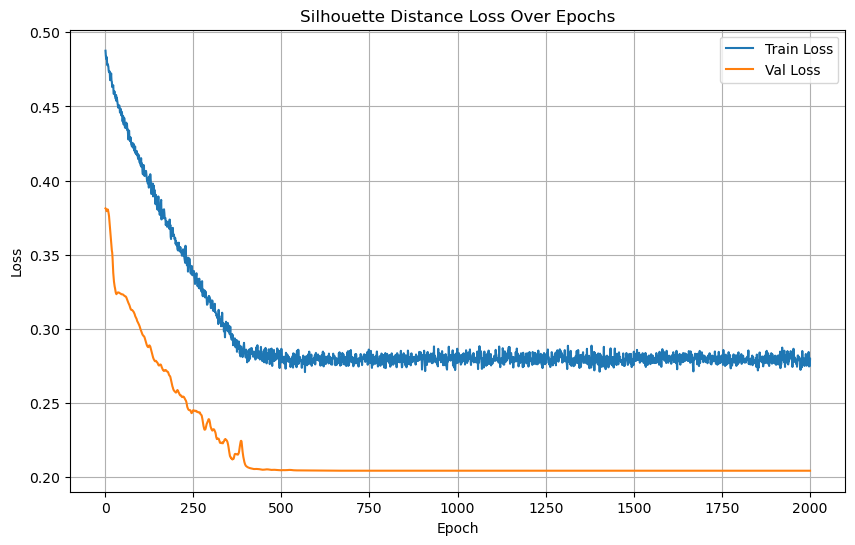

In [51]:
sclsdl_model = SupConNet().to(device)
sclsdl_criterion = SilhouetteDistanceLoss()
sclsdl_optimizer = optim.AdamW(sclsdl_model.parameters(), lr=0.0001, weight_decay=1e-5)
sclsdl_scheduler = optim.lr_scheduler.ReduceLROnPlateau(
    sclsdl_optimizer, 
    mode='min',
    patience=25,
    factor=0.1
)

sclsdl_num_epochs = 2000

sclsdl_patience = 100
sclsdl_best_val_loss = float('inf')
sclsdl_epochs_without_improvement = 0

sclsdl_train_loss_history = []
sclsdl_val_loss_history = []

for sclsdl_epoch in range(sclsdl_num_epochs):
    # Training
    sclsdl_model.train()
    sclsdl_running_train_loss = 0.0
    
    print(f"LOG: Epoch [{sclsdl_epoch+1}/{sclsdl_num_epochs}] - Training")
    for batch_idx, (vectors, labels) in enumerate(sclsdl_train_loader):

        vectors = vectors.to(device).float()
        labels = labels.to(device)

        # Forward pass
        sclsdl_train_projections = sclsdl_model(vectors)

        sclsdl_loss = sclsdl_criterion(sclsdl_train_projections, labels)

        # Backprop and optimize
        sclsdl_optimizer.zero_grad()
        sclsdl_loss.backward()
        sclsdl_optimizer.step()

        sclsdl_running_train_loss += sclsdl_loss.item()
        print(f"    Batch [{batch_idx+1}/{len(sclsdl_train_loader)}], Train Loss: {sclsdl_loss.item():.4f}")

    sclsdl_train_epoch_loss = sclsdl_running_train_loss / len(sclsdl_train_loader)
    sclsdl_train_loss_history.append(sclsdl_train_epoch_loss)

    # Validation
    sclsdl_model.eval()
    sclsdl_running_val_loss = 0.0
    print(f"LOG: Epoch [{sclsdl_epoch+1}/{sclsdl_num_epochs}] - Validation")
    with torch.no_grad():
        for val_batch_idx, (vectors, labels) in enumerate(sclsdl_val_loader):

            vectors = vectors.to(device).float()
            labels = labels.to(device)

            sclsdl_val_projections = sclsdl_model(vectors)
            sclsdl_val_batch_loss = sclsdl_criterion(sclsdl_val_projections, labels).item()
            sclsdl_running_val_loss += sclsdl_val_batch_loss
            print(f"    Batch [{val_batch_idx+1}/{len(sclsdl_val_loader)}], Val Loss: {sclsdl_val_batch_loss:.4f}")

    sclsdl_val_epoch_loss = sclsdl_running_val_loss / len(sclsdl_val_loader)
    sclsdl_val_loss_history.append(sclsdl_val_epoch_loss)
    
    sclsdl_scheduler.step(sclsdl_val_epoch_loss)

    print(f"Epoch [{sclsdl_epoch+1}/{sclsdl_num_epochs}], "
          f"Avg Train Loss: {sclsdl_train_epoch_loss:.4f}, "
          f"Avg Val Loss: {sclsdl_val_epoch_loss:.4f}\n")
    
    #early stopping logic
    if sclsdl_val_epoch_loss < sclsdl_best_val_loss:
        print(f"Validation loss improved from {sclsdl_best_val_loss:.4f} to {sclsdl_val_epoch_loss:.4f}. Saving model...")
        sclsdl_best_val_loss = sclsdl_val_epoch_loss
        sclsdl_epochs_without_improvement = 0
    else:
        sclsdl_epochs_without_improvement += 1
        print(f"!! Validation loss did NOT improve !! Patience: {sclsdl_epochs_without_improvement}/{sclsdl_patience}")

    #stop training if val loss not improving
    if sclsdl_epochs_without_improvement >= sclsdl_patience:
        print(f"!! Early stopping triggered at epoch {sclsdl_epoch + 1}!!\nNo improvement for {sclsdl_patience} epochs")
        break

plt.figure(figsize=(10,6))
sclsdl_num_epochs_run = len(sclsdl_train_loss_history)
plt.plot(range(1, sclsdl_num_epochs_run + 1), sclsdl_train_loss_history, label='Train Loss')
plt.plot(range(1, sclsdl_num_epochs_run + 1), sclsdl_val_loss_history, label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Silhouette Distance Loss Over Epochs')
plt.legend()
plt.grid(True)
plt.show()

Test Batch [10/46], Loss: 0.1446


Test Batch [20/46], Loss: 0.1554
Test Batch [30/46], Loss: 0.2154
Test Batch [40/46], Loss: 0.1782

Test Loss: 0.2253


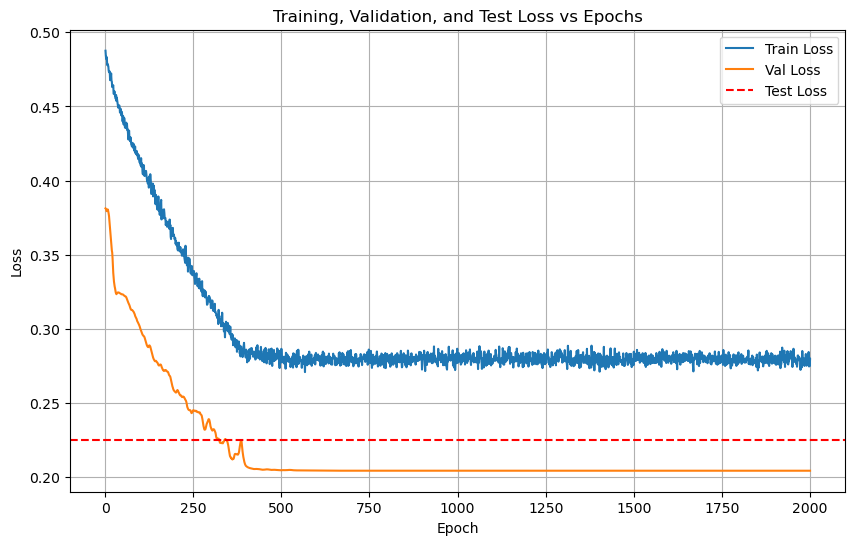

In [52]:
# Test Evaluation
sclsdl_model.eval()
sclsdl_total_test_loss = 0.0

with torch.no_grad():
    for batch_idx, (vectors, labels) in enumerate(sclsdl_test_loader):
        vectors = vectors.to(device).float()
        labels = labels.to(device)
        projections = sclsdl_model(vectors)
        loss = sclsdl_criterion(projections, labels)
        sclsdl_total_test_loss += loss.item()
        if (batch_idx + 1) % 10 == 0:
            print(f"Test Batch [{batch_idx + 1}/{len(sclsdl_test_loader)}], Loss: {loss.item():.4f}")

sclsdl_avg_test_loss = sclsdl_total_test_loss / len(sclsdl_test_loader)
print(f"\nTest Loss: {sclsdl_avg_test_loss:.4f}")


plt.figure(figsize=(10, 6))
sclsdl_num_epochs_run = len(sclsdl_train_loss_history)
plt.plot(range(1, sclsdl_num_epochs_run + 1), sclsdl_train_loss_history, label='Train Loss')
plt.plot(range(1, sclsdl_num_epochs_run + 1), sclsdl_val_loss_history, label='Val Loss')
# test loss = horizontal dashed line
plt.axhline(y=sclsdl_avg_test_loss, color='r', linestyle='--', label="Test Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training, Validation, and Test Loss vs Epochs")
plt.legend()
plt.grid(True)
plt.show()

### Saving the representations learnt by SCL w/ SDL Model

In [53]:
# dir to save the SCL representations
sclsdl_rep_dir = "sclsdl_representations"
os.makedirs(sclsdl_rep_dir, exist_ok=True)

sclsdl_loaders = {
    'train': sclsdl_train_loader,
    'val': sclsdl_val_loader,
    'test': sclsdl_test_loader
}

sclsdl_model.eval()

with torch.no_grad():
    for sclsdl_split_name, sclsdl_loader in sclsdl_loaders.items():
        print(f"\nExtracting SCL_SDL representations for the {sclsdl_split_name} dataset...")
        # creating subfolder for the split
        sclsdl_split_dir = os.path.join(sclsdl_rep_dir, sclsdl_split_name)
        os.makedirs(sclsdl_split_dir, exist_ok=True)
        
        # processing the data batch-wise
        for sclsdl_batch_idx, (sclsdl_vectors, sclsdl_labels) in enumerate(sclsdl_loader):
            sclsdl_vectors = sclsdl_vectors.to(device).float()
            # computing projections using the trained SCL model
            sclsdl_projections = sclsdl_model(sclsdl_vectors)
            
            # converting projections and labels to np arrays
            sclsdl_projections_np = sclsdl_projections.cpu().numpy()
            sclsdl_labels_np = sclsdl_labels.cpu().numpy()
            
            # saving the batch projections and labels
            np.save(os.path.join(sclsdl_split_dir, f"scl_encoded_batch_{sclsdl_batch_idx}.npy"), sclsdl_projections_np)
            np.save(os.path.join(sclsdl_split_dir, f"scl_labels_batch_{sclsdl_batch_idx}.npy"), sclsdl_labels_np)
            
            if (sclsdl_batch_idx + 1) % 10 == 0:
                print(f"  Processed batch {sclsdl_batch_idx + 1}/{len(sclsdl_loader)} for {sclsdl_split_name} dataset.")

        print(f"Completed extraction for the {sclsdl_split_name} dataset. Representations saved in '{sclsdl_split_dir}'.")

print("SCL representations extraction complete.")


Extracting SCL_SDL representations for the train dataset...
Completed extraction for the train dataset. Representations saved in 'sclsdl_representations\train'.

Extracting SCL_SDL representations for the val dataset...
Completed extraction for the val dataset. Representations saved in 'sclsdl_representations\val'.

Extracting SCL_SDL representations for the test dataset...
  Processed batch 10/46 for test dataset.
  Processed batch 20/46 for test dataset.


  Processed batch 30/46 for test dataset.
  Processed batch 40/46 for test dataset.
Completed extraction for the test dataset. Representations saved in 'sclsdl_representations\test'.
SCL representations extraction complete.


### Classifying the representations learnt by SCL w/ SDL Model with LRM

In [54]:
def load_sclsdl_reps_and_labels(split_dir):
    #gather all the scl_encoded_batch npy files in sorted order
    sclsdl_rep_files = sorted(glob.glob(os.path.join(split_dir, "scl_encoded_batch_*.npy")))

    sclsdl_all_reps = []
    sclsdl_all_labels = []

    for sclsdl_rep_file in sclsdl_rep_files:
        #deriving label filenames
        sclsdl_label_file = sclsdl_rep_file.replace("scl_encoded_batch_", "scl_labels_batch_")

        sclsdl_reps = np.load(sclsdl_rep_file)
        sclsdl_labels = np.load(sclsdl_label_file)

        sclsdl_all_reps.append(sclsdl_reps)
        sclsdl_all_labels.append(sclsdl_labels)

    #concat along first dim
    sclsdl_all_reps = np.concatenate(sclsdl_all_reps, axis = 0)
    sclsdl_all_labels = np.concatenate(sclsdl_all_labels, axis = 0)

    return sclsdl_all_reps, sclsdl_all_labels

In [55]:
sclsdl_lrm_train_dir = os.path.join("sclsdl_representations", "train")
sclsdl_lrm_val_dir   = os.path.join("sclsdl_representations", "val")
sclsdl_lrm_test_dir  = os.path.join("sclsdl_representations", "test")

sclsdl_lrm_train_reps, sclsdl_lrm_train_labels = load_sclsdl_reps_and_labels(sclsdl_lrm_train_dir)
sclsdl_lrm_val_reps, sclsdl_lrm_val_labels = load_sclsdl_reps_and_labels(sclsdl_lrm_val_dir)
sclsdl_lrm_test_reps, sclsdl_lrm_test_labels = load_sclsdl_reps_and_labels(sclsdl_lrm_test_dir)

print("Train reps shape:", sclsdl_lrm_train_reps.shape)
print("Train labels shape:", sclsdl_lrm_train_labels.shape)

print("Val reps shape:", sclsdl_lrm_val_reps.shape)
print("Val labels shape:", sclsdl_lrm_val_labels.shape)

print("Test reps shape:", sclsdl_lrm_test_reps.shape)
print("Test labels shape:", sclsdl_lrm_test_labels.shape)

Train reps shape: (280, 128)
Train labels shape: (280,)
Val reps shape: (70, 128)
Val labels shape: (70,)
Test reps shape: (2898, 128)
Test labels shape: (2898,)


In [56]:
# Train Logistic Regression Model on the SCLSDL representations
print("\nLOG: Training Logistic Regression model on SCL SDL representations...")
sclsdl_logistic_clf = LogisticRegression(max_iter=5000, random_state=42, class_weight='balanced')
sclsdl_logistic_clf.fit(sclsdl_lrm_train_reps, sclsdl_lrm_train_labels)
print("LOG: Logistic Regression training complete.")

# Evaluate on Validation Set
print("\nLOG: Evaluating on the validation set...")
sclsdl_lrm_val_predictions = sclsdl_logistic_clf.predict(sclsdl_lrm_val_reps)
sclsdl_lrm_val_accuracy = accuracy_score(sclsdl_lrm_val_labels, sclsdl_lrm_val_predictions)
print(f"Validation Accuracy: {sclsdl_lrm_val_accuracy * 100:.2f}%")
print("\nValidation Classification Report:\n", classification_report(sclsdl_lrm_val_labels, sclsdl_lrm_val_predictions))

# Evaluate on Test Set
print("\nLOG: Evaluating on the test set...")
sclsdl_lrm_test_predictions = sclsdl_logistic_clf.predict(sclsdl_lrm_test_reps)
sclsdl_lrm_test_accuracy = accuracy_score(sclsdl_lrm_test_labels, sclsdl_lrm_test_predictions)
print(f"Test Accuracy: {sclsdl_lrm_test_accuracy * 100:.2f}%")
print("\nTest Classification Report:\n", classification_report(sclsdl_lrm_test_labels, sclsdl_lrm_test_predictions))

np.save(os.path.join(predictions_dir, 'sclsdl_lrm_predictions.npy'), sclsdl_lrm_test_predictions)
np.save(os.path.join(predictions_dir, 'sclsdl_lrm_true_labels.npy'), sclsdl_lrm_test_labels)
print(f"Saved SCL_SDL+LRM predictions and true labels to {predictions_dir}")


LOG: Training Logistic Regression model on SCL SDL representations...
LOG: Logistic Regression training complete.

LOG: Evaluating on the validation set...
Validation Accuracy: 90.00%

Validation Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         5
           1       1.00      1.00      1.00         5
           2       0.83      1.00      0.91         5
           3       1.00      0.80      0.89         5
           4       1.00      0.80      0.89         5
           5       0.67      0.40      0.50         5
           6       1.00      1.00      1.00         5
           7       1.00      1.00      1.00         5
           8       0.50      0.80      0.62         5
           9       1.00      1.00      1.00         5
          10       0.83      1.00      0.91         5
          11       1.00      1.00      1.00         5
          12       1.00      1.00      1.00         5
          13       1.0

## Classifying the representations learnt by SCL w/ SDL Model with MLP Classifier

In [57]:
sclsdl_mlp_train_dir = os.path.join("sclsdl_representations", "train")
sclsdl_mlp_val_dir   = os.path.join("sclsdl_representations", "val")
sclsdl_mlp_test_dir  = os.path.join("sclsdl_representations", "test")

sclsdl_mlp_train_reps, sclsdl_mlp_train_labels = load_sclsdl_reps_and_labels(sclsdl_mlp_train_dir)
sclsdl_mlp_val_reps, sclsdl_mlp_val_labels = load_sclsdl_reps_and_labels(sclsdl_mlp_val_dir)
sclsdl_mlp_test_reps, sclsdl_mlp_test_labels = load_sclsdl_reps_and_labels(sclsdl_mlp_test_dir)

print("Train reps shape:", sclsdl_mlp_train_reps.shape)
print("Train labels shape:", sclsdl_mlp_train_labels.shape)

print("Val reps shape:", sclsdl_mlp_val_reps.shape)
print("Val labels shape:", sclsdl_mlp_val_labels.shape)

print("Test reps shape:", sclsdl_mlp_test_reps.shape)
print("Test labels shape:", sclsdl_mlp_test_labels.shape)

Train reps shape: (280, 128)
Train labels shape: (280,)
Val reps shape: (70, 128)
Val labels shape: (70,)
Test reps shape: (2898, 128)
Test labels shape: (2898,)


In [58]:
#converting arrays to torch tensors
sclsdl_mlp_train_embeddings_torch = torch.tensor(sclsdl_mlp_train_reps, dtype=torch.float32)
sclsdl_mlp_train_labels_torch = torch.tensor(sclsdl_mlp_train_labels, dtype=torch.long)

sclsdl_mlp_val_embeddings_torch = torch.tensor(sclsdl_mlp_val_reps, dtype=torch.float32)
sclsdl_mlp_val_labels_torch = torch.tensor(sclsdl_mlp_val_labels, dtype=torch.long)

sclsdl_mlp_test_embeddings_torch = torch.tensor(sclsdl_mlp_test_reps, dtype=torch.float32)
sclsdl_mlp_test_labels_torch = torch.tensor(sclsdl_mlp_test_labels, dtype=torch.long)

#building datasets for mlp
sclsdl_mlp_train_dataset = TensorDataset(sclsdl_mlp_train_embeddings_torch, sclsdl_mlp_train_labels_torch)
sclsdl_mlp_val_dataset = TensorDataset(sclsdl_mlp_val_embeddings_torch, sclsdl_mlp_val_labels_torch)
sclsdl_mlp_test_dataset = TensorDataset(sclsdl_mlp_test_embeddings_torch, sclsdl_mlp_test_labels_torch)

sclsdl_mlp_batch_size = 64
sclsdl_mlp_train_loader = DataLoader(sclsdl_mlp_train_dataset, batch_size=sclsdl_mlp_batch_size, shuffle=True)
sclsdl_mlp_val_loader = DataLoader(sclsdl_mlp_val_dataset, batch_size=sclsdl_mlp_batch_size, shuffle=False)
sclsdl_mlp_test_loader = DataLoader(sclsdl_mlp_test_dataset, batch_size=sclsdl_mlp_batch_size, shuffle=False)


[Epoch 1/1000] Train Loss: 2.6376  |  Val Loss: 2.6008
Validation loss improved from inf to 2.6008.
[Epoch 2/1000] Train Loss: 2.5936  |  Val Loss: 2.5615
Validation loss improved from 2.6008 to 2.5615.
[Epoch 3/1000] Train Loss: 2.5525  |  Val Loss: 2.5273
Validation loss improved from 2.5615 to 2.5273.
[Epoch 4/1000] Train Loss: 2.5150  |  Val Loss: 2.4950
Validation loss improved from 2.5273 to 2.4950.
[Epoch 5/1000] Train Loss: 2.4815  |  Val Loss: 2.4629
Validation loss improved from 2.4950 to 2.4629.
[Epoch 6/1000] Train Loss: 2.4465  |  Val Loss: 2.4328
Validation loss improved from 2.4629 to 2.4328.
[Epoch 7/1000] Train Loss: 2.4153  |  Val Loss: 2.4028
Validation loss improved from 2.4328 to 2.4028.
[Epoch 8/1000] Train Loss: 2.3833  |  Val Loss: 2.3738
Validation loss improved from 2.4028 to 2.3738.
[Epoch 9/1000] Train Loss: 2.3501  |  Val Loss: 2.3447
Validation loss improved from 2.3738 to 2.3447.


[Epoch 10/1000] Train Loss: 2.3194  |  Val Loss: 2.3145
Validation loss improved from 2.3447 to 2.3145.
[Epoch 11/1000] Train Loss: 2.2868  |  Val Loss: 2.2854
Validation loss improved from 2.3145 to 2.2854.
[Epoch 12/1000] Train Loss: 2.2554  |  Val Loss: 2.2573
Validation loss improved from 2.2854 to 2.2573.
[Epoch 13/1000] Train Loss: 2.2259  |  Val Loss: 2.2301
Validation loss improved from 2.2573 to 2.2301.
[Epoch 14/1000] Train Loss: 2.1973  |  Val Loss: 2.2039
Validation loss improved from 2.2301 to 2.2039.


[Epoch 15/1000] Train Loss: 2.1698  |  Val Loss: 2.1792
Validation loss improved from 2.2039 to 2.1792.
[Epoch 16/1000] Train Loss: 2.1445  |  Val Loss: 2.1551
Validation loss improved from 2.1792 to 2.1551.
[Epoch 17/1000] Train Loss: 2.1189  |  Val Loss: 2.1324
Validation loss improved from 2.1551 to 2.1324.
[Epoch 18/1000] Train Loss: 2.0955  |  Val Loss: 2.1104
Validation loss improved from 2.1324 to 2.1104.
[Epoch 19/1000] Train Loss: 2.0723  |  Val Loss: 2.0895
Validation loss improved from 2.1104 to 2.0895.


[Epoch 20/1000] Train Loss: 2.0502  |  Val Loss: 2.0689
Validation loss improved from 2.0895 to 2.0689.
[Epoch 21/1000] Train Loss: 2.0283  |  Val Loss: 2.0487
Validation loss improved from 2.0689 to 2.0487.
[Epoch 22/1000] Train Loss: 2.0062  |  Val Loss: 2.0293
Validation loss improved from 2.0487 to 2.0293.
[Epoch 23/1000] Train Loss: 1.9849  |  Val Loss: 2.0095
Validation loss improved from 2.0293 to 2.0095.
[Epoch 24/1000] Train Loss: 1.9626  |  Val Loss: 1.9893
Validation loss improved from 2.0095 to 1.9893.
[Epoch 25/1000] Train Loss: 1.9399  |  Val Loss: 1.9680
Validation loss improved from 1.9893 to 1.9680.
[Epoch 26/1000] Train Loss: 1.9170  |  Val Loss: 1.9467
Validation loss improved from 1.9680 to 1.9467.
[Epoch 27/1000] Train Loss: 1.8944  |  Val Loss: 1.9258
Validation loss improved from 1.9467 to 1.9258.
[Epoch 28/1000] Train Loss: 1.8714  |  Val Loss: 1.9055
Validation loss improved from 1.9258 to 1.9055.


[Epoch 29/1000] Train Loss: 1.8495  |  Val Loss: 1.8850
Validation loss improved from 1.9055 to 1.8850.
[Epoch 30/1000] Train Loss: 1.8269  |  Val Loss: 1.8646
Validation loss improved from 1.8850 to 1.8646.
[Epoch 31/1000] Train Loss: 1.8053  |  Val Loss: 1.8439
Validation loss improved from 1.8646 to 1.8439.
[Epoch 32/1000] Train Loss: 1.7824  |  Val Loss: 1.8238
Validation loss improved from 1.8439 to 1.8238.
[Epoch 33/1000] Train Loss: 1.7604  |  Val Loss: 1.8042
Validation loss improved from 1.8238 to 1.8042.


[Epoch 34/1000] Train Loss: 1.7387  |  Val Loss: 1.7842
Validation loss improved from 1.8042 to 1.7842.
[Epoch 35/1000] Train Loss: 1.7161  |  Val Loss: 1.7642
Validation loss improved from 1.7842 to 1.7642.
[Epoch 36/1000] Train Loss: 1.6941  |  Val Loss: 1.7442
Validation loss improved from 1.7642 to 1.7442.
[Epoch 37/1000] Train Loss: 1.6716  |  Val Loss: 1.7243
Validation loss improved from 1.7442 to 1.7243.
[Epoch 38/1000] Train Loss: 1.6497  |  Val Loss: 1.7042
Validation loss improved from 1.7243 to 1.7042.
[Epoch 39/1000] Train Loss: 1.6281  |  Val Loss: 1.6838
Validation loss improved from 1.7042 to 1.6838.


[Epoch 40/1000] Train Loss: 1.6049  |  Val Loss: 1.6639
Validation loss improved from 1.6838 to 1.6639.
[Epoch 41/1000] Train Loss: 1.5830  |  Val Loss: 1.6439
Validation loss improved from 1.6639 to 1.6439.
[Epoch 42/1000] Train Loss: 1.5603  |  Val Loss: 1.6242
Validation loss improved from 1.6439 to 1.6242.
[Epoch 43/1000] Train Loss: 1.5383  |  Val Loss: 1.6042
Validation loss improved from 1.6242 to 1.6042.
[Epoch 44/1000] Train Loss: 1.5157  |  Val Loss: 1.5845
Validation loss improved from 1.6042 to 1.5845.
[Epoch 45/1000] Train Loss: 1.4930  |  Val Loss: 1.5650
Validation loss improved from 1.5845 to 1.5650.
[Epoch 46/1000] Train Loss: 1.4710  |  Val Loss: 1.5452
Validation loss improved from 1.5650 to 1.5452.


[Epoch 47/1000] Train Loss: 1.4481  |  Val Loss: 1.5259
Validation loss improved from 1.5452 to 1.5259.
[Epoch 48/1000] Train Loss: 1.4260  |  Val Loss: 1.5062
Validation loss improved from 1.5259 to 1.5062.
[Epoch 49/1000] Train Loss: 1.4034  |  Val Loss: 1.4868
Validation loss improved from 1.5062 to 1.4868.
[Epoch 50/1000] Train Loss: 1.3815  |  Val Loss: 1.4672
Validation loss improved from 1.4868 to 1.4672.
[Epoch 51/1000] Train Loss: 1.3592  |  Val Loss: 1.4480
Validation loss improved from 1.4672 to 1.4480.
[Epoch 52/1000] Train Loss: 1.3370  |  Val Loss: 1.4290
Validation loss improved from 1.4480 to 1.4290.


[Epoch 53/1000] Train Loss: 1.3151  |  Val Loss: 1.4101
Validation loss improved from 1.4290 to 1.4101.
[Epoch 54/1000] Train Loss: 1.2930  |  Val Loss: 1.3912
Validation loss improved from 1.4101 to 1.3912.
[Epoch 55/1000] Train Loss: 1.2718  |  Val Loss: 1.3721
Validation loss improved from 1.3912 to 1.3721.
[Epoch 56/1000] Train Loss: 1.2501  |  Val Loss: 1.3530
Validation loss improved from 1.3721 to 1.3530.
[Epoch 57/1000] Train Loss: 1.2285  |  Val Loss: 1.3337
Validation loss improved from 1.3530 to 1.3337.
[Epoch 58/1000] Train Loss: 1.2068  |  Val Loss: 1.3146
Validation loss improved from 1.3337 to 1.3146.
[Epoch 59/1000] Train Loss: 1.1855  |  Val Loss: 1.2951
Validation loss improved from 1.3146 to 1.2951.


[Epoch 60/1000] Train Loss: 1.1635  |  Val Loss: 1.2757
Validation loss improved from 1.2951 to 1.2757.
[Epoch 61/1000] Train Loss: 1.1422  |  Val Loss: 1.2565
Validation loss improved from 1.2757 to 1.2565.
[Epoch 62/1000] Train Loss: 1.1214  |  Val Loss: 1.2375
Validation loss improved from 1.2565 to 1.2375.
[Epoch 63/1000] Train Loss: 1.1007  |  Val Loss: 1.2187
Validation loss improved from 1.2375 to 1.2187.


[Epoch 64/1000] Train Loss: 1.0804  |  Val Loss: 1.2001
Validation loss improved from 1.2187 to 1.2001.
[Epoch 65/1000] Train Loss: 1.0603  |  Val Loss: 1.1814
Validation loss improved from 1.2001 to 1.1814.
[Epoch 66/1000] Train Loss: 1.0400  |  Val Loss: 1.1630
Validation loss improved from 1.1814 to 1.1630.
[Epoch 67/1000] Train Loss: 1.0207  |  Val Loss: 1.1448
Validation loss improved from 1.1630 to 1.1448.
[Epoch 68/1000] Train Loss: 1.0005  |  Val Loss: 1.1270
Validation loss improved from 1.1448 to 1.1270.
[Epoch 69/1000] Train Loss: 0.9805  |  Val Loss: 1.1096
Validation loss improved from 1.1270 to 1.1096.
[Epoch 70/1000] Train Loss: 0.9612  |  Val Loss: 1.0924
Validation loss improved from 1.1096 to 1.0924.
[Epoch 71/1000] Train Loss: 0.9415  |  Val Loss: 1.0752
Validation loss improved from 1.0924 to 1.0752.


[Epoch 72/1000] Train Loss: 0.9220  |  Val Loss: 1.0580
Validation loss improved from 1.0752 to 1.0580.
[Epoch 73/1000] Train Loss: 0.9028  |  Val Loss: 1.0405
Validation loss improved from 1.0580 to 1.0405.
[Epoch 74/1000] Train Loss: 0.8835  |  Val Loss: 1.0229
Validation loss improved from 1.0405 to 1.0229.
[Epoch 75/1000] Train Loss: 0.8647  |  Val Loss: 1.0053
Validation loss improved from 1.0229 to 1.0053.
[Epoch 76/1000] Train Loss: 0.8457  |  Val Loss: 0.9885
Validation loss improved from 1.0053 to 0.9885.
[Epoch 77/1000] Train Loss: 0.8274  |  Val Loss: 0.9722
Validation loss improved from 0.9885 to 0.9722.
[Epoch 78/1000] Train Loss: 0.8090  |  Val Loss: 0.9559
Validation loss improved from 0.9722 to 0.9559.
[Epoch 79/1000] Train Loss: 0.7914  |  Val Loss: 0.9393
Validation loss improved from 0.9559 to 0.9393.


[Epoch 80/1000] Train Loss: 0.7737  |  Val Loss: 0.9226
Validation loss improved from 0.9393 to 0.9226.
[Epoch 81/1000] Train Loss: 0.7561  |  Val Loss: 0.9065
Validation loss improved from 0.9226 to 0.9065.
[Epoch 82/1000] Train Loss: 0.7391  |  Val Loss: 0.8909
Validation loss improved from 0.9065 to 0.8909.
[Epoch 83/1000] Train Loss: 0.7228  |  Val Loss: 0.8754
Validation loss improved from 0.8909 to 0.8754.
[Epoch 84/1000] Train Loss: 0.7063  |  Val Loss: 0.8602
Validation loss improved from 0.8754 to 0.8602.
[Epoch 85/1000] Train Loss: 0.6903  |  Val Loss: 0.8455
Validation loss improved from 0.8602 to 0.8455.
[Epoch 86/1000] Train Loss: 0.6744  |  Val Loss: 0.8310
Validation loss improved from 0.8455 to 0.8310.
[Epoch 87/1000] Train Loss: 0.6587  |  Val Loss: 0.8170
Validation loss improved from 0.8310 to 0.8170.
[Epoch 88/1000] Train Loss: 0.6433  |  Val Loss: 0.8031
Validation loss improved from 0.8170 to 0.8031.
[Epoch 89/1000] Train Loss: 0.6282  |  Val Loss: 0.7891
Validati

[Epoch 90/1000] Train Loss: 0.6130  |  Val Loss: 0.7755
Validation loss improved from 0.7891 to 0.7755.
[Epoch 91/1000] Train Loss: 0.5980  |  Val Loss: 0.7620
Validation loss improved from 0.7755 to 0.7620.
[Epoch 92/1000] Train Loss: 0.5836  |  Val Loss: 0.7487
Validation loss improved from 0.7620 to 0.7487.
[Epoch 93/1000] Train Loss: 0.5696  |  Val Loss: 0.7357
Validation loss improved from 0.7487 to 0.7357.
[Epoch 94/1000] Train Loss: 0.5551  |  Val Loss: 0.7228
Validation loss improved from 0.7357 to 0.7228.
[Epoch 95/1000] Train Loss: 0.5409  |  Val Loss: 0.7101
Validation loss improved from 0.7228 to 0.7101.
[Epoch 96/1000] Train Loss: 0.5273  |  Val Loss: 0.6975
Validation loss improved from 0.7101 to 0.6975.
[Epoch 97/1000] Train Loss: 0.5136  |  Val Loss: 0.6847
Validation loss improved from 0.6975 to 0.6847.
[Epoch 98/1000] Train Loss: 0.5001  |  Val Loss: 0.6726
Validation loss improved from 0.6847 to 0.6726.


[Epoch 99/1000] Train Loss: 0.4868  |  Val Loss: 0.6609
Validation loss improved from 0.6726 to 0.6609.
[Epoch 100/1000] Train Loss: 0.4742  |  Val Loss: 0.6494
Validation loss improved from 0.6609 to 0.6494.
[Epoch 101/1000] Train Loss: 0.4612  |  Val Loss: 0.6376
Validation loss improved from 0.6494 to 0.6376.
[Epoch 102/1000] Train Loss: 0.4488  |  Val Loss: 0.6258
Validation loss improved from 0.6376 to 0.6258.
[Epoch 103/1000] Train Loss: 0.4368  |  Val Loss: 0.6146
Validation loss improved from 0.6258 to 0.6146.
[Epoch 104/1000] Train Loss: 0.4249  |  Val Loss: 0.6031
Validation loss improved from 0.6146 to 0.6031.
[Epoch 105/1000] Train Loss: 0.4125  |  Val Loss: 0.5922
Validation loss improved from 0.6031 to 0.5922.
[Epoch 106/1000] Train Loss: 0.4013  |  Val Loss: 0.5811
Validation loss improved from 0.5922 to 0.5811.
[Epoch 107/1000] Train Loss: 0.3901  |  Val Loss: 0.5703
Validation loss improved from 0.5811 to 0.5703.
[Epoch 108/1000] Train Loss: 0.3790  |  Val Loss: 0.5598

[Epoch 110/1000] Train Loss: 0.3577  |  Val Loss: 0.5400
Validation loss improved from 0.5496 to 0.5400.
[Epoch 111/1000] Train Loss: 0.3478  |  Val Loss: 0.5308
Validation loss improved from 0.5400 to 0.5308.
[Epoch 112/1000] Train Loss: 0.3379  |  Val Loss: 0.5220
Validation loss improved from 0.5308 to 0.5220.
[Epoch 113/1000] Train Loss: 0.3286  |  Val Loss: 0.5129
Validation loss improved from 0.5220 to 0.5129.
[Epoch 114/1000] Train Loss: 0.3194  |  Val Loss: 0.5041
Validation loss improved from 0.5129 to 0.5041.
[Epoch 115/1000] Train Loss: 0.3106  |  Val Loss: 0.4953
Validation loss improved from 0.5041 to 0.4953.
[Epoch 116/1000] Train Loss: 0.3020  |  Val Loss: 0.4872
Validation loss improved from 0.4953 to 0.4872.
[Epoch 117/1000] Train Loss: 0.2937  |  Val Loss: 0.4798
Validation loss improved from 0.4872 to 0.4798.


[Epoch 118/1000] Train Loss: 0.2856  |  Val Loss: 0.4728
Validation loss improved from 0.4798 to 0.4728.
[Epoch 119/1000] Train Loss: 0.2783  |  Val Loss: 0.4656
Validation loss improved from 0.4728 to 0.4656.
[Epoch 120/1000] Train Loss: 0.2706  |  Val Loss: 0.4585
Validation loss improved from 0.4656 to 0.4585.
[Epoch 121/1000] Train Loss: 0.2636  |  Val Loss: 0.4515
Validation loss improved from 0.4585 to 0.4515.
[Epoch 122/1000] Train Loss: 0.2564  |  Val Loss: 0.4451
Validation loss improved from 0.4515 to 0.4451.
[Epoch 123/1000] Train Loss: 0.2500  |  Val Loss: 0.4387
Validation loss improved from 0.4451 to 0.4387.
[Epoch 124/1000] Train Loss: 0.2435  |  Val Loss: 0.4331
Validation loss improved from 0.4387 to 0.4331.
[Epoch 125/1000] Train Loss: 0.2372  |  Val Loss: 0.4280
Validation loss improved from 0.4331 to 0.4280.
[Epoch 126/1000] Train Loss: 0.2317  |  Val Loss: 0.4231
Validation loss improved from 0.4280 to 0.4231.
[Epoch 127/1000] Train Loss: 0.2260  |  Val Loss: 0.417

[Epoch 128/1000] Train Loss: 0.2207  |  Val Loss: 0.4123
Validation loss improved from 0.4176 to 0.4123.
[Epoch 129/1000] Train Loss: 0.2152  |  Val Loss: 0.4079
Validation loss improved from 0.4123 to 0.4079.
[Epoch 130/1000] Train Loss: 0.2102  |  Val Loss: 0.4027
Validation loss improved from 0.4079 to 0.4027.
[Epoch 131/1000] Train Loss: 0.2054  |  Val Loss: 0.3978
Validation loss improved from 0.4027 to 0.3978.
[Epoch 132/1000] Train Loss: 0.2009  |  Val Loss: 0.3929
Validation loss improved from 0.3978 to 0.3929.
[Epoch 133/1000] Train Loss: 0.1961  |  Val Loss: 0.3891
Validation loss improved from 0.3929 to 0.3891.
[Epoch 134/1000] Train Loss: 0.1918  |  Val Loss: 0.3857
Validation loss improved from 0.3891 to 0.3857.
[Epoch 135/1000] Train Loss: 0.1879  |  Val Loss: 0.3828
Validation loss improved from 0.3857 to 0.3828.
[Epoch 136/1000] Train Loss: 0.1837  |  Val Loss: 0.3795
Validation loss improved from 0.3828 to 0.3795.


[Epoch 137/1000] Train Loss: 0.1797  |  Val Loss: 0.3754
Validation loss improved from 0.3795 to 0.3754.
[Epoch 138/1000] Train Loss: 0.1761  |  Val Loss: 0.3718
Validation loss improved from 0.3754 to 0.3718.
[Epoch 139/1000] Train Loss: 0.1722  |  Val Loss: 0.3682
Validation loss improved from 0.3718 to 0.3682.
[Epoch 140/1000] Train Loss: 0.1689  |  Val Loss: 0.3647
Validation loss improved from 0.3682 to 0.3647.
[Epoch 141/1000] Train Loss: 0.1655  |  Val Loss: 0.3617
Validation loss improved from 0.3647 to 0.3617.
[Epoch 142/1000] Train Loss: 0.1622  |  Val Loss: 0.3588
Validation loss improved from 0.3617 to 0.3588.
[Epoch 143/1000] Train Loss: 0.1590  |  Val Loss: 0.3565
Validation loss improved from 0.3588 to 0.3565.
[Epoch 144/1000] Train Loss: 0.1560  |  Val Loss: 0.3549
Validation loss improved from 0.3565 to 0.3549.
[Epoch 145/1000] Train Loss: 0.1531  |  Val Loss: 0.3530
Validation loss improved from 0.3549 to 0.3530.
[Epoch 146/1000] Train Loss: 0.1502  |  Val Loss: 0.351

[Epoch 148/1000] Train Loss: 0.1451  |  Val Loss: 0.3490
Validation loss improved from 0.3500 to 0.3490.
[Epoch 149/1000] Train Loss: 0.1423  |  Val Loss: 0.3465
Validation loss improved from 0.3490 to 0.3465.
[Epoch 150/1000] Train Loss: 0.1399  |  Val Loss: 0.3449
Validation loss improved from 0.3465 to 0.3449.
[Epoch 151/1000] Train Loss: 0.1376  |  Val Loss: 0.3427
Validation loss improved from 0.3449 to 0.3427.
[Epoch 152/1000] Train Loss: 0.1352  |  Val Loss: 0.3405
Validation loss improved from 0.3427 to 0.3405.
[Epoch 153/1000] Train Loss: 0.1329  |  Val Loss: 0.3381
Validation loss improved from 0.3405 to 0.3381.
[Epoch 154/1000] Train Loss: 0.1307  |  Val Loss: 0.3359
Validation loss improved from 0.3381 to 0.3359.
[Epoch 155/1000] Train Loss: 0.1285  |  Val Loss: 0.3333
Validation loss improved from 0.3359 to 0.3333.


[Epoch 156/1000] Train Loss: 0.1265  |  Val Loss: 0.3308
Validation loss improved from 0.3333 to 0.3308.
[Epoch 157/1000] Train Loss: 0.1245  |  Val Loss: 0.3284
Validation loss improved from 0.3308 to 0.3284.
[Epoch 158/1000] Train Loss: 0.1225  |  Val Loss: 0.3265
Validation loss improved from 0.3284 to 0.3265.
[Epoch 159/1000] Train Loss: 0.1206  |  Val Loss: 0.3254
Validation loss improved from 0.3265 to 0.3254.
[Epoch 160/1000] Train Loss: 0.1187  |  Val Loss: 0.3243
Validation loss improved from 0.3254 to 0.3243.
[Epoch 161/1000] Train Loss: 0.1170  |  Val Loss: 0.3234
Validation loss improved from 0.3243 to 0.3234.
[Epoch 162/1000] Train Loss: 0.1152  |  Val Loss: 0.3227
Validation loss improved from 0.3234 to 0.3227.
[Epoch 163/1000] Train Loss: 0.1136  |  Val Loss: 0.3219
Validation loss improved from 0.3227 to 0.3219.
[Epoch 164/1000] Train Loss: 0.1119  |  Val Loss: 0.3213
Validation loss improved from 0.3219 to 0.3213.
[Epoch 165/1000] Train Loss: 0.1102  |  Val Loss: 0.320

[Epoch 167/1000] Train Loss: 0.1071  |  Val Loss: 0.3175
Validation loss improved from 0.3190 to 0.3175.
[Epoch 168/1000] Train Loss: 0.1058  |  Val Loss: 0.3156
Validation loss improved from 0.3175 to 0.3156.
[Epoch 169/1000] Train Loss: 0.1042  |  Val Loss: 0.3144
Validation loss improved from 0.3156 to 0.3144.
[Epoch 170/1000] Train Loss: 0.1028  |  Val Loss: 0.3130
Validation loss improved from 0.3144 to 0.3130.
[Epoch 171/1000] Train Loss: 0.1014  |  Val Loss: 0.3115
Validation loss improved from 0.3130 to 0.3115.
[Epoch 172/1000] Train Loss: 0.1001  |  Val Loss: 0.3109
Validation loss improved from 0.3115 to 0.3109.
[Epoch 173/1000] Train Loss: 0.0987  |  Val Loss: 0.3091
Validation loss improved from 0.3109 to 0.3091.
[Epoch 174/1000] Train Loss: 0.0975  |  Val Loss: 0.3078
Validation loss improved from 0.3091 to 0.3078.


[Epoch 175/1000] Train Loss: 0.0961  |  Val Loss: 0.3081
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 176/1000] Train Loss: 0.0948  |  Val Loss: 0.3089
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 177/1000] Train Loss: 0.0936  |  Val Loss: 0.3099
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 178/1000] Train Loss: 0.0927  |  Val Loss: 0.3106
!! Validation loss did NOT improve !! Patience: 4/100
[Epoch 179/1000] Train Loss: 0.0916  |  Val Loss: 0.3110
!! Validation loss did NOT improve !! Patience: 5/100
[Epoch 180/1000] Train Loss: 0.0905  |  Val Loss: 0.3107
!! Validation loss did NOT improve !! Patience: 6/100
[Epoch 181/1000] Train Loss: 0.0894  |  Val Loss: 0.3091
!! Validation loss did NOT improve !! Patience: 7/100
[Epoch 182/1000] Train Loss: 0.0883  |  Val Loss: 0.3076
Validation loss improved from 0.3078 to 0.3076.
[Epoch 183/1000] Train Loss: 0.0871  |  Val Loss: 0.3064
Validation loss improved from 0.3076 to 0.3064.
[Epoch 184/10

[Epoch 187/1000] Train Loss: 0.0828  |  Val Loss: 0.2996
Validation loss improved from 0.3010 to 0.2996.
[Epoch 188/1000] Train Loss: 0.0818  |  Val Loss: 0.2991
Validation loss improved from 0.2996 to 0.2991.
[Epoch 189/1000] Train Loss: 0.0808  |  Val Loss: 0.2975
Validation loss improved from 0.2991 to 0.2975.
[Epoch 190/1000] Train Loss: 0.0799  |  Val Loss: 0.2958
Validation loss improved from 0.2975 to 0.2958.
[Epoch 191/1000] Train Loss: 0.0790  |  Val Loss: 0.2951
Validation loss improved from 0.2958 to 0.2951.
[Epoch 192/1000] Train Loss: 0.0781  |  Val Loss: 0.2941
Validation loss improved from 0.2951 to 0.2941.
[Epoch 193/1000] Train Loss: 0.0772  |  Val Loss: 0.2946
!! Validation loss did NOT improve !! Patience: 1/100


[Epoch 194/1000] Train Loss: 0.0762  |  Val Loss: 0.2944
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 195/1000] Train Loss: 0.0754  |  Val Loss: 0.2941
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 196/1000] Train Loss: 0.0745  |  Val Loss: 0.2934
Validation loss improved from 0.2941 to 0.2934.
[Epoch 197/1000] Train Loss: 0.0737  |  Val Loss: 0.2933
Validation loss improved from 0.2934 to 0.2933.
[Epoch 198/1000] Train Loss: 0.0729  |  Val Loss: 0.2932
Validation loss improved from 0.2933 to 0.2932.
[Epoch 199/1000] Train Loss: 0.0721  |  Val Loss: 0.2944
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 200/1000] Train Loss: 0.0714  |  Val Loss: 0.2949
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 201/1000] Train Loss: 0.0706  |  Val Loss: 0.2934
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 202/1000] Train Loss: 0.0696  |  Val Loss: 0.2939
!! Validation loss did NOT improve !! Patience: 4/100
[Epoch 203/1000] Tr

[Epoch 207/1000] Train Loss: 0.0660  |  Val Loss: 0.2920
Validation loss improved from 0.2932 to 0.2920.
[Epoch 208/1000] Train Loss: 0.0652  |  Val Loss: 0.2913
Validation loss improved from 0.2920 to 0.2913.
[Epoch 209/1000] Train Loss: 0.0647  |  Val Loss: 0.2911
Validation loss improved from 0.2913 to 0.2911.
[Epoch 210/1000] Train Loss: 0.0641  |  Val Loss: 0.2910
Validation loss improved from 0.2911 to 0.2910.
[Epoch 211/1000] Train Loss: 0.0634  |  Val Loss: 0.2906
Validation loss improved from 0.2910 to 0.2906.
[Epoch 212/1000] Train Loss: 0.0627  |  Val Loss: 0.2902
Validation loss improved from 0.2906 to 0.2902.


[Epoch 213/1000] Train Loss: 0.0621  |  Val Loss: 0.2897
Validation loss improved from 0.2902 to 0.2897.
[Epoch 214/1000] Train Loss: 0.0614  |  Val Loss: 0.2898
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 215/1000] Train Loss: 0.0608  |  Val Loss: 0.2905
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 216/1000] Train Loss: 0.0602  |  Val Loss: 0.2905
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 217/1000] Train Loss: 0.0596  |  Val Loss: 0.2909
!! Validation loss did NOT improve !! Patience: 4/100
[Epoch 218/1000] Train Loss: 0.0590  |  Val Loss: 0.2910
!! Validation loss did NOT improve !! Patience: 5/100
[Epoch 219/1000] Train Loss: 0.0586  |  Val Loss: 0.2908
!! Validation loss did NOT improve !! Patience: 6/100
[Epoch 220/1000] Train Loss: 0.0580  |  Val Loss: 0.2915
!! Validation loss did NOT improve !! Patience: 7/100
[Epoch 221/1000] Train Loss: 0.0574  |  Val Loss: 0.2911
!! Validation loss did NOT improve !! Patience: 8/100
[Epoch 

[Epoch 226/1000] Train Loss: 0.0547  |  Val Loss: 0.2893
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 227/1000] Train Loss: 0.0543  |  Val Loss: 0.2895
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 228/1000] Train Loss: 0.0538  |  Val Loss: 0.2893
!! Validation loss did NOT improve !! Patience: 4/100
[Epoch 229/1000] Train Loss: 0.0533  |  Val Loss: 0.2883
Validation loss improved from 0.2888 to 0.2883.
[Epoch 230/1000] Train Loss: 0.0528  |  Val Loss: 0.2873
Validation loss improved from 0.2883 to 0.2873.


[Epoch 231/1000] Train Loss: 0.0523  |  Val Loss: 0.2872
Validation loss improved from 0.2873 to 0.2872.
[Epoch 232/1000] Train Loss: 0.0519  |  Val Loss: 0.2872
Validation loss improved from 0.2872 to 0.2872.
[Epoch 233/1000] Train Loss: 0.0514  |  Val Loss: 0.2873
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 234/1000] Train Loss: 0.0509  |  Val Loss: 0.2868
Validation loss improved from 0.2872 to 0.2868.
[Epoch 235/1000] Train Loss: 0.0505  |  Val Loss: 0.2867
Validation loss improved from 0.2868 to 0.2867.
[Epoch 236/1000] Train Loss: 0.0501  |  Val Loss: 0.2868
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 237/1000] Train Loss: 0.0496  |  Val Loss: 0.2878
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 238/1000] Train Loss: 0.0493  |  Val Loss: 0.2886
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 239/1000] Train Loss: 0.0489  |  Val Loss: 0.2884
!! Validation loss did NOT improve !! Patience: 4/100
[Epoch 240/1000] Train Lo

[Epoch 244/1000] Train Loss: 0.0468  |  Val Loss: 0.2895
!! Validation loss did NOT improve !! Patience: 9/100
[Epoch 245/1000] Train Loss: 0.0464  |  Val Loss: 0.2901
!! Validation loss did NOT improve !! Patience: 10/100
[Epoch 246/1000] Train Loss: 0.0461  |  Val Loss: 0.2898
!! Validation loss did NOT improve !! Patience: 11/100
[Epoch 247/1000] Train Loss: 0.0456  |  Val Loss: 0.2892
!! Validation loss did NOT improve !! Patience: 12/100
[Epoch 248/1000] Train Loss: 0.0453  |  Val Loss: 0.2880
!! Validation loss did NOT improve !! Patience: 13/100


[Epoch 249/1000] Train Loss: 0.0449  |  Val Loss: 0.2880
!! Validation loss did NOT improve !! Patience: 14/100
[Epoch 250/1000] Train Loss: 0.0446  |  Val Loss: 0.2878
!! Validation loss did NOT improve !! Patience: 15/100
[Epoch 251/1000] Train Loss: 0.0442  |  Val Loss: 0.2878
!! Validation loss did NOT improve !! Patience: 16/100
[Epoch 252/1000] Train Loss: 0.0438  |  Val Loss: 0.2879
!! Validation loss did NOT improve !! Patience: 17/100
[Epoch 253/1000] Train Loss: 0.0436  |  Val Loss: 0.2884
!! Validation loss did NOT improve !! Patience: 18/100
[Epoch 254/1000] Train Loss: 0.0431  |  Val Loss: 0.2883
!! Validation loss did NOT improve !! Patience: 19/100
[Epoch 255/1000] Train Loss: 0.0428  |  Val Loss: 0.2891
!! Validation loss did NOT improve !! Patience: 20/100
[Epoch 256/1000] Train Loss: 0.0424  |  Val Loss: 0.2890
!! Validation loss did NOT improve !! Patience: 21/100
[Epoch 257/1000] Train Loss: 0.0421  |  Val Loss: 0.2882
!! Validation loss did NOT improve !! Patience:

[Epoch 261/1000] Train Loss: 0.0408  |  Val Loss: 0.2868
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 262/1000] Train Loss: 0.0405  |  Val Loss: 0.2871
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 263/1000] Train Loss: 0.0402  |  Val Loss: 0.2878
!! Validation loss did NOT improve !! Patience: 4/100
[Epoch 264/1000] Train Loss: 0.0399  |  Val Loss: 0.2884
!! Validation loss did NOT improve !! Patience: 5/100
[Epoch 265/1000] Train Loss: 0.0396  |  Val Loss: 0.2888
!! Validation loss did NOT improve !! Patience: 6/100
[Epoch 266/1000] Train Loss: 0.0393  |  Val Loss: 0.2893
!! Validation loss did NOT improve !! Patience: 7/100
[Epoch 267/1000] Train Loss: 0.0390  |  Val Loss: 0.2890
!! Validation loss did NOT improve !! Patience: 8/100


[Epoch 268/1000] Train Loss: 0.0386  |  Val Loss: 0.2905
!! Validation loss did NOT improve !! Patience: 9/100
[Epoch 269/1000] Train Loss: 0.0384  |  Val Loss: 0.2910
!! Validation loss did NOT improve !! Patience: 10/100
[Epoch 270/1000] Train Loss: 0.0381  |  Val Loss: 0.2918
!! Validation loss did NOT improve !! Patience: 11/100
[Epoch 271/1000] Train Loss: 0.0378  |  Val Loss: 0.2915
!! Validation loss did NOT improve !! Patience: 12/100
[Epoch 272/1000] Train Loss: 0.0375  |  Val Loss: 0.2917
!! Validation loss did NOT improve !! Patience: 13/100
[Epoch 273/1000] Train Loss: 0.0372  |  Val Loss: 0.2913
!! Validation loss did NOT improve !! Patience: 14/100
[Epoch 274/1000] Train Loss: 0.0370  |  Val Loss: 0.2917
!! Validation loss did NOT improve !! Patience: 15/100
[Epoch 275/1000] Train Loss: 0.0366  |  Val Loss: 0.2902
!! Validation loss did NOT improve !! Patience: 16/100
[Epoch 276/1000] Train Loss: 0.0363  |  Val Loss: 0.2883
!! Validation loss did NOT improve !! Patience: 

[Epoch 280/1000] Train Loss: 0.0353  |  Val Loss: 0.2899
!! Validation loss did NOT improve !! Patience: 21/100
[Epoch 281/1000] Train Loss: 0.0350  |  Val Loss: 0.2913
!! Validation loss did NOT improve !! Patience: 22/100
[Epoch 282/1000] Train Loss: 0.0347  |  Val Loss: 0.2922
!! Validation loss did NOT improve !! Patience: 23/100
[Epoch 283/1000] Train Loss: 0.0345  |  Val Loss: 0.2930
!! Validation loss did NOT improve !! Patience: 24/100
[Epoch 284/1000] Train Loss: 0.0343  |  Val Loss: 0.2937
!! Validation loss did NOT improve !! Patience: 25/100
[Epoch 285/1000] Train Loss: 0.0340  |  Val Loss: 0.2959
!! Validation loss did NOT improve !! Patience: 26/100
[Epoch 286/1000] Train Loss: 0.0338  |  Val Loss: 0.2971
!! Validation loss did NOT improve !! Patience: 27/100


[Epoch 287/1000] Train Loss: 0.0336  |  Val Loss: 0.2975
!! Validation loss did NOT improve !! Patience: 28/100
[Epoch 288/1000] Train Loss: 0.0333  |  Val Loss: 0.2967
!! Validation loss did NOT improve !! Patience: 29/100
[Epoch 289/1000] Train Loss: 0.0330  |  Val Loss: 0.2959
!! Validation loss did NOT improve !! Patience: 30/100
[Epoch 290/1000] Train Loss: 0.0329  |  Val Loss: 0.2947
!! Validation loss did NOT improve !! Patience: 31/100
[Epoch 291/1000] Train Loss: 0.0325  |  Val Loss: 0.2958
!! Validation loss did NOT improve !! Patience: 32/100
[Epoch 292/1000] Train Loss: 0.0322  |  Val Loss: 0.2968
!! Validation loss did NOT improve !! Patience: 33/100
[Epoch 293/1000] Train Loss: 0.0320  |  Val Loss: 0.2969
!! Validation loss did NOT improve !! Patience: 34/100
[Epoch 294/1000] Train Loss: 0.0318  |  Val Loss: 0.2971
!! Validation loss did NOT improve !! Patience: 35/100
[Epoch 295/1000] Train Loss: 0.0316  |  Val Loss: 0.2961
!! Validation loss did NOT improve !! Patience:

[Epoch 300/1000] Train Loss: 0.0304  |  Val Loss: 0.2973
!! Validation loss did NOT improve !! Patience: 41/100
[Epoch 301/1000] Train Loss: 0.0302  |  Val Loss: 0.2982
!! Validation loss did NOT improve !! Patience: 42/100
[Epoch 302/1000] Train Loss: 0.0300  |  Val Loss: 0.2986
!! Validation loss did NOT improve !! Patience: 43/100
[Epoch 303/1000] Train Loss: 0.0297  |  Val Loss: 0.2987
!! Validation loss did NOT improve !! Patience: 44/100
[Epoch 304/1000] Train Loss: 0.0295  |  Val Loss: 0.2984
!! Validation loss did NOT improve !! Patience: 45/100
[Epoch 305/1000] Train Loss: 0.0294  |  Val Loss: 0.2971
!! Validation loss did NOT improve !! Patience: 46/100


[Epoch 306/1000] Train Loss: 0.0291  |  Val Loss: 0.2987
!! Validation loss did NOT improve !! Patience: 47/100
[Epoch 307/1000] Train Loss: 0.0288  |  Val Loss: 0.2990
!! Validation loss did NOT improve !! Patience: 48/100
[Epoch 308/1000] Train Loss: 0.0286  |  Val Loss: 0.2986
!! Validation loss did NOT improve !! Patience: 49/100
[Epoch 309/1000] Train Loss: 0.0284  |  Val Loss: 0.2985
!! Validation loss did NOT improve !! Patience: 50/100
[Epoch 310/1000] Train Loss: 0.0282  |  Val Loss: 0.2970
!! Validation loss did NOT improve !! Patience: 51/100
[Epoch 311/1000] Train Loss: 0.0280  |  Val Loss: 0.2965
!! Validation loss did NOT improve !! Patience: 52/100
[Epoch 312/1000] Train Loss: 0.0278  |  Val Loss: 0.2957
!! Validation loss did NOT improve !! Patience: 53/100
[Epoch 313/1000] Train Loss: 0.0277  |  Val Loss: 0.2958
!! Validation loss did NOT improve !! Patience: 54/100
[Epoch 314/1000] Train Loss: 0.0275  |  Val Loss: 0.2954
!! Validation loss did NOT improve !! Patience:

[Epoch 319/1000] Train Loss: 0.0265  |  Val Loss: 0.2982
!! Validation loss did NOT improve !! Patience: 60/100
[Epoch 320/1000] Train Loss: 0.0263  |  Val Loss: 0.2987
!! Validation loss did NOT improve !! Patience: 61/100
[Epoch 321/1000] Train Loss: 0.0262  |  Val Loss: 0.2996
!! Validation loss did NOT improve !! Patience: 62/100
[Epoch 322/1000] Train Loss: 0.0259  |  Val Loss: 0.3003
!! Validation loss did NOT improve !! Patience: 63/100
[Epoch 323/1000] Train Loss: 0.0258  |  Val Loss: 0.3003
!! Validation loss did NOT improve !! Patience: 64/100
[Epoch 324/1000] Train Loss: 0.0256  |  Val Loss: 0.3025
!! Validation loss did NOT improve !! Patience: 65/100
[Epoch 325/1000] Train Loss: 0.0255  |  Val Loss: 0.3040
!! Validation loss did NOT improve !! Patience: 66/100


[Epoch 326/1000] Train Loss: 0.0253  |  Val Loss: 0.3039
!! Validation loss did NOT improve !! Patience: 67/100
[Epoch 327/1000] Train Loss: 0.0251  |  Val Loss: 0.3031
!! Validation loss did NOT improve !! Patience: 68/100
[Epoch 328/1000] Train Loss: 0.0249  |  Val Loss: 0.3021
!! Validation loss did NOT improve !! Patience: 69/100
[Epoch 329/1000] Train Loss: 0.0247  |  Val Loss: 0.3015
!! Validation loss did NOT improve !! Patience: 70/100
[Epoch 330/1000] Train Loss: 0.0245  |  Val Loss: 0.3022
!! Validation loss did NOT improve !! Patience: 71/100
[Epoch 331/1000] Train Loss: 0.0244  |  Val Loss: 0.3023
!! Validation loss did NOT improve !! Patience: 72/100
[Epoch 332/1000] Train Loss: 0.0242  |  Val Loss: 0.3031
!! Validation loss did NOT improve !! Patience: 73/100
[Epoch 333/1000] Train Loss: 0.0240  |  Val Loss: 0.3029
!! Validation loss did NOT improve !! Patience: 74/100
[Epoch 334/1000] Train Loss: 0.0238  |  Val Loss: 0.3034
!! Validation loss did NOT improve !! Patience:

[Epoch 338/1000] Train Loss: 0.0232  |  Val Loss: 0.3018
!! Validation loss did NOT improve !! Patience: 79/100
[Epoch 339/1000] Train Loss: 0.0230  |  Val Loss: 0.3017
!! Validation loss did NOT improve !! Patience: 80/100
[Epoch 340/1000] Train Loss: 0.0229  |  Val Loss: 0.3017
!! Validation loss did NOT improve !! Patience: 81/100
[Epoch 341/1000] Train Loss: 0.0227  |  Val Loss: 0.3024
!! Validation loss did NOT improve !! Patience: 82/100
[Epoch 342/1000] Train Loss: 0.0226  |  Val Loss: 0.3028
!! Validation loss did NOT improve !! Patience: 83/100
[Epoch 343/1000] Train Loss: 0.0224  |  Val Loss: 0.3028
!! Validation loss did NOT improve !! Patience: 84/100
[Epoch 344/1000] Train Loss: 0.0223  |  Val Loss: 0.3029
!! Validation loss did NOT improve !! Patience: 85/100
[Epoch 345/1000] Train Loss: 0.0221  |  Val Loss: 0.3032
!! Validation loss did NOT improve !! Patience: 86/100
[Epoch 346/1000] Train Loss: 0.0220  |  Val Loss: 0.3039
!! Validation loss did NOT improve !! Patience:

[Epoch 347/1000] Train Loss: 0.0219  |  Val Loss: 0.3042
!! Validation loss did NOT improve !! Patience: 88/100
[Epoch 348/1000] Train Loss: 0.0217  |  Val Loss: 0.3064
!! Validation loss did NOT improve !! Patience: 89/100
[Epoch 349/1000] Train Loss: 0.0216  |  Val Loss: 0.3076
!! Validation loss did NOT improve !! Patience: 90/100
[Epoch 350/1000] Train Loss: 0.0214  |  Val Loss: 0.3078
!! Validation loss did NOT improve !! Patience: 91/100
[Epoch 351/1000] Train Loss: 0.0213  |  Val Loss: 0.3084
!! Validation loss did NOT improve !! Patience: 92/100
[Epoch 352/1000] Train Loss: 0.0211  |  Val Loss: 0.3084
!! Validation loss did NOT improve !! Patience: 93/100
[Epoch 353/1000] Train Loss: 0.0210  |  Val Loss: 0.3080
!! Validation loss did NOT improve !! Patience: 94/100
[Epoch 354/1000] Train Loss: 0.0208  |  Val Loss: 0.3075
!! Validation loss did NOT improve !! Patience: 95/100
[Epoch 355/1000] Train Loss: 0.0207  |  Val Loss: 0.3062
!! Validation loss did NOT improve !! Patience:

[Epoch 356/1000] Train Loss: 0.0206  |  Val Loss: 0.3058
!! Validation loss did NOT improve !! Patience: 97/100
[Epoch 357/1000] Train Loss: 0.0204  |  Val Loss: 0.3058
!! Validation loss did NOT improve !! Patience: 98/100
[Epoch 358/1000] Train Loss: 0.0202  |  Val Loss: 0.3063
!! Validation loss did NOT improve !! Patience: 99/100
[Epoch 359/1000] Train Loss: 0.0201  |  Val Loss: 0.3064
!! Validation loss did NOT improve !! Patience: 100/100
!! Early stopping triggered at epoch 359 !!
No improvement for 100 epochs.


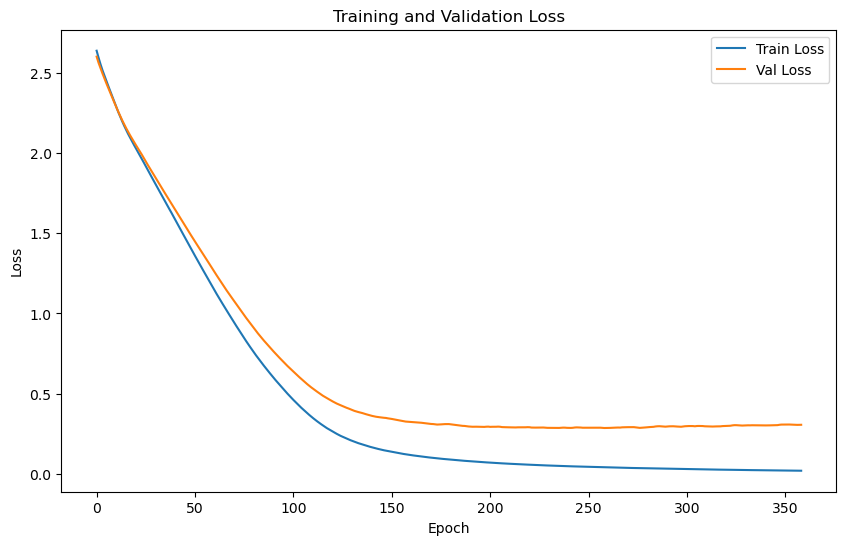

In [59]:
sclsdl_mlp_input_dim = sclsdl_mlp_train_reps.shape[1]
sclsdl_mlp_num_classes = len(torch.unique(sclsdl_mlp_train_labels_torch))
sclsdl_mlp_model = MLPClassifier(sclsdl_mlp_input_dim, sclsdl_mlp_num_classes).to(device)

sclsdl_mlp_criterion = nn.CrossEntropyLoss()
sclsdl_mlp_optimizer = optim.Adam(sclsdl_mlp_model.parameters(), lr=1e-4)

sclsdl_mlp_num_epochs = 1000
sclsdl_mlp_patience = 100

sclsdl_mlp_train_losses = []
sclsdl_mlp_val_losses = []

sclsdl_mlp_best_val_loss = float('inf')
sclsdl_mlp_epochs_without_improvement = 0

for sclsdl_mlp_epoch in range(sclsdl_mlp_num_epochs):
    # Training
    sclsdl_mlp_model.train()
    sclsdl_mlp_train_running_loss = 0.0
    
    for sclsdl_mlp_embeddings_batch, sclsdl_mlp_labels_batch in sclsdl_mlp_train_loader:
        sclsdl_mlp_embeddings_batch = sclsdl_mlp_embeddings_batch.to(device)
        sclsdl_mlp_labels_batch = sclsdl_mlp_labels_batch.to(device)
        
        sclsdl_mlp_optimizer.zero_grad()
        
        # Forward
        sclsdl_mlp_outputs = sclsdl_mlp_model(sclsdl_mlp_embeddings_batch)
        sclsdl_mlp_loss = sclsdl_mlp_criterion(sclsdl_mlp_outputs, sclsdl_mlp_labels_batch)
        
        # Backward & Update
        sclsdl_mlp_loss.backward()
        sclsdl_mlp_optimizer.step()
        
        sclsdl_mlp_train_running_loss += sclsdl_mlp_loss.item() * sclsdl_mlp_embeddings_batch.size(0)
    
    sclsdl_mlp_epoch_train_loss = sclsdl_mlp_train_running_loss / len(sclsdl_mlp_train_loader.dataset)
    sclsdl_mlp_train_losses.append(sclsdl_mlp_epoch_train_loss)

    # Validation
    sclsdl_mlp_model.eval()
    sclsdl_mlp_val_running_loss = 0.0
    
    with torch.no_grad():
        for sclsdl_mlp_val_embeddings_batch, sclsdl_mlp_val_labels_batch in sclsdl_mlp_val_loader:
            sclsdl_mlp_val_embeddings_batch = sclsdl_mlp_val_embeddings_batch.to(device)
            sclsdl_mlp_val_labels_batch = sclsdl_mlp_val_labels_batch.to(device)

            sclsdl_mlp_val_outputs = sclsdl_mlp_model(sclsdl_mlp_val_embeddings_batch)
            sclsdl_mlp_val_loss = sclsdl_mlp_criterion(sclsdl_mlp_val_outputs, sclsdl_mlp_val_labels_batch)

            sclsdl_mlp_val_running_loss += sclsdl_mlp_val_loss.item() * sclsdl_mlp_val_embeddings_batch.size(0)

    sclsdl_mlp_epoch_val_loss = sclsdl_mlp_val_running_loss / len(sclsdl_mlp_val_loader.dataset)
    sclsdl_mlp_val_losses.append(sclsdl_mlp_epoch_val_loss)

    print(f"[Epoch {sclsdl_mlp_epoch+1}/{sclsdl_mlp_num_epochs}] "
          f"Train Loss: {sclsdl_mlp_epoch_train_loss:.4f}  |  "
          f"Val Loss: {sclsdl_mlp_epoch_val_loss:.4f}")

    # Early stopping
    if sclsdl_mlp_epoch_val_loss < sclsdl_mlp_best_val_loss:
        print(f"Validation loss improved from {sclsdl_mlp_best_val_loss:.4f} to {sclsdl_mlp_epoch_val_loss:.4f}.")
        sclsdl_mlp_best_val_loss = sclsdl_mlp_epoch_val_loss
        sclsdl_mlp_epochs_without_improvement = 0


    else:
        sclsdl_mlp_epochs_without_improvement += 1
        print(f"!! Validation loss did NOT improve !! "
              f"Patience: {sclsdl_mlp_epochs_without_improvement}/{sclsdl_mlp_patience}")
        
        if sclsdl_mlp_epochs_without_improvement >= sclsdl_mlp_patience:
            print(f"!! Early stopping triggered at epoch {sclsdl_mlp_epoch+1} !!\n"
                  f"No improvement for {sclsdl_mlp_patience} epochs.")
            break

plt.figure(figsize=(10,6))
plt.plot(sclsdl_mlp_train_losses, label='Train Loss')
plt.plot(sclsdl_mlp_val_losses,   label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()


Saved SCL_SDL+MLP predictions and true labels to model_predictions
Test Loss: 0.3588 | Test Accuracy: 88.58%


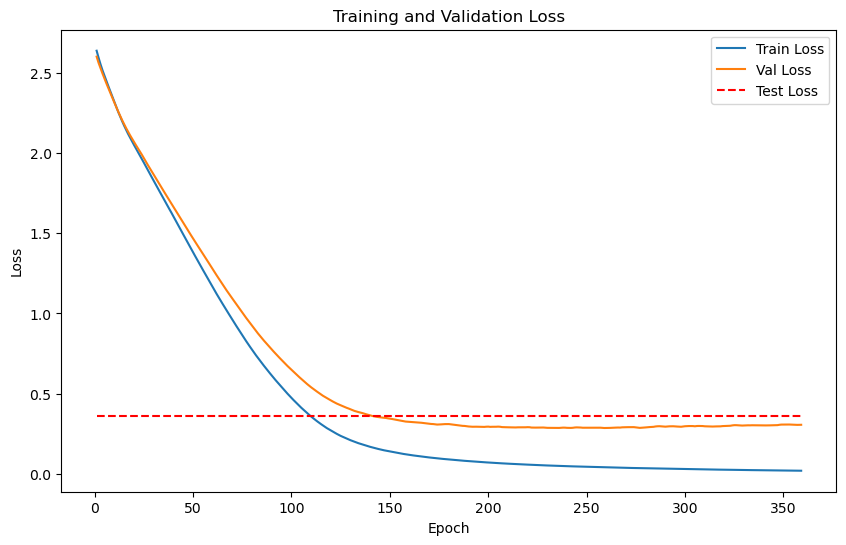

In [60]:
sclsdl_mlp_model.eval()

sclsdl_mlp_test_running_loss = 0.0
sclsdl_mlp_test_correct = 0
sclsdl_mlp_all_predictions = []
sclsdl_mlp_all_true_labels = []

with torch.no_grad():
    for sclsdl_mlp_test_embeddings_batch, sclsdl_mlp_test_labels_batch in sclsdl_mlp_test_loader:
        sclsdl_mlp_test_embeddings_batch = sclsdl_mlp_test_embeddings_batch.to(device)
        sclsdl_mlp_test_labels_batch = sclsdl_mlp_test_labels_batch.to(device)

        # Forward pass
        sclsdl_mlp_test_outputs = sclsdl_mlp_model(sclsdl_mlp_test_embeddings_batch)
        
        # Compute loss
        sclsdl_mlp_test_loss_batch = sclsdl_mlp_criterion(sclsdl_mlp_test_outputs, sclsdl_mlp_test_labels_batch)
        sclsdl_mlp_test_running_loss += sclsdl_mlp_test_loss_batch.item() * sclsdl_mlp_test_embeddings_batch.size(0)

        _, sclsdl_mlp_test_predicted = torch.max(sclsdl_mlp_test_outputs, dim=1)
        sclsdl_mlp_test_correct += (sclsdl_mlp_test_predicted == sclsdl_mlp_test_labels_batch).sum().item()

        sclsdl_mlp_all_predictions.extend(sclsdl_mlp_test_predicted.cpu().numpy())
        sclsdl_mlp_all_true_labels.extend(sclsdl_mlp_test_labels_batch.cpu().numpy())

np.save(os.path.join(predictions_dir, 'sclsdl_mlp_predictions.npy'), np.array(sclsdl_mlp_all_predictions))
np.save(os.path.join(predictions_dir, 'sclsdl_mlp_true_labels.npy'), np.array(sclsdl_mlp_all_true_labels))
print(f"Saved SCL_SDL+MLP predictions and true labels to {predictions_dir}")

sclsdl_mlp_epoch_test_loss = sclsdl_mlp_test_running_loss / len(sclsdl_mlp_test_loader.dataset)
sclsdl_mlp_test_accuracy = sclsdl_mlp_test_correct / len(sclsdl_mlp_test_loader.dataset)

sclsdl_mlp_test_accuracy_pct = sclsdl_mlp_test_accuracy * 100.0

print(f"Test Loss: {sclsdl_mlp_epoch_test_loss:.4f} | Test Accuracy: {sclsdl_mlp_test_accuracy_pct:.2f}%")

sclsdl_mlp_num_epochs_run = len(sclsdl_mlp_train_losses)

plt.figure(figsize=(10,6))

plt.plot(range(1, sclsdl_mlp_num_epochs_run + 1),
         sclsdl_mlp_train_losses,
         label='Train Loss')
plt.plot(range(1, sclsdl_mlp_num_epochs_run + 1),
         sclsdl_mlp_val_losses,
         label='Val Loss')

plt.plot(range(1, sclsdl_mlp_num_epochs_run + 1),
         [sclsdl_mlp_epoch_test_loss]*sclsdl_mlp_num_epochs_run,
         'r--',
         label='Test Loss')

plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()


## Experimental Results and Confusion Matrices

In [61]:
def plot_conf_matrix(model_name, class_names = None, cm_save_dir='confusion_matrices'):
    os.makedirs(cm_save_dir, exist_ok = True)

    #loading predictions and true labels
    predictions_path = os.path.join(predictions_dir, f'{model_name}_predictions.npy')
    true_labels_path = os.path.join(predictions_dir, f'{model_name}_true_labels.npy')

    if not os.path.exists(predictions_path) or not os.path.exists(true_labels_path):
        print(f"Error: Files not found for model {model_name}")
        return
    
    cm_predictions = np.load(predictions_path)
    cm_true_labels = np.load(true_labels_path)

    conf_matrix = confusion_matrix(cm_true_labels, cm_predictions)
    plt.figure(figsize=(8,8))

    conf_matrix_normalised = conf_matrix.astype('float') / conf_matrix.sum(axis = 1)[:, np.newaxis]
    sns.heatmap(conf_matrix_normalised, annot=conf_matrix, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)

    plt.title(f"{model_name.upper()} Confusion Matrix", fontsize=16)
    plt.ylabel('True Label', fontsize=12)
    plt.xlabel('Predicted Label', fontsize=12)
    plt.tight_layout()

    cm_save_path = os.path.join(cm_save_dir, f'{model_name}_confusion_matrix.png')
    plt.savefig(cm_save_path, dpi=300, bbox_inches='tight')
    print(f"Saved confusion matrix to: {cm_save_path}")

    plt.show()

    accuracy = np.trace(conf_matrix) / np.sum(conf_matrix)
    print(f"Classification Accuracy: {accuracy*100:.2f}%")

Saving confusion matrices to: confusion_matrices


Saved confusion matrix to: confusion_matrices\e2e_cnn_confusion_matrix.png


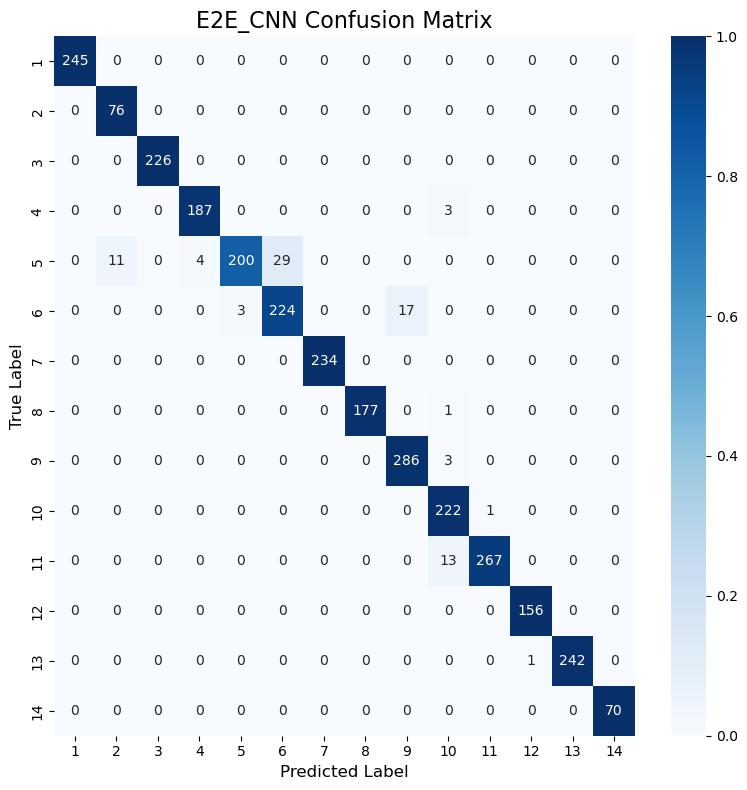

Classification Accuracy: 97.03%


Saved confusion matrix to: confusion_matrices\cae_lrm_confusion_matrix.png


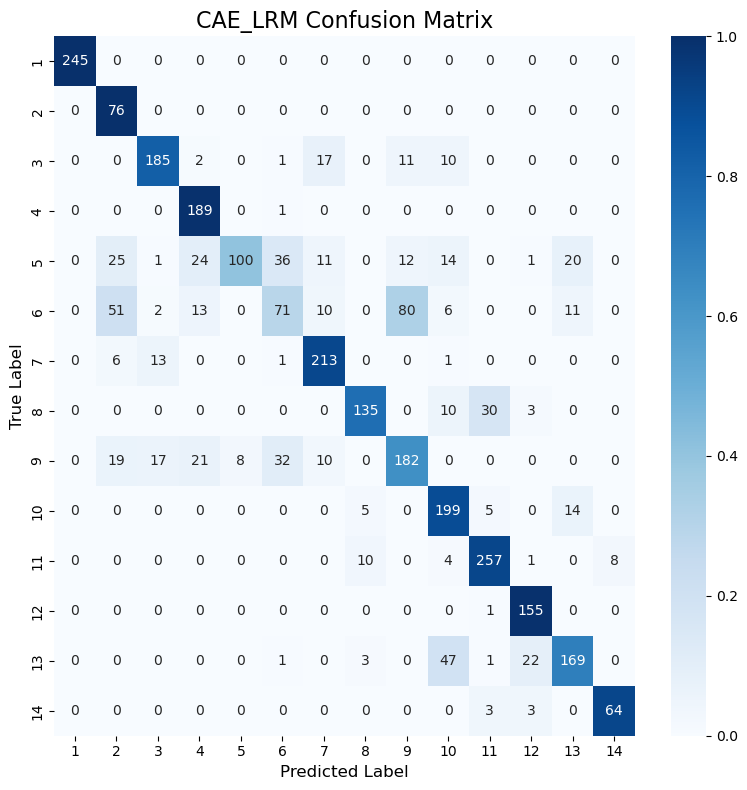

Classification Accuracy: 77.29%


Saved confusion matrix to: confusion_matrices\cae_mlp_confusion_matrix.png


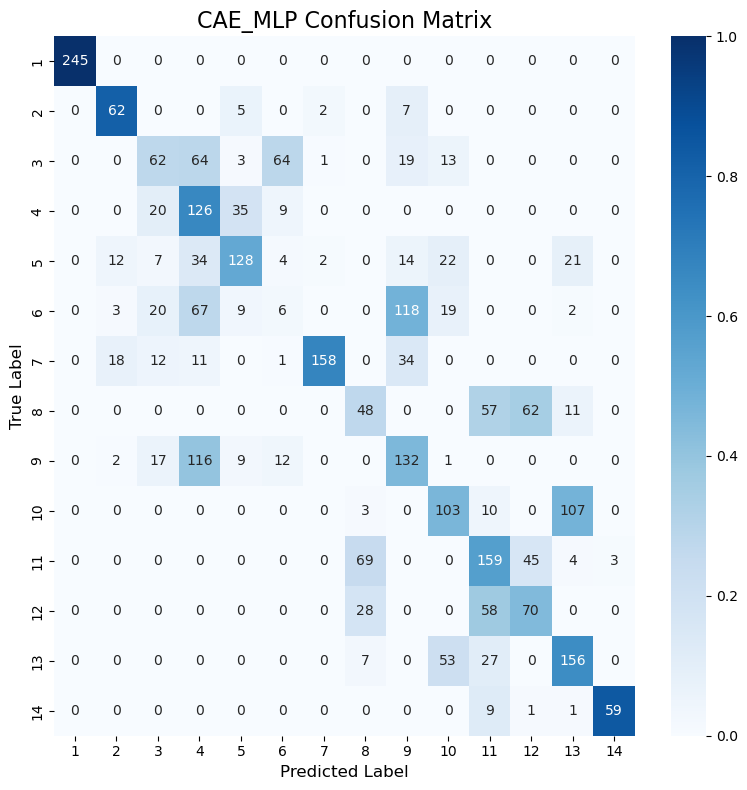

Classification Accuracy: 52.24%


Saved confusion matrix to: confusion_matrices\tscl_lrm_confusion_matrix.png


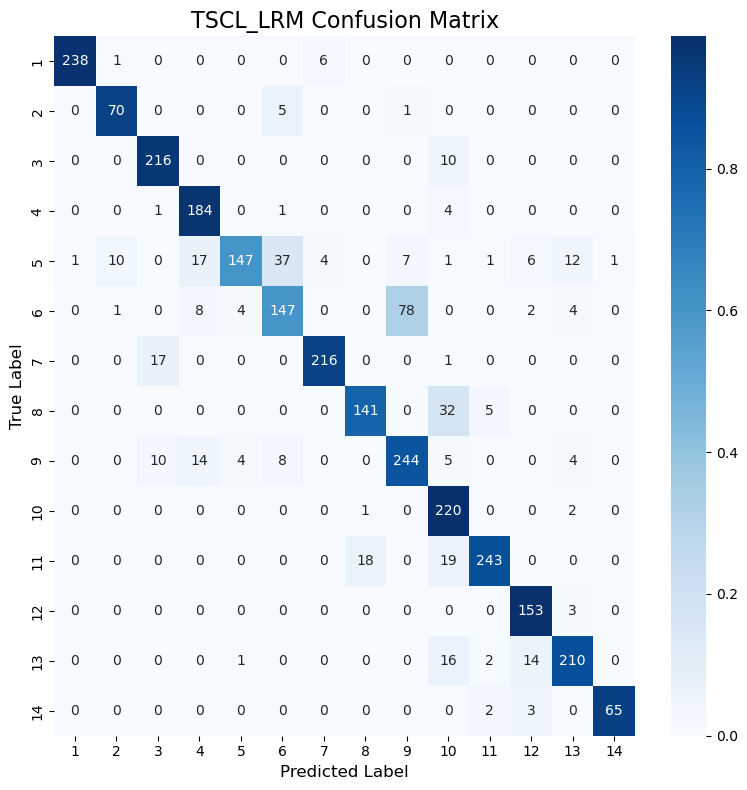

Classification Accuracy: 86.06%


Saved confusion matrix to: confusion_matrices\tscl_mlp_confusion_matrix.png


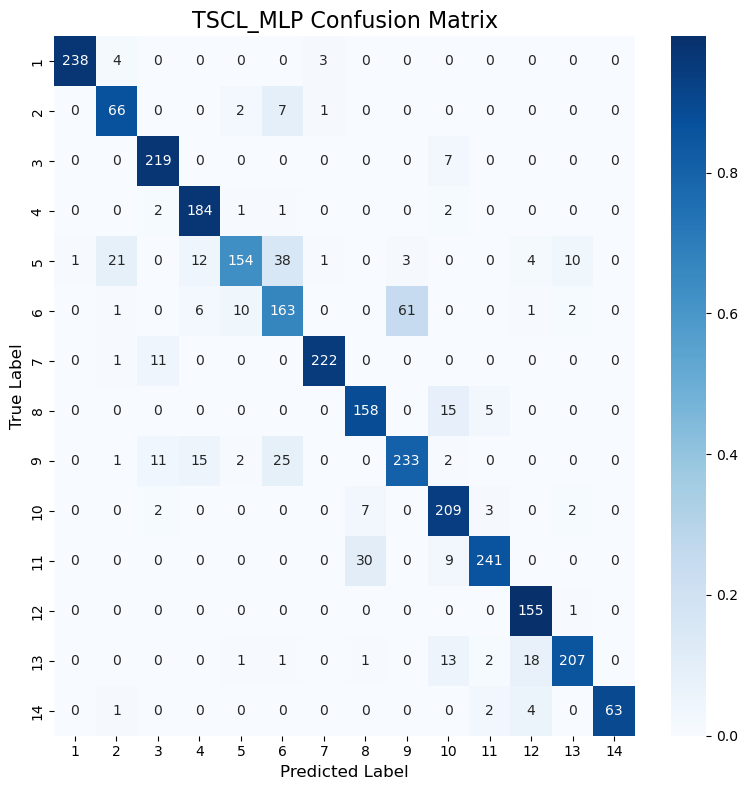

Classification Accuracy: 86.68%


Saved confusion matrix to: confusion_matrices\sclsdl_lrm_confusion_matrix.png


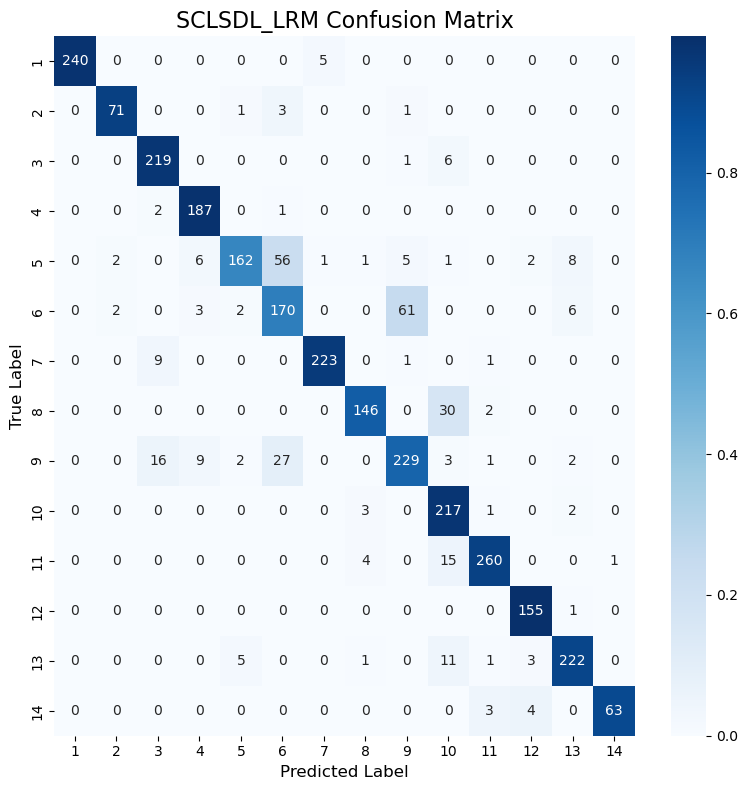

Classification Accuracy: 88.47%


Saved confusion matrix to: confusion_matrices\sclsdl_mlp_confusion_matrix.png


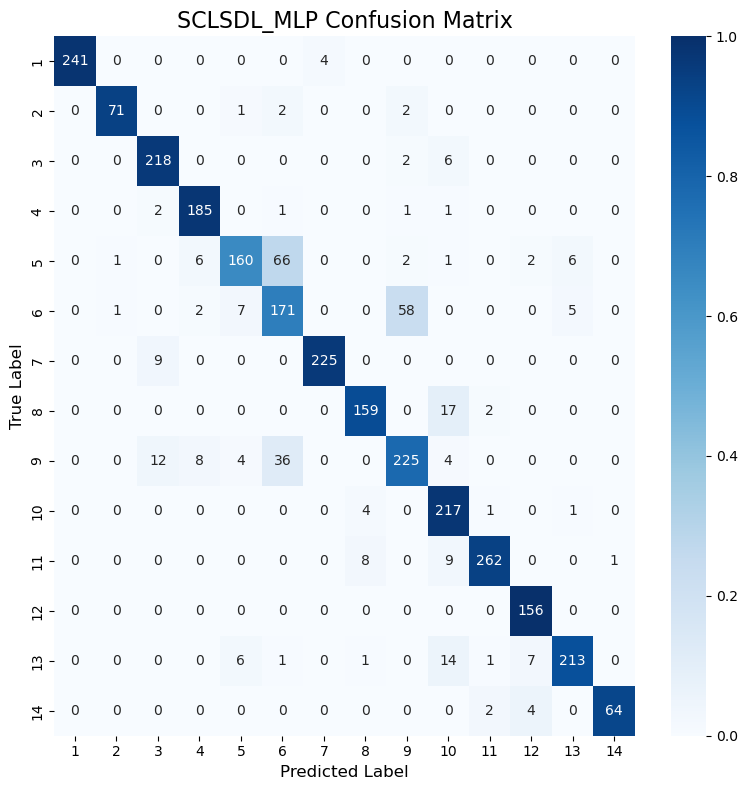

Classification Accuracy: 88.58%


In [62]:
class_names = [str(i+1) for i in range(len(np.unique(y_labels)))]
confusion_matrices_dir = 'confusion_matrices'
os.makedirs(confusion_matrices_dir, exist_ok=True)
print(f"Saving confusion matrices to: {confusion_matrices_dir}")
plot_conf_matrix('e2e_cnn', class_names, confusion_matrices_dir)
plot_conf_matrix('cae_lrm', class_names, confusion_matrices_dir)
plot_conf_matrix('cae_mlp', class_names, confusion_matrices_dir)
plot_conf_matrix('tscl_lrm', class_names, confusion_matrices_dir)
plot_conf_matrix('tscl_mlp', class_names, confusion_matrices_dir)
plot_conf_matrix('sclsdl_lrm', class_names, confusion_matrices_dir)
plot_conf_matrix('sclsdl_mlp', class_names, confusion_matrices_dir)

In [63]:
final_results_df = pd.DataFrame({
    "Model": ["E2E CNN", "LRM (CAE)", "MLP (CAE)", "TSCL LRM", "TSCL MLP", "SCL_SDL LRM", "SCL_SDL MLP"],
    "Test_Accuracy": [test_accuracy, lrm_test_accuracy * 100, cae_mlp_test_accuracy_pct, 
                      tscl_lrm_test_accuracy * 100, tscl_mlp_test_accuracy_pct, 
                      sclsdl_lrm_test_accuracy * 100, sclsdl_mlp_test_accuracy_pct]
})

pd.options.display.float_format = '{:.2f}'.format

print(final_results_df)
print(f"\nIn Desc. Order (Test Accu)\n{final_results_df.sort_values('Test_Accuracy', ascending=False)}")

         Model  Test_Accuracy
0      E2E CNN          97.03
1    LRM (CAE)          77.29
2    MLP (CAE)          52.24
3     TSCL LRM          86.06
4     TSCL MLP          86.68
5  SCL_SDL LRM          88.47
6  SCL_SDL MLP          88.58

In Desc. Order (Test Accu)
         Model  Test_Accuracy
0      E2E CNN          97.03
6  SCL_SDL MLP          88.58
5  SCL_SDL LRM          88.47
4     TSCL MLP          86.68
3     TSCL LRM          86.06
1    LRM (CAE)          77.29
2    MLP (CAE)          52.24
